## Imports

In [1]:
import ee
import rasterio
import rasterio.plot
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
from csv import *
import glob
import os
ee.Initialize()

## DOWNLOAD DESIRED GEOTIFFS

#### INPUTS

In [2]:
# Coordinate box - edit to desired region
lon_min = 25.5
lat_min = -10.8
lon_max = 26
lat_max = -10.6
# All regions or suspected mines only?
# If all regions, change to True. If suspected mines only, change to False
all_regions = False

#### DATA SOURCE AND FUNCTIONS

In [3]:
# Selected region
region = ee.Geometry.Polygon(
    [[[lon_min, lat_max],
      [lon_min, lat_min],
      [lon_max, lat_min],
      [lon_max, lat_max]]])

# Data set
s2 = ee.ImageCollection("COPERNICUS/S2_SR")

# Cloud mask for Sentinel-2
def maskS2clouds(image):
    qa = image.select('QA60')

    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11

    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0))

    return image.updateMask(mask).divide(10000).select("B.*") \
        .copyProperties(image, ["system:time_start"])

# Function to create composite image for visualization
def create_vis(geometry):
    composite = s2 \
        .filter(ee.Filter.bounds(geometry)) \
        .filter(ee.Filter.date('2021-01-01', '2021-12-31')) \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
        .map(maskS2clouds) \
        .select('B.*') \
        .median().clip(geometry)
    visualized = composite.visualize(['B4', 'B3', 'B2'], None, None, 0, 3)
    return visualized

# Get the bounds for a given image, transformed to the correct projection
def image_bounds(im_single):
    xul, yul = proj.transform_point(
        x = im_single[0],
        y = im_single[1],
        src_crs = geod)
    xlr, ylr = proj.transform_point(
        x = im_single[2],
        y = im_single[3],
        src_crs = geod)
    extent = [xul, xlr, yul, ylr]
    return extent

# Check that system is in the right directory
os.chdir("/scratch/nason.e/gee") # change to your own path

#### GEOTIFF FOR COMPLETE REGION

In [4]:
# Download a Geotiff File for entire region
viz = create_vis(region)
link = viz.getDownloadUrl({
  'name': 'entire_region',
  'bands': ['vis-red', 'vis-green', 'vis-blue'],
  'scale': 50,
  'region': region,
  'filePerBand': False
})
# Unzip file - into gee folder
os.system("wget -O entire_region.zip "+link)
os.system("unzip entire_region.zip")
# Delete zipfile
os.system("rm entire_region.zip")

--2022-04-05 10:14:55--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c6c62d2137a2a2feaf12f10e0e3dc25d-a33494ea78970e37c990f1e4b9c113c3:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 

Archive:  entire_region.zip
 extracting: entire_region.tif       


200 OK
Length: 324614 (317K) [application/zip]
Saving to: ‘entire_region.zip’

     0K .......... .......... .......... .......... .......... 15%  891K 0s
    50K .......... .......... .......... .......... .......... 31% 1.35M 0s
   100K .......... .......... .......... .......... .......... 47% 3.41M 0s
   150K .......... .......... .......... .......... .......... 63% 3.52M 0s
   200K .......... .......... .......... .......... .......... 78% 4.09M 0s
   250K .......... .......... .......... .......... .......... 94% 6.39M 0s
   300K .......... .......                                    100% 9.56M=0.1s

2022-04-05 10:15:07 (2.18 MB/s) - ‘entire_region.zip’ saved [324614/324614]



0

### PLOT COMPLETE REGION

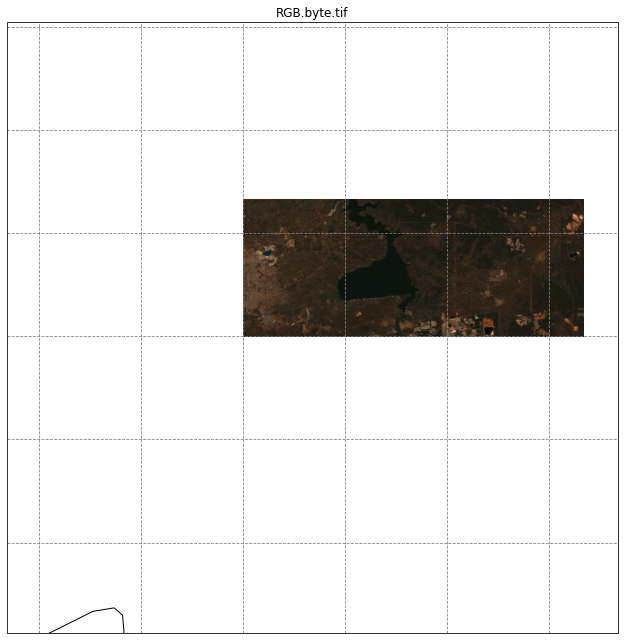

In [5]:
geod = ccrs.Geodetic()

# Set Projection
proj = ccrs.Mercator(central_longitude=0.0, min_latitude=-80.0, max_latitude=84.0, globe=None, latitude_true_scale=0.0)
plt.figure(figsize=(16,9))

# Map bounds
# Entire eastern half of DRC 
#ease_extent = [2500000., 3500000., -1500000., 600000.]
# Zoomed in
# ease_extent = [2750000., 2900000., -1250000., -1150000.]
ease_extent = [2800000., 2900000., -1250000., -1150000.]

# Set projection and boundaries
ax = plt.axes(projection=proj)
ax.set_extent(ease_extent, crs=proj)

# Get image and bounds for entire region and save the max reflectance value
# This value will be used to scale all of the individual regions the same
base_tiff = rasterio.open('/scratch/nason.e/gee/entire_region.tif')
base_bounds = base_tiff.bounds
# Reads first 3 bands (R,G,B)
# Currently those are the only bands downloaded, so .read() would have the same results (reads all of the bands available)
base_im = base_tiff.read([1, 2, 3])
# Transpose matrix columns to go from rasterio format to cartopy format
base_im = np.transpose(base_im, [1,2,0])
# Scale the image
max_val = np.amax(base_im)
base_im = base_im/max_val
base_im = np.clip(base_im, 0, 1)

# Map image onto the projection
ax.imshow(base_im, extent=image_bounds(base_bounds), transform=proj, origin='upper')

# Set gridlines, country borders, coastlines, title
ax.gridlines(color='gray', linestyle='--')
ax.coastlines()
ax.add_feature(cf.BORDERS)
plt.title('RGB.byte.tif')
# Clip image to fit projected region
plt.tight_layout()

#### INDIVIDUAL GEOTIFFS

In [6]:
# Depending on if all_regions is set to True or False, use the CSV with all regions listed, or only passing regions
if all_regions:
    file_name = "results/compiled_status.csv"
else:
    file_name = "results/compiled_passing.csv"

# Small regions in the above chosen file that are within the desired region will be written into a file with this name
output_file = "region_geotiffs/selected_region.csv"

with open(file_name, 'r') as r, open(output_file, 'a') as w:
    csv_reader = reader(r)
    csv_writer = writer(w)
    # Skip Header
    header = next(csv_reader)
    if header != None:
    # Iterate over each row after the header in the csv
        for row in csv_reader:
            # Check if region in this row is within the bounding box limits
            in_box = ((float(row[0]) >= lon_min) and (float(row[1]) >= lat_min) \
            and (float(row[2]) <= lon_max) and (float(row[3]) <= lat_max))
            # If within limits, add to output file
            if in_box:
                csv_writer.writerow(row)
                
# Download a Geotiff File for a composite image of each small region in 2021. Save each file to the region_geotiffs file
# File name = region_LonMin_LatMin_LonMax_LatMax.tif
with open(output_file, 'r') as read_obj:
    reader = reader(read_obj)
    for row in reader:
        region_small = ee.Geometry.Polygon(
                [[[ee.Number.parse(str(row[0])), ee.Number.parse(str(row[3]))],
                  [ee.Number.parse(str(row[0])), ee.Number.parse(str(row[1]))],
                  [ee.Number.parse(str(row[2])), ee.Number.parse(str(row[1]))],
                  [ee.Number.parse(str(row[2])), ee.Number.parse(str(row[3]))]]])
        viz = create_vis(region)
        link = viz.getDownloadUrl({
          'name': 'region_geotiffs/region_'+str(row[0])[:15]+'_'+str(row[1])[:15]+'_'+str(row[2])[:15]+'_'+str(row[3])[:15],
          'bands': ['vis-red', 'vis-green', 'vis-blue'],
          'scale': 30,
          'region': region_small,
          'filePerBand': False
        })
        # Unzip file - into region_geotiffs folder
        os.system("wget -O region_"+str(row[0])[:15]+'_'+str(row[1])[:15]+'_'+str(row[2])[:15]+'_'+str(row[3])[:15]+".zip "+link)
        os.system("unzip region_"+str(row[0])[:15]+'_'+str(row[1])[:15]+'_'+str(row[2])[:15]+'_'+str(row[3])[:15]+".zip")
        # Delete zipfile
        os.system("rm region_"+str(row[0])[:15]+'_'+str(row[1])[:15]+'_'+str(row[2])[:15]+'_'+str(row[3])[:15]+".zip")

--2022-04-05 10:15:36--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/cfaf65c5b1998dd2f97ca18056e0f3db-e3ca417c88913f7df293dc8d769cc17e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1035 (1.0K) [application/zip]
Saving to: ‘region_25.637817551807_-10.60414877656_25.640063388257_-10.60190287162.zip’

     0K .                                                     100% 1.60M=0.001s

2022-04-05 10:15:37 (1.60 MB/s) - ‘region_25.637817551807_-10.60414877656_25.640063388257_-10.60190287162.zip’ saved [1035/1035]



Archive:  region_25.637817551807_-10.60414877656_25.640063388257_-10.60190287162.zip
 extracting: region_geotiffs/region_25.637817551807_-10.60414877656_25.640063388257_-10.60190287162.tif  


--2022-04-05 10:15:38--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e779f9c396b338147f10f2aaabd5f7c7-e43d4cdd544e28ca8f1a62644c87fedd:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1065 (1.0K) [application/zip]
Saving to: ‘region_25.640063388257_-10.60414877657_25.642309224707_-10.60190287162.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:15:38 (1.74 MB/s) - ‘region_25.640063388257_-10.60414877657_25.642309224707_-10.60190287162.zip’ saved [1065/1065]



Archive:  region_25.640063388257_-10.60414877657_25.642309224707_-10.60190287162.zip
 extracting: region_geotiffs/region_25.640063388257_-10.60414877657_25.642309224707_-10.60190287162.tif  


--2022-04-05 10:15:39--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/77154562d556788a53642c0389a9669c-d80f23e8217fec3517c7f7546d2d7548:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1056 (1.0K) [application/zip]
Saving to: ‘region_25.644555061157_-10.60414877660_25.646800897607_-10.60190287162.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:15:39 (1.77 MB/s) - ‘region_25.644555061157_-10.60414877660_25.646800897607_-10.60190287162.zip’ saved [1056/1056]



Archive:  region_25.644555061157_-10.60414877660_25.646800897607_-10.60190287162.zip
 extracting: region_geotiffs/region_25.644555061157_-10.60414877660_25.646800897607_-10.60190287162.tif  


--2022-04-05 10:15:39--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5b3cd6ed77b5e52747b9592669d54688-91f673e77722d416e1c268ac6e0eea9d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1073 (1.0K) [application/zip]
Saving to: ‘region_25.637817551807_-10.60639468192_25.640063388257_-10.60414877698.zip’

     0K .                                                     100% 1.69M=0.001s

2022-04-05 10:15:40 (1.69 MB/s) - ‘region_25.637817551807_-10.60639468192_25.640063388257_-10.60414877698.zip’ saved [1073/1073]



Archive:  region_25.637817551807_-10.60639468192_25.640063388257_-10.60414877698.zip
 extracting: region_geotiffs/region_25.637817551807_-10.60639468192_25.640063388257_-10.60414877698.tif  


--2022-04-05 10:15:40--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5b5a35e774e362f85ca2ea3107484f3a-a3ff26b89de8ab5f54a88134b4a2fe71:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1011 [application/zip]
Saving to: ‘region_25.640063388257_-10.60639468193_25.642309224707_-10.60414877698.zip’

     0K                                                       100% 1.54M=0.001s

2022-04-05 10:15:41 (1.54 MB/s) - ‘region_25.640063388257_-10.60639468193_25.642309224707_-10.60414877698.zip’ saved [1011/1011]



Archive:  region_25.640063388257_-10.60639468193_25.642309224707_-10.60414877698.zip
 extracting: region_geotiffs/region_25.640063388257_-10.60639468193_25.642309224707_-10.60414877698.tif  


--2022-04-05 10:15:41--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/86f3f1dec7456f2e6d01bc7704f1fe24-e27199c3634c9e97e1ea4c253537c8f6:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1039 (1.0K) [application/zip]
Saving to: ‘region_25.687225953708_-10.60639468219_25.689471790158_-10.60414877698.zip’

     0K .                                                     100% 1.56M=0.001s

2022-04-05 10:15:44 (1.56 MB/s) - ‘region_25.687225953708_-10.60639468219_25.689471790158_-10.60414877698.zip’ saved [1039/1039]



Archive:  region_25.687225953708_-10.60639468219_25.689471790158_-10.60414877698.zip
 extracting: region_geotiffs/region_25.687225953708_-10.60639468219_25.689471790158_-10.60414877698.tif  


--2022-04-05 10:15:44--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a380e5ddd03c7eedef2a6d3ecde8e437-821f0eee49407ff276089db5e66c79c4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1050 (1.0K) [application/zip]
Saving to: ‘region_25.635571715357_-10.60864058727_25.637817551807_-10.60639468234.zip’

     0K .                                                     100% 5.72M=0s

2022-04-05 10:15:44 (5.72 MB/s) - ‘region_25.635571715357_-10.60864058727_25.637817551807_-10.60639468234.zip’ saved [1050/1050]



Archive:  region_25.635571715357_-10.60864058727_25.637817551807_-10.60639468234.zip
 extracting: region_geotiffs/region_25.635571715357_-10.60864058727_25.637817551807_-10.60639468234.tif  


--2022-04-05 10:15:45--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2203cabfa24489e9e5c993c7348fc180-30076be27a26202f70c8ff588d83616d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1018 [application/zip]
Saving to: ‘region_25.633325878907_-10.61088649262_25.635571715357_-10.60864058770.zip’

     0K                                                       100% 1.72M=0.001s

2022-04-05 10:15:45 (1.72 MB/s) - ‘region_25.633325878907_-10.61088649262_25.635571715357_-10.60864058770.zip’ saved [1018/1018]



Archive:  region_25.633325878907_-10.61088649262_25.635571715357_-10.60864058770.zip
 extracting: region_geotiffs/region_25.633325878907_-10.61088649262_25.635571715357_-10.60864058770.tif  


--2022-04-05 10:15:45--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a7d0f06f1555f1bfb618328bc7045b77-816636013b9572a8a93c3211088a2394:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1078 (1.1K) [application/zip]
Saving to: ‘region_25.635571715357_-10.61088649263_25.637817551807_-10.60864058770.zip’

     0K .                                                     100% 1.79M=0.001s

2022-04-05 10:15:46 (1.79 MB/s) - ‘region_25.635571715357_-10.61088649263_25.637817551807_-10.60864058770.zip’ saved [1078/1078]



Archive:  region_25.635571715357_-10.61088649263_25.637817551807_-10.60864058770.zip
 extracting: region_geotiffs/region_25.635571715357_-10.61088649263_25.637817551807_-10.60864058770.tif  


--2022-04-05 10:15:46--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e95297c1575d0be015ca4a29f76eb43d-2adda99a930f58f8aba6ece94155f435:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1073 (1.0K) [application/zip]
Saving to: ‘region_25.646800897607_-10.61088649269_25.649046734057_-10.60864058770.zip’

     0K .                                                     100% 1.76M=0.001s

2022-04-05 10:15:47 (1.76 MB/s) - ‘region_25.646800897607_-10.61088649269_25.649046734057_-10.60864058770.zip’ saved [1073/1073]



Archive:  region_25.646800897607_-10.61088649269_25.649046734057_-10.60864058770.zip
 extracting: region_geotiffs/region_25.646800897607_-10.61088649269_25.649046734057_-10.60864058770.tif  


--2022-04-05 10:15:47--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0d8ebf3bac56a59308f02e39a72aec04-bac291d95e54e1a4d740e483bcc2c37e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1029 (1.0K) [application/zip]
Saving to: ‘region_25.633325878907_-10.61313239798_25.635571715357_-10.61088649306.zip’

     0K .                                                     100% 2.60M=0s

2022-04-05 10:15:48 (2.60 MB/s) - ‘region_25.633325878907_-10.61313239798_25.635571715357_-10.61088649306.zip’ saved [1029/1029]



Archive:  region_25.633325878907_-10.61313239798_25.635571715357_-10.61088649306.zip
 extracting: region_geotiffs/region_25.633325878907_-10.61313239798_25.635571715357_-10.61088649306.tif  


--2022-04-05 10:15:48--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8a5426002e85950421f18444f2bfc3df-2ba5a84034662b3ccf353b556f08132b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1038 (1.0K) [application/zip]
Saving to: ‘region_25.635571715357_-10.61313239799_25.637817551807_-10.61088649306.zip’

     0K .                                                     100% 2.98M=0s

2022-04-05 10:15:49 (2.98 MB/s) - ‘region_25.635571715357_-10.61313239799_25.637817551807_-10.61088649306.zip’ saved [1038/1038]



Archive:  region_25.635571715357_-10.61313239799_25.637817551807_-10.61088649306.zip
 extracting: region_geotiffs/region_25.635571715357_-10.61313239799_25.637817551807_-10.61088649306.tif  


--2022-04-05 10:15:49--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5355c0cde8e437b36e633b3993966581-11da5c5ab1ad22ce087d82279bbb10eb:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1058 (1.0K) [application/zip]
Saving to: ‘region_25.644555061157_-10.61313239804_25.646800897607_-10.61088649306.zip’

     0K .                                                     100% 1.85M=0.001s

2022-04-05 10:15:49 (1.85 MB/s) - ‘region_25.644555061157_-10.61313239804_25.646800897607_-10.61088649306.zip’ saved [1058/1058]



Archive:  region_25.644555061157_-10.61313239804_25.646800897607_-10.61088649306.zip
 extracting: region_geotiffs/region_25.644555061157_-10.61313239804_25.646800897607_-10.61088649306.tif  


--2022-04-05 10:15:50--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f23f2f9fd2492b74f2cf242b72a059e1-02721c5a5de2bc7e8934d5b5337623b9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1065 (1.0K) [application/zip]
Saving to: ‘region_25.646800897607_-10.61313239805_25.649046734057_-10.61088649306.zip’

     0K .                                                     100% 1.81M=0.001s

2022-04-05 10:15:50 (1.81 MB/s) - ‘region_25.646800897607_-10.61313239805_25.649046734057_-10.61088649306.zip’ saved [1065/1065]



Archive:  region_25.646800897607_-10.61313239805_25.649046734057_-10.61088649306.zip
 extracting: region_geotiffs/region_25.646800897607_-10.61313239805_25.649046734057_-10.61088649306.tif  


--2022-04-05 10:15:51--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/02e7c2ac439d66946098a612fce559a9-c9f0a761ed6432b7bb474d9e0f3d5b36:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1051 (1.0K) [application/zip]
Saving to: ‘region_25.628834206007_-10.61537830332_25.631080042457_-10.61313239843.zip’

     0K .                                                     100% 1.82M=0.001s

2022-04-05 10:15:51 (1.82 MB/s) - ‘region_25.628834206007_-10.61537830332_25.631080042457_-10.61313239843.zip’ saved [1051/1051]



Archive:  region_25.628834206007_-10.61537830332_25.631080042457_-10.61313239843.zip
 extracting: region_geotiffs/region_25.628834206007_-10.61537830332_25.631080042457_-10.61313239843.tif  


--2022-04-05 10:15:51--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a7d4255330669e74415af44c4cc9331b-87798a7d5c8811c729bd563cefd5c5b4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1075 (1.0K) [application/zip]
Saving to: ‘region_25.633325878907_-10.61537830334_25.635571715357_-10.61313239843.zip’

     0K .                                                     100% 1.80M=0.001s

2022-04-05 10:15:52 (1.80 MB/s) - ‘region_25.633325878907_-10.61537830334_25.635571715357_-10.61313239843.zip’ saved [1075/1075]



Archive:  region_25.633325878907_-10.61537830334_25.635571715357_-10.61313239843.zip
 extracting: region_geotiffs/region_25.633325878907_-10.61537830334_25.635571715357_-10.61313239843.tif  


--2022-04-05 10:15:52--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0617fac104c8fb23d135fd3de1577bad-fedd06e84b9ce68bedc742e12149a38a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1041 (1.0K) [application/zip]
Saving to: ‘region_25.635571715357_-10.61537830335_25.637817551807_-10.61313239843.zip’

     0K .                                                     100% 2.37M=0s

2022-04-05 10:15:53 (2.37 MB/s) - ‘region_25.635571715357_-10.61537830335_25.637817551807_-10.61313239843.zip’ saved [1041/1041]



Archive:  region_25.635571715357_-10.61537830335_25.637817551807_-10.61313239843.zip
 extracting: region_geotiffs/region_25.635571715357_-10.61537830335_25.637817551807_-10.61313239843.tif  


--2022-04-05 10:15:53--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7882d83126b12d9a6f1b26a252b3ba47-a5e0997bd621cda328b88ea00cd2a99a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1090 (1.1K) [application/zip]
Saving to: ‘region_25.628834206007_-10.61762420868_25.631080042457_-10.61537830379.zip’

     0K .                                                     100% 1.70M=0.001s

2022-04-05 10:15:53 (1.70 MB/s) - ‘region_25.628834206007_-10.61762420868_25.631080042457_-10.61537830379.zip’ saved [1090/1090]



Archive:  region_25.628834206007_-10.61762420868_25.631080042457_-10.61537830379.zip
 extracting: region_geotiffs/region_25.628834206007_-10.61762420868_25.631080042457_-10.61537830379.tif  


--2022-04-05 10:15:54--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8bbf16127e049efeac62dfccb33b1cc6-273463b768feed5e73e522700ae68f42:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1100 (1.1K) [application/zip]
Saving to: ‘region_25.631080042457_-10.61762420869_25.633325878907_-10.61537830379.zip’

     0K .                                                     100% 1.85M=0.001s

2022-04-05 10:15:54 (1.85 MB/s) - ‘region_25.631080042457_-10.61762420869_25.633325878907_-10.61537830379.zip’ saved [1100/1100]



Archive:  region_25.631080042457_-10.61762420869_25.633325878907_-10.61537830379.zip
 extracting: region_geotiffs/region_25.631080042457_-10.61762420869_25.633325878907_-10.61537830379.tif  


--2022-04-05 10:15:55--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/eec1f33cb21afc49a8e1c7b66c34a1bb-0ac327116318d27385ee793999596433:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1084 (1.1K) [application/zip]
Saving to: ‘region_25.633325878907_-10.61762420870_25.635571715357_-10.61537830379.zip’

     0K .                                                     100% 1.67M=0.001s

2022-04-05 10:15:55 (1.67 MB/s) - ‘region_25.633325878907_-10.61762420870_25.635571715357_-10.61537830379.zip’ saved [1084/1084]



Archive:  region_25.633325878907_-10.61762420870_25.635571715357_-10.61537830379.zip
 extracting: region_geotiffs/region_25.633325878907_-10.61762420870_25.635571715357_-10.61537830379.tif  


--2022-04-05 10:15:55--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b139837b258831542647e2a60a18f287-6191b3bb428cc19a4fa380e73eea167e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1065 (1.0K) [application/zip]
Saving to: ‘region_25.628834206007_-10.61987011404_25.631080042457_-10.61762420915.zip’

     0K .                                                     100% 1.82M=0.001s

2022-04-05 10:15:56 (1.82 MB/s) - ‘region_25.628834206007_-10.61987011404_25.631080042457_-10.61762420915.zip’ saved [1065/1065]



Archive:  region_25.628834206007_-10.61987011404_25.631080042457_-10.61762420915.zip
 extracting: region_geotiffs/region_25.628834206007_-10.61987011404_25.631080042457_-10.61762420915.tif  


--2022-04-05 10:15:56--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/83f868e2334b476f317fddb33157178d-a48d085f29ac24fed6631f8bd455e1bf:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1068 (1.0K) [application/zip]
Saving to: ‘region_25.631080042457_-10.61987011405_25.633325878907_-10.61762420915.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:15:56 (1.74 MB/s) - ‘region_25.631080042457_-10.61987011405_25.633325878907_-10.61762420915.zip’ saved [1068/1068]



Archive:  region_25.631080042457_-10.61987011405_25.633325878907_-10.61762420915.zip
 extracting: region_geotiffs/region_25.631080042457_-10.61987011405_25.633325878907_-10.61762420915.tif  


--2022-04-05 10:15:57--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/67efcf8ff7b468f98ce939d0cf939051-5d10859134f371759511140e3b7d05b2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1023 [application/zip]
Saving to: ‘region_25.633325878907_-10.61987011406_25.635571715357_-10.61762420915.zip’

     0K                                                       100% 1.56M=0.001s

2022-04-05 10:15:57 (1.56 MB/s) - ‘region_25.633325878907_-10.61987011406_25.635571715357_-10.61762420915.zip’ saved [1023/1023]



Archive:  region_25.633325878907_-10.61987011406_25.635571715357_-10.61762420915.zip
 extracting: region_geotiffs/region_25.633325878907_-10.61987011406_25.635571715357_-10.61762420915.tif  


--2022-04-05 10:15:58--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/95bbfb815c9cde7d84e9ffd180966ed3-a057ce76f34feddfd0041df43a898d0a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1064 (1.0K) [application/zip]
Saving to: ‘region_25.628834206007_-10.62211601940_25.631080042457_-10.61987011451.zip’

     0K .                                                     100% 1.68M=0.001s

2022-04-05 10:15:58 (1.68 MB/s) - ‘region_25.628834206007_-10.62211601940_25.631080042457_-10.61987011451.zip’ saved [1064/1064]



Archive:  region_25.628834206007_-10.62211601940_25.631080042457_-10.61987011451.zip
 extracting: region_geotiffs/region_25.628834206007_-10.62211601940_25.631080042457_-10.61987011451.tif  


--2022-04-05 10:15:58--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/96f8cc0c2c8ca70fb02558700f59daf7-ed32591ea4c0a6f754e7080e597e5f6d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1076 (1.1K) [application/zip]
Saving to: ‘region_25.628834206007_-10.62436192476_25.631080042457_-10.62211601987.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:15:59 (1.75 MB/s) - ‘region_25.628834206007_-10.62436192476_25.631080042457_-10.62211601987.zip’ saved [1076/1076]



Archive:  region_25.628834206007_-10.62436192476_25.631080042457_-10.62211601987.zip
 extracting: region_geotiffs/region_25.628834206007_-10.62436192476_25.631080042457_-10.62211601987.tif  


--2022-04-05 10:15:59--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ab77ee651b785b8a6f9f81c76fdd6fbe-191921ca51879fe867ef918b25ecd553:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1035 (1.0K) [application/zip]
Saving to: ‘region_25.633325878907_-10.62885373551_25.635571715357_-10.62660783059.zip’

     0K .                                                     100% 3.19M=0s

2022-04-05 10:15:59 (3.19 MB/s) - ‘region_25.633325878907_-10.62885373551_25.635571715357_-10.62660783059.zip’ saved [1035/1035]



Archive:  region_25.633325878907_-10.62885373551_25.635571715357_-10.62660783059.zip
 extracting: region_geotiffs/region_25.633325878907_-10.62885373551_25.635571715357_-10.62660783059.tif  


--2022-04-05 10:16:00--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/85d2b94931437924f5d08555afa9a8a6-22c18ff43baafbf0ebf2e2e557a3292e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1006 [application/zip]
Saving to: ‘region_25.635571715357_-10.62885373552_25.637817551807_-10.62660783059.zip’

     0K                                                       100% 1.66M=0.001s

2022-04-05 10:16:00 (1.66 MB/s) - ‘region_25.635571715357_-10.62885373552_25.637817551807_-10.62660783059.zip’ saved [1006/1006]



Archive:  region_25.635571715357_-10.62885373552_25.637817551807_-10.62660783059.zip
 extracting: region_geotiffs/region_25.635571715357_-10.62885373552_25.637817551807_-10.62660783059.tif  


--2022-04-05 10:16:01--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9d83739a0dbcd91a5f8bde1ac0290b1d-f7d4133083ae5f33680ac8f7714ca519:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1065 (1.0K) [application/zip]
Saving to: ‘region_25.500821528355_-10.72093593289_25.503067364805_-10.71869002867.zip’

     0K .                                                     100% 1.88M=0.001s

2022-04-05 10:16:01 (1.88 MB/s) - ‘region_25.500821528355_-10.72093593289_25.503067364805_-10.71869002867.zip’ saved [1065/1065]



Archive:  region_25.500821528355_-10.72093593289_25.503067364805_-10.71869002867.zip
 extracting: region_geotiffs/region_25.500821528355_-10.72093593289_25.503067364805_-10.71869002867.tif  


--2022-04-05 10:16:01--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e5bf9db633808a8411ae911006928ef3-c923bdca48158da67eb611a69989af31:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1087 (1.1K) [application/zip]
Saving to: ‘region_25.503067364805_-10.72093593290_25.505313201256_-10.71869002867.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:16:03 (1.75 MB/s) - ‘region_25.503067364805_-10.72093593290_25.505313201256_-10.71869002867.zip’ saved [1087/1087]



Archive:  region_25.503067364805_-10.72093593290_25.505313201256_-10.71869002867.zip
 extracting: region_geotiffs/region_25.503067364805_-10.72093593290_25.505313201256_-10.71869002867.tif  


--2022-04-05 10:16:03--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/316e25764e92da6f433603330122d235-69bca142c03b7eccb214119a2bab2801:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1075 (1.0K) [application/zip]
Saving to: ‘region_25.505313201256_-10.72093593291_25.507559037706_-10.71869002867.zip’

     0K .                                                     100% 1.71M=0.001s

2022-04-05 10:16:04 (1.71 MB/s) - ‘region_25.505313201256_-10.72093593291_25.507559037706_-10.71869002867.zip’ saved [1075/1075]



Archive:  region_25.505313201256_-10.72093593291_25.507559037706_-10.71869002867.zip
 extracting: region_geotiffs/region_25.505313201256_-10.72093593291_25.507559037706_-10.71869002867.tif  


--2022-04-05 10:16:04--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/023ff29b50dad82f6e072f7febed4c97-9423198f6ef3341fbc3242372bbdeeff:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1062 (1.0K) [application/zip]
Saving to: ‘region_25.507559037706_-10.72093593292_25.509804874156_-10.71869002867.zip’

     0K .                                                     100% 1.76M=0.001s

2022-04-05 10:16:04 (1.76 MB/s) - ‘region_25.507559037706_-10.72093593292_25.509804874156_-10.71869002867.zip’ saved [1062/1062]



Archive:  region_25.507559037706_-10.72093593292_25.509804874156_-10.71869002867.zip
 extracting: region_geotiffs/region_25.507559037706_-10.72093593292_25.509804874156_-10.71869002867.tif  


--2022-04-05 10:16:05--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8aa3c6e951738f0319e0fc06d1259aff-65b0ada00884d0d3b3a306dd473e4783:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1048 (1.0K) [application/zip]
Saving to: ‘region_25.509804874156_-10.72093593293_25.512050710606_-10.71869002867.zip’

     0K .                                                     100% 1.71M=0.001s

2022-04-05 10:16:05 (1.71 MB/s) - ‘region_25.509804874156_-10.72093593293_25.512050710606_-10.71869002867.zip’ saved [1048/1048]



Archive:  region_25.509804874156_-10.72093593293_25.512050710606_-10.71869002867.zip
 extracting: region_geotiffs/region_25.509804874156_-10.72093593293_25.512050710606_-10.71869002867.tif  


--2022-04-05 10:16:05--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/13a4bcd726742e0c36e17e75d7466db6-b87ae9aa439a7446082cdec5c1a145d6:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1068 (1.0K) [application/zip]
Saving to: ‘region_25.512050710606_-10.72093593294_25.514296547056_-10.71869002867.zip’

     0K .                                                     100% 1.66M=0.001s

2022-04-05 10:16:06 (1.66 MB/s) - ‘region_25.512050710606_-10.72093593294_25.514296547056_-10.71869002867.zip’ saved [1068/1068]



Archive:  region_25.512050710606_-10.72093593294_25.514296547056_-10.71869002867.zip
 extracting: region_geotiffs/region_25.512050710606_-10.72093593294_25.514296547056_-10.71869002867.tif  


--2022-04-05 10:16:06--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/acd8bff3017574a0fc89a700e1e8713a-9260d3f8ddba802ccbbaa7ee41ed001a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1080 (1.1K) [application/zip]
Saving to: ‘region_25.516542383506_-10.72093593297_25.518788219956_-10.71869002867.zip’

     0K .                                                     100% 1.89M=0.001s

2022-04-05 10:16:07 (1.89 MB/s) - ‘region_25.516542383506_-10.72093593297_25.518788219956_-10.71869002867.zip’ saved [1080/1080]



Archive:  region_25.516542383506_-10.72093593297_25.518788219956_-10.71869002867.zip
 extracting: region_geotiffs/region_25.516542383506_-10.72093593297_25.518788219956_-10.71869002867.tif  


--2022-04-05 10:16:07--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/46600c189576ed5b11778e174750efe4-f0820bbd7bdbfbc79d3efb12e51e83de:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1072 (1.0K) [application/zip]
Saving to: ‘region_25.518788219956_-10.72093593298_25.521034056406_-10.71869002867.zip’

     0K .                                                     100% 1.87M=0.001s

2022-04-05 10:16:07 (1.87 MB/s) - ‘region_25.518788219956_-10.72093593298_25.521034056406_-10.71869002867.zip’ saved [1072/1072]



Archive:  region_25.518788219956_-10.72093593298_25.521034056406_-10.71869002867.zip
 extracting: region_geotiffs/region_25.518788219956_-10.72093593298_25.521034056406_-10.71869002867.tif  


--2022-04-05 10:16:08--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/24bba711f56e3877181882168d76531c-1e2950bb0cad7657b9a804f63208cd9a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1067 (1.0K) [application/zip]
Saving to: ‘region_25.521034056406_-10.72093593299_25.523279892856_-10.71869002867.zip’

     0K .                                                     100% 1.58M=0.001s

2022-04-05 10:16:08 (1.58 MB/s) - ‘region_25.521034056406_-10.72093593299_25.523279892856_-10.71869002867.zip’ saved [1067/1067]



Archive:  region_25.521034056406_-10.72093593299_25.523279892856_-10.71869002867.zip
 extracting: region_geotiffs/region_25.521034056406_-10.72093593299_25.523279892856_-10.71869002867.tif  


--2022-04-05 10:16:09--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5aa698ed9f60689161a8844aac3674cd-21cac071e3be54c0801502e7b1c11a2e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1054 (1.0K) [application/zip]
Saving to: ‘region_25.525525729306_-10.72093593302_25.527771565756_-10.71869002867.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:16:09 (1.73 MB/s) - ‘region_25.525525729306_-10.72093593302_25.527771565756_-10.71869002867.zip’ saved [1054/1054]



Archive:  region_25.525525729306_-10.72093593302_25.527771565756_-10.71869002867.zip
 extracting: region_geotiffs/region_25.525525729306_-10.72093593302_25.527771565756_-10.71869002867.tif  


--2022-04-05 10:16:09--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1c596ed1864029cdbfe0b4ee2015c46d-0789db9ff4ffdf49c3acaaffbab88e38:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1055 (1.0K) [application/zip]
Saving to: ‘region_25.527771565756_-10.72093593303_25.530017402206_-10.71869002867.zip’

     0K .                                                     100% 1.90M=0.001s

2022-04-05 10:16:10 (1.90 MB/s) - ‘region_25.527771565756_-10.72093593303_25.530017402206_-10.71869002867.zip’ saved [1055/1055]



Archive:  region_25.527771565756_-10.72093593303_25.530017402206_-10.71869002867.zip
 extracting: region_geotiffs/region_25.527771565756_-10.72093593303_25.530017402206_-10.71869002867.tif  


--2022-04-05 10:16:10--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d8cbacbfc2e01ac8fe88d31878081506-b8ff70c5aadc8662cde6276cef295336:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1075 (1.0K) [application/zip]
Saving to: ‘region_25.530017402206_-10.72093593304_25.532263238656_-10.71869002867.zip’

     0K .                                                     100% 1.79M=0.001s

2022-04-05 10:16:11 (1.79 MB/s) - ‘region_25.530017402206_-10.72093593304_25.532263238656_-10.71869002867.zip’ saved [1075/1075]



Archive:  region_25.530017402206_-10.72093593304_25.532263238656_-10.71869002867.zip
 extracting: region_geotiffs/region_25.530017402206_-10.72093593304_25.532263238656_-10.71869002867.tif  


--2022-04-05 10:16:11--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b043f38bcef00846c9e17226ef4df362-5d3c32de5cf6fc9ab1df0acac955e990:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1045 (1.0K) [application/zip]
Saving to: ‘region_25.532263238656_-10.72093593305_25.534509075106_-10.71869002867.zip’

     0K .                                                     100% 1.88M=0.001s

2022-04-05 10:16:11 (1.88 MB/s) - ‘region_25.532263238656_-10.72093593305_25.534509075106_-10.71869002867.zip’ saved [1045/1045]



Archive:  region_25.532263238656_-10.72093593305_25.534509075106_-10.71869002867.zip
 extracting: region_geotiffs/region_25.532263238656_-10.72093593305_25.534509075106_-10.71869002867.tif  


--2022-04-05 10:16:12--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b115542f9f483359d0d83eca9044867d-ad5264107cd07550be202a5775d006a9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1050 (1.0K) [application/zip]
Saving to: ‘region_25.534509075106_-10.72093593306_25.536754911556_-10.71869002867.zip’

     0K .                                                     100% 2.93M=0s

2022-04-05 10:16:12 (2.93 MB/s) - ‘region_25.534509075106_-10.72093593306_25.536754911556_-10.71869002867.zip’ saved [1050/1050]



Archive:  region_25.534509075106_-10.72093593306_25.536754911556_-10.71869002867.zip
 extracting: region_geotiffs/region_25.534509075106_-10.72093593306_25.536754911556_-10.71869002867.tif  


--2022-04-05 10:16:13--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c9df2a0671dd293f28d1941f32578b8b-3e5d0fef1cb6f2561683813ae06e5ce6:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1070 (1.0K) [application/zip]
Saving to: ‘region_25.536754911556_-10.72093593308_25.539000748006_-10.71869002867.zip’

     0K .                                                     100% 1.72M=0.001s

2022-04-05 10:16:13 (1.72 MB/s) - ‘region_25.536754911556_-10.72093593308_25.539000748006_-10.71869002867.zip’ saved [1070/1070]



Archive:  region_25.536754911556_-10.72093593308_25.539000748006_-10.71869002867.zip
 extracting: region_geotiffs/region_25.536754911556_-10.72093593308_25.539000748006_-10.71869002867.tif  


--2022-04-05 10:16:13--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/94fe887a5f60511653ed412ad5b6be3a-c1cde77fdc75e6cafdbcc3e4ed7295b3:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1053 (1.0K) [application/zip]
Saving to: ‘region_25.500821528355_-10.72318183729_25.503067364805_-10.72093593308.zip’

     0K .                                                     100% 1.76M=0.001s

2022-04-05 10:16:14 (1.76 MB/s) - ‘region_25.500821528355_-10.72318183729_25.503067364805_-10.72093593308.zip’ saved [1053/1053]



Archive:  region_25.500821528355_-10.72318183729_25.503067364805_-10.72093593308.zip
 extracting: region_geotiffs/region_25.500821528355_-10.72318183729_25.503067364805_-10.72093593308.tif  


--2022-04-05 10:16:14--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f9010407e176250c9eb7f8f866c41135-3bb01ab69202460753786a294999e180:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1079 (1.1K) [application/zip]
Saving to: ‘region_25.503067364805_-10.72318183730_25.505313201256_-10.72093593308.zip’

     0K .                                                     100% 1.83M=0.001s

2022-04-05 10:16:15 (1.83 MB/s) - ‘region_25.503067364805_-10.72318183730_25.505313201256_-10.72093593308.zip’ saved [1079/1079]



Archive:  region_25.503067364805_-10.72318183730_25.505313201256_-10.72093593308.zip
 extracting: region_geotiffs/region_25.503067364805_-10.72318183730_25.505313201256_-10.72093593308.tif  


--2022-04-05 10:16:15--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f18db75d628f65b04667c3bb0a8f2ae0-3e14a39bc63a7bd0ff64941884d79f65:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1072 (1.0K) [application/zip]
Saving to: ‘region_25.505313201256_-10.72318183731_25.507559037706_-10.72093593308.zip’

     0K .                                                     100% 1.96M=0.001s

2022-04-05 10:16:15 (1.96 MB/s) - ‘region_25.505313201256_-10.72318183731_25.507559037706_-10.72093593308.zip’ saved [1072/1072]



Archive:  region_25.505313201256_-10.72318183731_25.507559037706_-10.72093593308.zip
 extracting: region_geotiffs/region_25.505313201256_-10.72318183731_25.507559037706_-10.72093593308.tif  


--2022-04-05 10:16:16--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3b4359bc9dfed0e4afe8bc895ec8d5c4-7c56bb7fc193a9d8c20eafb13e220f1c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1076 (1.1K) [application/zip]
Saving to: ‘region_25.507559037706_-10.72318183732_25.509804874156_-10.72093593308.zip’

     0K .                                                     100% 1.68M=0.001s

2022-04-05 10:16:16 (1.68 MB/s) - ‘region_25.507559037706_-10.72318183732_25.509804874156_-10.72093593308.zip’ saved [1076/1076]



Archive:  region_25.507559037706_-10.72318183732_25.509804874156_-10.72093593308.zip
 extracting: region_geotiffs/region_25.507559037706_-10.72318183732_25.509804874156_-10.72093593308.tif  


--2022-04-05 10:16:17--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8c2669a96d8e2dc453e11b124b3e9097-9947a363b6d658730406454289607a70:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1071 (1.0K) [application/zip]
Saving to: ‘region_25.509804874156_-10.72318183733_25.512050710606_-10.72093593308.zip’

     0K .                                                     100% 1.86M=0.001s

2022-04-05 10:16:17 (1.86 MB/s) - ‘region_25.509804874156_-10.72318183733_25.512050710606_-10.72093593308.zip’ saved [1071/1071]



Archive:  region_25.509804874156_-10.72318183733_25.512050710606_-10.72093593308.zip
 extracting: region_geotiffs/region_25.509804874156_-10.72318183733_25.512050710606_-10.72093593308.tif  


--2022-04-05 10:16:17--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ccb792f018f02c32dc6e68ed11b67b4e-de3b2b426aa052d069a190947976716e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1042 (1.0K) [application/zip]
Saving to: ‘region_25.512050710606_-10.72318183735_25.514296547056_-10.72093593308.zip’

     0K .                                                     100% 1.64M=0.001s

2022-04-05 10:16:18 (1.64 MB/s) - ‘region_25.512050710606_-10.72318183735_25.514296547056_-10.72093593308.zip’ saved [1042/1042]



Archive:  region_25.512050710606_-10.72318183735_25.514296547056_-10.72093593308.zip
 extracting: region_geotiffs/region_25.512050710606_-10.72318183735_25.514296547056_-10.72093593308.tif  


--2022-04-05 10:16:18--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/15cb2a75d4835b4b5e1119498b6f648c-c546321330b636f10e526bfc225818c2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1051 (1.0K) [application/zip]
Saving to: ‘region_25.514296547056_-10.72318183736_25.516542383506_-10.72093593308.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:16:19 (1.75 MB/s) - ‘region_25.514296547056_-10.72318183736_25.516542383506_-10.72093593308.zip’ saved [1051/1051]



Archive:  region_25.514296547056_-10.72318183736_25.516542383506_-10.72093593308.zip
 extracting: region_geotiffs/region_25.514296547056_-10.72318183736_25.516542383506_-10.72093593308.tif  


--2022-04-05 10:16:19--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ea398066909a46c1afa94af22a7a83c5-3847d0766431522d85d24baf01064091:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1081 (1.1K) [application/zip]
Saving to: ‘region_25.523279892856_-10.72318183741_25.525525729306_-10.72093593308.zip’

     0K .                                                     100% 1.93M=0.001s

2022-04-05 10:16:19 (1.93 MB/s) - ‘region_25.523279892856_-10.72318183741_25.525525729306_-10.72093593308.zip’ saved [1081/1081]



Archive:  region_25.523279892856_-10.72318183741_25.525525729306_-10.72093593308.zip
 extracting: region_geotiffs/region_25.523279892856_-10.72318183741_25.525525729306_-10.72093593308.tif  


--2022-04-05 10:16:20--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e6fb00bd437f598f9126764df79f0b70-1ad1f47d5935ab21ffa6ff41473c221d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1061 (1.0K) [application/zip]
Saving to: ‘region_25.525525729306_-10.72318183742_25.527771565756_-10.72093593308.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:16:20 (1.73 MB/s) - ‘region_25.525525729306_-10.72318183742_25.527771565756_-10.72093593308.zip’ saved [1061/1061]



Archive:  region_25.525525729306_-10.72318183742_25.527771565756_-10.72093593308.zip
 extracting: region_geotiffs/region_25.525525729306_-10.72318183742_25.527771565756_-10.72093593308.tif  


--2022-04-05 10:16:21--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1f15c30d848aaa9b8958a49ffc035d71-9936813aa23f72784659b3c5056e3263:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1068 (1.0K) [application/zip]
Saving to: ‘region_25.527771565756_-10.72318183743_25.530017402206_-10.72093593308.zip’

     0K .                                                     100% 1.87M=0.001s

2022-04-05 10:16:21 (1.87 MB/s) - ‘region_25.527771565756_-10.72318183743_25.530017402206_-10.72093593308.zip’ saved [1068/1068]



Archive:  region_25.527771565756_-10.72318183743_25.530017402206_-10.72093593308.zip
 extracting: region_geotiffs/region_25.527771565756_-10.72318183743_25.530017402206_-10.72093593308.tif  


--2022-04-05 10:16:22--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0f03f14de64a419aa361847f7aed03d6-6002dbce7e3bcf30445fb00e6d9fdf3b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1068 (1.0K) [application/zip]
Saving to: ‘region_25.530017402206_-10.72318183744_25.532263238656_-10.72093593308.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:16:23 (1.74 MB/s) - ‘region_25.530017402206_-10.72318183744_25.532263238656_-10.72093593308.zip’ saved [1068/1068]



Archive:  region_25.530017402206_-10.72318183744_25.532263238656_-10.72093593308.zip
 extracting: region_geotiffs/region_25.530017402206_-10.72318183744_25.532263238656_-10.72093593308.tif  


--2022-04-05 10:16:23--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5e810d54eef093bc61c93e73be5ce7da-215d06099dda58fcffd63acdbee3ff46:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1058 (1.0K) [application/zip]
Saving to: ‘region_25.532263238656_-10.72318183745_25.534509075106_-10.72093593308.zip’

     0K .                                                     100% 1.76M=0.001s

2022-04-05 10:16:24 (1.76 MB/s) - ‘region_25.532263238656_-10.72318183745_25.534509075106_-10.72093593308.zip’ saved [1058/1058]



Archive:  region_25.532263238656_-10.72318183745_25.534509075106_-10.72093593308.zip
 extracting: region_geotiffs/region_25.532263238656_-10.72318183745_25.534509075106_-10.72093593308.tif  


--2022-04-05 10:16:24--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1b7b71b42cc7ab582b8b2f391be7030b-8300cec75e81a16697451b795b871369:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1067 (1.0K) [application/zip]
Saving to: ‘region_25.534509075106_-10.72318183747_25.536754911556_-10.72093593308.zip’

     0K .                                                     100% 1.76M=0.001s

2022-04-05 10:16:25 (1.76 MB/s) - ‘region_25.534509075106_-10.72318183747_25.536754911556_-10.72093593308.zip’ saved [1067/1067]



Archive:  region_25.534509075106_-10.72318183747_25.536754911556_-10.72093593308.zip
 extracting: region_geotiffs/region_25.534509075106_-10.72318183747_25.536754911556_-10.72093593308.tif  


--2022-04-05 10:16:25--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c8d87e935aa13c3a8fbb7fe6d0150407-bfd533e40ab25d1feab8c587ce1b0920:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1064 (1.0K) [application/zip]
Saving to: ‘region_25.536754911556_-10.72318183748_25.539000748006_-10.72093593308.zip’

     0K .                                                     100% 1.84M=0.001s

2022-04-05 10:16:25 (1.84 MB/s) - ‘region_25.536754911556_-10.72318183748_25.539000748006_-10.72093593308.zip’ saved [1064/1064]



Archive:  region_25.536754911556_-10.72318183748_25.539000748006_-10.72093593308.zip
 extracting: region_geotiffs/region_25.536754911556_-10.72318183748_25.539000748006_-10.72093593308.tif  


--2022-04-05 10:16:26--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/515e759525a011f94cedc3b36cf45a02-a2f5c290f1091f803bfe40a60e68ea32:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1073 (1.0K) [application/zip]
Saving to: ‘region_25.500821528355_-10.72542774169_25.503067364805_-10.72318183748.zip’

     0K .                                                     100% 1.65M=0.001s

2022-04-05 10:16:26 (1.65 MB/s) - ‘region_25.500821528355_-10.72542774169_25.503067364805_-10.72318183748.zip’ saved [1073/1073]



Archive:  region_25.500821528355_-10.72542774169_25.503067364805_-10.72318183748.zip
 extracting: region_geotiffs/region_25.500821528355_-10.72542774169_25.503067364805_-10.72318183748.tif  


--2022-04-05 10:16:27--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b40950a9b27365dcad106cd325f36f6a-73f0d18b94142e481d44938026c5fdbf:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1094 (1.1K) [application/zip]
Saving to: ‘region_25.507559037706_-10.72542774172_25.509804874156_-10.72318183748.zip’

     0K .                                                     100% 1.83M=0.001s

2022-04-05 10:16:27 (1.83 MB/s) - ‘region_25.507559037706_-10.72542774172_25.509804874156_-10.72318183748.zip’ saved [1094/1094]



Archive:  region_25.507559037706_-10.72542774172_25.509804874156_-10.72318183748.zip
 extracting: region_geotiffs/region_25.507559037706_-10.72542774172_25.509804874156_-10.72318183748.tif  


--2022-04-05 10:16:27--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e368ff6c5dd8a1372451c719eb20f7de-54c20ce0431613ffe3846d86320fde0d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1094 (1.1K) [application/zip]
Saving to: ‘region_25.509804874156_-10.72542774174_25.512050710606_-10.72318183748.zip’

     0K .                                                     100% 2.29M=0s

2022-04-05 10:16:28 (2.29 MB/s) - ‘region_25.509804874156_-10.72542774174_25.512050710606_-10.72318183748.zip’ saved [1094/1094]



Archive:  region_25.509804874156_-10.72542774174_25.512050710606_-10.72318183748.zip
 extracting: region_geotiffs/region_25.509804874156_-10.72542774174_25.512050710606_-10.72318183748.tif  


--2022-04-05 10:16:28--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/49b6361baa65ba046128c4b9ad7aa896-26b11c15d04abd969b164a18fd7862a0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1088 (1.1K) [application/zip]
Saving to: ‘region_25.516542383506_-10.72542774177_25.518788219956_-10.72318183748.zip’

     0K .                                                     100% 1.93M=0.001s

2022-04-05 10:16:28 (1.93 MB/s) - ‘region_25.516542383506_-10.72542774177_25.518788219956_-10.72318183748.zip’ saved [1088/1088]



Archive:  region_25.516542383506_-10.72542774177_25.518788219956_-10.72318183748.zip
 extracting: region_geotiffs/region_25.516542383506_-10.72542774177_25.518788219956_-10.72318183748.tif  


--2022-04-05 10:16:29--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8528ef682946f1c84316d28509823168-2b5ad401624a851628233f9a38ab2850:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1086 (1.1K) [application/zip]
Saving to: ‘region_25.518788219956_-10.72542774178_25.521034056406_-10.72318183748.zip’

     0K .                                                     100% 1.78M=0.001s

2022-04-05 10:16:29 (1.78 MB/s) - ‘region_25.518788219956_-10.72542774178_25.521034056406_-10.72318183748.zip’ saved [1086/1086]



Archive:  region_25.518788219956_-10.72542774178_25.521034056406_-10.72318183748.zip
 extracting: region_geotiffs/region_25.518788219956_-10.72542774178_25.521034056406_-10.72318183748.tif  


--2022-04-05 10:16:30--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c09a0383c994eecd1d9213e6b08eb8ee-e2c056f6ae4e364f2afdeb926a15b424:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1092 (1.1K) [application/zip]
Saving to: ‘region_25.521034056406_-10.72542774180_25.523279892856_-10.72318183748.zip’

     0K .                                                     100% 1.76M=0.001s

2022-04-05 10:16:30 (1.76 MB/s) - ‘region_25.521034056406_-10.72542774180_25.523279892856_-10.72318183748.zip’ saved [1092/1092]



Archive:  region_25.521034056406_-10.72542774180_25.523279892856_-10.72318183748.zip
 extracting: region_geotiffs/region_25.521034056406_-10.72542774180_25.523279892856_-10.72318183748.tif  


--2022-04-05 10:16:30--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/878c976793ef4347c5763af184fa185b-f97de9494d1a5ea9dd1fe1915eb4a2ab:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1100 (1.1K) [application/zip]
Saving to: ‘region_25.523279892856_-10.72542774181_25.525525729306_-10.72318183748.zip’

     0K .                                                     100% 1.82M=0.001s

2022-04-05 10:16:31 (1.82 MB/s) - ‘region_25.523279892856_-10.72542774181_25.525525729306_-10.72318183748.zip’ saved [1100/1100]



Archive:  region_25.523279892856_-10.72542774181_25.525525729306_-10.72318183748.zip
 extracting: region_geotiffs/region_25.523279892856_-10.72542774181_25.525525729306_-10.72318183748.tif  


--2022-04-05 10:16:31--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8ee19d230b8dbe67a706b593acf6baa8-4e65dd871a20d0558b93cff077ff7778:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1081 (1.1K) [application/zip]
Saving to: ‘region_25.525525729306_-10.72542774182_25.527771565756_-10.72318183748.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:16:32 (1.73 MB/s) - ‘region_25.525525729306_-10.72542774182_25.527771565756_-10.72318183748.zip’ saved [1081/1081]



Archive:  region_25.525525729306_-10.72542774182_25.527771565756_-10.72318183748.zip
 extracting: region_geotiffs/region_25.525525729306_-10.72542774182_25.527771565756_-10.72318183748.tif  


--2022-04-05 10:16:32--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/df9f8c27c6d47c62a05842821a129198-8db4c81b007e747accd14cd2ecbfa63e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1079 (1.1K) [application/zip]
Saving to: ‘region_25.527771565756_-10.72542774183_25.530017402206_-10.72318183748.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:16:32 (1.77 MB/s) - ‘region_25.527771565756_-10.72542774183_25.530017402206_-10.72318183748.zip’ saved [1079/1079]



Archive:  region_25.527771565756_-10.72542774183_25.530017402206_-10.72318183748.zip
 extracting: region_geotiffs/region_25.527771565756_-10.72542774183_25.530017402206_-10.72318183748.tif  


--2022-04-05 10:16:33--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6fbd5391ba1bfe619476aa7af6a8eda3-aa0980a524624875e71b5dd4db085853:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1099 (1.1K) [application/zip]
Saving to: ‘region_25.530017402206_-10.72542774184_25.532263238656_-10.72318183748.zip’

     0K .                                                     100% 1.91M=0.001s

2022-04-05 10:16:33 (1.91 MB/s) - ‘region_25.530017402206_-10.72542774184_25.532263238656_-10.72318183748.zip’ saved [1099/1099]



Archive:  region_25.530017402206_-10.72542774184_25.532263238656_-10.72318183748.zip
 extracting: region_geotiffs/region_25.530017402206_-10.72542774184_25.532263238656_-10.72318183748.tif  


--2022-04-05 10:16:33--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8a2dc127e97c7be45b7750fbc975350f-464208a04db72f9f9e23ef93fb442024:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1081 (1.1K) [application/zip]
Saving to: ‘region_25.532263238656_-10.72542774186_25.534509075106_-10.72318183748.zip’

     0K .                                                     100% 1.58M=0.001s

2022-04-05 10:16:34 (1.58 MB/s) - ‘region_25.532263238656_-10.72542774186_25.534509075106_-10.72318183748.zip’ saved [1081/1081]



Archive:  region_25.532263238656_-10.72542774186_25.534509075106_-10.72318183748.zip
 extracting: region_geotiffs/region_25.532263238656_-10.72542774186_25.534509075106_-10.72318183748.tif  


--2022-04-05 10:16:34--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0bfe4e5dae83c06e9b71c42b8382f25a-56d010fe27eaf0c176c160cec295711a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1077 (1.1K) [application/zip]
Saving to: ‘region_25.534509075106_-10.72542774187_25.536754911556_-10.72318183748.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:16:35 (1.73 MB/s) - ‘region_25.534509075106_-10.72542774187_25.536754911556_-10.72318183748.zip’ saved [1077/1077]



Archive:  region_25.534509075106_-10.72542774187_25.536754911556_-10.72318183748.zip
 extracting: region_geotiffs/region_25.534509075106_-10.72542774187_25.536754911556_-10.72318183748.tif  


--2022-04-05 10:16:35--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e316f438a899e0922d7a59021d112a66-7f6be9828b2a0195b324c722a6bb805e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1079 (1.1K) [application/zip]
Saving to: ‘region_25.536754911556_-10.72542774188_25.539000748006_-10.72318183748.zip’

     0K .                                                     100% 1.96M=0.001s

2022-04-05 10:16:35 (1.96 MB/s) - ‘region_25.536754911556_-10.72542774188_25.539000748006_-10.72318183748.zip’ saved [1079/1079]



Archive:  region_25.536754911556_-10.72542774188_25.539000748006_-10.72318183748.zip
 extracting: region_geotiffs/region_25.536754911556_-10.72542774188_25.539000748006_-10.72318183748.tif  


--2022-04-05 10:16:36--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/016c2bd61f1cb5116af160a30a3ca7d0-03b8dc7f6d0c3add089776b9d8c7aebc:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1071 (1.0K) [application/zip]
Saving to: ‘region_25.505313201256_-10.72767364611_25.507559037706_-10.72542774188.zip’

     0K .                                                     100% 1.68M=0.001s

2022-04-05 10:16:36 (1.68 MB/s) - ‘region_25.505313201256_-10.72767364611_25.507559037706_-10.72542774188.zip’ saved [1071/1071]



Archive:  region_25.505313201256_-10.72767364611_25.507559037706_-10.72542774188.zip
 extracting: region_geotiffs/region_25.505313201256_-10.72767364611_25.507559037706_-10.72542774188.tif  


--2022-04-05 10:16:36--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0b41af77d0f08cf253824d7957c751a9-2a4a5c4c8f084fb04057d0ab8d5e676b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1082 (1.1K) [application/zip]
Saving to: ‘region_25.507559037706_-10.72767364613_25.509804874156_-10.72542774188.zip’

     0K .                                                     100% 1.82M=0.001s

2022-04-05 10:16:37 (1.82 MB/s) - ‘region_25.507559037706_-10.72767364613_25.509804874156_-10.72542774188.zip’ saved [1082/1082]



Archive:  region_25.507559037706_-10.72767364613_25.509804874156_-10.72542774188.zip
 extracting: region_geotiffs/region_25.507559037706_-10.72767364613_25.509804874156_-10.72542774188.tif  


--2022-04-05 10:16:37--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/268d6f055f08cccc28380e41a4d7b1c8-362ef20cce7ea52b63a46b5ee8a44985:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1078 (1.1K) [application/zip]
Saving to: ‘region_25.509804874156_-10.72767364614_25.512050710606_-10.72542774188.zip’

     0K .                                                     100% 1.65M=0.001s

2022-04-05 10:16:37 (1.65 MB/s) - ‘region_25.509804874156_-10.72767364614_25.512050710606_-10.72542774188.zip’ saved [1078/1078]



Archive:  region_25.509804874156_-10.72767364614_25.512050710606_-10.72542774188.zip
 extracting: region_geotiffs/region_25.509804874156_-10.72767364614_25.512050710606_-10.72542774188.tif  


--2022-04-05 10:16:38--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5092f21f3668abcf6a5d51467e82bd21-46b9d508657458b52dd6d32924e9ad9c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1067 (1.0K) [application/zip]
Saving to: ‘region_25.512050710606_-10.72767364615_25.514296547056_-10.72542774188.zip’

     0K .                                                     100% 1.78M=0.001s

2022-04-05 10:16:38 (1.78 MB/s) - ‘region_25.512050710606_-10.72767364615_25.514296547056_-10.72542774188.zip’ saved [1067/1067]



Archive:  region_25.512050710606_-10.72767364615_25.514296547056_-10.72542774188.zip
 extracting: region_geotiffs/region_25.512050710606_-10.72767364615_25.514296547056_-10.72542774188.tif  


--2022-04-05 10:16:39--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d699227b7e48ee868c3c6ccca2539862-a80e787cc289cd3d5fdda426860b5c0b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1066 (1.0K) [application/zip]
Saving to: ‘region_25.518788219956_-10.72767364619_25.521034056406_-10.72542774188.zip’

     0K .                                                     100% 1.83M=0.001s

2022-04-05 10:16:39 (1.83 MB/s) - ‘region_25.518788219956_-10.72767364619_25.521034056406_-10.72542774188.zip’ saved [1066/1066]



Archive:  region_25.518788219956_-10.72767364619_25.521034056406_-10.72542774188.zip
 extracting: region_geotiffs/region_25.518788219956_-10.72767364619_25.521034056406_-10.72542774188.tif  


--2022-04-05 10:16:39--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/40881f5259d6f33b6a84bdc15906cbea-d5f84681ffff1a8a1bad5239d5a299ce:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1072 (1.0K) [application/zip]
Saving to: ‘region_25.523279892856_-10.72767364621_25.525525729306_-10.72542774188.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:16:40 (1.77 MB/s) - ‘region_25.523279892856_-10.72767364621_25.525525729306_-10.72542774188.zip’ saved [1072/1072]



Archive:  region_25.523279892856_-10.72767364621_25.525525729306_-10.72542774188.zip
 extracting: region_geotiffs/region_25.523279892856_-10.72767364621_25.525525729306_-10.72542774188.tif  


--2022-04-05 10:16:40--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5b9cbaf9c28c0eeed128ec5af41d4b28-ac503a77e922cf98977abf721124f6e0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1060 (1.0K) [application/zip]
Saving to: ‘region_25.525525729306_-10.72767364622_25.527771565756_-10.72542774188.zip’

     0K .                                                     100% 1.84M=0.001s

2022-04-05 10:16:41 (1.84 MB/s) - ‘region_25.525525729306_-10.72767364622_25.527771565756_-10.72542774188.zip’ saved [1060/1060]



Archive:  region_25.525525729306_-10.72767364622_25.527771565756_-10.72542774188.zip
 extracting: region_geotiffs/region_25.525525729306_-10.72767364622_25.527771565756_-10.72542774188.tif  


--2022-04-05 10:16:41--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/27188528ab7e38508110370840970d3b-5d2901af2080fa4c17edb95c37f82909:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1069 (1.0K) [application/zip]
Saving to: ‘region_25.530017402206_-10.72767364625_25.532263238656_-10.72542774188.zip’

     0K .                                                     100% 2.02M=0.001s

2022-04-05 10:16:41 (2.02 MB/s) - ‘region_25.530017402206_-10.72767364625_25.532263238656_-10.72542774188.zip’ saved [1069/1069]



Archive:  region_25.530017402206_-10.72767364625_25.532263238656_-10.72542774188.zip
 extracting: region_geotiffs/region_25.530017402206_-10.72767364625_25.532263238656_-10.72542774188.tif  


--2022-04-05 10:16:42--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/be91fd756bebb209db495d3dab2c4b9b-e934bb423a71735e4fd424eec04158b7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1061 (1.0K) [application/zip]
Saving to: ‘region_25.532263238656_-10.72767364626_25.534509075106_-10.72542774188.zip’

     0K .                                                     100% 1.81M=0.001s

2022-04-05 10:16:42 (1.81 MB/s) - ‘region_25.532263238656_-10.72767364626_25.534509075106_-10.72542774188.zip’ saved [1061/1061]



Archive:  region_25.532263238656_-10.72767364626_25.534509075106_-10.72542774188.zip
 extracting: region_geotiffs/region_25.532263238656_-10.72767364626_25.534509075106_-10.72542774188.tif  


--2022-04-05 10:16:43--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b4c10e121ff43421de6bc7b70326c520-576fa612fc188c7f4cdc5cd1709b19b8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1054 (1.0K) [application/zip]
Saving to: ‘region_25.534509075106_-10.72767364627_25.536754911556_-10.72542774188.zip’

     0K .                                                     100% 1.72M=0.001s

2022-04-05 10:16:43 (1.72 MB/s) - ‘region_25.534509075106_-10.72767364627_25.536754911556_-10.72542774188.zip’ saved [1054/1054]



Archive:  region_25.534509075106_-10.72767364627_25.536754911556_-10.72542774188.zip
 extracting: region_geotiffs/region_25.534509075106_-10.72767364627_25.536754911556_-10.72542774188.tif  


--2022-04-05 10:16:43--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c7b23151b86f49f18dd09558f4e3b5e0-39f67028a0298bec3495cc8762e7ad55:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1067 (1.0K) [application/zip]
Saving to: ‘region_25.536754911556_-10.72767364628_25.539000748006_-10.72542774188.zip’

     0K .                                                     100% 1.71M=0.001s

2022-04-05 10:16:44 (1.71 MB/s) - ‘region_25.536754911556_-10.72767364628_25.539000748006_-10.72542774188.zip’ saved [1067/1067]



Archive:  region_25.536754911556_-10.72767364628_25.539000748006_-10.72542774188.zip
 extracting: region_geotiffs/region_25.536754911556_-10.72767364628_25.539000748006_-10.72542774188.tif  


--2022-04-05 10:16:44--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f10139378a0c057fae7be2c261107ea4-26dee990526c0e1e18a9a4ab6b8d9628:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1057 (1.0K) [application/zip]
Saving to: ‘region_25.500821528355_-10.72991955049_25.503067364805_-10.72767364628.zip’

     0K .                                                     100% 1.97M=0.001s

2022-04-05 10:16:44 (1.97 MB/s) - ‘region_25.500821528355_-10.72991955049_25.503067364805_-10.72767364628.zip’ saved [1057/1057]



Archive:  region_25.500821528355_-10.72991955049_25.503067364805_-10.72767364628.zip
 extracting: region_geotiffs/region_25.500821528355_-10.72991955049_25.503067364805_-10.72767364628.tif  


--2022-04-05 10:16:45--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/51c9a7fcee8747a6e72bfb8bdbeea4c1-7e6bbc6dd49e75e0fe7055ab13fded75:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1073 (1.0K) [application/zip]
Saving to: ‘region_25.503067364805_-10.72991955050_25.505313201256_-10.72767364628.zip’

     0K .                                                     100% 1.68M=0.001s

2022-04-05 10:16:45 (1.68 MB/s) - ‘region_25.503067364805_-10.72991955050_25.505313201256_-10.72767364628.zip’ saved [1073/1073]



Archive:  region_25.503067364805_-10.72991955050_25.505313201256_-10.72767364628.zip
 extracting: region_geotiffs/region_25.503067364805_-10.72991955050_25.505313201256_-10.72767364628.tif  


--2022-04-05 10:16:46--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/dc88bc640c2bb415218e27ea238d2cb1-80d2969a4ab80122d6e702e28fd4048c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1076 (1.1K) [application/zip]
Saving to: ‘region_25.507559037706_-10.72991955053_25.509804874156_-10.72767364628.zip’

     0K .                                                     100% 1.85M=0.001s

2022-04-05 10:16:46 (1.85 MB/s) - ‘region_25.507559037706_-10.72991955053_25.509804874156_-10.72767364628.zip’ saved [1076/1076]



Archive:  region_25.507559037706_-10.72991955053_25.509804874156_-10.72767364628.zip
 extracting: region_geotiffs/region_25.507559037706_-10.72991955053_25.509804874156_-10.72767364628.tif  


--2022-04-05 10:16:46--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/aa479e2bf59d46b243384bef5c01bf28-8ea3c48611712ed5b23a41b5adb10462:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1084 (1.1K) [application/zip]
Saving to: ‘region_25.509804874156_-10.72991955054_25.512050710606_-10.72767364628.zip’

     0K .                                                     100% 1.86M=0.001s

2022-04-05 10:16:47 (1.86 MB/s) - ‘region_25.509804874156_-10.72991955054_25.512050710606_-10.72767364628.zip’ saved [1084/1084]



Archive:  region_25.509804874156_-10.72991955054_25.512050710606_-10.72767364628.zip
 extracting: region_geotiffs/region_25.509804874156_-10.72991955054_25.512050710606_-10.72767364628.tif  


--2022-04-05 10:16:47--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/542b77f9dca7e3ace597369f85403828-6308cd3793c3fdcc9c9676be50ce02e9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1051 (1.0K) [application/zip]
Saving to: ‘region_25.512050710606_-10.72991955055_25.514296547056_-10.72767364628.zip’

     0K .                                                     100% 4.15M=0s

2022-04-05 10:16:47 (4.15 MB/s) - ‘region_25.512050710606_-10.72991955055_25.514296547056_-10.72767364628.zip’ saved [1051/1051]



Archive:  region_25.512050710606_-10.72991955055_25.514296547056_-10.72767364628.zip
 extracting: region_geotiffs/region_25.512050710606_-10.72991955055_25.514296547056_-10.72767364628.tif  


--2022-04-05 10:16:48--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/928efaea12516f8a83c878575d7da393-8670bc5bdf2e939da7e498804a808e6b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1064 (1.0K) [application/zip]
Saving to: ‘region_25.518788219956_-10.72991955059_25.521034056406_-10.72767364628.zip’

     0K .                                                     100% 1.85M=0.001s

2022-04-05 10:16:48 (1.85 MB/s) - ‘region_25.518788219956_-10.72991955059_25.521034056406_-10.72767364628.zip’ saved [1064/1064]



Archive:  region_25.518788219956_-10.72991955059_25.521034056406_-10.72767364628.zip
 extracting: region_geotiffs/region_25.518788219956_-10.72991955059_25.521034056406_-10.72767364628.tif  


--2022-04-05 10:16:49--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/796f2717c5f631c7cb701bf56494a712-c3aeab1c073377a58ca1b0ed45bd823f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1056 (1.0K) [application/zip]
Saving to: ‘region_25.521034056406_-10.72991955060_25.523279892856_-10.72767364628.zip’

     0K .                                                     100% 1.70M=0.001s

2022-04-05 10:16:49 (1.70 MB/s) - ‘region_25.521034056406_-10.72991955060_25.523279892856_-10.72767364628.zip’ saved [1056/1056]



Archive:  region_25.521034056406_-10.72991955060_25.523279892856_-10.72767364628.zip
 extracting: region_geotiffs/region_25.521034056406_-10.72991955060_25.523279892856_-10.72767364628.tif  


--2022-04-05 10:16:49--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4293ed18e6643795d8e70827a5b7ce1f-701630aa3be711291095511af2a18c43:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1072 (1.0K) [application/zip]
Saving to: ‘region_25.523279892856_-10.72991955061_25.525525729306_-10.72767364628.zip’

     0K .                                                     100% 1.90M=0.001s

2022-04-05 10:16:50 (1.90 MB/s) - ‘region_25.523279892856_-10.72991955061_25.525525729306_-10.72767364628.zip’ saved [1072/1072]



Archive:  region_25.523279892856_-10.72991955061_25.525525729306_-10.72767364628.zip
 extracting: region_geotiffs/region_25.523279892856_-10.72991955061_25.525525729306_-10.72767364628.tif  


--2022-04-05 10:16:50--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/dffe383df62d662c7f92a39b475deb22-26b8bebe17221ad5d5b43594d4e2f728:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1070 (1.0K) [application/zip]
Saving to: ‘region_25.525525729306_-10.72991955062_25.527771565756_-10.72767364628.zip’

     0K .                                                     100% 1.57M=0.001s

2022-04-05 10:16:51 (1.57 MB/s) - ‘region_25.525525729306_-10.72991955062_25.527771565756_-10.72767364628.zip’ saved [1070/1070]



Archive:  region_25.525525729306_-10.72991955062_25.527771565756_-10.72767364628.zip
 extracting: region_geotiffs/region_25.525525729306_-10.72991955062_25.527771565756_-10.72767364628.tif  


--2022-04-05 10:16:51--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8297ded2d1b0a8b34cf185664bfd0c2a-df9f637e3163eb403304c858742897df:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1059 (1.0K) [application/zip]
Saving to: ‘region_25.527771565756_-10.72991955064_25.530017402206_-10.72767364628.zip’

     0K .                                                     100% 1.97M=0.001s

2022-04-05 10:16:52 (1.97 MB/s) - ‘region_25.527771565756_-10.72991955064_25.530017402206_-10.72767364628.zip’ saved [1059/1059]



Archive:  region_25.527771565756_-10.72991955064_25.530017402206_-10.72767364628.zip
 extracting: region_geotiffs/region_25.527771565756_-10.72991955064_25.530017402206_-10.72767364628.tif  


--2022-04-05 10:16:52--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/10215c3ad381bf7ebf183d6ba8b9edf4-a8eac1357e326cc795d58708eb69f764:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1065 (1.0K) [application/zip]
Saving to: ‘region_25.530017402206_-10.72991955065_25.532263238656_-10.72767364628.zip’

     0K .                                                     100% 4.60M=0s

2022-04-05 10:16:53 (4.60 MB/s) - ‘region_25.530017402206_-10.72991955065_25.532263238656_-10.72767364628.zip’ saved [1065/1065]



Archive:  region_25.530017402206_-10.72991955065_25.532263238656_-10.72767364628.zip
 extracting: region_geotiffs/region_25.530017402206_-10.72991955065_25.532263238656_-10.72767364628.tif  


--2022-04-05 10:16:54--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/02435262a53b5806062524512faad16b-c0e34ba08a0070f31316a342aff62118:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1054 (1.0K) [application/zip]
Saving to: ‘region_25.532263238656_-10.72991955066_25.534509075106_-10.72767364628.zip’

     0K .                                                     100% 1.65M=0.001s

2022-04-05 10:16:54 (1.65 MB/s) - ‘region_25.532263238656_-10.72991955066_25.534509075106_-10.72767364628.zip’ saved [1054/1054]



Archive:  region_25.532263238656_-10.72991955066_25.534509075106_-10.72767364628.zip
 extracting: region_geotiffs/region_25.532263238656_-10.72991955066_25.534509075106_-10.72767364628.tif  


--2022-04-05 10:16:54--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/56cbf82489f60453f709b3ff3879809f-b845bc0738f9c24c3197c53112f4c624:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1058 (1.0K) [application/zip]
Saving to: ‘region_25.534509075106_-10.72991955067_25.536754911556_-10.72767364628.zip’

     0K .                                                     100% 1.86M=0.001s

2022-04-05 10:16:56 (1.86 MB/s) - ‘region_25.534509075106_-10.72991955067_25.536754911556_-10.72767364628.zip’ saved [1058/1058]



Archive:  region_25.534509075106_-10.72991955067_25.536754911556_-10.72767364628.zip
 extracting: region_geotiffs/region_25.534509075106_-10.72991955067_25.536754911556_-10.72767364628.tif  


--2022-04-05 10:16:56--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e63bb3afdba6a78aed620d1fabb9e3f6-d52666e28462e79895e358e55b2d6f7d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1075 (1.0K) [application/zip]
Saving to: ‘region_25.536754911556_-10.72991955068_25.539000748006_-10.72767364628.zip’

     0K .                                                     100% 1.72M=0.001s

2022-04-05 10:16:57 (1.72 MB/s) - ‘region_25.536754911556_-10.72991955068_25.539000748006_-10.72767364628.zip’ saved [1075/1075]



Archive:  region_25.536754911556_-10.72991955068_25.539000748006_-10.72767364628.zip
 extracting: region_geotiffs/region_25.536754911556_-10.72991955068_25.539000748006_-10.72767364628.tif  


--2022-04-05 10:16:57--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b21646bd40dcb5329f7c06bc0ca8fad0-218f698280fc1df2723028b8890443a4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1090 (1.1K) [application/zip]
Saving to: ‘region_25.500821528355_-10.73216545489_25.503067364805_-10.72991955068.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:16:57 (1.75 MB/s) - ‘region_25.500821528355_-10.73216545489_25.503067364805_-10.72991955068.zip’ saved [1090/1090]



Archive:  region_25.500821528355_-10.73216545489_25.503067364805_-10.72991955068.zip
 extracting: region_geotiffs/region_25.500821528355_-10.73216545489_25.503067364805_-10.72991955068.tif  


--2022-04-05 10:16:58--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/810ecf2a853c87ab9f655b2380da7c1f-45b24df50d0519782edf7ecdbabe7b44:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1085 (1.1K) [application/zip]
Saving to: ‘region_25.503067364805_-10.73216545491_25.505313201256_-10.72991955068.zip’

     0K .                                                     100% 1.63M=0.001s

2022-04-05 10:16:58 (1.63 MB/s) - ‘region_25.503067364805_-10.73216545491_25.505313201256_-10.72991955068.zip’ saved [1085/1085]



Archive:  region_25.503067364805_-10.73216545491_25.505313201256_-10.72991955068.zip
 extracting: region_geotiffs/region_25.503067364805_-10.73216545491_25.505313201256_-10.72991955068.tif  


--2022-04-05 10:16:58--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0047466c6b67d1e4d5c3920071840f84-38fbafc5de170737622aef8e46ef93c1:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1077 (1.1K) [application/zip]
Saving to: ‘region_25.505313201256_-10.73216545492_25.507559037706_-10.72991955068.zip’

     0K .                                                     100% 1.80M=0.001s

2022-04-05 10:16:59 (1.80 MB/s) - ‘region_25.505313201256_-10.73216545492_25.507559037706_-10.72991955068.zip’ saved [1077/1077]



Archive:  region_25.505313201256_-10.73216545492_25.507559037706_-10.72991955068.zip
 extracting: region_geotiffs/region_25.505313201256_-10.73216545492_25.507559037706_-10.72991955068.tif  


--2022-04-05 10:16:59--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d04263b551b50c595e663767660d6dd8-473d8879dff6fc9b07013492bcec6ccd:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1083 (1.1K) [application/zip]
Saving to: ‘region_25.507559037706_-10.73216545493_25.509804874156_-10.72991955068.zip’

     0K .                                                     100% 1.90M=0.001s

2022-04-05 10:17:00 (1.90 MB/s) - ‘region_25.507559037706_-10.73216545493_25.509804874156_-10.72991955068.zip’ saved [1083/1083]



Archive:  region_25.507559037706_-10.73216545493_25.509804874156_-10.72991955068.zip
 extracting: region_geotiffs/region_25.507559037706_-10.73216545493_25.509804874156_-10.72991955068.tif  


--2022-04-05 10:17:00--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/02be240b22aae695a278475e4f7e9004-a52459ba9faea105c479f1d12f523670:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1098 (1.1K) [application/zip]
Saving to: ‘region_25.509804874156_-10.73216545494_25.512050710606_-10.72991955068.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:17:00 (1.77 MB/s) - ‘region_25.509804874156_-10.73216545494_25.512050710606_-10.72991955068.zip’ saved [1098/1098]



Archive:  region_25.509804874156_-10.73216545494_25.512050710606_-10.72991955068.zip
 extracting: region_geotiffs/region_25.509804874156_-10.73216545494_25.512050710606_-10.72991955068.tif  


--2022-04-05 10:17:01--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2d9da5512331111e88deb45b5ebfce3d-a28eac5c3db8cda639e8ed3464620acf:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1073 (1.0K) [application/zip]
Saving to: ‘region_25.512050710606_-10.73216545495_25.514296547056_-10.72991955068.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:17:01 (1.74 MB/s) - ‘region_25.512050710606_-10.73216545495_25.514296547056_-10.72991955068.zip’ saved [1073/1073]



Archive:  region_25.512050710606_-10.73216545495_25.514296547056_-10.72991955068.zip
 extracting: region_geotiffs/region_25.512050710606_-10.73216545495_25.514296547056_-10.72991955068.tif  


--2022-04-05 10:17:02--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d7b4e564c34ba652714c80bab77d6dcd-494ea0d847f73e22e8d3a2d242908f99:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1083 (1.1K) [application/zip]
Saving to: ‘region_25.514296547056_-10.73216545497_25.516542383506_-10.72991955068.zip’

     0K .                                                     100% 1.76M=0.001s

2022-04-05 10:17:02 (1.76 MB/s) - ‘region_25.514296547056_-10.73216545497_25.516542383506_-10.72991955068.zip’ saved [1083/1083]



Archive:  region_25.514296547056_-10.73216545497_25.516542383506_-10.72991955068.zip
 extracting: region_geotiffs/region_25.514296547056_-10.73216545497_25.516542383506_-10.72991955068.tif  


--2022-04-05 10:17:02--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/cce183dec46e407cad3cd20543a6dc9d-f2b07408c2c37654e45490ce27b3e137:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1090 (1.1K) [application/zip]
Saving to: ‘region_25.516542383506_-10.73216545498_25.518788219956_-10.72991955068.zip’

     0K .                                                     100% 1.93M=0.001s

2022-04-05 10:17:03 (1.93 MB/s) - ‘region_25.516542383506_-10.73216545498_25.518788219956_-10.72991955068.zip’ saved [1090/1090]



Archive:  region_25.516542383506_-10.73216545498_25.518788219956_-10.72991955068.zip
 extracting: region_geotiffs/region_25.516542383506_-10.73216545498_25.518788219956_-10.72991955068.tif  


--2022-04-05 10:17:03--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9c5403e53d6e2036d0f66df42a8a1613-c4f6eb7dd793a8fb65d84a99cb659a6d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1084 (1.1K) [application/zip]
Saving to: ‘region_25.518788219956_-10.73216545499_25.521034056406_-10.72991955068.zip’

     0K .                                                     100% 1.61M=0.001s

2022-04-05 10:17:04 (1.61 MB/s) - ‘region_25.518788219956_-10.73216545499_25.521034056406_-10.72991955068.zip’ saved [1084/1084]



Archive:  region_25.518788219956_-10.73216545499_25.521034056406_-10.72991955068.zip
 extracting: region_geotiffs/region_25.518788219956_-10.73216545499_25.521034056406_-10.72991955068.tif  


--2022-04-05 10:17:04--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/402955a8e596d212f9e45ed04074064e-86c0943c9033789491bca4fe6960cee1:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1080 (1.1K) [application/zip]
Saving to: ‘region_25.521034056406_-10.73216545500_25.523279892856_-10.72991955068.zip’

     0K .                                                     100% 4.56M=0s

2022-04-05 10:17:04 (4.56 MB/s) - ‘region_25.521034056406_-10.73216545500_25.523279892856_-10.72991955068.zip’ saved [1080/1080]



Archive:  region_25.521034056406_-10.73216545500_25.523279892856_-10.72991955068.zip
 extracting: region_geotiffs/region_25.521034056406_-10.73216545500_25.523279892856_-10.72991955068.tif  


--2022-04-05 10:17:05--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b12dc4bf3deb6975c6c8e4e3f15690cd-f24009c4e7b12ea5ab06dc1df6dbdab1:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1081 (1.1K) [application/zip]
Saving to: ‘region_25.525525729306_-10.73216545502_25.527771565756_-10.72991955068.zip’

     0K .                                                     100% 1.93M=0.001s

2022-04-05 10:17:05 (1.93 MB/s) - ‘region_25.525525729306_-10.73216545502_25.527771565756_-10.72991955068.zip’ saved [1081/1081]



Archive:  region_25.525525729306_-10.73216545502_25.527771565756_-10.72991955068.zip
 extracting: region_geotiffs/region_25.525525729306_-10.73216545502_25.527771565756_-10.72991955068.tif  


--2022-04-05 10:17:05--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e169023ffcf65d13a33fc00075af9ecd-c83f722d1a6e1a453a42b6b492fd75c2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1077 (1.1K) [application/zip]
Saving to: ‘region_25.527771565756_-10.73216545504_25.530017402206_-10.72991955068.zip’

     0K .                                                     100% 1.91M=0.001s

2022-04-05 10:17:06 (1.91 MB/s) - ‘region_25.527771565756_-10.73216545504_25.530017402206_-10.72991955068.zip’ saved [1077/1077]



Archive:  region_25.527771565756_-10.73216545504_25.530017402206_-10.72991955068.zip
 extracting: region_geotiffs/region_25.527771565756_-10.73216545504_25.530017402206_-10.72991955068.tif  


--2022-04-05 10:17:06--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5617f0507ce720c841a6140399afb1dc-5d329ebd9fd1095fb1cc6523ab23b971:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1075 (1.0K) [application/zip]
Saving to: ‘region_25.532263238656_-10.73216545506_25.534509075106_-10.72991955068.zip’

     0K .                                                     100% 2.95M=0s

2022-04-05 10:17:07 (2.95 MB/s) - ‘region_25.532263238656_-10.73216545506_25.534509075106_-10.72991955068.zip’ saved [1075/1075]



Archive:  region_25.532263238656_-10.73216545506_25.534509075106_-10.72991955068.zip
 extracting: region_geotiffs/region_25.532263238656_-10.73216545506_25.534509075106_-10.72991955068.tif  


--2022-04-05 10:17:07--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/66b43b128e22e40bc5a5a5f74ed47a11-63cbee5b34ee7843f6a2418eb3272eaa:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1084 (1.1K) [application/zip]
Saving to: ‘region_25.534509075106_-10.73216545507_25.536754911556_-10.72991955068.zip’

     0K .                                                     100% 3.00M=0s

2022-04-05 10:17:07 (3.00 MB/s) - ‘region_25.534509075106_-10.73216545507_25.536754911556_-10.72991955068.zip’ saved [1084/1084]



Archive:  region_25.534509075106_-10.73216545507_25.536754911556_-10.72991955068.zip
 extracting: region_geotiffs/region_25.534509075106_-10.73216545507_25.536754911556_-10.72991955068.tif  


--2022-04-05 10:17:08--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/951688649b2e6bc1c5a891c370a0924f-01020742d1da9d93e6c865e19493524e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1083 (1.1K) [application/zip]
Saving to: ‘region_25.536754911556_-10.73216545508_25.539000748006_-10.72991955068.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:17:08 (1.77 MB/s) - ‘region_25.536754911556_-10.73216545508_25.539000748006_-10.72991955068.zip’ saved [1083/1083]



Archive:  region_25.536754911556_-10.73216545508_25.539000748006_-10.72991955068.zip
 extracting: region_geotiffs/region_25.536754911556_-10.73216545508_25.539000748006_-10.72991955068.tif  


--2022-04-05 10:17:10--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e8e4ff1a3b70345f13fd645441e2cba9-1886057cb78707e4cffd80b498e4f141:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1071 (1.0K) [application/zip]
Saving to: ‘region_25.500821528355_-10.73441135930_25.503067364805_-10.73216545508.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:17:11 (1.74 MB/s) - ‘region_25.500821528355_-10.73441135930_25.503067364805_-10.73216545508.zip’ saved [1071/1071]



Archive:  region_25.500821528355_-10.73441135930_25.503067364805_-10.73216545508.zip
 extracting: region_geotiffs/region_25.500821528355_-10.73441135930_25.503067364805_-10.73216545508.tif  


--2022-04-05 10:17:11--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/519d486686c261ae5fade2ec06db3438-dfade64cf34a4b45f827d1e21f2e14fa:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1073 (1.0K) [application/zip]
Saving to: ‘region_25.503067364805_-10.73441135931_25.505313201256_-10.73216545508.zip’

     0K .                                                     100% 1.71M=0.001s

2022-04-05 10:17:12 (1.71 MB/s) - ‘region_25.503067364805_-10.73441135931_25.505313201256_-10.73216545508.zip’ saved [1073/1073]



Archive:  region_25.503067364805_-10.73441135931_25.505313201256_-10.73216545508.zip
 extracting: region_geotiffs/region_25.503067364805_-10.73441135931_25.505313201256_-10.73216545508.tif  


--2022-04-05 10:17:12--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/da73d9acafb5bbd912a7a749f67e67ff-fc5f8cad814d196a07f9d2a0f7e2471d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1053 (1.0K) [application/zip]
Saving to: ‘region_25.505313201256_-10.73441135932_25.507559037706_-10.73216545508.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:17:14 (1.73 MB/s) - ‘region_25.505313201256_-10.73441135932_25.507559037706_-10.73216545508.zip’ saved [1053/1053]



Archive:  region_25.505313201256_-10.73441135932_25.507559037706_-10.73216545508.zip
 extracting: region_geotiffs/region_25.505313201256_-10.73441135932_25.507559037706_-10.73216545508.tif  


--2022-04-05 10:17:14--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7e805f8b996f392ea46c722ca2211a36-297b916b29eab3906374dd01b3393b68:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1064 (1.0K) [application/zip]
Saving to: ‘region_25.507559037706_-10.73441135933_25.509804874156_-10.73216545508.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:17:14 (1.74 MB/s) - ‘region_25.507559037706_-10.73441135933_25.509804874156_-10.73216545508.zip’ saved [1064/1064]



Archive:  region_25.507559037706_-10.73441135933_25.509804874156_-10.73216545508.zip
 extracting: region_geotiffs/region_25.507559037706_-10.73441135933_25.509804874156_-10.73216545508.tif  


--2022-04-05 10:17:15--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a30d44a897f9cd08c6b1cf55ad8333a3-0d29f417fbb44cc8a8cd2766d3c466bc:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1082 (1.1K) [application/zip]
Saving to: ‘region_25.509804874156_-10.73441135934_25.512050710606_-10.73216545508.zip’

     0K .                                                     100% 1.62M=0.001s

2022-04-05 10:17:16 (1.62 MB/s) - ‘region_25.509804874156_-10.73441135934_25.512050710606_-10.73216545508.zip’ saved [1082/1082]



Archive:  region_25.509804874156_-10.73441135934_25.512050710606_-10.73216545508.zip
 extracting: region_geotiffs/region_25.509804874156_-10.73441135934_25.512050710606_-10.73216545508.tif  


--2022-04-05 10:17:16--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7dcb959e262f028298f866008ed9b382-2dd80c46d998eb9c2183b7382922a6fb:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1063 (1.0K) [application/zip]
Saving to: ‘region_25.512050710606_-10.73441135935_25.514296547056_-10.73216545508.zip’

     0K .                                                     100% 1.67M=0.001s

2022-04-05 10:17:16 (1.67 MB/s) - ‘region_25.512050710606_-10.73441135935_25.514296547056_-10.73216545508.zip’ saved [1063/1063]



Archive:  region_25.512050710606_-10.73441135935_25.514296547056_-10.73216545508.zip
 extracting: region_geotiffs/region_25.512050710606_-10.73441135935_25.514296547056_-10.73216545508.tif  


--2022-04-05 10:17:17--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/bbb239880727afe4dfa26198c5be11f9-f03ee5588241fb5cc7170e3e9db30dae:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1069 (1.0K) [application/zip]
Saving to: ‘region_25.514296547056_-10.73441135937_25.516542383506_-10.73216545508.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:17:17 (1.73 MB/s) - ‘region_25.514296547056_-10.73441135937_25.516542383506_-10.73216545508.zip’ saved [1069/1069]



Archive:  region_25.514296547056_-10.73441135937_25.516542383506_-10.73216545508.zip
 extracting: region_geotiffs/region_25.514296547056_-10.73441135937_25.516542383506_-10.73216545508.tif  


--2022-04-05 10:17:17--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ca12fabb7f78bc17262b54d42a8639c2-e46e93093bd8667b1689d00e93b41b91:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1081 (1.1K) [application/zip]
Saving to: ‘region_25.516542383506_-10.73441135938_25.518788219956_-10.73216545508.zip’

     0K .                                                     100% 1.72M=0.001s

2022-04-05 10:17:18 (1.72 MB/s) - ‘region_25.516542383506_-10.73441135938_25.518788219956_-10.73216545508.zip’ saved [1081/1081]



Archive:  region_25.516542383506_-10.73441135938_25.518788219956_-10.73216545508.zip
 extracting: region_geotiffs/region_25.516542383506_-10.73441135938_25.518788219956_-10.73216545508.tif  


--2022-04-05 10:17:18--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e6f15f20383cb03ee698d191c94be2e0-c2747370389becba6e5676bec3efeb9f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1061 (1.0K) [application/zip]
Saving to: ‘region_25.518788219956_-10.73441135939_25.521034056406_-10.73216545508.zip’

     0K .                                                     100% 1.65M=0.001s

2022-04-05 10:17:19 (1.65 MB/s) - ‘region_25.518788219956_-10.73441135939_25.521034056406_-10.73216545508.zip’ saved [1061/1061]



Archive:  region_25.518788219956_-10.73441135939_25.521034056406_-10.73216545508.zip
 extracting: region_geotiffs/region_25.518788219956_-10.73441135939_25.521034056406_-10.73216545508.tif  


--2022-04-05 10:17:19--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d496fb735f8cd67f0db7a4042e6b8309-4c61b8b2c0e4127a87052a3738a23ad4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1082 (1.1K) [application/zip]
Saving to: ‘region_25.523279892856_-10.73441135941_25.525525729306_-10.73216545508.zip’

     0K .                                                     100% 1.83M=0.001s

2022-04-05 10:17:19 (1.83 MB/s) - ‘region_25.523279892856_-10.73441135941_25.525525729306_-10.73216545508.zip’ saved [1082/1082]



Archive:  region_25.523279892856_-10.73441135941_25.525525729306_-10.73216545508.zip
 extracting: region_geotiffs/region_25.523279892856_-10.73441135941_25.525525729306_-10.73216545508.tif  


--2022-04-05 10:17:20--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c3c13d93bb5fae961b678b6b332e3d92-2f138c26223a54a62721994ba4541585:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1071 (1.0K) [application/zip]
Saving to: ‘region_25.530017402206_-10.73441135945_25.532263238656_-10.73216545508.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:17:20 (1.75 MB/s) - ‘region_25.530017402206_-10.73441135945_25.532263238656_-10.73216545508.zip’ saved [1071/1071]



Archive:  region_25.530017402206_-10.73441135945_25.532263238656_-10.73216545508.zip
 extracting: region_geotiffs/region_25.530017402206_-10.73441135945_25.532263238656_-10.73216545508.tif  


--2022-04-05 10:17:20--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6171bfe57a661809a06002cf2af2b6ad-1935484e832d0fbe9df3273a754dc69f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1048 (1.0K) [application/zip]
Saving to: ‘region_25.532263238656_-10.73441135946_25.534509075106_-10.73216545508.zip’

     0K .                                                     100% 1.82M=0.001s

2022-04-05 10:17:21 (1.82 MB/s) - ‘region_25.532263238656_-10.73441135946_25.534509075106_-10.73216545508.zip’ saved [1048/1048]



Archive:  region_25.532263238656_-10.73441135946_25.534509075106_-10.73216545508.zip
 extracting: region_geotiffs/region_25.532263238656_-10.73441135946_25.534509075106_-10.73216545508.tif  


--2022-04-05 10:17:21--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/28f364339c61891a6ef1f6d38d8258b5-6cb3bc28f051dde0c60be4258c5d35e2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1052 (1.0K) [application/zip]
Saving to: ‘region_25.534509075106_-10.73441135947_25.536754911556_-10.73216545508.zip’

     0K .                                                     100% 1.81M=0.001s

2022-04-05 10:17:22 (1.81 MB/s) - ‘region_25.534509075106_-10.73441135947_25.536754911556_-10.73216545508.zip’ saved [1052/1052]



Archive:  region_25.534509075106_-10.73441135947_25.536754911556_-10.73216545508.zip
 extracting: region_geotiffs/region_25.534509075106_-10.73441135947_25.536754911556_-10.73216545508.tif  


--2022-04-05 10:17:22--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d55923799d89839522953ca12ca2c636-f78e027ae9fbb8c1c0cbc245ce5dffe1:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1064 (1.0K) [application/zip]
Saving to: ‘region_25.500821528355_-10.73665726370_25.503067364805_-10.73441135949.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:17:23 (1.74 MB/s) - ‘region_25.500821528355_-10.73665726370_25.503067364805_-10.73441135949.zip’ saved [1064/1064]



Archive:  region_25.500821528355_-10.73665726370_25.503067364805_-10.73441135949.zip
 extracting: region_geotiffs/region_25.500821528355_-10.73665726370_25.503067364805_-10.73441135949.tif  


--2022-04-05 10:17:24--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/15f7e523eb87b1028bb934f2ba9c709a-03b1bdc169f3cdac70d964fa5259454e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1080 (1.1K) [application/zip]
Saving to: ‘region_25.503067364805_-10.73665726371_25.505313201256_-10.73441135949.zip’

     0K .                                                     100% 1.78M=0.001s

2022-04-05 10:17:24 (1.78 MB/s) - ‘region_25.503067364805_-10.73665726371_25.505313201256_-10.73441135949.zip’ saved [1080/1080]



Archive:  region_25.503067364805_-10.73665726371_25.505313201256_-10.73441135949.zip
 extracting: region_geotiffs/region_25.503067364805_-10.73665726371_25.505313201256_-10.73441135949.tif  


--2022-04-05 10:17:24--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3672161d403b2c1a389d27a42dde187a-acef834ef68447c98aa2aa826dbc3ec9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1061 (1.0K) [application/zip]
Saving to: ‘region_25.505313201256_-10.73665726372_25.507559037706_-10.73441135949.zip’

     0K .                                                     100% 1.67M=0.001s

2022-04-05 10:17:25 (1.67 MB/s) - ‘region_25.505313201256_-10.73665726372_25.507559037706_-10.73441135949.zip’ saved [1061/1061]



Archive:  region_25.505313201256_-10.73665726372_25.507559037706_-10.73441135949.zip
 extracting: region_geotiffs/region_25.505313201256_-10.73665726372_25.507559037706_-10.73441135949.tif  


--2022-04-05 10:17:25--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5778df8a9e2dd539ed8a315165c4b669-c732a3cd001e7acccc77bfc7c6ea1971:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1056 (1.0K) [application/zip]
Saving to: ‘region_25.507559037706_-10.73665726373_25.509804874156_-10.73441135949.zip’

     0K .                                                     100% 1.72M=0.001s

2022-04-05 10:17:26 (1.72 MB/s) - ‘region_25.507559037706_-10.73665726373_25.509804874156_-10.73441135949.zip’ saved [1056/1056]



Archive:  region_25.507559037706_-10.73665726373_25.509804874156_-10.73441135949.zip
 extracting: region_geotiffs/region_25.507559037706_-10.73665726373_25.509804874156_-10.73441135949.tif  


--2022-04-05 10:17:26--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c7886dff85f4669731200899c71878fa-463da20bbfe5b7a10b7f89a390144935:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1082 (1.1K) [application/zip]
Saving to: ‘region_25.509804874156_-10.73665726374_25.512050710606_-10.73441135949.zip’

     0K .                                                     100% 1.80M=0.001s

2022-04-05 10:17:27 (1.80 MB/s) - ‘region_25.509804874156_-10.73665726374_25.512050710606_-10.73441135949.zip’ saved [1082/1082]



Archive:  region_25.509804874156_-10.73665726374_25.512050710606_-10.73441135949.zip
 extracting: region_geotiffs/region_25.509804874156_-10.73665726374_25.512050710606_-10.73441135949.tif  


--2022-04-05 10:17:27--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/94faf099cc5dff6dca2f9f639901e3ae-313ca84978b14bb93865a00d53268e1e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1060 (1.0K) [application/zip]
Saving to: ‘region_25.512050710606_-10.73665726376_25.514296547056_-10.73441135949.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:17:28 (1.75 MB/s) - ‘region_25.512050710606_-10.73665726376_25.514296547056_-10.73441135949.zip’ saved [1060/1060]



Archive:  region_25.512050710606_-10.73665726376_25.514296547056_-10.73441135949.zip
 extracting: region_geotiffs/region_25.512050710606_-10.73665726376_25.514296547056_-10.73441135949.tif  


--2022-04-05 10:17:28--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7dc4c53d0ca93e1194ad9d65741a6973-bf32b947d54baa0ec0574e4142cabc0f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1069 (1.0K) [application/zip]
Saving to: ‘region_25.514296547056_-10.73665726377_25.516542383506_-10.73441135949.zip’

     0K .                                                     100% 1.61M=0.001s

2022-04-05 10:17:29 (1.61 MB/s) - ‘region_25.514296547056_-10.73665726377_25.516542383506_-10.73441135949.zip’ saved [1069/1069]



Archive:  region_25.514296547056_-10.73665726377_25.516542383506_-10.73441135949.zip
 extracting: region_geotiffs/region_25.514296547056_-10.73665726377_25.516542383506_-10.73441135949.tif  


--2022-04-05 10:17:29--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/25448d5d01613f404fc6bfe22b79aff4-121ac23c2336be01b076cf1b252683cc:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1083 (1.1K) [application/zip]
Saving to: ‘region_25.516542383506_-10.73665726378_25.518788219956_-10.73441135949.zip’

     0K .                                                     100% 1.79M=0.001s

2022-04-05 10:17:29 (1.79 MB/s) - ‘region_25.516542383506_-10.73665726378_25.518788219956_-10.73441135949.zip’ saved [1083/1083]



Archive:  region_25.516542383506_-10.73665726378_25.518788219956_-10.73441135949.zip
 extracting: region_geotiffs/region_25.516542383506_-10.73665726378_25.518788219956_-10.73441135949.tif  


--2022-04-05 10:17:30--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d0c2ff55e837c0648d0999df3536236e-7e9033ef46a2723db73bf12fe38e87c0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1069 (1.0K) [application/zip]
Saving to: ‘region_25.518788219956_-10.73665726379_25.521034056406_-10.73441135949.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:17:30 (1.73 MB/s) - ‘region_25.518788219956_-10.73665726379_25.521034056406_-10.73441135949.zip’ saved [1069/1069]



Archive:  region_25.518788219956_-10.73665726379_25.521034056406_-10.73441135949.zip
 extracting: region_geotiffs/region_25.518788219956_-10.73665726379_25.521034056406_-10.73441135949.tif  


--2022-04-05 10:17:30--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ec3e3ebab9228816d8beaab4b06e3e53-9be8b946aedba64cd48d9320f72afb8e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1063 (1.0K) [application/zip]
Saving to: ‘region_25.521034056406_-10.73665726380_25.523279892856_-10.73441135949.zip’

     0K .                                                     100% 1.59M=0.001s

2022-04-05 10:17:31 (1.59 MB/s) - ‘region_25.521034056406_-10.73665726380_25.523279892856_-10.73441135949.zip’ saved [1063/1063]



Archive:  region_25.521034056406_-10.73665726380_25.523279892856_-10.73441135949.zip
 extracting: region_geotiffs/region_25.521034056406_-10.73665726380_25.523279892856_-10.73441135949.tif  


--2022-04-05 10:17:32--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/83d85f53205f546a61da6fd8e24cd635-5566ced01d3424fe5774730670529317:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1071 (1.0K) [application/zip]
Saving to: ‘region_25.523279892856_-10.73665726382_25.525525729306_-10.73441135949.zip’

     0K .                                                     100% 1.71M=0.001s

2022-04-05 10:17:32 (1.71 MB/s) - ‘region_25.523279892856_-10.73665726382_25.525525729306_-10.73441135949.zip’ saved [1071/1071]



Archive:  region_25.523279892856_-10.73665726382_25.525525729306_-10.73441135949.zip
 extracting: region_geotiffs/region_25.523279892856_-10.73665726382_25.525525729306_-10.73441135949.tif  


--2022-04-05 10:17:32--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7d25c4db9b03c757cb3cb7c179507e5b-2d05d52a74efe10edc540a3863fe09c4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1058 (1.0K) [application/zip]
Saving to: ‘region_25.525525729306_-10.73665726383_25.527771565756_-10.73441135949.zip’

     0K .                                                     100% 1.61M=0.001s

2022-04-05 10:17:33 (1.61 MB/s) - ‘region_25.525525729306_-10.73665726383_25.527771565756_-10.73441135949.zip’ saved [1058/1058]



Archive:  region_25.525525729306_-10.73665726383_25.527771565756_-10.73441135949.zip
 extracting: region_geotiffs/region_25.525525729306_-10.73665726383_25.527771565756_-10.73441135949.tif  


--2022-04-05 10:17:33--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/99d22a25e217a0dba2e4361baf5dddbd-9f556793b225dc5d96478924f874f51a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1088 (1.1K) [application/zip]
Saving to: ‘region_25.530017402206_-10.73665726385_25.532263238656_-10.73441135949.zip’

     0K .                                                     100% 1.59M=0.001s

2022-04-05 10:17:34 (1.59 MB/s) - ‘region_25.530017402206_-10.73665726385_25.532263238656_-10.73441135949.zip’ saved [1088/1088]



Archive:  region_25.530017402206_-10.73665726385_25.532263238656_-10.73441135949.zip
 extracting: region_geotiffs/region_25.530017402206_-10.73665726385_25.532263238656_-10.73441135949.tif  


--2022-04-05 10:17:34--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c09fb9113bffc96d701cde6007089073-a2a226a260d6dcf60f8de1ca94bc1697:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1055 (1.0K) [application/zip]
Saving to: ‘region_25.534509075106_-10.73665726388_25.536754911556_-10.73441135949.zip’

     0K .                                                     100% 1.68M=0.001s

2022-04-05 10:17:35 (1.68 MB/s) - ‘region_25.534509075106_-10.73665726388_25.536754911556_-10.73441135949.zip’ saved [1055/1055]



Archive:  region_25.534509075106_-10.73665726388_25.536754911556_-10.73441135949.zip
 extracting: region_geotiffs/region_25.534509075106_-10.73665726388_25.536754911556_-10.73441135949.tif  


--2022-04-05 10:17:35--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1ac8b7d54f68279ecf2fbb6b4170cfbb-212e7d83a4c90246418bb317b10778c4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1075 (1.0K) [application/zip]
Saving to: ‘region_25.500821528355_-10.73890316810_25.503067364805_-10.73665726389.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:17:35 (1.75 MB/s) - ‘region_25.500821528355_-10.73890316810_25.503067364805_-10.73665726389.zip’ saved [1075/1075]



Archive:  region_25.500821528355_-10.73890316810_25.503067364805_-10.73665726389.zip
 extracting: region_geotiffs/region_25.500821528355_-10.73890316810_25.503067364805_-10.73665726389.tif  


--2022-04-05 10:17:36--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/47c68021350eea34be620123cdff8814-1a0b61c38392f7a82b8c5745ab4bd07f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1105 (1.1K) [application/zip]
Saving to: ‘region_25.503067364805_-10.73890316811_25.505313201256_-10.73665726389.zip’

     0K .                                                     100% 1.90M=0.001s

2022-04-05 10:17:36 (1.90 MB/s) - ‘region_25.503067364805_-10.73890316811_25.505313201256_-10.73665726389.zip’ saved [1105/1105]



Archive:  region_25.503067364805_-10.73890316811_25.505313201256_-10.73665726389.zip
 extracting: region_geotiffs/region_25.503067364805_-10.73890316811_25.505313201256_-10.73665726389.tif  


--2022-04-05 10:17:36--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5e8f28f10eed964e1eee2167e671cfa0-049961caa687db3dbc65b3b5fb192ccb:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1086 (1.1K) [application/zip]
Saving to: ‘region_25.505313201256_-10.73890316812_25.507559037706_-10.73665726389.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:17:37 (1.77 MB/s) - ‘region_25.505313201256_-10.73890316812_25.507559037706_-10.73665726389.zip’ saved [1086/1086]



Archive:  region_25.505313201256_-10.73890316812_25.507559037706_-10.73665726389.zip
 extracting: region_geotiffs/region_25.505313201256_-10.73890316812_25.507559037706_-10.73665726389.tif  


--2022-04-05 10:17:37--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f4f44de8d77df098600994ed74cb5967-53d602eb911a8fd80b38520f58729704:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1079 (1.1K) [application/zip]
Saving to: ‘region_25.507559037706_-10.73890316813_25.509804874156_-10.73665726389.zip’

     0K .                                                     100% 1.85M=0.001s

2022-04-05 10:17:38 (1.85 MB/s) - ‘region_25.507559037706_-10.73890316813_25.509804874156_-10.73665726389.zip’ saved [1079/1079]



Archive:  region_25.507559037706_-10.73890316813_25.509804874156_-10.73665726389.zip
 extracting: region_geotiffs/region_25.507559037706_-10.73890316813_25.509804874156_-10.73665726389.tif  


--2022-04-05 10:17:38--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/54672ee242e8fb3a62aa5ce949e4f339-428b31d99c6c987b97df76bd970f72a7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1084 (1.1K) [application/zip]
Saving to: ‘region_25.512050710606_-10.73890316816_25.514296547056_-10.73665726389.zip’

     0K .                                                     100% 1.90M=0.001s

2022-04-05 10:17:39 (1.90 MB/s) - ‘region_25.512050710606_-10.73890316816_25.514296547056_-10.73665726389.zip’ saved [1084/1084]



Archive:  region_25.512050710606_-10.73890316816_25.514296547056_-10.73665726389.zip
 extracting: region_geotiffs/region_25.512050710606_-10.73890316816_25.514296547056_-10.73665726389.tif  


--2022-04-05 10:17:39--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/18172b7e03df3370006d528296046c91-c580b4502d78a8a06b311bb5b43d03a2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1089 (1.1K) [application/zip]
Saving to: ‘region_25.514296547056_-10.73890316817_25.516542383506_-10.73665726389.zip’

     0K .                                                     100% 1.91M=0.001s

2022-04-05 10:17:39 (1.91 MB/s) - ‘region_25.514296547056_-10.73890316817_25.516542383506_-10.73665726389.zip’ saved [1089/1089]



Archive:  region_25.514296547056_-10.73890316817_25.516542383506_-10.73665726389.zip
 extracting: region_geotiffs/region_25.514296547056_-10.73890316817_25.516542383506_-10.73665726389.tif  


--2022-04-05 10:17:40--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d53338793909d22114d23f943c25a2b8-7c9359451f2459f3565f964c1cd16850:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1112 (1.1K) [application/zip]
Saving to: ‘region_25.516542383506_-10.73890316818_25.518788219956_-10.73665726389.zip’

     0K .                                                     100% 1.96M=0.001s

2022-04-05 10:17:40 (1.96 MB/s) - ‘region_25.516542383506_-10.73890316818_25.518788219956_-10.73665726389.zip’ saved [1112/1112]



Archive:  region_25.516542383506_-10.73890316818_25.518788219956_-10.73665726389.zip
 extracting: region_geotiffs/region_25.516542383506_-10.73890316818_25.518788219956_-10.73665726389.tif  


--2022-04-05 10:17:41--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/22f3a026a339701b150ee978b70b838a-d266bbd57c82b586b0c78a9e08243a2c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1095 (1.1K) [application/zip]
Saving to: ‘region_25.518788219956_-10.73890316819_25.521034056406_-10.73665726389.zip’

     0K .                                                     100% 1.79M=0.001s

2022-04-05 10:17:41 (1.79 MB/s) - ‘region_25.518788219956_-10.73890316819_25.521034056406_-10.73665726389.zip’ saved [1095/1095]



Archive:  region_25.518788219956_-10.73890316819_25.521034056406_-10.73665726389.zip
 extracting: region_geotiffs/region_25.518788219956_-10.73890316819_25.521034056406_-10.73665726389.tif  


--2022-04-05 10:17:41--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/38d837849df6b02be935f7e6e5d15de2-b371543a7c1761de8726d78b063e2015:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1074 (1.0K) [application/zip]
Saving to: ‘region_25.521034056406_-10.73890316821_25.523279892856_-10.73665726389.zip’

     0K .                                                     100% 1.91M=0.001s

2022-04-05 10:17:42 (1.91 MB/s) - ‘region_25.521034056406_-10.73890316821_25.523279892856_-10.73665726389.zip’ saved [1074/1074]



Archive:  region_25.521034056406_-10.73890316821_25.523279892856_-10.73665726389.zip
 extracting: region_geotiffs/region_25.521034056406_-10.73890316821_25.523279892856_-10.73665726389.tif  


--2022-04-05 10:17:42--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/39875288b90b1ed70b729c153c87ba26-e37e754ab558d93d2d3beaad12bdb8de:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1112 (1.1K) [application/zip]
Saving to: ‘region_25.523279892856_-10.73890316822_25.525525729306_-10.73665726389.zip’

     0K .                                                     100% 1.97M=0.001s

2022-04-05 10:17:43 (1.97 MB/s) - ‘region_25.523279892856_-10.73890316822_25.525525729306_-10.73665726389.zip’ saved [1112/1112]



Archive:  region_25.523279892856_-10.73890316822_25.525525729306_-10.73665726389.zip
 extracting: region_geotiffs/region_25.523279892856_-10.73890316822_25.525525729306_-10.73665726389.tif  


--2022-04-05 10:17:43--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/30a225068f83dcb2e7f06569c5e62d2a-6aa0ff58119deca82750e062b1abbeb1:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1082 (1.1K) [application/zip]
Saving to: ‘region_25.525525729306_-10.73890316823_25.527771565756_-10.73665726389.zip’

     0K .                                                     100% 1.83M=0.001s

2022-04-05 10:17:44 (1.83 MB/s) - ‘region_25.525525729306_-10.73890316823_25.527771565756_-10.73665726389.zip’ saved [1082/1082]



Archive:  region_25.525525729306_-10.73890316823_25.527771565756_-10.73665726389.zip
 extracting: region_geotiffs/region_25.525525729306_-10.73890316823_25.527771565756_-10.73665726389.tif  


--2022-04-05 10:17:44--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0291024f6074ed656e3668fe9dd960ba-01f11c94bfbb7bb671fac88c233ab687:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1090 (1.1K) [application/zip]
Saving to: ‘region_25.527771565756_-10.73890316824_25.530017402206_-10.73665726389.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:17:44 (1.73 MB/s) - ‘region_25.527771565756_-10.73890316824_25.530017402206_-10.73665726389.zip’ saved [1090/1090]



Archive:  region_25.527771565756_-10.73890316824_25.530017402206_-10.73665726389.zip
 extracting: region_geotiffs/region_25.527771565756_-10.73890316824_25.530017402206_-10.73665726389.tif  


--2022-04-05 10:17:45--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1d87a41ed2b5681e33471dc673a834d1-6d8c9b9eafdbe801b183cd3fdadefc3f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1096 (1.1K) [application/zip]
Saving to: ‘region_25.530017402206_-10.73890316825_25.532263238656_-10.73665726389.zip’

     0K .                                                     100% 1.81M=0.001s

2022-04-05 10:17:45 (1.81 MB/s) - ‘region_25.530017402206_-10.73890316825_25.532263238656_-10.73665726389.zip’ saved [1096/1096]



Archive:  region_25.530017402206_-10.73890316825_25.532263238656_-10.73665726389.zip
 extracting: region_geotiffs/region_25.530017402206_-10.73890316825_25.532263238656_-10.73665726389.tif  


--2022-04-05 10:17:45--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/107419d9028fdc3d8dff6f1d8a914f60-cea78066673c251ac915e9b44a98afa1:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1076 (1.1K) [application/zip]
Saving to: ‘region_25.534509075106_-10.73890316828_25.536754911556_-10.73665726389.zip’

     0K .                                                     100% 1.89M=0.001s

2022-04-05 10:17:46 (1.89 MB/s) - ‘region_25.534509075106_-10.73890316828_25.536754911556_-10.73665726389.zip’ saved [1076/1076]



Archive:  region_25.534509075106_-10.73890316828_25.536754911556_-10.73665726389.zip
 extracting: region_geotiffs/region_25.534509075106_-10.73890316828_25.536754911556_-10.73665726389.tif  


--2022-04-05 10:17:47--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9032e32ad156c8d162e8a0e424f3db7b-78a1ffd8e597b918d453bac1aaa7969a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1097 (1.1K) [application/zip]
Saving to: ‘region_25.536754911556_-10.73890316829_25.539000748006_-10.73665726389.zip’

     0K .                                                     100% 1.79M=0.001s

2022-04-05 10:17:47 (1.79 MB/s) - ‘region_25.536754911556_-10.73890316829_25.539000748006_-10.73665726389.zip’ saved [1097/1097]



Archive:  region_25.536754911556_-10.73890316829_25.539000748006_-10.73665726389.zip
 extracting: region_geotiffs/region_25.536754911556_-10.73890316829_25.539000748006_-10.73665726389.tif  


--2022-04-05 10:17:48--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/de70d5eb8172990044c4ebd0b1536227-05ac9f7f5ad86994818ef394515f93ca:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1055 (1.0K) [application/zip]
Saving to: ‘region_25.500821528355_-10.74114907250_25.503067364805_-10.73890316829.zip’

     0K .                                                     100% 1.85M=0.001s

2022-04-05 10:17:48 (1.85 MB/s) - ‘region_25.500821528355_-10.74114907250_25.503067364805_-10.73890316829.zip’ saved [1055/1055]



Archive:  region_25.500821528355_-10.74114907250_25.503067364805_-10.73890316829.zip
 extracting: region_geotiffs/region_25.500821528355_-10.74114907250_25.503067364805_-10.73890316829.tif  


--2022-04-05 10:17:48--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/031e8edc420f0fde56f6ce3d4fb5642d-dee4bfb5f4fd320481e65407ac990577:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1085 (1.1K) [application/zip]
Saving to: ‘region_25.503067364805_-10.74114907251_25.505313201256_-10.73890316829.zip’

     0K .                                                     100% 1.97M=0.001s

2022-04-05 10:17:49 (1.97 MB/s) - ‘region_25.503067364805_-10.74114907251_25.505313201256_-10.73890316829.zip’ saved [1085/1085]



Archive:  region_25.503067364805_-10.74114907251_25.505313201256_-10.73890316829.zip
 extracting: region_geotiffs/region_25.503067364805_-10.74114907251_25.505313201256_-10.73890316829.tif  


--2022-04-05 10:17:49--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c399bffd0ce9ffaf09bdaccb867da556-3c898c9b175d61c44423db5d3f407624:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1068 (1.0K) [application/zip]
Saving to: ‘region_25.505313201256_-10.74114907252_25.507559037706_-10.73890316829.zip’

     0K .                                                     100% 1.81M=0.001s

2022-04-05 10:17:50 (1.81 MB/s) - ‘region_25.505313201256_-10.74114907252_25.507559037706_-10.73890316829.zip’ saved [1068/1068]



Archive:  region_25.505313201256_-10.74114907252_25.507559037706_-10.73890316829.zip
 extracting: region_geotiffs/region_25.505313201256_-10.74114907252_25.507559037706_-10.73890316829.tif  


--2022-04-05 10:17:50--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/867ce2d95a17643970a8b41b01be79b4-031efcd2484e75f4a330b81763976353:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1070 (1.0K) [application/zip]
Saving to: ‘region_25.507559037706_-10.74114907254_25.509804874156_-10.73890316829.zip’

     0K .                                                     100% 1.59M=0.001s

2022-04-05 10:17:59 (1.59 MB/s) - ‘region_25.507559037706_-10.74114907254_25.509804874156_-10.73890316829.zip’ saved [1070/1070]



Archive:  region_25.507559037706_-10.74114907254_25.509804874156_-10.73890316829.zip
 extracting: region_geotiffs/region_25.507559037706_-10.74114907254_25.509804874156_-10.73890316829.tif  


--2022-04-05 10:18:00--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6f2f2830d2e7d1718d7f9a98c2195400-2a44e5172dffc1849d2e11817a2bf991:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1084 (1.1K) [application/zip]
Saving to: ‘region_25.509804874156_-10.74114907255_25.512050710606_-10.73890316829.zip’

     0K .                                                     100% 1.80M=0.001s

2022-04-05 10:18:00 (1.80 MB/s) - ‘region_25.509804874156_-10.74114907255_25.512050710606_-10.73890316829.zip’ saved [1084/1084]



Archive:  region_25.509804874156_-10.74114907255_25.512050710606_-10.73890316829.zip
 extracting: region_geotiffs/region_25.509804874156_-10.74114907255_25.512050710606_-10.73890316829.tif  


--2022-04-05 10:18:00--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c805ea6a44c89e75d57ad9caf54f79e4-a952d32fca54bd6e456ac49634bb333f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1066 (1.0K) [application/zip]
Saving to: ‘region_25.512050710606_-10.74114907256_25.514296547056_-10.73890316829.zip’

     0K .                                                     100% 2.05M=0s

2022-04-05 10:18:19 (2.05 MB/s) - ‘region_25.512050710606_-10.74114907256_25.514296547056_-10.73890316829.zip’ saved [1066/1066]



Archive:  region_25.512050710606_-10.74114907256_25.514296547056_-10.73890316829.zip
 extracting: region_geotiffs/region_25.512050710606_-10.74114907256_25.514296547056_-10.73890316829.tif  


--2022-04-05 10:18:20--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/aee6ba3c557f17092a24a0fe698fc14f-03a883ac0456f14164f1c494d326c650:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1072 (1.0K) [application/zip]
Saving to: ‘region_25.514296547056_-10.74114907257_25.516542383506_-10.73890316829.zip’

     0K .                                                     100% 1.78M=0.001s

2022-04-05 10:18:20 (1.78 MB/s) - ‘region_25.514296547056_-10.74114907257_25.516542383506_-10.73890316829.zip’ saved [1072/1072]



Archive:  region_25.514296547056_-10.74114907257_25.516542383506_-10.73890316829.zip
 extracting: region_geotiffs/region_25.514296547056_-10.74114907257_25.516542383506_-10.73890316829.tif  


--2022-04-05 10:18:20--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4f18b249ff47fef762622fd192c02c30-8c007f74db8e26153d32f4661f008b5b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1083 (1.1K) [application/zip]
Saving to: ‘region_25.516542383506_-10.74114907258_25.518788219956_-10.73890316829.zip’

     0K .                                                     100% 1.67M=0.001s

2022-04-05 10:18:27 (1.67 MB/s) - ‘region_25.516542383506_-10.74114907258_25.518788219956_-10.73890316829.zip’ saved [1083/1083]



Archive:  region_25.516542383506_-10.74114907258_25.518788219956_-10.73890316829.zip
 extracting: region_geotiffs/region_25.516542383506_-10.74114907258_25.518788219956_-10.73890316829.tif  


--2022-04-05 10:18:27--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/731c1bf7431622cbd5d784d846117a65-755f81f49809ddf0a59ce26a85386285:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1063 (1.0K) [application/zip]
Saving to: ‘region_25.518788219956_-10.74114907260_25.521034056406_-10.73890316829.zip’

     0K .                                                     100% 1.86M=0.001s

2022-04-05 10:18:27 (1.86 MB/s) - ‘region_25.518788219956_-10.74114907260_25.521034056406_-10.73890316829.zip’ saved [1063/1063]



Archive:  region_25.518788219956_-10.74114907260_25.521034056406_-10.73890316829.zip
 extracting: region_geotiffs/region_25.518788219956_-10.74114907260_25.521034056406_-10.73890316829.tif  


--2022-04-05 10:18:28--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/66c0119854bb153f7d99b335c9c86980-3d616b78c56107ace75a8592a4e230be:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1058 (1.0K) [application/zip]
Saving to: ‘region_25.521034056406_-10.74114907261_25.523279892856_-10.73890316829.zip’

     0K .                                                     100% 1.67M=0.001s

2022-04-05 10:18:28 (1.67 MB/s) - ‘region_25.521034056406_-10.74114907261_25.523279892856_-10.73890316829.zip’ saved [1058/1058]



Archive:  region_25.521034056406_-10.74114907261_25.523279892856_-10.73890316829.zip
 extracting: region_geotiffs/region_25.521034056406_-10.74114907261_25.523279892856_-10.73890316829.tif  


--2022-04-05 10:18:28--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5ef08ccfda7ccdd798fcefb1e06f1ee6-6b6552e666252980789c32b487227358:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1083 (1.1K) [application/zip]
Saving to: ‘region_25.523279892856_-10.74114907262_25.525525729306_-10.73890316829.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:18:29 (1.75 MB/s) - ‘region_25.523279892856_-10.74114907262_25.525525729306_-10.73890316829.zip’ saved [1083/1083]



Archive:  region_25.523279892856_-10.74114907262_25.525525729306_-10.73890316829.zip
 extracting: region_geotiffs/region_25.523279892856_-10.74114907262_25.525525729306_-10.73890316829.tif  


--2022-04-05 10:18:29--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/028a5792beb19861c5d7c60582243434-852011d7d9a050e44ddee2885931a4fc:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1063 (1.0K) [application/zip]
Saving to: ‘region_25.525525729306_-10.74114907263_25.527771565756_-10.73890316829.zip’

     0K .                                                     100% 1.92M=0.001s

2022-04-05 10:18:29 (1.92 MB/s) - ‘region_25.525525729306_-10.74114907263_25.527771565756_-10.73890316829.zip’ saved [1063/1063]



Archive:  region_25.525525729306_-10.74114907263_25.527771565756_-10.73890316829.zip
 extracting: region_geotiffs/region_25.525525729306_-10.74114907263_25.527771565756_-10.73890316829.tif  


--2022-04-05 10:18:30--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/cdf92267b1ce5769ac36a0160cc3b28a-48ef5d0f43f18f7d4f035bb442e3e27a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1055 (1.0K) [application/zip]
Saving to: ‘region_25.527771565756_-10.74114907264_25.530017402206_-10.73890316829.zip’

     0K .                                                     100% 1.66M=0.001s

2022-04-05 10:18:30 (1.66 MB/s) - ‘region_25.527771565756_-10.74114907264_25.530017402206_-10.73890316829.zip’ saved [1055/1055]



Archive:  region_25.527771565756_-10.74114907264_25.530017402206_-10.73890316829.zip
 extracting: region_geotiffs/region_25.527771565756_-10.74114907264_25.530017402206_-10.73890316829.tif  


--2022-04-05 10:18:30--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/fca98d1e6deac9a64759de3472a6348a-72c55ced36c0afd225e74a885a5ea59e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1062 (1.0K) [application/zip]
Saving to: ‘region_25.530017402206_-10.74114907266_25.532263238656_-10.73890316829.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:18:31 (1.74 MB/s) - ‘region_25.530017402206_-10.74114907266_25.532263238656_-10.73890316829.zip’ saved [1062/1062]



Archive:  region_25.530017402206_-10.74114907266_25.532263238656_-10.73890316829.zip
 extracting: region_geotiffs/region_25.530017402206_-10.74114907266_25.532263238656_-10.73890316829.tif  


--2022-04-05 10:18:31--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/eb2e01c97b8c8ba5ffb73d57fa420d96-539df1de2ea1759cb0ac6e6967437718:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1052 (1.0K) [application/zip]
Saving to: ‘region_25.532263238656_-10.74114907267_25.534509075106_-10.73890316829.zip’

     0K .                                                     100% 2.29M=0s

2022-04-05 10:18:32 (2.29 MB/s) - ‘region_25.532263238656_-10.74114907267_25.534509075106_-10.73890316829.zip’ saved [1052/1052]



Archive:  region_25.532263238656_-10.74114907267_25.534509075106_-10.73890316829.zip
 extracting: region_geotiffs/region_25.532263238656_-10.74114907267_25.534509075106_-10.73890316829.tif  


--2022-04-05 10:18:32--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/44c9ad838d5fe2505d7d2ea9b30fd0e6-3200329b3b81f714ce0d5052ef9fb013:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1055 (1.0K) [application/zip]
Saving to: ‘region_25.534509075106_-10.74114907268_25.536754911556_-10.73890316829.zip’

     0K .                                                     100% 2.56M=0s

2022-04-05 10:18:33 (2.56 MB/s) - ‘region_25.534509075106_-10.74114907268_25.536754911556_-10.73890316829.zip’ saved [1055/1055]



Archive:  region_25.534509075106_-10.74114907268_25.536754911556_-10.73890316829.zip
 extracting: region_geotiffs/region_25.534509075106_-10.74114907268_25.536754911556_-10.73890316829.tif  


--2022-04-05 10:18:33--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/548e389e264d9017a3e6e830763f14f5-62bf76fbef22b312bcfa451727d7e90b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1073 (1.0K) [application/zip]
Saving to: ‘region_25.536754911556_-10.74114907269_25.539000748006_-10.73890316829.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:18:33 (1.75 MB/s) - ‘region_25.536754911556_-10.74114907269_25.539000748006_-10.73890316829.zip’ saved [1073/1073]



Archive:  region_25.536754911556_-10.74114907269_25.539000748006_-10.73890316829.zip
 extracting: region_geotiffs/region_25.536754911556_-10.74114907269_25.539000748006_-10.73890316829.tif  


--2022-04-05 10:18:34--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/49b2f4e4907752042ddbbf08bd585f92-cc05dfde9c8660977a99e92152785a56:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1066 (1.0K) [application/zip]
Saving to: ‘region_25.500821528355_-10.74339497690_25.503067364805_-10.74114907269.zip’

     0K .                                                     100% 1.72M=0.001s

2022-04-05 10:18:34 (1.72 MB/s) - ‘region_25.500821528355_-10.74339497690_25.503067364805_-10.74114907269.zip’ saved [1066/1066]



Archive:  region_25.500821528355_-10.74339497690_25.503067364805_-10.74114907269.zip
 extracting: region_geotiffs/region_25.500821528355_-10.74339497690_25.503067364805_-10.74114907269.tif  


--2022-04-05 10:18:34--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/46cd81a6396ace6e9f82eaee441062d0-01cf24aeb3aa5ce59bbac4b203a4dad0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1073 (1.0K) [application/zip]
Saving to: ‘region_25.503067364805_-10.74339497691_25.505313201256_-10.74114907269.zip’

     0K .                                                     100% 1.68M=0.001s

2022-04-05 10:18:35 (1.68 MB/s) - ‘region_25.503067364805_-10.74339497691_25.505313201256_-10.74114907269.zip’ saved [1073/1073]



Archive:  region_25.503067364805_-10.74339497691_25.505313201256_-10.74114907269.zip
 extracting: region_geotiffs/region_25.503067364805_-10.74339497691_25.505313201256_-10.74114907269.tif  


--2022-04-05 10:18:35--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/95437b34b36e00eebb8b1971d2d6eb28-f95a81cc3dff02e4e584fd2445970525:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1071 (1.0K) [application/zip]
Saving to: ‘region_25.505313201256_-10.74339497693_25.507559037706_-10.74114907269.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:18:36 (1.74 MB/s) - ‘region_25.505313201256_-10.74339497693_25.507559037706_-10.74114907269.zip’ saved [1071/1071]



Archive:  region_25.505313201256_-10.74339497693_25.507559037706_-10.74114907269.zip
 extracting: region_geotiffs/region_25.505313201256_-10.74339497693_25.507559037706_-10.74114907269.tif  


--2022-04-05 10:18:36--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f942fdfc3fe367bd41967d33e74cea29-db29c0a7904e8ed905cd9d7526763357:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1064 (1.0K) [application/zip]
Saving to: ‘region_25.507559037706_-10.74339497694_25.509804874156_-10.74114907269.zip’

     0K .                                                     100% 1.83M=0.001s

2022-04-05 10:18:37 (1.83 MB/s) - ‘region_25.507559037706_-10.74339497694_25.509804874156_-10.74114907269.zip’ saved [1064/1064]



Archive:  region_25.507559037706_-10.74339497694_25.509804874156_-10.74114907269.zip
 extracting: region_geotiffs/region_25.507559037706_-10.74339497694_25.509804874156_-10.74114907269.tif  


--2022-04-05 10:18:37--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/84b3a1e3bff53b40741f79abea9cbcc2-11bdf833c126c78fe5bd6fbfc425f915:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1099 (1.1K) [application/zip]
Saving to: ‘region_25.509804874156_-10.74339497695_25.512050710606_-10.74114907269.zip’

     0K .                                                     100% 1.83M=0.001s

2022-04-05 10:18:37 (1.83 MB/s) - ‘region_25.509804874156_-10.74339497695_25.512050710606_-10.74114907269.zip’ saved [1099/1099]



Archive:  region_25.509804874156_-10.74339497695_25.512050710606_-10.74114907269.zip
 extracting: region_geotiffs/region_25.509804874156_-10.74339497695_25.512050710606_-10.74114907269.tif  


--2022-04-05 10:18:38--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f96033001bf5d9c217f0859563d7b47a-b1f2a825e5e517367021392b166100a1:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1073 (1.0K) [application/zip]
Saving to: ‘region_25.512050710606_-10.74339497696_25.514296547056_-10.74114907269.zip’

     0K .                                                     100% 1.67M=0.001s

2022-04-05 10:18:38 (1.67 MB/s) - ‘region_25.512050710606_-10.74339497696_25.514296547056_-10.74114907269.zip’ saved [1073/1073]



Archive:  region_25.512050710606_-10.74339497696_25.514296547056_-10.74114907269.zip
 extracting: region_geotiffs/region_25.512050710606_-10.74339497696_25.514296547056_-10.74114907269.tif  


--2022-04-05 10:18:38--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1c49c31a83503b03a742edf3e6da5311-a61aeeb22f9c91038c5befe55df97ff0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1065 (1.0K) [application/zip]
Saving to: ‘region_25.514296547056_-10.74339497697_25.516542383506_-10.74114907269.zip’

     0K .                                                     100% 1.66M=0.001s

2022-04-05 10:18:39 (1.66 MB/s) - ‘region_25.514296547056_-10.74339497697_25.516542383506_-10.74114907269.zip’ saved [1065/1065]



Archive:  region_25.514296547056_-10.74339497697_25.516542383506_-10.74114907269.zip
 extracting: region_geotiffs/region_25.514296547056_-10.74339497697_25.516542383506_-10.74114907269.tif  


--2022-04-05 10:18:39--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5296a887ec9093d920be0697d13b60ed-ee965a9a1e16bb171f10cec794b6d499:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1082 (1.1K) [application/zip]
Saving to: ‘region_25.516542383506_-10.74339497699_25.518788219956_-10.74114907269.zip’

     0K .                                                     100% 1.92M=0.001s

2022-04-05 10:18:42 (1.92 MB/s) - ‘region_25.516542383506_-10.74339497699_25.518788219956_-10.74114907269.zip’ saved [1082/1082]



Archive:  region_25.516542383506_-10.74339497699_25.518788219956_-10.74114907269.zip
 extracting: region_geotiffs/region_25.516542383506_-10.74339497699_25.518788219956_-10.74114907269.tif  


--2022-04-05 10:18:42--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ffa918f643079bd8db9267f0d0905573-71de20200626fac2db3537e86b251c6c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1070 (1.0K) [application/zip]
Saving to: ‘region_25.518788219956_-10.74339497700_25.521034056406_-10.74114907269.zip’

     0K .                                                     100% 1.63M=0.001s

2022-04-05 10:18:43 (1.63 MB/s) - ‘region_25.518788219956_-10.74339497700_25.521034056406_-10.74114907269.zip’ saved [1070/1070]



Archive:  region_25.518788219956_-10.74339497700_25.521034056406_-10.74114907269.zip
 extracting: region_geotiffs/region_25.518788219956_-10.74339497700_25.521034056406_-10.74114907269.tif  


--2022-04-05 10:18:43--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/031a9f0868009adefe0366cf64a0b982-c48b2f83aa9a48b55435d09ccabefd11:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1062 (1.0K) [application/zip]
Saving to: ‘region_25.521034056406_-10.74339497701_25.523279892856_-10.74114907269.zip’

     0K .                                                     100% 1.72M=0.001s

2022-04-05 10:18:43 (1.72 MB/s) - ‘region_25.521034056406_-10.74339497701_25.523279892856_-10.74114907269.zip’ saved [1062/1062]



Archive:  region_25.521034056406_-10.74339497701_25.523279892856_-10.74114907269.zip
 extracting: region_geotiffs/region_25.521034056406_-10.74339497701_25.523279892856_-10.74114907269.tif  


--2022-04-05 10:18:44--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/06e32498203d223f736acc6b5b323946-59275cc30b7490dff1e4914403e6b34f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1072 (1.0K) [application/zip]
Saving to: ‘region_25.523279892856_-10.74339497702_25.525525729306_-10.74114907269.zip’

     0K .                                                     100% 1.76M=0.001s

2022-04-05 10:18:44 (1.76 MB/s) - ‘region_25.523279892856_-10.74339497702_25.525525729306_-10.74114907269.zip’ saved [1072/1072]



Archive:  region_25.523279892856_-10.74339497702_25.525525729306_-10.74114907269.zip
 extracting: region_geotiffs/region_25.523279892856_-10.74339497702_25.525525729306_-10.74114907269.tif  


--2022-04-05 10:18:44--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6e10f7d5cdc69d5fa201a933963f7126-cc617ded5c313e98d39ea436aabf5106:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1061 (1.0K) [application/zip]
Saving to: ‘region_25.525525729306_-10.74339497703_25.527771565756_-10.74114907269.zip’

     0K .                                                     100% 1.62M=0.001s

2022-04-05 10:18:45 (1.62 MB/s) - ‘region_25.525525729306_-10.74339497703_25.527771565756_-10.74114907269.zip’ saved [1061/1061]



Archive:  region_25.525525729306_-10.74339497703_25.527771565756_-10.74114907269.zip
 extracting: region_geotiffs/region_25.525525729306_-10.74339497703_25.527771565756_-10.74114907269.tif  


--2022-04-05 10:18:45--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/802be2d4c06a231c5efa1edf2c074a02-ffee37c74b72874ac25db81068ded24c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1055 (1.0K) [application/zip]
Saving to: ‘region_25.527771565756_-10.74339497705_25.530017402206_-10.74114907269.zip’

     0K .                                                     100% 1.95M=0.001s

2022-04-05 10:18:46 (1.95 MB/s) - ‘region_25.527771565756_-10.74339497705_25.530017402206_-10.74114907269.zip’ saved [1055/1055]



Archive:  region_25.527771565756_-10.74339497705_25.530017402206_-10.74114907269.zip
 extracting: region_geotiffs/region_25.527771565756_-10.74339497705_25.530017402206_-10.74114907269.tif  


--2022-04-05 10:18:46--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f747ae64080d22a7926fd58a18634cc2-2a464933c5d53c4f5f0ddb9b1bde6e04:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1068 (1.0K) [application/zip]
Saving to: ‘region_25.530017402206_-10.74339497706_25.532263238656_-10.74114907269.zip’

     0K .                                                     100% 1.71M=0.001s

2022-04-05 10:18:46 (1.71 MB/s) - ‘region_25.530017402206_-10.74339497706_25.532263238656_-10.74114907269.zip’ saved [1068/1068]



Archive:  region_25.530017402206_-10.74339497706_25.532263238656_-10.74114907269.zip
 extracting: region_geotiffs/region_25.530017402206_-10.74339497706_25.532263238656_-10.74114907269.tif  


--2022-04-05 10:18:46--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2a0d7608e22b9f76b1fe566386a3bc2b-6cc502f9acda00c4dac9591d3e419be4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1051 (1.0K) [application/zip]
Saving to: ‘region_25.532263238656_-10.74339497707_25.534509075106_-10.74114907269.zip’

     0K .                                                     100% 1.71M=0.001s

2022-04-05 10:18:47 (1.71 MB/s) - ‘region_25.532263238656_-10.74339497707_25.534509075106_-10.74114907269.zip’ saved [1051/1051]



Archive:  region_25.532263238656_-10.74339497707_25.534509075106_-10.74114907269.zip
 extracting: region_geotiffs/region_25.532263238656_-10.74339497707_25.534509075106_-10.74114907269.tif  


--2022-04-05 10:18:47--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0c63e985536743561838033992920932-041f50e6dfa37294ad6403bb55f79976:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1057 (1.0K) [application/zip]
Saving to: ‘region_25.534509075106_-10.74339497708_25.536754911556_-10.74114907269.zip’

     0K .                                                     100% 1.66M=0.001s

2022-04-05 10:18:48 (1.66 MB/s) - ‘region_25.534509075106_-10.74339497708_25.536754911556_-10.74114907269.zip’ saved [1057/1057]



Archive:  region_25.534509075106_-10.74339497708_25.536754911556_-10.74114907269.zip
 extracting: region_geotiffs/region_25.534509075106_-10.74339497708_25.536754911556_-10.74114907269.tif  


--2022-04-05 10:18:48--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b598a98e9b20164ae3a403374b328fd9-0f28e500397685913bf0b1a79482a226:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1073 (1.0K) [application/zip]
Saving to: ‘region_25.536754911556_-10.74339497709_25.539000748006_-10.74114907269.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:19:03 (1.74 MB/s) - ‘region_25.536754911556_-10.74339497709_25.539000748006_-10.74114907269.zip’ saved [1073/1073]



Archive:  region_25.536754911556_-10.74339497709_25.539000748006_-10.74114907269.zip
 extracting: region_geotiffs/region_25.536754911556_-10.74339497709_25.539000748006_-10.74114907269.tif  


--2022-04-05 10:19:04--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/848d3a62109b70c4a2423370b24161d1-1f03c9402b70a568b7bbe175da282c24:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1073 (1.0K) [application/zip]
Saving to: ‘region_25.500821528355_-10.74564088130_25.503067364805_-10.74339497709.zip’

     0K .                                                     100% 1.69M=0.001s

2022-04-05 10:19:04 (1.69 MB/s) - ‘region_25.500821528355_-10.74564088130_25.503067364805_-10.74339497709.zip’ saved [1073/1073]



Archive:  region_25.500821528355_-10.74564088130_25.503067364805_-10.74339497709.zip
 extracting: region_geotiffs/region_25.500821528355_-10.74564088130_25.503067364805_-10.74339497709.tif  


--2022-04-05 10:19:05--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ceb754395be49bcfb8f69cf0196f7189-ada439942e26367c86c7937f9e051927:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1088 (1.1K) [application/zip]
Saving to: ‘region_25.503067364805_-10.74564088132_25.505313201256_-10.74339497709.zip’

     0K .                                                     100% 1.79M=0.001s

2022-04-05 10:19:05 (1.79 MB/s) - ‘region_25.503067364805_-10.74564088132_25.505313201256_-10.74339497709.zip’ saved [1088/1088]



Archive:  region_25.503067364805_-10.74564088132_25.505313201256_-10.74339497709.zip
 extracting: region_geotiffs/region_25.503067364805_-10.74564088132_25.505313201256_-10.74339497709.tif  


--2022-04-05 10:19:05--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9c53a85cd55949220d3f5dad6e76fb65-d20f0e6e6f4e3b34274f94883286c0e3:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1089 (1.1K) [application/zip]
Saving to: ‘region_25.505313201256_-10.74564088133_25.507559037706_-10.74339497709.zip’

     0K .                                                     100% 10.0M=0s

2022-04-05 10:19:06 (10.0 MB/s) - ‘region_25.505313201256_-10.74564088133_25.507559037706_-10.74339497709.zip’ saved [1089/1089]



Archive:  region_25.505313201256_-10.74564088133_25.507559037706_-10.74339497709.zip
 extracting: region_geotiffs/region_25.505313201256_-10.74564088133_25.507559037706_-10.74339497709.tif  


--2022-04-05 10:19:06--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6ddbae374984686e7990a7bff53c96c6-adb36622e974d8d3971f4277e9dd5f5a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1078 (1.1K) [application/zip]
Saving to: ‘region_25.507559037706_-10.74564088134_25.509804874156_-10.74339497709.zip’

     0K .                                                     100% 1.89M=0.001s

2022-04-05 10:19:06 (1.89 MB/s) - ‘region_25.507559037706_-10.74564088134_25.509804874156_-10.74339497709.zip’ saved [1078/1078]



Archive:  region_25.507559037706_-10.74564088134_25.509804874156_-10.74339497709.zip
 extracting: region_geotiffs/region_25.507559037706_-10.74564088134_25.509804874156_-10.74339497709.tif  


--2022-04-05 10:19:07--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/354d7f8ddef4f7142e8b11a1d53a62a5-6c861b8ea7ff5107e1330242264cdc8c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1104 (1.1K) [application/zip]
Saving to: ‘region_25.509804874156_-10.74564088135_25.512050710606_-10.74339497709.zip’

     0K .                                                     100% 1.80M=0.001s

2022-04-05 10:19:07 (1.80 MB/s) - ‘region_25.509804874156_-10.74564088135_25.512050710606_-10.74339497709.zip’ saved [1104/1104]



Archive:  region_25.509804874156_-10.74564088135_25.512050710606_-10.74339497709.zip
 extracting: region_geotiffs/region_25.509804874156_-10.74564088135_25.512050710606_-10.74339497709.tif  


--2022-04-05 10:19:07--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ba4f4a7804715cb85a4c2171b22b6cd7-f63a6bb6731981366f058180bdab3864:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1091 (1.1K) [application/zip]
Saving to: ‘region_25.512050710606_-10.74564088136_25.514296547056_-10.74339497709.zip’

     0K .                                                     100% 1.83M=0.001s

2022-04-05 10:19:08 (1.83 MB/s) - ‘region_25.512050710606_-10.74564088136_25.514296547056_-10.74339497709.zip’ saved [1091/1091]



Archive:  region_25.512050710606_-10.74564088136_25.514296547056_-10.74339497709.zip
 extracting: region_geotiffs/region_25.512050710606_-10.74564088136_25.514296547056_-10.74339497709.tif  


--2022-04-05 10:19:08--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2084ff593ba654d0c3ee282f243ac615-c1326b90ca97b7cbb575e46812874f58:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1086 (1.1K) [application/zip]
Saving to: ‘region_25.514296547056_-10.74564088138_25.516542383506_-10.74339497709.zip’

     0K .                                                     100% 1.79M=0.001s

2022-04-05 10:19:09 (1.79 MB/s) - ‘region_25.514296547056_-10.74564088138_25.516542383506_-10.74339497709.zip’ saved [1086/1086]



Archive:  region_25.514296547056_-10.74564088138_25.516542383506_-10.74339497709.zip
 extracting: region_geotiffs/region_25.514296547056_-10.74564088138_25.516542383506_-10.74339497709.tif  


--2022-04-05 10:19:09--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2bb805915403cf4e78b621183c732853-95b86618b55cb894b4897c33f4b59359:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1106 (1.1K) [application/zip]
Saving to: ‘region_25.516542383506_-10.74564088139_25.518788219956_-10.74339497709.zip’

     0K .                                                     100% 1.90M=0.001s

2022-04-05 10:19:09 (1.90 MB/s) - ‘region_25.516542383506_-10.74564088139_25.518788219956_-10.74339497709.zip’ saved [1106/1106]



Archive:  region_25.516542383506_-10.74564088139_25.518788219956_-10.74339497709.zip
 extracting: region_geotiffs/region_25.516542383506_-10.74564088139_25.518788219956_-10.74339497709.tif  


--2022-04-05 10:19:10--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4f48da9dd64a435f3bf0717c7ccf16d4-945c952d32b752413696bf17e70efff2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1088 (1.1K) [application/zip]
Saving to: ‘region_25.518788219956_-10.74564088140_25.521034056406_-10.74339497709.zip’

     0K .                                                     100% 1.81M=0.001s

2022-04-05 10:19:10 (1.81 MB/s) - ‘region_25.518788219956_-10.74564088140_25.521034056406_-10.74339497709.zip’ saved [1088/1088]



Archive:  region_25.518788219956_-10.74564088140_25.521034056406_-10.74339497709.zip
 extracting: region_geotiffs/region_25.518788219956_-10.74564088140_25.521034056406_-10.74339497709.tif  


--2022-04-05 10:19:11--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/eda631321361db8d078fd3c9627acda8-befa7f9d4396dded9b7951f6a4ec6cba:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1080 (1.1K) [application/zip]
Saving to: ‘region_25.521034056406_-10.74564088141_25.523279892856_-10.74339497709.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:19:11 (1.74 MB/s) - ‘region_25.521034056406_-10.74564088141_25.523279892856_-10.74339497709.zip’ saved [1080/1080]



Archive:  region_25.521034056406_-10.74564088141_25.523279892856_-10.74339497709.zip
 extracting: region_geotiffs/region_25.521034056406_-10.74564088141_25.523279892856_-10.74339497709.tif  


--2022-04-05 10:19:11--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/62dce6fe4c8e10957b8b945b54891a2d-f4b6e736653a261c52c2d379000e18f1:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1084 (1.1K) [application/zip]
Saving to: ‘region_25.523279892856_-10.74564088142_25.525525729306_-10.74339497709.zip’

     0K .                                                     100% 1.96M=0.001s

2022-04-05 10:19:12 (1.96 MB/s) - ‘region_25.523279892856_-10.74564088142_25.525525729306_-10.74339497709.zip’ saved [1084/1084]



Archive:  region_25.523279892856_-10.74564088142_25.525525729306_-10.74339497709.zip
 extracting: region_geotiffs/region_25.523279892856_-10.74564088142_25.525525729306_-10.74339497709.tif  


--2022-04-05 10:19:12--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d90be63d4471918b604451acf1bfd055-d8dd9fa28569af9203401ba6ffdb2009:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1087 (1.1K) [application/zip]
Saving to: ‘region_25.525525729306_-10.74564088143_25.527771565756_-10.74339497709.zip’

     0K .                                                     100% 1.63M=0.001s

2022-04-05 10:19:13 (1.63 MB/s) - ‘region_25.525525729306_-10.74564088143_25.527771565756_-10.74339497709.zip’ saved [1087/1087]



Archive:  region_25.525525729306_-10.74564088143_25.527771565756_-10.74339497709.zip
 extracting: region_geotiffs/region_25.525525729306_-10.74564088143_25.527771565756_-10.74339497709.tif  


--2022-04-05 10:19:13--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8989837cc4cf4cad68c77d4ab942ffcb-6b0599ebfff87f918ee5b98e45c20eb9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1089 (1.1K) [application/zip]
Saving to: ‘region_25.527771565756_-10.74564088145_25.530017402206_-10.74339497709.zip’

     0K .                                                     100% 1.88M=0.001s

2022-04-05 10:19:13 (1.88 MB/s) - ‘region_25.527771565756_-10.74564088145_25.530017402206_-10.74339497709.zip’ saved [1089/1089]



Archive:  region_25.527771565756_-10.74564088145_25.530017402206_-10.74339497709.zip
 extracting: region_geotiffs/region_25.527771565756_-10.74564088145_25.530017402206_-10.74339497709.tif  


--2022-04-05 10:19:14--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a3c326989d3b51457efc8860f75df1b2-9a8edcee220ed2711af9e83c065badaf:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1086 (1.1K) [application/zip]
Saving to: ‘region_25.530017402206_-10.74564088146_25.532263238656_-10.74339497709.zip’

     0K .                                                     100% 1.88M=0.001s

2022-04-05 10:19:14 (1.88 MB/s) - ‘region_25.530017402206_-10.74564088146_25.532263238656_-10.74339497709.zip’ saved [1086/1086]



Archive:  region_25.530017402206_-10.74564088146_25.532263238656_-10.74339497709.zip
 extracting: region_geotiffs/region_25.530017402206_-10.74564088146_25.532263238656_-10.74339497709.tif  


--2022-04-05 10:19:14--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/005f856a484b75813b9bed3a0d88992a-95dd6d60918c1a57ad081401de94244a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1079 (1.1K) [application/zip]
Saving to: ‘region_25.534509075106_-10.74564088148_25.536754911556_-10.74339497709.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:19:15 (1.77 MB/s) - ‘region_25.534509075106_-10.74564088148_25.536754911556_-10.74339497709.zip’ saved [1079/1079]



Archive:  region_25.534509075106_-10.74564088148_25.536754911556_-10.74339497709.zip
 extracting: region_geotiffs/region_25.534509075106_-10.74564088148_25.536754911556_-10.74339497709.tif  


--2022-04-05 10:19:15--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e0e99f831f34a62b9eeeb4006b2ca152-19eacbf6d12683bcab53390e6c77ecd0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1097 (1.1K) [application/zip]
Saving to: ‘region_25.536754911556_-10.74564088149_25.539000748006_-10.74339497709.zip’

     0K .                                                     100% 1.80M=0.001s

2022-04-05 10:19:16 (1.80 MB/s) - ‘region_25.536754911556_-10.74564088149_25.539000748006_-10.74339497709.zip’ saved [1097/1097]



Archive:  region_25.536754911556_-10.74564088149_25.539000748006_-10.74339497709.zip
 extracting: region_geotiffs/region_25.536754911556_-10.74564088149_25.539000748006_-10.74339497709.tif  


--2022-04-05 10:19:16--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7d90d5a933c483a453e73e5bff99cbe7-e7fead61946dbffa95fa01916d851df1:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1055 (1.0K) [application/zip]
Saving to: ‘region_25.500821528355_-10.74788678571_25.503067364805_-10.74564088149.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:19:16 (1.74 MB/s) - ‘region_25.500821528355_-10.74788678571_25.503067364805_-10.74564088149.zip’ saved [1055/1055]



Archive:  region_25.500821528355_-10.74788678571_25.503067364805_-10.74564088149.zip
 extracting: region_geotiffs/region_25.500821528355_-10.74788678571_25.503067364805_-10.74564088149.tif  


--2022-04-05 10:19:17--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0400273749513461c96e2a9ded789164-23b7eb31f0c374d95fb59cf3a013b705:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1077 (1.1K) [application/zip]
Saving to: ‘region_25.503067364805_-10.74788678572_25.505313201256_-10.74564088149.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:19:17 (1.75 MB/s) - ‘region_25.503067364805_-10.74788678572_25.505313201256_-10.74564088149.zip’ saved [1077/1077]



Archive:  region_25.503067364805_-10.74788678572_25.505313201256_-10.74564088149.zip
 extracting: region_geotiffs/region_25.503067364805_-10.74788678572_25.505313201256_-10.74564088149.tif  


--2022-04-05 10:19:17--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4c691f599ebfac1ba189c3ba2bc62138-54108a84c7d962a18de590cee91eb049:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1064 (1.0K) [application/zip]
Saving to: ‘region_25.505313201256_-10.74788678573_25.507559037706_-10.74564088149.zip’

     0K .                                                     100% 1.76M=0.001s

2022-04-05 10:19:18 (1.76 MB/s) - ‘region_25.505313201256_-10.74788678573_25.507559037706_-10.74564088149.zip’ saved [1064/1064]



Archive:  region_25.505313201256_-10.74788678573_25.507559037706_-10.74564088149.zip
 extracting: region_geotiffs/region_25.505313201256_-10.74788678573_25.507559037706_-10.74564088149.tif  


--2022-04-05 10:19:18--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7d1591dbb23e9fbace43800d8620e9e3-f9ebde89b9dd891b994d1a9646f9cc12:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1060 (1.0K) [application/zip]
Saving to: ‘region_25.507559037706_-10.74788678574_25.509804874156_-10.74564088149.zip’

     0K .                                                     100% 1.51M=0.001s

2022-04-05 10:19:19 (1.51 MB/s) - ‘region_25.507559037706_-10.74788678574_25.509804874156_-10.74564088149.zip’ saved [1060/1060]



Archive:  region_25.507559037706_-10.74788678574_25.509804874156_-10.74564088149.zip
 extracting: region_geotiffs/region_25.507559037706_-10.74788678574_25.509804874156_-10.74564088149.tif  


--2022-04-05 10:19:19--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/44565eda5d5b19f61c908013906f78a6-1e380f82c875467451e7f7b7d3633981:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1079 (1.1K) [application/zip]
Saving to: ‘region_25.509804874156_-10.74788678575_25.512050710606_-10.74564088149.zip’

     0K .                                                     100% 1.65M=0.001s

2022-04-05 10:19:19 (1.65 MB/s) - ‘region_25.509804874156_-10.74788678575_25.512050710606_-10.74564088149.zip’ saved [1079/1079]



Archive:  region_25.509804874156_-10.74788678575_25.512050710606_-10.74564088149.zip
 extracting: region_geotiffs/region_25.509804874156_-10.74788678575_25.512050710606_-10.74564088149.tif  


--2022-04-05 10:19:20--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1823f0da17af8f9841c7fac775830db7-cc1ac9b9604a884417fb1413792e8f98:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1070 (1.0K) [application/zip]
Saving to: ‘region_25.512050710606_-10.74788678576_25.514296547056_-10.74564088149.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:19:20 (1.75 MB/s) - ‘region_25.512050710606_-10.74788678576_25.514296547056_-10.74564088149.zip’ saved [1070/1070]



Archive:  region_25.512050710606_-10.74788678576_25.514296547056_-10.74564088149.zip
 extracting: region_geotiffs/region_25.512050710606_-10.74788678576_25.514296547056_-10.74564088149.tif  


--2022-04-05 10:19:20--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/cf654fcf2fadaedb75b2587b02896337-c4ee40f6a0836dae7a1540f688119c30:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1071 (1.0K) [application/zip]
Saving to: ‘region_25.514296547056_-10.74788678578_25.516542383506_-10.74564088149.zip’

     0K .                                                     100% 1.89M=0.001s

2022-04-05 10:19:21 (1.89 MB/s) - ‘region_25.514296547056_-10.74788678578_25.516542383506_-10.74564088149.zip’ saved [1071/1071]



Archive:  region_25.514296547056_-10.74788678578_25.516542383506_-10.74564088149.zip
 extracting: region_geotiffs/region_25.514296547056_-10.74788678578_25.516542383506_-10.74564088149.tif  


--2022-04-05 10:19:21--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/399ed152851b10d1cf2f637cc74449ed-b2e787dc45f2b4605267cbe85708d27e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1072 (1.0K) [application/zip]
Saving to: ‘region_25.518788219956_-10.74788678580_25.521034056406_-10.74564088149.zip’

     0K .                                                     100% 1.64M=0.001s

2022-04-05 10:19:22 (1.64 MB/s) - ‘region_25.518788219956_-10.74788678580_25.521034056406_-10.74564088149.zip’ saved [1072/1072]



Archive:  region_25.518788219956_-10.74788678580_25.521034056406_-10.74564088149.zip
 extracting: region_geotiffs/region_25.518788219956_-10.74788678580_25.521034056406_-10.74564088149.tif  


--2022-04-05 10:19:22--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/876502d1fd2d28a51d270617d7762577-b701ea4e83f2d456baf533247c56f528:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1066 (1.0K) [application/zip]
Saving to: ‘region_25.521034056406_-10.74788678581_25.523279892856_-10.74564088149.zip’

     0K .                                                     100% 1.89M=0.001s

2022-04-05 10:19:23 (1.89 MB/s) - ‘region_25.521034056406_-10.74788678581_25.523279892856_-10.74564088149.zip’ saved [1066/1066]



Archive:  region_25.521034056406_-10.74788678581_25.523279892856_-10.74564088149.zip
 extracting: region_geotiffs/region_25.521034056406_-10.74788678581_25.523279892856_-10.74564088149.tif  


--2022-04-05 10:19:23--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/23e35f340ed447eba6224eb2148eb57f-9dddbfbcba069f0bf4902b86dd33b397:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1076 (1.1K) [application/zip]
Saving to: ‘region_25.523279892856_-10.74788678582_25.525525729306_-10.74564088149.zip’

     0K .                                                     100% 1.81M=0.001s

2022-04-05 10:19:24 (1.81 MB/s) - ‘region_25.523279892856_-10.74788678582_25.525525729306_-10.74564088149.zip’ saved [1076/1076]



Archive:  region_25.523279892856_-10.74788678582_25.525525729306_-10.74564088149.zip
 extracting: region_geotiffs/region_25.523279892856_-10.74788678582_25.525525729306_-10.74564088149.tif  


--2022-04-05 10:19:24--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ea199c67aa7ab0a601493b198050afed-85da4466303cb271229eae8f818239c6:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1064 (1.0K) [application/zip]
Saving to: ‘region_25.525525729306_-10.74788678584_25.527771565756_-10.74564088149.zip’

     0K .                                                     100% 1.81M=0.001s

2022-04-05 10:19:25 (1.81 MB/s) - ‘region_25.525525729306_-10.74788678584_25.527771565756_-10.74564088149.zip’ saved [1064/1064]



Archive:  region_25.525525729306_-10.74788678584_25.527771565756_-10.74564088149.zip
 extracting: region_geotiffs/region_25.525525729306_-10.74788678584_25.527771565756_-10.74564088149.tif  


--2022-04-05 10:19:25--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5138914037ef26eccd5d80c403d408fd-1650be58ed5a5564c77593397d396e9b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1067 (1.0K) [application/zip]
Saving to: ‘region_25.527771565756_-10.74788678585_25.530017402206_-10.74564088149.zip’

     0K .                                                     100% 1.58M=0.001s

2022-04-05 10:19:26 (1.58 MB/s) - ‘region_25.527771565756_-10.74788678585_25.530017402206_-10.74564088149.zip’ saved [1067/1067]



Archive:  region_25.527771565756_-10.74788678585_25.530017402206_-10.74564088149.zip
 extracting: region_geotiffs/region_25.527771565756_-10.74788678585_25.530017402206_-10.74564088149.tif  


--2022-04-05 10:19:26--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f9611d2704c9c247cc3fcbfa77faa430-666a2c5fa724175d907b8d6ec379a981:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1073 (1.0K) [application/zip]
Saving to: ‘region_25.530017402206_-10.74788678586_25.532263238656_-10.74564088149.zip’

     0K .                                                     100% 2.87M=0s

2022-04-05 10:19:27 (2.87 MB/s) - ‘region_25.530017402206_-10.74788678586_25.532263238656_-10.74564088149.zip’ saved [1073/1073]



Archive:  region_25.530017402206_-10.74788678586_25.532263238656_-10.74564088149.zip
 extracting: region_geotiffs/region_25.530017402206_-10.74788678586_25.532263238656_-10.74564088149.tif  


--2022-04-05 10:19:27--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2078ebd88a42004db0800e5920a62934-663bebd2e97435fc061d915ae6ff87da:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1069 (1.0K) [application/zip]
Saving to: ‘region_25.500821528355_-10.75013269011_25.503067364805_-10.74788678590.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:19:27 (1.73 MB/s) - ‘region_25.500821528355_-10.75013269011_25.503067364805_-10.74788678590.zip’ saved [1069/1069]



Archive:  region_25.500821528355_-10.75013269011_25.503067364805_-10.74788678590.zip
 extracting: region_geotiffs/region_25.500821528355_-10.75013269011_25.503067364805_-10.74788678590.tif  


--2022-04-05 10:19:28--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4a254747c67e224a9eb17dc7e746a7aa-aa95ce3eac523386563e1b4611189cec:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1080 (1.1K) [application/zip]
Saving to: ‘region_25.503067364805_-10.75013269012_25.505313201256_-10.74788678590.zip’

     0K .                                                     100% 1.94M=0.001s

2022-04-05 10:19:28 (1.94 MB/s) - ‘region_25.503067364805_-10.75013269012_25.505313201256_-10.74788678590.zip’ saved [1080/1080]



Archive:  region_25.503067364805_-10.75013269012_25.505313201256_-10.74788678590.zip
 extracting: region_geotiffs/region_25.503067364805_-10.75013269012_25.505313201256_-10.74788678590.tif  


--2022-04-05 10:19:28--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b061b39d7504d9a12eb7347b343c8559-e15920889267222609b642fe95c3a667:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1066 (1.0K) [application/zip]
Saving to: ‘region_25.505313201256_-10.75013269013_25.507559037706_-10.74788678590.zip’

     0K .                                                     100% 1.71M=0.001s

2022-04-05 10:19:29 (1.71 MB/s) - ‘region_25.505313201256_-10.75013269013_25.507559037706_-10.74788678590.zip’ saved [1066/1066]



Archive:  region_25.505313201256_-10.75013269013_25.507559037706_-10.74788678590.zip
 extracting: region_geotiffs/region_25.505313201256_-10.75013269013_25.507559037706_-10.74788678590.tif  


--2022-04-05 10:19:29--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/af18b6b31fb0b33eeb18b3bfb84089f6-35901df2d0e7c1e3fc7c62f834797461:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1058 (1.0K) [application/zip]
Saving to: ‘region_25.507559037706_-10.75013269014_25.509804874156_-10.74788678590.zip’

     0K .                                                     100% 1.79M=0.001s

2022-04-05 10:19:30 (1.79 MB/s) - ‘region_25.507559037706_-10.75013269014_25.509804874156_-10.74788678590.zip’ saved [1058/1058]



Archive:  region_25.507559037706_-10.75013269014_25.509804874156_-10.74788678590.zip
 extracting: region_geotiffs/region_25.507559037706_-10.75013269014_25.509804874156_-10.74788678590.tif  


--2022-04-05 10:19:30--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1d882f2fd4c7a15fc0fea9316e249b46-a3fa0c30f8f48d8a0bf577f945c07cc0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1085 (1.1K) [application/zip]
Saving to: ‘region_25.509804874156_-10.75013269015_25.512050710606_-10.74788678590.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:19:30 (1.77 MB/s) - ‘region_25.509804874156_-10.75013269015_25.512050710606_-10.74788678590.zip’ saved [1085/1085]



Archive:  region_25.509804874156_-10.75013269015_25.512050710606_-10.74788678590.zip
 extracting: region_geotiffs/region_25.509804874156_-10.75013269015_25.512050710606_-10.74788678590.tif  


--2022-04-05 10:19:31--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/95597f0da29a84e3eb421d33677e06e7-adc4a0585ad4d0b729acf45b532aca32:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1069 (1.0K) [application/zip]
Saving to: ‘region_25.512050710606_-10.75013269017_25.514296547056_-10.74788678590.zip’

     0K .                                                     100% 1.80M=0.001s

2022-04-05 10:19:31 (1.80 MB/s) - ‘region_25.512050710606_-10.75013269017_25.514296547056_-10.74788678590.zip’ saved [1069/1069]



Archive:  region_25.512050710606_-10.75013269017_25.514296547056_-10.74788678590.zip
 extracting: region_geotiffs/region_25.512050710606_-10.75013269017_25.514296547056_-10.74788678590.tif  


--2022-04-05 10:19:31--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0771256f8529fcbdc2bca8b4595ceadd-1182d76a1875a31a8a37f9788bef6a25:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1062 (1.0K) [application/zip]
Saving to: ‘region_25.514296547056_-10.75013269018_25.516542383506_-10.74788678590.zip’

     0K .                                                     100% 1.86M=0.001s

2022-04-05 10:19:32 (1.86 MB/s) - ‘region_25.514296547056_-10.75013269018_25.516542383506_-10.74788678590.zip’ saved [1062/1062]



Archive:  region_25.514296547056_-10.75013269018_25.516542383506_-10.74788678590.zip
 extracting: region_geotiffs/region_25.514296547056_-10.75013269018_25.516542383506_-10.74788678590.tif  


--2022-04-05 10:19:32--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/dea085e158086118536d8a372cd0c4c6-59634dc30a79e87ae307c67e07e9acbd:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1073 (1.0K) [application/zip]
Saving to: ‘region_25.518788219956_-10.75013269020_25.521034056406_-10.74788678590.zip’

     0K .                                                     100% 1.62M=0.001s

2022-04-05 10:19:33 (1.62 MB/s) - ‘region_25.518788219956_-10.75013269020_25.521034056406_-10.74788678590.zip’ saved [1073/1073]



Archive:  region_25.518788219956_-10.75013269020_25.521034056406_-10.74788678590.zip
 extracting: region_geotiffs/region_25.518788219956_-10.75013269020_25.521034056406_-10.74788678590.tif  


--2022-04-05 10:19:33--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/45ddd51ed1b08833e6e9ae26cbc1c31e-ff074d369f1a64b4782441ed46d9e069:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1068 (1.0K) [application/zip]
Saving to: ‘region_25.521034056406_-10.75013269021_25.523279892856_-10.74788678590.zip’

     0K .                                                     100% 1.81M=0.001s

2022-04-05 10:19:34 (1.81 MB/s) - ‘region_25.521034056406_-10.75013269021_25.523279892856_-10.74788678590.zip’ saved [1068/1068]



Archive:  region_25.521034056406_-10.75013269021_25.523279892856_-10.74788678590.zip
 extracting: region_geotiffs/region_25.521034056406_-10.75013269021_25.523279892856_-10.74788678590.tif  


--2022-04-05 10:19:34--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0b1eeea71612b855258dc8c7e8b7d29f-ce772c0b7b1b853166f582498e335bea:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1082 (1.1K) [application/zip]
Saving to: ‘region_25.523279892856_-10.75013269023_25.525525729306_-10.74788678590.zip’

     0K .                                                     100% 1.61M=0.001s

2022-04-05 10:19:34 (1.61 MB/s) - ‘region_25.523279892856_-10.75013269023_25.525525729306_-10.74788678590.zip’ saved [1082/1082]



Archive:  region_25.523279892856_-10.75013269023_25.525525729306_-10.74788678590.zip
 extracting: region_geotiffs/region_25.523279892856_-10.75013269023_25.525525729306_-10.74788678590.tif  


--2022-04-05 10:19:35--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/904776ababee801b7a96883847e815ec-bf36de4c104af6f3c8ff2e24107f9d89:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1061 (1.0K) [application/zip]
Saving to: ‘region_25.527771565756_-10.75013269025_25.530017402206_-10.74788678590.zip’

     0K .                                                     100% 4.18M=0s

2022-04-05 10:19:35 (4.18 MB/s) - ‘region_25.527771565756_-10.75013269025_25.530017402206_-10.74788678590.zip’ saved [1061/1061]



Archive:  region_25.527771565756_-10.75013269025_25.530017402206_-10.74788678590.zip
 extracting: region_geotiffs/region_25.527771565756_-10.75013269025_25.530017402206_-10.74788678590.tif  


--2022-04-05 10:19:36--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9438d1381238147977de233c8e1208a8-098b7b5520747107c37476c2dcf1a0b5:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1074 (1.0K) [application/zip]
Saving to: ‘region_25.530017402206_-10.75013269026_25.532263238656_-10.74788678590.zip’

     0K .                                                     100% 1.83M=0.001s

2022-04-05 10:19:36 (1.83 MB/s) - ‘region_25.530017402206_-10.75013269026_25.532263238656_-10.74788678590.zip’ saved [1074/1074]



Archive:  region_25.530017402206_-10.75013269026_25.532263238656_-10.74788678590.zip
 extracting: region_geotiffs/region_25.530017402206_-10.75013269026_25.532263238656_-10.74788678590.tif  


--2022-04-05 10:19:36--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4f81365432abe0669d704f92ed8e8942-8ed6d469b10e36e679dd5d7aa01f9a34:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1057 (1.0K) [application/zip]
Saving to: ‘region_25.532263238656_-10.75013269027_25.534509075106_-10.74788678590.zip’

     0K .                                                     100% 1.86M=0.001s

2022-04-05 10:19:37 (1.86 MB/s) - ‘region_25.532263238656_-10.75013269027_25.534509075106_-10.74788678590.zip’ saved [1057/1057]



Archive:  region_25.532263238656_-10.75013269027_25.534509075106_-10.74788678590.zip
 extracting: region_geotiffs/region_25.532263238656_-10.75013269027_25.534509075106_-10.74788678590.tif  


--2022-04-05 10:19:37--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c13f6e1445a4376573981b48e9804aff-b98d98121553344133e1620ed185c34a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1068 (1.0K) [application/zip]
Saving to: ‘region_25.534509075106_-10.75013269029_25.536754911556_-10.74788678590.zip’

     0K .                                                     100% 1.90M=0.001s

2022-04-05 10:19:37 (1.90 MB/s) - ‘region_25.534509075106_-10.75013269029_25.536754911556_-10.74788678590.zip’ saved [1068/1068]



Archive:  region_25.534509075106_-10.75013269029_25.536754911556_-10.74788678590.zip
 extracting: region_geotiffs/region_25.534509075106_-10.75013269029_25.536754911556_-10.74788678590.tif  


--2022-04-05 10:19:38--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/fcb3e6daa27d880149d7330216d457f7-fa820c8346b298a85a0728535d03a017:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1084 (1.1K) [application/zip]
Saving to: ‘region_25.536754911556_-10.75013269030_25.539000748006_-10.74788678590.zip’

     0K .                                                     100% 1.87M=0.001s

2022-04-05 10:19:38 (1.87 MB/s) - ‘region_25.536754911556_-10.75013269030_25.539000748006_-10.74788678590.zip’ saved [1084/1084]



Archive:  region_25.536754911556_-10.75013269030_25.539000748006_-10.74788678590.zip
 extracting: region_geotiffs/region_25.536754911556_-10.75013269030_25.539000748006_-10.74788678590.tif  


--2022-04-05 10:19:39--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f9167768d5798d645109f4647c0d8eae-d56bb2203d6e1aea1e769fd35a79c230:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1083 (1.1K) [application/zip]
Saving to: ‘region_25.500821528355_-10.75237859451_25.503067364805_-10.75013269030.zip’

     0K .                                                     100% 1.97M=0.001s

2022-04-05 10:19:39 (1.97 MB/s) - ‘region_25.500821528355_-10.75237859451_25.503067364805_-10.75013269030.zip’ saved [1083/1083]



Archive:  region_25.500821528355_-10.75237859451_25.503067364805_-10.75013269030.zip
 extracting: region_geotiffs/region_25.500821528355_-10.75237859451_25.503067364805_-10.75013269030.tif  


--2022-04-05 10:19:39--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/602a37381d436e8fc96545c213555938-834b6c08606a12e712bd5a76eb5bcfb6:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1101 (1.1K) [application/zip]
Saving to: ‘region_25.503067364805_-10.75237859452_25.505313201256_-10.75013269030.zip’

     0K .                                                     100% 1.78M=0.001s

2022-04-05 10:19:40 (1.78 MB/s) - ‘region_25.503067364805_-10.75237859452_25.505313201256_-10.75013269030.zip’ saved [1101/1101]



Archive:  region_25.503067364805_-10.75237859452_25.505313201256_-10.75013269030.zip
 extracting: region_geotiffs/region_25.503067364805_-10.75237859452_25.505313201256_-10.75013269030.tif  


--2022-04-05 10:19:40--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/60782d426443c90fabf00bb4ad714540-504a1145140191f2b15b63f3ccf42e58:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1090 (1.1K) [application/zip]
Saving to: ‘region_25.505313201256_-10.75237859453_25.507559037706_-10.75013269030.zip’

     0K .                                                     100% 1.72M=0.001s

2022-04-05 10:19:40 (1.72 MB/s) - ‘region_25.505313201256_-10.75237859453_25.507559037706_-10.75013269030.zip’ saved [1090/1090]



Archive:  region_25.505313201256_-10.75237859453_25.507559037706_-10.75013269030.zip
 extracting: region_geotiffs/region_25.505313201256_-10.75237859453_25.507559037706_-10.75013269030.tif  


--2022-04-05 10:19:41--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4f580b825cf5c11ce59784adf98206dc-1613b557593cfdab2adf15787e129a0c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1084 (1.1K) [application/zip]
Saving to: ‘region_25.507559037706_-10.75237859454_25.509804874156_-10.75013269030.zip’

     0K .                                                     100% 1.76M=0.001s

2022-04-05 10:19:41 (1.76 MB/s) - ‘region_25.507559037706_-10.75237859454_25.509804874156_-10.75013269030.zip’ saved [1084/1084]



Archive:  region_25.507559037706_-10.75237859454_25.509804874156_-10.75013269030.zip
 extracting: region_geotiffs/region_25.507559037706_-10.75237859454_25.509804874156_-10.75013269030.tif  


--2022-04-05 10:19:41--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c272f6c9e36f91225a62af18b99f67d8-cb2a159cb33b7b8b273d7d737f574bdb:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1101 (1.1K) [application/zip]
Saving to: ‘region_25.509804874156_-10.75237859456_25.512050710606_-10.75013269030.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:19:42 (1.74 MB/s) - ‘region_25.509804874156_-10.75237859456_25.512050710606_-10.75013269030.zip’ saved [1101/1101]



Archive:  region_25.509804874156_-10.75237859456_25.512050710606_-10.75013269030.zip
 extracting: region_geotiffs/region_25.509804874156_-10.75237859456_25.512050710606_-10.75013269030.tif  


--2022-04-05 10:19:42--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/58ed674caac19acc360e8f71afdb0947-7af8e20bcf5b80e61fa334b813e4002a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1078 (1.1K) [application/zip]
Saving to: ‘region_25.512050710606_-10.75237859457_25.514296547056_-10.75013269030.zip’

     0K .                                                     100% 1.87M=0.001s

2022-04-05 10:19:43 (1.87 MB/s) - ‘region_25.512050710606_-10.75237859457_25.514296547056_-10.75013269030.zip’ saved [1078/1078]



Archive:  region_25.512050710606_-10.75237859457_25.514296547056_-10.75013269030.zip
 extracting: region_geotiffs/region_25.512050710606_-10.75237859457_25.514296547056_-10.75013269030.tif  


--2022-04-05 10:19:43--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/dfa59a7e9dde0f1f06995331d3cf004c-1687993a54e25841b16c12259809cc9e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1095 (1.1K) [application/zip]
Saving to: ‘region_25.514296547056_-10.75237859458_25.516542383506_-10.75013269030.zip’

     0K .                                                     100% 1.85M=0.001s

2022-04-05 10:19:43 (1.85 MB/s) - ‘region_25.514296547056_-10.75237859458_25.516542383506_-10.75013269030.zip’ saved [1095/1095]



Archive:  region_25.514296547056_-10.75237859458_25.516542383506_-10.75013269030.zip
 extracting: region_geotiffs/region_25.514296547056_-10.75237859458_25.516542383506_-10.75013269030.tif  


--2022-04-05 10:19:44--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ad5e506c225efec61e84d71394806a68-3f4d3602f8fd738604c347df3fb69889:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1100 (1.1K) [application/zip]
Saving to: ‘region_25.516542383506_-10.75237859459_25.518788219956_-10.75013269030.zip’

     0K .                                                     100% 4.42M=0s

2022-04-05 10:19:44 (4.42 MB/s) - ‘region_25.516542383506_-10.75237859459_25.518788219956_-10.75013269030.zip’ saved [1100/1100]



Archive:  region_25.516542383506_-10.75237859459_25.518788219956_-10.75013269030.zip
 extracting: region_geotiffs/region_25.516542383506_-10.75237859459_25.518788219956_-10.75013269030.tif  


--2022-04-05 10:19:45--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0ac772170eba2b4a42a1095bff7175f9-c837b5aa0f79800abd0bae82f393e083:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1089 (1.1K) [application/zip]
Saving to: ‘region_25.521034056406_-10.75237859462_25.523279892856_-10.75013269030.zip’

     0K .                                                     100% 1.69M=0.001s

2022-04-05 10:19:45 (1.69 MB/s) - ‘region_25.521034056406_-10.75237859462_25.523279892856_-10.75013269030.zip’ saved [1089/1089]



Archive:  region_25.521034056406_-10.75237859462_25.523279892856_-10.75013269030.zip
 extracting: region_geotiffs/region_25.521034056406_-10.75237859462_25.523279892856_-10.75013269030.tif  


--2022-04-05 10:19:45--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/94cfa4f8870d06a60eaa9f4c21ba89f7-03a8f2b327fe0532398a0161c1be0fdc:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1088 (1.1K) [application/zip]
Saving to: ‘region_25.530017402206_-10.75237859466_25.532263238656_-10.75013269030.zip’

     0K .                                                     100% 1.72M=0.001s

2022-04-05 10:19:46 (1.72 MB/s) - ‘region_25.530017402206_-10.75237859466_25.532263238656_-10.75013269030.zip’ saved [1088/1088]



Archive:  region_25.530017402206_-10.75237859466_25.532263238656_-10.75013269030.zip
 extracting: region_geotiffs/region_25.530017402206_-10.75237859466_25.532263238656_-10.75013269030.tif  


--2022-04-05 10:19:46--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/78805655d92f29c069bad3ee68ed14f1-163bf696482937ce0e53440aa67dea00:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1087 (1.1K) [application/zip]
Saving to: ‘region_25.534509075106_-10.75237859469_25.536754911556_-10.75013269030.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:19:47 (1.77 MB/s) - ‘region_25.534509075106_-10.75237859469_25.536754911556_-10.75013269030.zip’ saved [1087/1087]



Archive:  region_25.534509075106_-10.75237859469_25.536754911556_-10.75013269030.zip
 extracting: region_geotiffs/region_25.534509075106_-10.75237859469_25.536754911556_-10.75013269030.tif  


--2022-04-05 10:19:47--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/80a82ffb585bc47407b166b127691144-d50045921b530a77020a82f94c147d79:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1100 (1.1K) [application/zip]
Saving to: ‘region_25.536754911556_-10.75237859470_25.539000748006_-10.75013269030.zip’

     0K .                                                     100% 1.87M=0.001s

2022-04-05 10:19:47 (1.87 MB/s) - ‘region_25.536754911556_-10.75237859470_25.539000748006_-10.75013269030.zip’ saved [1100/1100]



Archive:  region_25.536754911556_-10.75237859470_25.539000748006_-10.75013269030.zip
 extracting: region_geotiffs/region_25.536754911556_-10.75237859470_25.539000748006_-10.75013269030.tif  


--2022-04-05 10:19:48--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8daf5bf8ebc8397c4e44ba461526fd76-b28dc882539fc89b2b3074c9dc0f0cc2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1065 (1.0K) [application/zip]
Saving to: ‘region_25.500821528355_-10.75462449891_25.503067364805_-10.75237859470.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:19:48 (1.73 MB/s) - ‘region_25.500821528355_-10.75462449891_25.503067364805_-10.75237859470.zip’ saved [1065/1065]



Archive:  region_25.500821528355_-10.75462449891_25.503067364805_-10.75237859470.zip
 extracting: region_geotiffs/region_25.500821528355_-10.75462449891_25.503067364805_-10.75237859470.tif  


--2022-04-05 10:19:49--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ca7068ba2692518b240f8a2dceeb5965-393c0c1dccf0a47f5653f5be5d09ae5c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1070 (1.0K) [application/zip]
Saving to: ‘region_25.503067364805_-10.75462449892_25.505313201256_-10.75237859470.zip’

     0K .                                                     100% 1.58M=0.001s

2022-04-05 10:19:49 (1.58 MB/s) - ‘region_25.503067364805_-10.75462449892_25.505313201256_-10.75237859470.zip’ saved [1070/1070]



Archive:  region_25.503067364805_-10.75462449892_25.505313201256_-10.75237859470.zip
 extracting: region_geotiffs/region_25.503067364805_-10.75462449892_25.505313201256_-10.75237859470.tif  


--2022-04-05 10:19:50--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/acfff4069e504e1e5ab216fed91967e1-834408172e5149809498aba7d1d590e9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1056 (1.0K) [application/zip]
Saving to: ‘region_25.505313201256_-10.75462449893_25.507559037706_-10.75237859470.zip’

     0K .                                                     100% 1.80M=0.001s

2022-04-05 10:19:50 (1.80 MB/s) - ‘region_25.505313201256_-10.75462449893_25.507559037706_-10.75237859470.zip’ saved [1056/1056]



Archive:  region_25.505313201256_-10.75462449893_25.507559037706_-10.75237859470.zip
 extracting: region_geotiffs/region_25.505313201256_-10.75462449893_25.507559037706_-10.75237859470.tif  


--2022-04-05 10:19:50--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8cfa7ab1ad2e72bad9683ad7d6825d56-182028ce593ed6024d390c86d278d660:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1067 (1.0K) [application/zip]
Saving to: ‘region_25.507559037706_-10.75462449895_25.509804874156_-10.75237859470.zip’

     0K .                                                     100% 1.90M=0.001s

2022-04-05 10:19:52 (1.90 MB/s) - ‘region_25.507559037706_-10.75462449895_25.509804874156_-10.75237859470.zip’ saved [1067/1067]



Archive:  region_25.507559037706_-10.75462449895_25.509804874156_-10.75237859470.zip
 extracting: region_geotiffs/region_25.507559037706_-10.75462449895_25.509804874156_-10.75237859470.tif  


--2022-04-05 10:19:52--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2ced6ea97783ae54e8ae8c394ede280d-f3d7a84c63afe96bd7b335fb30c178cd:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1084 (1.1K) [application/zip]
Saving to: ‘region_25.509804874156_-10.75462449896_25.512050710606_-10.75237859470.zip’

     0K .                                                     100% 1.86M=0.001s

2022-04-05 10:19:52 (1.86 MB/s) - ‘region_25.509804874156_-10.75462449896_25.512050710606_-10.75237859470.zip’ saved [1084/1084]



Archive:  region_25.509804874156_-10.75462449896_25.512050710606_-10.75237859470.zip
 extracting: region_geotiffs/region_25.509804874156_-10.75462449896_25.512050710606_-10.75237859470.tif  


--2022-04-05 10:19:53--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/63915db16646ec786307b38060657f0b-1dd1ab2d5d94369ee7c3a067510eca89:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1073 (1.0K) [application/zip]
Saving to: ‘region_25.512050710606_-10.75462449897_25.514296547056_-10.75237859470.zip’

     0K .                                                     100% 1.84M=0.001s

2022-04-05 10:19:53 (1.84 MB/s) - ‘region_25.512050710606_-10.75462449897_25.514296547056_-10.75237859470.zip’ saved [1073/1073]



Archive:  region_25.512050710606_-10.75462449897_25.514296547056_-10.75237859470.zip
 extracting: region_geotiffs/region_25.512050710606_-10.75462449897_25.514296547056_-10.75237859470.tif  


--2022-04-05 10:19:53--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e99790ffc9efb1429f23e1d65da09954-482e839fe463f157d35ff6f8d4715ca4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1072 (1.0K) [application/zip]
Saving to: ‘region_25.514296547056_-10.75462449898_25.516542383506_-10.75237859470.zip’

     0K .                                                     100% 2.38M=0s

2022-04-05 10:19:55 (2.38 MB/s) - ‘region_25.514296547056_-10.75462449898_25.516542383506_-10.75237859470.zip’ saved [1072/1072]



Archive:  region_25.514296547056_-10.75462449898_25.516542383506_-10.75237859470.zip
 extracting: region_geotiffs/region_25.514296547056_-10.75462449898_25.516542383506_-10.75237859470.tif  


--2022-04-05 10:19:55--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f2fd1511fd007bf7a41ded0dbcf8a215-fbae3ca8227ab3cc43dcd33196b930c2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1080 (1.1K) [application/zip]
Saving to: ‘region_25.516542383506_-10.75462449899_25.518788219956_-10.75237859470.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:19:56 (1.77 MB/s) - ‘region_25.516542383506_-10.75462449899_25.518788219956_-10.75237859470.zip’ saved [1080/1080]



Archive:  region_25.516542383506_-10.75462449899_25.518788219956_-10.75237859470.zip
 extracting: region_geotiffs/region_25.516542383506_-10.75462449899_25.518788219956_-10.75237859470.tif  


--2022-04-05 10:19:56--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9681f7f46458a02989b8c4afacf98237-a764ff5e7477539d005b6a526700d2dc:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1061 (1.0K) [application/zip]
Saving to: ‘region_25.518788219956_-10.75462449901_25.521034056406_-10.75237859470.zip’

     0K .                                                     100% 1.83M=0.001s

2022-04-05 10:19:58 (1.83 MB/s) - ‘region_25.518788219956_-10.75462449901_25.521034056406_-10.75237859470.zip’ saved [1061/1061]



Archive:  region_25.518788219956_-10.75462449901_25.521034056406_-10.75237859470.zip
 extracting: region_geotiffs/region_25.518788219956_-10.75462449901_25.521034056406_-10.75237859470.tif  


--2022-04-05 10:19:58--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/fefd3a9037f74ae20b4fc03367492aaf-540bd8ae6ec6b7ad71f7451934857514:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1063 (1.0K) [application/zip]
Saving to: ‘region_25.521034056406_-10.75462449902_25.523279892856_-10.75237859470.zip’

     0K .                                                     100% 1.63M=0.001s

2022-04-05 10:19:58 (1.63 MB/s) - ‘region_25.521034056406_-10.75462449902_25.523279892856_-10.75237859470.zip’ saved [1063/1063]



Archive:  region_25.521034056406_-10.75462449902_25.523279892856_-10.75237859470.zip
 extracting: region_geotiffs/region_25.521034056406_-10.75462449902_25.523279892856_-10.75237859470.tif  


--2022-04-05 10:19:59--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f1b071e83597677782e6f4a59d0d96b3-79aa30d008c00a164a3c9d3b1097a4af:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1053 (1.0K) [application/zip]
Saving to: ‘region_25.525525729306_-10.75462449904_25.527771565756_-10.75237859470.zip’

     0K .                                                     100% 1.87M=0.001s

2022-04-05 10:19:59 (1.87 MB/s) - ‘region_25.525525729306_-10.75462449904_25.527771565756_-10.75237859470.zip’ saved [1053/1053]



Archive:  region_25.525525729306_-10.75462449904_25.527771565756_-10.75237859470.zip
 extracting: region_geotiffs/region_25.525525729306_-10.75462449904_25.527771565756_-10.75237859470.tif  


--2022-04-05 10:19:59--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b99f94644886963e88ae7a75309d7c84-d4b40e4bb1425a6e1f3410756fc46ecc:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1073 (1.0K) [application/zip]
Saving to: ‘region_25.536754911556_-10.75462449910_25.539000748006_-10.75237859470.zip’

     0K .                                                     100% 1.83M=0.001s

2022-04-05 10:20:00 (1.83 MB/s) - ‘region_25.536754911556_-10.75462449910_25.539000748006_-10.75237859470.zip’ saved [1073/1073]



Archive:  region_25.536754911556_-10.75462449910_25.539000748006_-10.75237859470.zip
 extracting: region_geotiffs/region_25.536754911556_-10.75462449910_25.539000748006_-10.75237859470.tif  


--2022-04-05 10:20:00--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d4f52808daecef311d2cf1da0903576f-d5ac4a42327de262124bee866536b333:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1056 (1.0K) [application/zip]
Saving to: ‘region_25.500821528355_-10.75687040331_25.503067364805_-10.75462449910.zip’

     0K .                                                     100% 1.67M=0.001s

2022-04-05 10:20:01 (1.67 MB/s) - ‘region_25.500821528355_-10.75687040331_25.503067364805_-10.75462449910.zip’ saved [1056/1056]



Archive:  region_25.500821528355_-10.75687040331_25.503067364805_-10.75462449910.zip
 extracting: region_geotiffs/region_25.500821528355_-10.75687040331_25.503067364805_-10.75462449910.tif  


--2022-04-05 10:20:01--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/36f591341c1d6068826ec9de4221a8df-849c8ea93f9f7af24925988d3bbf168a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1074 (1.0K) [application/zip]
Saving to: ‘region_25.503067364805_-10.75687040332_25.505313201256_-10.75462449910.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:20:01 (1.73 MB/s) - ‘region_25.503067364805_-10.75687040332_25.505313201256_-10.75462449910.zip’ saved [1074/1074]



Archive:  region_25.503067364805_-10.75687040332_25.505313201256_-10.75462449910.zip
 extracting: region_geotiffs/region_25.503067364805_-10.75687040332_25.505313201256_-10.75462449910.tif  


--2022-04-05 10:20:02--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c56a9047790d9f17005610689d4c87fa-75f9b99b248b5192dce75642e3bf32d5:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1071 (1.0K) [application/zip]
Saving to: ‘region_25.505313201256_-10.75687040334_25.507559037706_-10.75462449910.zip’

     0K .                                                     100% 2.98M=0s

2022-04-05 10:20:02 (2.98 MB/s) - ‘region_25.505313201256_-10.75687040334_25.507559037706_-10.75462449910.zip’ saved [1071/1071]



Archive:  region_25.505313201256_-10.75687040334_25.507559037706_-10.75462449910.zip
 extracting: region_geotiffs/region_25.505313201256_-10.75687040334_25.507559037706_-10.75462449910.tif  


--2022-04-05 10:20:02--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/89bee0e6a8e91a6fa7b28cc335eb84b7-fbf34ad24c3bd340895c651879f69022:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1070 (1.0K) [application/zip]
Saving to: ‘region_25.507559037706_-10.75687040335_25.509804874156_-10.75462449910.zip’

     0K .                                                     100% 1.71M=0.001s

2022-04-05 10:20:03 (1.71 MB/s) - ‘region_25.507559037706_-10.75687040335_25.509804874156_-10.75462449910.zip’ saved [1070/1070]



Archive:  region_25.507559037706_-10.75687040335_25.509804874156_-10.75462449910.zip
 extracting: region_geotiffs/region_25.507559037706_-10.75687040335_25.509804874156_-10.75462449910.tif  


--2022-04-05 10:20:03--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ad72a38e688d8ffb4938da9671ff942d-ab2806b34a0493de5cc19ec34957df9c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1089 (1.1K) [application/zip]
Saving to: ‘region_25.509804874156_-10.75687040336_25.512050710606_-10.75462449910.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:20:04 (1.75 MB/s) - ‘region_25.509804874156_-10.75687040336_25.512050710606_-10.75462449910.zip’ saved [1089/1089]



Archive:  region_25.509804874156_-10.75687040336_25.512050710606_-10.75462449910.zip
 extracting: region_geotiffs/region_25.509804874156_-10.75687040336_25.512050710606_-10.75462449910.tif  


--2022-04-05 10:20:04--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d4f37ca4bff2caa36a2bf734e1a3d771-2652fb233ae13a9efd24bffe1ba2346f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1071 (1.0K) [application/zip]
Saving to: ‘region_25.512050710606_-10.75687040337_25.514296547056_-10.75462449910.zip’

     0K .                                                     100% 1.67M=0.001s

2022-04-05 10:20:05 (1.67 MB/s) - ‘region_25.512050710606_-10.75687040337_25.514296547056_-10.75462449910.zip’ saved [1071/1071]



Archive:  region_25.512050710606_-10.75687040337_25.514296547056_-10.75462449910.zip
 extracting: region_geotiffs/region_25.512050710606_-10.75687040337_25.514296547056_-10.75462449910.tif  


--2022-04-05 10:20:05--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/854166d78e90549b4f3d41215803d9dc-bdb4e56a81cac497f4f6798129f90a10:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1072 (1.0K) [application/zip]
Saving to: ‘region_25.514296547056_-10.75687040338_25.516542383506_-10.75462449910.zip’

     0K .                                                     100% 1.82M=0.001s

2022-04-05 10:20:06 (1.82 MB/s) - ‘region_25.514296547056_-10.75687040338_25.516542383506_-10.75462449910.zip’ saved [1072/1072]



Archive:  region_25.514296547056_-10.75687040338_25.516542383506_-10.75462449910.zip
 extracting: region_geotiffs/region_25.514296547056_-10.75687040338_25.516542383506_-10.75462449910.tif  


--2022-04-05 10:20:06--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a4b8653887b2c7c2df8bad56a2866286-5c28a3c65f61d45adb32b1fc214b6794:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1085 (1.1K) [application/zip]
Saving to: ‘region_25.516542383506_-10.75687040340_25.518788219956_-10.75462449910.zip’

     0K .                                                     100% 1.80M=0.001s

2022-04-05 10:20:06 (1.80 MB/s) - ‘region_25.516542383506_-10.75687040340_25.518788219956_-10.75462449910.zip’ saved [1085/1085]



Archive:  region_25.516542383506_-10.75687040340_25.518788219956_-10.75462449910.zip
 extracting: region_geotiffs/region_25.516542383506_-10.75687040340_25.518788219956_-10.75462449910.tif  


--2022-04-05 10:20:07--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1922ef6056a88cba54941c21659d3add-fd99076ec54eabdae966d0dcd05d8137:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1063 (1.0K) [application/zip]
Saving to: ‘region_25.518788219956_-10.75687040341_25.521034056406_-10.75462449910.zip’

     0K .                                                     100% 1.72M=0.001s

2022-04-05 10:20:07 (1.72 MB/s) - ‘region_25.518788219956_-10.75687040341_25.521034056406_-10.75462449910.zip’ saved [1063/1063]



Archive:  region_25.518788219956_-10.75687040341_25.521034056406_-10.75462449910.zip
 extracting: region_geotiffs/region_25.518788219956_-10.75687040341_25.521034056406_-10.75462449910.tif  


--2022-04-05 10:20:07--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f31d81151c2457643dbee14250659dee-81586017c9152a3598f42fd7dfeb9831:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1079 (1.1K) [application/zip]
Saving to: ‘region_25.536754911556_-10.75687040350_25.539000748006_-10.75462449910.zip’

     0K .                                                     100% 1.59M=0.001s

2022-04-05 10:20:08 (1.59 MB/s) - ‘region_25.536754911556_-10.75687040350_25.539000748006_-10.75462449910.zip’ saved [1079/1079]



Archive:  region_25.536754911556_-10.75687040350_25.539000748006_-10.75462449910.zip
 extracting: region_geotiffs/region_25.536754911556_-10.75687040350_25.539000748006_-10.75462449910.tif  


--2022-04-05 10:20:08--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/30ea5d1a46d094aba011b4309c27ce7e-6b61fa7c9dd6b5c718865d17d467bfbe:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1067 (1.0K) [application/zip]
Saving to: ‘region_25.500821528355_-10.75911630771_25.503067364805_-10.75687040350.zip’

     0K .                                                     100% 1.82M=0.001s

2022-04-05 10:20:09 (1.82 MB/s) - ‘region_25.500821528355_-10.75911630771_25.503067364805_-10.75687040350.zip’ saved [1067/1067]



Archive:  region_25.500821528355_-10.75911630771_25.503067364805_-10.75687040350.zip
 extracting: region_geotiffs/region_25.500821528355_-10.75911630771_25.503067364805_-10.75687040350.tif  


--2022-04-05 10:20:09--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5bbcae6047125fb7b144faf9edf1209b-52952ad5dbd7381fc97a331ce17fe50c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1098 (1.1K) [application/zip]
Saving to: ‘region_25.503067364805_-10.75911630773_25.505313201256_-10.75687040350.zip’

     0K .                                                     100% 1.87M=0.001s

2022-04-05 10:20:09 (1.87 MB/s) - ‘region_25.503067364805_-10.75911630773_25.505313201256_-10.75687040350.zip’ saved [1098/1098]



Archive:  region_25.503067364805_-10.75911630773_25.505313201256_-10.75687040350.zip
 extracting: region_geotiffs/region_25.503067364805_-10.75911630773_25.505313201256_-10.75687040350.tif  


--2022-04-05 10:20:10--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0372d7e294847fc1c8580241cf102be3-f102515df98649dc3d4dbb0f2d27641a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1082 (1.1K) [application/zip]
Saving to: ‘region_25.505313201256_-10.75911630774_25.507559037706_-10.75687040350.zip’

     0K .                                                     100% 2.97M=0s

2022-04-05 10:20:10 (2.97 MB/s) - ‘region_25.505313201256_-10.75911630774_25.507559037706_-10.75687040350.zip’ saved [1082/1082]



Archive:  region_25.505313201256_-10.75911630774_25.507559037706_-10.75687040350.zip
 extracting: region_geotiffs/region_25.505313201256_-10.75911630774_25.507559037706_-10.75687040350.tif  


--2022-04-05 10:20:10--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/45f9f06889c84a85550dd9e5b129900f-8e297fc95704a66dd7aff8077e47aed3:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1077 (1.1K) [application/zip]
Saving to: ‘region_25.507559037706_-10.75911630775_25.509804874156_-10.75687040350.zip’

     0K .                                                     100% 1.64M=0.001s

2022-04-05 10:20:11 (1.64 MB/s) - ‘region_25.507559037706_-10.75911630775_25.509804874156_-10.75687040350.zip’ saved [1077/1077]



Archive:  region_25.507559037706_-10.75911630775_25.509804874156_-10.75687040350.zip
 extracting: region_geotiffs/region_25.507559037706_-10.75911630775_25.509804874156_-10.75687040350.tif  


--2022-04-05 10:20:11--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/698e55bae64ef78d2fd1d0a061c315be-d0b1a16e76861e01cf24b86d6a323fb2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1107 (1.1K) [application/zip]
Saving to: ‘region_25.509804874156_-10.75911630776_25.512050710606_-10.75687040350.zip’

     0K .                                                     100% 1.92M=0.001s

2022-04-05 10:20:12 (1.92 MB/s) - ‘region_25.509804874156_-10.75911630776_25.512050710606_-10.75687040350.zip’ saved [1107/1107]



Archive:  region_25.509804874156_-10.75911630776_25.512050710606_-10.75687040350.zip
 extracting: region_geotiffs/region_25.509804874156_-10.75911630776_25.512050710606_-10.75687040350.tif  


--2022-04-05 10:20:12--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/45a9db4f2ace03f30d19752f83f51d1d-f58c83dba3711e6ada389d4d450749f7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1090 (1.1K) [application/zip]
Saving to: ‘region_25.512050710606_-10.75911630777_25.514296547056_-10.75687040350.zip’

     0K .                                                     100% 1.80M=0.001s

2022-04-05 10:20:12 (1.80 MB/s) - ‘region_25.512050710606_-10.75911630777_25.514296547056_-10.75687040350.zip’ saved [1090/1090]



Archive:  region_25.512050710606_-10.75911630777_25.514296547056_-10.75687040350.zip
 extracting: region_geotiffs/region_25.512050710606_-10.75911630777_25.514296547056_-10.75687040350.tif  


--2022-04-05 10:20:13--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b2256160104d6aed4521f17abed839a9-9242d8859b78f9a908cfa2238ecad838:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1081 (1.1K) [application/zip]
Saving to: ‘region_25.514296547056_-10.75911630779_25.516542383506_-10.75687040350.zip’

     0K .                                                     100% 1.70M=0.001s

2022-04-05 10:20:13 (1.70 MB/s) - ‘region_25.514296547056_-10.75911630779_25.516542383506_-10.75687040350.zip’ saved [1081/1081]



Archive:  region_25.514296547056_-10.75911630779_25.516542383506_-10.75687040350.zip
 extracting: region_geotiffs/region_25.514296547056_-10.75911630779_25.516542383506_-10.75687040350.tif  


--2022-04-05 10:20:13--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8aab64bd2541baf307118e1eb426490f-d289b9fa35f9c0149dfdd9330a3ff515:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1096 (1.1K) [application/zip]
Saving to: ‘region_25.516542383506_-10.75911630780_25.518788219956_-10.75687040350.zip’

     0K .                                                     100% 1.87M=0.001s

2022-04-05 10:20:14 (1.87 MB/s) - ‘region_25.516542383506_-10.75911630780_25.518788219956_-10.75687040350.zip’ saved [1096/1096]



Archive:  region_25.516542383506_-10.75911630780_25.518788219956_-10.75687040350.zip
 extracting: region_geotiffs/region_25.516542383506_-10.75911630780_25.518788219956_-10.75687040350.tif  


--2022-04-05 10:20:14--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d896da3f19c06a8d418bac6c944aff9b-a84fec4b17b84e52df9de3125c55d076:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1086 (1.1K) [application/zip]
Saving to: ‘region_25.518788219956_-10.75911630781_25.521034056406_-10.75687040350.zip’

     0K .                                                     100% 1.69M=0.001s

2022-04-05 10:20:15 (1.69 MB/s) - ‘region_25.518788219956_-10.75911630781_25.521034056406_-10.75687040350.zip’ saved [1086/1086]



Archive:  region_25.518788219956_-10.75911630781_25.521034056406_-10.75687040350.zip
 extracting: region_geotiffs/region_25.518788219956_-10.75911630781_25.521034056406_-10.75687040350.tif  


--2022-04-05 10:20:15--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/70540d6c9763e7de7bb365e04b348908-af65648d6e57b10abd5d05004833ee3b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1077 (1.1K) [application/zip]
Saving to: ‘region_25.527771565756_-10.75911630786_25.530017402206_-10.75687040350.zip’

     0K .                                                     100% 1.68M=0.001s

2022-04-05 10:20:15 (1.68 MB/s) - ‘region_25.527771565756_-10.75911630786_25.530017402206_-10.75687040350.zip’ saved [1077/1077]



Archive:  region_25.527771565756_-10.75911630786_25.530017402206_-10.75687040350.zip
 extracting: region_geotiffs/region_25.527771565756_-10.75911630786_25.530017402206_-10.75687040350.tif  


--2022-04-05 10:20:16--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/87c58df6c9c282cab57909516f5e0450-44d5c4ec91bec553777ea13e48423b15:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1098 (1.1K) [application/zip]
Saving to: ‘region_25.530017402206_-10.75911630787_25.532263238656_-10.75687040350.zip’

     0K .                                                     100% 1.90M=0.001s

2022-04-05 10:20:16 (1.90 MB/s) - ‘region_25.530017402206_-10.75911630787_25.532263238656_-10.75687040350.zip’ saved [1098/1098]



Archive:  region_25.530017402206_-10.75911630787_25.532263238656_-10.75687040350.zip
 extracting: region_geotiffs/region_25.530017402206_-10.75911630787_25.532263238656_-10.75687040350.tif  


--2022-04-05 10:20:16--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ce0892d36a6027a6f856e3949740c2f7-6b8277ecbe213a15e976423f6be7ab6c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1086 (1.1K) [application/zip]
Saving to: ‘region_25.532263238656_-10.75911630788_25.534509075106_-10.75687040350.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:20:17 (1.77 MB/s) - ‘region_25.532263238656_-10.75911630788_25.534509075106_-10.75687040350.zip’ saved [1086/1086]



Archive:  region_25.532263238656_-10.75911630788_25.534509075106_-10.75687040350.zip
 extracting: region_geotiffs/region_25.532263238656_-10.75911630788_25.534509075106_-10.75687040350.tif  


--2022-04-05 10:20:17--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/60ebdbc5f466e0385dc25d6fc0016e05-6dc2c6be8e21a58cdd353e1b0bfc35a6:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1074 (1.0K) [application/zip]
Saving to: ‘region_25.534509075106_-10.75911630789_25.536754911556_-10.75687040350.zip’

     0K .                                                     100% 1.68M=0.001s

2022-04-05 10:20:18 (1.68 MB/s) - ‘region_25.534509075106_-10.75911630789_25.536754911556_-10.75687040350.zip’ saved [1074/1074]



Archive:  region_25.534509075106_-10.75911630789_25.536754911556_-10.75687040350.zip
 extracting: region_geotiffs/region_25.534509075106_-10.75911630789_25.536754911556_-10.75687040350.tif  


--2022-04-05 10:20:18--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8efc5b15d1bbe245bd3ba337714eff54-60eebb60e671f76dd511f3333c201f86:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1096 (1.1K) [application/zip]
Saving to: ‘region_25.536754911556_-10.75911630790_25.539000748006_-10.75687040350.zip’

     0K .                                                     100% 1.93M=0.001s

2022-04-05 10:20:18 (1.93 MB/s) - ‘region_25.536754911556_-10.75911630790_25.539000748006_-10.75687040350.zip’ saved [1096/1096]



Archive:  region_25.536754911556_-10.75911630790_25.539000748006_-10.75687040350.zip
 extracting: region_geotiffs/region_25.536754911556_-10.75911630790_25.539000748006_-10.75687040350.tif  


--2022-04-05 10:20:19--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/63d5fe8d272ec7cf40d901dd566170d3-405c1d2e8d3f24d26a6ed9a62a5ffe1f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1049 (1.0K) [application/zip]
Saving to: ‘region_25.503067364805_-10.76136221213_25.505313201256_-10.75911630790.zip’

     0K .                                                     100% 1.66M=0.001s

2022-04-05 10:20:19 (1.66 MB/s) - ‘region_25.503067364805_-10.76136221213_25.505313201256_-10.75911630790.zip’ saved [1049/1049]



Archive:  region_25.503067364805_-10.76136221213_25.505313201256_-10.75911630790.zip
 extracting: region_geotiffs/region_25.503067364805_-10.76136221213_25.505313201256_-10.75911630790.tif  


--2022-04-05 10:20:20--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0baa3a8ae0eb9b3be0608899cd9777c2-393e2bf99c4047a8352f83bd0a848146:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1069 (1.0K) [application/zip]
Saving to: ‘region_25.505313201256_-10.76136221214_25.507559037706_-10.75911630790.zip’

     0K .                                                     100% 1.89M=0.001s

2022-04-05 10:20:20 (1.89 MB/s) - ‘region_25.505313201256_-10.76136221214_25.507559037706_-10.75911630790.zip’ saved [1069/1069]



Archive:  region_25.505313201256_-10.76136221214_25.507559037706_-10.75911630790.zip
 extracting: region_geotiffs/region_25.505313201256_-10.76136221214_25.507559037706_-10.75911630790.tif  


--2022-04-05 10:20:20--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6f222eab5d8fa5a54d5fe59453939759-88d404f24e3481a4176a7c521620b0b3:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1043 (1.0K) [application/zip]
Saving to: ‘region_25.507559037706_-10.76136221215_25.509804874156_-10.75911630790.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:20:21 (1.77 MB/s) - ‘region_25.507559037706_-10.76136221215_25.509804874156_-10.75911630790.zip’ saved [1043/1043]



Archive:  region_25.507559037706_-10.76136221215_25.509804874156_-10.75911630790.zip
 extracting: region_geotiffs/region_25.507559037706_-10.76136221215_25.509804874156_-10.75911630790.tif  


--2022-04-05 10:20:21--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/69b356108dbf24b950b17d53e58c14e5-a7ec5029fc011afeff44a756e1953068:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1071 (1.0K) [application/zip]
Saving to: ‘region_25.509804874156_-10.76136221216_25.512050710606_-10.75911630790.zip’

     0K .                                                     100% 1.78M=0.001s

2022-04-05 10:20:22 (1.78 MB/s) - ‘region_25.509804874156_-10.76136221216_25.512050710606_-10.75911630790.zip’ saved [1071/1071]



Archive:  region_25.509804874156_-10.76136221216_25.512050710606_-10.75911630790.zip
 extracting: region_geotiffs/region_25.509804874156_-10.76136221216_25.512050710606_-10.75911630790.tif  


--2022-04-05 10:20:22--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b4015d277189026ae2dc5deb34a698a1-e76e361fab51f733a6715f373aa49aee:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1037 (1.0K) [application/zip]
Saving to: ‘region_25.512050710606_-10.76136221217_25.514296547056_-10.75911630790.zip’

     0K .                                                     100% 1.66M=0.001s

2022-04-05 10:20:22 (1.66 MB/s) - ‘region_25.512050710606_-10.76136221217_25.514296547056_-10.75911630790.zip’ saved [1037/1037]



Archive:  region_25.512050710606_-10.76136221217_25.514296547056_-10.75911630790.zip
 extracting: region_geotiffs/region_25.512050710606_-10.76136221217_25.514296547056_-10.75911630790.tif  


--2022-04-05 10:20:23--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2b3ff9457bbff6293f156f1f0343b6bd-bb47b7013005a2e85222e8f146f75042:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1036 (1.0K) [application/zip]
Saving to: ‘region_25.514296547056_-10.76136221219_25.516542383506_-10.75911630790.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:20:23 (1.75 MB/s) - ‘region_25.514296547056_-10.76136221219_25.516542383506_-10.75911630790.zip’ saved [1036/1036]



Archive:  region_25.514296547056_-10.76136221219_25.516542383506_-10.75911630790.zip
 extracting: region_geotiffs/region_25.514296547056_-10.76136221219_25.516542383506_-10.75911630790.tif  


--2022-04-05 10:20:24--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a057eaeccda9389315a6c8f0ee0c1ee0-2abbf2e1d0c5ec2e4d51c04231496017:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1043 (1.0K) [application/zip]
Saving to: ‘region_25.521034056406_-10.76136221222_25.523279892856_-10.75911630790.zip’

     0K .                                                     100% 1.72M=0.001s

2022-04-05 10:20:24 (1.72 MB/s) - ‘region_25.521034056406_-10.76136221222_25.523279892856_-10.75911630790.zip’ saved [1043/1043]



Archive:  region_25.521034056406_-10.76136221222_25.523279892856_-10.75911630790.zip
 extracting: region_geotiffs/region_25.521034056406_-10.76136221222_25.523279892856_-10.75911630790.tif  


--2022-04-05 10:20:24--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d97e1685b92f50aa3c9b46dd369b78d0-bd4ca43c0a4f88637001b7ad436ed47e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1070 (1.0K) [application/zip]
Saving to: ‘region_25.523279892856_-10.76136221223_25.525525729306_-10.75911630790.zip’

     0K .                                                     100% 1.90M=0.001s

2022-04-05 10:20:25 (1.90 MB/s) - ‘region_25.523279892856_-10.76136221223_25.525525729306_-10.75911630790.zip’ saved [1070/1070]



Archive:  region_25.523279892856_-10.76136221223_25.525525729306_-10.75911630790.zip
 extracting: region_geotiffs/region_25.523279892856_-10.76136221223_25.525525729306_-10.75911630790.tif  


--2022-04-05 10:20:25--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6f5327d518265034abf48a56212b9bd0-2542c461faa2841fe202405d12a97ff2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1065 (1.0K) [application/zip]
Saving to: ‘region_25.527771565756_-10.76136221226_25.530017402206_-10.75911630790.zip’

     0K .                                                     100% 1.81M=0.001s

2022-04-05 10:20:26 (1.81 MB/s) - ‘region_25.527771565756_-10.76136221226_25.530017402206_-10.75911630790.zip’ saved [1065/1065]



Archive:  region_25.527771565756_-10.76136221226_25.530017402206_-10.75911630790.zip
 extracting: region_geotiffs/region_25.527771565756_-10.76136221226_25.530017402206_-10.75911630790.tif  


--2022-04-05 10:20:26--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f4dbf397ad00f6dd3b9f75c214e15895-19837a8078b0d8b43c6398e650bdb477:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1077 (1.1K) [application/zip]
Saving to: ‘region_25.530017402206_-10.76136221227_25.532263238656_-10.75911630790.zip’

     0K .                                                     100% 1.85M=0.001s

2022-04-05 10:20:26 (1.85 MB/s) - ‘region_25.530017402206_-10.76136221227_25.532263238656_-10.75911630790.zip’ saved [1077/1077]



Archive:  region_25.530017402206_-10.76136221227_25.532263238656_-10.75911630790.zip
 extracting: region_geotiffs/region_25.530017402206_-10.76136221227_25.532263238656_-10.75911630790.tif  


--2022-04-05 10:20:27--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3033cd16a222f307ebe7ca9d4cf27076-1c4404bc6ab1c48788792d226e51b720:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1073 (1.0K) [application/zip]
Saving to: ‘region_25.503067364805_-10.76360811653_25.505313201256_-10.76136221231.zip’

     0K .                                                     100% 1.90M=0.001s

2022-04-05 10:20:27 (1.90 MB/s) - ‘region_25.503067364805_-10.76360811653_25.505313201256_-10.76136221231.zip’ saved [1073/1073]



Archive:  region_25.503067364805_-10.76360811653_25.505313201256_-10.76136221231.zip
 extracting: region_geotiffs/region_25.503067364805_-10.76360811653_25.505313201256_-10.76136221231.tif  


--2022-04-05 10:20:27--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a27187bff0bfc49732252ca977cc6ab0-6defde47106dfe2d1bb1d68ec6e93ef3:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1065 (1.0K) [application/zip]
Saving to: ‘region_25.505313201256_-10.76360811654_25.507559037706_-10.76136221231.zip’

     0K .                                                     100% 1.72M=0.001s

2022-04-05 10:20:28 (1.72 MB/s) - ‘region_25.505313201256_-10.76360811654_25.507559037706_-10.76136221231.zip’ saved [1065/1065]



Archive:  region_25.505313201256_-10.76360811654_25.507559037706_-10.76136221231.zip
 extracting: region_geotiffs/region_25.505313201256_-10.76360811654_25.507559037706_-10.76136221231.tif  


--2022-04-05 10:20:28--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f4d9994d75bd6c234919038f4a16efec-8febcb02143df8a2f84fdf13bb581726:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1041 (1.0K) [application/zip]
Saving to: ‘region_25.512050710606_-10.76360811658_25.514296547056_-10.76136221231.zip’

     0K .                                                     100% 1.72M=0.001s

2022-04-05 10:20:29 (1.72 MB/s) - ‘region_25.512050710606_-10.76360811658_25.514296547056_-10.76136221231.zip’ saved [1041/1041]



Archive:  region_25.512050710606_-10.76360811658_25.514296547056_-10.76136221231.zip
 extracting: region_geotiffs/region_25.512050710606_-10.76360811658_25.514296547056_-10.76136221231.tif  


--2022-04-05 10:20:29--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5b1f7968b3b5ffdaf22600a46cecf70d-9ec433f3423244bf867920a049464486:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1078 (1.1K) [application/zip]
Saving to: ‘region_25.523279892856_-10.76360811664_25.525525729306_-10.76136221231.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:20:29 (1.75 MB/s) - ‘region_25.523279892856_-10.76360811664_25.525525729306_-10.76136221231.zip’ saved [1078/1078]



Archive:  region_25.523279892856_-10.76360811664_25.525525729306_-10.76136221231.zip
 extracting: region_geotiffs/region_25.523279892856_-10.76360811664_25.525525729306_-10.76136221231.tif  


--2022-04-05 10:20:30--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0b95a41f75fc4552f678c7bf4e06242b-37e81d9fb49cea160ca188a16e3afd15:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1069 (1.0K) [application/zip]
Saving to: ‘region_25.527771565756_-10.76360811666_25.530017402206_-10.76136221231.zip’

     0K .                                                     100% 1.71M=0.001s

2022-04-05 10:20:30 (1.71 MB/s) - ‘region_25.527771565756_-10.76360811666_25.530017402206_-10.76136221231.zip’ saved [1069/1069]



Archive:  region_25.527771565756_-10.76360811666_25.530017402206_-10.76136221231.zip
 extracting: region_geotiffs/region_25.527771565756_-10.76360811666_25.530017402206_-10.76136221231.tif  


--2022-04-05 10:20:31--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/331460a990132dc59c0689f59b4767e7-92c7440edf6d461b7e47d4b0b6169ea9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1087 (1.1K) [application/zip]
Saving to: ‘region_25.530017402206_-10.76360811667_25.532263238656_-10.76136221231.zip’

     0K .                                                     100% 1.97M=0.001s

2022-04-05 10:20:31 (1.97 MB/s) - ‘region_25.530017402206_-10.76360811667_25.532263238656_-10.76136221231.zip’ saved [1087/1087]



Archive:  region_25.530017402206_-10.76360811667_25.532263238656_-10.76136221231.zip
 extracting: region_geotiffs/region_25.530017402206_-10.76360811667_25.532263238656_-10.76136221231.tif  


--2022-04-05 10:20:31--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ef7f7b98e3f6c34fc90d79b0b968c145-547843aaee21df7058066d0f13c9afce:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1059 (1.0K) [application/zip]
Saving to: ‘region_25.532263238656_-10.76360811668_25.534509075106_-10.76136221231.zip’

     0K .                                                     100% 1.71M=0.001s

2022-04-05 10:20:32 (1.71 MB/s) - ‘region_25.532263238656_-10.76360811668_25.534509075106_-10.76136221231.zip’ saved [1059/1059]



Archive:  region_25.532263238656_-10.76360811668_25.534509075106_-10.76136221231.zip
 extracting: region_geotiffs/region_25.532263238656_-10.76360811668_25.534509075106_-10.76136221231.tif  


--2022-04-05 10:20:32--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a70275a01eb8652b670403e726c91da7-7b640d7996ccd984c36aad4eb68dc424:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1050 (1.0K) [application/zip]
Saving to: ‘region_25.534509075106_-10.76360811670_25.536754911556_-10.76136221231.zip’

     0K .                                                     100% 1.59M=0.001s

2022-04-05 10:20:33 (1.59 MB/s) - ‘region_25.534509075106_-10.76360811670_25.536754911556_-10.76136221231.zip’ saved [1050/1050]



Archive:  region_25.534509075106_-10.76360811670_25.536754911556_-10.76136221231.zip
 extracting: region_geotiffs/region_25.534509075106_-10.76360811670_25.536754911556_-10.76136221231.tif  


--2022-04-05 10:20:33--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/12fd73c943809815cd8a849acc864e55-ca8a457696ba86327ea16cd6e80e73a5:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1069 (1.0K) [application/zip]
Saving to: ‘region_25.500821528355_-10.76585402092_25.503067364805_-10.76360811671.zip’

     0K .                                                     100% 1.82M=0.001s

2022-04-05 10:20:33 (1.82 MB/s) - ‘region_25.500821528355_-10.76585402092_25.503067364805_-10.76360811671.zip’ saved [1069/1069]



Archive:  region_25.500821528355_-10.76585402092_25.503067364805_-10.76360811671.zip
 extracting: region_geotiffs/region_25.500821528355_-10.76585402092_25.503067364805_-10.76360811671.tif  


--2022-04-05 10:20:34--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a4087aa7b0bd9d988bab7bb35be92495-53cf7493aca57427b6a61e4c2938b750:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1052 (1.0K) [application/zip]
Saving to: ‘region_25.503067364805_-10.76585402093_25.505313201256_-10.76360811671.zip’

     0K .                                                     100% 1.68M=0.001s

2022-04-05 10:20:34 (1.68 MB/s) - ‘region_25.503067364805_-10.76585402093_25.505313201256_-10.76360811671.zip’ saved [1052/1052]



Archive:  region_25.503067364805_-10.76585402093_25.505313201256_-10.76360811671.zip
 extracting: region_geotiffs/region_25.503067364805_-10.76585402093_25.505313201256_-10.76360811671.tif  


--2022-04-05 10:20:34--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ca37cf511aae93319787aba40beec846-51d66acd683ad443c28d302340031130:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1069 (1.0K) [application/zip]
Saving to: ‘region_25.505313201256_-10.76585402094_25.507559037706_-10.76360811671.zip’

     0K .                                                     100% 1.79M=0.001s

2022-04-05 10:20:35 (1.79 MB/s) - ‘region_25.505313201256_-10.76585402094_25.507559037706_-10.76360811671.zip’ saved [1069/1069]



Archive:  region_25.505313201256_-10.76585402094_25.507559037706_-10.76360811671.zip
 extracting: region_geotiffs/region_25.505313201256_-10.76585402094_25.507559037706_-10.76360811671.tif  


--2022-04-05 10:20:35--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/84adcab46f09fb6a61a28bb89ad0b89c-57e340c0a1ec46a3150aaba41814e6c3:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1083 (1.1K) [application/zip]
Saving to: ‘region_25.507559037706_-10.76585402095_25.509804874156_-10.76360811671.zip’

     0K .                                                     100% 1.64M=0.001s

2022-04-05 10:20:36 (1.64 MB/s) - ‘region_25.507559037706_-10.76585402095_25.509804874156_-10.76360811671.zip’ saved [1083/1083]



Archive:  region_25.507559037706_-10.76585402095_25.509804874156_-10.76360811671.zip
 extracting: region_geotiffs/region_25.507559037706_-10.76585402095_25.509804874156_-10.76360811671.tif  


--2022-04-05 10:20:36--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6e0e42e7e4ba86560e24845f76854b07-df15e1b896201e37b89bbc55ead3326f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1083 (1.1K) [application/zip]
Saving to: ‘region_25.509804874156_-10.76585402097_25.512050710606_-10.76360811671.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:20:38 (1.73 MB/s) - ‘region_25.509804874156_-10.76585402097_25.512050710606_-10.76360811671.zip’ saved [1083/1083]



Archive:  region_25.509804874156_-10.76585402097_25.512050710606_-10.76360811671.zip
 extracting: region_geotiffs/region_25.509804874156_-10.76585402097_25.512050710606_-10.76360811671.tif  


--2022-04-05 10:20:38--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b5c2a252ebe8da1c37c45119d90e4720-474fbef7deefda3d0539495fd0a42447:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1071 (1.0K) [application/zip]
Saving to: ‘region_25.523279892856_-10.76585402104_25.525525729306_-10.76360811671.zip’

     0K .                                                     100% 4.66M=0s

2022-04-05 10:20:39 (4.66 MB/s) - ‘region_25.523279892856_-10.76585402104_25.525525729306_-10.76360811671.zip’ saved [1071/1071]



Archive:  region_25.523279892856_-10.76585402104_25.525525729306_-10.76360811671.zip
 extracting: region_geotiffs/region_25.523279892856_-10.76585402104_25.525525729306_-10.76360811671.tif  


--2022-04-05 10:20:39--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f3a00394127de3f96b760f61a0ed7b05-4ab2a8b17609b1fdb301ef4a2381275c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1091 (1.1K) [application/zip]
Saving to: ‘region_25.525525729306_-10.76585402105_25.527771565756_-10.76360811671.zip’

     0K .                                                     100% 1.80M=0.001s

2022-04-05 10:20:40 (1.80 MB/s) - ‘region_25.525525729306_-10.76585402105_25.527771565756_-10.76360811671.zip’ saved [1091/1091]



Archive:  region_25.525525729306_-10.76585402105_25.527771565756_-10.76360811671.zip
 extracting: region_geotiffs/region_25.525525729306_-10.76585402105_25.527771565756_-10.76360811671.tif  


--2022-04-05 10:20:40--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/bb6af1cb0fc27018a66b545826bfb0c9-432c3de083eed334a4a535041bd8e1af:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1085 (1.1K) [application/zip]
Saving to: ‘region_25.527771565756_-10.76585402106_25.530017402206_-10.76360811671.zip’

     0K .                                                     100% 1.72M=0.001s

2022-04-05 10:20:41 (1.72 MB/s) - ‘region_25.527771565756_-10.76585402106_25.530017402206_-10.76360811671.zip’ saved [1085/1085]



Archive:  region_25.527771565756_-10.76585402106_25.530017402206_-10.76360811671.zip
 extracting: region_geotiffs/region_25.527771565756_-10.76585402106_25.530017402206_-10.76360811671.tif  


--2022-04-05 10:20:41--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/dd9975038fb33f4754570023eba4aa67-1cfbf8ee2af953d82eec07dc18389782:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1104 (1.1K) [application/zip]
Saving to: ‘region_25.530017402206_-10.76585402107_25.532263238656_-10.76360811671.zip’

     0K .                                                     100% 1.81M=0.001s

2022-04-05 10:20:42 (1.81 MB/s) - ‘region_25.530017402206_-10.76585402107_25.532263238656_-10.76360811671.zip’ saved [1104/1104]



Archive:  region_25.530017402206_-10.76585402107_25.532263238656_-10.76360811671.zip
 extracting: region_geotiffs/region_25.530017402206_-10.76585402107_25.532263238656_-10.76360811671.tif  


--2022-04-05 10:20:42--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c820b0b09886bf8e3a80c30b9c4d71cb-47afbc0f46e628f1e5bb987dcd7e50c1:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1067 (1.0K) [application/zip]
Saving to: ‘region_25.532263238656_-10.76585402109_25.534509075106_-10.76360811671.zip’

     0K .                                                     100% 1.56M=0.001s

2022-04-05 10:20:43 (1.56 MB/s) - ‘region_25.532263238656_-10.76585402109_25.534509075106_-10.76360811671.zip’ saved [1067/1067]



Archive:  region_25.532263238656_-10.76585402109_25.534509075106_-10.76360811671.zip
 extracting: region_geotiffs/region_25.532263238656_-10.76585402109_25.534509075106_-10.76360811671.tif  


--2022-04-05 10:20:43--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a0385c57c34d858607d60f45abeddae6-833309a73ef8a1ffdb9c742dfaa91e57:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1102 (1.1K) [application/zip]
Saving to: ‘region_25.536754911556_-10.76585402111_25.539000748006_-10.76360811671.zip’

     0K .                                                     100% 1.79M=0.001s

2022-04-05 10:20:43 (1.79 MB/s) - ‘region_25.536754911556_-10.76585402111_25.539000748006_-10.76360811671.zip’ saved [1102/1102]



Archive:  region_25.536754911556_-10.76585402111_25.539000748006_-10.76360811671.zip
 extracting: region_geotiffs/region_25.536754911556_-10.76585402111_25.539000748006_-10.76360811671.tif  


--2022-04-05 10:20:44--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5c2a4a0c2f8a88519414b75b8766b8c0-246c707535e45a93050d2d1246efb498:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1035 (1.0K) [application/zip]
Saving to: ‘region_25.505313201256_-10.76809992534_25.507559037706_-10.76585402111.zip’

     0K .                                                     100% 1.66M=0.001s

2022-04-05 10:20:44 (1.66 MB/s) - ‘region_25.505313201256_-10.76809992534_25.507559037706_-10.76585402111.zip’ saved [1035/1035]



Archive:  region_25.505313201256_-10.76809992534_25.507559037706_-10.76585402111.zip
 extracting: region_geotiffs/region_25.505313201256_-10.76809992534_25.507559037706_-10.76585402111.tif  


--2022-04-05 10:20:44--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e4f21a07fd78e12e18cd826867d1f3ac-11cc4823abf93b88da75e2e5be49e590:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1026 (1.0K) [application/zip]
Saving to: ‘region_25.507559037706_-10.76809992536_25.509804874156_-10.76585402111.zip’

     0K .                                                     100% 1.68M=0.001s

2022-04-05 10:20:45 (1.68 MB/s) - ‘region_25.507559037706_-10.76809992536_25.509804874156_-10.76585402111.zip’ saved [1026/1026]



Archive:  region_25.507559037706_-10.76809992536_25.509804874156_-10.76585402111.zip
 extracting: region_geotiffs/region_25.507559037706_-10.76809992536_25.509804874156_-10.76585402111.tif  


--2022-04-05 10:20:45--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9751dcab6a8e98358c9dead4432c72bc-e9694ae7fe8b44d3e64e2bb506dfa574:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1049 (1.0K) [application/zip]
Saving to: ‘region_25.509804874156_-10.76809992537_25.512050710606_-10.76585402111.zip’

     0K .                                                     100% 1.71M=0.001s

2022-04-05 10:20:46 (1.71 MB/s) - ‘region_25.509804874156_-10.76809992537_25.512050710606_-10.76585402111.zip’ saved [1049/1049]



Archive:  region_25.509804874156_-10.76809992537_25.512050710606_-10.76585402111.zip
 extracting: region_geotiffs/region_25.509804874156_-10.76809992537_25.512050710606_-10.76585402111.tif  


--2022-04-05 10:20:46--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ba1ec7add13b610d307744969096b440-c2ce3f0e3f2d8e6ac1900a10d8cbe1fd:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1035 (1.0K) [application/zip]
Saving to: ‘region_25.512050710606_-10.76809992538_25.514296547056_-10.76585402111.zip’

     0K .                                                     100% 1.62M=0.001s

2022-04-05 10:20:47 (1.62 MB/s) - ‘region_25.512050710606_-10.76809992538_25.514296547056_-10.76585402111.zip’ saved [1035/1035]



Archive:  region_25.512050710606_-10.76809992538_25.514296547056_-10.76585402111.zip
 extracting: region_geotiffs/region_25.512050710606_-10.76809992538_25.514296547056_-10.76585402111.tif  


--2022-04-05 10:20:47--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f6257ee6f046c38a67047104af95a59d-5d3a373dca2be9e4b94bb091b0cf7d82:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1031 (1.0K) [application/zip]
Saving to: ‘region_25.514296547056_-10.76809992539_25.516542383506_-10.76585402111.zip’

     0K .                                                     100% 1.76M=0.001s

2022-04-05 10:20:47 (1.76 MB/s) - ‘region_25.514296547056_-10.76809992539_25.516542383506_-10.76585402111.zip’ saved [1031/1031]



Archive:  region_25.514296547056_-10.76809992539_25.516542383506_-10.76585402111.zip
 extracting: region_geotiffs/region_25.514296547056_-10.76809992539_25.516542383506_-10.76585402111.tif  


--2022-04-05 10:20:48--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5aed3c2406a3fd870ad73a7a8eeea5ba-830ab04b6efd554b3bac171ae023a7e8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1046 (1.0K) [application/zip]
Saving to: ‘region_25.516542383506_-10.76809992540_25.518788219956_-10.76585402111.zip’

     0K .                                                     100% 1.68M=0.001s

2022-04-05 10:20:49 (1.68 MB/s) - ‘region_25.516542383506_-10.76809992540_25.518788219956_-10.76585402111.zip’ saved [1046/1046]



Archive:  region_25.516542383506_-10.76809992540_25.518788219956_-10.76585402111.zip
 extracting: region_geotiffs/region_25.516542383506_-10.76809992540_25.518788219956_-10.76585402111.tif  


--2022-04-05 10:20:49--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/190dad82335fcc1ff3cc4b24cdf4bdca-e457f5d40bf4a6f80529914a46a096d6:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1031 (1.0K) [application/zip]
Saving to: ‘region_25.518788219956_-10.76809992542_25.521034056406_-10.76585402111.zip’

     0K .                                                     100% 2.27M=0s

2022-04-05 10:20:51 (2.27 MB/s) - ‘region_25.518788219956_-10.76809992542_25.521034056406_-10.76585402111.zip’ saved [1031/1031]



Archive:  region_25.518788219956_-10.76809992542_25.521034056406_-10.76585402111.zip
 extracting: region_geotiffs/region_25.518788219956_-10.76809992542_25.521034056406_-10.76585402111.tif  


--2022-04-05 10:20:51--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/137464e699ab0c2138d288802f7fc765-968c267759e9438d910f6a0463632b23:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1053 (1.0K) [application/zip]
Saving to: ‘region_25.525525729306_-10.76809992545_25.527771565756_-10.76585402111.zip’

     0K .                                                     100% 1.83M=0.001s

2022-04-05 10:20:51 (1.83 MB/s) - ‘region_25.525525729306_-10.76809992545_25.527771565756_-10.76585402111.zip’ saved [1053/1053]



Archive:  region_25.525525729306_-10.76809992545_25.527771565756_-10.76585402111.zip
 extracting: region_geotiffs/region_25.525525729306_-10.76809992545_25.527771565756_-10.76585402111.tif  


--2022-04-05 10:20:52--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4f8b90af1e97a431042bbe0ae664a130-186e19427ccb94f6dea00c4f209edc0b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1065 (1.0K) [application/zip]
Saving to: ‘region_25.527771565756_-10.76809992546_25.530017402206_-10.76585402111.zip’

     0K .                                                     100% 1.79M=0.001s

2022-04-05 10:20:52 (1.79 MB/s) - ‘region_25.527771565756_-10.76809992546_25.530017402206_-10.76585402111.zip’ saved [1065/1065]



Archive:  region_25.527771565756_-10.76809992546_25.530017402206_-10.76585402111.zip
 extracting: region_geotiffs/region_25.527771565756_-10.76809992546_25.530017402206_-10.76585402111.tif  


--2022-04-05 10:20:53--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6d978e38995d4e38258f250f88366eef-ebc2e3fcbefa8d7d80a44243dad3d8b2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1081 (1.1K) [application/zip]
Saving to: ‘region_25.530017402206_-10.76809992548_25.532263238656_-10.76585402111.zip’

     0K .                                                     100% 1.91M=0.001s

2022-04-05 10:20:53 (1.91 MB/s) - ‘region_25.530017402206_-10.76809992548_25.532263238656_-10.76585402111.zip’ saved [1081/1081]



Archive:  region_25.530017402206_-10.76809992548_25.532263238656_-10.76585402111.zip
 extracting: region_geotiffs/region_25.530017402206_-10.76809992548_25.532263238656_-10.76585402111.tif  


--2022-04-05 10:20:53--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b234cfdcdc8ad70508d0604d0022d45b-fb2574005a686f9017e3b3e751447c55:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1051 (1.0K) [application/zip]
Saving to: ‘region_25.534509075106_-10.76809992550_25.536754911556_-10.76585402111.zip’

     0K .                                                     100% 1.69M=0.001s

2022-04-05 10:20:54 (1.69 MB/s) - ‘region_25.534509075106_-10.76809992550_25.536754911556_-10.76585402111.zip’ saved [1051/1051]



Archive:  region_25.534509075106_-10.76809992550_25.536754911556_-10.76585402111.zip
 extracting: region_geotiffs/region_25.534509075106_-10.76809992550_25.536754911556_-10.76585402111.tif  


--2022-04-05 10:20:54--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/dff39ed77473e5e55d898095de22692c-72a767134dc950261e47d5205b2fa5d6:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1078 (1.1K) [application/zip]
Saving to: ‘region_25.536754911556_-10.76809992551_25.539000748006_-10.76585402111.zip’

     0K .                                                     100% 1.82M=0.001s

2022-04-05 10:20:54 (1.82 MB/s) - ‘region_25.536754911556_-10.76809992551_25.539000748006_-10.76585402111.zip’ saved [1078/1078]



Archive:  region_25.536754911556_-10.76809992551_25.539000748006_-10.76585402111.zip
 extracting: region_geotiffs/region_25.536754911556_-10.76809992551_25.539000748006_-10.76585402111.tif  


--2022-04-05 10:20:55--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/87cf961f4b75de53b7b479c111810732-1259ba1731582e312c18f0338f595130:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1045 (1.0K) [application/zip]
Saving to: ‘region_25.516542383506_-10.77034582981_25.518788219956_-10.76809992551.zip’

     0K .                                                     100% 1.72M=0.001s

2022-04-05 10:20:55 (1.72 MB/s) - ‘region_25.516542383506_-10.77034582981_25.518788219956_-10.76809992551.zip’ saved [1045/1045]



Archive:  region_25.516542383506_-10.77034582981_25.518788219956_-10.76809992551.zip
 extracting: region_geotiffs/region_25.516542383506_-10.77034582981_25.518788219956_-10.76809992551.tif  


--2022-04-05 10:20:57--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d94a603281f39dc95204412b9e7faaf3-4276edb63dd0d6bfe828cd486c119200:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1040 (1.0K) [application/zip]
Saving to: ‘region_25.518788219956_-10.77034582982_25.521034056406_-10.76809992551.zip’

     0K .                                                     100% 1.56M=0.001s

2022-04-05 10:20:57 (1.56 MB/s) - ‘region_25.518788219956_-10.77034582982_25.521034056406_-10.76809992551.zip’ saved [1040/1040]



Archive:  region_25.518788219956_-10.77034582982_25.521034056406_-10.76809992551.zip
 extracting: region_geotiffs/region_25.518788219956_-10.77034582982_25.521034056406_-10.76809992551.tif  


--2022-04-05 10:20:57--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e397b424259d7d6d0af3d95a1f82f835-dfba59834f60cce8686db48048fa0ad0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1063 (1.0K) [application/zip]
Saving to: ‘region_25.527771565756_-10.77034582987_25.530017402206_-10.76809992551.zip’

     0K .                                                     100% 1.83M=0.001s

2022-04-05 10:20:58 (1.83 MB/s) - ‘region_25.527771565756_-10.77034582987_25.530017402206_-10.76809992551.zip’ saved [1063/1063]



Archive:  region_25.527771565756_-10.77034582987_25.530017402206_-10.76809992551.zip
 extracting: region_geotiffs/region_25.527771565756_-10.77034582987_25.530017402206_-10.76809992551.tif  


--2022-04-05 10:20:58--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7b7373a02ccf6b179fc4f4b4b62aaa57-a8c120a4aa964de6838c9fcceccfadd3:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1084 (1.1K) [application/zip]
Saving to: ‘region_25.530017402206_-10.77034582988_25.532263238656_-10.76809992551.zip’

     0K .                                                     100% 2.00M=0.001s

2022-04-05 10:20:59 (2.00 MB/s) - ‘region_25.530017402206_-10.77034582988_25.532263238656_-10.76809992551.zip’ saved [1084/1084]



Archive:  region_25.530017402206_-10.77034582988_25.532263238656_-10.76809992551.zip
 extracting: region_geotiffs/region_25.530017402206_-10.77034582988_25.532263238656_-10.76809992551.tif  


--2022-04-05 10:20:59--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/96c6caeff44dfba19da274f8b5ee6fdb-5feaa9064b99f1aa1ceff380ea2377d0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1064 (1.0K) [application/zip]
Saving to: ‘region_25.532263238656_-10.77034582989_25.534509075106_-10.76809992551.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:20:59 (1.75 MB/s) - ‘region_25.532263238656_-10.77034582989_25.534509075106_-10.76809992551.zip’ saved [1064/1064]



Archive:  region_25.532263238656_-10.77034582989_25.534509075106_-10.76809992551.zip
 extracting: region_geotiffs/region_25.532263238656_-10.77034582989_25.534509075106_-10.76809992551.tif  


--2022-04-05 10:21:00--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/bc690bdf6112f8add28150712fe02fee-7d5e0ee42860470c2c15ec625423304a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1057 (1.0K) [application/zip]
Saving to: ‘region_25.534509075106_-10.77034582990_25.536754911556_-10.76809992551.zip’

     0K .                                                     100% 1.87M=0.001s

2022-04-05 10:21:00 (1.87 MB/s) - ‘region_25.534509075106_-10.77034582990_25.536754911556_-10.76809992551.zip’ saved [1057/1057]



Archive:  region_25.534509075106_-10.77034582990_25.536754911556_-10.76809992551.zip
 extracting: region_geotiffs/region_25.534509075106_-10.77034582990_25.536754911556_-10.76809992551.tif  


--2022-04-05 10:21:00--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/dea9297734e31a0109787d39721901fb-9a5bfc91b2bf52bcfd9591ee39227486:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1071 (1.0K) [application/zip]
Saving to: ‘region_25.536754911556_-10.77034582991_25.539000748006_-10.76809992551.zip’

     0K .                                                     100% 1.82M=0.001s

2022-04-05 10:21:01 (1.82 MB/s) - ‘region_25.536754911556_-10.77034582991_25.539000748006_-10.76809992551.zip’ saved [1071/1071]



Archive:  region_25.536754911556_-10.77034582991_25.539000748006_-10.76809992551.zip
 extracting: region_geotiffs/region_25.536754911556_-10.77034582991_25.539000748006_-10.76809992551.tif  


--2022-04-05 10:21:01--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/98cc97bfe99a6196d22eeb7ad5f0a718-c4a9441e9f26a34049a78a55deded78c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1061 (1.0K) [application/zip]
Saving to: ‘region_25.525525729306_-10.77259173426_25.527771565756_-10.77034582991.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:21:01 (1.74 MB/s) - ‘region_25.525525729306_-10.77259173426_25.527771565756_-10.77034582991.zip’ saved [1061/1061]



Archive:  region_25.525525729306_-10.77259173426_25.527771565756_-10.77034582991.zip
 extracting: region_geotiffs/region_25.525525729306_-10.77259173426_25.527771565756_-10.77034582991.tif  


--2022-04-05 10:21:02--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/37b0c3e3e80d3e8d8b46c63c2cd2a89b-a93d99dfa644034538d397d9394bf443:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1086 (1.1K) [application/zip]
Saving to: ‘region_25.527771565756_-10.77259173427_25.530017402206_-10.77034582991.zip’

     0K .                                                     100% 1.82M=0.001s

2022-04-05 10:21:02 (1.82 MB/s) - ‘region_25.527771565756_-10.77259173427_25.530017402206_-10.77034582991.zip’ saved [1086/1086]



Archive:  region_25.527771565756_-10.77259173427_25.530017402206_-10.77034582991.zip
 extracting: region_geotiffs/region_25.527771565756_-10.77259173427_25.530017402206_-10.77034582991.tif  


--2022-04-05 10:21:03--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/775075ed9b60a4ab21e06464c400c3a1-ae9bc9a0814aae4eb37a28556493b1dd:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1110 (1.1K) [application/zip]
Saving to: ‘region_25.530017402206_-10.77259173428_25.532263238656_-10.77034582991.zip’

     0K .                                                     100% 1.97M=0.001s

2022-04-05 10:21:03 (1.97 MB/s) - ‘region_25.530017402206_-10.77259173428_25.532263238656_-10.77034582991.zip’ saved [1110/1110]



Archive:  region_25.530017402206_-10.77259173428_25.532263238656_-10.77034582991.zip
 extracting: region_geotiffs/region_25.530017402206_-10.77259173428_25.532263238656_-10.77034582991.tif  


--2022-04-05 10:21:03--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/bcb96e289165c13df1c530715070594a-831023fee80f0eda0dd7dc0cf02eb89d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1065 (1.0K) [application/zip]
Saving to: ‘region_25.532263238656_-10.77259173429_25.534509075106_-10.77034582991.zip’

     0K .                                                     100% 1.60M=0.001s

2022-04-05 10:21:04 (1.60 MB/s) - ‘region_25.532263238656_-10.77259173429_25.534509075106_-10.77034582991.zip’ saved [1065/1065]



Archive:  region_25.532263238656_-10.77259173429_25.534509075106_-10.77034582991.zip
 extracting: region_geotiffs/region_25.532263238656_-10.77259173429_25.534509075106_-10.77034582991.tif  


--2022-04-05 10:21:04--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/15071cc86a2225f1836bbf57368b35bd-f74ee65f2317a4d903d60ca9c087fcd2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1074 (1.0K) [application/zip]
Saving to: ‘region_25.534509075106_-10.77259173430_25.536754911556_-10.77034582991.zip’

     0K .                                                     100% 1.91M=0.001s

2022-04-05 10:21:05 (1.91 MB/s) - ‘region_25.534509075106_-10.77259173430_25.536754911556_-10.77034582991.zip’ saved [1074/1074]



Archive:  region_25.534509075106_-10.77259173430_25.536754911556_-10.77034582991.zip
 extracting: region_geotiffs/region_25.534509075106_-10.77259173430_25.536754911556_-10.77034582991.tif  


--2022-04-05 10:21:05--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5b6c1d4f3fc91cde7142203ade3b5bf9-296ff939461d0c0062eb5a81dc021ec5:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1104 (1.1K) [application/zip]
Saving to: ‘region_25.536754911556_-10.77259173431_25.539000748006_-10.77034582991.zip’

     0K .                                                     100% 1.93M=0.001s

2022-04-05 10:21:06 (1.93 MB/s) - ‘region_25.536754911556_-10.77259173431_25.539000748006_-10.77034582991.zip’ saved [1104/1104]



Archive:  region_25.536754911556_-10.77259173431_25.539000748006_-10.77034582991.zip
 extracting: region_geotiffs/region_25.536754911556_-10.77259173431_25.539000748006_-10.77034582991.tif  


--2022-04-05 10:21:06--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3d5a4f565bcfed822ad597057a722d29-1b20f7dfde72ffdd7abb0d818d7db00a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1070 (1.0K) [application/zip]
Saving to: ‘region_25.521034056406_-10.77483763863_25.523279892856_-10.77259173431.zip’

     0K .                                                     100% 1.79M=0.001s

2022-04-05 10:21:06 (1.79 MB/s) - ‘region_25.521034056406_-10.77483763863_25.523279892856_-10.77259173431.zip’ saved [1070/1070]



Archive:  region_25.521034056406_-10.77483763863_25.523279892856_-10.77259173431.zip
 extracting: region_geotiffs/region_25.521034056406_-10.77483763863_25.523279892856_-10.77259173431.tif  


--2022-04-05 10:21:07--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1399fc9d21ced55a714fa85117b49536-d2098c54ae5ef6f59875396423c14f7a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1078 (1.1K) [application/zip]
Saving to: ‘region_25.523279892856_-10.77483763864_25.525525729306_-10.77259173431.zip’

     0K .                                                     100% 4.68M=0s

2022-04-05 10:21:07 (4.68 MB/s) - ‘region_25.523279892856_-10.77483763864_25.525525729306_-10.77259173431.zip’ saved [1078/1078]



Archive:  region_25.523279892856_-10.77483763864_25.525525729306_-10.77259173431.zip
 extracting: region_geotiffs/region_25.523279892856_-10.77483763864_25.525525729306_-10.77259173431.tif  


--2022-04-05 10:21:07--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c7d9e3bbdf7811a103e34b8f2d8bbf9b-af3d91111fb5a238c41498958a63bb83:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1057 (1.0K) [application/zip]
Saving to: ‘region_25.525525729306_-10.77483763866_25.527771565756_-10.77259173431.zip’

     0K .                                                     100% 2.04M=0s

2022-04-05 10:21:08 (2.04 MB/s) - ‘region_25.525525729306_-10.77483763866_25.527771565756_-10.77259173431.zip’ saved [1057/1057]



Archive:  region_25.525525729306_-10.77483763866_25.527771565756_-10.77259173431.zip
 extracting: region_geotiffs/region_25.525525729306_-10.77483763866_25.527771565756_-10.77259173431.tif  


--2022-04-05 10:21:08--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e6ecb8c4d6d821f60fb613208a6f6bda-daa1b5290e7b80f861d069fc2052b186:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1079 (1.1K) [application/zip]
Saving to: ‘region_25.530017402206_-10.77483763868_25.532263238656_-10.77259173431.zip’

     0K .                                                     100% 1.84M=0.001s

2022-04-05 10:21:09 (1.84 MB/s) - ‘region_25.530017402206_-10.77483763868_25.532263238656_-10.77259173431.zip’ saved [1079/1079]



Archive:  region_25.530017402206_-10.77483763868_25.532263238656_-10.77259173431.zip
 extracting: region_geotiffs/region_25.530017402206_-10.77483763868_25.532263238656_-10.77259173431.tif  


--2022-04-05 10:21:09--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1c9d62fe6fcba973b838a06d89e45a75-b249074280062f9236446dc899de06d1:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1056 (1.0K) [application/zip]
Saving to: ‘region_25.532263238656_-10.77483763869_25.534509075106_-10.77259173431.zip’

     0K .                                                     100% 1.81M=0.001s

2022-04-05 10:21:10 (1.81 MB/s) - ‘region_25.532263238656_-10.77483763869_25.534509075106_-10.77259173431.zip’ saved [1056/1056]



Archive:  region_25.532263238656_-10.77483763869_25.534509075106_-10.77259173431.zip
 extracting: region_geotiffs/region_25.532263238656_-10.77483763869_25.534509075106_-10.77259173431.tif  


--2022-04-05 10:21:10--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/368c75a81d771ba8a1e29623dc4951ee-16922c4acb735d8e3ba102056e760584:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1054 (1.0K) [application/zip]
Saving to: ‘region_25.534509075106_-10.77483763870_25.536754911556_-10.77259173431.zip’

     0K .                                                     100% 3.17M=0s

2022-04-05 10:21:11 (3.17 MB/s) - ‘region_25.534509075106_-10.77483763870_25.536754911556_-10.77259173431.zip’ saved [1054/1054]



Archive:  region_25.534509075106_-10.77483763870_25.536754911556_-10.77259173431.zip
 extracting: region_geotiffs/region_25.534509075106_-10.77483763870_25.536754911556_-10.77259173431.tif  


--2022-04-05 10:21:11--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2101fe2a770a461353aa28c9dcd246dc-b6b47d7c9d4888f64d3278e1c7428816:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1079 (1.1K) [application/zip]
Saving to: ‘region_25.536754911556_-10.77483763872_25.539000748006_-10.77259173431.zip’

     0K .                                                     100% 1.70M=0.001s

2022-04-05 10:21:12 (1.70 MB/s) - ‘region_25.536754911556_-10.77483763872_25.539000748006_-10.77259173431.zip’ saved [1079/1079]



Archive:  region_25.536754911556_-10.77483763872_25.539000748006_-10.77259173431.zip
 extracting: region_geotiffs/region_25.536754911556_-10.77483763872_25.539000748006_-10.77259173431.tif  


--2022-04-05 10:21:12--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8e84a081ec80d7e37f39c9397843c09c-9bea867f77525677f109a1f62b140a3a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1066 (1.0K) [application/zip]
Saving to: ‘region_25.530017402206_-10.77708354308_25.532263238656_-10.77483763872.zip’

     0K .                                                     100% 1.60M=0.001s

2022-04-05 10:21:13 (1.60 MB/s) - ‘region_25.530017402206_-10.77708354308_25.532263238656_-10.77483763872.zip’ saved [1066/1066]



Archive:  region_25.530017402206_-10.77708354308_25.532263238656_-10.77483763872.zip
 extracting: region_geotiffs/region_25.530017402206_-10.77708354308_25.532263238656_-10.77483763872.tif  


--2022-04-05 10:21:13--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8d08af59cb0d76e3caafe2941e6a0669-a24904307d4bea4364e64036927a17b0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1057 (1.0K) [application/zip]
Saving to: ‘region_25.532263238656_-10.77708354309_25.534509075106_-10.77483763872.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:21:13 (1.77 MB/s) - ‘region_25.532263238656_-10.77708354309_25.534509075106_-10.77483763872.zip’ saved [1057/1057]



Archive:  region_25.532263238656_-10.77708354309_25.534509075106_-10.77483763872.zip
 extracting: region_geotiffs/region_25.532263238656_-10.77708354309_25.534509075106_-10.77483763872.tif  


--2022-04-05 10:21:14--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0f924588cd067b4415402a499e4d2f8b-5d9b6e575e3f46fc77443c1bd5d6e91c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1067 (1.0K) [application/zip]
Saving to: ‘region_25.534509075106_-10.77708354311_25.536754911556_-10.77483763872.zip’

     0K .                                                     100% 1.81M=0.001s

2022-04-05 10:21:14 (1.81 MB/s) - ‘region_25.534509075106_-10.77708354311_25.536754911556_-10.77483763872.zip’ saved [1067/1067]



Archive:  region_25.534509075106_-10.77708354311_25.536754911556_-10.77483763872.zip
 extracting: region_geotiffs/region_25.534509075106_-10.77708354311_25.536754911556_-10.77483763872.tif  


--2022-04-05 10:21:15--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/00c13818fbe55ca54ee3b62fa7ad98fc-89176503939136770021a494886e60b2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1071 (1.0K) [application/zip]
Saving to: ‘region_25.536754911556_-10.77708354312_25.539000748006_-10.77483763872.zip’

     0K .                                                     100% 2.88M=0s

2022-04-05 10:21:15 (2.88 MB/s) - ‘region_25.536754911556_-10.77708354312_25.539000748006_-10.77483763872.zip’ saved [1071/1071]



Archive:  region_25.536754911556_-10.77708354312_25.539000748006_-10.77483763872.zip
 extracting: region_geotiffs/region_25.536754911556_-10.77708354312_25.539000748006_-10.77483763872.tif  


--2022-04-05 10:21:15--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7b1ca3eaa288f6ab8070f0f07069eef0-7d7ba0c043b5d53ab670f097f8649602:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1068 (1.0K) [application/zip]
Saving to: ‘region_25.503067364805_-10.77932944734_25.505313201256_-10.77708354312.zip’

     0K .                                                     100% 1.78M=0.001s

2022-04-05 10:21:16 (1.78 MB/s) - ‘region_25.503067364805_-10.77932944734_25.505313201256_-10.77708354312.zip’ saved [1068/1068]



Archive:  region_25.503067364805_-10.77932944734_25.505313201256_-10.77708354312.zip
 extracting: region_geotiffs/region_25.503067364805_-10.77932944734_25.505313201256_-10.77708354312.tif  


--2022-04-05 10:21:16--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/198ef14265b38a12c6124285361f9e02-032cad69e1de7b41a50801a966be58f8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1066 (1.0K) [application/zip]
Saving to: ‘region_25.525525729306_-10.77932944746_25.527771565756_-10.77708354312.zip’

     0K .                                                     100% 1.67M=0.001s

2022-04-05 10:21:16 (1.67 MB/s) - ‘region_25.525525729306_-10.77932944746_25.527771565756_-10.77708354312.zip’ saved [1066/1066]



Archive:  region_25.525525729306_-10.77932944746_25.527771565756_-10.77708354312.zip
 extracting: region_geotiffs/region_25.525525729306_-10.77932944746_25.527771565756_-10.77708354312.tif  


--2022-04-05 10:21:17--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/67056836d3bb7723d24836c7b9092f84-b09cb6768f2cced84089f58fa1ae29c8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1068 (1.0K) [application/zip]
Saving to: ‘region_25.527771565756_-10.77932944747_25.530017402206_-10.77708354312.zip’

     0K .                                                     100% 1.72M=0.001s

2022-04-05 10:21:17 (1.72 MB/s) - ‘region_25.527771565756_-10.77932944747_25.530017402206_-10.77708354312.zip’ saved [1068/1068]



Archive:  region_25.527771565756_-10.77932944747_25.530017402206_-10.77708354312.zip
 extracting: region_geotiffs/region_25.527771565756_-10.77932944747_25.530017402206_-10.77708354312.tif  


--2022-04-05 10:21:18--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8412561aa84b38f3a6d29c397006eb4c-61dd84aab6b0e2b4a6c17fbf3385b1d2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1104 (1.1K) [application/zip]
Saving to: ‘region_25.530017402206_-10.77932944748_25.532263238656_-10.77708354312.zip’

     0K .                                                     100% 1.84M=0.001s

2022-04-05 10:21:18 (1.84 MB/s) - ‘region_25.530017402206_-10.77932944748_25.532263238656_-10.77708354312.zip’ saved [1104/1104]



Archive:  region_25.530017402206_-10.77932944748_25.532263238656_-10.77708354312.zip
 extracting: region_geotiffs/region_25.530017402206_-10.77932944748_25.532263238656_-10.77708354312.tif  


--2022-04-05 10:21:18--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/de2524dce69c7f0f726d3455c78676a3-20bdb4116df43309ff514d880e3dd06d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1089 (1.1K) [application/zip]
Saving to: ‘region_25.532263238656_-10.77932944750_25.534509075106_-10.77708354312.zip’

     0K .                                                     100% 1.90M=0.001s

2022-04-05 10:21:19 (1.90 MB/s) - ‘region_25.532263238656_-10.77932944750_25.534509075106_-10.77708354312.zip’ saved [1089/1089]



Archive:  region_25.532263238656_-10.77932944750_25.534509075106_-10.77708354312.zip
 extracting: region_geotiffs/region_25.532263238656_-10.77932944750_25.534509075106_-10.77708354312.tif  


--2022-04-05 10:21:19--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/40cd94b583523396934b515ab83c2d58-aa57be5c1c618587cc6baa49441c0b95:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1079 (1.1K) [application/zip]
Saving to: ‘region_25.534509075106_-10.77932944751_25.536754911556_-10.77708354312.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:21:20 (1.75 MB/s) - ‘region_25.534509075106_-10.77932944751_25.536754911556_-10.77708354312.zip’ saved [1079/1079]



Archive:  region_25.534509075106_-10.77932944751_25.536754911556_-10.77708354312.zip
 extracting: region_geotiffs/region_25.534509075106_-10.77932944751_25.536754911556_-10.77708354312.tif  


--2022-04-05 10:21:20--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/eb1a0d8cda187eab4775703934b47954-98c27ec3b533e8499ca60d2d0d75617a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1095 (1.1K) [application/zip]
Saving to: ‘region_25.536754911556_-10.77932944752_25.539000748006_-10.77708354312.zip’

     0K .                                                     100% 2.24M=0s

2022-04-05 10:21:20 (2.24 MB/s) - ‘region_25.536754911556_-10.77932944752_25.539000748006_-10.77708354312.zip’ saved [1095/1095]



Archive:  region_25.536754911556_-10.77932944752_25.539000748006_-10.77708354312.zip
 extracting: region_geotiffs/region_25.536754911556_-10.77932944752_25.539000748006_-10.77708354312.tif  


--2022-04-05 10:21:21--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/28a874ec8a22e9bd22402383fa283671-01ab62d3bf354a4ddbfc58feff1d1e15:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1044 (1.0K) [application/zip]
Saving to: ‘region_25.500821528355_-10.78157535173_25.503067364805_-10.77932944752.zip’

     0K .                                                     100% 1.68M=0.001s

2022-04-05 10:21:22 (1.68 MB/s) - ‘region_25.500821528355_-10.78157535173_25.503067364805_-10.77932944752.zip’ saved [1044/1044]



Archive:  region_25.500821528355_-10.78157535173_25.503067364805_-10.77932944752.zip
 extracting: region_geotiffs/region_25.500821528355_-10.78157535173_25.503067364805_-10.77932944752.tif  


--2022-04-05 10:21:22--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/bd86b8068e57cabd9624996dc6fddf7a-a26124c511669a06c91f237c5c1373b7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1060 (1.0K) [application/zip]
Saving to: ‘region_25.525525729306_-10.78157535186_25.527771565756_-10.77932944752.zip’

     0K .                                                     100% 4.72M=0s

2022-04-05 10:21:23 (4.72 MB/s) - ‘region_25.525525729306_-10.78157535186_25.527771565756_-10.77932944752.zip’ saved [1060/1060]



Archive:  region_25.525525729306_-10.78157535186_25.527771565756_-10.77932944752.zip
 extracting: region_geotiffs/region_25.525525729306_-10.78157535186_25.527771565756_-10.77932944752.tif  


--2022-04-05 10:21:23--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/44b0aaf0278c4043df974abd8442d6a9-4ac507ab6e1e5a65a4ddfcb1997ceb99:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1058 (1.0K) [application/zip]
Saving to: ‘region_25.527771565756_-10.78157535187_25.530017402206_-10.77932944752.zip’

     0K .                                                     100% 1.58M=0.001s

2022-04-05 10:21:24 (1.58 MB/s) - ‘region_25.527771565756_-10.78157535187_25.530017402206_-10.77932944752.zip’ saved [1058/1058]



Archive:  region_25.527771565756_-10.78157535187_25.530017402206_-10.77932944752.zip
 extracting: region_geotiffs/region_25.527771565756_-10.78157535187_25.530017402206_-10.77932944752.tif  


--2022-04-05 10:21:24--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4d82da63af12faec9c3d1c2f6f7d0df2-12952721f15bcc8de40d1fabc5a3aeeb:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1069 (1.0K) [application/zip]
Saving to: ‘region_25.530017402206_-10.78157535189_25.532263238656_-10.77932944752.zip’

     0K .                                                     100% 1.57M=0.001s

2022-04-05 10:21:24 (1.57 MB/s) - ‘region_25.530017402206_-10.78157535189_25.532263238656_-10.77932944752.zip’ saved [1069/1069]



Archive:  region_25.530017402206_-10.78157535189_25.532263238656_-10.77932944752.zip
 extracting: region_geotiffs/region_25.530017402206_-10.78157535189_25.532263238656_-10.77932944752.tif  


--2022-04-05 10:21:25--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b5d8bb1dbbbd096c13c5f2c010bb9e8e-cacf646f466c63410648de910cb31867:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1053 (1.0K) [application/zip]
Saving to: ‘region_25.532263238656_-10.78157535190_25.534509075106_-10.77932944752.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:21:25 (1.74 MB/s) - ‘region_25.532263238656_-10.78157535190_25.534509075106_-10.77932944752.zip’ saved [1053/1053]



Archive:  region_25.532263238656_-10.78157535190_25.534509075106_-10.77932944752.zip
 extracting: region_geotiffs/region_25.532263238656_-10.78157535190_25.534509075106_-10.77932944752.tif  


--2022-04-05 10:21:26--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e02feed12b88f59955ed1c93f96bd252-b1db1ea84173b797636e2593e96159a3:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1055 (1.0K) [application/zip]
Saving to: ‘region_25.534509075106_-10.78157535191_25.536754911556_-10.77932944752.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:21:26 (1.77 MB/s) - ‘region_25.534509075106_-10.78157535191_25.536754911556_-10.77932944752.zip’ saved [1055/1055]



Archive:  region_25.534509075106_-10.78157535191_25.536754911556_-10.77932944752.zip
 extracting: region_geotiffs/region_25.534509075106_-10.78157535191_25.536754911556_-10.77932944752.tif  


--2022-04-05 10:21:26--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/65111634b7e8c8bc8bb876cecca9a001-47d8db497c74aa9c8a1949fb7581d1cf:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1046 (1.0K) [application/zip]
Saving to: ‘region_25.527771565756_-10.78382125628_25.530017402206_-10.78157535192.zip’

     0K .                                                     100% 1.65M=0.001s

2022-04-05 10:21:27 (1.65 MB/s) - ‘region_25.527771565756_-10.78382125628_25.530017402206_-10.78157535192.zip’ saved [1046/1046]



Archive:  region_25.527771565756_-10.78382125628_25.530017402206_-10.78157535192.zip
 extracting: region_geotiffs/region_25.527771565756_-10.78382125628_25.530017402206_-10.78157535192.tif  


--2022-04-05 10:21:27--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4ac56ecd80f745fa6a4869a3bd1a4953-97d2c136b0f2f7c65a78b1eab1ace32a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1073 (1.0K) [application/zip]
Saving to: ‘region_25.530017402206_-10.78382125629_25.532263238656_-10.78157535192.zip’

     0K .                                                     100% 1.70M=0.001s

2022-04-05 10:21:28 (1.70 MB/s) - ‘region_25.530017402206_-10.78382125629_25.532263238656_-10.78157535192.zip’ saved [1073/1073]



Archive:  region_25.530017402206_-10.78382125629_25.532263238656_-10.78157535192.zip
 extracting: region_geotiffs/region_25.530017402206_-10.78382125629_25.532263238656_-10.78157535192.tif  


--2022-04-05 10:21:28--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/40a933a12dbb8705cc58648c1c8debbc-7d8460e77c61f7615ac684a0a0127971:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1051 (1.0K) [application/zip]
Saving to: ‘region_25.532263238656_-10.78382125630_25.534509075106_-10.78157535192.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:21:29 (1.74 MB/s) - ‘region_25.532263238656_-10.78382125630_25.534509075106_-10.78157535192.zip’ saved [1051/1051]



Archive:  region_25.532263238656_-10.78382125630_25.534509075106_-10.78157535192.zip
 extracting: region_geotiffs/region_25.532263238656_-10.78382125630_25.534509075106_-10.78157535192.tif  


--2022-04-05 10:21:29--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/09a1b4809de2f1002c2767c5498de815-bdf41cc300296f3c568b3692ad8868a0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1044 (1.0K) [application/zip]
Saving to: ‘region_25.521034056406_-10.78606716064_25.523279892856_-10.78382125632.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:21:29 (1.77 MB/s) - ‘region_25.521034056406_-10.78606716064_25.523279892856_-10.78382125632.zip’ saved [1044/1044]



Archive:  region_25.521034056406_-10.78606716064_25.523279892856_-10.78382125632.zip
 extracting: region_geotiffs/region_25.521034056406_-10.78606716064_25.523279892856_-10.78382125632.tif  


--2022-04-05 10:21:30--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b5fdb6aaae271f3acec2f8749732bb5f-fc4e6f7960a2629ef44a87a62b955ca6:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1078 (1.1K) [application/zip]
Saving to: ‘region_25.523279892856_-10.78606716065_25.525525729306_-10.78382125632.zip’

     0K .                                                     100% 1.86M=0.001s

2022-04-05 10:21:30 (1.86 MB/s) - ‘region_25.523279892856_-10.78606716065_25.525525729306_-10.78382125632.zip’ saved [1078/1078]



Archive:  region_25.523279892856_-10.78606716065_25.525525729306_-10.78382125632.zip
 extracting: region_geotiffs/region_25.523279892856_-10.78606716065_25.525525729306_-10.78382125632.tif  


--2022-04-05 10:21:31--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7d196fedf7aab59dda4500c8cfa144e8-fb1323eb64a0b3943e22e45f112f5402:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1058 (1.0K) [application/zip]
Saving to: ‘region_25.525525729306_-10.78606716067_25.527771565756_-10.78382125632.zip’

     0K .                                                     100% 1.56M=0.001s

2022-04-05 10:21:31 (1.56 MB/s) - ‘region_25.525525729306_-10.78606716067_25.527771565756_-10.78382125632.zip’ saved [1058/1058]



Archive:  region_25.525525729306_-10.78606716067_25.527771565756_-10.78382125632.zip
 extracting: region_geotiffs/region_25.525525729306_-10.78606716067_25.527771565756_-10.78382125632.tif  


--2022-04-05 10:21:31--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/353cdadc62b7f2b5c736e9f9a728886d-8b62090e59c590efe872f01f8f24b478:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1066 (1.0K) [application/zip]
Saving to: ‘region_25.527771565756_-10.78606716068_25.530017402206_-10.78382125632.zip’

     0K .                                                     100% 1.91M=0.001s

2022-04-05 10:21:32 (1.91 MB/s) - ‘region_25.527771565756_-10.78606716068_25.530017402206_-10.78382125632.zip’ saved [1066/1066]



Archive:  region_25.527771565756_-10.78606716068_25.530017402206_-10.78382125632.zip
 extracting: region_geotiffs/region_25.527771565756_-10.78606716068_25.530017402206_-10.78382125632.tif  


--2022-04-05 10:21:32--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/75ea5f48804b3357b9b7e92e464307c3-10177b8ec612fb55c3d424871d1dc045:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1096 (1.1K) [application/zip]
Saving to: ‘region_25.530017402206_-10.78606716069_25.532263238656_-10.78382125632.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:21:32 (1.73 MB/s) - ‘region_25.530017402206_-10.78606716069_25.532263238656_-10.78382125632.zip’ saved [1096/1096]



Archive:  region_25.530017402206_-10.78606716069_25.532263238656_-10.78382125632.zip
 extracting: region_geotiffs/region_25.530017402206_-10.78606716069_25.532263238656_-10.78382125632.tif  


--2022-04-05 10:21:33--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2f40c932bbf075f63723273f341085cd-a735338a6c925a97f39e99b9104ac2a9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1071 (1.0K) [application/zip]
Saving to: ‘region_25.532263238656_-10.78606716070_25.534509075106_-10.78382125632.zip’

     0K .                                                     100% 1.87M=0.001s

2022-04-05 10:21:33 (1.87 MB/s) - ‘region_25.532263238656_-10.78606716070_25.534509075106_-10.78382125632.zip’ saved [1071/1071]



Archive:  region_25.532263238656_-10.78606716070_25.534509075106_-10.78382125632.zip
 extracting: region_geotiffs/region_25.532263238656_-10.78606716070_25.534509075106_-10.78382125632.tif  


--2022-04-05 10:21:33--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b2f28c0447b89b9655509a87cbefad71-8b4f126e698feef770d198a514f73735:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1070 (1.0K) [application/zip]
Saving to: ‘region_25.530017402206_-10.78831306509_25.532263238656_-10.78606716072.zip’

     0K .                                                     100% 1.65M=0.001s

2022-04-05 10:21:34 (1.65 MB/s) - ‘region_25.530017402206_-10.78831306509_25.532263238656_-10.78606716072.zip’ saved [1070/1070]



Archive:  region_25.530017402206_-10.78831306509_25.532263238656_-10.78606716072.zip
 extracting: region_geotiffs/region_25.530017402206_-10.78831306509_25.532263238656_-10.78606716072.tif  


--2022-04-05 10:21:34--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4b067e3608ca460d3c261be863a6d7f8-c5bc5534941d07b32655743b9fd2bde8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1062 (1.0K) [application/zip]
Saving to: ‘region_25.532263238656_-10.78831306510_25.534509075106_-10.78606716072.zip’

     0K .                                                     100% 1.68M=0.001s

2022-04-05 10:21:35 (1.68 MB/s) - ‘region_25.532263238656_-10.78831306510_25.534509075106_-10.78606716072.zip’ saved [1062/1062]



Archive:  region_25.532263238656_-10.78831306510_25.534509075106_-10.78606716072.zip
 extracting: region_geotiffs/region_25.532263238656_-10.78831306510_25.534509075106_-10.78606716072.tif  


--2022-04-05 10:21:35--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b9b64fa0c14903a78e5131e41f27f004-d02b0f0030cd349bbc3b1ed03ab4ba65:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1058 (1.0K) [application/zip]
Saving to: ‘region_25.534509075106_-10.78831306511_25.536754911556_-10.78606716072.zip’

     0K .                                                     100% 1.55M=0.001s

2022-04-05 10:21:35 (1.55 MB/s) - ‘region_25.534509075106_-10.78831306511_25.536754911556_-10.78606716072.zip’ saved [1058/1058]



Archive:  region_25.534509075106_-10.78831306511_25.536754911556_-10.78606716072.zip
 extracting: region_geotiffs/region_25.534509075106_-10.78831306511_25.536754911556_-10.78606716072.tif  


--2022-04-05 10:21:36--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/dea6f0ccaed53d8c31842ec0c18340b6-fab864d7f9f16bbffad5ec8e5687a780:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1027 (1.0K) [application/zip]
Saving to: ‘region_25.902826252910_-10.72093593504_25.905072089360_-10.71869002867.zip’

     0K .                                                     100% 1.64M=0.001s

2022-04-05 10:21:36 (1.64 MB/s) - ‘region_25.902826252910_-10.72093593504_25.905072089360_-10.71869002867.zip’ saved [1027/1027]



Archive:  region_25.902826252910_-10.72093593504_25.905072089360_-10.71869002867.zip
 extracting: region_geotiffs/region_25.902826252910_-10.72093593504_25.905072089360_-10.71869002867.tif  


--2022-04-05 10:21:37--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2f45636bb538e5f46015761dd82413e3-4d28112fc7511a52e22905aca09ccd22:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1041 (1.0K) [application/zip]
Saving to: ‘region_25.905072089360_-10.72093593505_25.907317925810_-10.71869002867.zip’

     0K .                                                     100% 1.70M=0.001s

2022-04-05 10:21:41 (1.70 MB/s) - ‘region_25.905072089360_-10.72093593505_25.907317925810_-10.71869002867.zip’ saved [1041/1041]



Archive:  region_25.905072089360_-10.72093593505_25.907317925810_-10.71869002867.zip
 extracting: region_geotiffs/region_25.905072089360_-10.72093593505_25.907317925810_-10.71869002867.tif  


--2022-04-05 10:21:42--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/656f7e89ccc534e7b9aecc498a91a88e-549fb4f6594f1c647289a025cce92c98:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1077 (1.1K) [application/zip]
Saving to: ‘region_25.927530453861_-10.76809997825_25.929776290311_-10.76585407175.zip’

     0K .                                                     100% 1.76M=0.001s

2022-04-05 10:21:42 (1.76 MB/s) - ‘region_25.927530453861_-10.76809997825_25.929776290311_-10.76585407175.zip’ saved [1077/1077]



Archive:  region_25.927530453861_-10.76809997825_25.929776290311_-10.76585407175.zip
 extracting: region_geotiffs/region_25.927530453861_-10.76809997825_25.929776290311_-10.76585407175.tif  


--2022-04-05 10:21:43--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/18a4c90da25fb15cc3d2aae7bc854184-77621b7a660fa45e201b53be6536106e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1084 (1.1K) [application/zip]
Saving to: ‘region_25.934267963211_-10.76809997828_25.936513799661_-10.76585407175.zip’

     0K .                                                     100% 1.95M=0.001s

2022-04-05 10:21:43 (1.95 MB/s) - ‘region_25.934267963211_-10.76809997828_25.936513799661_-10.76585407175.zip’ saved [1084/1084]



Archive:  region_25.934267963211_-10.76809997828_25.936513799661_-10.76585407175.zip
 extracting: region_geotiffs/region_25.934267963211_-10.76809997828_25.936513799661_-10.76585407175.tif  


--2022-04-05 10:21:44--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2ab58acbf0d0c128f3d8d49719f09a47-86ed3ccbcf9354a7fc9fcb1fd5196e5a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1050 (1.0K) [application/zip]
Saving to: ‘region_25.936513799661_-10.76809997830_25.938759636111_-10.76585407175.zip’

     0K .                                                     100% 1.76M=0.001s

2022-04-05 10:21:44 (1.76 MB/s) - ‘region_25.936513799661_-10.76809997830_25.938759636111_-10.76585407175.zip’ saved [1050/1050]



Archive:  region_25.936513799661_-10.76809997830_25.938759636111_-10.76585407175.zip
 extracting: region_geotiffs/region_25.936513799661_-10.76809997830_25.938759636111_-10.76585407175.tif  


--2022-04-05 10:21:44--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5906870faa210446152155482110b41a-10a27d5673ec16badf58381510627409:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1078 (1.1K) [application/zip]
Saving to: ‘region_25.941005472561_-10.76809997832_25.943251309011_-10.76585407175.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:21:46 (1.73 MB/s) - ‘region_25.941005472561_-10.76809997832_25.943251309011_-10.76585407175.zip’ saved [1078/1078]



Archive:  region_25.941005472561_-10.76809997832_25.943251309011_-10.76585407175.zip
 extracting: region_geotiffs/region_25.941005472561_-10.76809997832_25.943251309011_-10.76585407175.tif  


--2022-04-05 10:21:46--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/895d6aa067625783d38c3bec9561eb4a-40b9ff2f5e45f1fa0dce37d6e4935ca4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1067 (1.0K) [application/zip]
Saving to: ‘region_25.900580416460_-10.77034588492_25.902826252910_-10.76809997856.zip’

     0K .                                                     100% 1.83M=0.001s

2022-04-05 10:21:47 (1.83 MB/s) - ‘region_25.900580416460_-10.77034588492_25.902826252910_-10.76809997856.zip’ saved [1067/1067]



Archive:  region_25.900580416460_-10.77034588492_25.902826252910_-10.76809997856.zip
 extracting: region_geotiffs/region_25.900580416460_-10.77034588492_25.902826252910_-10.76809997856.tif  


--2022-04-05 10:21:47--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3f959f454233c8f6aa0ae7b5cfd29250-dd805fa7ce3e2c7986c72b9122d8d6c1:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1065 (1.0K) [application/zip]
Saving to: ‘region_25.902826252910_-10.77034588493_25.905072089360_-10.76809997856.zip’

     0K .                                                     100% 1.58M=0.001s

2022-04-05 10:21:51 (1.58 MB/s) - ‘region_25.902826252910_-10.77034588493_25.905072089360_-10.76809997856.zip’ saved [1065/1065]



Archive:  region_25.902826252910_-10.77034588493_25.905072089360_-10.76809997856.zip
 extracting: region_geotiffs/region_25.902826252910_-10.77034588493_25.905072089360_-10.76809997856.tif  


--2022-04-05 10:21:51--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/37d89b43ce0c0d7a65c2c8ce9d53495e-52a64359c7ccd3c03cc5a2b34d194bc6:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1077 (1.1K) [application/zip]
Saving to: ‘region_25.905072089360_-10.77034588494_25.907317925810_-10.76809997856.zip’

     0K .                                                     100% 1.84M=0.001s

2022-04-05 10:21:51 (1.84 MB/s) - ‘region_25.905072089360_-10.77034588494_25.907317925810_-10.76809997856.zip’ saved [1077/1077]



Archive:  region_25.905072089360_-10.77034588494_25.907317925810_-10.76809997856.zip
 extracting: region_geotiffs/region_25.905072089360_-10.77034588494_25.907317925810_-10.76809997856.tif  


--2022-04-05 10:21:52--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0b2f15362f77b09ffe4999d70ee04899-c84bb69ba8fdcda8c51845b967ae7d70:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1100 (1.1K) [application/zip]
Saving to: ‘region_25.907317925810_-10.77034588495_25.909563762260_-10.76809997856.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:21:52 (1.74 MB/s) - ‘region_25.907317925810_-10.77034588495_25.909563762260_-10.76809997856.zip’ saved [1100/1100]



Archive:  region_25.907317925810_-10.77034588495_25.909563762260_-10.76809997856.zip
 extracting: region_geotiffs/region_25.907317925810_-10.77034588495_25.909563762260_-10.76809997856.tif  


--2022-04-05 10:21:52--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ce6334935d583c1b8482da50f4a5bd76-fe66c154e5d3f071ec123e9c64e39a0b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1071 (1.0K) [application/zip]
Saving to: ‘region_25.927530453861_-10.77034588506_25.929776290311_-10.76809997856.zip’

     0K .                                                     100% 1.76M=0.001s

2022-04-05 10:21:53 (1.76 MB/s) - ‘region_25.927530453861_-10.77034588506_25.929776290311_-10.76809997856.zip’ saved [1071/1071]



Archive:  region_25.927530453861_-10.77034588506_25.929776290311_-10.76809997856.zip
 extracting: region_geotiffs/region_25.927530453861_-10.77034588506_25.929776290311_-10.76809997856.tif  


--2022-04-05 10:21:53--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ef5e0a780bad84ca21825bd66b99c716-c636fb2b41ce2e433a7dc6e88e8f78e7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1074 (1.0K) [application/zip]
Saving to: ‘region_25.941005472561_-10.77034588513_25.943251309011_-10.76809997856.zip’

     0K .                                                     100% 2.98M=0s

2022-04-05 10:21:54 (2.98 MB/s) - ‘region_25.941005472561_-10.77034588513_25.943251309011_-10.76809997856.zip’ saved [1074/1074]



Archive:  region_25.941005472561_-10.77034588513_25.943251309011_-10.76809997856.zip
 extracting: region_geotiffs/region_25.941005472561_-10.77034588513_25.943251309011_-10.76809997856.tif  


--2022-04-05 10:21:54--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/20c17d96c82ca04454ed0e5f2830f766-79b4a425ab9fc6881bd905d15937aa5a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1084 (1.1K) [application/zip]
Saving to: ‘region_25.907317925810_-10.77259179177_25.909563762260_-10.77034588538.zip’

     0K .                                                     100% 1.92M=0.001s

2022-04-05 10:21:55 (1.92 MB/s) - ‘region_25.907317925810_-10.77259179177_25.909563762260_-10.77034588538.zip’ saved [1084/1084]



Archive:  region_25.907317925810_-10.77259179177_25.909563762260_-10.77034588538.zip
 extracting: region_geotiffs/region_25.907317925810_-10.77259179177_25.909563762260_-10.77034588538.tif  


--2022-04-05 10:21:55--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/088a1903b6525993d5363d83372ccf55-4995e439b30a0918bc10ea1ea182a3a6:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1088 (1.1K) [application/zip]
Saving to: ‘region_25.909563762260_-10.77259179178_25.911809598710_-10.77034588538.zip’

     0K .                                                     100% 1.85M=0.001s

2022-04-05 10:21:55 (1.85 MB/s) - ‘region_25.909563762260_-10.77259179178_25.911809598710_-10.77034588538.zip’ saved [1088/1088]



Archive:  region_25.909563762260_-10.77259179178_25.911809598710_-10.77034588538.zip
 extracting: region_geotiffs/region_25.909563762260_-10.77259179178_25.911809598710_-10.77034588538.tif  


--2022-04-05 10:21:56--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2cde000840108b5806b81208b1e04e87-733fed2d052f2dd9d54d845fc996c103:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1086 (1.1K) [application/zip]
Saving to: ‘region_25.911809598710_-10.77259179179_25.914055435160_-10.77034588538.zip’

     0K .                                                     100% 1.65M=0.001s

2022-04-05 10:21:56 (1.65 MB/s) - ‘region_25.911809598710_-10.77259179179_25.914055435160_-10.77034588538.zip’ saved [1086/1086]



Archive:  region_25.911809598710_-10.77259179179_25.914055435160_-10.77034588538.zip
 extracting: region_geotiffs/region_25.911809598710_-10.77259179179_25.914055435160_-10.77034588538.tif  


--2022-04-05 10:21:57--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1c21be7f4092e50ce86d0c1418904ae0-af44d230e08f82b598e85549f3b6450e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1083 (1.1K) [application/zip]
Saving to: ‘region_25.914055435160_-10.77259179180_25.916301271610_-10.77034588538.zip’

     0K .                                                     100% 1.61M=0.001s

2022-04-05 10:21:57 (1.61 MB/s) - ‘region_25.914055435160_-10.77259179180_25.916301271610_-10.77034588538.zip’ saved [1083/1083]



Archive:  region_25.914055435160_-10.77259179180_25.916301271610_-10.77034588538.zip
 extracting: region_geotiffs/region_25.914055435160_-10.77259179180_25.916301271610_-10.77034588538.tif  


--2022-04-05 10:21:57--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e24bbb99254c3063bafe16cc089f2fd9-3b9639f13ffae76e1fb4156fa7793bd0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1093 (1.1K) [application/zip]
Saving to: ‘region_25.932022126761_-10.77259179190_25.934267963211_-10.77034588538.zip’

     0K .                                                     100% 1.71M=0.001s

2022-04-05 10:21:57 (1.71 MB/s) - ‘region_25.932022126761_-10.77259179190_25.934267963211_-10.77034588538.zip’ saved [1093/1093]



Archive:  region_25.932022126761_-10.77259179190_25.934267963211_-10.77034588538.zip
 extracting: region_geotiffs/region_25.932022126761_-10.77259179190_25.934267963211_-10.77034588538.tif  


--2022-04-05 10:21:58--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e80b4f85f6690004e10478c2a3f0085a-215bb90411869b0c0fd8b5eb3da265ac:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1084 (1.1K) [application/zip]
Saving to: ‘region_25.934267963211_-10.77259179191_25.936513799661_-10.77034588538.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:21:58 (1.77 MB/s) - ‘region_25.934267963211_-10.77259179191_25.936513799661_-10.77034588538.zip’ saved [1084/1084]



Archive:  region_25.934267963211_-10.77259179191_25.936513799661_-10.77034588538.zip
 extracting: region_geotiffs/region_25.934267963211_-10.77259179191_25.936513799661_-10.77034588538.tif  


--2022-04-05 10:21:59--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5faab74816a9fb89278c56a5120b92d4-45a914c2d1baff463ad1fb329d5b5744:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1076 (1.1K) [application/zip]
Saving to: ‘region_25.936513799661_-10.77259179192_25.938759636111_-10.77034588538.zip’

     0K .                                                     100% 1.89M=0.001s

2022-04-05 10:21:59 (1.89 MB/s) - ‘region_25.936513799661_-10.77259179192_25.938759636111_-10.77034588538.zip’ saved [1076/1076]



Archive:  region_25.936513799661_-10.77259179192_25.938759636111_-10.77034588538.zip
 extracting: region_geotiffs/region_25.936513799661_-10.77259179192_25.938759636111_-10.77034588538.tif  


--2022-04-05 10:21:59--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/530fe216f258fe6d0ce207ac87ab87f7-ee435208dc030a10eb0106fd62a86322:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1065 (1.0K) [application/zip]
Saving to: ‘region_25.943251309011_-10.77259179196_25.945497145461_-10.77034588538.zip’

     0K .                                                     100% 1.88M=0.001s

2022-04-05 10:22:00 (1.88 MB/s) - ‘region_25.943251309011_-10.77259179196_25.945497145461_-10.77034588538.zip’ saved [1065/1065]



Archive:  region_25.943251309011_-10.77259179196_25.945497145461_-10.77034588538.zip
 extracting: region_geotiffs/region_25.943251309011_-10.77259179196_25.945497145461_-10.77034588538.tif  


--2022-04-05 10:22:00--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5ec6bd069bd748c324e44c091555723a-9a442d2f21c595c967a8a39ade4db230:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1058 (1.0K) [application/zip]
Saving to: ‘region_25.905072089360_-10.77483769857_25.907317925810_-10.77259179219.zip’

     0K .                                                     100% 1.72M=0.001s

2022-04-05 10:22:00 (1.72 MB/s) - ‘region_25.905072089360_-10.77483769857_25.907317925810_-10.77259179219.zip’ saved [1058/1058]



Archive:  region_25.905072089360_-10.77483769857_25.907317925810_-10.77259179219.zip
 extracting: region_geotiffs/region_25.905072089360_-10.77483769857_25.907317925810_-10.77259179219.tif  


--2022-04-05 10:22:01--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9155e9211cb1653dbe7107e21c49d78e-4db7f3f6231c1d0aef70d5c494f03048:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1073 (1.0K) [application/zip]
Saving to: ‘region_25.907317925810_-10.77483769858_25.909563762260_-10.77259179219.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:22:01 (1.75 MB/s) - ‘region_25.907317925810_-10.77483769858_25.909563762260_-10.77259179219.zip’ saved [1073/1073]



Archive:  region_25.907317925810_-10.77483769858_25.909563762260_-10.77259179219.zip
 extracting: region_geotiffs/region_25.907317925810_-10.77483769858_25.909563762260_-10.77259179219.tif  


--2022-04-05 10:22:02--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/dcb20ee1a2c09823a0664b4be5233607-eea80c5113afdedf2a093baa5966fc55:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1062 (1.0K) [application/zip]
Saving to: ‘region_25.909563762260_-10.77483769859_25.911809598710_-10.77259179219.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:22:03 (1.77 MB/s) - ‘region_25.909563762260_-10.77483769859_25.911809598710_-10.77259179219.zip’ saved [1062/1062]



Archive:  region_25.909563762260_-10.77483769859_25.911809598710_-10.77259179219.zip
 extracting: region_geotiffs/region_25.909563762260_-10.77483769859_25.911809598710_-10.77259179219.tif  


--2022-04-05 10:22:03--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/88a59cd38be3ebfd4fbc88df194af378-6dd0b818350d59fa4192085659ffc8b7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1061 (1.0K) [application/zip]
Saving to: ‘region_25.911809598710_-10.77483769860_25.914055435160_-10.77259179219.zip’

     0K .                                                     100% 1.61M=0.001s

2022-04-05 10:22:04 (1.61 MB/s) - ‘region_25.911809598710_-10.77483769860_25.914055435160_-10.77259179219.zip’ saved [1061/1061]



Archive:  region_25.911809598710_-10.77483769860_25.914055435160_-10.77259179219.zip
 extracting: region_geotiffs/region_25.911809598710_-10.77483769860_25.914055435160_-10.77259179219.tif  


--2022-04-05 10:22:04--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/dd9c79a1ce9c91874f03e659454a3f87-6cd96069404de309e735042a76ab7127:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1053 (1.0K) [application/zip]
Saving to: ‘region_25.914055435160_-10.77483769862_25.916301271610_-10.77259179219.zip’

     0K .                                                     100% 1.98M=0.001s

2022-04-05 10:22:05 (1.98 MB/s) - ‘region_25.914055435160_-10.77483769862_25.916301271610_-10.77259179219.zip’ saved [1053/1053]



Archive:  region_25.914055435160_-10.77483769862_25.916301271610_-10.77259179219.zip
 extracting: region_geotiffs/region_25.914055435160_-10.77483769862_25.916301271610_-10.77259179219.tif  


--2022-04-05 10:22:05--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7d9498c6e9b8f1c386597e2c4e8307c3-8fb960ee0ba73979ede95a691b0c390b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1048 (1.0K) [application/zip]
Saving to: ‘region_25.916301271610_-10.77483769863_25.918547108060_-10.77259179219.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:22:05 (1.75 MB/s) - ‘region_25.916301271610_-10.77483769863_25.918547108060_-10.77259179219.zip’ saved [1048/1048]



Archive:  region_25.916301271610_-10.77483769863_25.918547108060_-10.77259179219.zip
 extracting: region_geotiffs/region_25.916301271610_-10.77483769863_25.918547108060_-10.77259179219.tif  


--2022-04-05 10:22:06--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d37189b1caf753963cfebd039af0f9b6-5f49dfe6f68af479f17012fac970ae00:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1060 (1.0K) [application/zip]
Saving to: ‘region_25.918547108060_-10.77483769864_25.920792944510_-10.77259179219.zip’

     0K .                                                     100% 1.71M=0.001s

2022-04-05 10:22:06 (1.71 MB/s) - ‘region_25.918547108060_-10.77483769864_25.920792944510_-10.77259179219.zip’ saved [1060/1060]



Archive:  region_25.918547108060_-10.77483769864_25.920792944510_-10.77259179219.zip
 extracting: region_geotiffs/region_25.918547108060_-10.77483769864_25.920792944510_-10.77259179219.tif  


--2022-04-05 10:22:06--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/71819b55eaf8c0dc05eec0c968de086f-44862b002e93e64b26c18ca01cb8c94e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1067 (1.0K) [application/zip]
Saving to: ‘region_25.972447182861_-10.77483769893_25.974693019311_-10.77259179219.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:22:08 (1.73 MB/s) - ‘region_25.972447182861_-10.77483769893_25.974693019311_-10.77259179219.zip’ saved [1067/1067]



Archive:  region_25.972447182861_-10.77483769893_25.974693019311_-10.77259179219.zip
 extracting: region_geotiffs/region_25.972447182861_-10.77483769893_25.974693019311_-10.77259179219.tif  


--2022-04-05 10:22:09--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e0fa5626ff2505aa5b4a70ed6d11c5d5-64d6c26176184fc798ac808305959fe4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1067 (1.0K) [application/zip]
Saving to: ‘region_25.974693019311_-10.77483769894_25.976938855761_-10.77259179219.zip’

     0K .                                                     100% 1.55M=0.001s

2022-04-05 10:22:09 (1.55 MB/s) - ‘region_25.974693019311_-10.77483769894_25.976938855761_-10.77259179219.zip’ saved [1067/1067]



Archive:  region_25.974693019311_-10.77483769894_25.976938855761_-10.77259179219.zip
 extracting: region_geotiffs/region_25.974693019311_-10.77483769894_25.976938855761_-10.77259179219.tif  


--2022-04-05 10:22:10--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b784e00458a7f3bd8768917e95fd7b2c-e7c2ea2dec4c5f5b666491ee2acc7a2d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1081 (1.1K) [application/zip]
Saving to: ‘region_25.900580416460_-10.77708360536_25.902826252910_-10.77483769900.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:22:10 (1.77 MB/s) - ‘region_25.900580416460_-10.77708360536_25.902826252910_-10.77483769900.zip’ saved [1081/1081]



Archive:  region_25.900580416460_-10.77708360536_25.902826252910_-10.77483769900.zip
 extracting: region_geotiffs/region_25.900580416460_-10.77708360536_25.902826252910_-10.77483769900.tif  


--2022-04-05 10:22:11--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f83a5cf5d1b3676170709db3a139f220-4e661045183df73c22d231d8104deb37:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1080 (1.1K) [application/zip]
Saving to: ‘region_25.902826252910_-10.77708360537_25.905072089360_-10.77483769900.zip’

     0K .                                                     100% 1.81M=0.001s

2022-04-05 10:22:11 (1.81 MB/s) - ‘region_25.902826252910_-10.77708360537_25.905072089360_-10.77483769900.zip’ saved [1080/1080]



Archive:  region_25.902826252910_-10.77708360537_25.905072089360_-10.77483769900.zip
 extracting: region_geotiffs/region_25.902826252910_-10.77708360537_25.905072089360_-10.77483769900.tif  


--2022-04-05 10:22:11--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c7352fe69448bf0b250deacd610074f1-cd5bf089685062cba785fec7164c7b64:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1067 (1.0K) [application/zip]
Saving to: ‘region_25.905072089360_-10.77708360538_25.907317925810_-10.77483769900.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:22:12 (1.77 MB/s) - ‘region_25.905072089360_-10.77708360538_25.907317925810_-10.77483769900.zip’ saved [1067/1067]



Archive:  region_25.905072089360_-10.77708360538_25.907317925810_-10.77483769900.zip
 extracting: region_geotiffs/region_25.905072089360_-10.77708360538_25.907317925810_-10.77483769900.tif  


--2022-04-05 10:22:12--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a8b41d174f7a1c28954c1a5bbbf73d26-bcb9d9fce4193aa416d5e33ebf82c6a5:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1079 (1.1K) [application/zip]
Saving to: ‘region_25.907317925810_-10.77708360539_25.909563762260_-10.77483769900.zip’

     0K .                                                     100% 1.78M=0.001s

2022-04-05 10:22:12 (1.78 MB/s) - ‘region_25.907317925810_-10.77708360539_25.909563762260_-10.77483769900.zip’ saved [1079/1079]



Archive:  region_25.907317925810_-10.77708360539_25.909563762260_-10.77483769900.zip
 extracting: region_geotiffs/region_25.907317925810_-10.77708360539_25.909563762260_-10.77483769900.tif  


--2022-04-05 10:22:13--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ca6babb3df418d1d39ea4139b94277f8-bd122e66368022b04c6b7cf86f68b5a7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1052 (1.0K) [application/zip]
Saving to: ‘region_25.909563762260_-10.77708360540_25.911809598710_-10.77483769900.zip’

     0K .                                                     100% 1.63M=0.001s

2022-04-05 10:22:13 (1.63 MB/s) - ‘region_25.909563762260_-10.77708360540_25.911809598710_-10.77483769900.zip’ saved [1052/1052]



Archive:  region_25.909563762260_-10.77708360540_25.911809598710_-10.77483769900.zip
 extracting: region_geotiffs/region_25.909563762260_-10.77708360540_25.911809598710_-10.77483769900.tif  


--2022-04-05 10:22:13--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/98bffe28f413dc7df04dc22b7a025b82-5dc925d3b5643172d20d9c75f90011ee:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1053 (1.0K) [application/zip]
Saving to: ‘region_25.911809598710_-10.77708360542_25.914055435160_-10.77483769900.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:22:14 (1.75 MB/s) - ‘region_25.911809598710_-10.77708360542_25.914055435160_-10.77483769900.zip’ saved [1053/1053]



Archive:  region_25.911809598710_-10.77708360542_25.914055435160_-10.77483769900.zip
 extracting: region_geotiffs/region_25.911809598710_-10.77708360542_25.914055435160_-10.77483769900.tif  


--2022-04-05 10:22:14--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/86941b4586aa92f73e92d6606217f8e6-adf9deab9181e1a0efa6c48500dbe047:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1068 (1.0K) [application/zip]
Saving to: ‘region_25.914055435160_-10.77708360543_25.916301271610_-10.77483769900.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:22:15 (1.77 MB/s) - ‘region_25.914055435160_-10.77708360543_25.916301271610_-10.77483769900.zip’ saved [1068/1068]



Archive:  region_25.914055435160_-10.77708360543_25.916301271610_-10.77483769900.zip
 extracting: region_geotiffs/region_25.914055435160_-10.77708360543_25.916301271610_-10.77483769900.tif  


--2022-04-05 10:22:15--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c7b2aa0405073408b44335c365b54669-b8dcc22e114859c190f484bd8547fd08:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1046 (1.0K) [application/zip]
Saving to: ‘region_25.916301271610_-10.77708360544_25.918547108060_-10.77483769900.zip’

     0K .                                                     100% 1.72M=0.001s

2022-04-05 10:22:15 (1.72 MB/s) - ‘region_25.916301271610_-10.77708360544_25.918547108060_-10.77483769900.zip’ saved [1046/1046]



Archive:  region_25.916301271610_-10.77708360544_25.918547108060_-10.77483769900.zip
 extracting: region_geotiffs/region_25.916301271610_-10.77708360544_25.918547108060_-10.77483769900.tif  


--2022-04-05 10:22:16--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c6b0e969b6182197cf8f9f9e22883224-d205ddf062495fd430a90bf62db814a0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1073 (1.0K) [application/zip]
Saving to: ‘region_25.918547108060_-10.77708360545_25.920792944510_-10.77483769900.zip’

     0K .                                                     100% 1.72M=0.001s

2022-04-05 10:22:16 (1.72 MB/s) - ‘region_25.918547108060_-10.77708360545_25.920792944510_-10.77483769900.zip’ saved [1073/1073]



Archive:  region_25.918547108060_-10.77708360545_25.920792944510_-10.77483769900.zip
 extracting: region_geotiffs/region_25.918547108060_-10.77708360545_25.920792944510_-10.77483769900.tif  


--2022-04-05 10:22:17--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b144c05a89c4ae50196fce46a2a216de-bb437636c70fe6ff6382ab7e97153e12:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1080 (1.1K) [application/zip]
Saving to: ‘region_25.920792944510_-10.77708360546_25.923038780960_-10.77483769900.zip’

     0K .                                                     100% 1.78M=0.001s

2022-04-05 10:22:17 (1.78 MB/s) - ‘region_25.920792944510_-10.77708360546_25.923038780960_-10.77483769900.zip’ saved [1080/1080]



Archive:  region_25.920792944510_-10.77708360546_25.923038780960_-10.77483769900.zip
 extracting: region_geotiffs/region_25.920792944510_-10.77708360546_25.923038780960_-10.77483769900.tif  


--2022-04-05 10:22:17--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b8191593a2f6de846b45b12684f031e0-060c56cc9717abfec7f4bfde9171f7fb:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1071 (1.0K) [application/zip]
Saving to: ‘region_25.972447182861_-10.77708360574_25.974693019311_-10.77483769900.zip’

     0K .                                                     100% 1.79M=0.001s

2022-04-05 10:22:18 (1.79 MB/s) - ‘region_25.972447182861_-10.77708360574_25.974693019311_-10.77483769900.zip’ saved [1071/1071]



Archive:  region_25.972447182861_-10.77708360574_25.974693019311_-10.77483769900.zip
 extracting: region_geotiffs/region_25.972447182861_-10.77708360574_25.974693019311_-10.77483769900.tif  


--2022-04-05 10:22:18--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5a460584baa2dc78a1771f24ba3653b0-101fd2b8e47bfc3f15296998fd1f630e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1090 (1.1K) [application/zip]
Saving to: ‘region_25.974693019311_-10.77708360576_25.976938855761_-10.77483769900.zip’

     0K .                                                     100% 2.01M=0.001s

2022-04-05 10:22:18 (2.01 MB/s) - ‘region_25.974693019311_-10.77708360576_25.976938855761_-10.77483769900.zip’ saved [1090/1090]



Archive:  region_25.974693019311_-10.77708360576_25.976938855761_-10.77483769900.zip
 extracting: region_geotiffs/region_25.974693019311_-10.77708360576_25.976938855761_-10.77483769900.tif  


--2022-04-05 10:22:19--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a2d83a6810cf0f913beebfd3c3c1f286-1396e66308e912a7b785fbfe7e1ca4c5:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1062 (1.0K) [application/zip]
Saving to: ‘region_25.976938855761_-10.77708360577_25.979184692211_-10.77483769900.zip’

     0K .                                                     100% 1.67M=0.001s

2022-04-05 10:22:19 (1.67 MB/s) - ‘region_25.976938855761_-10.77708360577_25.979184692211_-10.77483769900.zip’ saved [1062/1062]



Archive:  region_25.976938855761_-10.77708360577_25.979184692211_-10.77483769900.zip
 extracting: region_geotiffs/region_25.976938855761_-10.77708360577_25.979184692211_-10.77483769900.tif  


--2022-04-05 10:22:20--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0b0c08099993a6cdaff6bcf7744651ab-848bf0a47d34658cd509b471ed4ee2a7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1095 (1.1K) [application/zip]
Saving to: ‘region_25.902826252910_-10.77932951218_25.905072089360_-10.77708360582.zip’

     0K .                                                     100% 1.82M=0.001s

2022-04-05 10:22:20 (1.82 MB/s) - ‘region_25.902826252910_-10.77932951218_25.905072089360_-10.77708360582.zip’ saved [1095/1095]



Archive:  region_25.902826252910_-10.77932951218_25.905072089360_-10.77708360582.zip
 extracting: region_geotiffs/region_25.902826252910_-10.77932951218_25.905072089360_-10.77708360582.tif  


--2022-04-05 10:22:20--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/169090b5a089aee2cdb2599b6dc06d2b-7b062a2e57eec658771937585ff8146d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1061 (1.0K) [application/zip]
Saving to: ‘region_25.905072089360_-10.77932951219_25.907317925810_-10.77708360582.zip’

     0K .                                                     100% 1.67M=0.001s

2022-04-05 10:22:21 (1.67 MB/s) - ‘region_25.905072089360_-10.77932951219_25.907317925810_-10.77708360582.zip’ saved [1061/1061]



Archive:  region_25.905072089360_-10.77932951219_25.907317925810_-10.77708360582.zip
 extracting: region_geotiffs/region_25.905072089360_-10.77932951219_25.907317925810_-10.77708360582.tif  


--2022-04-05 10:22:21--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/59d0caaa51a74b25b19b1dd6b7435d85-f53067cb72d031c35576a484f21b69e8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1071 (1.0K) [application/zip]
Saving to: ‘region_25.909563762260_-10.77932951222_25.911809598710_-10.77708360582.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:22:22 (1.77 MB/s) - ‘region_25.909563762260_-10.77932951222_25.911809598710_-10.77708360582.zip’ saved [1071/1071]



Archive:  region_25.909563762260_-10.77932951222_25.911809598710_-10.77708360582.zip
 extracting: region_geotiffs/region_25.909563762260_-10.77932951222_25.911809598710_-10.77708360582.tif  


--2022-04-05 10:22:22--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1fa1f905f296bea446ce37502e6ddeda-b26e145ef67f323844a8a2d3610b9621:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1081 (1.1K) [application/zip]
Saving to: ‘region_25.911809598710_-10.77932951223_25.914055435160_-10.77708360582.zip’

     0K .                                                     100% 1.81M=0.001s

2022-04-05 10:22:23 (1.81 MB/s) - ‘region_25.911809598710_-10.77932951223_25.914055435160_-10.77708360582.zip’ saved [1081/1081]



Archive:  region_25.911809598710_-10.77932951223_25.914055435160_-10.77708360582.zip
 extracting: region_geotiffs/region_25.911809598710_-10.77932951223_25.914055435160_-10.77708360582.tif  


--2022-04-05 10:22:23--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/23e36de82fe9e9bd66fd8403c76b1bd9-9a0925ea4962409bf1aed5505b814583:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1098 (1.1K) [application/zip]
Saving to: ‘region_25.914055435160_-10.77932951224_25.916301271610_-10.77708360582.zip’

     0K .                                                     100% 1.69M=0.001s

2022-04-05 10:22:24 (1.69 MB/s) - ‘region_25.914055435160_-10.77932951224_25.916301271610_-10.77708360582.zip’ saved [1098/1098]



Archive:  region_25.914055435160_-10.77932951224_25.916301271610_-10.77708360582.zip
 extracting: region_geotiffs/region_25.914055435160_-10.77932951224_25.916301271610_-10.77708360582.tif  


--2022-04-05 10:22:24--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ce53fc40ee69686b764407faa653f182-f6c058a8fd3d93e3e56c3502f5dbd621:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1050 (1.0K) [application/zip]
Saving to: ‘region_25.916301271610_-10.77932951225_25.918547108060_-10.77708360582.zip’

     0K .                                                     100% 1.79M=0.001s

2022-04-05 10:22:24 (1.79 MB/s) - ‘region_25.916301271610_-10.77932951225_25.918547108060_-10.77708360582.zip’ saved [1050/1050]



Archive:  region_25.916301271610_-10.77932951225_25.918547108060_-10.77708360582.zip
 extracting: region_geotiffs/region_25.916301271610_-10.77932951225_25.918547108060_-10.77708360582.tif  


--2022-04-05 10:22:25--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/095e153759c76351d9728e0fcf040a55-026a7811eb35af821f191ed79e9a1b40:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1081 (1.1K) [application/zip]
Saving to: ‘region_25.918547108060_-10.77932951227_25.920792944510_-10.77708360582.zip’

     0K .                                                     100% 1.61M=0.001s

2022-04-05 10:22:25 (1.61 MB/s) - ‘region_25.918547108060_-10.77932951227_25.920792944510_-10.77708360582.zip’ saved [1081/1081]



Archive:  region_25.918547108060_-10.77932951227_25.920792944510_-10.77708360582.zip
 extracting: region_geotiffs/region_25.918547108060_-10.77932951227_25.920792944510_-10.77708360582.tif  


--2022-04-05 10:22:25--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1ff626db57c471cdb146e34ed8f7a6db-12c748764724f4ad4a4c9a961cdbcc48:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1074 (1.0K) [application/zip]
Saving to: ‘region_25.920792944510_-10.77932951228_25.923038780960_-10.77708360582.zip’

     0K .                                                     100% 1.69M=0.001s

2022-04-05 10:22:26 (1.69 MB/s) - ‘region_25.920792944510_-10.77932951228_25.923038780960_-10.77708360582.zip’ saved [1074/1074]



Archive:  region_25.920792944510_-10.77932951228_25.923038780960_-10.77708360582.zip
 extracting: region_geotiffs/region_25.920792944510_-10.77932951228_25.923038780960_-10.77708360582.tif  


--2022-04-05 10:22:26--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/50e0059a225a5aa853bda361d210fef2-b1c806e9c2c330794cee8a6abe9467c7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1052 (1.0K) [application/zip]
Saving to: ‘region_25.925284617411_-10.77932951230_25.927530453861_-10.77708360582.zip’

     0K .                                                     100% 1.72M=0.001s

2022-04-05 10:22:27 (1.72 MB/s) - ‘region_25.925284617411_-10.77932951230_25.927530453861_-10.77708360582.zip’ saved [1052/1052]



Archive:  region_25.925284617411_-10.77932951230_25.927530453861_-10.77708360582.zip
 extracting: region_geotiffs/region_25.925284617411_-10.77932951230_25.927530453861_-10.77708360582.tif  


--2022-04-05 10:22:27--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b8f9c9d1a3837495ac4728bdae571f64-71994f703cc907c2511b02484bf73417:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1096 (1.1K) [application/zip]
Saving to: ‘region_25.927530453861_-10.77932951231_25.929776290311_-10.77708360582.zip’

     0K .                                                     100% 1.59M=0.001s

2022-04-05 10:22:27 (1.59 MB/s) - ‘region_25.927530453861_-10.77932951231_25.929776290311_-10.77708360582.zip’ saved [1096/1096]



Archive:  region_25.927530453861_-10.77932951231_25.929776290311_-10.77708360582.zip
 extracting: region_geotiffs/region_25.927530453861_-10.77932951231_25.929776290311_-10.77708360582.tif  


--2022-04-05 10:22:28--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9d03bbad1e332ea1c0cdaf191a013a1c-aef1bb669f1d0f95c55fb47b0b4856c7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1071 (1.0K) [application/zip]
Saving to: ‘region_25.929776290311_-10.77932951233_25.932022126761_-10.77708360582.zip’

     0K .                                                     100% 1.84M=0.001s

2022-04-05 10:22:28 (1.84 MB/s) - ‘region_25.929776290311_-10.77932951233_25.932022126761_-10.77708360582.zip’ saved [1071/1071]



Archive:  region_25.929776290311_-10.77932951233_25.932022126761_-10.77708360582.zip
 extracting: region_geotiffs/region_25.929776290311_-10.77932951233_25.932022126761_-10.77708360582.tif  


--2022-04-05 10:22:29--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f9789d0492222355f208cbfd15f953a3-c856b61e6edac4eef89d26024210791b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1092 (1.1K) [application/zip]
Saving to: ‘region_25.974693019311_-10.77932951257_25.976938855761_-10.77708360582.zip’

     0K .                                                     100% 1.93M=0.001s

2022-04-05 10:22:29 (1.93 MB/s) - ‘region_25.974693019311_-10.77932951257_25.976938855761_-10.77708360582.zip’ saved [1092/1092]



Archive:  region_25.974693019311_-10.77932951257_25.976938855761_-10.77708360582.zip
 extracting: region_geotiffs/region_25.974693019311_-10.77932951257_25.976938855761_-10.77708360582.tif  


--2022-04-05 10:22:29--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f16195588e2e39727511ffeb1d882095-52ebc47cfda09abe340c649dcb721b01:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1062 (1.0K) [application/zip]
Saving to: ‘region_25.976938855761_-10.77932951258_25.979184692211_-10.77708360582.zip’

     0K .                                                     100% 1.83M=0.001s

2022-04-05 10:22:30 (1.83 MB/s) - ‘region_25.976938855761_-10.77932951258_25.979184692211_-10.77708360582.zip’ saved [1062/1062]



Archive:  region_25.976938855761_-10.77932951258_25.979184692211_-10.77708360582.zip
 extracting: region_geotiffs/region_25.976938855761_-10.77932951258_25.979184692211_-10.77708360582.tif  


--2022-04-05 10:22:30--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/705d51f20afe8479dc872b332ce52edc-248790a381b734226b88fbe5c019eb03:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1076 (1.1K) [application/zip]
Saving to: ‘region_25.902826252910_-10.78157541899_25.905072089360_-10.77932951263.zip’

     0K .                                                     100% 1.95M=0.001s

2022-04-05 10:22:30 (1.95 MB/s) - ‘region_25.902826252910_-10.78157541899_25.905072089360_-10.77932951263.zip’ saved [1076/1076]



Archive:  region_25.902826252910_-10.78157541899_25.905072089360_-10.77932951263.zip
 extracting: region_geotiffs/region_25.902826252910_-10.78157541899_25.905072089360_-10.77932951263.tif  


--2022-04-05 10:22:31--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/60b840e72d40fb2cd620f6e2923d898d-2370be8db68ca77980099e35cf53fda1:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1040 (1.0K) [application/zip]
Saving to: ‘region_25.905072089360_-10.78157541901_25.907317925810_-10.77932951263.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:22:31 (1.73 MB/s) - ‘region_25.905072089360_-10.78157541901_25.907317925810_-10.77932951263.zip’ saved [1040/1040]



Archive:  region_25.905072089360_-10.78157541901_25.907317925810_-10.77932951263.zip
 extracting: region_geotiffs/region_25.905072089360_-10.78157541901_25.907317925810_-10.77932951263.tif  


--2022-04-05 10:22:32--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/75ff48f281da4310c0b4830822cc627c-d473b7729cccda6fdd9ee874a753b2fe:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1041 (1.0K) [application/zip]
Saving to: ‘region_25.907317925810_-10.78157541902_25.909563762260_-10.77932951263.zip’

     0K .                                                     100% 1.69M=0.001s

2022-04-05 10:22:32 (1.69 MB/s) - ‘region_25.907317925810_-10.78157541902_25.909563762260_-10.77932951263.zip’ saved [1041/1041]



Archive:  region_25.907317925810_-10.78157541902_25.909563762260_-10.77932951263.zip
 extracting: region_geotiffs/region_25.907317925810_-10.78157541902_25.909563762260_-10.77932951263.tif  


--2022-04-05 10:22:32--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7afa9bdd57bacf9f6cc130142edcc496-23b366bcce8a283b0d4083e7a2704a4f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1072 (1.0K) [application/zip]
Saving to: ‘region_25.909563762260_-10.78157541903_25.911809598710_-10.77932951263.zip’

     0K .                                                     100% 1.61M=0.001s

2022-04-05 10:22:33 (1.61 MB/s) - ‘region_25.909563762260_-10.78157541903_25.911809598710_-10.77932951263.zip’ saved [1072/1072]



Archive:  region_25.909563762260_-10.78157541903_25.911809598710_-10.77932951263.zip
 extracting: region_geotiffs/region_25.909563762260_-10.78157541903_25.911809598710_-10.77932951263.tif  


--2022-04-05 10:22:33--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/da6ba4d14be83a67c7621db1f018a067-78f2c96e977df58d9198668963563811:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1061 (1.0K) [application/zip]
Saving to: ‘region_25.911809598710_-10.78157541904_25.914055435160_-10.77932951263.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:22:33 (1.75 MB/s) - ‘region_25.911809598710_-10.78157541904_25.914055435160_-10.77932951263.zip’ saved [1061/1061]



Archive:  region_25.911809598710_-10.78157541904_25.914055435160_-10.77932951263.zip
 extracting: region_geotiffs/region_25.911809598710_-10.78157541904_25.914055435160_-10.77932951263.tif  


--2022-04-05 10:22:34--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2798da270348aa9c0e5f4d25b6585348-a437d4ddafc65616ae5756e187cb478d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1068 (1.0K) [application/zip]
Saving to: ‘region_25.914055435160_-10.78157541905_25.916301271610_-10.77932951263.zip’

     0K .                                                     100% 1.60M=0.001s

2022-04-05 10:22:34 (1.60 MB/s) - ‘region_25.914055435160_-10.78157541905_25.916301271610_-10.77932951263.zip’ saved [1068/1068]



Archive:  region_25.914055435160_-10.78157541905_25.916301271610_-10.77932951263.zip
 extracting: region_geotiffs/region_25.914055435160_-10.78157541905_25.916301271610_-10.77932951263.tif  


--2022-04-05 10:22:34--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/76088e7c40ddf18909b74aa1a44baac6-5b1bd604de308f9ba34f862a30ab06ea:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1019 [application/zip]
Saving to: ‘region_25.916301271610_-10.78157541907_25.918547108060_-10.77932951263.zip’

     0K                                                       100% 1.61M=0.001s

2022-04-05 10:22:35 (1.61 MB/s) - ‘region_25.916301271610_-10.78157541907_25.918547108060_-10.77932951263.zip’ saved [1019/1019]



Archive:  region_25.916301271610_-10.78157541907_25.918547108060_-10.77932951263.zip
 extracting: region_geotiffs/region_25.916301271610_-10.78157541907_25.918547108060_-10.77932951263.tif  


--2022-04-05 10:22:35--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3b6a8c2d0b90f2bc20a7b50dc546aefa-03be20227aeda9a1f2918add615f9129:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1056 (1.0K) [application/zip]
Saving to: ‘region_25.918547108060_-10.78157541908_25.920792944510_-10.77932951263.zip’

     0K .                                                     100% 1.81M=0.001s

2022-04-05 10:22:36 (1.81 MB/s) - ‘region_25.918547108060_-10.78157541908_25.920792944510_-10.77932951263.zip’ saved [1056/1056]



Archive:  region_25.918547108060_-10.78157541908_25.920792944510_-10.77932951263.zip
 extracting: region_geotiffs/region_25.918547108060_-10.78157541908_25.920792944510_-10.77932951263.tif  


--2022-04-05 10:22:36--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d83d2498fcb2df03d01c00df7ed5c59a-9d26179f1bae74b1fde8c18266122810:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1076 (1.1K) [application/zip]
Saving to: ‘region_25.927530453861_-10.78157541913_25.929776290311_-10.77932951263.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:22:36 (1.77 MB/s) - ‘region_25.927530453861_-10.78157541913_25.929776290311_-10.77932951263.zip’ saved [1076/1076]



Archive:  region_25.927530453861_-10.78157541913_25.929776290311_-10.77932951263.zip
 extracting: region_geotiffs/region_25.927530453861_-10.78157541913_25.929776290311_-10.77932951263.tif  


--2022-04-05 10:22:37--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/913d75f2801e86e1178b08484da05c31-cf556ad1448917450684d10cd50a8717:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1055 (1.0K) [application/zip]
Saving to: ‘region_25.929776290311_-10.78157541914_25.932022126761_-10.77932951263.zip’

     0K .                                                     100% 2.68M=0s

2022-04-05 10:22:37 (2.68 MB/s) - ‘region_25.929776290311_-10.78157541914_25.932022126761_-10.77932951263.zip’ saved [1055/1055]



Archive:  region_25.929776290311_-10.78157541914_25.932022126761_-10.77932951263.zip
 extracting: region_geotiffs/region_25.929776290311_-10.78157541914_25.932022126761_-10.77932951263.tif  


--2022-04-05 10:22:37--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c18f2738d10d72fc69a492fd528073b8-8c95250e43aca313f35133482c72cb85:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1066 (1.0K) [application/zip]
Saving to: ‘region_25.905072089360_-10.78382132582_25.907317925810_-10.78157541944.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:22:38 (1.74 MB/s) - ‘region_25.905072089360_-10.78382132582_25.907317925810_-10.78157541944.zip’ saved [1066/1066]



Archive:  region_25.905072089360_-10.78382132582_25.907317925810_-10.78157541944.zip
 extracting: region_geotiffs/region_25.905072089360_-10.78382132582_25.907317925810_-10.78157541944.tif  


--2022-04-05 10:22:38--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9eae9b1bab7708ec08ed4cd5c81b3459-57fd611c161f37814c311d3148eb7954:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1085 (1.1K) [application/zip]
Saving to: ‘region_25.907317925810_-10.78382132583_25.909563762260_-10.78157541944.zip’

     0K .                                                     100% 1.67M=0.001s

2022-04-05 10:22:40 (1.67 MB/s) - ‘region_25.907317925810_-10.78382132583_25.909563762260_-10.78157541944.zip’ saved [1085/1085]



Archive:  region_25.907317925810_-10.78382132583_25.909563762260_-10.78157541944.zip
 extracting: region_geotiffs/region_25.907317925810_-10.78382132583_25.909563762260_-10.78157541944.tif  


--2022-04-05 10:22:40--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a1bfb3ecf3d52c5ddfdb9731e60c7992-56c325495299adedee49f2bdc6a0d78a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1068 (1.0K) [application/zip]
Saving to: ‘region_25.914055435160_-10.78382132587_25.916301271610_-10.78157541944.zip’

     0K .                                                     100% 2.50M=0s

2022-04-05 10:22:40 (2.50 MB/s) - ‘region_25.914055435160_-10.78382132587_25.916301271610_-10.78157541944.zip’ saved [1068/1068]



Archive:  region_25.914055435160_-10.78382132587_25.916301271610_-10.78157541944.zip
 extracting: region_geotiffs/region_25.914055435160_-10.78382132587_25.916301271610_-10.78157541944.tif  


--2022-04-05 10:22:41--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/72ca77f71189eb885468f429690641a7-62420b551672c9a6b5acd64b7d5ddad5:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1053 (1.0K) [application/zip]
Saving to: ‘region_25.929776290311_-10.78382132595_25.932022126761_-10.78157541944.zip’

     0K .                                                     100% 1.66M=0.001s

2022-04-05 10:22:41 (1.66 MB/s) - ‘region_25.929776290311_-10.78382132595_25.932022126761_-10.78157541944.zip’ saved [1053/1053]



Archive:  region_25.929776290311_-10.78382132595_25.932022126761_-10.78157541944.zip
 extracting: region_geotiffs/region_25.929776290311_-10.78382132595_25.932022126761_-10.78157541944.tif  


--2022-04-05 10:22:42--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/bbc6dcf9847a369311db9e38aab14984-d57b98c6e8db9e59ec5c78718e4ee26b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1077 (1.1K) [application/zip]
Saving to: ‘region_25.954480491261_-10.78382132609_25.956726327711_-10.78157541944.zip’

     0K .                                                     100% 1.66M=0.001s

2022-04-05 10:22:42 (1.66 MB/s) - ‘region_25.954480491261_-10.78382132609_25.956726327711_-10.78157541944.zip’ saved [1077/1077]



Archive:  region_25.954480491261_-10.78382132609_25.956726327711_-10.78157541944.zip
 extracting: region_geotiffs/region_25.954480491261_-10.78382132609_25.956726327711_-10.78157541944.tif  


--2022-04-05 10:22:42--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0b16611328cb9725c524b92c2a31e223-e9860fafc8142c7d593ad78e3fe8ad6c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1027 (1.0K) [application/zip]
Saving to: ‘region_25.956726327711_-10.78382132610_25.958972164161_-10.78157541944.zip’

     0K .                                                     100% 1.72M=0.001s

2022-04-05 10:22:43 (1.72 MB/s) - ‘region_25.956726327711_-10.78382132610_25.958972164161_-10.78157541944.zip’ saved [1027/1027]



Archive:  region_25.956726327711_-10.78382132610_25.958972164161_-10.78157541944.zip
 extracting: region_geotiffs/region_25.956726327711_-10.78382132610_25.958972164161_-10.78157541944.tif  


--2022-04-05 10:22:43--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ecbc2cb257be8b4efd224a69ef98d85a-2bc9fda91bb548a5efafcc40b38929c8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1085 (1.1K) [application/zip]
Saving to: ‘region_25.932022126761_-10.78606723278_25.934267963211_-10.78382132626.zip’

     0K .                                                     100% 1.80M=0.001s

2022-04-05 10:22:44 (1.80 MB/s) - ‘region_25.932022126761_-10.78606723278_25.934267963211_-10.78382132626.zip’ saved [1085/1085]



Archive:  region_25.932022126761_-10.78606723278_25.934267963211_-10.78382132626.zip
 extracting: region_geotiffs/region_25.932022126761_-10.78606723278_25.934267963211_-10.78382132626.tif  


--2022-04-05 10:22:44--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a492966f7d21748f8ccc148e13d794bf-0b50eabc1294cdf18a42bc032cf318f9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1060 (1.0K) [application/zip]
Saving to: ‘region_25.985922201561_-10.78606723307_25.988168038011_-10.78382132626.zip’

     0K .                                                     100% 1.59M=0.001s

2022-04-05 10:22:45 (1.59 MB/s) - ‘region_25.985922201561_-10.78606723307_25.988168038011_-10.78382132626.zip’ saved [1060/1060]



Archive:  region_25.985922201561_-10.78606723307_25.988168038011_-10.78382132626.zip
 extracting: region_geotiffs/region_25.985922201561_-10.78606723307_25.988168038011_-10.78382132626.tif  


--2022-04-05 10:22:45--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b2f21e0374fe263a36b89e02315eed04-ef406f4b577bb3a7cf5c0bbd02076f33:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1065 (1.0K) [application/zip]
Saving to: ‘region_25.929776290311_-10.78831313958_25.932022126761_-10.78606723307.zip’

     0K .                                                     100% 1.57M=0.001s

2022-04-05 10:22:46 (1.57 MB/s) - ‘region_25.929776290311_-10.78831313958_25.932022126761_-10.78606723307.zip’ saved [1065/1065]



Archive:  region_25.929776290311_-10.78831313958_25.932022126761_-10.78606723307.zip
 extracting: region_geotiffs/region_25.929776290311_-10.78831313958_25.932022126761_-10.78606723307.tif  


--2022-04-05 10:22:46--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/635e1237d24daa906f4da44e082dbfe2-f02b315c72704443eb989f14d6b85743:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1064 (1.0K) [application/zip]
Saving to: ‘region_25.985922201561_-10.78831313988_25.988168038011_-10.78606723307.zip’

     0K .                                                     100% 4.77M=0s

2022-04-05 10:22:46 (4.77 MB/s) - ‘region_25.985922201561_-10.78831313988_25.988168038011_-10.78606723307.zip’ saved [1064/1064]



Archive:  region_25.985922201561_-10.78831313988_25.988168038011_-10.78606723307.zip
 extracting: region_geotiffs/region_25.985922201561_-10.78831313988_25.988168038011_-10.78606723307.tif  


--2022-04-05 10:22:47--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/74231bbb7ef38427a4b12835b633a60b-ee9abd90e4226d119a4baf8bdae6dfb4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1075 (1.0K) [application/zip]
Saving to: ‘region_25.985922201561_-10.79055904670_25.988168038011_-10.78831313988.zip’

     0K .                                                     100% 1.89M=0.001s

2022-04-05 10:22:47 (1.89 MB/s) - ‘region_25.985922201561_-10.79055904670_25.988168038011_-10.78831313988.zip’ saved [1075/1075]



Archive:  region_25.985922201561_-10.79055904670_25.988168038011_-10.78831313988.zip
 extracting: region_geotiffs/region_25.985922201561_-10.79055904670_25.988168038011_-10.78831313988.tif  


--2022-04-05 10:22:47--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9d475d665c5996e5f5c89b3444644061-b299a90f01e6bccdebb224e22f0bb15a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1098 (1.1K) [application/zip]
Saving to: ‘region_25.941005472561_-10.79280495327_25.943251309011_-10.79055904670.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:22:48 (1.77 MB/s) - ‘region_25.941005472561_-10.79280495327_25.943251309011_-10.79055904670.zip’ saved [1098/1098]



Archive:  region_25.941005472561_-10.79280495327_25.943251309011_-10.79055904670.zip
 extracting: region_geotiffs/region_25.941005472561_-10.79280495327_25.943251309011_-10.79055904670.tif  


--2022-04-05 10:22:48--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/21228c08a9e4a8caa388914a6e937682-c4cf728dea920c0205e7c1fddf1dcec4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1054 (1.0K) [application/zip]
Saving to: ‘region_25.985922201561_-10.79280495351_25.988168038011_-10.79055904670.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:22:49 (1.73 MB/s) - ‘region_25.985922201561_-10.79280495351_25.988168038011_-10.79055904670.zip’ saved [1054/1054]



Archive:  region_25.985922201561_-10.79280495351_25.988168038011_-10.79055904670.zip
 extracting: region_geotiffs/region_25.985922201561_-10.79280495351_25.988168038011_-10.79055904670.tif  


--2022-04-05 10:22:49--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5c96fb3c4eb6fd5af451c9ba41d6c114-1fcf436640d8104b433c050b6b29aa54:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1081 (1.1K) [application/zip]
Saving to: ‘region_25.941005472561_-10.79505086008_25.943251309011_-10.79280495351.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:22:49 (1.74 MB/s) - ‘region_25.941005472561_-10.79505086008_25.943251309011_-10.79280495351.zip’ saved [1081/1081]



Archive:  region_25.941005472561_-10.79505086008_25.943251309011_-10.79280495351.zip
 extracting: region_geotiffs/region_25.941005472561_-10.79505086008_25.943251309011_-10.79280495351.tif  


--2022-04-05 10:22:50--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/21436309306471be2bb5aa65dde3d805-413dcb3ddba19229c2e6af8ed3862063:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1043 (1.0K) [application/zip]
Saving to: ‘region_25.943251309011_-10.79505086009_25.945497145461_-10.79280495351.zip’

     0K .                                                     100% 1.87M=0.001s

2022-04-05 10:22:51 (1.87 MB/s) - ‘region_25.943251309011_-10.79505086009_25.945497145461_-10.79280495351.zip’ saved [1043/1043]



Archive:  region_25.943251309011_-10.79505086009_25.945497145461_-10.79280495351.zip
 extracting: region_geotiffs/region_25.943251309011_-10.79505086009_25.945497145461_-10.79280495351.tif  


--2022-04-05 10:22:51--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9346bcbd828fd47ec4c1aab1ccc43653-cfa8049b316768784df831c0259db144:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1008 [application/zip]
Saving to: ‘region_25.945497145461_-10.79505086010_25.947742981911_-10.79280495351.zip’

     0K                                                       100% 1.61M=0.001s

2022-04-05 10:22:51 (1.61 MB/s) - ‘region_25.945497145461_-10.79505086010_25.947742981911_-10.79280495351.zip’ saved [1008/1008]



Archive:  region_25.945497145461_-10.79505086010_25.947742981911_-10.79280495351.zip
 extracting: region_geotiffs/region_25.945497145461_-10.79505086010_25.947742981911_-10.79280495351.tif  


--2022-04-05 10:22:52--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3895f3cb7f61d8a95748aa42f664c0e3-8a09de2e104bcf0b3408ac308a3673ea:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1047 (1.0K) [application/zip]
Saving to: ‘region_25.947742981911_-10.79505086012_25.949988818361_-10.79280495351.zip’

     0K .                                                     100% 1.81M=0.001s

2022-04-05 10:22:52 (1.81 MB/s) - ‘region_25.947742981911_-10.79505086012_25.949988818361_-10.79280495351.zip’ saved [1047/1047]



Archive:  region_25.947742981911_-10.79505086012_25.949988818361_-10.79280495351.zip
 extracting: region_geotiffs/region_25.947742981911_-10.79505086012_25.949988818361_-10.79280495351.tif  


--2022-04-05 10:22:52--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ded4eb0e4233e0fda4e3932d3d986f0a-d74395b1a116a546fff67e1b9d13a68f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1050 (1.0K) [application/zip]
Saving to: ‘region_25.943251309011_-10.79729676690_25.945497145461_-10.79505086032.zip’

     0K .                                                     100% 1.82M=0.001s

2022-04-05 10:22:53 (1.82 MB/s) - ‘region_25.943251309011_-10.79729676690_25.945497145461_-10.79505086032.zip’ saved [1050/1050]



Archive:  region_25.943251309011_-10.79729676690_25.945497145461_-10.79505086032.zip
 extracting: region_geotiffs/region_25.943251309011_-10.79729676690_25.945497145461_-10.79505086032.tif  


--2022-04-05 10:22:53--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/84e446e002e980682a923954e46a18c3-10824653797bbcb4aa6a2965e6cd762d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1045 (1.0K) [application/zip]
Saving to: ‘region_25.945497145461_-10.79729676692_25.947742981911_-10.79505086032.zip’

     0K .                                                     100% 1.56M=0.001s

2022-04-05 10:22:54 (1.56 MB/s) - ‘region_25.945497145461_-10.79729676692_25.947742981911_-10.79505086032.zip’ saved [1045/1045]



Archive:  region_25.945497145461_-10.79729676692_25.947742981911_-10.79505086032.zip
 extracting: region_geotiffs/region_25.945497145461_-10.79729676692_25.947742981911_-10.79505086032.tif  


--2022-04-05 10:22:54--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/67d994e17786e194f4f1f40eb049546c-28c8961c390783bc1cf300361426ff0f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1077 (1.1K) [application/zip]
Saving to: ‘region_25.941005472561_-10.79954267371_25.943251309011_-10.79729676714.zip’

     0K .                                                     100% 1.71M=0.001s

2022-04-05 10:22:54 (1.71 MB/s) - ‘region_25.941005472561_-10.79954267371_25.943251309011_-10.79729676714.zip’ saved [1077/1077]



Archive:  region_25.941005472561_-10.79954267371_25.943251309011_-10.79729676714.zip
 extracting: region_geotiffs/region_25.941005472561_-10.79954267371_25.943251309011_-10.79729676714.tif  


--2022-04-05 10:22:55--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c16fbb58eb46cbec9735a4d97aca3d14-bd64830481155227743c915cdaaabdc5:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1072 (1.0K) [application/zip]
Saving to: ‘region_25.882613724860_-10.61313243024_25.884859561310_-10.61088652398.zip’

     0K .                                                     100% 1.84M=0.001s

2022-04-05 10:22:56 (1.84 MB/s) - ‘region_25.882613724860_-10.61313243024_25.884859561310_-10.61088652398.zip’ saved [1072/1072]



Archive:  region_25.882613724860_-10.61313243024_25.884859561310_-10.61088652398.zip
 extracting: region_geotiffs/region_25.882613724860_-10.61313243024_25.884859561310_-10.61088652398.tif  


--2022-04-05 10:22:57--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/06a8d6a86d492d45b5c8f79f0abc9042-6f017c9cd72434bd47fca03ebdf35c8e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1054 (1.0K) [application/zip]
Saving to: ‘region_25.884859561310_-10.61313243025_25.887105397760_-10.61088652398.zip’

     0K .                                                     100% 2.51M=0s

2022-04-05 10:22:57 (2.51 MB/s) - ‘region_25.884859561310_-10.61313243025_25.887105397760_-10.61088652398.zip’ saved [1054/1054]



Archive:  region_25.884859561310_-10.61313243025_25.887105397760_-10.61088652398.zip
 extracting: region_geotiffs/region_25.884859561310_-10.61313243025_25.887105397760_-10.61088652398.tif  


--2022-04-05 10:22:58--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/722e5bdf067a20a1ff7f052373967548-e5a913e78da59e6f2db3fd8efa07511f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1055 (1.0K) [application/zip]
Saving to: ‘region_25.873630379060_-10.61537833652_25.875876215510_-10.61313243031.zip’

     0K .                                                     100% 1.87M=0.001s

2022-04-05 10:22:58 (1.87 MB/s) - ‘region_25.873630379060_-10.61537833652_25.875876215510_-10.61313243031.zip’ saved [1055/1055]



Archive:  region_25.873630379060_-10.61537833652_25.875876215510_-10.61313243031.zip
 extracting: region_geotiffs/region_25.873630379060_-10.61537833652_25.875876215510_-10.61313243031.tif  


--2022-04-05 10:22:58--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/eb52db0e5dc4ef2081bb45a30286d45d-2d028c56b17d73f1705426996da07d8e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1069 (1.0K) [application/zip]
Saving to: ‘region_25.882613724860_-10.61537833657_25.884859561310_-10.61313243031.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:22:59 (1.77 MB/s) - ‘region_25.882613724860_-10.61537833657_25.884859561310_-10.61313243031.zip’ saved [1069/1069]



Archive:  region_25.882613724860_-10.61537833657_25.884859561310_-10.61313243031.zip
 extracting: region_geotiffs/region_25.882613724860_-10.61537833657_25.884859561310_-10.61313243031.tif  


--2022-04-05 10:22:59--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d6f4d873f5bf9a9515a5038458f6524f-a2e86c0a09996fe3d51365a1e1e32595:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1065 (1.0K) [application/zip]
Saving to: ‘region_25.884859561310_-10.61537833658_25.887105397760_-10.61313243031.zip’

     0K .                                                     100% 1.71M=0.001s

2022-04-05 10:22:59 (1.71 MB/s) - ‘region_25.884859561310_-10.61537833658_25.887105397760_-10.61313243031.zip’ saved [1065/1065]



Archive:  region_25.884859561310_-10.61537833658_25.887105397760_-10.61313243031.zip
 extracting: region_geotiffs/region_25.884859561310_-10.61537833658_25.887105397760_-10.61313243031.tif  


--2022-04-05 10:23:00--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/cca599fa69b9d781d9da2324b244b458-dc08c57bb1805c8b97693760827aaa34:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1057 (1.0K) [application/zip]
Saving to: ‘region_25.819730304259_-10.61987014888_25.821976140709_-10.61762424297.zip’

     0K .                                                     100% 1.76M=0.001s

2022-04-05 10:23:00 (1.76 MB/s) - ‘region_25.819730304259_-10.61987014888_25.821976140709_-10.61762424297.zip’ saved [1057/1057]



Archive:  region_25.819730304259_-10.61987014888_25.821976140709_-10.61762424297.zip
 extracting: region_geotiffs/region_25.819730304259_-10.61987014888_25.821976140709_-10.61762424297.tif  


--2022-04-05 10:23:00--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e2eb2d5e07bd3a34ec8cf7845527620e-000d6d9c3837c8e14a4ecc4e4c687e6b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1048 (1.0K) [application/zip]
Saving to: ‘region_25.882613724860_-10.62211605555_25.884859561310_-10.61987014929.zip’

     0K .                                                     100% 1.80M=0.001s

2022-04-05 10:23:01 (1.80 MB/s) - ‘region_25.882613724860_-10.62211605555_25.884859561310_-10.61987014929.zip’ saved [1048/1048]



Archive:  region_25.882613724860_-10.62211605555_25.884859561310_-10.61987014929.zip
 extracting: region_geotiffs/region_25.882613724860_-10.62211605555_25.884859561310_-10.61987014929.tif  


--2022-04-05 10:23:01--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c8017a9bd775d58930c2fd91bf9d81ed-9b353f9cc9d390d19529b145e4e5b3f1:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1059 (1.0K) [application/zip]
Saving to: ‘region_25.884859561310_-10.62211605556_25.887105397760_-10.61987014929.zip’

     0K .                                                     100% 1.78M=0.001s

2022-04-05 10:23:02 (1.78 MB/s) - ‘region_25.884859561310_-10.62211605556_25.887105397760_-10.61987014929.zip’ saved [1059/1059]



Archive:  region_25.884859561310_-10.62211605556_25.887105397760_-10.61987014929.zip
 extracting: region_geotiffs/region_25.884859561310_-10.62211605556_25.887105397760_-10.61987014929.tif  


--2022-04-05 10:23:02--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/682ae82db9170b4ffc949164e101182a-0daded584dca2c56df48abbd0cd9ca20:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1033 (1.0K) [application/zip]
Saving to: ‘region_25.896088743560_-10.62211605562_25.898334580010_-10.61987014929.zip’

     0K .                                                     100% 1.79M=0.001s

2022-04-05 10:23:02 (1.79 MB/s) - ‘region_25.896088743560_-10.62211605562_25.898334580010_-10.61987014929.zip’ saved [1033/1033]



Archive:  region_25.896088743560_-10.62211605562_25.898334580010_-10.61987014929.zip
 extracting: region_geotiffs/region_25.896088743560_-10.62211605562_25.898334580010_-10.61987014929.tif  


--2022-04-05 10:23:03--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f22a1e6d1e020c3b615f255934e07e37-e9d5f1c234fae2d4df59ec06ee771731:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1077 (1.1K) [application/zip]
Saving to: ‘region_25.884859561310_-10.62436196189_25.887105397760_-10.62211605562.zip’

     0K .                                                     100% 1.80M=0.001s

2022-04-05 10:23:03 (1.80 MB/s) - ‘region_25.884859561310_-10.62436196189_25.887105397760_-10.62211605562.zip’ saved [1077/1077]



Archive:  region_25.884859561310_-10.62436196189_25.887105397760_-10.62211605562.zip
 extracting: region_geotiffs/region_25.884859561310_-10.62436196189_25.887105397760_-10.62211605562.tif  


--2022-04-05 10:23:04--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3a358adc0e21177fbc6b3f7728f45d72-93e8425e1483305bdd85aa42b2b07527:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1083 (1.1K) [application/zip]
Saving to: ‘region_25.896088743560_-10.62436196195_25.898334580010_-10.62211605562.zip’

     0K .                                                     100% 1.68M=0.001s

2022-04-05 10:23:04 (1.68 MB/s) - ‘region_25.896088743560_-10.62436196195_25.898334580010_-10.62211605562.zip’ saved [1083/1083]



Archive:  region_25.896088743560_-10.62436196195_25.898334580010_-10.62211605562.zip
 extracting: region_geotiffs/region_25.896088743560_-10.62436196195_25.898334580010_-10.62211605562.tif  


--2022-04-05 10:23:05--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a2400cb9d81fb7162986497fefffd5a1-7b98b77935ac78fdb8492e665161a886:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1041 (1.0K) [application/zip]
Saving to: ‘region_25.896088743560_-10.62660786828_25.898334580010_-10.62436196195.zip’

     0K .                                                     100% 1.70M=0.001s

2022-04-05 10:23:05 (1.70 MB/s) - ‘region_25.896088743560_-10.62660786828_25.898334580010_-10.62436196195.zip’ saved [1041/1041]



Archive:  region_25.896088743560_-10.62660786828_25.898334580010_-10.62436196195.zip
 extracting: region_geotiffs/region_25.896088743560_-10.62660786828_25.898334580010_-10.62436196195.tif  


--2022-04-05 10:23:06--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c51a1776283f1ffa4c7a009f4b4377f8-93575b7c6c67c8a7d42bef7850a5b462:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1022 [application/zip]
Saving to: ‘region_25.527771565756_-10.65580462786_25.530017402206_-10.65355872351.zip’

     0K                                                       100% 1.73M=0.001s

2022-04-05 10:23:07 (1.73 MB/s) - ‘region_25.527771565756_-10.65580462786_25.530017402206_-10.65355872351.zip’ saved [1022/1022]



Archive:  region_25.527771565756_-10.65580462786_25.530017402206_-10.65355872351.zip
 extracting: region_geotiffs/region_25.527771565756_-10.65580462786_25.530017402206_-10.65355872351.tif  


--2022-04-05 10:23:07--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/bb730d39fc543ad41985155d51e7cee5-5806abf19fa5f360fc5f486ed875f2ac:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1041 (1.0K) [application/zip]
Saving to: ‘region_25.516542383506_-10.66029643661_25.518788219956_-10.65805053231.zip’

     0K .                                                     100% 4.74M=0s

2022-04-05 10:23:07 (4.74 MB/s) - ‘region_25.516542383506_-10.66029643661_25.518788219956_-10.65805053231.zip’ saved [1041/1041]



Archive:  region_25.516542383506_-10.66029643661_25.518788219956_-10.65805053231.zip
 extracting: region_geotiffs/region_25.516542383506_-10.66029643661_25.518788219956_-10.65805053231.tif  


--2022-04-05 10:23:08--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/bf4a89b556eff7b6bbdc64b0b22ab374-9f58b1e98063f816993202f784947e0a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1034 (1.0K) [application/zip]
Saving to: ‘region_25.518788219956_-10.66029643662_25.521034056406_-10.65805053231.zip’

     0K .                                                     100% 6.27M=0s

2022-04-05 10:23:08 (6.27 MB/s) - ‘region_25.518788219956_-10.66029643662_25.521034056406_-10.65805053231.zip’ saved [1034/1034]



Archive:  region_25.518788219956_-10.66029643662_25.521034056406_-10.65805053231.zip
 extracting: region_geotiffs/region_25.518788219956_-10.66029643662_25.521034056406_-10.65805053231.tif  


--2022-04-05 10:23:09--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/44e2bd5c03c6b7334bdbb8ee4a83c61c-3c6738a9becb96aa7dc462435ca41bb8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1025 (1.0K) [application/zip]
Saving to: ‘region_25.521034056406_-10.66029643663_25.523279892856_-10.65805053231.zip’

     0K .                                                     100% 1.62M=0.001s

2022-04-05 10:23:09 (1.62 MB/s) - ‘region_25.521034056406_-10.66029643663_25.523279892856_-10.65805053231.zip’ saved [1025/1025]



Archive:  region_25.521034056406_-10.66029643663_25.523279892856_-10.65805053231.zip
 extracting: region_geotiffs/region_25.521034056406_-10.66029643663_25.523279892856_-10.65805053231.tif  


--2022-04-05 10:23:09--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0e8169b8ea1e2d4ca1f121cdb3e76aed-36ac42171e1b42d0f8f8241bec703a42:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1045 (1.0K) [application/zip]
Saving to: ‘region_25.516542383506_-10.66254234101_25.518788219956_-10.66029643671.zip’

     0K .                                                     100% 1.81M=0.001s

2022-04-05 10:23:10 (1.81 MB/s) - ‘region_25.516542383506_-10.66254234101_25.518788219956_-10.66029643671.zip’ saved [1045/1045]



Archive:  region_25.516542383506_-10.66254234101_25.518788219956_-10.66029643671.zip
 extracting: region_geotiffs/region_25.516542383506_-10.66254234101_25.518788219956_-10.66029643671.tif  


--2022-04-05 10:23:10--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1ba1e27360b46fbe511137c505469a71-cf9b26b6ccbba683ce650b59c94719b1:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1026 (1.0K) [application/zip]
Saving to: ‘region_25.518788219956_-10.66254234102_25.521034056406_-10.66029643671.zip’

     0K .                                                     100% 1.76M=0.001s

2022-04-05 10:23:11 (1.76 MB/s) - ‘region_25.518788219956_-10.66254234102_25.521034056406_-10.66029643671.zip’ saved [1026/1026]



Archive:  region_25.518788219956_-10.66254234102_25.521034056406_-10.66029643671.zip
 extracting: region_geotiffs/region_25.518788219956_-10.66254234102_25.521034056406_-10.66029643671.tif  


--2022-04-05 10:23:11--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6410f383bbd3119eafb783595e411e6a-2e1181d685eaa20ad687902d5e98cd62:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1066 (1.0K) [application/zip]
Saving to: ‘region_25.518788219956_-10.66478824542_25.521034056406_-10.66254234111.zip’

     0K .                                                     100% 3.03M=0s

2022-04-05 10:23:11 (3.03 MB/s) - ‘region_25.518788219956_-10.66478824542_25.521034056406_-10.66254234111.zip’ saved [1066/1066]



Archive:  region_25.518788219956_-10.66478824542_25.521034056406_-10.66254234111.zip
 extracting: region_geotiffs/region_25.518788219956_-10.66478824542_25.521034056406_-10.66254234111.tif  


--2022-04-05 10:23:12--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5a92282d407198fd76f6f0174cfa57c5-82a8740d9f78b20b3f953aa46fb0ff00:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1059 (1.0K) [application/zip]
Saving to: ‘region_25.521034056406_-10.66478824543_25.523279892856_-10.66254234111.zip’

     0K .                                                     100% 1.81M=0.001s

2022-04-05 10:23:12 (1.81 MB/s) - ‘region_25.521034056406_-10.66478824543_25.523279892856_-10.66254234111.zip’ saved [1059/1059]



Archive:  region_25.521034056406_-10.66478824543_25.523279892856_-10.66254234111.zip
 extracting: region_geotiffs/region_25.521034056406_-10.66478824543_25.523279892856_-10.66254234111.tif  


--2022-04-05 10:23:13--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8d8aa8ebe689270036fd5f07abbb97d6-b28d9a7bce2813764b3cde9eb48aae1b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1062 (1.0K) [application/zip]
Saving to: ‘region_25.523279892856_-10.66478824544_25.525525729306_-10.66254234111.zip’

     0K .                                                     100% 2.31M=0s

2022-04-05 10:23:13 (2.31 MB/s) - ‘region_25.523279892856_-10.66478824544_25.525525729306_-10.66254234111.zip’ saved [1062/1062]



Archive:  region_25.523279892856_-10.66478824544_25.525525729306_-10.66254234111.zip
 extracting: region_geotiffs/region_25.523279892856_-10.66478824544_25.525525729306_-10.66254234111.tif  


--2022-04-05 10:23:13--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8c99f4b8535c48c7af5b6e2b7888b737-c11361f826cc2ddc6d70c751c043b549:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1047 (1.0K) [application/zip]
Saving to: ‘region_25.521034056406_-10.66703414983_25.523279892856_-10.66478824552.zip’

     0K .                                                     100% 1.78M=0.001s

2022-04-05 10:23:14 (1.78 MB/s) - ‘region_25.521034056406_-10.66703414983_25.523279892856_-10.66478824552.zip’ saved [1047/1047]



Archive:  region_25.521034056406_-10.66703414983_25.523279892856_-10.66478824552.zip
 extracting: region_geotiffs/region_25.521034056406_-10.66703414983_25.523279892856_-10.66478824552.tif  


--2022-04-05 10:23:14--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/08161c549c3f0b42245f640d67226369-4c2912057fb2705123b43f805e57560a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1068 (1.0K) [application/zip]
Saving to: ‘region_25.523279892856_-10.66703414985_25.525525729306_-10.66478824552.zip’

     0K .                                                     100% 1.98M=0.001s

2022-04-05 10:23:14 (1.98 MB/s) - ‘region_25.523279892856_-10.66703414985_25.525525729306_-10.66478824552.zip’ saved [1068/1068]



Archive:  region_25.523279892856_-10.66703414985_25.525525729306_-10.66478824552.zip
 extracting: region_geotiffs/region_25.523279892856_-10.66703414985_25.525525729306_-10.66478824552.tif  


--2022-04-05 10:23:15--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c4054521a5128d4af6c27efa558ebd7c-5e2c1fa70cfafba2dd65a35130508f05:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1039 (1.0K) [application/zip]
Saving to: ‘region_25.500821528355_-10.66928005413_25.503067364805_-10.66703414992.zip’

     0K .                                                     100% 1.55M=0.001s

2022-04-05 10:23:15 (1.55 MB/s) - ‘region_25.500821528355_-10.66928005413_25.503067364805_-10.66703414992.zip’ saved [1039/1039]



Archive:  region_25.500821528355_-10.66928005413_25.503067364805_-10.66703414992.zip
 extracting: region_geotiffs/region_25.500821528355_-10.66928005413_25.503067364805_-10.66703414992.tif  


--2022-04-05 10:23:16--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ef88f3afb788469d76bcecf933ed66a2-49c390d02f837ea5918f36ea842a50f3:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1048 (1.0K) [application/zip]
Saving to: ‘region_25.503067364805_-10.66928005414_25.505313201256_-10.66703414992.zip’

     0K .                                                     100% 1.70M=0.001s

2022-04-05 10:23:16 (1.70 MB/s) - ‘region_25.503067364805_-10.66928005414_25.505313201256_-10.66703414992.zip’ saved [1048/1048]



Archive:  region_25.503067364805_-10.66928005414_25.505313201256_-10.66703414992.zip
 extracting: region_geotiffs/region_25.503067364805_-10.66928005414_25.505313201256_-10.66703414992.tif  


--2022-04-05 10:23:16--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3c6abebfc3d2f3ca02e9a638bb5a79d1-9b5948ace4c8fe4f52b17cf3aef59410:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1061 (1.0K) [application/zip]
Saving to: ‘region_25.516542383506_-10.66928005421_25.518788219956_-10.66703414992.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:23:17 (1.74 MB/s) - ‘region_25.516542383506_-10.66928005421_25.518788219956_-10.66703414992.zip’ saved [1061/1061]



Archive:  region_25.516542383506_-10.66928005421_25.518788219956_-10.66703414992.zip
 extracting: region_geotiffs/region_25.516542383506_-10.66928005421_25.518788219956_-10.66703414992.tif  


--2022-04-05 10:23:17--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3febdb3fda18904fe9fec59872e30da8-1c0fb2bcb355785e3f8a5c7eebb91d5e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1053 (1.0K) [application/zip]
Saving to: ‘region_25.518788219956_-10.66928005422_25.521034056406_-10.66703414992.zip’

     0K .                                                     100% 1.62M=0.001s

2022-04-05 10:23:18 (1.62 MB/s) - ‘region_25.518788219956_-10.66928005422_25.521034056406_-10.66703414992.zip’ saved [1053/1053]



Archive:  region_25.518788219956_-10.66928005422_25.521034056406_-10.66703414992.zip
 extracting: region_geotiffs/region_25.518788219956_-10.66928005422_25.521034056406_-10.66703414992.tif  


--2022-04-05 10:23:18--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f0a725db020cec0feb574ac6c8269bc9-3a211e65caa9f02fa692762e31fb5cdc:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1053 (1.0K) [application/zip]
Saving to: ‘region_25.521034056406_-10.66928005424_25.523279892856_-10.66703414992.zip’

     0K .                                                     100% 1.97M=0.001s

2022-04-05 10:23:18 (1.97 MB/s) - ‘region_25.521034056406_-10.66928005424_25.523279892856_-10.66703414992.zip’ saved [1053/1053]



Archive:  region_25.521034056406_-10.66928005424_25.523279892856_-10.66703414992.zip
 extracting: region_geotiffs/region_25.521034056406_-10.66928005424_25.523279892856_-10.66703414992.tif  


--2022-04-05 10:23:19--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4954b61b6a9358edd64619a690a9db6d-3aefa8f5701b8f87556eb01d9ba9a927:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1061 (1.0K) [application/zip]
Saving to: ‘region_25.523279892856_-10.66928005425_25.525525729306_-10.66703414992.zip’

     0K .                                                     100% 1.83M=0.001s

2022-04-05 10:23:19 (1.83 MB/s) - ‘region_25.523279892856_-10.66928005425_25.525525729306_-10.66703414992.zip’ saved [1061/1061]



Archive:  region_25.523279892856_-10.66928005425_25.525525729306_-10.66703414992.zip
 extracting: region_geotiffs/region_25.523279892856_-10.66928005425_25.525525729306_-10.66703414992.tif  


--2022-04-05 10:23:19--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/707e89257bc7c8a43bf426afd0309ecf-591eb431bc6c69f36add323c9067d5d9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1060 (1.0K) [application/zip]
Saving to: ‘region_25.530017402206_-10.66928005428_25.532263238656_-10.66703414992.zip’

     0K .                                                     100% 1.68M=0.001s

2022-04-05 10:23:20 (1.68 MB/s) - ‘region_25.530017402206_-10.66928005428_25.532263238656_-10.66703414992.zip’ saved [1060/1060]



Archive:  region_25.530017402206_-10.66928005428_25.532263238656_-10.66703414992.zip
 extracting: region_geotiffs/region_25.530017402206_-10.66928005428_25.532263238656_-10.66703414992.tif  


--2022-04-05 10:23:20--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3477b4019f28d6a7c6feb588c38d580a-444dae623c74155f11c239372d7c19d7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1062 (1.0K) [application/zip]
Saving to: ‘region_25.532263238656_-10.66928005430_25.534509075106_-10.66703414992.zip’

     0K .                                                     100% 1.72M=0.001s

2022-04-05 10:23:20 (1.72 MB/s) - ‘region_25.532263238656_-10.66928005430_25.534509075106_-10.66703414992.zip’ saved [1062/1062]



Archive:  region_25.532263238656_-10.66928005430_25.534509075106_-10.66703414992.zip
 extracting: region_geotiffs/region_25.532263238656_-10.66928005430_25.534509075106_-10.66703414992.tif  


--2022-04-05 10:23:21--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7f864fcd1f283dce09cd8e5a0afb0de8-35d2e9eeb36ee2ecdc530f7de70a3045:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1052 (1.0K) [application/zip]
Saving to: ‘region_25.534509075106_-10.66928005431_25.536754911556_-10.66703414992.zip’

     0K .                                                     100% 1.92M=0.001s

2022-04-05 10:23:21 (1.92 MB/s) - ‘region_25.534509075106_-10.66928005431_25.536754911556_-10.66703414992.zip’ saved [1052/1052]



Archive:  region_25.534509075106_-10.66928005431_25.536754911556_-10.66703414992.zip
 extracting: region_geotiffs/region_25.534509075106_-10.66928005431_25.536754911556_-10.66703414992.tif  


--2022-04-05 10:23:22--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/777d96fb882e3372226cbea9cd9c4c78-498ab0c03d0c56d2d5655d1b3a52dedf:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1074 (1.0K) [application/zip]
Saving to: ‘region_25.536754911556_-10.66928005432_25.539000748006_-10.66703414992.zip’

     0K .                                                     100% 1.79M=0.001s

2022-04-05 10:23:22 (1.79 MB/s) - ‘region_25.536754911556_-10.66928005432_25.539000748006_-10.66703414992.zip’ saved [1074/1074]



Archive:  region_25.536754911556_-10.66928005432_25.539000748006_-10.66703414992.zip
 extracting: region_geotiffs/region_25.536754911556_-10.66928005432_25.539000748006_-10.66703414992.tif  


--2022-04-05 10:23:22--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6a882e9c1592e76b50a70c18a5899d47-80e9313ddecd3b2b9e6356c8eb5f2db1:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1038 (1.0K) [application/zip]
Saving to: ‘region_25.521034056406_-10.67152595864_25.523279892856_-10.66928005432.zip’

     0K .                                                     100% 2.26M=0s

2022-04-05 10:23:23 (2.26 MB/s) - ‘region_25.521034056406_-10.67152595864_25.523279892856_-10.66928005432.zip’ saved [1038/1038]



Archive:  region_25.521034056406_-10.67152595864_25.523279892856_-10.66928005432.zip
 extracting: region_geotiffs/region_25.521034056406_-10.67152595864_25.523279892856_-10.66928005432.tif  


--2022-04-05 10:23:23--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f1ed828513660da4ce4ef4258870ac5d-e7fba4d618f5ade81ed6b2fff86d2c96:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1104 (1.1K) [application/zip]
Saving to: ‘region_25.523279892856_-10.67152595865_25.525525729306_-10.66928005432.zip’

     0K .                                                     100% 1.96M=0.001s

2022-04-05 10:23:24 (1.96 MB/s) - ‘region_25.523279892856_-10.67152595865_25.525525729306_-10.66928005432.zip’ saved [1104/1104]



Archive:  region_25.523279892856_-10.67152595865_25.525525729306_-10.66928005432.zip
 extracting: region_geotiffs/region_25.523279892856_-10.67152595865_25.525525729306_-10.66928005432.tif  


--2022-04-05 10:23:24--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/81f29ecccf1e4f84ee191bc4a3745735-f16ed74db45bfb8209f05d3903374aed:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1070 (1.0K) [application/zip]
Saving to: ‘region_25.527771565756_-10.67152595867_25.530017402206_-10.66928005432.zip’

     0K .                                                     100% 1.89M=0.001s

2022-04-05 10:23:24 (1.89 MB/s) - ‘region_25.527771565756_-10.67152595867_25.530017402206_-10.66928005432.zip’ saved [1070/1070]



Archive:  region_25.527771565756_-10.67152595867_25.530017402206_-10.66928005432.zip
 extracting: region_geotiffs/region_25.527771565756_-10.67152595867_25.530017402206_-10.66928005432.tif  


--2022-04-05 10:23:25--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d1f704d565327793068cb1218b32335f-b046fc1470a84c55dfa47058475dab7c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1122 (1.1K) [application/zip]
Saving to: ‘region_25.530017402206_-10.67152595869_25.532263238656_-10.66928005432.zip’

     0K .                                                     100% 1.97M=0.001s

2022-04-05 10:23:25 (1.97 MB/s) - ‘region_25.530017402206_-10.67152595869_25.532263238656_-10.66928005432.zip’ saved [1122/1122]



Archive:  region_25.530017402206_-10.67152595869_25.532263238656_-10.66928005432.zip
 extracting: region_geotiffs/region_25.530017402206_-10.67152595869_25.532263238656_-10.66928005432.tif  


--2022-04-05 10:23:25--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e581d3ad2adce468619962744785ca67-53fb97cddd55cf54ab060969a6fc675e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1100 (1.1K) [application/zip]
Saving to: ‘region_25.532263238656_-10.67152595870_25.534509075106_-10.66928005432.zip’

     0K .                                                     100% 1.90M=0.001s

2022-04-05 10:23:26 (1.90 MB/s) - ‘region_25.532263238656_-10.67152595870_25.534509075106_-10.66928005432.zip’ saved [1100/1100]



Archive:  region_25.532263238656_-10.67152595870_25.534509075106_-10.66928005432.zip
 extracting: region_geotiffs/region_25.532263238656_-10.67152595870_25.534509075106_-10.66928005432.tif  


--2022-04-05 10:23:27--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6bce9fbc543bf230eee1ff17edbb3131-83b11c921b298cd7a3dfc80a3b064a05:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1097 (1.1K) [application/zip]
Saving to: ‘region_25.534509075106_-10.67152595871_25.536754911556_-10.66928005432.zip’

     0K .                                                     100% 1.91M=0.001s

2022-04-05 10:23:27 (1.91 MB/s) - ‘region_25.534509075106_-10.67152595871_25.536754911556_-10.66928005432.zip’ saved [1097/1097]



Archive:  region_25.534509075106_-10.67152595871_25.536754911556_-10.66928005432.zip
 extracting: region_geotiffs/region_25.534509075106_-10.67152595871_25.536754911556_-10.66928005432.tif  


--2022-04-05 10:23:28--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3f1340c0e7617cc21093f5baa7125fe3-2284a28624f30e4f36d5544418dde924:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1106 (1.1K) [application/zip]
Saving to: ‘region_25.536754911556_-10.67152595872_25.539000748006_-10.66928005432.zip’

     0K .                                                     100% 1.84M=0.001s

2022-04-05 10:23:28 (1.84 MB/s) - ‘region_25.536754911556_-10.67152595872_25.539000748006_-10.66928005432.zip’ saved [1106/1106]



Archive:  region_25.536754911556_-10.67152595872_25.539000748006_-10.66928005432.zip
 extracting: region_geotiffs/region_25.536754911556_-10.67152595872_25.539000748006_-10.66928005432.tif  


--2022-04-05 10:23:29--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/528b0e46e672eda9ad34ae2020cca816-657a850b1787e8aa5cbcf83016c5c5f3:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1065 (1.0K) [application/zip]
Saving to: ‘region_25.500821528355_-10.67377186293_25.503067364805_-10.67152595872.zip’

     0K .                                                     100% 1.89M=0.001s

2022-04-05 10:23:29 (1.89 MB/s) - ‘region_25.500821528355_-10.67377186293_25.503067364805_-10.67152595872.zip’ saved [1065/1065]



Archive:  region_25.500821528355_-10.67377186293_25.503067364805_-10.67152595872.zip
 extracting: region_geotiffs/region_25.500821528355_-10.67377186293_25.503067364805_-10.67152595872.tif  


--2022-04-05 10:23:29--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2cb5305fe67ecc2f4bb2e5b0ed50669c-bf167fe3e81137998af610e8d77c2c5a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1052 (1.0K) [application/zip]
Saving to: ‘region_25.512050710606_-10.67377186299_25.514296547056_-10.67152595872.zip’

     0K .                                                     100% 1.84M=0.001s

2022-04-05 10:23:30 (1.84 MB/s) - ‘region_25.512050710606_-10.67377186299_25.514296547056_-10.67152595872.zip’ saved [1052/1052]



Archive:  region_25.512050710606_-10.67377186299_25.514296547056_-10.67152595872.zip
 extracting: region_geotiffs/region_25.512050710606_-10.67377186299_25.514296547056_-10.67152595872.tif  


--2022-04-05 10:23:30--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/bcbdc82951aef1ac135940fb792b8cff-8dbd22aeb8b677c740a22e6dfbc24a51:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1046 (1.0K) [application/zip]
Saving to: ‘region_25.521034056406_-10.67377186304_25.523279892856_-10.67152595872.zip’

     0K .                                                     100% 1.72M=0.001s

2022-04-05 10:23:31 (1.72 MB/s) - ‘region_25.521034056406_-10.67377186304_25.523279892856_-10.67152595872.zip’ saved [1046/1046]



Archive:  region_25.521034056406_-10.67377186304_25.523279892856_-10.67152595872.zip
 extracting: region_geotiffs/region_25.521034056406_-10.67377186304_25.523279892856_-10.67152595872.tif  


--2022-04-05 10:23:31--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0e9c53942ab84be1d5f36ac2df2ca4c3-bd8385e74664f4c473e94da1725a87cc:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1094 (1.1K) [application/zip]
Saving to: ‘region_25.532263238656_-10.67377186310_25.534509075106_-10.67152595872.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:23:31 (1.77 MB/s) - ‘region_25.532263238656_-10.67377186310_25.534509075106_-10.67152595872.zip’ saved [1094/1094]



Archive:  region_25.532263238656_-10.67377186310_25.534509075106_-10.67152595872.zip
 extracting: region_geotiffs/region_25.532263238656_-10.67377186310_25.534509075106_-10.67152595872.tif  


--2022-04-05 10:23:32--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5ffa85557471c90ef4d5733cd3451762-9a022a425d5cd5137f1b08e26048549f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1092 (1.1K) [application/zip]
Saving to: ‘region_25.534509075106_-10.67377186311_25.536754911556_-10.67152595872.zip’

     0K .                                                     100% 1.89M=0.001s

2022-04-05 10:23:32 (1.89 MB/s) - ‘region_25.534509075106_-10.67377186311_25.536754911556_-10.67152595872.zip’ saved [1092/1092]



Archive:  region_25.534509075106_-10.67377186311_25.536754911556_-10.67152595872.zip
 extracting: region_geotiffs/region_25.534509075106_-10.67377186311_25.536754911556_-10.67152595872.tif  


--2022-04-05 10:23:32--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a4992ba24d9b10d9bcde1f2003612688-908262ecb9765778f619018f208ddad4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1093 (1.1K) [application/zip]
Saving to: ‘region_25.536754911556_-10.67377186312_25.539000748006_-10.67152595872.zip’

     0K .                                                     100% 1.94M=0.001s

2022-04-05 10:23:33 (1.94 MB/s) - ‘region_25.536754911556_-10.67377186312_25.539000748006_-10.67152595872.zip’ saved [1093/1093]



Archive:  region_25.536754911556_-10.67377186312_25.539000748006_-10.67152595872.zip
 extracting: region_geotiffs/region_25.536754911556_-10.67377186312_25.539000748006_-10.67152595872.tif  


--2022-04-05 10:23:33--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7c3ea45d3849f673aba80f1c6a38c968-4d26895703f7ea4f0534734c4f065820:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1065 (1.0K) [application/zip]
Saving to: ‘region_25.500821528355_-10.67601776733_25.503067364805_-10.67377186312.zip’

     0K .                                                     100% 1.89M=0.001s

2022-04-05 10:23:33 (1.89 MB/s) - ‘region_25.500821528355_-10.67601776733_25.503067364805_-10.67377186312.zip’ saved [1065/1065]



Archive:  region_25.500821528355_-10.67601776733_25.503067364805_-10.67377186312.zip
 extracting: region_geotiffs/region_25.500821528355_-10.67601776733_25.503067364805_-10.67377186312.tif  


--2022-04-05 10:23:34--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/867b7af9409572341a2a2859e0ed45eb-9e96f8b473a71a75f0de79c1e9512082:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1079 (1.1K) [application/zip]
Saving to: ‘region_25.503067364805_-10.67601776735_25.505313201256_-10.67377186312.zip’

     0K .                                                     100% 1.57M=0.001s

2022-04-05 10:23:34 (1.57 MB/s) - ‘region_25.503067364805_-10.67601776735_25.505313201256_-10.67377186312.zip’ saved [1079/1079]



Archive:  region_25.503067364805_-10.67601776735_25.505313201256_-10.67377186312.zip
 extracting: region_geotiffs/region_25.503067364805_-10.67601776735_25.505313201256_-10.67377186312.tif  


--2022-04-05 10:23:35--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/647658852393cc3d69440d86f3aea0b4-32ca5c592ced9dbc76beb668cc0b1377:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1054 (1.0K) [application/zip]
Saving to: ‘region_25.505313201256_-10.67601776736_25.507559037706_-10.67377186312.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:23:35 (1.77 MB/s) - ‘region_25.505313201256_-10.67601776736_25.507559037706_-10.67377186312.zip’ saved [1054/1054]



Archive:  region_25.505313201256_-10.67601776736_25.507559037706_-10.67377186312.zip
 extracting: region_geotiffs/region_25.505313201256_-10.67601776736_25.507559037706_-10.67377186312.tif  


--2022-04-05 10:23:35--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c40ead80c9350d7243a749eecc480bbe-b15c50a35c5dfab3ad300297db415be3:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1067 (1.0K) [application/zip]
Saving to: ‘region_25.509804874156_-10.67601776738_25.512050710606_-10.67377186312.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:23:36 (1.74 MB/s) - ‘region_25.509804874156_-10.67601776738_25.512050710606_-10.67377186312.zip’ saved [1067/1067]



Archive:  region_25.509804874156_-10.67601776738_25.512050710606_-10.67377186312.zip
 extracting: region_geotiffs/region_25.509804874156_-10.67601776738_25.512050710606_-10.67377186312.tif  


--2022-04-05 10:23:36--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4f3ed2cd5941d0d1129b49aee6c1c2f3-4d54b233cfa865619f7bac333de0b3a5:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1054 (1.0K) [application/zip]
Saving to: ‘region_25.518788219956_-10.67601776743_25.521034056406_-10.67377186312.zip’

     0K .                                                     100% 1.69M=0.001s

2022-04-05 10:23:37 (1.69 MB/s) - ‘region_25.518788219956_-10.67601776743_25.521034056406_-10.67377186312.zip’ saved [1054/1054]



Archive:  region_25.518788219956_-10.67601776743_25.521034056406_-10.67377186312.zip
 extracting: region_geotiffs/region_25.518788219956_-10.67601776743_25.521034056406_-10.67377186312.tif  


--2022-04-05 10:23:37--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1cf8fedffff61a2084822a9c03ca568d-33ed63fd90c60c2a6c471830b75fb7b8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1094 (1.1K) [application/zip]
Saving to: ‘region_25.521034056406_-10.67601776744_25.523279892856_-10.67377186312.zip’

     0K .                                                     100% 1.99M=0.001s

2022-04-05 10:23:37 (1.99 MB/s) - ‘region_25.521034056406_-10.67601776744_25.523279892856_-10.67377186312.zip’ saved [1094/1094]



Archive:  region_25.521034056406_-10.67601776744_25.523279892856_-10.67377186312.zip
 extracting: region_geotiffs/region_25.521034056406_-10.67601776744_25.523279892856_-10.67377186312.tif  


--2022-04-05 10:23:38--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7499b0fae1a349139a81eca772e9c733-a315b4d784bac299fcc6a524fde9d204:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1085 (1.1K) [application/zip]
Saving to: ‘region_25.523279892856_-10.67601776745_25.525525729306_-10.67377186312.zip’

     0K .                                                     100% 1.64M=0.001s

2022-04-05 10:23:38 (1.64 MB/s) - ‘region_25.523279892856_-10.67601776745_25.525525729306_-10.67377186312.zip’ saved [1085/1085]



Archive:  region_25.523279892856_-10.67601776745_25.525525729306_-10.67377186312.zip
 extracting: region_geotiffs/region_25.523279892856_-10.67601776745_25.525525729306_-10.67377186312.tif  


--2022-04-05 10:23:38--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/aeb8e8f66d79ace180f63db34750d5d7-914f19207c78b63ad84750e51773c6a2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1064 (1.0K) [application/zip]
Saving to: ‘region_25.525525729306_-10.67601776747_25.527771565756_-10.67377186312.zip’

     0K .                                                     100% 1.62M=0.001s

2022-04-05 10:23:39 (1.62 MB/s) - ‘region_25.525525729306_-10.67601776747_25.527771565756_-10.67377186312.zip’ saved [1064/1064]



Archive:  region_25.525525729306_-10.67601776747_25.527771565756_-10.67377186312.zip
 extracting: region_geotiffs/region_25.525525729306_-10.67601776747_25.527771565756_-10.67377186312.tif  


--2022-04-05 10:23:39--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9fddcdc4931aecff17fed26803091e34-25c8abb7429a6674c9285cbcc8649032:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1073 (1.0K) [application/zip]
Saving to: ‘region_25.530017402206_-10.67601776749_25.532263238656_-10.67377186312.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:23:40 (1.77 MB/s) - ‘region_25.530017402206_-10.67601776749_25.532263238656_-10.67377186312.zip’ saved [1073/1073]



Archive:  region_25.530017402206_-10.67601776749_25.532263238656_-10.67377186312.zip
 extracting: region_geotiffs/region_25.530017402206_-10.67601776749_25.532263238656_-10.67377186312.tif  


--2022-04-05 10:23:40--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/be5948fcfacc62b71c93ffbd4d4d746f-77d79aafc77d92e566dd67626b25601b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1072 (1.0K) [application/zip]
Saving to: ‘region_25.532263238656_-10.67601776750_25.534509075106_-10.67377186312.zip’

     0K .                                                     100% 1.83M=0.001s

2022-04-05 10:23:40 (1.83 MB/s) - ‘region_25.532263238656_-10.67601776750_25.534509075106_-10.67377186312.zip’ saved [1072/1072]



Archive:  region_25.532263238656_-10.67601776750_25.534509075106_-10.67377186312.zip
 extracting: region_geotiffs/region_25.532263238656_-10.67601776750_25.534509075106_-10.67377186312.tif  


--2022-04-05 10:23:41--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e79f39fbac75e3ce90c8ceaa2aa39cc3-d394057f87572df84d5d31c29602fff6:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1052 (1.0K) [application/zip]
Saving to: ‘region_25.534509075106_-10.67601776751_25.536754911556_-10.67377186312.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:23:41 (1.73 MB/s) - ‘region_25.534509075106_-10.67601776751_25.536754911556_-10.67377186312.zip’ saved [1052/1052]



Archive:  region_25.534509075106_-10.67601776751_25.536754911556_-10.67377186312.zip
 extracting: region_geotiffs/region_25.534509075106_-10.67601776751_25.536754911556_-10.67377186312.tif  


--2022-04-05 10:23:42--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f3451e0443b564c2134808bef7218733-2a43569503d00fa68a691f4c69aa65af:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1064 (1.0K) [application/zip]
Saving to: ‘region_25.505313201256_-10.67826367176_25.507559037706_-10.67601776752.zip’

     0K .                                                     100% 1.82M=0.001s

2022-04-05 10:23:42 (1.82 MB/s) - ‘region_25.505313201256_-10.67826367176_25.507559037706_-10.67601776752.zip’ saved [1064/1064]



Archive:  region_25.505313201256_-10.67826367176_25.507559037706_-10.67601776752.zip
 extracting: region_geotiffs/region_25.505313201256_-10.67826367176_25.507559037706_-10.67601776752.tif  


--2022-04-05 10:23:42--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/09e8bc1f3b64f52ac0aaa55903e6e54b-c33b6410fdb47764f53592aec271ada6:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1064 (1.0K) [application/zip]
Saving to: ‘region_25.512050710606_-10.67826367180_25.514296547056_-10.67601776752.zip’

     0K .                                                     100% 1.78M=0.001s

2022-04-05 10:23:43 (1.78 MB/s) - ‘region_25.512050710606_-10.67826367180_25.514296547056_-10.67601776752.zip’ saved [1064/1064]



Archive:  region_25.512050710606_-10.67826367180_25.514296547056_-10.67601776752.zip
 extracting: region_geotiffs/region_25.512050710606_-10.67826367180_25.514296547056_-10.67601776752.tif  


--2022-04-05 10:23:43--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5551efa00d253257215bb0fcee6141cf-4a6e6d1944a5695271a3b7e4bff1059d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1070 (1.0K) [application/zip]
Saving to: ‘region_25.514296547056_-10.67826367181_25.516542383506_-10.67601776752.zip’

     0K .                                                     100% 1.87M=0.001s

2022-04-05 10:23:44 (1.87 MB/s) - ‘region_25.514296547056_-10.67826367181_25.516542383506_-10.67601776752.zip’ saved [1070/1070]



Archive:  region_25.514296547056_-10.67826367181_25.516542383506_-10.67601776752.zip
 extracting: region_geotiffs/region_25.514296547056_-10.67826367181_25.516542383506_-10.67601776752.tif  


--2022-04-05 10:23:44--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8f0b5b971e6784491981436ce033b968-825777fda3eb8779c2b0226a85eff868:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1092 (1.1K) [application/zip]
Saving to: ‘region_25.516542383506_-10.67826367182_25.518788219956_-10.67601776752.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:23:44 (1.77 MB/s) - ‘region_25.516542383506_-10.67826367182_25.518788219956_-10.67601776752.zip’ saved [1092/1092]



Archive:  region_25.516542383506_-10.67826367182_25.518788219956_-10.67601776752.zip
 extracting: region_geotiffs/region_25.516542383506_-10.67826367182_25.518788219956_-10.67601776752.tif  


--2022-04-05 10:23:45--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/24754b06772368c26ce8ac8ce02f4d28-556f8ad10a72bf60835216c48b4fb8e0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1096 (1.1K) [application/zip]
Saving to: ‘region_25.518788219956_-10.67826367183_25.521034056406_-10.67601776752.zip’

     0K .                                                     100% 1.89M=0.001s

2022-04-05 10:23:45 (1.89 MB/s) - ‘region_25.518788219956_-10.67826367183_25.521034056406_-10.67601776752.zip’ saved [1096/1096]



Archive:  region_25.518788219956_-10.67826367183_25.521034056406_-10.67601776752.zip
 extracting: region_geotiffs/region_25.518788219956_-10.67826367183_25.521034056406_-10.67601776752.tif  


--2022-04-05 10:23:46--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4d164d2c9863caacf3e3cffe037642c5-50b4c8e6c3497c9a76276fd2efbf0cc8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1122 (1.1K) [application/zip]
Saving to: ‘region_25.521034056406_-10.67826367184_25.523279892856_-10.67601776752.zip’

     0K .                                                     100% 1.98M=0.001s

2022-04-05 10:23:46 (1.98 MB/s) - ‘region_25.521034056406_-10.67826367184_25.523279892856_-10.67601776752.zip’ saved [1122/1122]



Archive:  region_25.521034056406_-10.67826367184_25.523279892856_-10.67601776752.zip
 extracting: region_geotiffs/region_25.521034056406_-10.67826367184_25.523279892856_-10.67601776752.tif  


--2022-04-05 10:23:46--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b213052ab5a056bd5975ea316ec09c71-b887a4443abbfdc2d96f6011c99c2258:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1127 (1.1K) [application/zip]
Saving to: ‘region_25.523279892856_-10.67826367185_25.525525729306_-10.67601776752.zip’

     0K .                                                     100% 1.87M=0.001s

2022-04-05 10:23:47 (1.87 MB/s) - ‘region_25.523279892856_-10.67826367185_25.525525729306_-10.67601776752.zip’ saved [1127/1127]



Archive:  region_25.523279892856_-10.67826367185_25.525525729306_-10.67601776752.zip
 extracting: region_geotiffs/region_25.523279892856_-10.67826367185_25.525525729306_-10.67601776752.tif  


--2022-04-05 10:23:47--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c74e25e2831732017f9531fd3ae1f63a-cc3da91cab2a4453efff2fe97dac8a19:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1107 (1.1K) [application/zip]
Saving to: ‘region_25.525525729306_-10.67826367187_25.527771565756_-10.67601776752.zip’

     0K .                                                     100% 2.06M=0.001s

2022-04-05 10:23:47 (2.06 MB/s) - ‘region_25.525525729306_-10.67826367187_25.527771565756_-10.67601776752.zip’ saved [1107/1107]



Archive:  region_25.525525729306_-10.67826367187_25.527771565756_-10.67601776752.zip
 extracting: region_geotiffs/region_25.525525729306_-10.67826367187_25.527771565756_-10.67601776752.tif  


--2022-04-05 10:23:48--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/08bb45eeadb08fb18556bca2f0d1af36-150566f537fcac4360a5c86ee1573a94:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1099 (1.1K) [application/zip]
Saving to: ‘region_25.527771565756_-10.67826367188_25.530017402206_-10.67601776752.zip’

     0K .                                                     100% 1.83M=0.001s

2022-04-05 10:23:48 (1.83 MB/s) - ‘region_25.527771565756_-10.67826367188_25.530017402206_-10.67601776752.zip’ saved [1099/1099]



Archive:  region_25.527771565756_-10.67826367188_25.530017402206_-10.67601776752.zip
 extracting: region_geotiffs/region_25.527771565756_-10.67826367188_25.530017402206_-10.67601776752.tif  


--2022-04-05 10:23:48--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ac740d20b53a472f7302ce93599c0a49-645c6af1c50b5c56306be8d472e1382b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1053 (1.0K) [application/zip]
Saving to: ‘region_25.530017402206_-10.67826367189_25.532263238656_-10.67601776752.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:23:49 (1.74 MB/s) - ‘region_25.530017402206_-10.67826367189_25.532263238656_-10.67601776752.zip’ saved [1053/1053]



Archive:  region_25.530017402206_-10.67826367189_25.532263238656_-10.67601776752.zip
 extracting: region_geotiffs/region_25.530017402206_-10.67826367189_25.532263238656_-10.67601776752.tif  


--2022-04-05 10:23:49--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8541fc9c80b89d253c3586070e0bcda9-a787068589fa8ae02de0a6101541f9cd:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1078 (1.1K) [application/zip]
Saving to: ‘region_25.503067364805_-10.68050957615_25.505313201256_-10.67826367193.zip’

     0K .                                                     100% 1.65M=0.001s

2022-04-05 10:23:49 (1.65 MB/s) - ‘region_25.503067364805_-10.68050957615_25.505313201256_-10.67826367193.zip’ saved [1078/1078]



Archive:  region_25.503067364805_-10.68050957615_25.505313201256_-10.67826367193.zip
 extracting: region_geotiffs/region_25.503067364805_-10.68050957615_25.505313201256_-10.67826367193.tif  


--2022-04-05 10:23:50--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ec987a1799082b48d6ebc88a29622b50-b3389e60f323bc855d658907204c54aa:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1059 (1.0K) [application/zip]
Saving to: ‘region_25.505313201256_-10.68050957616_25.507559037706_-10.67826367193.zip’

     0K .                                                     100% 1.70M=0.001s

2022-04-05 10:23:50 (1.70 MB/s) - ‘region_25.505313201256_-10.68050957616_25.507559037706_-10.67826367193.zip’ saved [1059/1059]



Archive:  region_25.505313201256_-10.68050957616_25.507559037706_-10.67826367193.zip
 extracting: region_geotiffs/region_25.505313201256_-10.68050957616_25.507559037706_-10.67826367193.tif  


--2022-04-05 10:23:51--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/fb0eaa892da5c9c55e45b0a7be040cf5-4dd593e9dbb28aedb26f3cb7619c37c3:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1053 (1.0K) [application/zip]
Saving to: ‘region_25.507559037706_-10.68050957617_25.509804874156_-10.67826367193.zip’

     0K .                                                     100% 1.58M=0.001s

2022-04-05 10:23:51 (1.58 MB/s) - ‘region_25.507559037706_-10.68050957617_25.509804874156_-10.67826367193.zip’ saved [1053/1053]



Archive:  region_25.507559037706_-10.68050957617_25.509804874156_-10.67826367193.zip
 extracting: region_geotiffs/region_25.507559037706_-10.68050957617_25.509804874156_-10.67826367193.tif  


--2022-04-05 10:23:51--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6967428952d959652cb197aad9a90104-cc490bd459d86356dbce2faadfe1351b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1061 (1.0K) [application/zip]
Saving to: ‘region_25.509804874156_-10.68050957618_25.512050710606_-10.67826367193.zip’

     0K .                                                     100% 1.67M=0.001s

2022-04-05 10:23:52 (1.67 MB/s) - ‘region_25.509804874156_-10.68050957618_25.512050710606_-10.67826367193.zip’ saved [1061/1061]



Archive:  region_25.509804874156_-10.68050957618_25.512050710606_-10.67826367193.zip
 extracting: region_geotiffs/region_25.509804874156_-10.68050957618_25.512050710606_-10.67826367193.tif  


--2022-04-05 10:23:52--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ff834fda526a3eff8003cac7c20a3c86-264f0e53ce08a4fc3970413e42030c19:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1050 (1.0K) [application/zip]
Saving to: ‘region_25.512050710606_-10.68050957620_25.514296547056_-10.67826367193.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:23:52 (1.74 MB/s) - ‘region_25.512050710606_-10.68050957620_25.514296547056_-10.67826367193.zip’ saved [1050/1050]



Archive:  region_25.512050710606_-10.68050957620_25.514296547056_-10.67826367193.zip
 extracting: region_geotiffs/region_25.512050710606_-10.68050957620_25.514296547056_-10.67826367193.tif  


--2022-04-05 10:23:53--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/21452db4adbf27e1c1e7de700381d377-f73bef9b6a77d89572727af1213ed117:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1060 (1.0K) [application/zip]
Saving to: ‘region_25.514296547056_-10.68050957621_25.516542383506_-10.67826367193.zip’

     0K .                                                     100% 1.66M=0.001s

2022-04-05 10:23:53 (1.66 MB/s) - ‘region_25.514296547056_-10.68050957621_25.516542383506_-10.67826367193.zip’ saved [1060/1060]



Archive:  region_25.514296547056_-10.68050957621_25.516542383506_-10.67826367193.zip
 extracting: region_geotiffs/region_25.514296547056_-10.68050957621_25.516542383506_-10.67826367193.tif  


--2022-04-05 10:23:53--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d260732aa5611b24463e084d1120dc68-475011c6ead942a16bf8a07116053eba:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1079 (1.1K) [application/zip]
Saving to: ‘region_25.516542383506_-10.68050957622_25.518788219956_-10.67826367193.zip’

     0K .                                                     100% 1.55M=0.001s

2022-04-05 10:23:54 (1.55 MB/s) - ‘region_25.516542383506_-10.68050957622_25.518788219956_-10.67826367193.zip’ saved [1079/1079]



Archive:  region_25.516542383506_-10.68050957622_25.518788219956_-10.67826367193.zip
 extracting: region_geotiffs/region_25.516542383506_-10.68050957622_25.518788219956_-10.67826367193.tif  


--2022-04-05 10:23:54--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9b175296bd9ad50e14c94518b785cfec-786f2d1d22a53ae3e6f16208b1a45815:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1077 (1.1K) [application/zip]
Saving to: ‘region_25.518788219956_-10.68050957623_25.521034056406_-10.67826367193.zip’

     0K .                                                     100% 1.60M=0.001s

2022-04-05 10:23:55 (1.60 MB/s) - ‘region_25.518788219956_-10.68050957623_25.521034056406_-10.67826367193.zip’ saved [1077/1077]



Archive:  region_25.518788219956_-10.68050957623_25.521034056406_-10.67826367193.zip
 extracting: region_geotiffs/region_25.518788219956_-10.68050957623_25.521034056406_-10.67826367193.tif  


--2022-04-05 10:23:55--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/35f1c7d739581c85059916e09e233569-244c108d2d337d2b782dd38adb9a6b67:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1080 (1.1K) [application/zip]
Saving to: ‘region_25.521034056406_-10.68050957624_25.523279892856_-10.67826367193.zip’

     0K .                                                     100% 1.88M=0.001s

2022-04-05 10:23:55 (1.88 MB/s) - ‘region_25.521034056406_-10.68050957624_25.523279892856_-10.67826367193.zip’ saved [1080/1080]



Archive:  region_25.521034056406_-10.68050957624_25.523279892856_-10.67826367193.zip
 extracting: region_geotiffs/region_25.521034056406_-10.68050957624_25.523279892856_-10.67826367193.tif  


--2022-04-05 10:23:56--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/73d1c8791ea07e4891a6d88e6a4bb839-6c4dc8c58605fc53eb2425f25995c329:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1109 (1.1K) [application/zip]
Saving to: ‘region_25.523279892856_-10.68050957626_25.525525729306_-10.67826367193.zip’

     0K .                                                     100% 1.94M=0.001s

2022-04-05 10:23:56 (1.94 MB/s) - ‘region_25.523279892856_-10.68050957626_25.525525729306_-10.67826367193.zip’ saved [1109/1109]



Archive:  region_25.523279892856_-10.68050957626_25.525525729306_-10.67826367193.zip
 extracting: region_geotiffs/region_25.523279892856_-10.68050957626_25.525525729306_-10.67826367193.tif  


--2022-04-05 10:23:57--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8ab332722c0be829be2005bb5dac07f8-bcbdd7d143af21065dd7ff011d15a432:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1089 (1.1K) [application/zip]
Saving to: ‘region_25.525525729306_-10.68050957627_25.527771565756_-10.67826367193.zip’

     0K .                                                     100% 1.87M=0.001s

2022-04-05 10:23:57 (1.87 MB/s) - ‘region_25.525525729306_-10.68050957627_25.527771565756_-10.67826367193.zip’ saved [1089/1089]



Archive:  region_25.525525729306_-10.68050957627_25.527771565756_-10.67826367193.zip
 extracting: region_geotiffs/region_25.525525729306_-10.68050957627_25.527771565756_-10.67826367193.tif  


--2022-04-05 10:23:57--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/32118951640808f2ad1b6776e151b8b7-685724dd2df3b06c8c8c336915e5d1df:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1040 (1.0K) [application/zip]
Saving to: ‘region_25.527771565756_-10.68050957628_25.530017402206_-10.67826367193.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:23:58 (1.73 MB/s) - ‘region_25.527771565756_-10.68050957628_25.530017402206_-10.67826367193.zip’ saved [1040/1040]



Archive:  region_25.527771565756_-10.68050957628_25.530017402206_-10.67826367193.zip
 extracting: region_geotiffs/region_25.527771565756_-10.68050957628_25.530017402206_-10.67826367193.tif  


--2022-04-05 10:23:58--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/bf046bef5bef8ceb7d85dbd98ddd56d1-399c741e381ce1ab0ae004c80d6b2b0c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1051 (1.0K) [application/zip]
Saving to: ‘region_25.507559037706_-10.68275548057_25.509804874156_-10.68050957633.zip’

     0K .                                                     100% 1.76M=0.001s

2022-04-05 10:23:59 (1.76 MB/s) - ‘region_25.507559037706_-10.68275548057_25.509804874156_-10.68050957633.zip’ saved [1051/1051]



Archive:  region_25.507559037706_-10.68275548057_25.509804874156_-10.68050957633.zip
 extracting: region_geotiffs/region_25.507559037706_-10.68275548057_25.509804874156_-10.68050957633.tif  


--2022-04-05 10:23:59--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1a3bffe696c143e99cc827b94a4ae2bf-0f211f7c31e32635de7afed0ef7d066b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1053 (1.0K) [application/zip]
Saving to: ‘region_25.509804874156_-10.68275548059_25.512050710606_-10.68050957633.zip’

     0K .                                                     100% 1.76M=0.001s

2022-04-05 10:23:59 (1.76 MB/s) - ‘region_25.509804874156_-10.68275548059_25.512050710606_-10.68050957633.zip’ saved [1053/1053]



Archive:  region_25.509804874156_-10.68275548059_25.512050710606_-10.68050957633.zip
 extracting: region_geotiffs/region_25.509804874156_-10.68275548059_25.512050710606_-10.68050957633.tif  


--2022-04-05 10:24:00--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c64205922cdd5e9256e7bdba0d651901-df4d9c7fdfdbbb2494f2149ef2790127:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1051 (1.0K) [application/zip]
Saving to: ‘region_25.512050710606_-10.68275548060_25.514296547056_-10.68050957633.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:24:00 (1.75 MB/s) - ‘region_25.512050710606_-10.68275548060_25.514296547056_-10.68050957633.zip’ saved [1051/1051]



Archive:  region_25.512050710606_-10.68275548060_25.514296547056_-10.68050957633.zip
 extracting: region_geotiffs/region_25.512050710606_-10.68275548060_25.514296547056_-10.68050957633.tif  


--2022-04-05 10:24:00--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/bc4fe8cefe4d1182faf219035f0d0dff-b2eab33aefd1f3126c3829620f3af3eb:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1067 (1.0K) [application/zip]
Saving to: ‘region_25.514296547056_-10.68275548061_25.516542383506_-10.68050957633.zip’

     0K .                                                     100% 1.88M=0.001s

2022-04-05 10:24:01 (1.88 MB/s) - ‘region_25.514296547056_-10.68275548061_25.516542383506_-10.68050957633.zip’ saved [1067/1067]



Archive:  region_25.514296547056_-10.68275548061_25.516542383506_-10.68050957633.zip
 extracting: region_geotiffs/region_25.514296547056_-10.68275548061_25.516542383506_-10.68050957633.tif  


--2022-04-05 10:24:01--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/96b3543bd1d5b417f2d7f2965fa5beae-4226e80b2f5b49e9235b95123c6d84ec:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1077 (1.1K) [application/zip]
Saving to: ‘region_25.516542383506_-10.68275548062_25.518788219956_-10.68050957633.zip’

     0K .                                                     100% 1.85M=0.001s

2022-04-05 10:24:02 (1.85 MB/s) - ‘region_25.516542383506_-10.68275548062_25.518788219956_-10.68050957633.zip’ saved [1077/1077]



Archive:  region_25.516542383506_-10.68275548062_25.518788219956_-10.68050957633.zip
 extracting: region_geotiffs/region_25.516542383506_-10.68275548062_25.518788219956_-10.68050957633.tif  


--2022-04-05 10:24:02--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c160262830933a1e8fbf4949d557a3ac-c6c0c8ebd8feb02d6ff7e61c6e14bc0a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1058 (1.0K) [application/zip]
Saving to: ‘region_25.518788219956_-10.68275548063_25.521034056406_-10.68050957633.zip’

     0K .                                                     100% 1.68M=0.001s

2022-04-05 10:24:02 (1.68 MB/s) - ‘region_25.518788219956_-10.68275548063_25.521034056406_-10.68050957633.zip’ saved [1058/1058]



Archive:  region_25.518788219956_-10.68275548063_25.521034056406_-10.68050957633.zip
 extracting: region_geotiffs/region_25.518788219956_-10.68275548063_25.521034056406_-10.68050957633.tif  


--2022-04-05 10:24:03--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5bee67b9b4402345163e7c0beafe5295-721ac9ec55df79e306ad82bcb10410c8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1055 (1.0K) [application/zip]
Saving to: ‘region_25.521034056406_-10.68275548065_25.523279892856_-10.68050957633.zip’

     0K .                                                     100% 1.92M=0.001s

2022-04-05 10:24:03 (1.92 MB/s) - ‘region_25.521034056406_-10.68275548065_25.523279892856_-10.68050957633.zip’ saved [1055/1055]



Archive:  region_25.521034056406_-10.68275548065_25.523279892856_-10.68050957633.zip
 extracting: region_geotiffs/region_25.521034056406_-10.68275548065_25.523279892856_-10.68050957633.tif  


--2022-04-05 10:24:03--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/446af6adda3aad081e4cd58cf5ff0ed1-7728511af80cc2b8dc19be4c8bd60219:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1075 (1.0K) [application/zip]
Saving to: ‘region_25.523279892856_-10.68275548066_25.525525729306_-10.68050957633.zip’

     0K .                                                     100% 4.04M=0s

2022-04-05 10:24:04 (4.04 MB/s) - ‘region_25.523279892856_-10.68275548066_25.525525729306_-10.68050957633.zip’ saved [1075/1075]



Archive:  region_25.523279892856_-10.68275548066_25.525525729306_-10.68050957633.zip
 extracting: region_geotiffs/region_25.523279892856_-10.68275548066_25.525525729306_-10.68050957633.tif  


--2022-04-05 10:24:04--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6aeb5498c6d96a4cf223f8fd4728359f-33dad2281f55299048fac7e6bb5995a9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1073 (1.0K) [application/zip]
Saving to: ‘region_25.525525729306_-10.68275548067_25.527771565756_-10.68050957633.zip’

     0K .                                                     100% 1.79M=0.001s

2022-04-05 10:24:05 (1.79 MB/s) - ‘region_25.525525729306_-10.68275548067_25.527771565756_-10.68050957633.zip’ saved [1073/1073]



Archive:  region_25.525525729306_-10.68275548067_25.527771565756_-10.68050957633.zip
 extracting: region_geotiffs/region_25.525525729306_-10.68275548067_25.527771565756_-10.68050957633.tif  


--2022-04-05 10:24:05--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/fe033a46f3730a8335bc814cd12d8680-4eb5295c99c72976898ebec6a44011b5:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1068 (1.0K) [application/zip]
Saving to: ‘region_25.527771565756_-10.68275548068_25.530017402206_-10.68050957633.zip’

     0K .                                                     100% 1.71M=0.001s

2022-04-05 10:24:05 (1.71 MB/s) - ‘region_25.527771565756_-10.68275548068_25.530017402206_-10.68050957633.zip’ saved [1068/1068]



Archive:  region_25.527771565756_-10.68275548068_25.530017402206_-10.68050957633.zip
 extracting: region_geotiffs/region_25.527771565756_-10.68275548068_25.530017402206_-10.68050957633.tif  


--2022-04-05 10:24:06--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7f6dd5e57a22aecee62e7c5a444beafb-6f76d86b5989151e0a88f3047c4826dd:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1020 [application/zip]
Saving to: ‘region_25.530017402206_-10.68275548069_25.532263238656_-10.68050957633.zip’

     0K                                                       100% 1.64M=0.001s

2022-04-05 10:24:06 (1.64 MB/s) - ‘region_25.530017402206_-10.68275548069_25.532263238656_-10.68050957633.zip’ saved [1020/1020]



Archive:  region_25.530017402206_-10.68275548069_25.532263238656_-10.68050957633.zip
 extracting: region_geotiffs/region_25.530017402206_-10.68275548069_25.532263238656_-10.68050957633.tif  


--2022-04-05 10:24:06--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/79e26b85ae248d46a3eef5854b9c9b23-97f45d6139958cf3aa3787104030d2e4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 973 [application/zip]
Saving to: ‘region_25.532263238656_-10.68275548071_25.534509075106_-10.68050957633.zip’

     0K                                                       100% 1.50M=0.001s

2022-04-05 10:24:07 (1.50 MB/s) - ‘region_25.532263238656_-10.68275548071_25.534509075106_-10.68050957633.zip’ saved [973/973]



Archive:  region_25.532263238656_-10.68275548071_25.534509075106_-10.68050957633.zip
 extracting: region_geotiffs/region_25.532263238656_-10.68275548071_25.534509075106_-10.68050957633.tif  


--2022-04-05 10:24:07--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/407f3d52d6336fe51c187e29fc00253d-7fb8c38c4864ae60ac85388dc28cd3d9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1026 (1.0K) [application/zip]
Saving to: ‘region_25.536754911556_-10.68275548073_25.539000748006_-10.68050957633.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:24:07 (1.73 MB/s) - ‘region_25.536754911556_-10.68275548073_25.539000748006_-10.68050957633.zip’ saved [1026/1026]



Archive:  region_25.536754911556_-10.68275548073_25.539000748006_-10.68050957633.zip
 extracting: region_geotiffs/region_25.536754911556_-10.68275548073_25.539000748006_-10.68050957633.tif  


--2022-04-05 10:24:08--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9de2330a8bad258747204be4e6c72b3c-0e511f9eb2636b9cd4e6cff40adf9c39:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1049 (1.0K) [application/zip]
Saving to: ‘region_25.500821528355_-10.68500138494_25.503067364805_-10.68275548073.zip’

     0K .                                                     100% 1.83M=0.001s

2022-04-05 10:24:08 (1.83 MB/s) - ‘region_25.500821528355_-10.68500138494_25.503067364805_-10.68275548073.zip’ saved [1049/1049]



Archive:  region_25.500821528355_-10.68500138494_25.503067364805_-10.68275548073.zip
 extracting: region_geotiffs/region_25.500821528355_-10.68500138494_25.503067364805_-10.68275548073.tif  


--2022-04-05 10:24:09--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/17c7e9519a691225636798ea3b73256f-b7fe8e788ba993de5e8847d37010236f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1077 (1.1K) [application/zip]
Saving to: ‘region_25.507559037706_-10.68500138498_25.509804874156_-10.68275548073.zip’

     0K .                                                     100% 1.85M=0.001s

2022-04-05 10:24:09 (1.85 MB/s) - ‘region_25.507559037706_-10.68500138498_25.509804874156_-10.68275548073.zip’ saved [1077/1077]



Archive:  region_25.507559037706_-10.68500138498_25.509804874156_-10.68275548073.zip
 extracting: region_geotiffs/region_25.507559037706_-10.68500138498_25.509804874156_-10.68275548073.tif  


--2022-04-05 10:24:09--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/afab322ef4c781b5b54645cb4bb0ebee-6f4c6e5965b60d5a237bae085e04b9cc:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1088 (1.1K) [application/zip]
Saving to: ‘region_25.509804874156_-10.68500138499_25.512050710606_-10.68275548073.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:24:10 (1.75 MB/s) - ‘region_25.509804874156_-10.68500138499_25.512050710606_-10.68275548073.zip’ saved [1088/1088]



Archive:  region_25.509804874156_-10.68500138499_25.512050710606_-10.68275548073.zip
 extracting: region_geotiffs/region_25.509804874156_-10.68500138499_25.512050710606_-10.68275548073.tif  


--2022-04-05 10:24:10--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/37f5bb0d76b0059b444305f73bf6750f-29f2c36c3765019ce26b76c1607a9978:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1067 (1.0K) [application/zip]
Saving to: ‘region_25.512050710606_-10.68500138500_25.514296547056_-10.68275548073.zip’

     0K .                                                     100% 1.86M=0.001s

2022-04-05 10:24:10 (1.86 MB/s) - ‘region_25.512050710606_-10.68500138500_25.514296547056_-10.68275548073.zip’ saved [1067/1067]



Archive:  region_25.512050710606_-10.68500138500_25.514296547056_-10.68275548073.zip
 extracting: region_geotiffs/region_25.512050710606_-10.68500138500_25.514296547056_-10.68275548073.tif  


--2022-04-05 10:24:11--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ffbd6eab59f4c9714116cac8a675c9ad-ba9350f66b2bb7dbefad2551afd844ee:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1078 (1.1K) [application/zip]
Saving to: ‘region_25.514296547056_-10.68500138501_25.516542383506_-10.68275548073.zip’

     0K .                                                     100% 2.02M=0.001s

2022-04-05 10:24:11 (2.02 MB/s) - ‘region_25.514296547056_-10.68500138501_25.516542383506_-10.68275548073.zip’ saved [1078/1078]



Archive:  region_25.514296547056_-10.68500138501_25.516542383506_-10.68275548073.zip
 extracting: region_geotiffs/region_25.514296547056_-10.68500138501_25.516542383506_-10.68275548073.tif  


--2022-04-05 10:24:12--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a297fcc4e87e4abd071226aa81aaf339-2f1cfe88232587eaf617c475fc05fcde:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1093 (1.1K) [application/zip]
Saving to: ‘region_25.516542383506_-10.68500138502_25.518788219956_-10.68275548073.zip’

     0K .                                                     100% 1.87M=0.001s

2022-04-05 10:24:12 (1.87 MB/s) - ‘region_25.516542383506_-10.68500138502_25.518788219956_-10.68275548073.zip’ saved [1093/1093]



Archive:  region_25.516542383506_-10.68500138502_25.518788219956_-10.68275548073.zip
 extracting: region_geotiffs/region_25.516542383506_-10.68500138502_25.518788219956_-10.68275548073.tif  


--2022-04-05 10:24:12--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3f55ecb5e94ab25ec5a08225e1979a26-ccf5676fab0e021a992739563d867df4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1084 (1.1K) [application/zip]
Saving to: ‘region_25.518788219956_-10.68500138504_25.521034056406_-10.68275548073.zip’

     0K .                                                     100% 1.94M=0.001s

2022-04-05 10:24:13 (1.94 MB/s) - ‘region_25.518788219956_-10.68500138504_25.521034056406_-10.68275548073.zip’ saved [1084/1084]



Archive:  region_25.518788219956_-10.68500138504_25.521034056406_-10.68275548073.zip
 extracting: region_geotiffs/region_25.518788219956_-10.68500138504_25.521034056406_-10.68275548073.tif  


--2022-04-05 10:24:13--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e7c513ad8c410ea768d172cf7700158b-bbcf3b7a881b4fc210df8ccc31a00276:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1075 (1.0K) [application/zip]
Saving to: ‘region_25.521034056406_-10.68500138505_25.523279892856_-10.68275548073.zip’

     0K .                                                     100% 4.30M=0s

2022-04-05 10:24:14 (4.30 MB/s) - ‘region_25.521034056406_-10.68500138505_25.523279892856_-10.68275548073.zip’ saved [1075/1075]



Archive:  region_25.521034056406_-10.68500138505_25.523279892856_-10.68275548073.zip
 extracting: region_geotiffs/region_25.521034056406_-10.68500138505_25.523279892856_-10.68275548073.tif  


--2022-04-05 10:24:14--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d9fb3562b8cfbec61ae63cad6ff8a5ec-60b8aa1713631a087cd69ef65cea6cde:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1087 (1.1K) [application/zip]
Saving to: ‘region_25.523279892856_-10.68500138506_25.525525729306_-10.68275548073.zip’

     0K .                                                     100% 1.95M=0.001s

2022-04-05 10:24:14 (1.95 MB/s) - ‘region_25.523279892856_-10.68500138506_25.525525729306_-10.68275548073.zip’ saved [1087/1087]



Archive:  region_25.523279892856_-10.68500138506_25.525525729306_-10.68275548073.zip
 extracting: region_geotiffs/region_25.523279892856_-10.68500138506_25.525525729306_-10.68275548073.tif  


--2022-04-05 10:24:15--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b90f95c6af339cffa7a4718b71cd1649-f9031510397a93631add0e1e25d227f7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1076 (1.1K) [application/zip]
Saving to: ‘region_25.525525729306_-10.68500138507_25.527771565756_-10.68275548073.zip’

     0K .                                                     100% 1.79M=0.001s

2022-04-05 10:24:15 (1.79 MB/s) - ‘region_25.525525729306_-10.68500138507_25.527771565756_-10.68275548073.zip’ saved [1076/1076]



Archive:  region_25.525525729306_-10.68500138507_25.527771565756_-10.68275548073.zip
 extracting: region_geotiffs/region_25.525525729306_-10.68500138507_25.527771565756_-10.68275548073.tif  


--2022-04-05 10:24:15--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/62452229792743e3785a3932bf00bcb6-46a47ca020555a89d153b2c93fded778:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1094 (1.1K) [application/zip]
Saving to: ‘region_25.527771565756_-10.68500138508_25.530017402206_-10.68275548073.zip’

     0K .                                                     100% 1.62M=0.001s

2022-04-05 10:24:16 (1.62 MB/s) - ‘region_25.527771565756_-10.68500138508_25.530017402206_-10.68275548073.zip’ saved [1094/1094]



Archive:  region_25.527771565756_-10.68500138508_25.530017402206_-10.68275548073.zip
 extracting: region_geotiffs/region_25.527771565756_-10.68500138508_25.530017402206_-10.68275548073.tif  


--2022-04-05 10:24:16--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4d017eeac366b378d920e75373805c21-eadf98aa2c449e23f7f8949d2ae06453:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1122 (1.1K) [application/zip]
Saving to: ‘region_25.530017402206_-10.68500138510_25.532263238656_-10.68275548073.zip’

     0K .                                                     100% 1.99M=0.001s

2022-04-05 10:24:17 (1.99 MB/s) - ‘region_25.530017402206_-10.68500138510_25.532263238656_-10.68275548073.zip’ saved [1122/1122]



Archive:  region_25.530017402206_-10.68500138510_25.532263238656_-10.68275548073.zip
 extracting: region_geotiffs/region_25.530017402206_-10.68500138510_25.532263238656_-10.68275548073.tif  


--2022-04-05 10:24:17--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ebc9f01dab94a56529a26e7a2d4c30c5-42a3cf7fb4f80fec4551eb2a0a81da3b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1111 (1.1K) [application/zip]
Saving to: ‘region_25.532263238656_-10.68500138511_25.534509075106_-10.68275548073.zip’

     0K .                                                     100% 1.88M=0.001s

2022-04-05 10:24:17 (1.88 MB/s) - ‘region_25.532263238656_-10.68500138511_25.534509075106_-10.68275548073.zip’ saved [1111/1111]



Archive:  region_25.532263238656_-10.68500138511_25.534509075106_-10.68275548073.zip
 extracting: region_geotiffs/region_25.532263238656_-10.68500138511_25.534509075106_-10.68275548073.tif  


--2022-04-05 10:24:18--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7d47e0d2bbf9f24a0e2311f6e7fdb357-42bc2fbe9439801e843c9d0dae859da8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1114 (1.1K) [application/zip]
Saving to: ‘region_25.534509075106_-10.68500138512_25.536754911556_-10.68275548073.zip’

     0K .                                                     100% 1.85M=0.001s

2022-04-05 10:24:18 (1.85 MB/s) - ‘region_25.534509075106_-10.68500138512_25.536754911556_-10.68275548073.zip’ saved [1114/1114]



Archive:  region_25.534509075106_-10.68500138512_25.536754911556_-10.68275548073.zip
 extracting: region_geotiffs/region_25.534509075106_-10.68500138512_25.536754911556_-10.68275548073.tif  


--2022-04-05 10:24:18--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/adfc26eb1cb9430c2616593c174b4661-f1c25f66e63d2104efb11983749f6b76:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1123 (1.1K) [application/zip]
Saving to: ‘region_25.536754911556_-10.68500138513_25.539000748006_-10.68275548073.zip’

     0K .                                                     100% 1.70M=0.001s

2022-04-05 10:24:19 (1.70 MB/s) - ‘region_25.536754911556_-10.68500138513_25.539000748006_-10.68275548073.zip’ saved [1123/1123]



Archive:  region_25.536754911556_-10.68500138513_25.539000748006_-10.68275548073.zip
 extracting: region_geotiffs/region_25.536754911556_-10.68500138513_25.539000748006_-10.68275548073.tif  


--2022-04-05 10:24:19--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0949897fa21933bd272681fdd723ad91-a09a90bb08a869bcb3a1e6d7461998b8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1042 (1.0K) [application/zip]
Saving to: ‘region_25.500821528355_-10.68724728934_25.503067364805_-10.68500138513.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:24:19 (1.73 MB/s) - ‘region_25.500821528355_-10.68724728934_25.503067364805_-10.68500138513.zip’ saved [1042/1042]



Archive:  region_25.500821528355_-10.68724728934_25.503067364805_-10.68500138513.zip
 extracting: region_geotiffs/region_25.500821528355_-10.68724728934_25.503067364805_-10.68500138513.tif  


--2022-04-05 10:24:20--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/bf9bc10b390331a01612a47a7c8823b4-48e4384f260ac7a7f889bb5946349f30:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1073 (1.0K) [application/zip]
Saving to: ‘region_25.503067364805_-10.68724728935_25.505313201256_-10.68500138513.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:24:20 (1.75 MB/s) - ‘region_25.503067364805_-10.68724728935_25.505313201256_-10.68500138513.zip’ saved [1073/1073]



Archive:  region_25.503067364805_-10.68724728935_25.505313201256_-10.68500138513.zip
 extracting: region_geotiffs/region_25.503067364805_-10.68724728935_25.505313201256_-10.68500138513.tif  


--2022-04-05 10:24:20--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e939574cbae94e8e5ba1bec59a8c724d-f2717a339b340d7ea3bd148c1d7d095a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1054 (1.0K) [application/zip]
Saving to: ‘region_25.505313201256_-10.68724728937_25.507559037706_-10.68500138513.zip’

     0K .                                                     100% 1.78M=0.001s

2022-04-05 10:24:21 (1.78 MB/s) - ‘region_25.505313201256_-10.68724728937_25.507559037706_-10.68500138513.zip’ saved [1054/1054]



Archive:  region_25.505313201256_-10.68724728937_25.507559037706_-10.68500138513.zip
 extracting: region_geotiffs/region_25.505313201256_-10.68724728937_25.507559037706_-10.68500138513.tif  


--2022-04-05 10:24:21--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8139e9c1583bfb5b45e73d42a1796f3e-a822933d30a941f8168e5956a9f8265a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1057 (1.0K) [application/zip]
Saving to: ‘region_25.507559037706_-10.68724728938_25.509804874156_-10.68500138513.zip’

     0K .                                                     100% 1.76M=0.001s

2022-04-05 10:24:22 (1.76 MB/s) - ‘region_25.507559037706_-10.68724728938_25.509804874156_-10.68500138513.zip’ saved [1057/1057]



Archive:  region_25.507559037706_-10.68724728938_25.509804874156_-10.68500138513.zip
 extracting: region_geotiffs/region_25.507559037706_-10.68724728938_25.509804874156_-10.68500138513.tif  


--2022-04-05 10:24:22--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7fdc874487bbecf357905e600bc00223-ce0954ebb4d0def5886cb086a83590e1:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1067 (1.0K) [application/zip]
Saving to: ‘region_25.509804874156_-10.68724728939_25.512050710606_-10.68500138513.zip’

     0K .                                                     100% 1.89M=0.001s

2022-04-05 10:24:22 (1.89 MB/s) - ‘region_25.509804874156_-10.68724728939_25.512050710606_-10.68500138513.zip’ saved [1067/1067]



Archive:  region_25.509804874156_-10.68724728939_25.512050710606_-10.68500138513.zip
 extracting: region_geotiffs/region_25.509804874156_-10.68724728939_25.512050710606_-10.68500138513.tif  


--2022-04-05 10:24:23--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8ed954a152776a3abb8266853dbebcf6-704900b686ac8c14f0b1a0bf07645a30:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1054 (1.0K) [application/zip]
Saving to: ‘region_25.512050710606_-10.68724728940_25.514296547056_-10.68500138513.zip’

     0K .                                                     100% 1.65M=0.001s

2022-04-05 10:24:23 (1.65 MB/s) - ‘region_25.512050710606_-10.68724728940_25.514296547056_-10.68500138513.zip’ saved [1054/1054]



Archive:  region_25.512050710606_-10.68724728940_25.514296547056_-10.68500138513.zip
 extracting: region_geotiffs/region_25.512050710606_-10.68724728940_25.514296547056_-10.68500138513.tif  


--2022-04-05 10:24:23--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f3a59dbbb2e13f76267ebe995363a79e-c654dc4b84b0c7c8ed2908a869e23572:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1053 (1.0K) [application/zip]
Saving to: ‘region_25.514296547056_-10.68724728941_25.516542383506_-10.68500138513.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:24:24 (1.75 MB/s) - ‘region_25.514296547056_-10.68724728941_25.516542383506_-10.68500138513.zip’ saved [1053/1053]



Archive:  region_25.514296547056_-10.68724728941_25.516542383506_-10.68500138513.zip
 extracting: region_geotiffs/region_25.514296547056_-10.68724728941_25.516542383506_-10.68500138513.tif  


--2022-04-05 10:24:24--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c03e479b9c347f7390abce28eda645b4-91285b35d98cb857b8d52e9e0bc418f5:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1079 (1.1K) [application/zip]
Saving to: ‘region_25.516542383506_-10.68724728943_25.518788219956_-10.68500138513.zip’

     0K .                                                     100% 1.82M=0.001s

2022-04-05 10:24:25 (1.82 MB/s) - ‘region_25.516542383506_-10.68724728943_25.518788219956_-10.68500138513.zip’ saved [1079/1079]



Archive:  region_25.516542383506_-10.68724728943_25.518788219956_-10.68500138513.zip
 extracting: region_geotiffs/region_25.516542383506_-10.68724728943_25.518788219956_-10.68500138513.tif  


--2022-04-05 10:24:25--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9bfe619e7fc3eac7ee103f4e189f121b-17dd55c492439b5841b9215c750f9140:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1063 (1.0K) [application/zip]
Saving to: ‘region_25.518788219956_-10.68724728944_25.521034056406_-10.68500138513.zip’

     0K .                                                     100% 1.78M=0.001s

2022-04-05 10:24:25 (1.78 MB/s) - ‘region_25.518788219956_-10.68724728944_25.521034056406_-10.68500138513.zip’ saved [1063/1063]



Archive:  region_25.518788219956_-10.68724728944_25.521034056406_-10.68500138513.zip
 extracting: region_geotiffs/region_25.518788219956_-10.68724728944_25.521034056406_-10.68500138513.tif  


--2022-04-05 10:24:26--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1328813347ef7a2bc8964ed2bb12702f-47e11b22593f0290e278213dbdc104a7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1064 (1.0K) [application/zip]
Saving to: ‘region_25.521034056406_-10.68724728945_25.523279892856_-10.68500138513.zip’

     0K .                                                     100% 1.69M=0.001s

2022-04-05 10:24:26 (1.69 MB/s) - ‘region_25.521034056406_-10.68724728945_25.523279892856_-10.68500138513.zip’ saved [1064/1064]



Archive:  region_25.521034056406_-10.68724728945_25.523279892856_-10.68500138513.zip
 extracting: region_geotiffs/region_25.521034056406_-10.68724728945_25.523279892856_-10.68500138513.tif  


--2022-04-05 10:24:26--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4dd2da4ec19286d58f0d17f84247f2d7-4a19885026dab1a59555034ef6969326:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1074 (1.0K) [application/zip]
Saving to: ‘region_25.523279892856_-10.68724728946_25.525525729306_-10.68500138513.zip’

     0K .                                                     100% 1.78M=0.001s

2022-04-05 10:24:27 (1.78 MB/s) - ‘region_25.523279892856_-10.68724728946_25.525525729306_-10.68500138513.zip’ saved [1074/1074]



Archive:  region_25.523279892856_-10.68724728946_25.525525729306_-10.68500138513.zip
 extracting: region_geotiffs/region_25.523279892856_-10.68724728946_25.525525729306_-10.68500138513.tif  


--2022-04-05 10:24:27--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f628bfa2bd851dd3e1444de753088c7c-fd8840601b809b4c04e7836f5de38ce1:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1065 (1.0K) [application/zip]
Saving to: ‘region_25.525525729306_-10.68724728947_25.527771565756_-10.68500138513.zip’

     0K .                                                     100% 1.85M=0.001s

2022-04-05 10:24:28 (1.85 MB/s) - ‘region_25.525525729306_-10.68724728947_25.527771565756_-10.68500138513.zip’ saved [1065/1065]



Archive:  region_25.525525729306_-10.68724728947_25.527771565756_-10.68500138513.zip
 extracting: region_geotiffs/region_25.525525729306_-10.68724728947_25.527771565756_-10.68500138513.tif  


--2022-04-05 10:24:28--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a56425cddcda41b17945934c6946769d-7e7773176d1b2600df8a4b349a5ddc4a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1072 (1.0K) [application/zip]
Saving to: ‘region_25.527771565756_-10.68724728949_25.530017402206_-10.68500138513.zip’

     0K .                                                     100% 1.89M=0.001s

2022-04-05 10:24:29 (1.89 MB/s) - ‘region_25.527771565756_-10.68724728949_25.530017402206_-10.68500138513.zip’ saved [1072/1072]



Archive:  region_25.527771565756_-10.68724728949_25.530017402206_-10.68500138513.zip
 extracting: region_geotiffs/region_25.527771565756_-10.68724728949_25.530017402206_-10.68500138513.tif  


--2022-04-05 10:24:29--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/926d3ec273ba225791eb636d7454faa4-87e466c317ae41d1c7f88638d2952df6:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1088 (1.1K) [application/zip]
Saving to: ‘region_25.530017402206_-10.68724728950_25.532263238656_-10.68500138513.zip’

     0K .                                                     100% 1.93M=0.001s

2022-04-05 10:24:30 (1.93 MB/s) - ‘region_25.530017402206_-10.68724728950_25.532263238656_-10.68500138513.zip’ saved [1088/1088]



Archive:  region_25.530017402206_-10.68724728950_25.532263238656_-10.68500138513.zip
 extracting: region_geotiffs/region_25.530017402206_-10.68724728950_25.532263238656_-10.68500138513.tif  


--2022-04-05 10:24:30--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e5d85d665a4dd00ada4035c097ce8b6a-ff145c08ad580934085976ad340508f4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1079 (1.1K) [application/zip]
Saving to: ‘region_25.532263238656_-10.68724728951_25.534509075106_-10.68500138513.zip’

     0K .                                                     100% 1.94M=0.001s

2022-04-05 10:24:30 (1.94 MB/s) - ‘region_25.532263238656_-10.68724728951_25.534509075106_-10.68500138513.zip’ saved [1079/1079]



Archive:  region_25.532263238656_-10.68724728951_25.534509075106_-10.68500138513.zip
 extracting: region_geotiffs/region_25.532263238656_-10.68724728951_25.534509075106_-10.68500138513.tif  


--2022-04-05 10:24:31--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d04566a3d9de2d211c329555b62a69d7-981eec609ca1a8920295bde6ac7ffecb:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1082 (1.1K) [application/zip]
Saving to: ‘region_25.534509075106_-10.68724728952_25.536754911556_-10.68500138513.zip’

     0K .                                                     100% 1.87M=0.001s

2022-04-05 10:24:31 (1.87 MB/s) - ‘region_25.534509075106_-10.68724728952_25.536754911556_-10.68500138513.zip’ saved [1082/1082]



Archive:  region_25.534509075106_-10.68724728952_25.536754911556_-10.68500138513.zip
 extracting: region_geotiffs/region_25.534509075106_-10.68724728952_25.536754911556_-10.68500138513.tif  


--2022-04-05 10:24:32--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/39aedda58eddac8110bb07b1f0f0aeb2-0917baf3eeefe0065f8fc190c4c4b922:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1095 (1.1K) [application/zip]
Saving to: ‘region_25.536754911556_-10.68724728953_25.539000748006_-10.68500138513.zip’

     0K .                                                     100% 1.87M=0.001s

2022-04-05 10:24:32 (1.87 MB/s) - ‘region_25.536754911556_-10.68724728953_25.539000748006_-10.68500138513.zip’ saved [1095/1095]



Archive:  region_25.536754911556_-10.68724728953_25.539000748006_-10.68500138513.zip
 extracting: region_geotiffs/region_25.536754911556_-10.68724728953_25.539000748006_-10.68500138513.tif  


--2022-04-05 10:24:32--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f78006334690af86cf2aace436a9a48e-ae771cfb83e27b1ca24d01de0aa14f16:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1052 (1.0K) [application/zip]
Saving to: ‘region_25.500821528355_-10.68949319374_25.503067364805_-10.68724728953.zip’

     0K .                                                     100% 1.85M=0.001s

2022-04-05 10:24:33 (1.85 MB/s) - ‘region_25.500821528355_-10.68949319374_25.503067364805_-10.68724728953.zip’ saved [1052/1052]



Archive:  region_25.500821528355_-10.68949319374_25.503067364805_-10.68724728953.zip
 extracting: region_geotiffs/region_25.500821528355_-10.68949319374_25.503067364805_-10.68724728953.tif  


--2022-04-05 10:24:33--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2558c507a4411a002ff73a48a71a5648-1f9aa48fdf74d877a64513a7c66d113d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1074 (1.0K) [application/zip]
Saving to: ‘region_25.503067364805_-10.68949319376_25.505313201256_-10.68724728953.zip’

     0K .                                                     100% 1.79M=0.001s

2022-04-05 10:24:34 (1.79 MB/s) - ‘region_25.503067364805_-10.68949319376_25.505313201256_-10.68724728953.zip’ saved [1074/1074]



Archive:  region_25.503067364805_-10.68949319376_25.505313201256_-10.68724728953.zip
 extracting: region_geotiffs/region_25.503067364805_-10.68949319376_25.505313201256_-10.68724728953.tif  


--2022-04-05 10:24:34--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3ab27054e4cb87c9ba217053b0a76ecc-f764981268232c6a957395a557f82146:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1054 (1.0K) [application/zip]
Saving to: ‘region_25.505313201256_-10.68949319377_25.507559037706_-10.68724728953.zip’

     0K .                                                     100% 1.57M=0.001s

2022-04-05 10:24:34 (1.57 MB/s) - ‘region_25.505313201256_-10.68949319377_25.507559037706_-10.68724728953.zip’ saved [1054/1054]



Archive:  region_25.505313201256_-10.68949319377_25.507559037706_-10.68724728953.zip
 extracting: region_geotiffs/region_25.505313201256_-10.68949319377_25.507559037706_-10.68724728953.tif  


--2022-04-05 10:24:35--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/aee59fb30c35343e79184d425583b81d-d41fb9ce0a066c4bfb49fba4c0d5ed70:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1060 (1.0K) [application/zip]
Saving to: ‘region_25.507559037706_-10.68949319378_25.509804874156_-10.68724728953.zip’

     0K .                                                     100% 1.67M=0.001s

2022-04-05 10:24:35 (1.67 MB/s) - ‘region_25.507559037706_-10.68949319378_25.509804874156_-10.68724728953.zip’ saved [1060/1060]



Archive:  region_25.507559037706_-10.68949319378_25.509804874156_-10.68724728953.zip
 extracting: region_geotiffs/region_25.507559037706_-10.68949319378_25.509804874156_-10.68724728953.tif  


--2022-04-05 10:24:35--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6458212f78893dd39f8f4e0bed4be842-e602aec137601c3ecdf1e3aadaa43dfc:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1068 (1.0K) [application/zip]
Saving to: ‘region_25.509804874156_-10.68949319379_25.512050710606_-10.68724728953.zip’

     0K .                                                     100% 1.89M=0.001s

2022-04-05 10:24:36 (1.89 MB/s) - ‘region_25.509804874156_-10.68949319379_25.512050710606_-10.68724728953.zip’ saved [1068/1068]



Archive:  region_25.509804874156_-10.68949319379_25.512050710606_-10.68724728953.zip
 extracting: region_geotiffs/region_25.509804874156_-10.68949319379_25.512050710606_-10.68724728953.tif  


--2022-04-05 10:24:36--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c2f1047fe175d551a5f59e6f3e5191ea-7a393f36a9dc269211fc91252aa46c6c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1051 (1.0K) [application/zip]
Saving to: ‘region_25.512050710606_-10.68949319380_25.514296547056_-10.68724728953.zip’

     0K .                                                     100% 1.61M=0.001s

2022-04-05 10:24:37 (1.61 MB/s) - ‘region_25.512050710606_-10.68949319380_25.514296547056_-10.68724728953.zip’ saved [1051/1051]



Archive:  region_25.512050710606_-10.68949319380_25.514296547056_-10.68724728953.zip
 extracting: region_geotiffs/region_25.512050710606_-10.68949319380_25.514296547056_-10.68724728953.tif  


--2022-04-05 10:24:37--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/38863e4ab332bba6e5c11aae27ce1ab3-fc3014b1673bb37bfd111630d320fba6:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1062 (1.0K) [application/zip]
Saving to: ‘region_25.514296547056_-10.68949319382_25.516542383506_-10.68724728953.zip’

     0K .                                                     100% 1.80M=0.001s

2022-04-05 10:24:37 (1.80 MB/s) - ‘region_25.514296547056_-10.68949319382_25.516542383506_-10.68724728953.zip’ saved [1062/1062]



Archive:  region_25.514296547056_-10.68949319382_25.516542383506_-10.68724728953.zip
 extracting: region_geotiffs/region_25.514296547056_-10.68949319382_25.516542383506_-10.68724728953.tif  


--2022-04-05 10:24:38--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a1823fec9c980d9aba5a9e290682e92a-d5ad0d17d8e7d72eb305bd2616ac42f3:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1070 (1.0K) [application/zip]
Saving to: ‘region_25.516542383506_-10.68949319383_25.518788219956_-10.68724728953.zip’

     0K .                                                     100% 2.81M=0s

2022-04-05 10:24:38 (2.81 MB/s) - ‘region_25.516542383506_-10.68949319383_25.518788219956_-10.68724728953.zip’ saved [1070/1070]



Archive:  region_25.516542383506_-10.68949319383_25.518788219956_-10.68724728953.zip
 extracting: region_geotiffs/region_25.516542383506_-10.68949319383_25.518788219956_-10.68724728953.tif  


--2022-04-05 10:24:38--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0f0ed5fb2bdae18eb6e23195de36ab6d-5368d827f7f2e65236f4b99cac0611d9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1060 (1.0K) [application/zip]
Saving to: ‘region_25.518788219956_-10.68949319384_25.521034056406_-10.68724728953.zip’

     0K .                                                     100% 1.55M=0.001s

2022-04-05 10:24:39 (1.55 MB/s) - ‘region_25.518788219956_-10.68949319384_25.521034056406_-10.68724728953.zip’ saved [1060/1060]



Archive:  region_25.518788219956_-10.68949319384_25.521034056406_-10.68724728953.zip
 extracting: region_geotiffs/region_25.518788219956_-10.68949319384_25.521034056406_-10.68724728953.tif  


--2022-04-05 10:24:39--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/acf14428b3de2c99c5c86078837d8128-fbd48c1086efe1b0bb3b70fc0b788844:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1062 (1.0K) [application/zip]
Saving to: ‘region_25.521034056406_-10.68949319385_25.523279892856_-10.68724728953.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:24:39 (1.73 MB/s) - ‘region_25.521034056406_-10.68949319385_25.523279892856_-10.68724728953.zip’ saved [1062/1062]



Archive:  region_25.521034056406_-10.68949319385_25.523279892856_-10.68724728953.zip
 extracting: region_geotiffs/region_25.521034056406_-10.68949319385_25.523279892856_-10.68724728953.tif  


--2022-04-05 10:24:40--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2b5e034ccd670df8e710f12bf75c4339-c24327982a5afc26f2dcf316bce53156:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1087 (1.1K) [application/zip]
Saving to: ‘region_25.523279892856_-10.68949319386_25.525525729306_-10.68724728953.zip’

     0K .                                                     100% 1.85M=0.001s

2022-04-05 10:24:40 (1.85 MB/s) - ‘region_25.523279892856_-10.68949319386_25.525525729306_-10.68724728953.zip’ saved [1087/1087]



Archive:  region_25.523279892856_-10.68949319386_25.525525729306_-10.68724728953.zip
 extracting: region_geotiffs/region_25.523279892856_-10.68949319386_25.525525729306_-10.68724728953.tif  


--2022-04-05 10:24:40--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/78679a2a450c83c5e9d8047a851120ab-12c7b2df7da6ba14a33315dc5f642ae9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1075 (1.0K) [application/zip]
Saving to: ‘region_25.525525729306_-10.68949319388_25.527771565756_-10.68724728953.zip’

     0K .                                                     100% 1.88M=0.001s

2022-04-05 10:24:41 (1.88 MB/s) - ‘region_25.525525729306_-10.68949319388_25.527771565756_-10.68724728953.zip’ saved [1075/1075]



Archive:  region_25.525525729306_-10.68949319388_25.527771565756_-10.68724728953.zip
 extracting: region_geotiffs/region_25.525525729306_-10.68949319388_25.527771565756_-10.68724728953.tif  


--2022-04-05 10:24:41--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/37217b6b48385ede840863a6def6c838-f8c66148768f4712fb3bafe4e208b8ff:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1068 (1.0K) [application/zip]
Saving to: ‘region_25.527771565756_-10.68949319389_25.530017402206_-10.68724728953.zip’

     0K .                                                     100% 1.86M=0.001s

2022-04-05 10:24:41 (1.86 MB/s) - ‘region_25.527771565756_-10.68949319389_25.530017402206_-10.68724728953.zip’ saved [1068/1068]



Archive:  region_25.527771565756_-10.68949319389_25.530017402206_-10.68724728953.zip
 extracting: region_geotiffs/region_25.527771565756_-10.68949319389_25.530017402206_-10.68724728953.tif  


--2022-04-05 10:24:42--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/13269aec3286edd0f004a86de4affc7d-5ea9e21abf09fcff9bb32ec6cd44474a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1065 (1.0K) [application/zip]
Saving to: ‘region_25.532263238656_-10.68949319391_25.534509075106_-10.68724728953.zip’

     0K .                                                     100% 1.83M=0.001s

2022-04-05 10:24:42 (1.83 MB/s) - ‘region_25.532263238656_-10.68949319391_25.534509075106_-10.68724728953.zip’ saved [1065/1065]



Archive:  region_25.532263238656_-10.68949319391_25.534509075106_-10.68724728953.zip
 extracting: region_geotiffs/region_25.532263238656_-10.68949319391_25.534509075106_-10.68724728953.tif  


--2022-04-05 10:24:43--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2a22bf076c7f2ceb1ed6fcf056383168-c3e9771884393b6e608fc300a254baba:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1062 (1.0K) [application/zip]
Saving to: ‘region_25.536754911556_-10.68949319393_25.539000748006_-10.68724728953.zip’

     0K .                                                     100% 1.83M=0.001s

2022-04-05 10:24:43 (1.83 MB/s) - ‘region_25.536754911556_-10.68949319393_25.539000748006_-10.68724728953.zip’ saved [1062/1062]



Archive:  region_25.536754911556_-10.68949319393_25.539000748006_-10.68724728953.zip
 extracting: region_geotiffs/region_25.536754911556_-10.68949319393_25.539000748006_-10.68724728953.tif  


--2022-04-05 10:24:43--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/99f58556c1efcec3dd82120c464eed35-be56af050a030f5f3436d5a14f7cd686:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1067 (1.0K) [application/zip]
Saving to: ‘region_25.500821528355_-10.69173909815_25.503067364805_-10.68949319393.zip’

     0K .                                                     100% 1.83M=0.001s

2022-04-05 10:24:44 (1.83 MB/s) - ‘region_25.500821528355_-10.69173909815_25.503067364805_-10.68949319393.zip’ saved [1067/1067]



Archive:  region_25.500821528355_-10.69173909815_25.503067364805_-10.68949319393.zip
 extracting: region_geotiffs/region_25.500821528355_-10.69173909815_25.503067364805_-10.68949319393.tif  


--2022-04-05 10:24:44--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e1ea189c89241d88fc2845320ca654d9-555cdfcfddd520c474ad4a401cc7d9ba:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1092 (1.1K) [application/zip]
Saving to: ‘region_25.503067364805_-10.69173909816_25.505313201256_-10.68949319393.zip’

     0K .                                                     100% 3.32M=0s

2022-04-05 10:24:44 (3.32 MB/s) - ‘region_25.503067364805_-10.69173909816_25.505313201256_-10.68949319393.zip’ saved [1092/1092]



Archive:  region_25.503067364805_-10.69173909816_25.505313201256_-10.68949319393.zip
 extracting: region_geotiffs/region_25.503067364805_-10.69173909816_25.505313201256_-10.68949319393.tif  


--2022-04-05 10:24:45--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/70eb6b0775b377e47037b00e43b17acc-e6f67cb36b50cd0476824e2c986cb7de:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1072 (1.0K) [application/zip]
Saving to: ‘region_25.505313201256_-10.69173909817_25.507559037706_-10.68949319393.zip’

     0K .                                                     100% 1.89M=0.001s

2022-04-05 10:24:45 (1.89 MB/s) - ‘region_25.505313201256_-10.69173909817_25.507559037706_-10.68949319393.zip’ saved [1072/1072]



Archive:  region_25.505313201256_-10.69173909817_25.507559037706_-10.68949319393.zip
 extracting: region_geotiffs/region_25.505313201256_-10.69173909817_25.507559037706_-10.68949319393.tif  


--2022-04-05 10:24:45--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b5b9aa1b64de309830b2b9366100868c-e30dafc309a9a14ac91617067606b088:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1076 (1.1K) [application/zip]
Saving to: ‘region_25.507559037706_-10.69173909818_25.509804874156_-10.68949319393.zip’

     0K .                                                     100% 1.89M=0.001s

2022-04-05 10:24:46 (1.89 MB/s) - ‘region_25.507559037706_-10.69173909818_25.509804874156_-10.68949319393.zip’ saved [1076/1076]



Archive:  region_25.507559037706_-10.69173909818_25.509804874156_-10.68949319393.zip
 extracting: region_geotiffs/region_25.507559037706_-10.69173909818_25.509804874156_-10.68949319393.tif  


--2022-04-05 10:24:46--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e25df63ea308842ed80256f7614ed34a-80bda72fe5bf4520afeb85f935091761:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1093 (1.1K) [application/zip]
Saving to: ‘region_25.509804874156_-10.69173909819_25.512050710606_-10.68949319393.zip’

     0K .                                                     100% 2.01M=0.001s

2022-04-05 10:24:46 (2.01 MB/s) - ‘region_25.509804874156_-10.69173909819_25.512050710606_-10.68949319393.zip’ saved [1093/1093]



Archive:  region_25.509804874156_-10.69173909819_25.512050710606_-10.68949319393.zip
 extracting: region_geotiffs/region_25.509804874156_-10.69173909819_25.512050710606_-10.68949319393.tif  


--2022-04-05 10:24:47--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/acdfbda4be25be0bec97f9ebca0c5ea8-f366acf8d7e72960ca5436511b2009cd:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1089 (1.1K) [application/zip]
Saving to: ‘region_25.512050710606_-10.69173909821_25.514296547056_-10.68949319393.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:24:47 (1.75 MB/s) - ‘region_25.512050710606_-10.69173909821_25.514296547056_-10.68949319393.zip’ saved [1089/1089]



Archive:  region_25.512050710606_-10.69173909821_25.514296547056_-10.68949319393.zip
 extracting: region_geotiffs/region_25.512050710606_-10.69173909821_25.514296547056_-10.68949319393.tif  


--2022-04-05 10:24:47--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/40a1ca6c90092a722d4692ca6d31669d-b6681c9ae411bb084bf33afb5f29a839:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1089 (1.1K) [application/zip]
Saving to: ‘region_25.514296547056_-10.69173909822_25.516542383506_-10.68949319393.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:24:48 (1.75 MB/s) - ‘region_25.514296547056_-10.69173909822_25.516542383506_-10.68949319393.zip’ saved [1089/1089]



Archive:  region_25.514296547056_-10.69173909822_25.516542383506_-10.68949319393.zip
 extracting: region_geotiffs/region_25.514296547056_-10.69173909822_25.516542383506_-10.68949319393.tif  


--2022-04-05 10:24:48--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0a52b272b6d6ffcb041023e821b2c7e3-edaad1af718fd486e8c34e5c54b13a89:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1100 (1.1K) [application/zip]
Saving to: ‘region_25.516542383506_-10.69173909823_25.518788219956_-10.68949319393.zip’

     0K .                                                     100% 1.79M=0.001s

2022-04-05 10:24:49 (1.79 MB/s) - ‘region_25.516542383506_-10.69173909823_25.518788219956_-10.68949319393.zip’ saved [1100/1100]



Archive:  region_25.516542383506_-10.69173909823_25.518788219956_-10.68949319393.zip
 extracting: region_geotiffs/region_25.516542383506_-10.69173909823_25.518788219956_-10.68949319393.tif  


--2022-04-05 10:24:49--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/242fdb34a75056d19e079c39fb83dfdd-7143caf48e0b021ab5eeafe698587c58:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1075 (1.0K) [application/zip]
Saving to: ‘region_25.518788219956_-10.69173909824_25.521034056406_-10.68949319393.zip’

     0K .                                                     100% 1.66M=0.001s

2022-04-05 10:24:49 (1.66 MB/s) - ‘region_25.518788219956_-10.69173909824_25.521034056406_-10.68949319393.zip’ saved [1075/1075]



Archive:  region_25.518788219956_-10.69173909824_25.521034056406_-10.68949319393.zip
 extracting: region_geotiffs/region_25.518788219956_-10.69173909824_25.521034056406_-10.68949319393.tif  


--2022-04-05 10:24:50--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5720e87380239c7fd4bfdb6e79890258-1dcd163306a6555c0df59e3dd3322d51:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1079 (1.1K) [application/zip]
Saving to: ‘region_25.521034056406_-10.69173909825_25.523279892856_-10.68949319393.zip’

     0K .                                                     100% 1.76M=0.001s

2022-04-05 10:24:50 (1.76 MB/s) - ‘region_25.521034056406_-10.69173909825_25.523279892856_-10.68949319393.zip’ saved [1079/1079]



Archive:  region_25.521034056406_-10.69173909825_25.523279892856_-10.68949319393.zip
 extracting: region_geotiffs/region_25.521034056406_-10.69173909825_25.523279892856_-10.68949319393.tif  


--2022-04-05 10:24:50--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8af9120e3cf84227879eb27951039b60-8c8ff81913c0fcf5b63acdd7111bb10b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1104 (1.1K) [application/zip]
Saving to: ‘region_25.523279892856_-10.69173909826_25.525525729306_-10.68949319393.zip’

     0K .                                                     100% 1.71M=0.001s

2022-04-05 10:24:51 (1.71 MB/s) - ‘region_25.523279892856_-10.69173909826_25.525525729306_-10.68949319393.zip’ saved [1104/1104]



Archive:  region_25.523279892856_-10.69173909826_25.525525729306_-10.68949319393.zip
 extracting: region_geotiffs/region_25.523279892856_-10.69173909826_25.525525729306_-10.68949319393.tif  


--2022-04-05 10:24:51--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b30f325966834a444bb90ffefc80fb80-c0eb3185ef4cad3aeea2341caf2abe29:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1082 (1.1K) [application/zip]
Saving to: ‘region_25.525525729306_-10.69173909828_25.527771565756_-10.68949319393.zip’

     0K .                                                     100% 1.78M=0.001s

2022-04-05 10:24:51 (1.78 MB/s) - ‘region_25.525525729306_-10.69173909828_25.527771565756_-10.68949319393.zip’ saved [1082/1082]



Archive:  region_25.525525729306_-10.69173909828_25.527771565756_-10.68949319393.zip
 extracting: region_geotiffs/region_25.525525729306_-10.69173909828_25.527771565756_-10.68949319393.tif  


--2022-04-05 10:24:52--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1011407b175dfae638434d84fc2ecde4-de97f18a97f659e719f56d92503aacac:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1103 (1.1K) [application/zip]
Saving to: ‘region_25.530017402206_-10.69173909830_25.532263238656_-10.68949319393.zip’

     0K .                                                     100% 1.65M=0.001s

2022-04-05 10:24:52 (1.65 MB/s) - ‘region_25.530017402206_-10.69173909830_25.532263238656_-10.68949319393.zip’ saved [1103/1103]



Archive:  region_25.530017402206_-10.69173909830_25.532263238656_-10.68949319393.zip
 extracting: region_geotiffs/region_25.530017402206_-10.69173909830_25.532263238656_-10.68949319393.tif  


--2022-04-05 10:24:52--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7ebd075a5a9a32df51042d37405300d8-27090c42c91fb2f9ecacc48e0e8f0744:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1092 (1.1K) [application/zip]
Saving to: ‘region_25.532263238656_-10.69173909831_25.534509075106_-10.68949319393.zip’

     0K .                                                     100% 1.79M=0.001s

2022-04-05 10:24:53 (1.79 MB/s) - ‘region_25.532263238656_-10.69173909831_25.534509075106_-10.68949319393.zip’ saved [1092/1092]



Archive:  region_25.532263238656_-10.69173909831_25.534509075106_-10.68949319393.zip
 extracting: region_geotiffs/region_25.532263238656_-10.69173909831_25.534509075106_-10.68949319393.tif  


--2022-04-05 10:24:53--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f49d5d4b3c4d004bdf6e457fbc873fd2-029e514617809874f6e0847a91c4d5c6:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1089 (1.1K) [application/zip]
Saving to: ‘region_25.534509075106_-10.69173909832_25.536754911556_-10.68949319393.zip’

     0K .                                                     100% 1.84M=0.001s

2022-04-05 10:24:53 (1.84 MB/s) - ‘region_25.534509075106_-10.69173909832_25.536754911556_-10.68949319393.zip’ saved [1089/1089]



Archive:  region_25.534509075106_-10.69173909832_25.536754911556_-10.68949319393.zip
 extracting: region_geotiffs/region_25.534509075106_-10.69173909832_25.536754911556_-10.68949319393.tif  


--2022-04-05 10:24:54--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5594a2b5ae4019d1b8e582e0914fd835-a83ee7dcb93f889a9e141b3bc5f46239:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1056 (1.0K) [application/zip]
Saving to: ‘region_25.500821528355_-10.69398500255_25.503067364805_-10.69173909834.zip’

     0K .                                                     100% 1.84M=0.001s

2022-04-05 10:24:54 (1.84 MB/s) - ‘region_25.500821528355_-10.69398500255_25.503067364805_-10.69173909834.zip’ saved [1056/1056]



Archive:  region_25.500821528355_-10.69398500255_25.503067364805_-10.69173909834.zip
 extracting: region_geotiffs/region_25.500821528355_-10.69398500255_25.503067364805_-10.69173909834.tif  


--2022-04-05 10:24:54--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c7f1133b13ca25a60d0394416bf2f1d8-c7c8a30c28b273b4ee8ed5f2a0807c89:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1067 (1.0K) [application/zip]
Saving to: ‘region_25.503067364805_-10.69398500256_25.505313201256_-10.69173909834.zip’

     0K .                                                     100% 1.51M=0.001s

2022-04-05 10:24:55 (1.51 MB/s) - ‘region_25.503067364805_-10.69398500256_25.505313201256_-10.69173909834.zip’ saved [1067/1067]



Archive:  region_25.503067364805_-10.69398500256_25.505313201256_-10.69173909834.zip
 extracting: region_geotiffs/region_25.503067364805_-10.69398500256_25.505313201256_-10.69173909834.tif  


--2022-04-05 10:24:55--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ef498faa0257086cc5f95c703bcc5d45-2857da404a25fd49887b71da23afdf48:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1046 (1.0K) [application/zip]
Saving to: ‘region_25.505313201256_-10.69398500257_25.507559037706_-10.69173909834.zip’

     0K .                                                     100% 1.68M=0.001s

2022-04-05 10:24:55 (1.68 MB/s) - ‘region_25.505313201256_-10.69398500257_25.507559037706_-10.69173909834.zip’ saved [1046/1046]



Archive:  region_25.505313201256_-10.69398500257_25.507559037706_-10.69173909834.zip
 extracting: region_geotiffs/region_25.505313201256_-10.69398500257_25.507559037706_-10.69173909834.tif  


--2022-04-05 10:24:56--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/dfde80403c507e559d35ea9e90520d2a-ada54b2557742ae562c914878d8fed6c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1052 (1.0K) [application/zip]
Saving to: ‘region_25.507559037706_-10.69398500258_25.509804874156_-10.69173909834.zip’

     0K .                                                     100% 1.81M=0.001s

2022-04-05 10:24:56 (1.81 MB/s) - ‘region_25.507559037706_-10.69398500258_25.509804874156_-10.69173909834.zip’ saved [1052/1052]



Archive:  region_25.507559037706_-10.69398500258_25.509804874156_-10.69173909834.zip
 extracting: region_geotiffs/region_25.507559037706_-10.69398500258_25.509804874156_-10.69173909834.tif  


--2022-04-05 10:24:56--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6c1eace412427c67bcd0353544b91bbf-53b17e8ea50146fa3b8b545937a9adfd:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1071 (1.0K) [application/zip]
Saving to: ‘region_25.509804874156_-10.69398500259_25.512050710606_-10.69173909834.zip’

     0K .                                                     100% 1.90M=0.001s

2022-04-05 10:24:57 (1.90 MB/s) - ‘region_25.509804874156_-10.69398500259_25.512050710606_-10.69173909834.zip’ saved [1071/1071]



Archive:  region_25.509804874156_-10.69398500259_25.512050710606_-10.69173909834.zip
 extracting: region_geotiffs/region_25.509804874156_-10.69398500259_25.512050710606_-10.69173909834.tif  


--2022-04-05 10:24:57--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/16bad20fa9fba7d5861f399e9bde8aa7-320ed456c973bf4d706f8c013be6d891:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1065 (1.0K) [application/zip]
Saving to: ‘region_25.512050710606_-10.69398500261_25.514296547056_-10.69173909834.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:24:58 (1.73 MB/s) - ‘region_25.512050710606_-10.69398500261_25.514296547056_-10.69173909834.zip’ saved [1065/1065]



Archive:  region_25.512050710606_-10.69398500261_25.514296547056_-10.69173909834.zip
 extracting: region_geotiffs/region_25.512050710606_-10.69398500261_25.514296547056_-10.69173909834.tif  


--2022-04-05 10:24:58--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0ea7d65ab3727de603c79236b5de0341-5c0fc17e666c93f1030650dce6fab7eb:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1059 (1.0K) [application/zip]
Saving to: ‘region_25.514296547056_-10.69398500262_25.516542383506_-10.69173909834.zip’

     0K .                                                     100% 1.58M=0.001s

2022-04-05 10:24:58 (1.58 MB/s) - ‘region_25.514296547056_-10.69398500262_25.516542383506_-10.69173909834.zip’ saved [1059/1059]



Archive:  region_25.514296547056_-10.69398500262_25.516542383506_-10.69173909834.zip
 extracting: region_geotiffs/region_25.514296547056_-10.69398500262_25.516542383506_-10.69173909834.tif  


--2022-04-05 10:24:59--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/128cad171d8fdeec519e460fccf2bf64-8022d7564c471099e3b18a86a97122f3:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1070 (1.0K) [application/zip]
Saving to: ‘region_25.516542383506_-10.69398500263_25.518788219956_-10.69173909834.zip’

     0K .                                                     100% 1.71M=0.001s

2022-04-05 10:24:59 (1.71 MB/s) - ‘region_25.516542383506_-10.69398500263_25.518788219956_-10.69173909834.zip’ saved [1070/1070]



Archive:  region_25.516542383506_-10.69398500263_25.518788219956_-10.69173909834.zip
 extracting: region_geotiffs/region_25.516542383506_-10.69398500263_25.518788219956_-10.69173909834.tif  


--2022-04-05 10:24:59--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1d7da485cda88578f2b28835e524d9b3-7d2897f6fccd1a68e2ae83c13616f146:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1059 (1.0K) [application/zip]
Saving to: ‘region_25.518788219956_-10.69398500264_25.521034056406_-10.69173909834.zip’

     0K .                                                     100% 1.87M=0.001s

2022-04-05 10:25:00 (1.87 MB/s) - ‘region_25.518788219956_-10.69398500264_25.521034056406_-10.69173909834.zip’ saved [1059/1059]



Archive:  region_25.518788219956_-10.69398500264_25.521034056406_-10.69173909834.zip
 extracting: region_geotiffs/region_25.518788219956_-10.69398500264_25.521034056406_-10.69173909834.tif  


--2022-04-05 10:25:00--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8b9ae905fb29ae0e17e4ea7f80bcf5f5-ee1b146cca419658f63698ee2d094133:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1064 (1.0K) [application/zip]
Saving to: ‘region_25.521034056406_-10.69398500265_25.523279892856_-10.69173909834.zip’

     0K .                                                     100% 1.55M=0.001s

2022-04-05 10:25:01 (1.55 MB/s) - ‘region_25.521034056406_-10.69398500265_25.523279892856_-10.69173909834.zip’ saved [1064/1064]



Archive:  region_25.521034056406_-10.69398500265_25.523279892856_-10.69173909834.zip
 extracting: region_geotiffs/region_25.521034056406_-10.69398500265_25.523279892856_-10.69173909834.tif  


--2022-04-05 10:25:01--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3594c423e89cb1913cab0ce554c22b58-cc9b777439a98c310d3b3b213fbdc94d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1088 (1.1K) [application/zip]
Saving to: ‘region_25.523279892856_-10.69398500267_25.525525729306_-10.69173909834.zip’

     0K .                                                     100% 1.89M=0.001s

2022-04-05 10:25:01 (1.89 MB/s) - ‘region_25.523279892856_-10.69398500267_25.525525729306_-10.69173909834.zip’ saved [1088/1088]



Archive:  region_25.523279892856_-10.69398500267_25.525525729306_-10.69173909834.zip
 extracting: region_geotiffs/region_25.523279892856_-10.69398500267_25.525525729306_-10.69173909834.tif  


--2022-04-05 10:25:01--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3096fb601f0eba21503498ec8e101a57-d83bcc2f6f6cde044c64ade201b1eab2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1067 (1.0K) [application/zip]
Saving to: ‘region_25.525525729306_-10.69398500268_25.527771565756_-10.69173909834.zip’

     0K .                                                     100% 1.76M=0.001s

2022-04-05 10:25:02 (1.76 MB/s) - ‘region_25.525525729306_-10.69398500268_25.527771565756_-10.69173909834.zip’ saved [1067/1067]



Archive:  region_25.525525729306_-10.69398500268_25.527771565756_-10.69173909834.zip
 extracting: region_geotiffs/region_25.525525729306_-10.69398500268_25.527771565756_-10.69173909834.tif  


--2022-04-05 10:25:02--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1694efdc2e0d0b0c0ef76fadb1da2f61-ad46023be533b4ec21c83acd8275d8a7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1072 (1.0K) [application/zip]
Saving to: ‘region_25.527771565756_-10.69398500269_25.530017402206_-10.69173909834.zip’

     0K .                                                     100% 1.66M=0.001s

2022-04-05 10:25:03 (1.66 MB/s) - ‘region_25.527771565756_-10.69398500269_25.530017402206_-10.69173909834.zip’ saved [1072/1072]



Archive:  region_25.527771565756_-10.69398500269_25.530017402206_-10.69173909834.zip
 extracting: region_geotiffs/region_25.527771565756_-10.69398500269_25.530017402206_-10.69173909834.tif  


--2022-04-05 10:25:03--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/fd0b5f49e8c9a7cd483e0dad29ee2886-8c8267beaf67d72e082fe62d117293e3:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1073 (1.0K) [application/zip]
Saving to: ‘region_25.530017402206_-10.69398500270_25.532263238656_-10.69173909834.zip’

     0K .                                                     100% 1.84M=0.001s

2022-04-05 10:25:03 (1.84 MB/s) - ‘region_25.530017402206_-10.69398500270_25.532263238656_-10.69173909834.zip’ saved [1073/1073]



Archive:  region_25.530017402206_-10.69398500270_25.532263238656_-10.69173909834.zip
 extracting: region_geotiffs/region_25.530017402206_-10.69398500270_25.532263238656_-10.69173909834.tif  


--2022-04-05 10:25:04--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/16726ca11860fd5c3174fa489d65b1e7-1854031afb44c00301a630a1eb891899:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1058 (1.0K) [application/zip]
Saving to: ‘region_25.532263238656_-10.69398500271_25.534509075106_-10.69173909834.zip’

     0K .                                                     100% 1.59M=0.001s

2022-04-05 10:25:04 (1.59 MB/s) - ‘region_25.532263238656_-10.69398500271_25.534509075106_-10.69173909834.zip’ saved [1058/1058]



Archive:  region_25.532263238656_-10.69398500271_25.534509075106_-10.69173909834.zip
 extracting: region_geotiffs/region_25.532263238656_-10.69398500271_25.534509075106_-10.69173909834.tif  


--2022-04-05 10:25:04--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/208960558637a9f8b5c1f8fcab396479-fb526fa0e6022a5179b1cd349c3cc38e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1061 (1.0K) [application/zip]
Saving to: ‘region_25.534509075106_-10.69398500273_25.536754911556_-10.69173909834.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:25:05 (1.74 MB/s) - ‘region_25.534509075106_-10.69398500273_25.536754911556_-10.69173909834.zip’ saved [1061/1061]



Archive:  region_25.534509075106_-10.69398500273_25.536754911556_-10.69173909834.zip
 extracting: region_geotiffs/region_25.534509075106_-10.69398500273_25.536754911556_-10.69173909834.tif  


--2022-04-05 10:25:05--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/06114b894a231de13e11228fd26d46b2-63a6cbd674c70631288ab78d4705efff:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1085 (1.1K) [application/zip]
Saving to: ‘region_25.536754911556_-10.69398500274_25.539000748006_-10.69173909834.zip’

     0K .                                                     100% 4.91M=0s

2022-04-05 10:25:05 (4.91 MB/s) - ‘region_25.536754911556_-10.69398500274_25.539000748006_-10.69173909834.zip’ saved [1085/1085]



Archive:  region_25.536754911556_-10.69398500274_25.539000748006_-10.69173909834.zip
 extracting: region_geotiffs/region_25.536754911556_-10.69398500274_25.539000748006_-10.69173909834.tif  


--2022-04-05 10:25:06--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a8f56655d524b9537a5b7e56bcf20b45-ca5f63644671f725a7c761754582812d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1065 (1.0K) [application/zip]
Saving to: ‘region_25.500821528355_-10.69623090695_25.503067364805_-10.69398500274.zip’

     0K .                                                     100% 1.82M=0.001s

2022-04-05 10:25:06 (1.82 MB/s) - ‘region_25.500821528355_-10.69623090695_25.503067364805_-10.69398500274.zip’ saved [1065/1065]



Archive:  region_25.500821528355_-10.69623090695_25.503067364805_-10.69398500274.zip
 extracting: region_geotiffs/region_25.500821528355_-10.69623090695_25.503067364805_-10.69398500274.tif  


--2022-04-05 10:25:07--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/09b1de95d15ac90b52617bf5df647e72-79398220ab835c5eaa8b818440f635c2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1055 (1.0K) [application/zip]
Saving to: ‘region_25.505313201256_-10.69623090697_25.507559037706_-10.69398500274.zip’

     0K .                                                     100% 1.66M=0.001s

2022-04-05 10:25:07 (1.66 MB/s) - ‘region_25.505313201256_-10.69623090697_25.507559037706_-10.69398500274.zip’ saved [1055/1055]



Archive:  region_25.505313201256_-10.69623090697_25.507559037706_-10.69398500274.zip
 extracting: region_geotiffs/region_25.505313201256_-10.69623090697_25.507559037706_-10.69398500274.tif  


--2022-04-05 10:25:07--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/47bd4e4e77c3dac614ac6cbf74b18221-d888b210d3747deeb5542590c12d9db2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1065 (1.0K) [application/zip]
Saving to: ‘region_25.507559037706_-10.69623090698_25.509804874156_-10.69398500274.zip’

     0K .                                                     100% 1.88M=0.001s

2022-04-05 10:25:08 (1.88 MB/s) - ‘region_25.507559037706_-10.69623090698_25.509804874156_-10.69398500274.zip’ saved [1065/1065]



Archive:  region_25.507559037706_-10.69623090698_25.509804874156_-10.69398500274.zip
 extracting: region_geotiffs/region_25.507559037706_-10.69623090698_25.509804874156_-10.69398500274.tif  


--2022-04-05 10:25:08--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4f2b70c29bb9a1d9ae0b6512ebf640bf-10ee29616cfa941b0d6564c0b1828643:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1072 (1.0K) [application/zip]
Saving to: ‘region_25.509804874156_-10.69623090700_25.512050710606_-10.69398500274.zip’

     0K .                                                     100% 1.83M=0.001s

2022-04-05 10:25:09 (1.83 MB/s) - ‘region_25.509804874156_-10.69623090700_25.512050710606_-10.69398500274.zip’ saved [1072/1072]



Archive:  region_25.509804874156_-10.69623090700_25.512050710606_-10.69398500274.zip
 extracting: region_geotiffs/region_25.509804874156_-10.69623090700_25.512050710606_-10.69398500274.tif  


--2022-04-05 10:25:09--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9aff727ca4f106bdc889645217eca229-40ebbe9d7536434e80038206dabdbd33:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1059 (1.0K) [application/zip]
Saving to: ‘region_25.512050710606_-10.69623090701_25.514296547056_-10.69398500274.zip’

     0K .                                                     100% 1.64M=0.001s

2022-04-05 10:25:09 (1.64 MB/s) - ‘region_25.512050710606_-10.69623090701_25.514296547056_-10.69398500274.zip’ saved [1059/1059]



Archive:  region_25.512050710606_-10.69623090701_25.514296547056_-10.69398500274.zip
 extracting: region_geotiffs/region_25.512050710606_-10.69623090701_25.514296547056_-10.69398500274.tif  


--2022-04-05 10:25:10--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/45c13a0b5f28a112ec01129b5f10c9ec-8c05c0704e1b50c8df580a33699f4984:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1068 (1.0K) [application/zip]
Saving to: ‘region_25.514296547056_-10.69623090702_25.516542383506_-10.69398500274.zip’

     0K .                                                     100% 1.50M=0.001s

2022-04-05 10:25:10 (1.50 MB/s) - ‘region_25.514296547056_-10.69623090702_25.516542383506_-10.69398500274.zip’ saved [1068/1068]



Archive:  region_25.514296547056_-10.69623090702_25.516542383506_-10.69398500274.zip
 extracting: region_geotiffs/region_25.514296547056_-10.69623090702_25.516542383506_-10.69398500274.tif  


--2022-04-05 10:25:11--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2d81da37646de52cd87594198aa5f82f-250c13c08fe73cc7ccd2e1942cd8c522:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1089 (1.1K) [application/zip]
Saving to: ‘region_25.516542383506_-10.69623090703_25.518788219956_-10.69398500274.zip’

     0K .                                                     100% 5.13M=0s

2022-04-05 10:25:11 (5.13 MB/s) - ‘region_25.516542383506_-10.69623090703_25.518788219956_-10.69398500274.zip’ saved [1089/1089]



Archive:  region_25.516542383506_-10.69623090703_25.518788219956_-10.69398500274.zip
 extracting: region_geotiffs/region_25.516542383506_-10.69623090703_25.518788219956_-10.69398500274.tif  


--2022-04-05 10:25:11--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7a8a9c9423206fb2c04c35293fdb2f89-14b74f8d901187ca1587c2a8a5b0ce4b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1069 (1.0K) [application/zip]
Saving to: ‘region_25.518788219956_-10.69623090704_25.521034056406_-10.69398500274.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:25:12 (1.73 MB/s) - ‘region_25.518788219956_-10.69623090704_25.521034056406_-10.69398500274.zip’ saved [1069/1069]



Archive:  region_25.518788219956_-10.69623090704_25.521034056406_-10.69398500274.zip
 extracting: region_geotiffs/region_25.518788219956_-10.69623090704_25.521034056406_-10.69398500274.tif  


--2022-04-05 10:25:12--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/cf493a568ad6bdd4f2e9e9ae826d1ce8-a93e32959860a0c565d26ffa0c90906a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1063 (1.0K) [application/zip]
Saving to: ‘region_25.521034056406_-10.69623090706_25.523279892856_-10.69398500274.zip’

     0K .                                                     100% 1.68M=0.001s

2022-04-05 10:25:12 (1.68 MB/s) - ‘region_25.521034056406_-10.69623090706_25.523279892856_-10.69398500274.zip’ saved [1063/1063]



Archive:  region_25.521034056406_-10.69623090706_25.523279892856_-10.69398500274.zip
 extracting: region_geotiffs/region_25.521034056406_-10.69623090706_25.523279892856_-10.69398500274.tif  


--2022-04-05 10:25:13--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/629797cad2aa83b94abbad59e7e73aa0-495951b54c9c31e2d3c80e2e4a030902:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1067 (1.0K) [application/zip]
Saving to: ‘region_25.525525729306_-10.69623090708_25.527771565756_-10.69398500274.zip’

     0K .                                                     100% 1.83M=0.001s

2022-04-05 10:25:13 (1.83 MB/s) - ‘region_25.525525729306_-10.69623090708_25.527771565756_-10.69398500274.zip’ saved [1067/1067]



Archive:  region_25.525525729306_-10.69623090708_25.527771565756_-10.69398500274.zip
 extracting: region_geotiffs/region_25.525525729306_-10.69623090708_25.527771565756_-10.69398500274.tif  


--2022-04-05 10:25:13--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e215c612d57a1ebe89917c3622fdffb2-5d74648a37b6bca5ff43f3c2ffd5f674:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1057 (1.0K) [application/zip]
Saving to: ‘region_25.527771565756_-10.69623090709_25.530017402206_-10.69398500274.zip’

     0K .                                                     100% 1.86M=0.001s

2022-04-05 10:25:14 (1.86 MB/s) - ‘region_25.527771565756_-10.69623090709_25.530017402206_-10.69398500274.zip’ saved [1057/1057]



Archive:  region_25.527771565756_-10.69623090709_25.530017402206_-10.69398500274.zip
 extracting: region_geotiffs/region_25.527771565756_-10.69623090709_25.530017402206_-10.69398500274.tif  


--2022-04-05 10:25:14--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f43dfddb950d1bb9bc4aab94f650c5ef-da6113b6a558555ec99b97ffb1cbf929:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1086 (1.1K) [application/zip]
Saving to: ‘region_25.530017402206_-10.69623090710_25.532263238656_-10.69398500274.zip’

     0K .                                                     100% 1.68M=0.001s

2022-04-05 10:25:14 (1.68 MB/s) - ‘region_25.530017402206_-10.69623090710_25.532263238656_-10.69398500274.zip’ saved [1086/1086]



Archive:  region_25.530017402206_-10.69623090710_25.532263238656_-10.69398500274.zip
 extracting: region_geotiffs/region_25.530017402206_-10.69623090710_25.532263238656_-10.69398500274.tif  


--2022-04-05 10:25:15--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/151781070ddeb4f993a845ec68a5ee9a-edf7d791a83ec16bc85e011738b1e00c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1038 (1.0K) [application/zip]
Saving to: ‘region_25.532263238656_-10.69623090712_25.534509075106_-10.69398500274.zip’

     0K .                                                     100% 1.65M=0.001s

2022-04-05 10:25:15 (1.65 MB/s) - ‘region_25.532263238656_-10.69623090712_25.534509075106_-10.69398500274.zip’ saved [1038/1038]



Archive:  region_25.532263238656_-10.69623090712_25.534509075106_-10.69398500274.zip
 extracting: region_geotiffs/region_25.532263238656_-10.69623090712_25.534509075106_-10.69398500274.tif  


--2022-04-05 10:25:15--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5fd6d36f4048880249309e49c6b0e064-28f11200dfa1afb1f4a283300f87fa48:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1088 (1.1K) [application/zip]
Saving to: ‘region_25.536754911556_-10.69623090714_25.539000748006_-10.69398500274.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:25:16 (1.74 MB/s) - ‘region_25.536754911556_-10.69623090714_25.539000748006_-10.69398500274.zip’ saved [1088/1088]



Archive:  region_25.536754911556_-10.69623090714_25.539000748006_-10.69398500274.zip
 extracting: region_geotiffs/region_25.536754911556_-10.69623090714_25.539000748006_-10.69398500274.tif  


--2022-04-05 10:25:16--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4b47d0fcd67b628fd96072c7330987b7-4f48cf0423798b5daec2ee599b2ef930:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1070 (1.0K) [application/zip]
Saving to: ‘region_25.500821528355_-10.69847681135_25.503067364805_-10.69623090714.zip’

     0K .                                                     100% 1.71M=0.001s

2022-04-05 10:25:17 (1.71 MB/s) - ‘region_25.500821528355_-10.69847681135_25.503067364805_-10.69623090714.zip’ saved [1070/1070]



Archive:  region_25.500821528355_-10.69847681135_25.503067364805_-10.69623090714.zip
 extracting: region_geotiffs/region_25.500821528355_-10.69847681135_25.503067364805_-10.69623090714.tif  


--2022-04-05 10:25:17--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ce3742a57f6161c0b252ff1c9d172798-1346217c5cd74f0882468f3761f06f1c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1090 (1.1K) [application/zip]
Saving to: ‘region_25.503067364805_-10.69847681136_25.505313201256_-10.69623090714.zip’

     0K .                                                     100% 1.84M=0.001s

2022-04-05 10:25:17 (1.84 MB/s) - ‘region_25.503067364805_-10.69847681136_25.505313201256_-10.69623090714.zip’ saved [1090/1090]



Archive:  region_25.503067364805_-10.69847681136_25.505313201256_-10.69623090714.zip
 extracting: region_geotiffs/region_25.503067364805_-10.69847681136_25.505313201256_-10.69623090714.tif  


--2022-04-05 10:25:17--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/942c5ff85a67a69384fe771de137834f-28bdd81bfa55883cacf47f1a8294c1ff:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1077 (1.1K) [application/zip]
Saving to: ‘region_25.505313201256_-10.69847681137_25.507559037706_-10.69623090714.zip’

     0K .                                                     100% 4.33M=0s

2022-04-05 10:25:18 (4.33 MB/s) - ‘region_25.505313201256_-10.69847681137_25.507559037706_-10.69623090714.zip’ saved [1077/1077]



Archive:  region_25.505313201256_-10.69847681137_25.507559037706_-10.69623090714.zip
 extracting: region_geotiffs/region_25.505313201256_-10.69847681137_25.507559037706_-10.69623090714.tif  


--2022-04-05 10:25:18--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/27288ddf42e947961353ca775cc4d1a6-3486e3f31956458513ff583308d8c485:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1077 (1.1K) [application/zip]
Saving to: ‘region_25.507559037706_-10.69847681139_25.509804874156_-10.69623090714.zip’

     0K .                                                     100% 1.82M=0.001s

2022-04-05 10:25:18 (1.82 MB/s) - ‘region_25.507559037706_-10.69847681139_25.509804874156_-10.69623090714.zip’ saved [1077/1077]



Archive:  region_25.507559037706_-10.69847681139_25.509804874156_-10.69623090714.zip
 extracting: region_geotiffs/region_25.507559037706_-10.69847681139_25.509804874156_-10.69623090714.tif  


--2022-04-05 10:25:19--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8ad4457c5d52d524c9e86d410ad3a1c6-ad01c661245735e2365b6ec714be6cf2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1092 (1.1K) [application/zip]
Saving to: ‘region_25.509804874156_-10.69847681140_25.512050710606_-10.69623090714.zip’

     0K .                                                     100% 1.95M=0.001s

2022-04-05 10:25:19 (1.95 MB/s) - ‘region_25.509804874156_-10.69847681140_25.512050710606_-10.69623090714.zip’ saved [1092/1092]



Archive:  region_25.509804874156_-10.69847681140_25.512050710606_-10.69623090714.zip
 extracting: region_geotiffs/region_25.509804874156_-10.69847681140_25.512050710606_-10.69623090714.tif  


--2022-04-05 10:25:19--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b57e7b2c5c9ace05fae299dc2965a79f-d141fc38ac231c5e7ad7e567beb6ccea:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1089 (1.1K) [application/zip]
Saving to: ‘region_25.512050710606_-10.69847681141_25.514296547056_-10.69623090714.zip’

     0K .                                                     100% 1.91M=0.001s

2022-04-05 10:25:20 (1.91 MB/s) - ‘region_25.512050710606_-10.69847681141_25.514296547056_-10.69623090714.zip’ saved [1089/1089]



Archive:  region_25.512050710606_-10.69847681141_25.514296547056_-10.69623090714.zip
 extracting: region_geotiffs/region_25.512050710606_-10.69847681141_25.514296547056_-10.69623090714.tif  


--2022-04-05 10:25:20--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6379d61866f9d449d5120be4aa7933b9-03e7b6512b237d30a5fdd9874c118fcb:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1084 (1.1K) [application/zip]
Saving to: ‘region_25.514296547056_-10.69847681142_25.516542383506_-10.69623090714.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:25:21 (1.77 MB/s) - ‘region_25.514296547056_-10.69847681142_25.516542383506_-10.69623090714.zip’ saved [1084/1084]



Archive:  region_25.514296547056_-10.69847681142_25.516542383506_-10.69623090714.zip
 extracting: region_geotiffs/region_25.514296547056_-10.69847681142_25.516542383506_-10.69623090714.tif  


--2022-04-05 10:25:21--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9c8087cba4a4ae48464a15eb8059b576-6137106a9c76f46f5d79c342fd9308f4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1110 (1.1K) [application/zip]
Saving to: ‘region_25.516542383506_-10.69847681143_25.518788219956_-10.69623090714.zip’

     0K .                                                     100% 1.82M=0.001s

2022-04-05 10:25:21 (1.82 MB/s) - ‘region_25.516542383506_-10.69847681143_25.518788219956_-10.69623090714.zip’ saved [1110/1110]



Archive:  region_25.516542383506_-10.69847681143_25.518788219956_-10.69623090714.zip
 extracting: region_geotiffs/region_25.516542383506_-10.69847681143_25.518788219956_-10.69623090714.tif  


--2022-04-05 10:25:22--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1ce4ff6e21471e50151667231e5e073e-d19f833926f0a52276f106e40021b76a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1088 (1.1K) [application/zip]
Saving to: ‘region_25.518788219956_-10.69847681145_25.521034056406_-10.69623090714.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:25:22 (1.75 MB/s) - ‘region_25.518788219956_-10.69847681145_25.521034056406_-10.69623090714.zip’ saved [1088/1088]



Archive:  region_25.518788219956_-10.69847681145_25.521034056406_-10.69623090714.zip
 extracting: region_geotiffs/region_25.518788219956_-10.69847681145_25.521034056406_-10.69623090714.tif  


--2022-04-05 10:25:22--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/517812206f45b0f7628d676957197b78-9d1487866e2d9a07790c7edd74446150:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1087 (1.1K) [application/zip]
Saving to: ‘region_25.521034056406_-10.69847681146_25.523279892856_-10.69623090714.zip’

     0K .                                                     100% 1.94M=0.001s

2022-04-05 10:25:23 (1.94 MB/s) - ‘region_25.521034056406_-10.69847681146_25.523279892856_-10.69623090714.zip’ saved [1087/1087]



Archive:  region_25.521034056406_-10.69847681146_25.523279892856_-10.69623090714.zip
 extracting: region_geotiffs/region_25.521034056406_-10.69847681146_25.523279892856_-10.69623090714.tif  


--2022-04-05 10:25:23--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2c3e7e7711a3caa3ff7e013d4a4a017e-e63ecd6c536b0d3fce9d8cf43fdf4f2c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1069 (1.0K) [application/zip]
Saving to: ‘region_25.525525729306_-10.69847681148_25.527771565756_-10.69623090714.zip’

     0K .                                                     100% 2.97M=0s

2022-04-05 10:25:24 (2.97 MB/s) - ‘region_25.525525729306_-10.69847681148_25.527771565756_-10.69623090714.zip’ saved [1069/1069]



Archive:  region_25.525525729306_-10.69847681148_25.527771565756_-10.69623090714.zip
 extracting: region_geotiffs/region_25.525525729306_-10.69847681148_25.527771565756_-10.69623090714.tif  


--2022-04-05 10:25:24--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e233ef7dd928900503b5745a8364cffd-04f4ff4458dedc732c7278b0b1fa26bd:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1085 (1.1K) [application/zip]
Saving to: ‘region_25.527771565756_-10.69847681149_25.530017402206_-10.69623090714.zip’

     0K .                                                     100% 1.78M=0.001s

2022-04-05 10:25:24 (1.78 MB/s) - ‘region_25.527771565756_-10.69847681149_25.530017402206_-10.69623090714.zip’ saved [1085/1085]



Archive:  region_25.527771565756_-10.69847681149_25.530017402206_-10.69623090714.zip
 extracting: region_geotiffs/region_25.527771565756_-10.69847681149_25.530017402206_-10.69623090714.tif  


--2022-04-05 10:25:25--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0bbec048d0e32d8784b463b34f85e768-a5a599b69d8f97ec264b77b029c819a1:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1101 (1.1K) [application/zip]
Saving to: ‘region_25.530017402206_-10.69847681151_25.532263238656_-10.69623090714.zip’

     0K .                                                     100% 1.76M=0.001s

2022-04-05 10:25:25 (1.76 MB/s) - ‘region_25.530017402206_-10.69847681151_25.532263238656_-10.69623090714.zip’ saved [1101/1101]



Archive:  region_25.530017402206_-10.69847681151_25.532263238656_-10.69623090714.zip
 extracting: region_geotiffs/region_25.530017402206_-10.69847681151_25.532263238656_-10.69623090714.tif  


--2022-04-05 10:25:25--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b70e3f1134696a84d5a7d33142d0c34c-48b7db654da97c52ee9dd78d12681cdd:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1083 (1.1K) [application/zip]
Saving to: ‘region_25.532263238656_-10.69847681152_25.534509075106_-10.69623090714.zip’

     0K .                                                     100% 1.71M=0.001s

2022-04-05 10:25:26 (1.71 MB/s) - ‘region_25.532263238656_-10.69847681152_25.534509075106_-10.69623090714.zip’ saved [1083/1083]



Archive:  region_25.532263238656_-10.69847681152_25.534509075106_-10.69623090714.zip
 extracting: region_geotiffs/region_25.532263238656_-10.69847681152_25.534509075106_-10.69623090714.tif  


--2022-04-05 10:25:26--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4afa0e3b6d1e00863de802087d73e8a5-e0c5cccdb59cc18be3956d3c526d9a06:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1083 (1.1K) [application/zip]
Saving to: ‘region_25.534509075106_-10.69847681153_25.536754911556_-10.69623090714.zip’

     0K .                                                     100% 1.90M=0.001s

2022-04-05 10:25:26 (1.90 MB/s) - ‘region_25.534509075106_-10.69847681153_25.536754911556_-10.69623090714.zip’ saved [1083/1083]



Archive:  region_25.534509075106_-10.69847681153_25.536754911556_-10.69623090714.zip
 extracting: region_geotiffs/region_25.534509075106_-10.69847681153_25.536754911556_-10.69623090714.tif  


--2022-04-05 10:25:27--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9bb624a4ca8031e14771b8c381c54106-4310c94943c8d81fbed296bb177e18ac:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1110 (1.1K) [application/zip]
Saving to: ‘region_25.536754911556_-10.69847681154_25.539000748006_-10.69623090714.zip’

     0K .                                                     100% 1.89M=0.001s

2022-04-05 10:25:27 (1.89 MB/s) - ‘region_25.536754911556_-10.69847681154_25.539000748006_-10.69623090714.zip’ saved [1110/1110]



Archive:  region_25.536754911556_-10.69847681154_25.539000748006_-10.69623090714.zip
 extracting: region_geotiffs/region_25.536754911556_-10.69847681154_25.539000748006_-10.69623090714.tif  


--2022-04-05 10:25:29--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8d9719ca2fde16769c50cd480a2b4c44-1157c73f7888ea00df810bb0bd67ef26:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1061 (1.0K) [application/zip]
Saving to: ‘region_25.500821528355_-10.70072271575_25.503067364805_-10.69847681154.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:25:29 (1.75 MB/s) - ‘region_25.500821528355_-10.70072271575_25.503067364805_-10.69847681154.zip’ saved [1061/1061]



Archive:  region_25.500821528355_-10.70072271575_25.503067364805_-10.69847681154.zip
 extracting: region_geotiffs/region_25.500821528355_-10.70072271575_25.503067364805_-10.69847681154.tif  


--2022-04-05 10:25:30--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a8506558375a294170b915d9e675fd30-05203b2ee17aabc67483aba055405de5:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1075 (1.0K) [application/zip]
Saving to: ‘region_25.503067364805_-10.70072271576_25.505313201256_-10.69847681154.zip’

     0K .                                                     100% 2.05M=0.001s

2022-04-05 10:25:40 (2.05 MB/s) - ‘region_25.503067364805_-10.70072271576_25.505313201256_-10.69847681154.zip’ saved [1075/1075]



Archive:  region_25.503067364805_-10.70072271576_25.505313201256_-10.69847681154.zip
 extracting: region_geotiffs/region_25.503067364805_-10.70072271576_25.505313201256_-10.69847681154.tif  


--2022-04-05 10:25:40--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6bbc17a51baca371ba55564769752262-cae10c0097bebe0947cd63494414441f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1061 (1.0K) [application/zip]
Saving to: ‘region_25.505313201256_-10.70072271578_25.507559037706_-10.69847681154.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:25:41 (1.77 MB/s) - ‘region_25.505313201256_-10.70072271578_25.507559037706_-10.69847681154.zip’ saved [1061/1061]



Archive:  region_25.505313201256_-10.70072271578_25.507559037706_-10.69847681154.zip
 extracting: region_geotiffs/region_25.505313201256_-10.70072271578_25.507559037706_-10.69847681154.tif  


--2022-04-05 10:25:41--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0607cf0df24ff1a4e5f06886b6c94953-b1468449338cb350231b6dd5cffb9b72:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1057 (1.0K) [application/zip]
Saving to: ‘region_25.507559037706_-10.70072271579_25.509804874156_-10.69847681154.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:25:41 (1.74 MB/s) - ‘region_25.507559037706_-10.70072271579_25.509804874156_-10.69847681154.zip’ saved [1057/1057]



Archive:  region_25.507559037706_-10.70072271579_25.509804874156_-10.69847681154.zip
 extracting: region_geotiffs/region_25.507559037706_-10.70072271579_25.509804874156_-10.69847681154.tif  


--2022-04-05 10:25:42--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/98cc1032741bbf9b4546cd24851c7718-038db1aab9f95f0fd71d61ca086224c7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1068 (1.0K) [application/zip]
Saving to: ‘region_25.509804874156_-10.70072271580_25.512050710606_-10.69847681154.zip’

     0K .                                                     100% 1.72M=0.001s

2022-04-05 10:25:42 (1.72 MB/s) - ‘region_25.509804874156_-10.70072271580_25.512050710606_-10.69847681154.zip’ saved [1068/1068]



Archive:  region_25.509804874156_-10.70072271580_25.512050710606_-10.69847681154.zip
 extracting: region_geotiffs/region_25.509804874156_-10.70072271580_25.512050710606_-10.69847681154.tif  


--2022-04-05 10:25:42--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c42bdca0c7d65e869705ff262c224799-2acf8293855516d332942e959bad09fd:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1066 (1.0K) [application/zip]
Saving to: ‘region_25.512050710606_-10.70072271581_25.514296547056_-10.69847681154.zip’

     0K .                                                     100% 1.69M=0.001s

2022-04-05 10:25:43 (1.69 MB/s) - ‘region_25.512050710606_-10.70072271581_25.514296547056_-10.69847681154.zip’ saved [1066/1066]



Archive:  region_25.512050710606_-10.70072271581_25.514296547056_-10.69847681154.zip
 extracting: region_geotiffs/region_25.512050710606_-10.70072271581_25.514296547056_-10.69847681154.tif  


--2022-04-05 10:25:43--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ef0335864dcd0f3e3da88085aa4d602c-ab41862ff6529b13c3a04de9a36afd09:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1062 (1.0K) [application/zip]
Saving to: ‘region_25.514296547056_-10.70072271582_25.516542383506_-10.69847681154.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:25:43 (1.73 MB/s) - ‘region_25.514296547056_-10.70072271582_25.516542383506_-10.69847681154.zip’ saved [1062/1062]



Archive:  region_25.514296547056_-10.70072271582_25.516542383506_-10.69847681154.zip
 extracting: region_geotiffs/region_25.514296547056_-10.70072271582_25.516542383506_-10.69847681154.tif  


--2022-04-05 10:25:44--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/549b6b8e97265d321dc15e8a73e71bc4-0a70519d536535d50e85ae78575ae059:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1082 (1.1K) [application/zip]
Saving to: ‘region_25.516542383506_-10.70072271584_25.518788219956_-10.69847681154.zip’

     0K .                                                     100% 1.85M=0.001s

2022-04-05 10:25:44 (1.85 MB/s) - ‘region_25.516542383506_-10.70072271584_25.518788219956_-10.69847681154.zip’ saved [1082/1082]



Archive:  region_25.516542383506_-10.70072271584_25.518788219956_-10.69847681154.zip
 extracting: region_geotiffs/region_25.516542383506_-10.70072271584_25.518788219956_-10.69847681154.tif  


--2022-04-05 10:25:45--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/02dc5c27d598c670b11b41dcecf02268-82a47bb324e4cc0ca222274e04899271:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1063 (1.0K) [application/zip]
Saving to: ‘region_25.518788219956_-10.70072271585_25.521034056406_-10.69847681154.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:25:45 (1.77 MB/s) - ‘region_25.518788219956_-10.70072271585_25.521034056406_-10.69847681154.zip’ saved [1063/1063]



Archive:  region_25.518788219956_-10.70072271585_25.521034056406_-10.69847681154.zip
 extracting: region_geotiffs/region_25.518788219956_-10.70072271585_25.521034056406_-10.69847681154.tif  


--2022-04-05 10:25:45--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9314dbf30ae4ec8015420d0263ad9d1c-8fb0338a1cda5fb11f6fc2faad346657:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1057 (1.0K) [application/zip]
Saving to: ‘region_25.521034056406_-10.70072271586_25.523279892856_-10.69847681154.zip’

     0K .                                                     100% 1.63M=0.001s

2022-04-05 10:25:46 (1.63 MB/s) - ‘region_25.521034056406_-10.70072271586_25.523279892856_-10.69847681154.zip’ saved [1057/1057]



Archive:  region_25.521034056406_-10.70072271586_25.523279892856_-10.69847681154.zip
 extracting: region_geotiffs/region_25.521034056406_-10.70072271586_25.523279892856_-10.69847681154.tif  


--2022-04-05 10:25:46--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e6044fdf4924ddc6bcbd3c4e6953f66c-b3edc23af60e0b20e88df15c93151639:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1083 (1.1K) [application/zip]
Saving to: ‘region_25.523279892856_-10.70072271587_25.525525729306_-10.69847681154.zip’

     0K .                                                     100% 1.84M=0.001s

2022-04-05 10:25:46 (1.84 MB/s) - ‘region_25.523279892856_-10.70072271587_25.525525729306_-10.69847681154.zip’ saved [1083/1083]



Archive:  region_25.523279892856_-10.70072271587_25.525525729306_-10.69847681154.zip
 extracting: region_geotiffs/region_25.523279892856_-10.70072271587_25.525525729306_-10.69847681154.tif  


--2022-04-05 10:25:47--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ef102677bd78f9573f86e4ef1c15b650-e074018deb229a9ba3aaa1c5320c3191:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1066 (1.0K) [application/zip]
Saving to: ‘region_25.525525729306_-10.70072271588_25.527771565756_-10.69847681154.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:25:47 (1.75 MB/s) - ‘region_25.525525729306_-10.70072271588_25.527771565756_-10.69847681154.zip’ saved [1066/1066]



Archive:  region_25.525525729306_-10.70072271588_25.527771565756_-10.69847681154.zip
 extracting: region_geotiffs/region_25.525525729306_-10.70072271588_25.527771565756_-10.69847681154.tif  


--2022-04-05 10:25:48--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5feae96488e03518c4fe721fe532a450-5e1bb1080d0c3cc7538158d4a3ca9f6d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1068 (1.0K) [application/zip]
Saving to: ‘region_25.527771565756_-10.70072271590_25.530017402206_-10.69847681154.zip’

     0K .                                                     100% 1.79M=0.001s

2022-04-05 10:25:48 (1.79 MB/s) - ‘region_25.527771565756_-10.70072271590_25.530017402206_-10.69847681154.zip’ saved [1068/1068]



Archive:  region_25.527771565756_-10.70072271590_25.530017402206_-10.69847681154.zip
 extracting: region_geotiffs/region_25.527771565756_-10.70072271590_25.530017402206_-10.69847681154.tif  


--2022-04-05 10:25:48--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ff75e8581ee80d16bbf2d935eb72dd39-0d13eb04febcd4e87367ff37a006e1b7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1091 (1.1K) [application/zip]
Saving to: ‘region_25.530017402206_-10.70072271591_25.532263238656_-10.69847681154.zip’

     0K .                                                     100% 2.94M=0s

2022-04-05 10:25:49 (2.94 MB/s) - ‘region_25.530017402206_-10.70072271591_25.532263238656_-10.69847681154.zip’ saved [1091/1091]



Archive:  region_25.530017402206_-10.70072271591_25.532263238656_-10.69847681154.zip
 extracting: region_geotiffs/region_25.530017402206_-10.70072271591_25.532263238656_-10.69847681154.tif  


--2022-04-05 10:25:49--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d5859a1a81d17bcf553bbab85734f030-de13fdb8c625fc2500b895d2ae414760:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1060 (1.0K) [application/zip]
Saving to: ‘region_25.532263238656_-10.70072271592_25.534509075106_-10.69847681154.zip’

     0K .                                                     100% 1.82M=0.001s

2022-04-05 10:25:49 (1.82 MB/s) - ‘region_25.532263238656_-10.70072271592_25.534509075106_-10.69847681154.zip’ saved [1060/1060]



Archive:  region_25.532263238656_-10.70072271592_25.534509075106_-10.69847681154.zip
 extracting: region_geotiffs/region_25.532263238656_-10.70072271592_25.534509075106_-10.69847681154.tif  


--2022-04-05 10:25:50--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a67a7be91a52837659e54899fb043b64-b7c457228e9defabf2e31a69cc69b426:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1061 (1.0K) [application/zip]
Saving to: ‘region_25.534509075106_-10.70072271593_25.536754911556_-10.69847681154.zip’

     0K .                                                     100% 1.76M=0.001s

2022-04-05 10:25:50 (1.76 MB/s) - ‘region_25.534509075106_-10.70072271593_25.536754911556_-10.69847681154.zip’ saved [1061/1061]



Archive:  region_25.534509075106_-10.70072271593_25.536754911556_-10.69847681154.zip
 extracting: region_geotiffs/region_25.534509075106_-10.70072271593_25.536754911556_-10.69847681154.tif  


--2022-04-05 10:25:50--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2ec2acfe255569ec434c2f784a5bf135-5bc12c7b95a4aaf3da11eb6464456d72:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1067 (1.0K) [application/zip]
Saving to: ‘region_25.536754911556_-10.70072271594_25.539000748006_-10.69847681154.zip’

     0K .                                                     100% 1.82M=0.001s

2022-04-05 10:25:51 (1.82 MB/s) - ‘region_25.536754911556_-10.70072271594_25.539000748006_-10.69847681154.zip’ saved [1067/1067]



Archive:  region_25.536754911556_-10.70072271594_25.539000748006_-10.69847681154.zip
 extracting: region_geotiffs/region_25.536754911556_-10.70072271594_25.539000748006_-10.69847681154.tif  


--2022-04-05 10:25:51--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2db49aea597383245067a12a6655516b-0eea0c480698ceb315919caeaa05bb6d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1050 (1.0K) [application/zip]
Saving to: ‘region_25.500821528355_-10.70296862015_25.503067364805_-10.70072271594.zip’

     0K .                                                     100% 1.67M=0.001s

2022-04-05 10:25:52 (1.67 MB/s) - ‘region_25.500821528355_-10.70296862015_25.503067364805_-10.70072271594.zip’ saved [1050/1050]



Archive:  region_25.500821528355_-10.70296862015_25.503067364805_-10.70072271594.zip
 extracting: region_geotiffs/region_25.500821528355_-10.70296862015_25.503067364805_-10.70072271594.tif  


--2022-04-05 10:25:52--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1245f8591351d5c0fc66eba3ea5ce3c5-dfc7a1bff918afd3f72774821a10580c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1078 (1.1K) [application/zip]
Saving to: ‘region_25.503067364805_-10.70296862017_25.505313201256_-10.70072271594.zip’

     0K .                                                     100% 1.84M=0.001s

2022-04-05 10:25:52 (1.84 MB/s) - ‘region_25.503067364805_-10.70296862017_25.505313201256_-10.70072271594.zip’ saved [1078/1078]



Archive:  region_25.503067364805_-10.70296862017_25.505313201256_-10.70072271594.zip
 extracting: region_geotiffs/region_25.503067364805_-10.70296862017_25.505313201256_-10.70072271594.tif  


--2022-04-05 10:25:52--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/edad5ecf7933eb5307c8fb035249cba0-eca19749402e5e51d900870369ff9bc6:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1068 (1.0K) [application/zip]
Saving to: ‘region_25.505313201256_-10.70296862018_25.507559037706_-10.70072271594.zip’

     0K .                                                     100% 1.88M=0.001s

2022-04-05 10:25:53 (1.88 MB/s) - ‘region_25.505313201256_-10.70296862018_25.507559037706_-10.70072271594.zip’ saved [1068/1068]



Archive:  region_25.505313201256_-10.70296862018_25.507559037706_-10.70072271594.zip
 extracting: region_geotiffs/region_25.505313201256_-10.70296862018_25.507559037706_-10.70072271594.tif  


--2022-04-05 10:25:53--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2323e1f4def934473645dfff6cf14555-ff38c959e7562b34c4f3c4a408741423:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1058 (1.0K) [application/zip]
Saving to: ‘region_25.507559037706_-10.70296862019_25.509804874156_-10.70072271594.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:25:53 (1.75 MB/s) - ‘region_25.507559037706_-10.70296862019_25.509804874156_-10.70072271594.zip’ saved [1058/1058]



Archive:  region_25.507559037706_-10.70296862019_25.509804874156_-10.70072271594.zip
 extracting: region_geotiffs/region_25.507559037706_-10.70296862019_25.509804874156_-10.70072271594.tif  


--2022-04-05 10:25:54--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/36b05b0d553041e471ac43d7686ff996-1d2c2ae59941dac15197152b6eafa0d0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1076 (1.1K) [application/zip]
Saving to: ‘region_25.509804874156_-10.70296862020_25.512050710606_-10.70072271594.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:25:54 (1.77 MB/s) - ‘region_25.509804874156_-10.70296862020_25.512050710606_-10.70072271594.zip’ saved [1076/1076]



Archive:  region_25.509804874156_-10.70296862020_25.512050710606_-10.70072271594.zip
 extracting: region_geotiffs/region_25.509804874156_-10.70296862020_25.512050710606_-10.70072271594.tif  


--2022-04-05 10:25:54--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9828525b9bf607490142bb41914a50a3-10758e4176c455c2b0d71103c26afe21:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1062 (1.0K) [application/zip]
Saving to: ‘region_25.512050710606_-10.70296862021_25.514296547056_-10.70072271594.zip’

     0K .                                                     100% 1.57M=0.001s

2022-04-05 10:25:55 (1.57 MB/s) - ‘region_25.512050710606_-10.70296862021_25.514296547056_-10.70072271594.zip’ saved [1062/1062]



Archive:  region_25.512050710606_-10.70296862021_25.514296547056_-10.70072271594.zip
 extracting: region_geotiffs/region_25.512050710606_-10.70296862021_25.514296547056_-10.70072271594.tif  


--2022-04-05 10:25:55--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/de5e0838dfaac7d19b46bffc8c8138f3-80614b600f4fdfc771ebc14240f636df:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1065 (1.0K) [application/zip]
Saving to: ‘region_25.514296547056_-10.70296862023_25.516542383506_-10.70072271594.zip’

     0K .                                                     100% 1.81M=0.001s

2022-04-05 10:25:56 (1.81 MB/s) - ‘region_25.514296547056_-10.70296862023_25.516542383506_-10.70072271594.zip’ saved [1065/1065]



Archive:  region_25.514296547056_-10.70296862023_25.516542383506_-10.70072271594.zip
 extracting: region_geotiffs/region_25.514296547056_-10.70296862023_25.516542383506_-10.70072271594.tif  


--2022-04-05 10:25:56--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5feb009ba5d5c8320e39760e71587927-b58ad0d010dd973b7012bcbf2a8008ab:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1085 (1.1K) [application/zip]
Saving to: ‘region_25.516542383506_-10.70296862024_25.518788219956_-10.70072271594.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:25:56 (1.77 MB/s) - ‘region_25.516542383506_-10.70296862024_25.518788219956_-10.70072271594.zip’ saved [1085/1085]



Archive:  region_25.516542383506_-10.70296862024_25.518788219956_-10.70072271594.zip
 extracting: region_geotiffs/region_25.516542383506_-10.70296862024_25.518788219956_-10.70072271594.tif  


--2022-04-05 10:25:57--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4c8800662b31baeab9e13eb12acb36fa-6b38500c55f7a940504cce7169c3ac3f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1072 (1.0K) [application/zip]
Saving to: ‘region_25.518788219956_-10.70296862025_25.521034056406_-10.70072271594.zip’

     0K .                                                     100% 1.81M=0.001s

2022-04-05 10:25:57 (1.81 MB/s) - ‘region_25.518788219956_-10.70296862025_25.521034056406_-10.70072271594.zip’ saved [1072/1072]



Archive:  region_25.518788219956_-10.70296862025_25.521034056406_-10.70072271594.zip
 extracting: region_geotiffs/region_25.518788219956_-10.70296862025_25.521034056406_-10.70072271594.tif  


--2022-04-05 10:25:57--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/63c747262ade732ead7ca7efdd4fab98-94c5a3ad61e49b76ed38b7f5d14ae322:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1053 (1.0K) [application/zip]
Saving to: ‘region_25.521034056406_-10.70296862026_25.523279892856_-10.70072271594.zip’

     0K .                                                     100% 1.80M=0.001s

2022-04-05 10:25:58 (1.80 MB/s) - ‘region_25.521034056406_-10.70296862026_25.523279892856_-10.70072271594.zip’ saved [1053/1053]



Archive:  region_25.521034056406_-10.70296862026_25.523279892856_-10.70072271594.zip
 extracting: region_geotiffs/region_25.521034056406_-10.70296862026_25.523279892856_-10.70072271594.tif  


--2022-04-05 10:25:58--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e831ee2c4348c36918c8e440272f2d4c-991371d29b96b0d858ec161dfaf941c3:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1064 (1.0K) [application/zip]
Saving to: ‘region_25.523279892856_-10.70296862027_25.525525729306_-10.70072271594.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:25:59 (1.75 MB/s) - ‘region_25.523279892856_-10.70296862027_25.525525729306_-10.70072271594.zip’ saved [1064/1064]



Archive:  region_25.523279892856_-10.70296862027_25.525525729306_-10.70072271594.zip
 extracting: region_geotiffs/region_25.523279892856_-10.70296862027_25.525525729306_-10.70072271594.tif  


--2022-04-05 10:25:59--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/191d06fd5c5d4e8830c3ceb1c7bac462-5762af87bce86f5635f9dd060f273a84:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1063 (1.0K) [application/zip]
Saving to: ‘region_25.525525729306_-10.70296862029_25.527771565756_-10.70072271594.zip’

     0K .                                                     100% 1.64M=0.001s

2022-04-05 10:25:59 (1.64 MB/s) - ‘region_25.525525729306_-10.70296862029_25.527771565756_-10.70072271594.zip’ saved [1063/1063]



Archive:  region_25.525525729306_-10.70296862029_25.527771565756_-10.70072271594.zip
 extracting: region_geotiffs/region_25.525525729306_-10.70296862029_25.527771565756_-10.70072271594.tif  


--2022-04-05 10:26:00--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6cdc9487b3b46ad6153bd071fc120d1f-5254cf49cdfd3c328d6299c706e9f493:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1061 (1.0K) [application/zip]
Saving to: ‘region_25.527771565756_-10.70296862030_25.530017402206_-10.70072271594.zip’

     0K .                                                     100% 1.69M=0.001s

2022-04-05 10:26:00 (1.69 MB/s) - ‘region_25.527771565756_-10.70296862030_25.530017402206_-10.70072271594.zip’ saved [1061/1061]



Archive:  region_25.527771565756_-10.70296862030_25.530017402206_-10.70072271594.zip
 extracting: region_geotiffs/region_25.527771565756_-10.70296862030_25.530017402206_-10.70072271594.tif  


--2022-04-05 10:26:00--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/43387053ac8f1f1d29dab2012607a7e0-896b598c3c6ab8b510a7330b79a60f97:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1088 (1.1K) [application/zip]
Saving to: ‘region_25.530017402206_-10.70296862031_25.532263238656_-10.70072271594.zip’

     0K .                                                     100% 1.86M=0.001s

2022-04-05 10:26:01 (1.86 MB/s) - ‘region_25.530017402206_-10.70296862031_25.532263238656_-10.70072271594.zip’ saved [1088/1088]



Archive:  region_25.530017402206_-10.70296862031_25.532263238656_-10.70072271594.zip
 extracting: region_geotiffs/region_25.530017402206_-10.70296862031_25.532263238656_-10.70072271594.tif  


--2022-04-05 10:26:01--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7eb7adc019143cfd2eb348ed14966603-11b2c81b1d5cbf556c636cf3db8c2ea4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1064 (1.0K) [application/zip]
Saving to: ‘region_25.532263238656_-10.70296862032_25.534509075106_-10.70072271594.zip’

     0K .                                                     100% 1.81M=0.001s

2022-04-05 10:26:01 (1.81 MB/s) - ‘region_25.532263238656_-10.70296862032_25.534509075106_-10.70072271594.zip’ saved [1064/1064]



Archive:  region_25.532263238656_-10.70296862032_25.534509075106_-10.70072271594.zip
 extracting: region_geotiffs/region_25.532263238656_-10.70296862032_25.534509075106_-10.70072271594.tif  


--2022-04-05 10:26:02--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/876273f6bbab1a064025ff1f50c08e71-eb00aebd85a90b4bf62d74985f637f8a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1062 (1.0K) [application/zip]
Saving to: ‘region_25.534509075106_-10.70296862033_25.536754911556_-10.70072271594.zip’

     0K .                                                     100% 1.87M=0.001s

2022-04-05 10:26:02 (1.87 MB/s) - ‘region_25.534509075106_-10.70296862033_25.536754911556_-10.70072271594.zip’ saved [1062/1062]



Archive:  region_25.534509075106_-10.70296862033_25.536754911556_-10.70072271594.zip
 extracting: region_geotiffs/region_25.534509075106_-10.70296862033_25.536754911556_-10.70072271594.tif  


--2022-04-05 10:26:02--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/bb280add2979448ce5996c0c1110e716-1cbbf447b6b7b7d3ea9711a11ffccc4d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1079 (1.1K) [application/zip]
Saving to: ‘region_25.536754911556_-10.70296862034_25.539000748006_-10.70072271594.zip’

     0K .                                                     100% 1.70M=0.001s

2022-04-05 10:26:03 (1.70 MB/s) - ‘region_25.536754911556_-10.70296862034_25.539000748006_-10.70072271594.zip’ saved [1079/1079]



Archive:  region_25.536754911556_-10.70296862034_25.539000748006_-10.70072271594.zip
 extracting: region_geotiffs/region_25.536754911556_-10.70296862034_25.539000748006_-10.70072271594.tif  


--2022-04-05 10:26:03--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a2ebe27c01fbe7fe4441915b0d063dad-86ff964075fe4abdb33f577cf9e91c67:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1069 (1.0K) [application/zip]
Saving to: ‘region_25.500821528355_-10.70521452456_25.503067364805_-10.70296862034.zip’

     0K .                                                     100% 2.06M=0s

2022-04-05 10:26:04 (2.06 MB/s) - ‘region_25.500821528355_-10.70521452456_25.503067364805_-10.70296862034.zip’ saved [1069/1069]



Archive:  region_25.500821528355_-10.70521452456_25.503067364805_-10.70296862034.zip
 extracting: region_geotiffs/region_25.500821528355_-10.70521452456_25.503067364805_-10.70296862034.tif  


--2022-04-05 10:26:04--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/57588ca01779035263281156e55ffe71-3282ff6967ce4eb5bf5403d1940827de:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1110 (1.1K) [application/zip]
Saving to: ‘region_25.503067364805_-10.70521452457_25.505313201256_-10.70296862034.zip’

     0K .                                                     100% 1.89M=0.001s

2022-04-05 10:26:04 (1.89 MB/s) - ‘region_25.503067364805_-10.70521452457_25.505313201256_-10.70296862034.zip’ saved [1110/1110]



Archive:  region_25.503067364805_-10.70521452457_25.505313201256_-10.70296862034.zip
 extracting: region_geotiffs/region_25.503067364805_-10.70521452457_25.505313201256_-10.70296862034.tif  


--2022-04-05 10:26:05--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d34420d90366711bdb00f1c8d7f5a8d0-10016a250083c367e9cad65df1644967:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1079 (1.1K) [application/zip]
Saving to: ‘region_25.505313201256_-10.70521452458_25.507559037706_-10.70296862034.zip’

     0K .                                                     100% 1.76M=0.001s

2022-04-05 10:26:05 (1.76 MB/s) - ‘region_25.505313201256_-10.70521452458_25.507559037706_-10.70296862034.zip’ saved [1079/1079]



Archive:  region_25.505313201256_-10.70521452458_25.507559037706_-10.70296862034.zip
 extracting: region_geotiffs/region_25.505313201256_-10.70521452458_25.507559037706_-10.70296862034.tif  


--2022-04-05 10:26:05--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4e748bd879e3185bd1e3c71d738f9a63-035b2bd088be7233b6b39c7707cd6feb:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1086 (1.1K) [application/zip]
Saving to: ‘region_25.507559037706_-10.70521452459_25.509804874156_-10.70296862034.zip’

     0K .                                                     100% 1.96M=0.001s

2022-04-05 10:26:06 (1.96 MB/s) - ‘region_25.507559037706_-10.70521452459_25.509804874156_-10.70296862034.zip’ saved [1086/1086]



Archive:  region_25.507559037706_-10.70521452459_25.509804874156_-10.70296862034.zip
 extracting: region_geotiffs/region_25.507559037706_-10.70521452459_25.509804874156_-10.70296862034.tif  


--2022-04-05 10:26:06--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3a84df4ef5bbc2926c8eefb98101f345-82fbb91d22d10db670103ba0f80ef8cb:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1107 (1.1K) [application/zip]
Saving to: ‘region_25.509804874156_-10.70521452460_25.512050710606_-10.70296862034.zip’

     0K .                                                     100% 1.83M=0.001s

2022-04-05 10:26:06 (1.83 MB/s) - ‘region_25.509804874156_-10.70521452460_25.512050710606_-10.70296862034.zip’ saved [1107/1107]



Archive:  region_25.509804874156_-10.70521452460_25.512050710606_-10.70296862034.zip
 extracting: region_geotiffs/region_25.509804874156_-10.70521452460_25.512050710606_-10.70296862034.tif  


--2022-04-05 10:26:07--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3532fd175a1c555265c49f8f69c3af9a-63cafdeaf1a6c4765334702fb8bcc233:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1092 (1.1K) [application/zip]
Saving to: ‘region_25.512050710606_-10.70521452462_25.514296547056_-10.70296862034.zip’

     0K .                                                     100% 1.91M=0.001s

2022-04-05 10:26:07 (1.91 MB/s) - ‘region_25.512050710606_-10.70521452462_25.514296547056_-10.70296862034.zip’ saved [1092/1092]



Archive:  region_25.512050710606_-10.70521452462_25.514296547056_-10.70296862034.zip
 extracting: region_geotiffs/region_25.512050710606_-10.70521452462_25.514296547056_-10.70296862034.tif  


--2022-04-05 10:26:07--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/806bd065546c895cff3ebf6b0ff5aa85-53f2cd0f295ea5ab905b52aa271aea52:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1086 (1.1K) [application/zip]
Saving to: ‘region_25.514296547056_-10.70521452463_25.516542383506_-10.70296862034.zip’

     0K .                                                     100% 1.81M=0.001s

2022-04-05 10:26:08 (1.81 MB/s) - ‘region_25.514296547056_-10.70521452463_25.516542383506_-10.70296862034.zip’ saved [1086/1086]



Archive:  region_25.514296547056_-10.70521452463_25.516542383506_-10.70296862034.zip
 extracting: region_geotiffs/region_25.514296547056_-10.70521452463_25.516542383506_-10.70296862034.tif  


--2022-04-05 10:26:08--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/298432adae48b208bf6bc6fa6e4c6413-596217213f4180b5e153bb04fd5ee0ef:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1112 (1.1K) [application/zip]
Saving to: ‘region_25.516542383506_-10.70521452464_25.518788219956_-10.70296862034.zip’

     0K .                                                     100% 1.71M=0.001s

2022-04-05 10:26:08 (1.71 MB/s) - ‘region_25.516542383506_-10.70521452464_25.518788219956_-10.70296862034.zip’ saved [1112/1112]



Archive:  region_25.516542383506_-10.70521452464_25.518788219956_-10.70296862034.zip
 extracting: region_geotiffs/region_25.516542383506_-10.70521452464_25.518788219956_-10.70296862034.tif  


--2022-04-05 10:26:09--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b560d2e312baa570c6beb1f0a9d954ea-2210a5c6a1557564b58521fac7f34c41:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1091 (1.1K) [application/zip]
Saving to: ‘region_25.518788219956_-10.70521452465_25.521034056406_-10.70296862034.zip’

     0K .                                                     100% 1.81M=0.001s

2022-04-05 10:26:09 (1.81 MB/s) - ‘region_25.518788219956_-10.70521452465_25.521034056406_-10.70296862034.zip’ saved [1091/1091]



Archive:  region_25.518788219956_-10.70521452465_25.521034056406_-10.70296862034.zip
 extracting: region_geotiffs/region_25.518788219956_-10.70521452465_25.521034056406_-10.70296862034.tif  


--2022-04-05 10:26:10--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/36e8d803ec9592ffcc636a15aba72041-18a3881735e193c22636939a448832d0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1096 (1.1K) [application/zip]
Saving to: ‘region_25.523279892856_-10.70521452467_25.525525729306_-10.70296862034.zip’

     0K .                                                     100% 1.79M=0.001s

2022-04-05 10:26:10 (1.79 MB/s) - ‘region_25.523279892856_-10.70521452467_25.525525729306_-10.70296862034.zip’ saved [1096/1096]



Archive:  region_25.523279892856_-10.70521452467_25.525525729306_-10.70296862034.zip
 extracting: region_geotiffs/region_25.523279892856_-10.70521452467_25.525525729306_-10.70296862034.tif  


--2022-04-05 10:26:10--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/734f4a39e933fda5e680f5678c075e83-448624a4a8bc7ed6e0a493ad8ff0492b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1078 (1.1K) [application/zip]
Saving to: ‘region_25.525525729306_-10.70521452469_25.527771565756_-10.70296862034.zip’

     0K .                                                     100% 1.79M=0.001s

2022-04-05 10:26:11 (1.79 MB/s) - ‘region_25.525525729306_-10.70521452469_25.527771565756_-10.70296862034.zip’ saved [1078/1078]



Archive:  region_25.525525729306_-10.70521452469_25.527771565756_-10.70296862034.zip
 extracting: region_geotiffs/region_25.525525729306_-10.70521452469_25.527771565756_-10.70296862034.tif  


--2022-04-05 10:26:11--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/83f9b64911af1297aecef7c93f05be2a-9b64a1fea2e3b51b6a15d99b1813661f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1083 (1.1K) [application/zip]
Saving to: ‘region_25.527771565756_-10.70521452470_25.530017402206_-10.70296862034.zip’

     0K .                                                     100% 1.84M=0.001s

2022-04-05 10:26:12 (1.84 MB/s) - ‘region_25.527771565756_-10.70521452470_25.530017402206_-10.70296862034.zip’ saved [1083/1083]



Archive:  region_25.527771565756_-10.70521452470_25.530017402206_-10.70296862034.zip
 extracting: region_geotiffs/region_25.527771565756_-10.70521452470_25.530017402206_-10.70296862034.tif  


--2022-04-05 10:26:12--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/10cf4f633030a815eecaa518826eb23e-06825ce5cb7aeccfcca8a3a62fc0cb2a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1100 (1.1K) [application/zip]
Saving to: ‘region_25.530017402206_-10.70521452471_25.532263238656_-10.70296862034.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:26:12 (1.75 MB/s) - ‘region_25.530017402206_-10.70521452471_25.532263238656_-10.70296862034.zip’ saved [1100/1100]



Archive:  region_25.530017402206_-10.70521452471_25.532263238656_-10.70296862034.zip
 extracting: region_geotiffs/region_25.530017402206_-10.70521452471_25.532263238656_-10.70296862034.tif  


--2022-04-05 10:26:13--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/444500c5ad5ed63aae7ee50c174d2dd2-c4fc96325de1a4e08f74f949fd956401:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1076 (1.1K) [application/zip]
Saving to: ‘region_25.532263238656_-10.70521452472_25.534509075106_-10.70296862034.zip’

     0K .                                                     100% 4.24M=0s

2022-04-05 10:26:13 (4.24 MB/s) - ‘region_25.532263238656_-10.70521452472_25.534509075106_-10.70296862034.zip’ saved [1076/1076]



Archive:  region_25.532263238656_-10.70521452472_25.534509075106_-10.70296862034.zip
 extracting: region_geotiffs/region_25.532263238656_-10.70521452472_25.534509075106_-10.70296862034.tif  


--2022-04-05 10:26:13--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4fe1c8c82926d8bae7453e3d33adedd1-206ea9f93710aff7adc85ebcdc8c97c0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1079 (1.1K) [application/zip]
Saving to: ‘region_25.534509075106_-10.70521452473_25.536754911556_-10.70296862034.zip’

     0K .                                                     100% 1.76M=0.001s

2022-04-05 10:26:14 (1.76 MB/s) - ‘region_25.534509075106_-10.70521452473_25.536754911556_-10.70296862034.zip’ saved [1079/1079]



Archive:  region_25.534509075106_-10.70521452473_25.536754911556_-10.70296862034.zip
 extracting: region_geotiffs/region_25.534509075106_-10.70521452473_25.536754911556_-10.70296862034.tif  


--2022-04-05 10:26:14--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a3371aeff22dfa0f975dfffe3b7fab49-4280b49f9837343fa95bccfeb0b26a89:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1092 (1.1K) [application/zip]
Saving to: ‘region_25.536754911556_-10.70521452475_25.539000748006_-10.70296862034.zip’

     0K .                                                     100% 1.91M=0.001s

2022-04-05 10:26:14 (1.91 MB/s) - ‘region_25.536754911556_-10.70521452475_25.539000748006_-10.70296862034.zip’ saved [1092/1092]



Archive:  region_25.536754911556_-10.70521452475_25.539000748006_-10.70296862034.zip
 extracting: region_geotiffs/region_25.536754911556_-10.70521452475_25.539000748006_-10.70296862034.tif  


--2022-04-05 10:26:14--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/471433b2b932202287acb54dc25f5929-66679d9e0fcaffaace82217dd589e4c1:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1077 (1.1K) [application/zip]
Saving to: ‘region_25.503067364805_-10.70746042897_25.505313201256_-10.70521452475.zip’

     0K .                                                     100% 1.65M=0.001s

2022-04-05 10:26:15 (1.65 MB/s) - ‘region_25.503067364805_-10.70746042897_25.505313201256_-10.70521452475.zip’ saved [1077/1077]



Archive:  region_25.503067364805_-10.70746042897_25.505313201256_-10.70521452475.zip
 extracting: region_geotiffs/region_25.503067364805_-10.70746042897_25.505313201256_-10.70521452475.tif  


--2022-04-05 10:26:15--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a51f211ba288078d72ae2033a0703769-beb705d58565796e7c022709c53ad78e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1063 (1.0K) [application/zip]
Saving to: ‘region_25.505313201256_-10.70746042898_25.507559037706_-10.70521452475.zip’

     0K .                                                     100% 1.76M=0.001s

2022-04-05 10:26:16 (1.76 MB/s) - ‘region_25.505313201256_-10.70746042898_25.507559037706_-10.70521452475.zip’ saved [1063/1063]



Archive:  region_25.505313201256_-10.70746042898_25.507559037706_-10.70521452475.zip
 extracting: region_geotiffs/region_25.505313201256_-10.70746042898_25.507559037706_-10.70521452475.tif  


--2022-04-05 10:26:16--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a6d828b4ace3f5cc9ff8ed99109978ce-404bb08bb27ae7fa751e3807a55e3691:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1068 (1.0K) [application/zip]
Saving to: ‘region_25.507559037706_-10.70746042899_25.509804874156_-10.70521452475.zip’

     0K .                                                     100% 1.85M=0.001s

2022-04-05 10:26:16 (1.85 MB/s) - ‘region_25.507559037706_-10.70746042899_25.509804874156_-10.70521452475.zip’ saved [1068/1068]



Archive:  region_25.507559037706_-10.70746042899_25.509804874156_-10.70521452475.zip
 extracting: region_geotiffs/region_25.507559037706_-10.70746042899_25.509804874156_-10.70521452475.tif  


--2022-04-05 10:26:17--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e03e1504f8bc271a3af4130f7a88af55-81ffac4ff033b23bc933559933d0c93b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1091 (1.1K) [application/zip]
Saving to: ‘region_25.509804874156_-10.70746042900_25.512050710606_-10.70521452475.zip’

     0K .                                                     100% 1.88M=0.001s

2022-04-05 10:26:17 (1.88 MB/s) - ‘region_25.509804874156_-10.70746042900_25.512050710606_-10.70521452475.zip’ saved [1091/1091]



Archive:  region_25.509804874156_-10.70746042900_25.512050710606_-10.70521452475.zip
 extracting: region_geotiffs/region_25.509804874156_-10.70746042900_25.512050710606_-10.70521452475.tif  


--2022-04-05 10:26:18--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/067889b44032f3aa53dd5b94ee85718b-d4587ba6c5744625285c0b77225b0737:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1066 (1.0K) [application/zip]
Saving to: ‘region_25.514296547056_-10.70746042903_25.516542383506_-10.70521452475.zip’

     0K .                                                     100% 1.67M=0.001s

2022-04-05 10:26:18 (1.67 MB/s) - ‘region_25.514296547056_-10.70746042903_25.516542383506_-10.70521452475.zip’ saved [1066/1066]



Archive:  region_25.514296547056_-10.70746042903_25.516542383506_-10.70521452475.zip
 extracting: region_geotiffs/region_25.514296547056_-10.70746042903_25.516542383506_-10.70521452475.tif  


--2022-04-05 10:26:18--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0c3ed7e9e526c63a8574e257ff8413d6-0c1eb42f7dcee451118f8139fd5ec449:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1077 (1.1K) [application/zip]
Saving to: ‘region_25.516542383506_-10.70746042904_25.518788219956_-10.70521452475.zip’

     0K .                                                     100% 3.12M=0s

2022-04-05 10:26:19 (3.12 MB/s) - ‘region_25.516542383506_-10.70746042904_25.518788219956_-10.70521452475.zip’ saved [1077/1077]



Archive:  region_25.516542383506_-10.70746042904_25.518788219956_-10.70521452475.zip
 extracting: region_geotiffs/region_25.516542383506_-10.70746042904_25.518788219956_-10.70521452475.tif  


--2022-04-05 10:26:19--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/86516870e286073adb551df19598baf6-8da2dbf84e650b75a0572ad1ef9a2b7f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1067 (1.0K) [application/zip]
Saving to: ‘region_25.518788219956_-10.70746042905_25.521034056406_-10.70521452475.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:26:20 (1.75 MB/s) - ‘region_25.518788219956_-10.70746042905_25.521034056406_-10.70521452475.zip’ saved [1067/1067]



Archive:  region_25.518788219956_-10.70746042905_25.521034056406_-10.70521452475.zip
 extracting: region_geotiffs/region_25.518788219956_-10.70746042905_25.521034056406_-10.70521452475.tif  


--2022-04-05 10:26:20--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f62250ece8d6a2eba64fdd2de2276b82-b7f292f1f9045517a82f1dcf20b82069:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1068 (1.0K) [application/zip]
Saving to: ‘region_25.525525729306_-10.70746042909_25.527771565756_-10.70521452475.zip’

     0K .                                                     100% 1.78M=0.001s

2022-04-05 10:26:20 (1.78 MB/s) - ‘region_25.525525729306_-10.70746042909_25.527771565756_-10.70521452475.zip’ saved [1068/1068]



Archive:  region_25.525525729306_-10.70746042909_25.527771565756_-10.70521452475.zip
 extracting: region_geotiffs/region_25.525525729306_-10.70746042909_25.527771565756_-10.70521452475.tif  


--2022-04-05 10:26:21--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4ffbe6bc3e56c57558765a50ceb0ed30-5671df906dc8752d88bc0a08696af7c5:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1069 (1.0K) [application/zip]
Saving to: ‘region_25.527771565756_-10.70746042910_25.530017402206_-10.70521452475.zip’

     0K .                                                     100% 1.82M=0.001s

2022-04-05 10:26:21 (1.82 MB/s) - ‘region_25.527771565756_-10.70746042910_25.530017402206_-10.70521452475.zip’ saved [1069/1069]



Archive:  region_25.527771565756_-10.70746042910_25.530017402206_-10.70521452475.zip
 extracting: region_geotiffs/region_25.527771565756_-10.70746042910_25.530017402206_-10.70521452475.tif  


--2022-04-05 10:26:21--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8afc08e57bb4cd29827b5b6d7a491b14-857a2d228d6b4c5119336bbb3d684dc7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1082 (1.1K) [application/zip]
Saving to: ‘region_25.530017402206_-10.70746042911_25.532263238656_-10.70521452475.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:26:22 (1.74 MB/s) - ‘region_25.530017402206_-10.70746042911_25.532263238656_-10.70521452475.zip’ saved [1082/1082]



Archive:  region_25.530017402206_-10.70746042911_25.532263238656_-10.70521452475.zip
 extracting: region_geotiffs/region_25.530017402206_-10.70746042911_25.532263238656_-10.70521452475.tif  


--2022-04-05 10:26:22--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f4bd779072b1c45e808f5f62d0ae7843-13ee9b98f78110528e0405633b04a6ba:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1064 (1.0K) [application/zip]
Saving to: ‘region_25.532263238656_-10.70746042912_25.534509075106_-10.70521452475.zip’

     0K .                                                     100% 4.57M=0s

2022-04-05 10:26:22 (4.57 MB/s) - ‘region_25.532263238656_-10.70746042912_25.534509075106_-10.70521452475.zip’ saved [1064/1064]



Archive:  region_25.532263238656_-10.70746042912_25.534509075106_-10.70521452475.zip
 extracting: region_geotiffs/region_25.532263238656_-10.70746042912_25.534509075106_-10.70521452475.tif  


--2022-04-05 10:26:23--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b47b9e44199f35d71c5e55138f3056ec-5f07fa9e0bebbbed9df26687b9e83bb1:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1069 (1.0K) [application/zip]
Saving to: ‘region_25.534509075106_-10.70746042914_25.536754911556_-10.70521452475.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:26:23 (1.77 MB/s) - ‘region_25.534509075106_-10.70746042914_25.536754911556_-10.70521452475.zip’ saved [1069/1069]



Archive:  region_25.534509075106_-10.70746042914_25.536754911556_-10.70521452475.zip
 extracting: region_geotiffs/region_25.534509075106_-10.70746042914_25.536754911556_-10.70521452475.tif  


--2022-04-05 10:26:24--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/daa8110395467357712fe21960d1091a-3bde262a5e79b2c449443961895b7490:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1081 (1.1K) [application/zip]
Saving to: ‘region_25.536754911556_-10.70746042915_25.539000748006_-10.70521452475.zip’

     0K .                                                     100% 1.81M=0.001s

2022-04-05 10:26:24 (1.81 MB/s) - ‘region_25.536754911556_-10.70746042915_25.539000748006_-10.70521452475.zip’ saved [1081/1081]



Archive:  region_25.536754911556_-10.70746042915_25.539000748006_-10.70521452475.zip
 extracting: region_geotiffs/region_25.536754911556_-10.70746042915_25.539000748006_-10.70521452475.tif  


--2022-04-05 10:26:24--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2bea4cc4c12293c260f3d0fe556de4ea-1c8e014e77cc0bbeaa0fabf8cac89bf9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1077 (1.1K) [application/zip]
Saving to: ‘region_25.503067364805_-10.70970633337_25.505313201256_-10.70746042915.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:26:25 (1.77 MB/s) - ‘region_25.503067364805_-10.70970633337_25.505313201256_-10.70746042915.zip’ saved [1077/1077]



Archive:  region_25.503067364805_-10.70970633337_25.505313201256_-10.70746042915.zip
 extracting: region_geotiffs/region_25.503067364805_-10.70970633337_25.505313201256_-10.70746042915.tif  


--2022-04-05 10:26:25--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/baf862e06d9cca80fdf62349603cfcdd-cd137acb3647fb6a4b7af726f0b67303:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1060 (1.0K) [application/zip]
Saving to: ‘region_25.505313201256_-10.70970633338_25.507559037706_-10.70746042915.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:26:25 (1.77 MB/s) - ‘region_25.505313201256_-10.70970633338_25.507559037706_-10.70746042915.zip’ saved [1060/1060]



Archive:  region_25.505313201256_-10.70970633338_25.507559037706_-10.70746042915.zip
 extracting: region_geotiffs/region_25.505313201256_-10.70970633338_25.507559037706_-10.70746042915.tif  


--2022-04-05 10:26:26--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0ece7ccecee6a7fa19806b97383fc971-52ed065c1596db974eb155b715fe298c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1073 (1.0K) [application/zip]
Saving to: ‘region_25.514296547056_-10.70970633343_25.516542383506_-10.70746042915.zip’

     0K .                                                     100% 1.85M=0.001s

2022-04-05 10:26:26 (1.85 MB/s) - ‘region_25.514296547056_-10.70970633343_25.516542383506_-10.70746042915.zip’ saved [1073/1073]



Archive:  region_25.514296547056_-10.70970633343_25.516542383506_-10.70746042915.zip
 extracting: region_geotiffs/region_25.514296547056_-10.70970633343_25.516542383506_-10.70746042915.tif  


--2022-04-05 10:26:26--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/00facbd6dad7ea94da73960d7fd9098c-b9a0391b1b837fcae6929ca8406f4ec5:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1066 (1.0K) [application/zip]
Saving to: ‘region_25.518788219956_-10.70970633345_25.521034056406_-10.70746042915.zip’

     0K .                                                     100% 1.81M=0.001s

2022-04-05 10:26:27 (1.81 MB/s) - ‘region_25.518788219956_-10.70970633345_25.521034056406_-10.70746042915.zip’ saved [1066/1066]



Archive:  region_25.518788219956_-10.70970633345_25.521034056406_-10.70746042915.zip
 extracting: region_geotiffs/region_25.518788219956_-10.70970633345_25.521034056406_-10.70746042915.tif  


--2022-04-05 10:26:27--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2c7ca5e8d88f0a40a745a08c28fda349-71ac84ec5bfe367752bf7de88590dd17:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1089 (1.1K) [application/zip]
Saving to: ‘region_25.523279892856_-10.70970633348_25.525525729306_-10.70746042915.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:26:28 (1.75 MB/s) - ‘region_25.523279892856_-10.70970633348_25.525525729306_-10.70746042915.zip’ saved [1089/1089]



Archive:  region_25.523279892856_-10.70970633348_25.525525729306_-10.70746042915.zip
 extracting: region_geotiffs/region_25.523279892856_-10.70970633348_25.525525729306_-10.70746042915.tif  


--2022-04-05 10:26:28--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8b982dea34498c4cc22b7b5b30cc7a48-e8a2de1f91a32424c90da82819485634:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1062 (1.0K) [application/zip]
Saving to: ‘region_25.527771565756_-10.70970633350_25.530017402206_-10.70746042915.zip’

     0K .                                                     100% 1.72M=0.001s

2022-04-05 10:26:29 (1.72 MB/s) - ‘region_25.527771565756_-10.70970633350_25.530017402206_-10.70746042915.zip’ saved [1062/1062]



Archive:  region_25.527771565756_-10.70970633350_25.530017402206_-10.70746042915.zip
 extracting: region_geotiffs/region_25.527771565756_-10.70970633350_25.530017402206_-10.70746042915.tif  


--2022-04-05 10:26:29--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6525561a547251c18e52ba1dd16e00a1-42a057d1d5664fc5b070dded56526b6b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1081 (1.1K) [application/zip]
Saving to: ‘region_25.530017402206_-10.70970633351_25.532263238656_-10.70746042915.zip’

     0K .                                                     100% 1.78M=0.001s

2022-04-05 10:26:29 (1.78 MB/s) - ‘region_25.530017402206_-10.70970633351_25.532263238656_-10.70746042915.zip’ saved [1081/1081]



Archive:  region_25.530017402206_-10.70970633351_25.532263238656_-10.70746042915.zip
 extracting: region_geotiffs/region_25.530017402206_-10.70970633351_25.532263238656_-10.70746042915.tif  


--2022-04-05 10:26:30--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d01cbcefcb106883a550dab67e44ac5c-1cac63cc572febcaaa7dd7034b0b7300:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1062 (1.0K) [application/zip]
Saving to: ‘region_25.532263238656_-10.70970633353_25.534509075106_-10.70746042915.zip’

     0K .                                                     100% 1.81M=0.001s

2022-04-05 10:26:30 (1.81 MB/s) - ‘region_25.532263238656_-10.70970633353_25.534509075106_-10.70746042915.zip’ saved [1062/1062]



Archive:  region_25.532263238656_-10.70970633353_25.534509075106_-10.70746042915.zip
 extracting: region_geotiffs/region_25.532263238656_-10.70970633353_25.534509075106_-10.70746042915.tif  


--2022-04-05 10:26:30--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0521a2debf209cbb88cefe03f26dfb4a-c8516ba2f552d1d56770843b53f96de7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1066 (1.0K) [application/zip]
Saving to: ‘region_25.534509075106_-10.70970633354_25.536754911556_-10.70746042915.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:26:31 (1.73 MB/s) - ‘region_25.534509075106_-10.70970633354_25.536754911556_-10.70746042915.zip’ saved [1066/1066]



Archive:  region_25.534509075106_-10.70970633354_25.536754911556_-10.70746042915.zip
 extracting: region_geotiffs/region_25.534509075106_-10.70970633354_25.536754911556_-10.70746042915.tif  


--2022-04-05 10:26:31--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8df2de4bcf918daca353883752dca48d-9181ca088472869926ccb2ad25e2e14f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1089 (1.1K) [application/zip]
Saving to: ‘region_25.536754911556_-10.70970633355_25.539000748006_-10.70746042915.zip’

     0K .                                                     100% 1.79M=0.001s

2022-04-05 10:26:32 (1.79 MB/s) - ‘region_25.536754911556_-10.70970633355_25.539000748006_-10.70746042915.zip’ saved [1089/1089]



Archive:  region_25.536754911556_-10.70970633355_25.539000748006_-10.70746042915.zip
 extracting: region_geotiffs/region_25.536754911556_-10.70970633355_25.539000748006_-10.70746042915.tif  


--2022-04-05 10:26:32--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/dc5ee940c5892550c8d7391777be95fc-30eda55d96e0c5cc14f100451771bccc:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1082 (1.1K) [application/zip]
Saving to: ‘region_25.500821528355_-10.71195223776_25.503067364805_-10.70970633355.zip’

     0K .                                                     100% 1.90M=0.001s

2022-04-05 10:26:32 (1.90 MB/s) - ‘region_25.500821528355_-10.71195223776_25.503067364805_-10.70970633355.zip’ saved [1082/1082]



Archive:  region_25.500821528355_-10.71195223776_25.503067364805_-10.70970633355.zip
 extracting: region_geotiffs/region_25.500821528355_-10.71195223776_25.503067364805_-10.70970633355.tif  


--2022-04-05 10:26:33--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a866318956ea567c6963f22e9f73eefd-87cc2311c7a9a2e7a2e504a6a66056a3:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1114 (1.1K) [application/zip]
Saving to: ‘region_25.503067364805_-10.71195223777_25.505313201256_-10.70970633355.zip’

     0K .                                                     100% 1.85M=0.001s

2022-04-05 10:26:33 (1.85 MB/s) - ‘region_25.503067364805_-10.71195223777_25.505313201256_-10.70970633355.zip’ saved [1114/1114]



Archive:  region_25.503067364805_-10.71195223777_25.505313201256_-10.70970633355.zip
 extracting: region_geotiffs/region_25.503067364805_-10.71195223777_25.505313201256_-10.70970633355.tif  


--2022-04-05 10:26:34--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8f267bb341fd05a851621a458035931d-163e6d7b003fc7da9cc0ec9688755c2e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1089 (1.1K) [application/zip]
Saving to: ‘region_25.505313201256_-10.71195223778_25.507559037706_-10.70970633355.zip’

     0K .                                                     100% 1.53M=0.001s

2022-04-05 10:26:34 (1.53 MB/s) - ‘region_25.505313201256_-10.71195223778_25.507559037706_-10.70970633355.zip’ saved [1089/1089]



Archive:  region_25.505313201256_-10.71195223778_25.507559037706_-10.70970633355.zip
 extracting: region_geotiffs/region_25.505313201256_-10.71195223778_25.507559037706_-10.70970633355.tif  


--2022-04-05 10:26:34--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/79c54abd7b3a9a1fc4dc6a11000a7902-aff986c2250ad8ddb39b1a8ab59b92ae:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1077 (1.1K) [application/zip]
Saving to: ‘region_25.514296547056_-10.71195223783_25.516542383506_-10.70970633355.zip’

     0K .                                                     100% 1.63M=0.001s

2022-04-05 10:26:35 (1.63 MB/s) - ‘region_25.514296547056_-10.71195223783_25.516542383506_-10.70970633355.zip’ saved [1077/1077]



Archive:  region_25.514296547056_-10.71195223783_25.516542383506_-10.70970633355.zip
 extracting: region_geotiffs/region_25.514296547056_-10.71195223783_25.516542383506_-10.70970633355.tif  


--2022-04-05 10:26:35--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b0873ad22c90e3bce6c2d935b4f88c2a-978bb19f5202533508c919d898a875df:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1108 (1.1K) [application/zip]
Saving to: ‘region_25.516542383506_-10.71195223784_25.518788219956_-10.70970633355.zip’

     0K .                                                     100% 1.76M=0.001s

2022-04-05 10:26:36 (1.76 MB/s) - ‘region_25.516542383506_-10.71195223784_25.518788219956_-10.70970633355.zip’ saved [1108/1108]



Archive:  region_25.516542383506_-10.71195223784_25.518788219956_-10.70970633355.zip
 extracting: region_geotiffs/region_25.516542383506_-10.71195223784_25.518788219956_-10.70970633355.tif  


--2022-04-05 10:26:36--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4d83d1e9ec75a5d79fafc8bcbab90791-943a4a9ceb4e49cce58474f6549c09d2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1096 (1.1K) [application/zip]
Saving to: ‘region_25.518788219956_-10.71195223786_25.521034056406_-10.70970633355.zip’

     0K .                                                     100% 1.88M=0.001s

2022-04-05 10:26:36 (1.88 MB/s) - ‘region_25.518788219956_-10.71195223786_25.521034056406_-10.70970633355.zip’ saved [1096/1096]



Archive:  region_25.518788219956_-10.71195223786_25.521034056406_-10.70970633355.zip
 extracting: region_geotiffs/region_25.518788219956_-10.71195223786_25.521034056406_-10.70970633355.tif  


--2022-04-05 10:26:37--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b1b07fdb70b46ebced854c96f71836c8-81df5e776b87e7142ac36c61d0819a5c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1101 (1.1K) [application/zip]
Saving to: ‘region_25.521034056406_-10.71195223787_25.523279892856_-10.70970633355.zip’

     0K .                                                     100% 1.90M=0.001s

2022-04-05 10:26:37 (1.90 MB/s) - ‘region_25.521034056406_-10.71195223787_25.523279892856_-10.70970633355.zip’ saved [1101/1101]



Archive:  region_25.521034056406_-10.71195223787_25.523279892856_-10.70970633355.zip
 extracting: region_geotiffs/region_25.521034056406_-10.71195223787_25.523279892856_-10.70970633355.tif  


--2022-04-05 10:26:37--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e25c5051d9acba66778a622b590f23ad-33eab1a19ac4e292f5806617eb439ba1:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1115 (1.1K) [application/zip]
Saving to: ‘region_25.523279892856_-10.71195223788_25.525525729306_-10.70970633355.zip’

     0K .                                                     100% 1.79M=0.001s

2022-04-05 10:26:38 (1.79 MB/s) - ‘region_25.523279892856_-10.71195223788_25.525525729306_-10.70970633355.zip’ saved [1115/1115]



Archive:  region_25.523279892856_-10.71195223788_25.525525729306_-10.70970633355.zip
 extracting: region_geotiffs/region_25.523279892856_-10.71195223788_25.525525729306_-10.70970633355.tif  


--2022-04-05 10:26:38--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ac06d71223136ce50c189d95690ccd26-e6f381681d77b39d8e2bd08cfcf6c58e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1076 (1.1K) [application/zip]
Saving to: ‘region_25.525525729306_-10.71195223789_25.527771565756_-10.70970633355.zip’

     0K .                                                     100% 1.88M=0.001s

2022-04-05 10:26:38 (1.88 MB/s) - ‘region_25.525525729306_-10.71195223789_25.527771565756_-10.70970633355.zip’ saved [1076/1076]



Archive:  region_25.525525729306_-10.71195223789_25.527771565756_-10.70970633355.zip
 extracting: region_geotiffs/region_25.525525729306_-10.71195223789_25.527771565756_-10.70970633355.tif  


--2022-04-05 10:26:39--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2abcbb0c37b3eeeafcfff49b133066df-f87385334261015c13e7bab9b53866cd:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1078 (1.1K) [application/zip]
Saving to: ‘region_25.527771565756_-10.71195223790_25.530017402206_-10.70970633355.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:26:39 (1.74 MB/s) - ‘region_25.527771565756_-10.71195223790_25.530017402206_-10.70970633355.zip’ saved [1078/1078]



Archive:  region_25.527771565756_-10.71195223790_25.530017402206_-10.70970633355.zip
 extracting: region_geotiffs/region_25.527771565756_-10.71195223790_25.530017402206_-10.70970633355.tif  


--2022-04-05 10:26:39--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/044f9ed78f6033a5238801da7164c5ff-3dcdb55cd11852253622db1fcca59517:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1085 (1.1K) [application/zip]
Saving to: ‘region_25.530017402206_-10.71195223792_25.532263238656_-10.70970633355.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:26:40 (1.75 MB/s) - ‘region_25.530017402206_-10.71195223792_25.532263238656_-10.70970633355.zip’ saved [1085/1085]



Archive:  region_25.530017402206_-10.71195223792_25.532263238656_-10.70970633355.zip
 extracting: region_geotiffs/region_25.530017402206_-10.71195223792_25.532263238656_-10.70970633355.tif  


--2022-04-05 10:26:40--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/56e7ade0d25004e9fc4468f5c0252534-5ca161ad546545b60d047327b128ee4d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1081 (1.1K) [application/zip]
Saving to: ‘region_25.532263238656_-10.71195223793_25.534509075106_-10.70970633355.zip’

     0K .                                                     100% 1.84M=0.001s

2022-04-05 10:26:41 (1.84 MB/s) - ‘region_25.532263238656_-10.71195223793_25.534509075106_-10.70970633355.zip’ saved [1081/1081]



Archive:  region_25.532263238656_-10.71195223793_25.534509075106_-10.70970633355.zip
 extracting: region_geotiffs/region_25.532263238656_-10.71195223793_25.534509075106_-10.70970633355.tif  


--2022-04-05 10:26:41--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/35ffa43002ca5adf8d70a463913e2d18-6597a348ab796ddce5e0ac7b47daecd1:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1085 (1.1K) [application/zip]
Saving to: ‘region_25.534509075106_-10.71195223794_25.536754911556_-10.70970633355.zip’

     0K .                                                     100% 4.75M=0s

2022-04-05 10:26:41 (4.75 MB/s) - ‘region_25.534509075106_-10.71195223794_25.536754911556_-10.70970633355.zip’ saved [1085/1085]



Archive:  region_25.534509075106_-10.71195223794_25.536754911556_-10.70970633355.zip
 extracting: region_geotiffs/region_25.534509075106_-10.71195223794_25.536754911556_-10.70970633355.tif  


--2022-04-05 10:26:42--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2897d725836a91e39a2fd4c4ae5cd135-3ce1ad86ce6fd3c48e015569b49b44de:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1109 (1.1K) [application/zip]
Saving to: ‘region_25.536754911556_-10.71195223795_25.539000748006_-10.70970633355.zip’

     0K .                                                     100% 1.83M=0.001s

2022-04-05 10:26:42 (1.83 MB/s) - ‘region_25.536754911556_-10.71195223795_25.539000748006_-10.70970633355.zip’ saved [1109/1109]



Archive:  region_25.536754911556_-10.71195223795_25.539000748006_-10.70970633355.zip
 extracting: region_geotiffs/region_25.536754911556_-10.71195223795_25.539000748006_-10.70970633355.tif  


--2022-04-05 10:26:43--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5e20694570457ec504e4028f2d7c3ba0-dc889162bef48c5c44c9c710a3e17f40:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1070 (1.0K) [application/zip]
Saving to: ‘region_25.500821528355_-10.71419814216_25.503067364805_-10.71195223795.zip’

     0K .                                                     100% 1.94M=0.001s

2022-04-05 10:26:43 (1.94 MB/s) - ‘region_25.500821528355_-10.71419814216_25.503067364805_-10.71195223795.zip’ saved [1070/1070]



Archive:  region_25.500821528355_-10.71419814216_25.503067364805_-10.71195223795.zip
 extracting: region_geotiffs/region_25.500821528355_-10.71419814216_25.503067364805_-10.71195223795.tif  


--2022-04-05 10:26:43--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5dcb94461f77c42979ef0a50f0ae95c9-c81fb622257184eedbb35b9dc4b2a8be:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1080 (1.1K) [application/zip]
Saving to: ‘region_25.503067364805_-10.71419814217_25.505313201256_-10.71195223795.zip’

     0K .                                                     100% 1.92M=0.001s

2022-04-05 10:26:44 (1.92 MB/s) - ‘region_25.503067364805_-10.71419814217_25.505313201256_-10.71195223795.zip’ saved [1080/1080]



Archive:  region_25.503067364805_-10.71419814217_25.505313201256_-10.71195223795.zip
 extracting: region_geotiffs/region_25.503067364805_-10.71419814217_25.505313201256_-10.71195223795.tif  


--2022-04-05 10:26:44--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2f2ab2412a94f755722975d468af619f-e52d750ea2a898d14786a2f1fce5d4f6:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1067 (1.0K) [application/zip]
Saving to: ‘region_25.505313201256_-10.71419814219_25.507559037706_-10.71195223795.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:26:44 (1.74 MB/s) - ‘region_25.505313201256_-10.71419814219_25.507559037706_-10.71195223795.zip’ saved [1067/1067]



Archive:  region_25.505313201256_-10.71419814219_25.507559037706_-10.71195223795.zip
 extracting: region_geotiffs/region_25.505313201256_-10.71419814219_25.507559037706_-10.71195223795.tif  


--2022-04-05 10:26:45--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8df1e9a15f9f59d35449402553a27e3b-3c1824bf7ece9f0244e23a51432f116d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1077 (1.1K) [application/zip]
Saving to: ‘region_25.507559037706_-10.71419814220_25.509804874156_-10.71195223795.zip’

     0K .                                                     100% 1.78M=0.001s

2022-04-05 10:26:45 (1.78 MB/s) - ‘region_25.507559037706_-10.71419814220_25.509804874156_-10.71195223795.zip’ saved [1077/1077]



Archive:  region_25.507559037706_-10.71419814220_25.509804874156_-10.71195223795.zip
 extracting: region_geotiffs/region_25.507559037706_-10.71419814220_25.509804874156_-10.71195223795.tif  


--2022-04-05 10:26:45--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6431de67e42a4981ba6844847a3378d0-9f677b24b77e4eb077e585fe9e57afdf:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1061 (1.0K) [application/zip]
Saving to: ‘region_25.514296547056_-10.71419814223_25.516542383506_-10.71195223795.zip’

     0K .                                                     100% 1.87M=0.001s

2022-04-05 10:26:46 (1.87 MB/s) - ‘region_25.514296547056_-10.71419814223_25.516542383506_-10.71195223795.zip’ saved [1061/1061]



Archive:  region_25.514296547056_-10.71419814223_25.516542383506_-10.71195223795.zip
 extracting: region_geotiffs/region_25.514296547056_-10.71419814223_25.516542383506_-10.71195223795.tif  


--2022-04-05 10:26:46--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/67bd59615f53284e17c02374b5359e6a-c8edf9a7287b00793ca55e9f17e5a1a4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1091 (1.1K) [application/zip]
Saving to: ‘region_25.516542383506_-10.71419814225_25.518788219956_-10.71195223795.zip’

     0K .                                                     100% 1.89M=0.001s

2022-04-05 10:26:47 (1.89 MB/s) - ‘region_25.516542383506_-10.71419814225_25.518788219956_-10.71195223795.zip’ saved [1091/1091]



Archive:  region_25.516542383506_-10.71419814225_25.518788219956_-10.71195223795.zip
 extracting: region_geotiffs/region_25.516542383506_-10.71419814225_25.518788219956_-10.71195223795.tif  


--2022-04-05 10:26:47--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/cac0d4740fde19abbb91cdb588ea52c4-11eb5934913b02981035f2341295f12b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1068 (1.0K) [application/zip]
Saving to: ‘region_25.518788219956_-10.71419814226_25.521034056406_-10.71195223795.zip’

     0K .                                                     100% 1.67M=0.001s

2022-04-05 10:26:47 (1.67 MB/s) - ‘region_25.518788219956_-10.71419814226_25.521034056406_-10.71195223795.zip’ saved [1068/1068]



Archive:  region_25.518788219956_-10.71419814226_25.521034056406_-10.71195223795.zip
 extracting: region_geotiffs/region_25.518788219956_-10.71419814226_25.521034056406_-10.71195223795.tif  


--2022-04-05 10:26:48--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f7847a1ee96d2fea09a3fb475ddd11e5-0f03a735d90a0e53b92126b8befb40b5:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1073 (1.0K) [application/zip]
Saving to: ‘region_25.521034056406_-10.71419814227_25.523279892856_-10.71195223795.zip’

     0K .                                                     100% 1.88M=0.001s

2022-04-05 10:26:48 (1.88 MB/s) - ‘region_25.521034056406_-10.71419814227_25.523279892856_-10.71195223795.zip’ saved [1073/1073]



Archive:  region_25.521034056406_-10.71419814227_25.523279892856_-10.71195223795.zip
 extracting: region_geotiffs/region_25.521034056406_-10.71419814227_25.523279892856_-10.71195223795.tif  


--2022-04-05 10:26:48--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d325674f75ee8c3c267891ac41da995a-3c3d9b579e7146c861ef804fb31c43a8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1068 (1.0K) [application/zip]
Saving to: ‘region_25.525525729306_-10.71419814229_25.527771565756_-10.71195223795.zip’

     0K .                                                     100% 1.89M=0.001s

2022-04-05 10:26:49 (1.89 MB/s) - ‘region_25.525525729306_-10.71419814229_25.527771565756_-10.71195223795.zip’ saved [1068/1068]



Archive:  region_25.525525729306_-10.71419814229_25.527771565756_-10.71195223795.zip
 extracting: region_geotiffs/region_25.525525729306_-10.71419814229_25.527771565756_-10.71195223795.tif  


--2022-04-05 10:26:49--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d01c67a34838cfb8c0a17af6ebfaca82-d790d4ba436317a0af3adf6077b98db2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1066 (1.0K) [application/zip]
Saving to: ‘region_25.527771565756_-10.71419814231_25.530017402206_-10.71195223795.zip’

     0K .                                                     100% 1.70M=0.001s

2022-04-05 10:26:49 (1.70 MB/s) - ‘region_25.527771565756_-10.71419814231_25.530017402206_-10.71195223795.zip’ saved [1066/1066]



Archive:  region_25.527771565756_-10.71419814231_25.530017402206_-10.71195223795.zip
 extracting: region_geotiffs/region_25.527771565756_-10.71419814231_25.530017402206_-10.71195223795.tif  


--2022-04-05 10:26:50--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/13636afe2ffd87dbb0bd9469d8ceeaeb-078f6f91182ebca1e6cd414a785e899a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1081 (1.1K) [application/zip]
Saving to: ‘region_25.530017402206_-10.71419814232_25.532263238656_-10.71195223795.zip’

     0K .                                                     100% 1.80M=0.001s

2022-04-05 10:26:50 (1.80 MB/s) - ‘region_25.530017402206_-10.71419814232_25.532263238656_-10.71195223795.zip’ saved [1081/1081]



Archive:  region_25.530017402206_-10.71419814232_25.532263238656_-10.71195223795.zip
 extracting: region_geotiffs/region_25.530017402206_-10.71419814232_25.532263238656_-10.71195223795.tif  


--2022-04-05 10:26:51--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/64883c49bf79f0476d2377d1cb7d8edf-e99b26e854382f5fe720ae437c91f746:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1063 (1.0K) [application/zip]
Saving to: ‘region_25.532263238656_-10.71419814233_25.534509075106_-10.71195223795.zip’

     0K .                                                     100% 1.79M=0.001s

2022-04-05 10:26:51 (1.79 MB/s) - ‘region_25.532263238656_-10.71419814233_25.534509075106_-10.71195223795.zip’ saved [1063/1063]



Archive:  region_25.532263238656_-10.71419814233_25.534509075106_-10.71195223795.zip
 extracting: region_geotiffs/region_25.532263238656_-10.71419814233_25.534509075106_-10.71195223795.tif  


--2022-04-05 10:26:51--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ce69c96897428395e374346e64af5292-670c550045782b9b1d243261bc9ee0d9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1039 (1.0K) [application/zip]
Saving to: ‘region_25.534509075106_-10.71419814234_25.536754911556_-10.71195223795.zip’

     0K .                                                     100% 1.58M=0.001s

2022-04-05 10:26:52 (1.58 MB/s) - ‘region_25.534509075106_-10.71419814234_25.536754911556_-10.71195223795.zip’ saved [1039/1039]



Archive:  region_25.534509075106_-10.71419814234_25.536754911556_-10.71195223795.zip
 extracting: region_geotiffs/region_25.534509075106_-10.71419814234_25.536754911556_-10.71195223795.tif  


--2022-04-05 10:26:52--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ce84a3140dffd4cf459acf299d78dcb7-b3a2f73d6531f49e701b625e836fc8e7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1048 (1.0K) [application/zip]
Saving to: ‘region_25.536754911556_-10.71419814235_25.539000748006_-10.71195223795.zip’

     0K .                                                     100% 1.86M=0.001s

2022-04-05 10:26:52 (1.86 MB/s) - ‘region_25.536754911556_-10.71419814235_25.539000748006_-10.71195223795.zip’ saved [1048/1048]



Archive:  region_25.536754911556_-10.71419814235_25.539000748006_-10.71195223795.zip
 extracting: region_geotiffs/region_25.536754911556_-10.71419814235_25.539000748006_-10.71195223795.tif  


--2022-04-05 10:26:53--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a42a24bfd844c7f952de305c9ffdfc56-562635e15b9a4c0e846bd1f185e9d37c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1059 (1.0K) [application/zip]
Saving to: ‘region_25.500821528355_-10.71644404656_25.503067364805_-10.71419814235.zip’

     0K .                                                     100% 5.70M=0s

2022-04-05 10:26:53 (5.70 MB/s) - ‘region_25.500821528355_-10.71644404656_25.503067364805_-10.71419814235.zip’ saved [1059/1059]



Archive:  region_25.500821528355_-10.71644404656_25.503067364805_-10.71419814235.zip
 extracting: region_geotiffs/region_25.500821528355_-10.71644404656_25.503067364805_-10.71419814235.tif  


--2022-04-05 10:26:53--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3112936492784a4b65b78300e6717e7e-fa942c69ccf717fa84d5b1507f0039ae:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1081 (1.1K) [application/zip]
Saving to: ‘region_25.503067364805_-10.71644404658_25.505313201256_-10.71419814235.zip’

     0K .                                                     100% 1.79M=0.001s

2022-04-05 10:26:54 (1.79 MB/s) - ‘region_25.503067364805_-10.71644404658_25.505313201256_-10.71419814235.zip’ saved [1081/1081]



Archive:  region_25.503067364805_-10.71644404658_25.505313201256_-10.71419814235.zip
 extracting: region_geotiffs/region_25.503067364805_-10.71644404658_25.505313201256_-10.71419814235.tif  


--2022-04-05 10:26:54--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d5494515338fc3512ba0ed04edaf6946-1a95726b95065000c74abe1c4e5074d6:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1075 (1.0K) [application/zip]
Saving to: ‘region_25.505313201256_-10.71644404659_25.507559037706_-10.71419814235.zip’

     0K .                                                     100% 1.80M=0.001s

2022-04-05 10:26:55 (1.80 MB/s) - ‘region_25.505313201256_-10.71644404659_25.507559037706_-10.71419814235.zip’ saved [1075/1075]



Archive:  region_25.505313201256_-10.71644404659_25.507559037706_-10.71419814235.zip
 extracting: region_geotiffs/region_25.505313201256_-10.71644404659_25.507559037706_-10.71419814235.tif  


--2022-04-05 10:26:55--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6e01081edac0f3b07cb6181224dc31e4-507a39f752acc387b5230e6e1c06b1e6:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1071 (1.0K) [application/zip]
Saving to: ‘region_25.507559037706_-10.71644404660_25.509804874156_-10.71419814235.zip’

     0K .                                                     100% 1.79M=0.001s

2022-04-05 10:26:55 (1.79 MB/s) - ‘region_25.507559037706_-10.71644404660_25.509804874156_-10.71419814235.zip’ saved [1071/1071]



Archive:  region_25.507559037706_-10.71644404660_25.509804874156_-10.71419814235.zip
 extracting: region_geotiffs/region_25.507559037706_-10.71644404660_25.509804874156_-10.71419814235.tif  


--2022-04-05 10:26:56--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/159e859c97f15c6e9b1695669dedbce2-f07c12e4a835556dee67e7d81d00adb8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1067 (1.0K) [application/zip]
Saving to: ‘region_25.514296547056_-10.71644404664_25.516542383506_-10.71419814235.zip’

     0K .                                                     100% 1.72M=0.001s

2022-04-05 10:26:56 (1.72 MB/s) - ‘region_25.514296547056_-10.71644404664_25.516542383506_-10.71419814235.zip’ saved [1067/1067]



Archive:  region_25.514296547056_-10.71644404664_25.516542383506_-10.71419814235.zip
 extracting: region_geotiffs/region_25.514296547056_-10.71644404664_25.516542383506_-10.71419814235.tif  


--2022-04-05 10:26:56--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ef7f761d6322abd9921d75383ac53693-76d372f60f0e73f5521d6bf4a2297a55:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1082 (1.1K) [application/zip]
Saving to: ‘region_25.516542383506_-10.71644404665_25.518788219956_-10.71419814235.zip’

     0K .                                                     100% 1.78M=0.001s

2022-04-05 10:26:57 (1.78 MB/s) - ‘region_25.516542383506_-10.71644404665_25.518788219956_-10.71419814235.zip’ saved [1082/1082]



Archive:  region_25.516542383506_-10.71644404665_25.518788219956_-10.71419814235.zip
 extracting: region_geotiffs/region_25.516542383506_-10.71644404665_25.518788219956_-10.71419814235.tif  


--2022-04-05 10:26:57--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c869552481518b626b79e829d989b366-9bae54fdaee918edb8b6d7d3f88d8c66:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1065 (1.0K) [application/zip]
Saving to: ‘region_25.518788219956_-10.71644404666_25.521034056406_-10.71419814235.zip’

     0K .                                                     100% 2.05M=0s

2022-04-05 10:26:58 (2.05 MB/s) - ‘region_25.518788219956_-10.71644404666_25.521034056406_-10.71419814235.zip’ saved [1065/1065]



Archive:  region_25.518788219956_-10.71644404666_25.521034056406_-10.71419814235.zip
 extracting: region_geotiffs/region_25.518788219956_-10.71644404666_25.521034056406_-10.71419814235.tif  


--2022-04-05 10:26:58--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9410768fea700e75ad85e836f5ca1999-98986dea5ab38c3c74109d8e339da1d0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1068 (1.0K) [application/zip]
Saving to: ‘region_25.521034056406_-10.71644404667_25.523279892856_-10.71419814235.zip’

     0K .                                                     100% 1.80M=0.001s

2022-04-05 10:26:58 (1.80 MB/s) - ‘region_25.521034056406_-10.71644404667_25.523279892856_-10.71419814235.zip’ saved [1068/1068]



Archive:  region_25.521034056406_-10.71644404667_25.523279892856_-10.71419814235.zip
 extracting: region_geotiffs/region_25.521034056406_-10.71644404667_25.523279892856_-10.71419814235.tif  


--2022-04-05 10:26:59--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f9e5b40ca6f75434ad43b4e478a1bde0-d762f5d398da99934970c6339e2f962b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1071 (1.0K) [application/zip]
Saving to: ‘region_25.525525729306_-10.71644404670_25.527771565756_-10.71419814235.zip’

     0K .                                                     100% 1.69M=0.001s

2022-04-05 10:26:59 (1.69 MB/s) - ‘region_25.525525729306_-10.71644404670_25.527771565756_-10.71419814235.zip’ saved [1071/1071]



Archive:  region_25.525525729306_-10.71644404670_25.527771565756_-10.71419814235.zip
 extracting: region_geotiffs/region_25.525525729306_-10.71644404670_25.527771565756_-10.71419814235.tif  


--2022-04-05 10:26:59--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f55ae763c0b57a66700bae387fb94acf-4aa1a7548960583ae8a60ce40d5694bf:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1066 (1.0K) [application/zip]
Saving to: ‘region_25.527771565756_-10.71644404671_25.530017402206_-10.71419814235.zip’

     0K .                                                     100% 1.84M=0.001s

2022-04-05 10:27:00 (1.84 MB/s) - ‘region_25.527771565756_-10.71644404671_25.530017402206_-10.71419814235.zip’ saved [1066/1066]



Archive:  region_25.527771565756_-10.71644404671_25.530017402206_-10.71419814235.zip
 extracting: region_geotiffs/region_25.527771565756_-10.71644404671_25.530017402206_-10.71419814235.tif  


--2022-04-05 10:27:00--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/262671fcf46871ea54ff1d0991522b33-a99ea558212af38da52430962f7db128:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1078 (1.1K) [application/zip]
Saving to: ‘region_25.530017402206_-10.71644404672_25.532263238656_-10.71419814235.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:27:01 (1.74 MB/s) - ‘region_25.530017402206_-10.71644404672_25.532263238656_-10.71419814235.zip’ saved [1078/1078]



Archive:  region_25.530017402206_-10.71644404672_25.532263238656_-10.71419814235.zip
 extracting: region_geotiffs/region_25.530017402206_-10.71644404672_25.532263238656_-10.71419814235.tif  


--2022-04-05 10:27:01--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c182359fe6e0d793e9226c697fbaac97-e5388228d70993af7baf26e7295dcb33:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1063 (1.0K) [application/zip]
Saving to: ‘region_25.532263238656_-10.71644404673_25.534509075106_-10.71419814235.zip’

     0K .                                                     100% 1.96M=0.001s

2022-04-05 10:27:01 (1.96 MB/s) - ‘region_25.532263238656_-10.71644404673_25.534509075106_-10.71419814235.zip’ saved [1063/1063]



Archive:  region_25.532263238656_-10.71644404673_25.534509075106_-10.71419814235.zip
 extracting: region_geotiffs/region_25.532263238656_-10.71644404673_25.534509075106_-10.71419814235.tif  


--2022-04-05 10:27:02--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9a3d917513c6d9f0413473bc5cfc9e15-8f9f5d3961d18c5934dd55fa0bc20c75:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1053 (1.0K) [application/zip]
Saving to: ‘region_25.534509075106_-10.71644404674_25.536754911556_-10.71419814235.zip’

     0K .                                                     100% 1.72M=0.001s

2022-04-05 10:27:02 (1.72 MB/s) - ‘region_25.534509075106_-10.71644404674_25.536754911556_-10.71419814235.zip’ saved [1053/1053]



Archive:  region_25.534509075106_-10.71644404674_25.536754911556_-10.71419814235.zip
 extracting: region_geotiffs/region_25.534509075106_-10.71644404674_25.536754911556_-10.71419814235.tif  


--2022-04-05 10:27:03--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/fa3fd931165e018085a96bd1b41d2794-3e335ac68c731b67f0c8019bcbc40606:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1063 (1.0K) [application/zip]
Saving to: ‘region_25.536754911556_-10.71644404675_25.539000748006_-10.71419814235.zip’

     0K .                                                     100% 1.70M=0.001s

2022-04-05 10:27:03 (1.70 MB/s) - ‘region_25.536754911556_-10.71644404675_25.539000748006_-10.71419814235.zip’ saved [1063/1063]



Archive:  region_25.536754911556_-10.71644404675_25.539000748006_-10.71419814235.zip
 extracting: region_geotiffs/region_25.536754911556_-10.71644404675_25.539000748006_-10.71419814235.tif  


--2022-04-05 10:27:03--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/629ade767ac1c27e9a75d8012d05442f-0996ac9854423a4f61bfded411fdf79e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1081 (1.1K) [application/zip]
Saving to: ‘region_25.500821528355_-10.71868995097_25.503067364805_-10.71644404675.zip’

     0K .                                                     100% 1.61M=0.001s

2022-04-05 10:27:04 (1.61 MB/s) - ‘region_25.500821528355_-10.71868995097_25.503067364805_-10.71644404675.zip’ saved [1081/1081]



Archive:  region_25.500821528355_-10.71868995097_25.503067364805_-10.71644404675.zip
 extracting: region_geotiffs/region_25.500821528355_-10.71868995097_25.503067364805_-10.71644404675.tif  


--2022-04-05 10:27:04--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/58b7a638f04a75c16811d788edc14d70-5c84e3eb02be616000a1c5bf6e0a840f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1101 (1.1K) [application/zip]
Saving to: ‘region_25.503067364805_-10.71868995098_25.505313201256_-10.71644404675.zip’

     0K .                                                     100% 4.47M=0s

2022-04-05 10:27:04 (4.47 MB/s) - ‘region_25.503067364805_-10.71868995098_25.505313201256_-10.71644404675.zip’ saved [1101/1101]



Archive:  region_25.503067364805_-10.71868995098_25.505313201256_-10.71644404675.zip
 extracting: region_geotiffs/region_25.503067364805_-10.71868995098_25.505313201256_-10.71644404675.tif  


--2022-04-05 10:27:05--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1c5f2b4f80cc0b7d125363037f699dc8-10514daab9041d8281d7d2602bc3bb27:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1096 (1.1K) [application/zip]
Saving to: ‘region_25.505313201256_-10.71868995099_25.507559037706_-10.71644404675.zip’

     0K .                                                     100% 1.63M=0.001s

2022-04-05 10:27:05 (1.63 MB/s) - ‘region_25.505313201256_-10.71868995099_25.507559037706_-10.71644404675.zip’ saved [1096/1096]



Archive:  region_25.505313201256_-10.71868995099_25.507559037706_-10.71644404675.zip
 extracting: region_geotiffs/region_25.505313201256_-10.71868995099_25.507559037706_-10.71644404675.tif  


--2022-04-05 10:27:06--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/158e3ceac75f750f613220f9a851a2b6-48841c6db3671146614ab03e504e76cd:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1093 (1.1K) [application/zip]
Saving to: ‘region_25.507559037706_-10.71868995100_25.509804874156_-10.71644404675.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:27:06 (1.77 MB/s) - ‘region_25.507559037706_-10.71868995100_25.509804874156_-10.71644404675.zip’ saved [1093/1093]



Archive:  region_25.507559037706_-10.71868995100_25.509804874156_-10.71644404675.zip
 extracting: region_geotiffs/region_25.507559037706_-10.71868995100_25.509804874156_-10.71644404675.tif  


--2022-04-05 10:27:06--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/96b8b7ab0fccc22b43659cfa7ba1a3a4-184e8a89a34351e7ddc8b4b63ed8af36:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1112 (1.1K) [application/zip]
Saving to: ‘region_25.509804874156_-10.71868995101_25.512050710606_-10.71644404675.zip’

     0K .                                                     100% 1.88M=0.001s

2022-04-05 10:27:07 (1.88 MB/s) - ‘region_25.509804874156_-10.71868995101_25.512050710606_-10.71644404675.zip’ saved [1112/1112]



Archive:  region_25.509804874156_-10.71868995101_25.512050710606_-10.71644404675.zip
 extracting: region_geotiffs/region_25.509804874156_-10.71868995101_25.512050710606_-10.71644404675.tif  


--2022-04-05 10:27:07--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e61a5930d6f1f97c47fae574b814ed1b-030de54d021fad6af4988bf1e54e0460:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1099 (1.1K) [application/zip]
Saving to: ‘region_25.516542383506_-10.71868995105_25.518788219956_-10.71644404675.zip’

     0K .                                                     100% 1.91M=0.001s

2022-04-05 10:27:07 (1.91 MB/s) - ‘region_25.516542383506_-10.71868995105_25.518788219956_-10.71644404675.zip’ saved [1099/1099]



Archive:  region_25.516542383506_-10.71868995105_25.518788219956_-10.71644404675.zip
 extracting: region_geotiffs/region_25.516542383506_-10.71868995105_25.518788219956_-10.71644404675.tif  


--2022-04-05 10:27:08--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c44289d61bd19b33968ca4704fe10db5-ab4e13e11f29a3440aeb3a61e705c995:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1081 (1.1K) [application/zip]
Saving to: ‘region_25.521034056406_-10.71868995107_25.523279892856_-10.71644404675.zip’

     0K .                                                     100% 1.83M=0.001s

2022-04-05 10:27:08 (1.83 MB/s) - ‘region_25.521034056406_-10.71868995107_25.523279892856_-10.71644404675.zip’ saved [1081/1081]



Archive:  region_25.521034056406_-10.71868995107_25.523279892856_-10.71644404675.zip
 extracting: region_geotiffs/region_25.521034056406_-10.71868995107_25.523279892856_-10.71644404675.tif  


--2022-04-05 10:27:08--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/97a0edc0f767e862f87b8a70de1e06a8-77e3026bced35da31271b46e47079244:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1103 (1.1K) [application/zip]
Saving to: ‘region_25.523279892856_-10.71868995108_25.525525729306_-10.71644404675.zip’

     0K .                                                     100% 1.61M=0.001s

2022-04-05 10:27:09 (1.61 MB/s) - ‘region_25.523279892856_-10.71868995108_25.525525729306_-10.71644404675.zip’ saved [1103/1103]



Archive:  region_25.523279892856_-10.71868995108_25.525525729306_-10.71644404675.zip
 extracting: region_geotiffs/region_25.523279892856_-10.71868995108_25.525525729306_-10.71644404675.tif  


--2022-04-05 10:27:09--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8e85148477f96a4015ba1d6637096ac5-03351f41c02e65f5a60c17012d8720ff:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1093 (1.1K) [application/zip]
Saving to: ‘region_25.525525729306_-10.71868995110_25.527771565756_-10.71644404675.zip’

     0K .                                                     100% 1.82M=0.001s

2022-04-05 10:27:10 (1.82 MB/s) - ‘region_25.525525729306_-10.71868995110_25.527771565756_-10.71644404675.zip’ saved [1093/1093]



Archive:  region_25.525525729306_-10.71868995110_25.527771565756_-10.71644404675.zip
 extracting: region_geotiffs/region_25.525525729306_-10.71868995110_25.527771565756_-10.71644404675.tif  


--2022-04-05 10:27:10--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/956332fae9cf12ef38a8ae245b076239-74da639cc95254179f1224b412490b45:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1076 (1.1K) [application/zip]
Saving to: ‘region_25.527771565756_-10.71868995111_25.530017402206_-10.71644404675.zip’

     0K .                                                     100% 1.84M=0.001s

2022-04-05 10:27:10 (1.84 MB/s) - ‘region_25.527771565756_-10.71868995111_25.530017402206_-10.71644404675.zip’ saved [1076/1076]



Archive:  region_25.527771565756_-10.71868995111_25.530017402206_-10.71644404675.zip
 extracting: region_geotiffs/region_25.527771565756_-10.71868995111_25.530017402206_-10.71644404675.tif  


--2022-04-05 10:27:11--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/85015522e7863f21f5160fb98aaaf0ba-e5208480d4fa1139897d83d6dea0c6d2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1104 (1.1K) [application/zip]
Saving to: ‘region_25.530017402206_-10.71868995112_25.532263238656_-10.71644404675.zip’

     0K .                                                     100% 3.48M=0s

2022-04-05 10:27:11 (3.48 MB/s) - ‘region_25.530017402206_-10.71868995112_25.532263238656_-10.71644404675.zip’ saved [1104/1104]



Archive:  region_25.530017402206_-10.71868995112_25.532263238656_-10.71644404675.zip
 extracting: region_geotiffs/region_25.530017402206_-10.71868995112_25.532263238656_-10.71644404675.tif  


--2022-04-05 10:27:11--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6685bb0810bbacd098d89390c5718420-fd3e623b2e1712ad0be9716a3a8a72c7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1078 (1.1K) [application/zip]
Saving to: ‘region_25.532263238656_-10.71868995113_25.534509075106_-10.71644404675.zip’

     0K .                                                     100% 1.97M=0.001s

2022-04-05 10:27:12 (1.97 MB/s) - ‘region_25.532263238656_-10.71868995113_25.534509075106_-10.71644404675.zip’ saved [1078/1078]



Archive:  region_25.532263238656_-10.71868995113_25.534509075106_-10.71644404675.zip
 extracting: region_geotiffs/region_25.532263238656_-10.71868995113_25.534509075106_-10.71644404675.tif  


--2022-04-05 10:27:12--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/dc62ac54cafa48f9b35ed8903ce3fe79-0f169684e14fac6000f5c7d6c7a3fb16:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1067 (1.0K) [application/zip]
Saving to: ‘region_25.534509075106_-10.71868995114_25.536754911556_-10.71644404675.zip’

     0K .                                                     100% 2.58M=0s

2022-04-05 10:27:12 (2.58 MB/s) - ‘region_25.534509075106_-10.71868995114_25.536754911556_-10.71644404675.zip’ saved [1067/1067]



Archive:  region_25.534509075106_-10.71868995114_25.536754911556_-10.71644404675.zip
 extracting: region_geotiffs/region_25.534509075106_-10.71868995114_25.536754911556_-10.71644404675.tif  


--2022-04-05 10:27:13--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/27d139383e1240963cfa2b8ed5de0521-1b8a95270d072abb9f2c749d3cb646a0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1092 (1.1K) [application/zip]
Saving to: ‘region_25.536754911556_-10.71868995116_25.539000748006_-10.71644404675.zip’

     0K .                                                     100% 1.68M=0.001s

2022-04-05 10:27:13 (1.68 MB/s) - ‘region_25.536754911556_-10.71868995116_25.539000748006_-10.71644404675.zip’ saved [1092/1092]



Archive:  region_25.536754911556_-10.71868995116_25.539000748006_-10.71644404675.zip
 extracting: region_geotiffs/region_25.536754911556_-10.71868995116_25.539000748006_-10.71644404675.tif  


--2022-04-05 10:27:13--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7cb6dc8e4f7bb38288c399f528804452-634294bf1018ead679154e551b21f703:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1056 (1.0K) [application/zip]
Saving to: ‘region_25.932022126761_-10.63109968161_25.934267963211_-10.62885377509.zip’

     0K .                                                     100% 1.83M=0.001s

2022-04-05 10:27:14 (1.83 MB/s) - ‘region_25.932022126761_-10.63109968161_25.934267963211_-10.62885377509.zip’ saved [1056/1056]



Archive:  region_25.932022126761_-10.63109968161_25.934267963211_-10.62885377509.zip
 extracting: region_geotiffs/region_25.932022126761_-10.63109968161_25.934267963211_-10.62885377509.tif  


--2022-04-05 10:27:14--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e5fb8d9a4232d0470fedf0ae0e9b9583-ee64b8cb94043de7887cdd0a0a99722f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1096 (1.1K) [application/zip]
Saving to: ‘region_25.985922201561_-10.63109968190_25.988168038011_-10.62885377509.zip’

     0K .                                                     100% 1.85M=0.001s

2022-04-05 10:27:15 (1.85 MB/s) - ‘region_25.985922201561_-10.63109968190_25.988168038011_-10.62885377509.zip’ saved [1096/1096]



Archive:  region_25.985922201561_-10.63109968190_25.988168038011_-10.62885377509.zip
 extracting: region_geotiffs/region_25.985922201561_-10.63109968190_25.988168038011_-10.62885377509.tif  


--2022-04-05 10:27:16--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2c2e61bcb31f2c7e05ccaca711cc4d5d-d5fda6c0472de9411ab5f3f2a21b93ec:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1046 (1.0K) [application/zip]
Saving to: ‘region_25.932022126761_-10.63559149524_25.934267963211_-10.63334558872.zip’

     0K .                                                     100% 1.76M=0.001s

2022-04-05 10:27:16 (1.76 MB/s) - ‘region_25.932022126761_-10.63559149524_25.934267963211_-10.63334558872.zip’ saved [1046/1046]



Archive:  region_25.932022126761_-10.63559149524_25.934267963211_-10.63334558872.zip
 extracting: region_geotiffs/region_25.932022126761_-10.63559149524_25.934267963211_-10.63334558872.tif  


--2022-04-05 10:27:16--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a3c23f05710a296275f532ea11755033-0d62f1f63cc53c1313ef316ab3f51ffc:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1038 (1.0K) [application/zip]
Saving to: ‘region_25.976938855761_-10.63559149548_25.979184692211_-10.63334558872.zip’

     0K .                                                     100% 1.87M=0.001s

2022-04-05 10:27:25 (1.87 MB/s) - ‘region_25.976938855761_-10.63559149548_25.979184692211_-10.63334558872.zip’ saved [1038/1038]



Archive:  region_25.976938855761_-10.63559149548_25.979184692211_-10.63334558872.zip
 extracting: region_geotiffs/region_25.976938855761_-10.63559149548_25.979184692211_-10.63334558872.tif  


--2022-04-05 10:27:25--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/af8766711e4c327e5d4e620a931f8f20-4aa4a714de0abe3631fe6c27c480348b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1034 (1.0K) [application/zip]
Saving to: ‘region_25.983676365111_-10.63559149552_25.985922201561_-10.63334558872.zip’

     0K .                                                     100% 1.80M=0.001s

2022-04-05 10:27:25 (1.80 MB/s) - ‘region_25.983676365111_-10.63559149552_25.985922201561_-10.63334558872.zip’ saved [1034/1034]



Archive:  region_25.983676365111_-10.63559149552_25.985922201561_-10.63334558872.zip
 extracting: region_geotiffs/region_25.983676365111_-10.63559149552_25.985922201561_-10.63334558872.tif  


--2022-04-05 10:27:26--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b0a4856a441098ad32964dad6c7a3adb-8dc9bfdb53ac434b4fbcc69a6ed2cdfb:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1052 (1.0K) [application/zip]
Saving to: ‘region_25.985922201561_-10.63559149553_25.988168038011_-10.63334558872.zip’

     0K .                                                     100% 1.84M=0.001s

2022-04-05 10:27:26 (1.84 MB/s) - ‘region_25.985922201561_-10.63559149553_25.988168038011_-10.63334558872.zip’ saved [1052/1052]



Archive:  region_25.985922201561_-10.63559149553_25.988168038011_-10.63334558872.zip
 extracting: region_geotiffs/region_25.985922201561_-10.63559149553_25.988168038011_-10.63334558872.tif  


--2022-04-05 10:27:26--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9f0335134137df494b422cfd6314b13a-3e908fcb5036fd18aef3f30724b39d1d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1049 (1.0K) [application/zip]
Saving to: ‘region_25.974693019311_-10.63783740228_25.976938855761_-10.63559149553.zip’

     0K .                                                     100% 1.68M=0.001s

2022-04-05 10:27:27 (1.68 MB/s) - ‘region_25.974693019311_-10.63783740228_25.976938855761_-10.63559149553.zip’ saved [1049/1049]



Archive:  region_25.974693019311_-10.63783740228_25.976938855761_-10.63559149553.zip
 extracting: region_geotiffs/region_25.974693019311_-10.63783740228_25.976938855761_-10.63559149553.tif  


--2022-04-05 10:27:27--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7f570fb8cedd802ab2936fa6c7f41b8c-9c2092e8281c0f0ac4e3ab6cbe5582c5:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1075 (1.0K) [application/zip]
Saving to: ‘region_25.976938855761_-10.63783740229_25.979184692211_-10.63559149553.zip’

     0K .                                                     100% 1.90M=0.001s

2022-04-05 10:27:28 (1.90 MB/s) - ‘region_25.976938855761_-10.63783740229_25.979184692211_-10.63559149553.zip’ saved [1075/1075]



Archive:  region_25.976938855761_-10.63783740229_25.979184692211_-10.63559149553.zip
 extracting: region_geotiffs/region_25.976938855761_-10.63783740229_25.979184692211_-10.63559149553.tif  


--2022-04-05 10:27:28--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/bb8677b4d454ea04fddbeeb9cb1f1eb5-600f4b8e34ae451d77f1706775d35564:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1099 (1.1K) [application/zip]
Saving to: ‘region_25.979184692211_-10.63783740231_25.981430528661_-10.63559149553.zip’

     0K .                                                     100% 2.02M=0.001s

2022-04-05 10:27:28 (2.02 MB/s) - ‘region_25.979184692211_-10.63783740231_25.981430528661_-10.63559149553.zip’ saved [1099/1099]



Archive:  region_25.979184692211_-10.63783740231_25.981430528661_-10.63559149553.zip
 extracting: region_geotiffs/region_25.979184692211_-10.63783740231_25.981430528661_-10.63559149553.tif  


--2022-04-05 10:27:31--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a6fec4db3556d00f9d96ba1940cd7cd5-ae580c6f7942149cb112140277d39e12:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1078 (1.1K) [application/zip]
Saving to: ‘region_25.983676365111_-10.63783740233_25.985922201561_-10.63559149553.zip’

     0K .                                                     100% 1.84M=0.001s

2022-04-05 10:27:31 (1.84 MB/s) - ‘region_25.983676365111_-10.63783740233_25.985922201561_-10.63559149553.zip’ saved [1078/1078]



Archive:  region_25.983676365111_-10.63783740233_25.985922201561_-10.63559149553.zip
 extracting: region_geotiffs/region_25.983676365111_-10.63783740233_25.985922201561_-10.63559149553.tif  


--2022-04-05 10:27:32--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e71ea6f5f97261433fc1ace37d16050b-13557536741c1ac4c6ef747f70cf5c92:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1089 (1.1K) [application/zip]
Saving to: ‘region_25.985922201561_-10.63783740234_25.988168038011_-10.63559149553.zip’

     0K .                                                     100% 1.93M=0.001s

2022-04-05 10:27:32 (1.93 MB/s) - ‘region_25.985922201561_-10.63783740234_25.988168038011_-10.63559149553.zip’ saved [1089/1089]



Archive:  region_25.985922201561_-10.63783740234_25.988168038011_-10.63559149553.zip
 extracting: region_geotiffs/region_25.985922201561_-10.63783740234_25.988168038011_-10.63559149553.tif  


--2022-04-05 10:27:32--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a7c0d02032f654ba9eab4698ee0facd6-cd1755c55908c47f2af7a48974bf643c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1034 (1.0K) [application/zip]
Saving to: ‘region_25.927530453861_-10.64008330884_25.929776290311_-10.63783740234.zip’

     0K .                                                     100% 1.71M=0.001s

2022-04-05 10:27:33 (1.71 MB/s) - ‘region_25.927530453861_-10.64008330884_25.929776290311_-10.63783740234.zip’ saved [1034/1034]



Archive:  region_25.927530453861_-10.64008330884_25.929776290311_-10.63783740234.zip
 extracting: region_geotiffs/region_25.927530453861_-10.64008330884_25.929776290311_-10.63783740234.tif  


--2022-04-05 10:27:33--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/93ba0398327d44f148d7ffd91dcca105-29e4e4e462a5c6004bd05d258ef00390:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1068 (1.0K) [application/zip]
Saving to: ‘region_25.974693019311_-10.64008330909_25.976938855761_-10.63783740234.zip’

     0K .                                                     100% 1.79M=0.001s

2022-04-05 10:27:34 (1.79 MB/s) - ‘region_25.974693019311_-10.64008330909_25.976938855761_-10.63783740234.zip’ saved [1068/1068]



Archive:  region_25.974693019311_-10.64008330909_25.976938855761_-10.63783740234.zip
 extracting: region_geotiffs/region_25.974693019311_-10.64008330909_25.976938855761_-10.63783740234.tif  


--2022-04-05 10:27:34--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/68a32382798fc1736ea5c342afca63a7-836252593779c600abfb193ccb0df93b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1042 (1.0K) [application/zip]
Saving to: ‘region_25.976938855761_-10.64008330911_25.979184692211_-10.63783740234.zip’

     0K .                                                     100% 1.58M=0.001s

2022-04-05 10:27:34 (1.58 MB/s) - ‘region_25.976938855761_-10.64008330911_25.979184692211_-10.63783740234.zip’ saved [1042/1042]



Archive:  region_25.976938855761_-10.64008330911_25.979184692211_-10.63783740234.zip
 extracting: region_geotiffs/region_25.976938855761_-10.64008330911_25.979184692211_-10.63783740234.tif  


--2022-04-05 10:27:35--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e57f667dd5ee0659de77d68373a7bbe0-cb3f06794041b43d6059de1993287b13:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1066 (1.0K) [application/zip]
Saving to: ‘region_25.979184692211_-10.64008330912_25.981430528661_-10.63783740234.zip’

     0K .                                                     100% 1.63M=0.001s

2022-04-05 10:27:35 (1.63 MB/s) - ‘region_25.979184692211_-10.64008330912_25.981430528661_-10.63783740234.zip’ saved [1066/1066]



Archive:  region_25.979184692211_-10.64008330912_25.981430528661_-10.63783740234.zip
 extracting: region_geotiffs/region_25.979184692211_-10.64008330912_25.981430528661_-10.63783740234.tif  


--2022-04-05 10:27:36--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6084f45e79b140c553ebddf7f217d022-c8e2f24e740acbfb6a5cea2f47a8de4c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1072 (1.0K) [application/zip]
Saving to: ‘region_25.983676365111_-10.64008330914_25.985922201561_-10.63783740234.zip’

     0K .                                                     100% 1.89M=0.001s

2022-04-05 10:27:36 (1.89 MB/s) - ‘region_25.983676365111_-10.64008330914_25.985922201561_-10.63783740234.zip’ saved [1072/1072]



Archive:  region_25.983676365111_-10.64008330914_25.985922201561_-10.63783740234.zip
 extracting: region_geotiffs/region_25.983676365111_-10.64008330914_25.985922201561_-10.63783740234.tif  


--2022-04-05 10:27:36--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/cfc85d6bbb95ad40ac384565e4412030-92902f5e194ff006c39ff0f68dfe81cd:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1077 (1.1K) [application/zip]
Saving to: ‘region_25.985922201561_-10.64008330916_25.988168038011_-10.63783740234.zip’

     0K .                                                     100% 1.70M=0.001s

2022-04-05 10:27:37 (1.70 MB/s) - ‘region_25.985922201561_-10.64008330916_25.988168038011_-10.63783740234.zip’ saved [1077/1077]



Archive:  region_25.985922201561_-10.64008330916_25.988168038011_-10.63783740234.zip
 extracting: region_geotiffs/region_25.985922201561_-10.64008330916_25.988168038011_-10.63783740234.tif  


--2022-04-05 10:27:37--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f2e0041e76795a9fa786233f82c4737d-c14f68c2d70eb34fcc3dca9b04465932:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1060 (1.0K) [application/zip]
Saving to: ‘region_25.920792944510_-10.64232921562_25.923038780960_-10.64008330916.zip’

     0K .                                                     100% 1.85M=0.001s

2022-04-05 10:27:38 (1.85 MB/s) - ‘region_25.920792944510_-10.64232921562_25.923038780960_-10.64008330916.zip’ saved [1060/1060]



Archive:  region_25.920792944510_-10.64232921562_25.923038780960_-10.64008330916.zip
 extracting: region_geotiffs/region_25.920792944510_-10.64232921562_25.923038780960_-10.64008330916.tif  


--2022-04-05 10:27:38--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/421190f91d5db30af7f070daee613418-550d1e7f33fdf63259bcd607ba6e967d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1041 (1.0K) [application/zip]
Saving to: ‘region_25.923038780960_-10.64232921563_25.925284617411_-10.64008330916.zip’

     0K .                                                     100% 1.80M=0.001s

2022-04-05 10:27:38 (1.80 MB/s) - ‘region_25.923038780960_-10.64232921563_25.925284617411_-10.64008330916.zip’ saved [1041/1041]



Archive:  region_25.923038780960_-10.64232921563_25.925284617411_-10.64008330916.zip
 extracting: region_geotiffs/region_25.923038780960_-10.64232921563_25.925284617411_-10.64008330916.tif  


--2022-04-05 10:27:39--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/eacad8c23a07fcd504f75f4481220f72-a78a3210eecc676e4d2ea874fec5d176:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1051 (1.0K) [application/zip]
Saving to: ‘region_25.925284617411_-10.64232921564_25.927530453861_-10.64008330916.zip’

     0K .                                                     100% 1.80M=0.001s

2022-04-05 10:27:39 (1.80 MB/s) - ‘region_25.925284617411_-10.64232921564_25.927530453861_-10.64008330916.zip’ saved [1051/1051]



Archive:  region_25.925284617411_-10.64232921564_25.927530453861_-10.64008330916.zip
 extracting: region_geotiffs/region_25.925284617411_-10.64232921564_25.927530453861_-10.64008330916.tif  


--2022-04-05 10:27:39--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/64404a2c5472924bc64d4ae3ec1f39ae-2b967dd87ce0082743a452904c32dfe2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1057 (1.0K) [application/zip]
Saving to: ‘region_25.927530453861_-10.64232921565_25.929776290311_-10.64008330916.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:27:40 (1.73 MB/s) - ‘region_25.927530453861_-10.64232921565_25.929776290311_-10.64008330916.zip’ saved [1057/1057]



Archive:  region_25.927530453861_-10.64232921565_25.929776290311_-10.64008330916.zip
 extracting: region_geotiffs/region_25.927530453861_-10.64232921565_25.929776290311_-10.64008330916.tif  


--2022-04-05 10:27:40--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/93a8170e2dde83a15b17277c3e7acfea-1731a38c2419d89973213896006d9ff0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1083 (1.1K) [application/zip]
Saving to: ‘region_25.974693019311_-10.64232921591_25.976938855761_-10.64008330916.zip’

     0K .                                                     100% 1.78M=0.001s

2022-04-05 10:27:40 (1.78 MB/s) - ‘region_25.974693019311_-10.64232921591_25.976938855761_-10.64008330916.zip’ saved [1083/1083]



Archive:  region_25.974693019311_-10.64232921591_25.976938855761_-10.64008330916.zip
 extracting: region_geotiffs/region_25.974693019311_-10.64232921591_25.976938855761_-10.64008330916.tif  


--2022-04-05 10:27:41--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e74e4bc8a53d68964dc7bd89627bc766-e72695e4c3e75b6f11fa6d42a8edc20a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1032 (1.0K) [application/zip]
Saving to: ‘region_25.976938855761_-10.64232921592_25.979184692211_-10.64008330916.zip’

     0K .                                                     100% 1.68M=0.001s

2022-04-05 10:27:41 (1.68 MB/s) - ‘region_25.976938855761_-10.64232921592_25.979184692211_-10.64008330916.zip’ saved [1032/1032]



Archive:  region_25.976938855761_-10.64232921592_25.979184692211_-10.64008330916.zip
 extracting: region_geotiffs/region_25.976938855761_-10.64232921592_25.979184692211_-10.64008330916.tif  


--2022-04-05 10:27:41--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/28b80241d086c6bbde44c20ea408417c-d1268098a8372185c749c0262486b48a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1052 (1.0K) [application/zip]
Saving to: ‘region_25.979184692211_-10.64232921593_25.981430528661_-10.64008330916.zip’

     0K .                                                     100% 1.59M=0.001s

2022-04-05 10:27:42 (1.59 MB/s) - ‘region_25.979184692211_-10.64232921593_25.981430528661_-10.64008330916.zip’ saved [1052/1052]



Archive:  region_25.979184692211_-10.64232921593_25.981430528661_-10.64008330916.zip
 extracting: region_geotiffs/region_25.979184692211_-10.64232921593_25.981430528661_-10.64008330916.tif  


--2022-04-05 10:27:42--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/fe64ade313e69310c5e1d8cee8bfdcd5-575b583be67a5af4ee12949fe059466c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1074 (1.0K) [application/zip]
Saving to: ‘region_25.983676365111_-10.64232921596_25.985922201561_-10.64008330916.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:27:43 (1.74 MB/s) - ‘region_25.983676365111_-10.64232921596_25.985922201561_-10.64008330916.zip’ saved [1074/1074]



Archive:  region_25.983676365111_-10.64232921596_25.985922201561_-10.64008330916.zip
 extracting: region_geotiffs/region_25.983676365111_-10.64232921596_25.985922201561_-10.64008330916.tif  


--2022-04-05 10:27:43--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/aea395dba9f3c69e9cf0846797cf18a5-8c0823d81acb028eaa8ed90758e97d11:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1080 (1.1K) [application/zip]
Saving to: ‘region_25.985922201561_-10.64232921597_25.988168038011_-10.64008330916.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:27:44 (1.74 MB/s) - ‘region_25.985922201561_-10.64232921597_25.988168038011_-10.64008330916.zip’ saved [1080/1080]



Archive:  region_25.985922201561_-10.64232921597_25.988168038011_-10.64008330916.zip
 extracting: region_geotiffs/region_25.985922201561_-10.64232921597_25.988168038011_-10.64008330916.tif  


--2022-04-05 10:27:44--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/46cc5440f9e3e8ba08bc7b00cc2e5aa4-b3c2da80e1ebfe36687a3b9881fd35cb:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1060 (1.0K) [application/zip]
Saving to: ‘region_25.923038780960_-10.64457512244_25.925284617411_-10.64232921597.zip’

     0K .                                                     100% 1.85M=0.001s

2022-04-05 10:27:44 (1.85 MB/s) - ‘region_25.923038780960_-10.64457512244_25.925284617411_-10.64232921597.zip’ saved [1060/1060]



Archive:  region_25.923038780960_-10.64457512244_25.925284617411_-10.64232921597.zip
 extracting: region_geotiffs/region_25.923038780960_-10.64457512244_25.925284617411_-10.64232921597.tif  


--2022-04-05 10:27:45--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d128da2eb3f899abfcdc5fdedbeecb60-4c5e17733f16435b5d020951356e9720:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1062 (1.0K) [application/zip]
Saving to: ‘region_25.925284617411_-10.64457512245_25.927530453861_-10.64232921597.zip’

     0K .                                                     100% 2.92M=0s

2022-04-05 10:27:45 (2.92 MB/s) - ‘region_25.925284617411_-10.64457512245_25.927530453861_-10.64232921597.zip’ saved [1062/1062]



Archive:  region_25.925284617411_-10.64457512245_25.927530453861_-10.64232921597.zip
 extracting: region_geotiffs/region_25.925284617411_-10.64457512245_25.927530453861_-10.64232921597.tif  


--2022-04-05 10:27:46--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3c6663699d8b6854c6ba3585392b2d7f-bd4055682cef5b0efe0ae8cd5c53cc20:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1097 (1.1K) [application/zip]
Saving to: ‘region_25.927530453861_-10.64457512247_25.929776290311_-10.64232921597.zip’

     0K .                                                     100% 2.73M=0s

2022-04-05 10:27:46 (2.73 MB/s) - ‘region_25.927530453861_-10.64457512247_25.929776290311_-10.64232921597.zip’ saved [1097/1097]



Archive:  region_25.927530453861_-10.64457512247_25.929776290311_-10.64232921597.zip
 extracting: region_geotiffs/region_25.927530453861_-10.64457512247_25.929776290311_-10.64232921597.tif  


--2022-04-05 10:27:46--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8f665eda3045672a218c322db60d68d0-beacb8e7e8b5084a058680794e0d77b8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1073 (1.0K) [application/zip]
Saving to: ‘region_25.970201346411_-10.64457512270_25.972447182861_-10.64232921597.zip’

     0K .                                                     100% 1.59M=0.001s

2022-04-05 10:27:47 (1.59 MB/s) - ‘region_25.970201346411_-10.64457512270_25.972447182861_-10.64232921597.zip’ saved [1073/1073]



Archive:  region_25.970201346411_-10.64457512270_25.972447182861_-10.64232921597.zip
 extracting: region_geotiffs/region_25.970201346411_-10.64457512270_25.972447182861_-10.64232921597.tif  


--2022-04-05 10:27:48--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ca801f19401545e7a35f8fba88871339-e8f66c61bb437a1d4a2b52da293464d6:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1096 (1.1K) [application/zip]
Saving to: ‘region_25.974693019311_-10.64457512272_25.976938855761_-10.64232921597.zip’

     0K .                                                     100% 1.70M=0.001s

2022-04-05 10:27:48 (1.70 MB/s) - ‘region_25.974693019311_-10.64457512272_25.976938855761_-10.64232921597.zip’ saved [1096/1096]



Archive:  region_25.974693019311_-10.64457512272_25.976938855761_-10.64232921597.zip
 extracting: region_geotiffs/region_25.974693019311_-10.64457512272_25.976938855761_-10.64232921597.tif  


--2022-04-05 10:27:48--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/437829ae1df05149ef0042667a15666b-9203e59617ebca40f895fa1f47574d22:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1074 (1.0K) [application/zip]
Saving to: ‘region_25.976938855761_-10.64457512273_25.979184692211_-10.64232921597.zip’

     0K .                                                     100% 1.84M=0.001s

2022-04-05 10:27:50 (1.84 MB/s) - ‘region_25.976938855761_-10.64457512273_25.979184692211_-10.64232921597.zip’ saved [1074/1074]



Archive:  region_25.976938855761_-10.64457512273_25.979184692211_-10.64232921597.zip
 extracting: region_geotiffs/region_25.976938855761_-10.64457512273_25.979184692211_-10.64232921597.tif  


--2022-04-05 10:27:50--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7748c5e4a8351054539017b66c89727e-952d075da8f9925ea2a77facd9a01a2b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1073 (1.0K) [application/zip]
Saving to: ‘region_25.979184692211_-10.64457512275_25.981430528661_-10.64232921597.zip’

     0K .                                                     100% 1.89M=0.001s

2022-04-05 10:27:50 (1.89 MB/s) - ‘region_25.979184692211_-10.64457512275_25.981430528661_-10.64232921597.zip’ saved [1073/1073]



Archive:  region_25.979184692211_-10.64457512275_25.981430528661_-10.64232921597.zip
 extracting: region_geotiffs/region_25.979184692211_-10.64457512275_25.981430528661_-10.64232921597.tif  


--2022-04-05 10:27:51--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1018b5868262dbe51f8f85cc84ed150c-b145d35b9d7a510b4bbacb05b58a6cba:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1096 (1.1K) [application/zip]
Saving to: ‘region_25.983676365111_-10.64457512277_25.985922201561_-10.64232921597.zip’

     0K .                                                     100% 1.94M=0.001s

2022-04-05 10:27:51 (1.94 MB/s) - ‘region_25.983676365111_-10.64457512277_25.985922201561_-10.64232921597.zip’ saved [1096/1096]



Archive:  region_25.983676365111_-10.64457512277_25.985922201561_-10.64232921597.zip
 extracting: region_geotiffs/region_25.983676365111_-10.64457512277_25.985922201561_-10.64232921597.tif  


--2022-04-05 10:27:52--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d54d0993a577d6f24117cc1f5bbab187-1907c22ff3ab3328225b1ff384b7acbe:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1056 (1.0K) [application/zip]
Saving to: ‘region_25.923038780960_-10.64682102925_25.925284617411_-10.64457512278.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:27:52 (1.77 MB/s) - ‘region_25.923038780960_-10.64682102925_25.925284617411_-10.64457512278.zip’ saved [1056/1056]



Archive:  region_25.923038780960_-10.64682102925_25.925284617411_-10.64457512278.zip
 extracting: region_geotiffs/region_25.923038780960_-10.64682102925_25.925284617411_-10.64457512278.tif  


--2022-04-05 10:27:52--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7b2dc777dac1ea7f712a48fd0812b01e-1cd8d9a6f723288dec8342e9f2ffdff4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1058 (1.0K) [application/zip]
Saving to: ‘region_25.925284617411_-10.64682102927_25.927530453861_-10.64457512278.zip’

     0K .                                                     100% 1.86M=0.001s

2022-04-05 10:27:53 (1.86 MB/s) - ‘region_25.925284617411_-10.64682102927_25.927530453861_-10.64457512278.zip’ saved [1058/1058]



Archive:  region_25.925284617411_-10.64682102927_25.927530453861_-10.64457512278.zip
 extracting: region_geotiffs/region_25.925284617411_-10.64682102927_25.927530453861_-10.64457512278.tif  


--2022-04-05 10:27:53--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6891cdf63332f058117f11335a56c5a3-3b655d084f17d8e195850ea26406bad9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1063 (1.0K) [application/zip]
Saving to: ‘region_25.927530453861_-10.64682102928_25.929776290311_-10.64457512278.zip’

     0K .                                                     100% 1.83M=0.001s

2022-04-05 10:27:54 (1.83 MB/s) - ‘region_25.927530453861_-10.64682102928_25.929776290311_-10.64457512278.zip’ saved [1063/1063]



Archive:  region_25.927530453861_-10.64682102928_25.929776290311_-10.64457512278.zip
 extracting: region_geotiffs/region_25.927530453861_-10.64682102928_25.929776290311_-10.64457512278.tif  


--2022-04-05 10:27:54--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8845485b1349b9613bebb5e4bcfa7faa-c5c76078f22d0103ca954c4d0069d2c3:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1067 (1.0K) [application/zip]
Saving to: ‘region_25.983676365111_-10.64682102958_25.985922201561_-10.64457512278.zip’

     0K .                                                     100% 1.91M=0.001s

2022-04-05 10:27:54 (1.91 MB/s) - ‘region_25.983676365111_-10.64682102958_25.985922201561_-10.64457512278.zip’ saved [1067/1067]



Archive:  region_25.983676365111_-10.64682102958_25.985922201561_-10.64457512278.zip
 extracting: region_geotiffs/region_25.983676365111_-10.64682102958_25.985922201561_-10.64457512278.tif  


--2022-04-05 10:27:55--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/471ec36ccafba1efa236eb96abba3b5d-cdd4ed28d51d24b3b363a028a86ec344:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1062 (1.0K) [application/zip]
Saving to: ‘region_25.970201346411_-10.64906693632_25.972447182861_-10.64682102960.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:27:55 (1.74 MB/s) - ‘region_25.970201346411_-10.64906693632_25.972447182861_-10.64682102960.zip’ saved [1062/1062]



Archive:  region_25.970201346411_-10.64906693632_25.972447182861_-10.64682102960.zip
 extracting: region_geotiffs/region_25.970201346411_-10.64906693632_25.972447182861_-10.64682102960.tif  


--2022-04-05 10:27:55--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3d53e3a8c7426c1b8b7c0932480bca23-8f691f902f8e055c22f5b22e0d3a58b0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1074 (1.0K) [application/zip]
Saving to: ‘region_25.983676365111_-10.64906693640_25.985922201561_-10.64682102960.zip’

     0K .                                                     100% 1.83M=0.001s

2022-04-05 10:27:56 (1.83 MB/s) - ‘region_25.983676365111_-10.64906693640_25.985922201561_-10.64682102960.zip’ saved [1074/1074]



Archive:  region_25.983676365111_-10.64906693640_25.985922201561_-10.64682102960.zip
 extracting: region_geotiffs/region_25.983676365111_-10.64906693640_25.985922201561_-10.64682102960.tif  


--2022-04-05 10:27:56--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d4fee23a4f575fa48b16429675442183-46316743ee504e12dc096a8dc1e26c5c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1080 (1.1K) [application/zip]
Saving to: ‘region_25.900580416460_-10.65131284276_25.902826252910_-10.64906693641.zip’

     0K .                                                     100% 1.69M=0.001s

2022-04-05 10:27:58 (1.69 MB/s) - ‘region_25.900580416460_-10.65131284276_25.902826252910_-10.64906693641.zip’ saved [1080/1080]



Archive:  region_25.900580416460_-10.65131284276_25.902826252910_-10.64906693641.zip
 extracting: region_geotiffs/region_25.900580416460_-10.65131284276_25.902826252910_-10.64906693641.tif  


--2022-04-05 10:27:59--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c6803dbbfc26a4c9b91b1365e05cf83d-456f7f5f352fa8194f8e0c0360fe43f5:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1079 (1.1K) [application/zip]
Saving to: ‘region_25.934267963211_-10.65131284294_25.936513799661_-10.64906693641.zip’

     0K .                                                     100% 1.82M=0.001s

2022-04-05 10:27:59 (1.82 MB/s) - ‘region_25.934267963211_-10.65131284294_25.936513799661_-10.64906693641.zip’ saved [1079/1079]



Archive:  region_25.934267963211_-10.65131284294_25.936513799661_-10.64906693641.zip
 extracting: region_geotiffs/region_25.934267963211_-10.65131284294_25.936513799661_-10.64906693641.tif  


--2022-04-05 10:27:59--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8b021a49ec3d71ca361db3ecd5b03089-cba7a6ac026d004ca4ea0e8c6021cc75:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1085 (1.1K) [application/zip]
Saving to: ‘region_25.979184692211_-10.65131284318_25.981430528661_-10.64906693641.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:28:00 (1.75 MB/s) - ‘region_25.979184692211_-10.65131284318_25.981430528661_-10.64906693641.zip’ saved [1085/1085]



Archive:  region_25.979184692211_-10.65131284318_25.981430528661_-10.64906693641.zip
 extracting: region_geotiffs/region_25.979184692211_-10.65131284318_25.981430528661_-10.64906693641.tif  


--2022-04-05 10:28:00--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/757b43d9898859f8ab16a0413d85b6d4-78fc2aa7a34d78d7f41735c5b9bee0db:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1084 (1.1K) [application/zip]
Saving to: ‘region_25.981430528661_-10.65131284320_25.983676365111_-10.64906693641.zip’

     0K .                                                     100% 1.61M=0.001s

2022-04-05 10:28:01 (1.61 MB/s) - ‘region_25.981430528661_-10.65131284320_25.983676365111_-10.64906693641.zip’ saved [1084/1084]



Archive:  region_25.981430528661_-10.65131284320_25.983676365111_-10.64906693641.zip
 extracting: region_geotiffs/region_25.981430528661_-10.65131284320_25.983676365111_-10.64906693641.tif  


--2022-04-05 10:28:01--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/35b7efba45164bdc53eabe5264d8c7ee-3b3bc428e294c4c98b450f73517ea0ca:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1081 (1.1K) [application/zip]
Saving to: ‘region_25.983676365111_-10.65131284321_25.985922201561_-10.64906693641.zip’

     0K .                                                     100% 1.85M=0.001s

2022-04-05 10:28:01 (1.85 MB/s) - ‘region_25.983676365111_-10.65131284321_25.985922201561_-10.64906693641.zip’ saved [1081/1081]



Archive:  region_25.983676365111_-10.65131284321_25.985922201561_-10.64906693641.zip
 extracting: region_geotiffs/region_25.983676365111_-10.65131284321_25.985922201561_-10.64906693641.tif  


--2022-04-05 10:28:02--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a1dc579d265709b41211ea2120a02973-1750738b29a2783d18ec5c03ea3121ad:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1069 (1.0K) [application/zip]
Saving to: ‘region_25.923038780960_-10.65355874969_25.925284617411_-10.65131284322.zip’

     0K .                                                     100% 1.62M=0.001s

2022-04-05 10:28:02 (1.62 MB/s) - ‘region_25.923038780960_-10.65355874969_25.925284617411_-10.65131284322.zip’ saved [1069/1069]



Archive:  region_25.923038780960_-10.65355874969_25.925284617411_-10.65131284322.zip
 extracting: region_geotiffs/region_25.923038780960_-10.65355874969_25.925284617411_-10.65131284322.tif  


--2022-04-05 10:28:02--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/259d8755a40ba621c9998f2ba9b3fdb3-9d3d8e2a352ab6aec9c0cd83b53f8f01:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1070 (1.0K) [application/zip]
Saving to: ‘region_25.900580416460_-10.66029647001_25.902826252910_-10.65805056366.zip’

     0K .                                                     100% 5.08M=0s

2022-04-05 10:28:03 (5.08 MB/s) - ‘region_25.900580416460_-10.66029647001_25.902826252910_-10.65805056366.zip’ saved [1070/1070]



Archive:  region_25.900580416460_-10.66029647001_25.902826252910_-10.65805056366.zip
 extracting: region_geotiffs/region_25.900580416460_-10.66029647001_25.902826252910_-10.65805056366.tif  


--2022-04-05 10:28:03--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/966f7a5af833b7b1ad4b7f4296585e9b-6fa08ff68536206d02b8e57a992366d5:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1060 (1.0K) [application/zip]
Saving to: ‘region_25.902826252910_-10.66029647002_25.905072089360_-10.65805056366.zip’

     0K .                                                     100% 1.84M=0.001s

2022-04-05 10:28:03 (1.84 MB/s) - ‘region_25.902826252910_-10.66029647002_25.905072089360_-10.65805056366.zip’ saved [1060/1060]



Archive:  region_25.902826252910_-10.66029647002_25.905072089360_-10.65805056366.zip
 extracting: region_geotiffs/region_25.902826252910_-10.66029647002_25.905072089360_-10.65805056366.tif  


--2022-04-05 10:28:04--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2ee4a73063bb6309f2eda3217216b5a8-2d6047e996391db6c400c60ae84637d9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1078 (1.1K) [application/zip]
Saving to: ‘region_25.900580416460_-10.66254237683_25.902826252910_-10.66029647047.zip’

     0K .                                                     100% 1.56M=0.001s

2022-04-05 10:28:04 (1.56 MB/s) - ‘region_25.900580416460_-10.66254237683_25.902826252910_-10.66029647047.zip’ saved [1078/1078]



Archive:  region_25.900580416460_-10.66254237683_25.902826252910_-10.66029647047.zip
 extracting: region_geotiffs/region_25.900580416460_-10.66254237683_25.902826252910_-10.66029647047.tif  


--2022-04-05 10:28:04--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b7c3ee27e4b22ee63a3df2ff18f96827-627e714e208aa2acf582a679afd3163b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1056 (1.0K) [application/zip]
Saving to: ‘region_25.902826252910_-10.66254237684_25.905072089360_-10.66029647047.zip’

     0K .                                                     100% 1.59M=0.001s

2022-04-05 10:28:05 (1.59 MB/s) - ‘region_25.902826252910_-10.66254237684_25.905072089360_-10.66029647047.zip’ saved [1056/1056]



Archive:  region_25.902826252910_-10.66254237684_25.905072089360_-10.66029647047.zip
 extracting: region_geotiffs/region_25.902826252910_-10.66254237684_25.905072089360_-10.66029647047.tif  


--2022-04-05 10:28:05--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/651dd6750bb38e3e90c88dbf2b140f68-7692a7ea531cbdc6427778b260fc86e4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1042 (1.0K) [application/zip]
Saving to: ‘region_25.956726327711_-10.66254237713_25.958972164161_-10.66029647047.zip’

     0K .                                                     100% 1.71M=0.001s

2022-04-05 10:28:06 (1.71 MB/s) - ‘region_25.956726327711_-10.66254237713_25.958972164161_-10.66029647047.zip’ saved [1042/1042]



Archive:  region_25.956726327711_-10.66254237713_25.958972164161_-10.66029647047.zip
 extracting: region_geotiffs/region_25.956726327711_-10.66254237713_25.958972164161_-10.66029647047.tif  


--2022-04-05 10:28:06--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3b5405cdfd8028e9d6045298991033f0-34ecdd4a3416ff6b8595b1a89ddfd00e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1064 (1.0K) [application/zip]
Saving to: ‘region_25.976938855761_-10.66254237724_25.979184692211_-10.66029647047.zip’

     0K .                                                     100% 1.88M=0.001s

2022-04-05 10:28:06 (1.88 MB/s) - ‘region_25.976938855761_-10.66254237724_25.979184692211_-10.66029647047.zip’ saved [1064/1064]



Archive:  region_25.976938855761_-10.66254237724_25.979184692211_-10.66029647047.zip
 extracting: region_geotiffs/region_25.976938855761_-10.66254237724_25.979184692211_-10.66029647047.tif  


--2022-04-05 10:28:06--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f9be734719969155cdc0648c55408dd7-16233632a4fb395e3408b93ea546f977:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1092 (1.1K) [application/zip]
Saving to: ‘region_25.900580416460_-10.66478828364_25.902826252910_-10.66254237729.zip’

     0K .                                                     100% 1.62M=0.001s

2022-04-05 10:28:07 (1.62 MB/s) - ‘region_25.900580416460_-10.66478828364_25.902826252910_-10.66254237729.zip’ saved [1092/1092]



Archive:  region_25.900580416460_-10.66478828364_25.902826252910_-10.66254237729.zip
 extracting: region_geotiffs/region_25.900580416460_-10.66478828364_25.902826252910_-10.66254237729.tif  


--2022-04-05 10:28:07--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/669eea307445d18a42631887da46b07d-d1941a886f7d3744c9917b8c19274f7b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1076 (1.1K) [application/zip]
Saving to: ‘region_25.902826252910_-10.66478828365_25.905072089360_-10.66254237729.zip’

     0K .                                                     100% 1.76M=0.001s

2022-04-05 10:28:08 (1.76 MB/s) - ‘region_25.902826252910_-10.66478828365_25.905072089360_-10.66254237729.zip’ saved [1076/1076]



Archive:  region_25.902826252910_-10.66478828365_25.905072089360_-10.66254237729.zip
 extracting: region_geotiffs/region_25.902826252910_-10.66478828365_25.905072089360_-10.66254237729.tif  


--2022-04-05 10:28:08--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1e83cae092e6e339bd744b05034ace8e-1bb20dcb8a18386028afdcdca8bd39c1:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1079 (1.1K) [application/zip]
Saving to: ‘region_25.905072089360_-10.66478828366_25.907317925810_-10.66254237729.zip’

     0K .                                                     100% 1.70M=0.001s

2022-04-05 10:28:08 (1.70 MB/s) - ‘region_25.905072089360_-10.66478828366_25.907317925810_-10.66254237729.zip’ saved [1079/1079]



Archive:  region_25.905072089360_-10.66478828366_25.907317925810_-10.66254237729.zip
 extracting: region_geotiffs/region_25.905072089360_-10.66478828366_25.907317925810_-10.66254237729.tif  


--2022-04-05 10:28:09--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4dcb23ce82d92cdf33a4c1833ca454f2-c47e5216fd74fc0340184489a9418901:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1067 (1.0K) [application/zip]
Saving to: ‘region_25.945497145461_-10.66478828388_25.947742981911_-10.66254237729.zip’

     0K .                                                     100% 1.81M=0.001s

2022-04-05 10:28:09 (1.81 MB/s) - ‘region_25.945497145461_-10.66478828388_25.947742981911_-10.66254237729.zip’ saved [1067/1067]



Archive:  region_25.945497145461_-10.66478828388_25.947742981911_-10.66254237729.zip
 extracting: region_geotiffs/region_25.945497145461_-10.66478828388_25.947742981911_-10.66254237729.tif  


--2022-04-05 10:28:09--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/67673a90e7937357623de045d569b2a8-4c7d8824b9a95961b308875a626cb7d8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1049 (1.0K) [application/zip]
Saving to: ‘region_25.898334580010_-10.66703419044_25.900580416460_-10.66478828410.zip’

     0K .                                                     100% 1.57M=0.001s

2022-04-05 10:28:10 (1.57 MB/s) - ‘region_25.898334580010_-10.66703419044_25.900580416460_-10.66478828410.zip’ saved [1049/1049]



Archive:  region_25.898334580010_-10.66703419044_25.900580416460_-10.66478828410.zip
 extracting: region_geotiffs/region_25.898334580010_-10.66703419044_25.900580416460_-10.66478828410.tif  


--2022-04-05 10:28:10--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7051840596eb2c3b41abf3e7c9e95ff2-739f3b1e67e2605c9a859db96cd52d47:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1079 (1.1K) [application/zip]
Saving to: ‘region_25.900580416460_-10.66703419045_25.902826252910_-10.66478828410.zip’

     0K .                                                     100% 1.63M=0.001s

2022-04-05 10:28:10 (1.63 MB/s) - ‘region_25.900580416460_-10.66703419045_25.902826252910_-10.66478828410.zip’ saved [1079/1079]



Archive:  region_25.900580416460_-10.66703419045_25.902826252910_-10.66478828410.zip
 extracting: region_geotiffs/region_25.900580416460_-10.66703419045_25.902826252910_-10.66478828410.tif  


--2022-04-05 10:28:11--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b9967cf0b73241f3c007dee99d6920d5-aec485da476b8a25a8b894789596b96b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1047 (1.0K) [application/zip]
Saving to: ‘region_25.902826252910_-10.66703419046_25.905072089360_-10.66478828410.zip’

     0K .                                                     100% 1.69M=0.001s

2022-04-05 10:28:11 (1.69 MB/s) - ‘region_25.902826252910_-10.66703419046_25.905072089360_-10.66478828410.zip’ saved [1047/1047]



Archive:  region_25.902826252910_-10.66703419046_25.905072089360_-10.66478828410.zip
 extracting: region_geotiffs/region_25.902826252910_-10.66703419046_25.905072089360_-10.66478828410.tif  


--2022-04-05 10:28:11--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/00a77aed445706b186c1122a245d1154-35d07ccdde164c20c63381493b64d5e9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1070 (1.0K) [application/zip]
Saving to: ‘region_25.905072089360_-10.66703419048_25.907317925810_-10.66478828410.zip’

     0K .                                                     100% 1.66M=0.001s

2022-04-05 10:28:12 (1.66 MB/s) - ‘region_25.905072089360_-10.66703419048_25.907317925810_-10.66478828410.zip’ saved [1070/1070]



Archive:  region_25.905072089360_-10.66703419048_25.907317925810_-10.66478828410.zip
 extracting: region_geotiffs/region_25.905072089360_-10.66703419048_25.907317925810_-10.66478828410.tif  


--2022-04-05 10:28:12--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6b0f520c77e7a002295bd5ef03910c37-f532363fa2aafac9f660c241fdec7edf:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1104 (1.1K) [application/zip]
Saving to: ‘region_25.907317925810_-10.66703419049_25.909563762260_-10.66478828410.zip’

     0K .                                                     100% 1.85M=0.001s

2022-04-05 10:28:12 (1.85 MB/s) - ‘region_25.907317925810_-10.66703419049_25.909563762260_-10.66478828410.zip’ saved [1104/1104]



Archive:  region_25.907317925810_-10.66703419049_25.909563762260_-10.66478828410.zip
 extracting: region_geotiffs/region_25.907317925810_-10.66703419049_25.909563762260_-10.66478828410.tif  


--2022-04-05 10:28:13--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d348c464b260f709da7941e98fe4b693-cd5a9226e4f2c4c206172bbf5cafd886:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1068 (1.0K) [application/zip]
Saving to: ‘region_25.909563762260_-10.66703419050_25.911809598710_-10.66478828410.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:28:13 (1.74 MB/s) - ‘region_25.909563762260_-10.66703419050_25.911809598710_-10.66478828410.zip’ saved [1068/1068]



Archive:  region_25.909563762260_-10.66703419050_25.911809598710_-10.66478828410.zip
 extracting: region_geotiffs/region_25.909563762260_-10.66703419050_25.911809598710_-10.66478828410.tif  


--2022-04-05 10:28:13--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/78af6e5a87a744bc06d5c578f581ef8e-d3b1fcbec50e49c6f0af2baa93230548:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1077 (1.1K) [application/zip]
Saving to: ‘region_25.900580416460_-10.66928009727_25.902826252910_-10.66703419091.zip’

     0K .                                                     100% 1.93M=0.001s

2022-04-05 10:28:14 (1.93 MB/s) - ‘region_25.900580416460_-10.66928009727_25.902826252910_-10.66703419091.zip’ saved [1077/1077]



Archive:  region_25.900580416460_-10.66928009727_25.902826252910_-10.66703419091.zip
 extracting: region_geotiffs/region_25.900580416460_-10.66928009727_25.902826252910_-10.66703419091.tif  


--2022-04-05 10:28:14--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/13f9517e82e1c560e592f5f0386d8eac-e82127c06e56ff9901f4bc54cfcb7c26:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1076 (1.1K) [application/zip]
Saving to: ‘region_25.902826252910_-10.66928009728_25.905072089360_-10.66703419091.zip’

     0K .                                                     100% 1.84M=0.001s

2022-04-05 10:28:14 (1.84 MB/s) - ‘region_25.902826252910_-10.66928009728_25.905072089360_-10.66703419091.zip’ saved [1076/1076]



Archive:  region_25.902826252910_-10.66928009728_25.905072089360_-10.66703419091.zip
 extracting: region_geotiffs/region_25.902826252910_-10.66928009728_25.905072089360_-10.66703419091.tif  


--2022-04-05 10:28:15--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/759325500d932b989cbaf00ada028dad-30ce2a2c912afafcf8aa271b4503fdfe:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1042 (1.0K) [application/zip]
Saving to: ‘region_25.905072089360_-10.66928009729_25.907317925810_-10.66703419091.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:28:15 (1.73 MB/s) - ‘region_25.905072089360_-10.66928009729_25.907317925810_-10.66703419091.zip’ saved [1042/1042]



Archive:  region_25.905072089360_-10.66928009729_25.907317925810_-10.66703419091.zip
 extracting: region_geotiffs/region_25.905072089360_-10.66928009729_25.907317925810_-10.66703419091.tif  


--2022-04-05 10:28:15--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/fdb0d3972684079d35f243591f1a1ff0-c01a70a6759d9c899cd99d46400d5b44:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1036 (1.0K) [application/zip]
Saving to: ‘region_25.907317925810_-10.66928009730_25.909563762260_-10.66703419091.zip’

     0K .                                                     100% 1.56M=0.001s

2022-04-05 10:28:16 (1.56 MB/s) - ‘region_25.907317925810_-10.66928009730_25.909563762260_-10.66703419091.zip’ saved [1036/1036]



Archive:  region_25.907317925810_-10.66928009730_25.909563762260_-10.66703419091.zip
 extracting: region_geotiffs/region_25.907317925810_-10.66928009730_25.909563762260_-10.66703419091.tif  


--2022-04-05 10:28:16--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/89a17e91d660bb297b38e5fc4780abaa-60306d1767b95aedd7bf8625eddd43a1:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1063 (1.0K) [application/zip]
Saving to: ‘region_25.909563762260_-10.66928009731_25.911809598710_-10.66703419091.zip’

     0K .                                                     100% 1.82M=0.001s

2022-04-05 10:28:16 (1.82 MB/s) - ‘region_25.909563762260_-10.66928009731_25.911809598710_-10.66703419091.zip’ saved [1063/1063]



Archive:  region_25.909563762260_-10.66928009731_25.911809598710_-10.66703419091.zip
 extracting: region_geotiffs/region_25.909563762260_-10.66928009731_25.911809598710_-10.66703419091.tif  


--2022-04-05 10:28:17--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6606b2433f46f28ed12c93909a723fc0-d2ebdc099d3c26d65d6093ffed9a7249:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1081 (1.1K) [application/zip]
Saving to: ‘region_25.900580416460_-10.67152600408_25.902826252910_-10.66928009773.zip’

     0K .                                                     100% 1.78M=0.001s

2022-04-05 10:28:17 (1.78 MB/s) - ‘region_25.900580416460_-10.67152600408_25.902826252910_-10.66928009773.zip’ saved [1081/1081]



Archive:  region_25.900580416460_-10.67152600408_25.902826252910_-10.66928009773.zip
 extracting: region_geotiffs/region_25.900580416460_-10.67152600408_25.902826252910_-10.66928009773.tif  


--2022-04-05 10:28:18--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e77cb57af904981e98b81c0a8ec4b036-cdd007282adff178b9b3e87ef638133b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1098 (1.1K) [application/zip]
Saving to: ‘region_25.902826252910_-10.67152600409_25.905072089360_-10.66928009773.zip’

     0K .                                                     100% 2.93M=0s

2022-04-05 10:28:18 (2.93 MB/s) - ‘region_25.902826252910_-10.67152600409_25.905072089360_-10.66928009773.zip’ saved [1098/1098]



Archive:  region_25.902826252910_-10.67152600409_25.905072089360_-10.66928009773.zip
 extracting: region_geotiffs/region_25.902826252910_-10.67152600409_25.905072089360_-10.66928009773.tif  


--2022-04-05 10:28:19--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/abd7e6d4dee4b1026d53d8a3133552ad-a3201ea70a10b0f935f41f0f074cda04:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1039 (1.0K) [application/zip]
Saving to: ‘region_25.905072089360_-10.67152600410_25.907317925810_-10.66928009773.zip’

     0K .                                                     100% 1.69M=0.001s

2022-04-05 10:28:19 (1.69 MB/s) - ‘region_25.905072089360_-10.67152600410_25.907317925810_-10.66928009773.zip’ saved [1039/1039]



Archive:  region_25.905072089360_-10.67152600410_25.907317925810_-10.66928009773.zip
 extracting: region_geotiffs/region_25.905072089360_-10.67152600410_25.907317925810_-10.66928009773.tif  


--2022-04-05 10:28:19--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e4dc70e6bf14ef45088bf48a57a5b9ea-9f884a0043c5cd390212158345431823:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1086 (1.1K) [application/zip]
Saving to: ‘region_25.907317925810_-10.67152600411_25.909563762260_-10.66928009773.zip’

     0K .                                                     100% 1.81M=0.001s

2022-04-05 10:28:20 (1.81 MB/s) - ‘region_25.907317925810_-10.67152600411_25.909563762260_-10.66928009773.zip’ saved [1086/1086]



Archive:  region_25.907317925810_-10.67152600411_25.909563762260_-10.66928009773.zip
 extracting: region_geotiffs/region_25.907317925810_-10.67152600411_25.909563762260_-10.66928009773.tif  


--2022-04-05 10:28:20--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1faa9c258a5c94b100d9106ef0109ee4-026d1e2a249c4d0f8999da807e4f5fd2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1052 (1.0K) [application/zip]
Saving to: ‘region_25.900580416460_-10.67377191089_25.902826252910_-10.67152600454.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:28:20 (1.74 MB/s) - ‘region_25.900580416460_-10.67377191089_25.902826252910_-10.67152600454.zip’ saved [1052/1052]



Archive:  region_25.900580416460_-10.67377191089_25.902826252910_-10.67152600454.zip
 extracting: region_geotiffs/region_25.900580416460_-10.67377191089_25.902826252910_-10.67152600454.tif  


--2022-04-05 10:28:21--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/bb219bc6ad797f8e300cbfea3175acbc-fb6908feaf4078c6c00236d8fbca4919:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1055 (1.0K) [application/zip]
Saving to: ‘region_25.902826252910_-10.67377191090_25.905072089360_-10.67152600454.zip’

     0K .                                                     100% 1.71M=0.001s

2022-04-05 10:28:21 (1.71 MB/s) - ‘region_25.902826252910_-10.67377191090_25.905072089360_-10.67152600454.zip’ saved [1055/1055]



Archive:  region_25.902826252910_-10.67377191090_25.905072089360_-10.67152600454.zip
 extracting: region_geotiffs/region_25.902826252910_-10.67377191090_25.905072089360_-10.67152600454.tif  


--2022-04-05 10:28:21--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/861850882b63db886689e49838ed8e9b-04232c56f54bedd63109622ec1b5962b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1050 (1.0K) [application/zip]
Saving to: ‘region_25.909563762260_-10.67377191094_25.911809598710_-10.67152600454.zip’

     0K .                                                     100% 1.79M=0.001s

2022-04-05 10:28:21 (1.79 MB/s) - ‘region_25.909563762260_-10.67377191094_25.911809598710_-10.67152600454.zip’ saved [1050/1050]



Archive:  region_25.909563762260_-10.67377191094_25.911809598710_-10.67152600454.zip
 extracting: region_geotiffs/region_25.909563762260_-10.67377191094_25.911809598710_-10.67152600454.tif  


--2022-04-05 10:28:22--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0ce745b699de141428a70ad562f6e5bb-79f1dbaae009b13b4114142ecef3dae2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1070 (1.0K) [application/zip]
Saving to: ‘region_25.911809598710_-10.67377191095_25.914055435160_-10.67152600454.zip’

     0K .                                                     100% 1.93M=0.001s

2022-04-05 10:28:22 (1.93 MB/s) - ‘region_25.911809598710_-10.67377191095_25.914055435160_-10.67152600454.zip’ saved [1070/1070]



Archive:  region_25.911809598710_-10.67377191095_25.914055435160_-10.67152600454.zip
 extracting: region_geotiffs/region_25.911809598710_-10.67377191095_25.914055435160_-10.67152600454.tif  


--2022-04-05 10:28:23--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d156c97b09d156b42977d7cf9bbe0180-537f31e7f9b7c071ef05f4292f4c290c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1061 (1.0K) [application/zip]
Saving to: ‘region_25.909563762260_-10.67601781775_25.911809598710_-10.67377191135.zip’

     0K .                                                     100% 1.79M=0.001s

2022-04-05 10:28:23 (1.79 MB/s) - ‘region_25.909563762260_-10.67601781775_25.911809598710_-10.67377191135.zip’ saved [1061/1061]



Archive:  region_25.909563762260_-10.67601781775_25.911809598710_-10.67377191135.zip
 extracting: region_geotiffs/region_25.909563762260_-10.67601781775_25.911809598710_-10.67377191135.tif  


--2022-04-05 10:28:23--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b2016377a3730cb0600f581b6668294b-3ca223e0dd006773135ab46c174c6ad9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1054 (1.0K) [application/zip]
Saving to: ‘region_25.911809598710_-10.67601781777_25.914055435160_-10.67377191135.zip’

     0K .                                                     100% 1.66M=0.001s

2022-04-05 10:28:24 (1.66 MB/s) - ‘region_25.911809598710_-10.67601781777_25.914055435160_-10.67377191135.zip’ saved [1054/1054]



Archive:  region_25.911809598710_-10.67601781777_25.914055435160_-10.67377191135.zip
 extracting: region_geotiffs/region_25.911809598710_-10.67601781777_25.914055435160_-10.67377191135.tif  


--2022-04-05 10:28:24--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3883a7d78603f2c7d139338969c3aa55-c3c992af4599b9a546e2ccb0e6cc5287:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1040 (1.0K) [application/zip]
Saving to: ‘region_25.943251309011_-10.67601781794_25.945497145461_-10.67377191135.zip’

     0K .                                                     100% 1.65M=0.001s

2022-04-05 10:28:24 (1.65 MB/s) - ‘region_25.943251309011_-10.67601781794_25.945497145461_-10.67377191135.zip’ saved [1040/1040]



Archive:  region_25.943251309011_-10.67601781794_25.945497145461_-10.67377191135.zip
 extracting: region_geotiffs/region_25.943251309011_-10.67601781794_25.945497145461_-10.67377191135.tif  


--2022-04-05 10:28:25--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0891b9931fedadbebd1770afb92120e5-a3e6a8cf958bf8cc6f3c1df945ea3d69:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1063 (1.0K) [application/zip]
Saving to: ‘region_25.945497145461_-10.67601781795_25.947742981911_-10.67377191135.zip’

     0K .                                                     100% 1.71M=0.001s

2022-04-05 10:28:25 (1.71 MB/s) - ‘region_25.945497145461_-10.67601781795_25.947742981911_-10.67377191135.zip’ saved [1063/1063]



Archive:  region_25.945497145461_-10.67601781795_25.947742981911_-10.67377191135.zip
 extracting: region_geotiffs/region_25.945497145461_-10.67601781795_25.947742981911_-10.67377191135.tif  


--2022-04-05 10:28:25--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f05fb64b51ba7524d2888753512bb14f-1abdbcc58b1b5c0ae0e8e06e9c49f40f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1086 (1.1K) [application/zip]
Saving to: ‘region_25.941005472561_-10.67826372474_25.943251309011_-10.67601781817.zip’

     0K .                                                     100% 1.89M=0.001s

2022-04-05 10:28:26 (1.89 MB/s) - ‘region_25.941005472561_-10.67826372474_25.943251309011_-10.67601781817.zip’ saved [1086/1086]



Archive:  region_25.941005472561_-10.67826372474_25.943251309011_-10.67601781817.zip
 extracting: region_geotiffs/region_25.941005472561_-10.67826372474_25.943251309011_-10.67601781817.tif  


--2022-04-05 10:28:26--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/084bfbb2d1eae557a33307956317cbfe-84a466b2c62b38f7f2dd8817ad32477b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1047 (1.0K) [application/zip]
Saving to: ‘region_25.936513799661_-10.68050963153_25.938759636111_-10.67826372498.zip’

     0K .                                                     100% 1.89M=0.001s

2022-04-05 10:28:26 (1.89 MB/s) - ‘region_25.936513799661_-10.68050963153_25.938759636111_-10.67826372498.zip’ saved [1047/1047]



Archive:  region_25.936513799661_-10.68050963153_25.938759636111_-10.67826372498.zip
 extracting: region_geotiffs/region_25.936513799661_-10.68050963153_25.938759636111_-10.67826372498.tif  


--2022-04-05 10:28:27--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ede905a1a1c3ab569c09c99232ecd602-6945eb74b4c980dedefd8b0f81c2e209:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1048 (1.0K) [application/zip]
Saving to: ‘region_25.938759636111_-10.68050963154_25.941005472561_-10.67826372498.zip’

     0K .                                                     100% 1.69M=0.001s

2022-04-05 10:28:27 (1.69 MB/s) - ‘region_25.938759636111_-10.68050963154_25.941005472561_-10.67826372498.zip’ saved [1048/1048]



Archive:  region_25.938759636111_-10.68050963154_25.941005472561_-10.67826372498.zip
 extracting: region_geotiffs/region_25.938759636111_-10.68050963154_25.941005472561_-10.67826372498.tif  


--2022-04-05 10:28:27--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2aec6c250c108e99bfe6e7ecd7f58668-4d1c20d69fbfa2aa7c8f927348e74258:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1049 (1.0K) [application/zip]
Saving to: ‘region_25.936513799661_-10.68275553834_25.938759636111_-10.68050963179.zip’

     0K .                                                     100% 1.71M=0.001s

2022-04-05 10:28:28 (1.71 MB/s) - ‘region_25.936513799661_-10.68275553834_25.938759636111_-10.68050963179.zip’ saved [1049/1049]



Archive:  region_25.936513799661_-10.68275553834_25.938759636111_-10.68050963179.zip
 extracting: region_geotiffs/region_25.936513799661_-10.68275553834_25.938759636111_-10.68050963179.tif  


--2022-04-05 10:28:28--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/cecc8ba326639f9edfc4b64371148e0c-bfbd0979fdf94cdf1ad197d253bbf8c9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1098 (1.1K) [application/zip]
Saving to: ‘region_25.934267963211_-10.68500144514_25.936513799661_-10.68275553861.zip’

     0K .                                                     100% 1.85M=0.001s

2022-04-05 10:28:28 (1.85 MB/s) - ‘region_25.934267963211_-10.68500144514_25.936513799661_-10.68275553861.zip’ saved [1098/1098]



Archive:  region_25.934267963211_-10.68500144514_25.936513799661_-10.68275553861.zip
 extracting: region_geotiffs/region_25.934267963211_-10.68500144514_25.936513799661_-10.68275553861.tif  


--2022-04-05 10:28:29--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/bfd317c9fb9e8f7abf92e96b283f1626-cc53caabfcfae36a199ff99ae2612201:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1066 (1.0K) [application/zip]
Saving to: ‘region_25.936513799661_-10.68500144515_25.938759636111_-10.68275553861.zip’

     0K .                                                     100% 1.85M=0.001s

2022-04-05 10:28:29 (1.85 MB/s) - ‘region_25.936513799661_-10.68500144515_25.938759636111_-10.68275553861.zip’ saved [1066/1066]



Archive:  region_25.936513799661_-10.68500144515_25.938759636111_-10.68275553861.zip
 extracting: region_geotiffs/region_25.936513799661_-10.68500144515_25.938759636111_-10.68275553861.tif  


--2022-04-05 10:28:30--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1c8cf7d84eccc42fb99ed881fd0027f3-65301d082b2fef16ad8e52a3a66ae5cc:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1063 (1.0K) [application/zip]
Saving to: ‘region_25.918547108060_-10.68724735187_25.920792944510_-10.68500144542.zip’

     0K .                                                     100% 1.65M=0.001s

2022-04-05 10:28:30 (1.65 MB/s) - ‘region_25.918547108060_-10.68724735187_25.920792944510_-10.68500144542.zip’ saved [1063/1063]



Archive:  region_25.918547108060_-10.68724735187_25.920792944510_-10.68500144542.zip
 extracting: region_geotiffs/region_25.918547108060_-10.68724735187_25.920792944510_-10.68500144542.tif  


--2022-04-05 10:28:30--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7e649077db2f9cbda34c934bb89a1e05-30acecd2e7f9489cedda448a1b653887:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1050 (1.0K) [application/zip]
Saving to: ‘region_25.932022126761_-10.68724735194_25.934267963211_-10.68500144542.zip’

     0K .                                                     100% 1.81M=0.001s

2022-04-05 10:28:31 (1.81 MB/s) - ‘region_25.932022126761_-10.68724735194_25.934267963211_-10.68500144542.zip’ saved [1050/1050]



Archive:  region_25.932022126761_-10.68724735194_25.934267963211_-10.68500144542.zip
 extracting: region_geotiffs/region_25.932022126761_-10.68724735194_25.934267963211_-10.68500144542.tif  


--2022-04-05 10:28:31--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/77653fa224d07a8bd1cffb0427a48684-fe6f73cf34398d3d60c074c9f8dc20a5:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1068 (1.0K) [application/zip]
Saving to: ‘region_25.934267963211_-10.68724735195_25.936513799661_-10.68500144542.zip’

     0K .                                                     100% 1.71M=0.001s

2022-04-05 10:28:31 (1.71 MB/s) - ‘region_25.934267963211_-10.68724735195_25.936513799661_-10.68500144542.zip’ saved [1068/1068]



Archive:  region_25.934267963211_-10.68724735195_25.936513799661_-10.68500144542.zip
 extracting: region_geotiffs/region_25.934267963211_-10.68724735195_25.936513799661_-10.68500144542.tif  


--2022-04-05 10:28:32--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1ce951108f6ac8162064a89f3a65fee7-041e4e7038e226add05eface06951dc8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1071 (1.0K) [application/zip]
Saving to: ‘region_25.941005472561_-10.68724735199_25.943251309011_-10.68500144542.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:28:32 (1.73 MB/s) - ‘region_25.941005472561_-10.68724735199_25.943251309011_-10.68500144542.zip’ saved [1071/1071]



Archive:  region_25.941005472561_-10.68724735199_25.943251309011_-10.68500144542.zip
 extracting: region_geotiffs/region_25.941005472561_-10.68724735199_25.943251309011_-10.68500144542.tif  


--2022-04-05 10:28:32--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0c969231b1e2da5ac3af219b1d233201-8f6f51566358500c03e1708154756f28:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1028 (1.0K) [application/zip]
Saving to: ‘region_25.943251309011_-10.68724735200_25.945497145461_-10.68500144542.zip’

     0K .                                                     100% 1.79M=0.001s

2022-04-05 10:28:33 (1.79 MB/s) - ‘region_25.943251309011_-10.68724735200_25.945497145461_-10.68500144542.zip’ saved [1028/1028]



Archive:  region_25.943251309011_-10.68724735200_25.945497145461_-10.68500144542.zip
 extracting: region_geotiffs/region_25.943251309011_-10.68724735200_25.945497145461_-10.68500144542.tif  


--2022-04-05 10:28:33--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9075ab8f2480b2373580751743675978-9897db2784d7433bb56402d7b0da7e1a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1055 (1.0K) [application/zip]
Saving to: ‘region_25.932022126761_-10.68949325875_25.934267963211_-10.68724735223.zip’

     0K .                                                     100% 1.88M=0.001s

2022-04-05 10:28:33 (1.88 MB/s) - ‘region_25.932022126761_-10.68949325875_25.934267963211_-10.68724735223.zip’ saved [1055/1055]



Archive:  region_25.932022126761_-10.68949325875_25.934267963211_-10.68724735223.zip
 extracting: region_geotiffs/region_25.932022126761_-10.68949325875_25.934267963211_-10.68724735223.tif  


--2022-04-05 10:28:34--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/071c385750d481cd7463e4a801cf5453-1304243349af73d58d687b02a397c3eb:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1051 (1.0K) [application/zip]
Saving to: ‘region_25.936513799661_-10.69173916559_25.938759636111_-10.68949325905.zip’

     0K .                                                     100% 1.68M=0.001s

2022-04-05 10:28:35 (1.68 MB/s) - ‘region_25.936513799661_-10.69173916559_25.938759636111_-10.68949325905.zip’ saved [1051/1051]



Archive:  region_25.936513799661_-10.69173916559_25.938759636111_-10.68949325905.zip
 extracting: region_geotiffs/region_25.936513799661_-10.69173916559_25.938759636111_-10.68949325905.tif  


--2022-04-05 10:28:35--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/50f471fb75fc39995141443d7514d58a-118f53c25bab9c5d6e4964a496922da8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1042 (1.0K) [application/zip]
Saving to: ‘region_25.905072089360_-10.71869004718_25.907317925810_-10.71644414080.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:28:36 (1.73 MB/s) - ‘region_25.905072089360_-10.71869004718_25.907317925810_-10.71644414080.zip’ saved [1042/1042]



Archive:  region_25.905072089360_-10.71869004718_25.907317925810_-10.71644414080.zip
 extracting: region_geotiffs/region_25.905072089360_-10.71869004718_25.907317925810_-10.71644414080.tif  


--2022-04-05 10:28:36--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a8c43de3f967717b96c765761ae6a7b2-a5c2dd1ec30db943715fe00ff17dc6db:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1089 (1.1K) [application/zip]
Saving to: ‘region_25.763584393009_-10.62436194333_25.765830229459_-10.62211603772.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:28:36 (1.77 MB/s) - ‘region_25.763584393009_-10.62436194333_25.765830229459_-10.62211603772.zip’ saved [1089/1089]



Archive:  region_25.763584393009_-10.62436194333_25.765830229459_-10.62211603772.zip
 extracting: region_geotiffs/region_25.763584393009_-10.62436194333_25.765830229459_-10.62211603772.tif  


--2022-04-05 10:28:37--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a0544891f5953f6c2afc257b59872a52-5b46a5252b09dcbeecbe129a295c0ff3:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1078 (1.1K) [application/zip]
Saving to: ‘region_25.799517776209_-10.62436194352_25.801763612659_-10.62211603772.zip’

     0K .                                                     100% 1.68M=0.001s

2022-04-05 10:28:37 (1.68 MB/s) - ‘region_25.799517776209_-10.62436194352_25.801763612659_-10.62211603772.zip’ saved [1078/1078]



Archive:  region_25.799517776209_-10.62436194352_25.801763612659_-10.62211603772.zip
 extracting: region_geotiffs/region_25.799517776209_-10.62436194352_25.801763612659_-10.62211603772.tif  


--2022-04-05 10:28:37--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9fc72b342ca29f3caffe0c671d321949-972430712d3c89f7f78665281862a1f6:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1083 (1.1K) [application/zip]
Saving to: ‘region_25.799517776209_-10.62660784937_25.801763612659_-10.62436194356.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:28:37 (1.75 MB/s) - ‘region_25.799517776209_-10.62660784937_25.801763612659_-10.62436194356.zip’ saved [1083/1083]



Archive:  region_25.799517776209_-10.62660784937_25.801763612659_-10.62436194356.zip
 extracting: region_geotiffs/region_25.799517776209_-10.62660784937_25.801763612659_-10.62436194356.tif  


--2022-04-05 10:28:38--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c1e608efa195e8518237579fa55cb604-5eb689fb26f4a3d6db8954698acf6e85:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1066 (1.0K) [application/zip]
Saving to: ‘region_25.801763612659_-10.62660784938_25.804009449109_-10.62436194356.zip’

     0K .                                                     100% 1.85M=0.001s

2022-04-05 10:28:38 (1.85 MB/s) - ‘region_25.801763612659_-10.62660784938_25.804009449109_-10.62436194356.zip’ saved [1066/1066]



Archive:  region_25.801763612659_-10.62660784938_25.804009449109_-10.62436194356.zip
 extracting: region_geotiffs/region_25.801763612659_-10.62660784938_25.804009449109_-10.62436194356.tif  


--2022-04-05 10:28:39--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/60aa2bb12c630b44a532e952ab2439a4-c4b21751feb8919f3d13c2a7c54bc07d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1041 (1.0K) [application/zip]
Saving to: ‘region_25.804009449109_-10.62660784939_25.806255285559_-10.62436194356.zip’

     0K .                                                     100% 1.56M=0.001s

2022-04-05 10:28:39 (1.56 MB/s) - ‘region_25.804009449109_-10.62660784939_25.806255285559_-10.62436194356.zip’ saved [1041/1041]



Archive:  region_25.804009449109_-10.62660784939_25.806255285559_-10.62436194356.zip
 extracting: region_geotiffs/region_25.804009449109_-10.62660784939_25.806255285559_-10.62436194356.tif  


--2022-04-05 10:28:39--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/387c23bda1b7928765203563d0b9f681-3354946a7cc67d79f2461324f4febe17:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1083 (1.1K) [application/zip]
Saving to: ‘region_25.799517776209_-10.62885375521_25.801763612659_-10.62660784940.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:28:40 (1.73 MB/s) - ‘region_25.799517776209_-10.62885375521_25.801763612659_-10.62660784940.zip’ saved [1083/1083]



Archive:  region_25.799517776209_-10.62885375521_25.801763612659_-10.62660784940.zip
 extracting: region_geotiffs/region_25.799517776209_-10.62885375521_25.801763612659_-10.62660784940.tif  


--2022-04-05 10:28:40--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/eb246a3fd1c1ce91b3657349f17f2eec-49c38f0e6a2cf6dec13545ee70f1cbeb:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1050 (1.0K) [application/zip]
Saving to: ‘region_25.801763612659_-10.62885375522_25.804009449109_-10.62660784940.zip’

     0K .                                                     100% 1.81M=0.001s

2022-04-05 10:28:40 (1.81 MB/s) - ‘region_25.801763612659_-10.62885375522_25.804009449109_-10.62660784940.zip’ saved [1050/1050]



Archive:  region_25.801763612659_-10.62885375522_25.804009449109_-10.62660784940.zip
 extracting: region_geotiffs/region_25.801763612659_-10.62885375522_25.804009449109_-10.62660784940.tif  


--2022-04-05 10:28:41--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/68913fb4fddc173ac309839348dc14a0-563a7ed2b3066e36180c1e2fce790727:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1029 (1.0K) [application/zip]
Saving to: ‘region_25.579425804106_-10.63109967972_25.581671640556_-10.62885377509.zip’

     0K .                                                     100% 1.94M=0.001s

2022-04-05 10:28:42 (1.94 MB/s) - ‘region_25.579425804106_-10.63109967972_25.581671640556_-10.62885377509.zip’ saved [1029/1029]



Archive:  region_25.579425804106_-10.63109967972_25.581671640556_-10.62885377509.zip
 extracting: region_geotiffs/region_25.579425804106_-10.63109967972_25.581671640556_-10.62885377509.tif  


--2022-04-05 10:28:42--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3092cede2d8cee0d00dcb798a3db377e-635acd7a3c1e0c7200963b614166feaa:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1056 (1.0K) [application/zip]
Saving to: ‘region_25.617605023757_-10.63109967992_25.619850860207_-10.62885377509.zip’

     0K .                                                     100% 4.73M=0s

2022-04-05 10:28:42 (4.73 MB/s) - ‘region_25.617605023757_-10.63109967992_25.619850860207_-10.62885377509.zip’ saved [1056/1056]



Archive:  region_25.617605023757_-10.63109967992_25.619850860207_-10.62885377509.zip
 extracting: region_geotiffs/region_25.617605023757_-10.63109967992_25.619850860207_-10.62885377509.tif  


--2022-04-05 10:28:43--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2edca9af9b3cf54cf5ab6cdc2a4bac12-de0b78e53db2e82e4236da1ffc95eb0a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1027 (1.0K) [application/zip]
Saving to: ‘region_25.579425804106_-10.63334558460_25.581671640556_-10.63109967997.zip’

     0K .                                                     100% 1.51M=0.001s

2022-04-05 10:28:43 (1.51 MB/s) - ‘region_25.579425804106_-10.63334558460_25.581671640556_-10.63109967997.zip’ saved [1027/1027]



Archive:  region_25.579425804106_-10.63334558460_25.581671640556_-10.63109967997.zip
 extracting: region_geotiffs/region_25.579425804106_-10.63334558460_25.581671640556_-10.63109967997.tif  


--2022-04-05 10:28:44--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/dcf482dba815cf997d11539502a63a03-cf2fb5482c27d103d90845021741136c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1053 (1.0K) [application/zip]
Saving to: ‘region_25.617605023757_-10.63334558480_25.619850860207_-10.63109967997.zip’

     0K .                                                     100% 1.85M=0.001s

2022-04-05 10:28:44 (1.85 MB/s) - ‘region_25.617605023757_-10.63334558480_25.619850860207_-10.63109967997.zip’ saved [1053/1053]



Archive:  region_25.617605023757_-10.63334558480_25.619850860207_-10.63109967997.zip
 extracting: region_geotiffs/region_25.617605023757_-10.63334558480_25.619850860207_-10.63109967997.tif  


--2022-04-05 10:28:44--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7a1302d9138b6b1cd6e1e07614681df4-75705d3faac247948ae2728a45cf0ef3:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1049 (1.0K) [application/zip]
Saving to: ‘region_25.619850860207_-10.63334558481_25.622096696657_-10.63109967997.zip’

     0K .                                                     100% 1.84M=0.001s

2022-04-05 10:28:45 (1.84 MB/s) - ‘region_25.619850860207_-10.63334558481_25.622096696657_-10.63109967997.zip’ saved [1049/1049]



Archive:  region_25.619850860207_-10.63334558481_25.622096696657_-10.63109967997.zip
 extracting: region_geotiffs/region_25.619850860207_-10.63334558481_25.622096696657_-10.63109967997.tif  


--2022-04-05 10:28:45--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4ca33980759df01a73a7c42d2fea8e8a-0f0956de1cd25f390d2d01f58d30974a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1023 [application/zip]
Saving to: ‘region_25.579425804106_-10.63559148948_25.581671640556_-10.63334558485.zip’

     0K                                                       100% 1.76M=0.001s

2022-04-05 10:28:46 (1.76 MB/s) - ‘region_25.579425804106_-10.63559148948_25.581671640556_-10.63334558485.zip’ saved [1023/1023]



Archive:  region_25.579425804106_-10.63559148948_25.581671640556_-10.63334558485.zip
 extracting: region_geotiffs/region_25.579425804106_-10.63559148948_25.581671640556_-10.63334558485.tif  


--2022-04-05 10:28:46--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4de8e36e43979880987ffa048e01f9f9-dd1f8e0ff7b0b000efd70450e8c03a8d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1077 (1.1K) [application/zip]
Saving to: ‘region_25.617605023757_-10.63559148968_25.619850860207_-10.63334558485.zip’

     0K .                                                     100% 1.90M=0.001s

2022-04-05 10:28:46 (1.90 MB/s) - ‘region_25.617605023757_-10.63559148968_25.619850860207_-10.63334558485.zip’ saved [1077/1077]



Archive:  region_25.617605023757_-10.63559148968_25.619850860207_-10.63334558485.zip
 extracting: region_geotiffs/region_25.617605023757_-10.63559148968_25.619850860207_-10.63334558485.tif  


--2022-04-05 10:28:47--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/99461776c771ba288f743ed725d00ba4-c1090d907905257f45f586de6573fd49:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1061 (1.0K) [application/zip]
Saving to: ‘region_25.619850860207_-10.63559148970_25.622096696657_-10.63334558485.zip’

     0K .                                                     100% 1.72M=0.001s

2022-04-05 10:28:47 (1.72 MB/s) - ‘region_25.619850860207_-10.63559148970_25.622096696657_-10.63334558485.zip’ saved [1061/1061]



Archive:  region_25.619850860207_-10.63559148970_25.622096696657_-10.63334558485.zip
 extracting: region_geotiffs/region_25.619850860207_-10.63559148970_25.622096696657_-10.63334558485.tif  


--2022-04-05 10:28:47--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7a493cbda154dd350a7cbce39003c823-75997c592b6a44e5e430a7a2564f501b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1065 (1.0K) [application/zip]
Saving to: ‘region_25.617605023757_-10.63783739456_25.619850860207_-10.63559148973.zip’

     0K .                                                     100% 1.87M=0.001s

2022-04-05 10:28:48 (1.87 MB/s) - ‘region_25.617605023757_-10.63783739456_25.619850860207_-10.63559148973.zip’ saved [1065/1065]



Archive:  region_25.617605023757_-10.63783739456_25.619850860207_-10.63559148973.zip
 extracting: region_geotiffs/region_25.617605023757_-10.63783739456_25.619850860207_-10.63559148973.tif  


--2022-04-05 10:28:48--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ac1738c5e91e72753867ec9aad3143ce-b5555c390f67999390fcfbe0c34ef751:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1053 (1.0K) [application/zip]
Saving to: ‘region_25.619850860207_-10.63783739458_25.622096696657_-10.63559148973.zip’

     0K .                                                     100% 1.72M=0.001s

2022-04-05 10:28:49 (1.72 MB/s) - ‘region_25.619850860207_-10.63783739458_25.622096696657_-10.63559148973.zip’ saved [1053/1053]



Archive:  region_25.619850860207_-10.63783739458_25.622096696657_-10.63559148973.zip
 extracting: region_geotiffs/region_25.619850860207_-10.63783739458_25.622096696657_-10.63559148973.tif  


--2022-04-05 10:28:49--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d0326c67f28ee1a238cb2b873cc5fbef-5aac93723277549cfc155c5eaed1fea5:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1047 (1.0K) [application/zip]
Saving to: ‘region_25.554721603156_-10.64232920399_25.556967439606_-10.64008329949.zip’

     0K .                                                     100% 1.65M=0.001s

2022-04-05 10:28:50 (1.65 MB/s) - ‘region_25.554721603156_-10.64232920399_25.556967439606_-10.64008329949.zip’ saved [1047/1047]



Archive:  region_25.554721603156_-10.64232920399_25.556967439606_-10.64008329949.zip
 extracting: region_geotiffs/region_25.554721603156_-10.64232920399_25.556967439606_-10.64008329949.tif  


--2022-04-05 10:28:50--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a27a5e233bba5b282c590b468cd32388-ed1cbf7052912c90779fee8f7089c9b7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1075 (1.0K) [application/zip]
Saving to: ‘region_25.556967439606_-10.64232920400_25.559213276056_-10.64008329949.zip’

     0K .                                                     100% 1.90M=0.001s

2022-04-05 10:28:51 (1.90 MB/s) - ‘region_25.556967439606_-10.64232920400_25.559213276056_-10.64008329949.zip’ saved [1075/1075]



Archive:  region_25.556967439606_-10.64232920400_25.559213276056_-10.64008329949.zip
 extracting: region_geotiffs/region_25.556967439606_-10.64232920400_25.559213276056_-10.64008329949.tif  


--2022-04-05 10:28:51--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4b01b6bea51262843ccd26a805b9f796-f3280af2068d778a0c4c15faf759e7d5:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1051 (1.0K) [application/zip]
Saving to: ‘region_25.559213276056_-10.64232920401_25.561459112506_-10.64008329949.zip’

     0K .                                                     100% 2.01M=0s

2022-04-05 10:28:51 (2.01 MB/s) - ‘region_25.559213276056_-10.64232920401_25.561459112506_-10.64008329949.zip’ saved [1051/1051]



Archive:  region_25.559213276056_-10.64232920401_25.561459112506_-10.64008329949.zip
 extracting: region_geotiffs/region_25.559213276056_-10.64232920401_25.561459112506_-10.64008329949.tif  


--2022-04-05 10:28:52--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/791bcfb42f64d20f8cbfeaa68dc3f52e-4fab762c5dd3d21603aeb64b5ba3c45f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1040 (1.0K) [application/zip]
Saving to: ‘region_25.561459112506_-10.64232920403_25.563704948956_-10.64008329949.zip’

     0K .                                                     100% 1.55M=0.001s

2022-04-05 10:28:52 (1.55 MB/s) - ‘region_25.561459112506_-10.64232920403_25.563704948956_-10.64008329949.zip’ saved [1040/1040]



Archive:  region_25.561459112506_-10.64232920403_25.563704948956_-10.64008329949.zip
 extracting: region_geotiffs/region_25.561459112506_-10.64232920403_25.563704948956_-10.64008329949.tif  


--2022-04-05 10:28:53--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/59dd16b568cf04fdcf5ec9f7b53859b2-b9eae2229ea56070eed6f009cdeb5974:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1056 (1.0K) [application/zip]
Saving to: ‘region_25.552475766706_-10.64457510886_25.554721603156_-10.64232920437.zip’

     0K .                                                     100% 1.85M=0.001s

2022-04-05 10:28:53 (1.85 MB/s) - ‘region_25.552475766706_-10.64457510886_25.554721603156_-10.64232920437.zip’ saved [1056/1056]



Archive:  region_25.552475766706_-10.64457510886_25.554721603156_-10.64232920437.zip
 extracting: region_geotiffs/region_25.552475766706_-10.64457510886_25.554721603156_-10.64232920437.tif  


--2022-04-05 10:28:53--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/02261c5fadc259aba3953abab8ae90f9-2ccc80efa70b641d79bbd6e5ad07b752:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1095 (1.1K) [application/zip]
Saving to: ‘region_25.554721603156_-10.64457510887_25.556967439606_-10.64232920437.zip’

     0K .                                                     100% 3.04M=0s

2022-04-05 10:28:54 (3.04 MB/s) - ‘region_25.554721603156_-10.64457510887_25.556967439606_-10.64232920437.zip’ saved [1095/1095]



Archive:  region_25.554721603156_-10.64457510887_25.556967439606_-10.64232920437.zip
 extracting: region_geotiffs/region_25.554721603156_-10.64457510887_25.556967439606_-10.64232920437.tif  


--2022-04-05 10:28:54--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/af0487b84eb1e9d46315853f5738b753-7207785700ef57fcb8167d63fbe93b7a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1102 (1.1K) [application/zip]
Saving to: ‘region_25.556967439606_-10.64457510888_25.559213276056_-10.64232920437.zip’

     0K .                                                     100% 1.81M=0.001s

2022-04-05 10:28:54 (1.81 MB/s) - ‘region_25.556967439606_-10.64457510888_25.559213276056_-10.64232920437.zip’ saved [1102/1102]



Archive:  region_25.556967439606_-10.64457510888_25.559213276056_-10.64232920437.zip
 extracting: region_geotiffs/region_25.556967439606_-10.64457510888_25.559213276056_-10.64232920437.tif  


--2022-04-05 10:28:55--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2adc9913d9c884665bcb4d594e6b360e-0631403170c2a31f2227eba4fda58da0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1074 (1.0K) [application/zip]
Saving to: ‘region_25.597392495707_-10.64457510910_25.599638332157_-10.64232920437.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:28:55 (1.73 MB/s) - ‘region_25.597392495707_-10.64457510910_25.599638332157_-10.64232920437.zip’ saved [1074/1074]



Archive:  region_25.597392495707_-10.64457510910_25.599638332157_-10.64232920437.zip
 extracting: region_geotiffs/region_25.597392495707_-10.64457510910_25.599638332157_-10.64232920437.tif  


--2022-04-05 10:28:56--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/bae4d7d872e6846267efbf3adbaa783d-6dac99d80cecda7599a678004e063d57:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1064 (1.0K) [application/zip]
Saving to: ‘region_25.599638332157_-10.64457510911_25.601884168607_-10.64232920437.zip’

     0K .                                                     100% 1.64M=0.001s

2022-04-05 10:28:56 (1.64 MB/s) - ‘region_25.599638332157_-10.64457510911_25.601884168607_-10.64232920437.zip’ saved [1064/1064]



Archive:  region_25.599638332157_-10.64457510911_25.601884168607_-10.64232920437.zip
 extracting: region_geotiffs/region_25.599638332157_-10.64457510911_25.601884168607_-10.64232920437.tif  


--2022-04-05 10:28:56--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6e4c2b458eef1101b0a8e093be13fe14-d383fe74ed6d1c1df5b798bb3444a3e0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1060 (1.0K) [application/zip]
Saving to: ‘region_25.552475766706_-10.64682101374_25.554721603156_-10.64457510925.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:28:57 (1.73 MB/s) - ‘region_25.552475766706_-10.64682101374_25.554721603156_-10.64457510925.zip’ saved [1060/1060]



Archive:  region_25.552475766706_-10.64682101374_25.554721603156_-10.64457510925.zip
 extracting: region_geotiffs/region_25.552475766706_-10.64682101374_25.554721603156_-10.64457510925.tif  


--2022-04-05 10:28:57--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f404d9a279bb4ab503107005f443211c-f4e9d7b9c84432bc0f0395290408c631:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1073 (1.0K) [application/zip]
Saving to: ‘region_25.554721603156_-10.64682101375_25.556967439606_-10.64457510925.zip’

     0K .                                                     100% 2.78M=0s

2022-04-05 10:28:58 (2.78 MB/s) - ‘region_25.554721603156_-10.64682101375_25.556967439606_-10.64457510925.zip’ saved [1073/1073]



Archive:  region_25.554721603156_-10.64682101375_25.556967439606_-10.64457510925.zip
 extracting: region_geotiffs/region_25.554721603156_-10.64682101375_25.556967439606_-10.64457510925.tif  


--2022-04-05 10:28:58--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0dec751e030ceb9f965228188781a52b-946b27e15fb60d489c64f0095335a29c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1072 (1.0K) [application/zip]
Saving to: ‘region_25.556967439606_-10.64682101376_25.559213276056_-10.64457510925.zip’

     0K .                                                     100% 1.80M=0.001s

2022-04-05 10:28:58 (1.80 MB/s) - ‘region_25.556967439606_-10.64682101376_25.559213276056_-10.64457510925.zip’ saved [1072/1072]



Archive:  region_25.556967439606_-10.64682101376_25.559213276056_-10.64457510925.zip
 extracting: region_geotiffs/region_25.556967439606_-10.64682101376_25.559213276056_-10.64457510925.tif  


--2022-04-05 10:28:59--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d0a8ffa80ea3557c9cf633d5c8012573-1da9516f60b9b4b8bba59f7299360462:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1049 (1.0K) [application/zip]
Saving to: ‘region_25.559213276056_-10.64682101378_25.561459112506_-10.64457510925.zip’

     0K .                                                     100% 1.71M=0.001s

2022-04-05 10:28:59 (1.71 MB/s) - ‘region_25.559213276056_-10.64682101378_25.561459112506_-10.64457510925.zip’ saved [1049/1049]



Archive:  region_25.559213276056_-10.64682101378_25.561459112506_-10.64457510925.zip
 extracting: region_geotiffs/region_25.559213276056_-10.64682101378_25.561459112506_-10.64457510925.tif  


--2022-04-05 10:28:59--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5b0b216617b9b1153d2c298ad38ecd8e-e53561c4c1c35658d27a35c67071222e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1028 (1.0K) [application/zip]
Saving to: ‘region_25.588409149906_-10.64682101393_25.590654986357_-10.64457510925.zip’

     0K .                                                     100% 1.82M=0.001s

2022-04-05 10:29:00 (1.82 MB/s) - ‘region_25.588409149906_-10.64682101393_25.590654986357_-10.64457510925.zip’ saved [1028/1028]



Archive:  region_25.588409149906_-10.64682101393_25.590654986357_-10.64457510925.zip
 extracting: region_geotiffs/region_25.588409149906_-10.64682101393_25.590654986357_-10.64457510925.tif  


--2022-04-05 10:29:00--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a46fbb816da48cc4812c689c68681ce5-58341f31633c665bdfe6922324f40823:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1033 (1.0K) [application/zip]
Saving to: ‘region_25.595146659257_-10.64682101397_25.597392495707_-10.64457510925.zip’

     0K .                                                     100% 1.80M=0.001s

2022-04-05 10:29:01 (1.80 MB/s) - ‘region_25.595146659257_-10.64682101397_25.597392495707_-10.64457510925.zip’ saved [1033/1033]



Archive:  region_25.595146659257_-10.64682101397_25.597392495707_-10.64457510925.zip
 extracting: region_geotiffs/region_25.595146659257_-10.64682101397_25.597392495707_-10.64457510925.tif  


--2022-04-05 10:29:01--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6026919c9f5f523c93bfd784644db9b4-d58ed715cfcdc35a71937616f162799e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1059 (1.0K) [application/zip]
Saving to: ‘region_25.597392495707_-10.64682101398_25.599638332157_-10.64457510925.zip’

     0K .                                                     100% 1.86M=0.001s

2022-04-05 10:29:02 (1.86 MB/s) - ‘region_25.597392495707_-10.64682101398_25.599638332157_-10.64457510925.zip’ saved [1059/1059]



Archive:  region_25.597392495707_-10.64682101398_25.599638332157_-10.64457510925.zip
 extracting: region_geotiffs/region_25.597392495707_-10.64682101398_25.599638332157_-10.64457510925.tif  


--2022-04-05 10:29:02--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f3eaa1f4f4bc70ba961fe244243fa5fb-b9884787393e3aa8b2e23b9e5735e1f2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1029 (1.0K) [application/zip]
Saving to: ‘region_25.599638332157_-10.64682101399_25.601884168607_-10.64457510925.zip’

     0K .                                                     100% 1.70M=0.001s

2022-04-05 10:29:02 (1.70 MB/s) - ‘region_25.599638332157_-10.64682101399_25.601884168607_-10.64457510925.zip’ saved [1029/1029]



Archive:  region_25.599638332157_-10.64682101399_25.601884168607_-10.64457510925.zip
 extracting: region_geotiffs/region_25.599638332157_-10.64682101399_25.601884168607_-10.64457510925.tif  


--2022-04-05 10:29:03--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2a42089456b7746fdc25c579864c932e-d7e0adb0a0135faf1a9923f05dd6116f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1049 (1.0K) [application/zip]
Saving to: ‘region_25.550229930256_-10.64906691861_25.552475766706_-10.64682101413.zip’

     0K .                                                     100% 1.86M=0.001s

2022-04-05 10:29:03 (1.86 MB/s) - ‘region_25.550229930256_-10.64906691861_25.552475766706_-10.64682101413.zip’ saved [1049/1049]



Archive:  region_25.550229930256_-10.64906691861_25.552475766706_-10.64682101413.zip
 extracting: region_geotiffs/region_25.550229930256_-10.64906691861_25.552475766706_-10.64682101413.tif  


--2022-04-05 10:29:04--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2a6d8ef52f34d5de4ed2641654473b6d-fcc01a519efe455b8b9d2f3cc1687618:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1071 (1.0K) [application/zip]
Saving to: ‘region_25.552475766706_-10.64906691862_25.554721603156_-10.64682101413.zip’

     0K .                                                     100% 1.84M=0.001s

2022-04-05 10:29:04 (1.84 MB/s) - ‘region_25.552475766706_-10.64906691862_25.554721603156_-10.64682101413.zip’ saved [1071/1071]



Archive:  region_25.552475766706_-10.64906691862_25.554721603156_-10.64682101413.zip
 extracting: region_geotiffs/region_25.552475766706_-10.64906691862_25.554721603156_-10.64682101413.tif  


--2022-04-05 10:29:04--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5e4c6a6bb15e4c8b542f029c03f23b29-cd2e653ab96e95ac1e35f70626e19f61:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1058 (1.0K) [application/zip]
Saving to: ‘region_25.554721603156_-10.64906691863_25.556967439606_-10.64682101413.zip’

     0K .                                                     100% 1.66M=0.001s

2022-04-05 10:29:05 (1.66 MB/s) - ‘region_25.554721603156_-10.64906691863_25.556967439606_-10.64682101413.zip’ saved [1058/1058]



Archive:  region_25.554721603156_-10.64906691863_25.556967439606_-10.64682101413.zip
 extracting: region_geotiffs/region_25.554721603156_-10.64906691863_25.556967439606_-10.64682101413.tif  


--2022-04-05 10:29:05--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/485d776b8efd673c2e33f744506c22f4-b6289d5c44a2e08ee5f55cc7c93347d4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1041 (1.0K) [application/zip]
Saving to: ‘region_25.559213276056_-10.64906691866_25.561459112506_-10.64682101413.zip’

     0K .                                                     100% 1.70M=0.001s

2022-04-05 10:29:06 (1.70 MB/s) - ‘region_25.559213276056_-10.64906691866_25.561459112506_-10.64682101413.zip’ saved [1041/1041]



Archive:  region_25.559213276056_-10.64906691866_25.561459112506_-10.64682101413.zip
 extracting: region_geotiffs/region_25.559213276056_-10.64906691866_25.561459112506_-10.64682101413.tif  


--2022-04-05 10:29:06--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/eafd8d1920277f005807461bc8889204-071e185fd602ad5f263030a1989f2cbe:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1048 (1.0K) [application/zip]
Saving to: ‘region_25.595146659257_-10.64906691885_25.597392495707_-10.64682101413.zip’

     0K .                                                     100% 1.67M=0.001s

2022-04-05 10:29:06 (1.67 MB/s) - ‘region_25.595146659257_-10.64906691885_25.597392495707_-10.64682101413.zip’ saved [1048/1048]



Archive:  region_25.595146659257_-10.64906691885_25.597392495707_-10.64682101413.zip
 extracting: region_geotiffs/region_25.595146659257_-10.64906691885_25.597392495707_-10.64682101413.tif  


--2022-04-05 10:29:07--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b0c71d6fa4c40aad633e0786a9e44ac2-fe0a691ffc043025ee0069be11b8c9a7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1019 [application/zip]
Saving to: ‘region_25.615359187307_-10.64906691896_25.617605023757_-10.64682101413.zip’

     0K                                                       100% 2.29M=0s

2022-04-05 10:29:07 (2.29 MB/s) - ‘region_25.615359187307_-10.64906691896_25.617605023757_-10.64682101413.zip’ saved [1019/1019]



Archive:  region_25.615359187307_-10.64906691896_25.617605023757_-10.64682101413.zip
 extracting: region_geotiffs/region_25.615359187307_-10.64906691896_25.617605023757_-10.64682101413.tif  


--2022-04-05 10:29:07--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0c3c8365f2e1cdb00bf7aac73bd7cb93-9458e839ff6810e4d019a3b692f02cd1:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1045 (1.0K) [application/zip]
Saving to: ‘region_25.545738257356_-10.65131282346_25.547984093806_-10.64906691902.zip’

     0K .                                                     100% 1.64M=0.001s

2022-04-05 10:29:08 (1.64 MB/s) - ‘region_25.545738257356_-10.65131282346_25.547984093806_-10.64906691902.zip’ saved [1045/1045]



Archive:  region_25.545738257356_-10.65131282346_25.547984093806_-10.64906691902.zip
 extracting: region_geotiffs/region_25.545738257356_-10.65131282346_25.547984093806_-10.64906691902.tif  


--2022-04-05 10:29:08--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/566c02f29dfdf29e997796845d9ddc9c-b8fd18f3d1b66b624277bd37a8461756:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1075 (1.0K) [application/zip]
Saving to: ‘region_25.547984093806_-10.65131282348_25.550229930256_-10.64906691902.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:29:09 (1.75 MB/s) - ‘region_25.547984093806_-10.65131282348_25.550229930256_-10.64906691902.zip’ saved [1075/1075]



Archive:  region_25.547984093806_-10.65131282348_25.550229930256_-10.64906691902.zip
 extracting: region_geotiffs/region_25.547984093806_-10.65131282348_25.550229930256_-10.64906691902.tif  


--2022-04-05 10:29:09--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2baf74f273a3da77d9af38c46b54ab3b-323ddfa2d1275337be88a69e5c1dc537:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1082 (1.1K) [application/zip]
Saving to: ‘region_25.550229930256_-10.65131282349_25.552475766706_-10.64906691902.zip’

     0K .                                                     100% 1.95M=0.001s

2022-04-05 10:29:09 (1.95 MB/s) - ‘region_25.550229930256_-10.65131282349_25.552475766706_-10.64906691902.zip’ saved [1082/1082]



Archive:  region_25.550229930256_-10.65131282349_25.552475766706_-10.64906691902.zip
 extracting: region_geotiffs/region_25.550229930256_-10.65131282349_25.552475766706_-10.64906691902.tif  


--2022-04-05 10:29:10--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ec12e09ec26baff41c8fce798515fef2-5fe7295305c8e1c172b5a66c9d540e43:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1076 (1.1K) [application/zip]
Saving to: ‘region_25.552475766706_-10.65131282350_25.554721603156_-10.64906691902.zip’

     0K .                                                     100% 1.80M=0.001s

2022-04-05 10:29:10 (1.80 MB/s) - ‘region_25.552475766706_-10.65131282350_25.554721603156_-10.64906691902.zip’ saved [1076/1076]



Archive:  region_25.552475766706_-10.65131282350_25.554721603156_-10.64906691902.zip
 extracting: region_geotiffs/region_25.552475766706_-10.65131282350_25.554721603156_-10.64906691902.tif  


--2022-04-05 10:29:10--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/63aa59c7ca4d68ae546a0526e39308d0-0b56024626ff81daf024fba448c6f77d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1076 (1.1K) [application/zip]
Saving to: ‘region_25.554721603156_-10.65131282351_25.556967439606_-10.64906691902.zip’

     0K .                                                     100% 1.79M=0.001s

2022-04-05 10:29:11 (1.79 MB/s) - ‘region_25.554721603156_-10.65131282351_25.556967439606_-10.64906691902.zip’ saved [1076/1076]



Archive:  region_25.554721603156_-10.65131282351_25.556967439606_-10.64906691902.zip
 extracting: region_geotiffs/region_25.554721603156_-10.65131282351_25.556967439606_-10.64906691902.tif  


--2022-04-05 10:29:11--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/16c98705de14b94366c35a0353c81e13-f86b11a7816178c74644f45c179ec735:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1067 (1.0K) [application/zip]
Saving to: ‘region_25.559213276056_-10.65131282354_25.561459112506_-10.64906691902.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:29:12 (1.75 MB/s) - ‘region_25.559213276056_-10.65131282354_25.561459112506_-10.64906691902.zip’ saved [1067/1067]



Archive:  region_25.559213276056_-10.65131282354_25.561459112506_-10.64906691902.zip
 extracting: region_geotiffs/region_25.559213276056_-10.65131282354_25.561459112506_-10.64906691902.tif  


--2022-04-05 10:29:13--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/992e4289be77a4f5e87c182303b19ad6-d2228b825c47db5cc29e6a5500679821:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1065 (1.0K) [application/zip]
Saving to: ‘region_25.624342533107_-10.65131282388_25.626588369557_-10.64906691902.zip’

     0K .                                                     100% 1.67M=0.001s

2022-04-05 10:29:13 (1.67 MB/s) - ‘region_25.624342533107_-10.65131282388_25.626588369557_-10.64906691902.zip’ saved [1065/1065]



Archive:  region_25.624342533107_-10.65131282388_25.626588369557_-10.64906691902.zip
 extracting: region_geotiffs/region_25.624342533107_-10.65131282388_25.626588369557_-10.64906691902.tif  


--2022-04-05 10:29:13--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7411589fd950f68ef7cf1147a2217147-923e54df3e87b6c8a22f498b27b861a6:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1030 (1.0K) [application/zip]
Saving to: ‘region_25.626588369557_-10.65131282390_25.628834206007_-10.64906691902.zip’

     0K .                                                     100% 1.81M=0.001s

2022-04-05 10:29:14 (1.81 MB/s) - ‘region_25.626588369557_-10.65131282390_25.628834206007_-10.64906691902.zip’ saved [1030/1030]



Archive:  region_25.626588369557_-10.65131282390_25.628834206007_-10.64906691902.zip
 extracting: region_geotiffs/region_25.626588369557_-10.65131282390_25.628834206007_-10.64906691902.tif  


--2022-04-05 10:29:14--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e1267fb0f470ff440c0534d734ce1f1a-e07fafa09d7dbea2697755af73a89608:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1052 (1.0K) [application/zip]
Saving to: ‘region_25.559213276056_-10.65355872842_25.561459112506_-10.65131282390.zip’

     0K .                                                     100% 1.64M=0.001s

2022-04-05 10:29:14 (1.64 MB/s) - ‘region_25.559213276056_-10.65355872842_25.561459112506_-10.65131282390.zip’ saved [1052/1052]



Archive:  region_25.559213276056_-10.65355872842_25.561459112506_-10.65131282390.zip
 extracting: region_geotiffs/region_25.559213276056_-10.65355872842_25.561459112506_-10.65131282390.tif  


--2022-04-05 10:29:15--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/365776b066c4b37c8f7576b325d7707f-ec789b7164c1459c6a962216066101ca:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1078 (1.1K) [application/zip]
Saving to: ‘region_25.561459112506_-10.65355872843_25.563704948956_-10.65131282390.zip’

     0K .                                                     100% 4.12M=0s

2022-04-05 10:29:15 (4.12 MB/s) - ‘region_25.561459112506_-10.65355872843_25.563704948956_-10.65131282390.zip’ saved [1078/1078]



Archive:  region_25.561459112506_-10.65355872843_25.563704948956_-10.65131282390.zip
 extracting: region_geotiffs/region_25.561459112506_-10.65355872843_25.563704948956_-10.65131282390.tif  


--2022-04-05 10:29:16--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/71179a5d79c449d18f7ac5314633449b-9628e8f979131a2f95930fe9321af303:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1043 (1.0K) [application/zip]
Saving to: ‘region_25.590654986357_-10.65355872858_25.592900822807_-10.65131282390.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:29:16 (1.75 MB/s) - ‘region_25.590654986357_-10.65355872858_25.592900822807_-10.65131282390.zip’ saved [1043/1043]



Archive:  region_25.590654986357_-10.65355872858_25.592900822807_-10.65131282390.zip
 extracting: region_geotiffs/region_25.590654986357_-10.65355872858_25.592900822807_-10.65131282390.tif  


--2022-04-05 10:29:16--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/41f94b4cca650d43d3cf811610d1bf45-d63a7842f0227532749b2f9c896f47d4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1015 [application/zip]
Saving to: ‘region_25.619850860207_-10.65355872874_25.622096696657_-10.65131282390.zip’

     0K                                                       100% 1.57M=0.001s

2022-04-05 10:29:17 (1.57 MB/s) - ‘region_25.619850860207_-10.65355872874_25.622096696657_-10.65131282390.zip’ saved [1015/1015]



Archive:  region_25.619850860207_-10.65355872874_25.622096696657_-10.65131282390.zip
 extracting: region_geotiffs/region_25.619850860207_-10.65355872874_25.622096696657_-10.65131282390.tif  


--2022-04-05 10:29:17--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/70d6e168d6a776c19b3a4fa269bc8168-06933e910c7a45fb24ebc95455fe91cc:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1026 (1.0K) [application/zip]
Saving to: ‘region_25.622096696657_-10.65355872875_25.624342533107_-10.65131282390.zip’

     0K .                                                     100% 1.79M=0.001s

2022-04-05 10:29:18 (1.79 MB/s) - ‘region_25.622096696657_-10.65355872875_25.624342533107_-10.65131282390.zip’ saved [1026/1026]



Archive:  region_25.622096696657_-10.65355872875_25.624342533107_-10.65131282390.zip
 extracting: region_geotiffs/region_25.622096696657_-10.65355872875_25.624342533107_-10.65131282390.tif  


--2022-04-05 10:29:18--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8008e539cc55a90ec69c66f9e5e73972-5dcc8351229f33dc670ce210a26335ba:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1024 (1.0K) [application/zip]
Saving to: ‘region_25.550229930256_-10.65580463325_25.552475766706_-10.65355872878.zip’

     0K .                                                     100% 1.47M=0.001s

2022-04-05 10:29:18 (1.47 MB/s) - ‘region_25.550229930256_-10.65580463325_25.552475766706_-10.65355872878.zip’ saved [1024/1024]



Archive:  region_25.550229930256_-10.65580463325_25.552475766706_-10.65355872878.zip
 extracting: region_geotiffs/region_25.550229930256_-10.65580463325_25.552475766706_-10.65355872878.tif  


--2022-04-05 10:29:19--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/76dc1eada9ad3bd98caa249fb6c05637-58f737f1be8fb8704dd819661eacd383:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1044 (1.0K) [application/zip]
Saving to: ‘region_25.559213276056_-10.65580463330_25.561459112506_-10.65355872878.zip’

     0K .                                                     100% 1.81M=0.001s

2022-04-05 10:29:19 (1.81 MB/s) - ‘region_25.559213276056_-10.65580463330_25.561459112506_-10.65355872878.zip’ saved [1044/1044]



Archive:  region_25.559213276056_-10.65580463330_25.561459112506_-10.65355872878.zip
 extracting: region_geotiffs/region_25.559213276056_-10.65580463330_25.561459112506_-10.65355872878.tif  


--2022-04-05 10:29:19--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/060b4aed1f5945534d7720238d11d4c6-576faddac1d0ce1928e6d6f31b91bcdb:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1075 (1.0K) [application/zip]
Saving to: ‘region_25.561459112506_-10.65580463331_25.563704948956_-10.65355872878.zip’

     0K .                                                     100% 1.86M=0.001s

2022-04-05 10:29:20 (1.86 MB/s) - ‘region_25.561459112506_-10.65580463331_25.563704948956_-10.65355872878.zip’ saved [1075/1075]



Archive:  region_25.561459112506_-10.65580463331_25.563704948956_-10.65355872878.zip
 extracting: region_geotiffs/region_25.561459112506_-10.65580463331_25.563704948956_-10.65355872878.tif  


--2022-04-05 10:29:20--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/596f7d44ed3cf3ef846dccaf06ac3cf5-a33f81dea41cba68fc3f9803a565cada:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1077 (1.1K) [application/zip]
Saving to: ‘region_25.563704948956_-10.65580463332_25.565950785406_-10.65355872878.zip’

     0K .                                                     100% 1.93M=0.001s

2022-04-05 10:29:21 (1.93 MB/s) - ‘region_25.563704948956_-10.65580463332_25.565950785406_-10.65355872878.zip’ saved [1077/1077]



Archive:  region_25.563704948956_-10.65580463332_25.565950785406_-10.65355872878.zip
 extracting: region_geotiffs/region_25.563704948956_-10.65580463332_25.565950785406_-10.65355872878.tif  


--2022-04-05 10:29:21--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c02b431843f8b812a067d70a9f98d601-ffe96af53c31ff757426d1c9d5b5e801:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1094 (1.1K) [application/zip]
Saving to: ‘region_25.590654986357_-10.65580463347_25.592900822807_-10.65355872878.zip’

     0K .                                                     100% 1.87M=0.001s

2022-04-05 10:29:21 (1.87 MB/s) - ‘region_25.590654986357_-10.65580463347_25.592900822807_-10.65355872878.zip’ saved [1094/1094]



Archive:  region_25.590654986357_-10.65580463347_25.592900822807_-10.65355872878.zip
 extracting: region_geotiffs/region_25.590654986357_-10.65580463347_25.592900822807_-10.65355872878.tif  


--2022-04-05 10:29:22--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/76be8b13ba907775beb5128ac39f497a-6ad9b6b990b198684cfcf0e99a07674b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1052 (1.0K) [application/zip]
Saving to: ‘region_25.592900822807_-10.65580463348_25.595146659257_-10.65355872878.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:29:22 (1.73 MB/s) - ‘region_25.592900822807_-10.65580463348_25.595146659257_-10.65355872878.zip’ saved [1052/1052]



Archive:  region_25.592900822807_-10.65580463348_25.595146659257_-10.65355872878.zip
 extracting: region_geotiffs/region_25.592900822807_-10.65580463348_25.595146659257_-10.65355872878.tif  


--2022-04-05 10:29:22--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0d7535cba3aa4307f85a66fd5ec1015e-9bec666e9fc1cc274bff2fe861e8091b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1015 [application/zip]
Saving to: ‘region_25.601884168607_-10.65580463353_25.604130005057_-10.65355872878.zip’

     0K                                                       100% 1.69M=0.001s

2022-04-05 10:29:23 (1.69 MB/s) - ‘region_25.601884168607_-10.65580463353_25.604130005057_-10.65355872878.zip’ saved [1015/1015]



Archive:  region_25.601884168607_-10.65580463353_25.604130005057_-10.65355872878.zip
 extracting: region_geotiffs/region_25.601884168607_-10.65580463353_25.604130005057_-10.65355872878.tif  


--2022-04-05 10:29:23--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c4b8782b1a6bd6a426bc933c56f2a938-a923b4a84fc588815c205f23aa12d631:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1059 (1.0K) [application/zip]
Saving to: ‘region_25.559213276056_-10.65805053818_25.561459112506_-10.65580463366.zip’

     0K .                                                     100% 1.63M=0.001s

2022-04-05 10:29:24 (1.63 MB/s) - ‘region_25.559213276056_-10.65805053818_25.561459112506_-10.65580463366.zip’ saved [1059/1059]



Archive:  region_25.559213276056_-10.65805053818_25.561459112506_-10.65580463366.zip
 extracting: region_geotiffs/region_25.559213276056_-10.65805053818_25.561459112506_-10.65580463366.tif  


--2022-04-05 10:29:24--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f559543906c29bc28bd626d1a02cb40f-bbd57292ea7a745f1d8aeb1fb31ce0b3:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1092 (1.1K) [application/zip]
Saving to: ‘region_25.561459112506_-10.65805053819_25.563704948956_-10.65580463366.zip’

     0K .                                                     100% 1.80M=0.001s

2022-04-05 10:29:24 (1.80 MB/s) - ‘region_25.561459112506_-10.65805053819_25.563704948956_-10.65580463366.zip’ saved [1092/1092]



Archive:  region_25.561459112506_-10.65805053819_25.563704948956_-10.65580463366.zip
 extracting: region_geotiffs/region_25.561459112506_-10.65805053819_25.563704948956_-10.65580463366.tif  


--2022-04-05 10:29:25--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5a56d3a9e934d651406166c8c475ce97-fa49466f2d6aff7daf4978f651ba5e0e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1106 (1.1K) [application/zip]
Saving to: ‘region_25.563704948956_-10.65805053820_25.565950785406_-10.65580463366.zip’

     0K .                                                     100% 1.92M=0.001s

2022-04-05 10:29:25 (1.92 MB/s) - ‘region_25.563704948956_-10.65805053820_25.565950785406_-10.65580463366.zip’ saved [1106/1106]



Archive:  region_25.563704948956_-10.65805053820_25.565950785406_-10.65580463366.zip
 extracting: region_geotiffs/region_25.563704948956_-10.65805053820_25.565950785406_-10.65580463366.tif  


--2022-04-05 10:29:25--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6552279df6f8f4eaa806ae607bbaa6d9-eee6ad701b61ecb7aef0a254715eb4de:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1055 (1.0K) [application/zip]
Saving to: ‘region_25.601884168607_-10.65805053841_25.604130005057_-10.65580463366.zip’

     0K .                                                     100% 1.59M=0.001s

2022-04-05 10:29:26 (1.59 MB/s) - ‘region_25.601884168607_-10.65805053841_25.604130005057_-10.65580463366.zip’ saved [1055/1055]



Archive:  region_25.601884168607_-10.65805053841_25.604130005057_-10.65580463366.zip
 extracting: region_geotiffs/region_25.601884168607_-10.65805053841_25.604130005057_-10.65580463366.tif  


--2022-04-05 10:29:26--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/fc48510e0253c90eed8edfcddd356958-f3123a1d1028bf335b369da510688e61:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1036 (1.0K) [application/zip]
Saving to: ‘region_25.604130005057_-10.65805053842_25.606375841507_-10.65580463366.zip’

     0K .                                                     100% 1.66M=0.001s

2022-04-05 10:29:27 (1.66 MB/s) - ‘region_25.604130005057_-10.65805053842_25.606375841507_-10.65580463366.zip’ saved [1036/1036]



Archive:  region_25.604130005057_-10.65805053842_25.606375841507_-10.65580463366.zip
 extracting: region_geotiffs/region_25.604130005057_-10.65805053842_25.606375841507_-10.65580463366.tif  


--2022-04-05 10:29:27--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/eb83f344819130f72aaa1f969d0a4faa-ddf847f05c05580e9c349d14b8fa1a08:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1056 (1.0K) [application/zip]
Saving to: ‘region_25.606375841507_-10.65805053843_25.608621677957_-10.65580463366.zip’

     0K .                                                     100% 1.81M=0.001s

2022-04-05 10:29:27 (1.81 MB/s) - ‘region_25.606375841507_-10.65805053843_25.608621677957_-10.65580463366.zip’ saved [1056/1056]



Archive:  region_25.606375841507_-10.65805053843_25.608621677957_-10.65580463366.zip
 extracting: region_geotiffs/region_25.606375841507_-10.65805053843_25.608621677957_-10.65580463366.tif  


--2022-04-05 10:29:28--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0d0d5c5ebce07f15e19258fdaa1d21d9-65ad81348a94178c18591b4db11f0aeb:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1050 (1.0K) [application/zip]
Saving to: ‘region_25.561459112506_-10.66029644307_25.563704948956_-10.65805053854.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:29:28 (1.75 MB/s) - ‘region_25.561459112506_-10.66029644307_25.563704948956_-10.65805053854.zip’ saved [1050/1050]



Archive:  region_25.561459112506_-10.66029644307_25.563704948956_-10.65805053854.zip
 extracting: region_geotiffs/region_25.561459112506_-10.66029644307_25.563704948956_-10.65805053854.tif  


--2022-04-05 10:29:28--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7f603103113b86f35795812f62b9963d-15aba02060f639354d48e76e13a55157:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1057 (1.0K) [application/zip]
Saving to: ‘region_25.563704948956_-10.66029644308_25.565950785406_-10.65805053854.zip’

     0K .                                                     100% 1.87M=0.001s

2022-04-05 10:29:29 (1.87 MB/s) - ‘region_25.563704948956_-10.66029644308_25.565950785406_-10.65805053854.zip’ saved [1057/1057]



Archive:  region_25.563704948956_-10.66029644308_25.565950785406_-10.65805053854.zip
 extracting: region_geotiffs/region_25.563704948956_-10.66029644308_25.565950785406_-10.65805053854.tif  


--2022-04-05 10:29:29--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f4ed8043eafe1744cc7ff37251d10b76-c6feb1810b19bd024d30c5a8069c5ee4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1084 (1.1K) [application/zip]
Saving to: ‘region_25.568196621856_-10.66029644311_25.570442458306_-10.65805053854.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:29:30 (1.77 MB/s) - ‘region_25.568196621856_-10.66029644311_25.570442458306_-10.65805053854.zip’ saved [1084/1084]



Archive:  region_25.568196621856_-10.66029644311_25.570442458306_-10.65805053854.zip
 extracting: region_geotiffs/region_25.568196621856_-10.66029644311_25.570442458306_-10.65805053854.tif  


--2022-04-05 10:29:30--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6b18a1cdb3330127d4b99ec342a903b7-bd664f2e8379e6fede06fe8c718c2615:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1088 (1.1K) [application/zip]
Saving to: ‘region_25.570442458306_-10.66029644312_25.572688294756_-10.65805053854.zip’

     0K .                                                     100% 4.35M=0s

2022-04-05 10:29:30 (4.35 MB/s) - ‘region_25.570442458306_-10.66029644312_25.572688294756_-10.65805053854.zip’ saved [1088/1088]



Archive:  region_25.570442458306_-10.66029644312_25.572688294756_-10.65805053854.zip
 extracting: region_geotiffs/region_25.570442458306_-10.66029644312_25.572688294756_-10.65805053854.tif  


--2022-04-05 10:29:31--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6ae73c4650410e8c326f742289413937-30ae9aedb99607340b7e008ec4d41de0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1063 (1.0K) [application/zip]
Saving to: ‘region_25.572688294756_-10.66029644313_25.574934131206_-10.65805053854.zip’

     0K .                                                     100% 1.55M=0.001s

2022-04-05 10:29:31 (1.55 MB/s) - ‘region_25.572688294756_-10.66029644313_25.574934131206_-10.65805053854.zip’ saved [1063/1063]



Archive:  region_25.572688294756_-10.66029644313_25.574934131206_-10.65805053854.zip
 extracting: region_geotiffs/region_25.572688294756_-10.66029644313_25.574934131206_-10.65805053854.tif  


--2022-04-05 10:29:31--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f6623f5cbae9af6a0675e89eebd15b79-269c0a190517c4646b665c119f3cfedf:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1037 (1.0K) [application/zip]
Saving to: ‘region_25.601884168607_-10.66029644329_25.604130005057_-10.65805053854.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:29:32 (1.77 MB/s) - ‘region_25.601884168607_-10.66029644329_25.604130005057_-10.65805053854.zip’ saved [1037/1037]



Archive:  region_25.601884168607_-10.66029644329_25.604130005057_-10.65805053854.zip
 extracting: region_geotiffs/region_25.601884168607_-10.66029644329_25.604130005057_-10.65805053854.tif  


--2022-04-05 10:29:32--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3d7cd5e14a1792d2099fec9fbb30b2cd-f2ff43fa4597b5e66ec73700c3de55ae:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1060 (1.0K) [application/zip]
Saving to: ‘region_25.604130005057_-10.66029644330_25.606375841507_-10.65805053854.zip’

     0K .                                                     100% 1.62M=0.001s

2022-04-05 10:29:33 (1.62 MB/s) - ‘region_25.604130005057_-10.66029644330_25.606375841507_-10.65805053854.zip’ saved [1060/1060]



Archive:  region_25.604130005057_-10.66029644330_25.606375841507_-10.65805053854.zip
 extracting: region_geotiffs/region_25.604130005057_-10.66029644330_25.606375841507_-10.65805053854.tif  


--2022-04-05 10:29:33--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/91095105ca6221bdb3ba969beca46d45-a5f9d7acb8cff5f4d36831abe6908055:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1038 (1.0K) [application/zip]
Saving to: ‘region_25.543492420906_-10.66254234786_25.545738257356_-10.66029644342.zip’

     0K .                                                     100% 3.96M=0s

2022-04-05 10:29:33 (3.96 MB/s) - ‘region_25.543492420906_-10.66254234786_25.545738257356_-10.66029644342.zip’ saved [1038/1038]



Archive:  region_25.543492420906_-10.66254234786_25.545738257356_-10.66029644342.zip
 extracting: region_geotiffs/region_25.543492420906_-10.66254234786_25.545738257356_-10.66029644342.tif  


--2022-04-05 10:29:34--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a6385f16d4dce0dd2cc1b7a02b029e5d-4dac71876d610bcee07d3641442df258:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1056 (1.0K) [application/zip]
Saving to: ‘region_25.565950785406_-10.66254234798_25.568196621856_-10.66029644342.zip’

     0K .                                                     100% 1.57M=0.001s

2022-04-05 10:29:34 (1.57 MB/s) - ‘region_25.565950785406_-10.66254234798_25.568196621856_-10.66029644342.zip’ saved [1056/1056]



Archive:  region_25.565950785406_-10.66254234798_25.568196621856_-10.66029644342.zip
 extracting: region_geotiffs/region_25.565950785406_-10.66254234798_25.568196621856_-10.66029644342.tif  


--2022-04-05 10:29:34--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a93e608738a9e8757e6e23bc714fdfa6-8f0e9ab0575d5971a1031d657dfdf6c8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1071 (1.0K) [application/zip]
Saving to: ‘region_25.568196621856_-10.66254234799_25.570442458306_-10.66029644342.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:29:35 (1.77 MB/s) - ‘region_25.568196621856_-10.66254234799_25.570442458306_-10.66029644342.zip’ saved [1071/1071]



Archive:  region_25.568196621856_-10.66254234799_25.570442458306_-10.66029644342.zip
 extracting: region_geotiffs/region_25.568196621856_-10.66254234799_25.570442458306_-10.66029644342.tif  


--2022-04-05 10:29:35--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c42e7533be530e5f41d2e6dfbc5561ef-82dd0f377669d62806007825cf8aba63:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1084 (1.1K) [application/zip]
Saving to: ‘region_25.570442458306_-10.66254234800_25.572688294756_-10.66029644342.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:29:36 (1.77 MB/s) - ‘region_25.570442458306_-10.66254234800_25.572688294756_-10.66029644342.zip’ saved [1084/1084]



Archive:  region_25.570442458306_-10.66254234800_25.572688294756_-10.66029644342.zip
 extracting: region_geotiffs/region_25.570442458306_-10.66254234800_25.572688294756_-10.66029644342.tif  


--2022-04-05 10:29:36--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9991f56aac42014875b6f4fc3b1e154a-d68dd5532445e5645a845a13e31e83a6:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1063 (1.0K) [application/zip]
Saving to: ‘region_25.572688294756_-10.66254234801_25.574934131206_-10.66029644342.zip’

     0K .                                                     100% 1.62M=0.001s

2022-04-05 10:29:36 (1.62 MB/s) - ‘region_25.572688294756_-10.66254234801_25.574934131206_-10.66029644342.zip’ saved [1063/1063]



Archive:  region_25.572688294756_-10.66254234801_25.574934131206_-10.66029644342.zip
 extracting: region_geotiffs/region_25.572688294756_-10.66254234801_25.574934131206_-10.66029644342.tif  


--2022-04-05 10:29:37--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/019e1cf4f5bf9d35fb8acd5ed224f833-d0ca27668f2149b7d608b21abda0ea3d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1042 (1.0K) [application/zip]
Saving to: ‘region_25.615359187307_-10.66254234824_25.617605023757_-10.66029644342.zip’

     0K .                                                     100% 1.64M=0.001s

2022-04-05 10:29:37 (1.64 MB/s) - ‘region_25.615359187307_-10.66254234824_25.617605023757_-10.66029644342.zip’ saved [1042/1042]



Archive:  region_25.615359187307_-10.66254234824_25.617605023757_-10.66029644342.zip
 extracting: region_geotiffs/region_25.615359187307_-10.66254234824_25.617605023757_-10.66029644342.tif  


--2022-04-05 10:29:37--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e4f84de96d7bb4584a0b2c240abfad2a-fc4390fd451c19a6b9b7389ea4d6eac6:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1050 (1.0K) [application/zip]
Saving to: ‘region_25.545738257356_-10.66478825275_25.547984093806_-10.66254234830.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:29:38 (1.75 MB/s) - ‘region_25.545738257356_-10.66478825275_25.547984093806_-10.66254234830.zip’ saved [1050/1050]



Archive:  region_25.545738257356_-10.66478825275_25.547984093806_-10.66254234830.zip
 extracting: region_geotiffs/region_25.545738257356_-10.66478825275_25.547984093806_-10.66254234830.tif  


--2022-04-05 10:29:38--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0187a9c36385573c9c73246ef4b80278-a759108e08a26d777107eb6dcbfe3ab2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1056 (1.0K) [application/zip]
Saving to: ‘region_25.547984093806_-10.66478825276_25.550229930256_-10.66254234830.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:29:39 (1.74 MB/s) - ‘region_25.547984093806_-10.66478825276_25.550229930256_-10.66254234830.zip’ saved [1056/1056]



Archive:  region_25.547984093806_-10.66478825276_25.550229930256_-10.66254234830.zip
 extracting: region_geotiffs/region_25.547984093806_-10.66478825276_25.550229930256_-10.66254234830.tif  


--2022-04-05 10:29:39--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a22e5e08b331bf8207f77ac0a996c5e8-48b8aa1ff7a88301ecbce43ff6af13b0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1057 (1.0K) [application/zip]
Saving to: ‘region_25.550229930256_-10.66478825277_25.552475766706_-10.66254234830.zip’

     0K .                                                     100% 1.82M=0.001s

2022-04-05 10:29:39 (1.82 MB/s) - ‘region_25.550229930256_-10.66478825277_25.552475766706_-10.66254234830.zip’ saved [1057/1057]



Archive:  region_25.550229930256_-10.66478825277_25.552475766706_-10.66254234830.zip
 extracting: region_geotiffs/region_25.550229930256_-10.66478825277_25.552475766706_-10.66254234830.tif  


--2022-04-05 10:29:40--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9827015b27dba897c33cfefb9780d279-d8d9f91313ab5b07d63295a83da268cd:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1101 (1.1K) [application/zip]
Saving to: ‘region_25.563704948956_-10.66478825284_25.565950785406_-10.66254234830.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:29:40 (1.77 MB/s) - ‘region_25.563704948956_-10.66478825284_25.565950785406_-10.66254234830.zip’ saved [1101/1101]



Archive:  region_25.563704948956_-10.66478825284_25.565950785406_-10.66254234830.zip
 extracting: region_geotiffs/region_25.563704948956_-10.66478825284_25.565950785406_-10.66254234830.tif  


--2022-04-05 10:29:40--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/687ce070cc0da43cfbbb6c5981721bfe-6e31514e97c5427aa956f8a627fa124c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1079 (1.1K) [application/zip]
Saving to: ‘region_25.565950785406_-10.66478825286_25.568196621856_-10.66254234830.zip’

     0K .                                                     100% 1.76M=0.001s

2022-04-05 10:29:41 (1.76 MB/s) - ‘region_25.565950785406_-10.66478825286_25.568196621856_-10.66254234830.zip’ saved [1079/1079]



Archive:  region_25.565950785406_-10.66478825286_25.568196621856_-10.66254234830.zip
 extracting: region_geotiffs/region_25.565950785406_-10.66478825286_25.568196621856_-10.66254234830.tif  


--2022-04-05 10:29:41--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f2684e0f5176d29c07c8f5cbef51a643-90db2c21b508dd2407492cf4ae3e8b24:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1073 (1.0K) [application/zip]
Saving to: ‘region_25.568196621856_-10.66478825287_25.570442458306_-10.66254234830.zip’

     0K .                                                     100% 1.65M=0.001s

2022-04-05 10:29:42 (1.65 MB/s) - ‘region_25.568196621856_-10.66478825287_25.570442458306_-10.66254234830.zip’ saved [1073/1073]



Archive:  region_25.568196621856_-10.66478825287_25.570442458306_-10.66254234830.zip
 extracting: region_geotiffs/region_25.568196621856_-10.66478825287_25.570442458306_-10.66254234830.tif  


--2022-04-05 10:29:42--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f9097bac21f3282de9244e2d3cf4a6de-89f848ab1673fb3020b74eac0e9779fe:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1087 (1.1K) [application/zip]
Saving to: ‘region_25.570442458306_-10.66478825288_25.572688294756_-10.66254234830.zip’

     0K .                                                     100% 1.80M=0.001s

2022-04-05 10:29:42 (1.80 MB/s) - ‘region_25.570442458306_-10.66478825288_25.572688294756_-10.66254234830.zip’ saved [1087/1087]



Archive:  region_25.570442458306_-10.66478825288_25.572688294756_-10.66254234830.zip
 extracting: region_geotiffs/region_25.570442458306_-10.66478825288_25.572688294756_-10.66254234830.tif  


--2022-04-05 10:29:43--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/55f954900ab9f5d6d66d91841fe0f472-56e1d8c3ec391ccc7d940cb1be80e556:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1056 (1.0K) [application/zip]
Saving to: ‘region_25.572688294756_-10.66478825289_25.574934131206_-10.66254234830.zip’

     0K .                                                     100% 1.86M=0.001s

2022-04-05 10:29:43 (1.86 MB/s) - ‘region_25.572688294756_-10.66478825289_25.574934131206_-10.66254234830.zip’ saved [1056/1056]



Archive:  region_25.572688294756_-10.66478825289_25.574934131206_-10.66254234830.zip
 extracting: region_geotiffs/region_25.572688294756_-10.66478825289_25.574934131206_-10.66254234830.tif  


--2022-04-05 10:29:43--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5e7ddd42bc374edf75084b73e30df1ab-63bcdc922d4a19d84939962a7e0e3c71:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1049 (1.0K) [application/zip]
Saving to: ‘region_25.586163313456_-10.66478825296_25.588409149906_-10.66254234830.zip’

     0K .                                                     100% 1.79M=0.001s

2022-04-05 10:29:44 (1.79 MB/s) - ‘region_25.586163313456_-10.66478825296_25.588409149906_-10.66254234830.zip’ saved [1049/1049]



Archive:  region_25.586163313456_-10.66478825296_25.588409149906_-10.66254234830.zip
 extracting: region_geotiffs/region_25.586163313456_-10.66478825296_25.588409149906_-10.66254234830.tif  


--2022-04-05 10:29:44--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/23f1749c3bd1b3b245d9c435d14e72b3-f655d60f03ef2c2fc22f14517ae0344a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1031 (1.0K) [application/zip]
Saving to: ‘region_25.615359187307_-10.66478825312_25.617605023757_-10.66254234830.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:29:44 (1.74 MB/s) - ‘region_25.615359187307_-10.66478825312_25.617605023757_-10.66254234830.zip’ saved [1031/1031]



Archive:  region_25.615359187307_-10.66478825312_25.617605023757_-10.66254234830.zip
 extracting: region_geotiffs/region_25.615359187307_-10.66478825312_25.617605023757_-10.66254234830.tif  


--2022-04-05 10:29:45--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/12237909988ed7c3e60f48abb750c60a-498ddcdaa45030c756985bee4c0e44e8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1037 (1.0K) [application/zip]
Saving to: ‘region_25.617605023757_-10.66478825313_25.619850860207_-10.66254234830.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:29:45 (1.77 MB/s) - ‘region_25.617605023757_-10.66478825313_25.619850860207_-10.66254234830.zip’ saved [1037/1037]



Archive:  region_25.617605023757_-10.66478825313_25.619850860207_-10.66254234830.zip
 extracting: region_geotiffs/region_25.617605023757_-10.66478825313_25.619850860207_-10.66254234830.tif  


--2022-04-05 10:29:46--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0a613f38300a6f36ffd3aa85575080b6-5aefaeeed24b2cb60f5cb5107bbc3307:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1035 (1.0K) [application/zip]
Saving to: ‘region_25.539000748006_-10.66703415759_25.541246584456_-10.66478825318.zip’

     0K .                                                     100% 1.60M=0.001s

2022-04-05 10:29:46 (1.60 MB/s) - ‘region_25.539000748006_-10.66703415759_25.541246584456_-10.66478825318.zip’ saved [1035/1035]



Archive:  region_25.539000748006_-10.66703415759_25.541246584456_-10.66478825318.zip
 extracting: region_geotiffs/region_25.539000748006_-10.66703415759_25.541246584456_-10.66478825318.tif  


--2022-04-05 10:29:46--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9e860375e3af1a65ed613fdfa4a005ec-ecc32ddf09d8194bcc0c1befcd5a2ac0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1035 (1.0K) [application/zip]
Saving to: ‘region_25.541246584456_-10.66703415760_25.543492420906_-10.66478825318.zip’

     0K .                                                     100% 1.83M=0.001s

2022-04-05 10:29:47 (1.83 MB/s) - ‘region_25.541246584456_-10.66703415760_25.543492420906_-10.66478825318.zip’ saved [1035/1035]



Archive:  region_25.541246584456_-10.66703415760_25.543492420906_-10.66478825318.zip
 extracting: region_geotiffs/region_25.541246584456_-10.66703415760_25.543492420906_-10.66478825318.tif  


--2022-04-05 10:29:47--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/13fb4449702b78bee630044da9ac7384-c83e2bcd7f65557a595a37e930716dcd:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1055 (1.0K) [application/zip]
Saving to: ‘region_25.543492420906_-10.66703415762_25.545738257356_-10.66478825318.zip’

     0K .                                                     100% 1.71M=0.001s

2022-04-05 10:29:48 (1.71 MB/s) - ‘region_25.543492420906_-10.66703415762_25.545738257356_-10.66478825318.zip’ saved [1055/1055]



Archive:  region_25.543492420906_-10.66703415762_25.545738257356_-10.66478825318.zip
 extracting: region_geotiffs/region_25.543492420906_-10.66703415762_25.545738257356_-10.66478825318.tif  


--2022-04-05 10:29:48--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0a9eefc1058f0a835be7ae63c6ae823c-3b1c3fa23e5e595cc49cfc64166bce30:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1018 [application/zip]
Saving to: ‘region_25.552475766706_-10.66703415766_25.554721603156_-10.66478825318.zip’

     0K                                                       100% 1.65M=0.001s

2022-04-05 10:29:48 (1.65 MB/s) - ‘region_25.552475766706_-10.66703415766_25.554721603156_-10.66478825318.zip’ saved [1018/1018]



Archive:  region_25.552475766706_-10.66703415766_25.554721603156_-10.66478825318.zip
 extracting: region_geotiffs/region_25.552475766706_-10.66703415766_25.554721603156_-10.66478825318.tif  


--2022-04-05 10:29:49--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/df1d234727e01729efc95be134d86a05-9db354a27c518f8d4bf3364c00f5b738:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1075 (1.0K) [application/zip]
Saving to: ‘region_25.556967439606_-10.66703415769_25.559213276056_-10.66478825318.zip’

     0K .                                                     100% 1.53M=0.001s

2022-04-05 10:29:49 (1.53 MB/s) - ‘region_25.556967439606_-10.66703415769_25.559213276056_-10.66478825318.zip’ saved [1075/1075]



Archive:  region_25.556967439606_-10.66703415769_25.559213276056_-10.66478825318.zip
 extracting: region_geotiffs/region_25.556967439606_-10.66703415769_25.559213276056_-10.66478825318.tif  


--2022-04-05 10:29:49--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4dd2ad1140aaf73393e6339100f842c2-6886b80128c14bcf21d698abb1d3877b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1067 (1.0K) [application/zip]
Saving to: ‘region_25.561459112506_-10.66703415771_25.563704948956_-10.66478825318.zip’

     0K .                                                     100% 1.78M=0.001s

2022-04-05 10:29:50 (1.78 MB/s) - ‘region_25.561459112506_-10.66703415771_25.563704948956_-10.66478825318.zip’ saved [1067/1067]



Archive:  region_25.561459112506_-10.66703415771_25.563704948956_-10.66478825318.zip
 extracting: region_geotiffs/region_25.561459112506_-10.66703415771_25.563704948956_-10.66478825318.tif  


--2022-04-05 10:29:50--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0ec3722372ec0e454f128d3172070ffa-f08efb4ce4ba408166ece9576b57c9f4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1073 (1.0K) [application/zip]
Saving to: ‘region_25.563704948956_-10.66703415772_25.565950785406_-10.66478825318.zip’

     0K .                                                     100% 1.86M=0.001s

2022-04-05 10:29:51 (1.86 MB/s) - ‘region_25.563704948956_-10.66703415772_25.565950785406_-10.66478825318.zip’ saved [1073/1073]



Archive:  region_25.563704948956_-10.66703415772_25.565950785406_-10.66478825318.zip
 extracting: region_geotiffs/region_25.563704948956_-10.66703415772_25.565950785406_-10.66478825318.tif  


--2022-04-05 10:29:51--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0bc7b1bde572d0dc04cc90b13b5fda96-c157fd76d064c3e4c10b4493a57b3432:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1054 (1.0K) [application/zip]
Saving to: ‘region_25.565950785406_-10.66703415774_25.568196621856_-10.66478825318.zip’

     0K .                                                     100% 1.69M=0.001s

2022-04-05 10:29:52 (1.69 MB/s) - ‘region_25.565950785406_-10.66703415774_25.568196621856_-10.66478825318.zip’ saved [1054/1054]



Archive:  region_25.565950785406_-10.66703415774_25.568196621856_-10.66478825318.zip
 extracting: region_geotiffs/region_25.565950785406_-10.66703415774_25.568196621856_-10.66478825318.tif  


--2022-04-05 10:29:52--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8288e177fc866b4db5dd07d1ba9ca099-be545473a16deb501e2f5dd235d9169b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1058 (1.0K) [application/zip]
Saving to: ‘region_25.568196621856_-10.66703415775_25.570442458306_-10.66478825318.zip’

     0K .                                                     100% 1.84M=0.001s

2022-04-05 10:29:52 (1.84 MB/s) - ‘region_25.568196621856_-10.66703415775_25.570442458306_-10.66478825318.zip’ saved [1058/1058]



Archive:  region_25.568196621856_-10.66703415775_25.570442458306_-10.66478825318.zip
 extracting: region_geotiffs/region_25.568196621856_-10.66703415775_25.570442458306_-10.66478825318.tif  


--2022-04-05 10:29:53--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0b399273f5f521e1f6715a778c4a8fdc-eeed0487a43d3a31deab998b72aa024a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1054 (1.0K) [application/zip]
Saving to: ‘region_25.570442458306_-10.66703415776_25.572688294756_-10.66478825318.zip’

     0K .                                                     100% 1.56M=0.001s

2022-04-05 10:29:53 (1.56 MB/s) - ‘region_25.570442458306_-10.66703415776_25.572688294756_-10.66478825318.zip’ saved [1054/1054]



Archive:  region_25.570442458306_-10.66703415776_25.572688294756_-10.66478825318.zip
 extracting: region_geotiffs/region_25.570442458306_-10.66703415776_25.572688294756_-10.66478825318.tif  


--2022-04-05 10:29:53--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c7a3797144298c3dea3f7e943387c41f-cc347a57e8f16e68f416a90c602b16f9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1047 (1.0K) [application/zip]
Saving to: ‘region_25.572688294756_-10.66703415777_25.574934131206_-10.66478825318.zip’

     0K .                                                     100% 1.80M=0.001s

2022-04-05 10:29:54 (1.80 MB/s) - ‘region_25.572688294756_-10.66703415777_25.574934131206_-10.66478825318.zip’ saved [1047/1047]



Archive:  region_25.572688294756_-10.66703415777_25.574934131206_-10.66478825318.zip
 extracting: region_geotiffs/region_25.572688294756_-10.66703415777_25.574934131206_-10.66478825318.tif  


--2022-04-05 10:29:54--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e6d107ba2c9f39696084b65a51b00c69-5f6a3272f7661cb5e5c06b5d35126a52:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1021 [application/zip]
Saving to: ‘region_25.586163313456_-10.66703415784_25.588409149906_-10.66478825318.zip’

     0K                                                       100% 1.58M=0.001s

2022-04-05 10:29:54 (1.58 MB/s) - ‘region_25.586163313456_-10.66703415784_25.588409149906_-10.66478825318.zip’ saved [1021/1021]



Archive:  region_25.586163313456_-10.66703415784_25.588409149906_-10.66478825318.zip
 extracting: region_geotiffs/region_25.586163313456_-10.66703415784_25.588409149906_-10.66478825318.tif  


--2022-04-05 10:29:55--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/abdd9a1045bb9472e88afd020de69fea-5a89824469fc9b4b42c0a1a1a1f63726:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1037 (1.0K) [application/zip]
Saving to: ‘region_25.617605023757_-10.66703415801_25.619850860207_-10.66478825318.zip’

     0K .                                                     100% 1.76M=0.001s

2022-04-05 10:29:55 (1.76 MB/s) - ‘region_25.617605023757_-10.66703415801_25.619850860207_-10.66478825318.zip’ saved [1037/1037]



Archive:  region_25.617605023757_-10.66703415801_25.619850860207_-10.66478825318.zip
 extracting: region_geotiffs/region_25.617605023757_-10.66703415801_25.619850860207_-10.66478825318.tif  


--2022-04-05 10:29:56--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5bb2352b8ea166f740bf7c41c8fd63bf-fca69b660c5a8ae9b694ce056e8e8b59:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1075 (1.0K) [application/zip]
Saving to: ‘region_25.539000748006_-10.66928006247_25.541246584456_-10.66703415806.zip’

     0K .                                                     100% 1.97M=0.001s

2022-04-05 10:29:56 (1.97 MB/s) - ‘region_25.539000748006_-10.66928006247_25.541246584456_-10.66703415806.zip’ saved [1075/1075]



Archive:  region_25.539000748006_-10.66928006247_25.541246584456_-10.66703415806.zip
 extracting: region_geotiffs/region_25.539000748006_-10.66928006247_25.541246584456_-10.66703415806.tif  


--2022-04-05 10:29:56--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2f1b7d3a7c6b8cd4d15d2d7754a00715-4570116951d44eac3fd0ae5f11ff5d31:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1080 (1.1K) [application/zip]
Saving to: ‘region_25.541246584456_-10.66928006249_25.543492420906_-10.66703415806.zip’

     0K .                                                     100% 1.91M=0.001s

2022-04-05 10:29:57 (1.91 MB/s) - ‘region_25.541246584456_-10.66928006249_25.543492420906_-10.66703415806.zip’ saved [1080/1080]



Archive:  region_25.541246584456_-10.66928006249_25.543492420906_-10.66703415806.zip
 extracting: region_geotiffs/region_25.541246584456_-10.66928006249_25.543492420906_-10.66703415806.tif  


--2022-04-05 10:29:57--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/38fce79705a7a4f5afdac41f21757126-57ea714e8632ea437e6580a522d91898:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1102 (1.1K) [application/zip]
Saving to: ‘region_25.543492420906_-10.66928006250_25.545738257356_-10.66703415806.zip’

     0K .                                                     100% 1.84M=0.001s

2022-04-05 10:29:57 (1.84 MB/s) - ‘region_25.543492420906_-10.66928006250_25.545738257356_-10.66703415806.zip’ saved [1102/1102]



Archive:  region_25.543492420906_-10.66928006250_25.545738257356_-10.66703415806.zip
 extracting: region_geotiffs/region_25.543492420906_-10.66928006250_25.545738257356_-10.66703415806.tif  


--2022-04-05 10:29:58--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8f091db605da8f1e2e653865c6cda2c0-f17427fe950f1c17153651d9e5203348:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1037 (1.0K) [application/zip]
Saving to: ‘region_25.545738257356_-10.66928006251_25.547984093806_-10.66703415806.zip’

     0K .                                                     100% 2.81M=0s

2022-04-05 10:29:58 (2.81 MB/s) - ‘region_25.545738257356_-10.66928006251_25.547984093806_-10.66703415806.zip’ saved [1037/1037]



Archive:  region_25.545738257356_-10.66928006251_25.547984093806_-10.66703415806.zip
 extracting: region_geotiffs/region_25.545738257356_-10.66928006251_25.547984093806_-10.66703415806.tif  


--2022-04-05 10:29:59--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/80cb40d62888ca898bdc10211722352d-a3ca9449c4e5a0ba7574ff1c9a4bb073:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1066 (1.0K) [application/zip]
Saving to: ‘region_25.563704948956_-10.66928006261_25.565950785406_-10.66703415806.zip’

     0K .                                                     100% 1.89M=0.001s

2022-04-05 10:29:59 (1.89 MB/s) - ‘region_25.563704948956_-10.66928006261_25.565950785406_-10.66703415806.zip’ saved [1066/1066]



Archive:  region_25.563704948956_-10.66928006261_25.565950785406_-10.66703415806.zip
 extracting: region_geotiffs/region_25.563704948956_-10.66928006261_25.565950785406_-10.66703415806.tif  


--2022-04-05 10:29:59--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e327e72cefc6e4f2175e125ad14dcb73-4ae45efa2a79ea790dfc98cec81ab585:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1052 (1.0K) [application/zip]
Saving to: ‘region_25.565950785406_-10.66928006262_25.568196621856_-10.66703415806.zip’

     0K .                                                     100% 1.80M=0.001s

2022-04-05 10:30:00 (1.80 MB/s) - ‘region_25.565950785406_-10.66928006262_25.568196621856_-10.66703415806.zip’ saved [1052/1052]



Archive:  region_25.565950785406_-10.66928006262_25.568196621856_-10.66703415806.zip
 extracting: region_geotiffs/region_25.565950785406_-10.66928006262_25.568196621856_-10.66703415806.tif  


--2022-04-05 10:30:00--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/645ed67630ce46a5d8b7ed462f1dd7c1-a495407048a59e88d64a2d4acb2b9004:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1057 (1.0K) [application/zip]
Saving to: ‘region_25.568196621856_-10.66928006263_25.570442458306_-10.66703415806.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:30:01 (1.74 MB/s) - ‘region_25.568196621856_-10.66928006263_25.570442458306_-10.66703415806.zip’ saved [1057/1057]



Archive:  region_25.568196621856_-10.66928006263_25.570442458306_-10.66703415806.zip
 extracting: region_geotiffs/region_25.568196621856_-10.66928006263_25.570442458306_-10.66703415806.tif  


--2022-04-05 10:30:01--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7740f301cf71afd505801668334f8db1-79ac9fb56a2bff4d41c819ce098c7c41:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1094 (1.1K) [application/zip]
Saving to: ‘region_25.570442458306_-10.66928006264_25.572688294756_-10.66703415806.zip’

     0K .                                                     100% 1.81M=0.001s

2022-04-05 10:30:02 (1.81 MB/s) - ‘region_25.570442458306_-10.66928006264_25.572688294756_-10.66703415806.zip’ saved [1094/1094]



Archive:  region_25.570442458306_-10.66928006264_25.572688294756_-10.66703415806.zip
 extracting: region_geotiffs/region_25.570442458306_-10.66928006264_25.572688294756_-10.66703415806.tif  


--2022-04-05 10:30:02--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b7a1244aa2bc7b597b6fdf85ea1510dc-61b8ead5d95847a00468d687e083f33b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1060 (1.0K) [application/zip]
Saving to: ‘region_25.572688294756_-10.66928006265_25.574934131206_-10.66703415806.zip’

     0K .                                                     100% 1.69M=0.001s

2022-04-05 10:30:02 (1.69 MB/s) - ‘region_25.572688294756_-10.66928006265_25.574934131206_-10.66703415806.zip’ saved [1060/1060]



Archive:  region_25.572688294756_-10.66928006265_25.574934131206_-10.66703415806.zip
 extracting: region_geotiffs/region_25.572688294756_-10.66928006265_25.574934131206_-10.66703415806.tif  


--2022-04-05 10:30:03--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ccac1e17205a0e925df97e3cbf871584-cef143f9058159f4af78720316a06538:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1092 (1.1K) [application/zip]
Saving to: ‘region_25.539000748006_-10.67152596735_25.541246584456_-10.66928006294.zip’

     0K .                                                     100% 1.63M=0.001s

2022-04-05 10:30:03 (1.63 MB/s) - ‘region_25.539000748006_-10.67152596735_25.541246584456_-10.66928006294.zip’ saved [1092/1092]



Archive:  region_25.539000748006_-10.67152596735_25.541246584456_-10.66928006294.zip
 extracting: region_geotiffs/region_25.539000748006_-10.67152596735_25.541246584456_-10.66928006294.tif  


--2022-04-05 10:30:03--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f20afa76fc755dcd07020ea436541bb4-9bda8ad8e90791b57a61e571729ffb6f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1099 (1.1K) [application/zip]
Saving to: ‘region_25.541246584456_-10.67152596737_25.543492420906_-10.66928006294.zip’

     0K .                                                     100% 1.84M=0.001s

2022-04-05 10:30:04 (1.84 MB/s) - ‘region_25.541246584456_-10.67152596737_25.543492420906_-10.66928006294.zip’ saved [1099/1099]



Archive:  region_25.541246584456_-10.67152596737_25.543492420906_-10.66928006294.zip
 extracting: region_geotiffs/region_25.541246584456_-10.67152596737_25.543492420906_-10.66928006294.tif  


--2022-04-05 10:30:04--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/07f3e067c80eb21ae5c2c3bb63af915a-8a518c466aa0cefbb881ef6dbe3b64d0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1100 (1.1K) [application/zip]
Saving to: ‘region_25.543492420906_-10.67152596738_25.545738257356_-10.66928006294.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:30:05 (1.73 MB/s) - ‘region_25.543492420906_-10.67152596738_25.545738257356_-10.66928006294.zip’ saved [1100/1100]



Archive:  region_25.543492420906_-10.67152596738_25.545738257356_-10.66928006294.zip
 extracting: region_geotiffs/region_25.543492420906_-10.67152596738_25.545738257356_-10.66928006294.tif  


--2022-04-05 10:30:05--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/aa7f62105d8b6dde89ba4dfa644616dc-1fd2c5516db71ae2cc4233be49424ba0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1074 (1.0K) [application/zip]
Saving to: ‘region_25.545738257356_-10.67152596739_25.547984093806_-10.66928006294.zip’

     0K .                                                     100% 1.52M=0.001s

2022-04-05 10:30:05 (1.52 MB/s) - ‘region_25.545738257356_-10.67152596739_25.547984093806_-10.66928006294.zip’ saved [1074/1074]



Archive:  region_25.545738257356_-10.67152596739_25.547984093806_-10.66928006294.zip
 extracting: region_geotiffs/region_25.545738257356_-10.67152596739_25.547984093806_-10.66928006294.tif  


--2022-04-05 10:30:06--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2168ab50153290464f11e0d658b7c8f9-33b12a5276ae8299cb7d2d08b308e8eb:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1046 (1.0K) [application/zip]
Saving to: ‘region_25.547984093806_-10.67152596740_25.550229930256_-10.66928006294.zip’

     0K .                                                     100% 2.73M=0s

2022-04-05 10:30:06 (2.73 MB/s) - ‘region_25.547984093806_-10.67152596740_25.550229930256_-10.66928006294.zip’ saved [1046/1046]



Archive:  region_25.547984093806_-10.67152596740_25.550229930256_-10.66928006294.zip
 extracting: region_geotiffs/region_25.547984093806_-10.67152596740_25.550229930256_-10.66928006294.tif  


--2022-04-05 10:30:07--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0b93511442fa7d9dfd45647711395ea0-861118dfd37926f3c32ca17b4fd0ce3f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1083 (1.1K) [application/zip]
Saving to: ‘region_25.563704948956_-10.67152596749_25.565950785406_-10.66928006294.zip’

     0K .                                                     100% 1.79M=0.001s

2022-04-05 10:30:07 (1.79 MB/s) - ‘region_25.563704948956_-10.67152596749_25.565950785406_-10.66928006294.zip’ saved [1083/1083]



Archive:  region_25.563704948956_-10.67152596749_25.565950785406_-10.66928006294.zip
 extracting: region_geotiffs/region_25.563704948956_-10.67152596749_25.565950785406_-10.66928006294.tif  


--2022-04-05 10:30:07--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8a5c80e9e530c855c278afab9fd41881-f28fb0af6f2444cdbfe601972ba1fcff:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1070 (1.0K) [application/zip]
Saving to: ‘region_25.565950785406_-10.67152596750_25.568196621856_-10.66928006294.zip’

     0K .                                                     100% 1.90M=0.001s

2022-04-05 10:30:08 (1.90 MB/s) - ‘region_25.565950785406_-10.67152596750_25.568196621856_-10.66928006294.zip’ saved [1070/1070]



Archive:  region_25.565950785406_-10.67152596750_25.568196621856_-10.66928006294.zip
 extracting: region_geotiffs/region_25.565950785406_-10.67152596750_25.568196621856_-10.66928006294.tif  


--2022-04-05 10:30:08--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1feb0db8af43ae007dcf1e2ffdf5bc4a-78e4ce61a9bb605731e6eec078686e80:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1080 (1.1K) [application/zip]
Saving to: ‘region_25.539000748006_-10.67377187223_25.541246584456_-10.67152596782.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:30:08 (1.73 MB/s) - ‘region_25.539000748006_-10.67377187223_25.541246584456_-10.67152596782.zip’ saved [1080/1080]



Archive:  region_25.539000748006_-10.67377187223_25.541246584456_-10.67152596782.zip
 extracting: region_geotiffs/region_25.539000748006_-10.67377187223_25.541246584456_-10.67152596782.tif  


--2022-04-05 10:30:09--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8faa6447034be8eb04c0797799c98ad7-f8d17753fed61b1c2aaf2ad9080dd0cc:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1074 (1.0K) [application/zip]
Saving to: ‘region_25.541246584456_-10.67377187225_25.543492420906_-10.67152596782.zip’

     0K .                                                     100% 1.78M=0.001s

2022-04-05 10:30:09 (1.78 MB/s) - ‘region_25.541246584456_-10.67377187225_25.543492420906_-10.67152596782.zip’ saved [1074/1074]



Archive:  region_25.541246584456_-10.67377187225_25.543492420906_-10.67152596782.zip
 extracting: region_geotiffs/region_25.541246584456_-10.67377187225_25.543492420906_-10.67152596782.tif  


--2022-04-05 10:30:09--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/544668cd527c18561793c5125de16ecc-7bc019fc8922cfef2219ebe84852471f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1088 (1.1K) [application/zip]
Saving to: ‘region_25.543492420906_-10.67377187226_25.545738257356_-10.67152596782.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:30:10 (1.75 MB/s) - ‘region_25.543492420906_-10.67377187226_25.545738257356_-10.67152596782.zip’ saved [1088/1088]



Archive:  region_25.543492420906_-10.67377187226_25.545738257356_-10.67152596782.zip
 extracting: region_geotiffs/region_25.543492420906_-10.67377187226_25.545738257356_-10.67152596782.tif  


--2022-04-05 10:30:10--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b1671a2f26a237937b53f4ab8ed2291f-8e739f9c806836216e6779741b4bfcf6:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1068 (1.0K) [application/zip]
Saving to: ‘region_25.545738257356_-10.67377187227_25.547984093806_-10.67152596782.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:30:11 (1.74 MB/s) - ‘region_25.545738257356_-10.67377187227_25.547984093806_-10.67152596782.zip’ saved [1068/1068]



Archive:  region_25.545738257356_-10.67377187227_25.547984093806_-10.67152596782.zip
 extracting: region_geotiffs/region_25.545738257356_-10.67377187227_25.547984093806_-10.67152596782.tif  


--2022-04-05 10:30:11--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ac18de4acf9f18c8bcf7579f3b807b54-118c890a42be5b8784637c36df8eb5d1:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1081 (1.1K) [application/zip]
Saving to: ‘region_25.541246584456_-10.67601777713_25.543492420906_-10.67377187270.zip’

     0K .                                                     100% 2.02M=0.001s

2022-04-05 10:30:11 (2.02 MB/s) - ‘region_25.541246584456_-10.67601777713_25.543492420906_-10.67377187270.zip’ saved [1081/1081]



Archive:  region_25.541246584456_-10.67601777713_25.543492420906_-10.67377187270.zip
 extracting: region_geotiffs/region_25.541246584456_-10.67601777713_25.543492420906_-10.67377187270.tif  


--2022-04-05 10:30:12--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b26fac987b471931dc677779eaa6f553-0adc69e4769194c4cf3e2f1a4998c591:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1080 (1.1K) [application/zip]
Saving to: ‘region_25.543492420906_-10.67601777714_25.545738257356_-10.67377187270.zip’

     0K .                                                     100% 1.69M=0.001s

2022-04-05 10:30:12 (1.69 MB/s) - ‘region_25.543492420906_-10.67601777714_25.545738257356_-10.67377187270.zip’ saved [1080/1080]



Archive:  region_25.543492420906_-10.67601777714_25.545738257356_-10.67377187270.zip
 extracting: region_geotiffs/region_25.543492420906_-10.67601777714_25.545738257356_-10.67377187270.tif  


--2022-04-05 10:30:12--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/aea7b92e73b9781031684b3d2870da8b-a293d7501f51a8d0310d2cf9655848ee:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1058 (1.0K) [application/zip]
Saving to: ‘region_25.545738257356_-10.67601777715_25.547984093806_-10.67377187270.zip’

     0K .                                                     100% 1.67M=0.001s

2022-04-05 10:30:13 (1.67 MB/s) - ‘region_25.545738257356_-10.67601777715_25.547984093806_-10.67377187270.zip’ saved [1058/1058]



Archive:  region_25.545738257356_-10.67601777715_25.547984093806_-10.67377187270.zip
 extracting: region_geotiffs/region_25.545738257356_-10.67601777715_25.547984093806_-10.67377187270.tif  


--2022-04-05 10:30:13--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ce850871462c46965acc03baaa5b5ce4-8e9e156a8cb1fa0d8ecdc2e3ca360e69:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1033 (1.0K) [application/zip]
Saving to: ‘region_25.547984093806_-10.67601777716_25.550229930256_-10.67377187270.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:30:14 (1.77 MB/s) - ‘region_25.547984093806_-10.67601777716_25.550229930256_-10.67377187270.zip’ saved [1033/1033]



Archive:  region_25.547984093806_-10.67601777716_25.550229930256_-10.67377187270.zip
 extracting: region_geotiffs/region_25.547984093806_-10.67601777716_25.550229930256_-10.67377187270.tif  


--2022-04-05 10:30:14--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/93c9371d6d4aecd8f66a2452d324367a-be45c1ff5beac6e6bdda4d9169cc4c9b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1032 (1.0K) [application/zip]
Saving to: ‘region_25.574934131206_-10.67601777731_25.577179967656_-10.67377187270.zip’

     0K .                                                     100% 1.86M=0.001s

2022-04-05 10:30:14 (1.86 MB/s) - ‘region_25.574934131206_-10.67601777731_25.577179967656_-10.67377187270.zip’ saved [1032/1032]



Archive:  region_25.574934131206_-10.67601777731_25.577179967656_-10.67377187270.zip
 extracting: region_geotiffs/region_25.574934131206_-10.67601777731_25.577179967656_-10.67377187270.tif  


--2022-04-05 10:30:15--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a9c9b84137378603afc1d3fe39a85560-0bbc425ac432967f8a7575b8e09aa80b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1061 (1.0K) [application/zip]
Saving to: ‘region_25.545738257356_-10.67826368203_25.547984093806_-10.67601777758.zip’

     0K .                                                     100% 1.82M=0.001s

2022-04-05 10:30:15 (1.82 MB/s) - ‘region_25.545738257356_-10.67826368203_25.547984093806_-10.67601777758.zip’ saved [1061/1061]



Archive:  region_25.545738257356_-10.67826368203_25.547984093806_-10.67601777758.zip
 extracting: region_geotiffs/region_25.545738257356_-10.67826368203_25.547984093806_-10.67601777758.tif  


--2022-04-05 10:30:16--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7aa892d98c7d9bf4cf3bd6e9384d21f1-0e8f8987dd63942293bd53ce9438c93a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1063 (1.0K) [application/zip]
Saving to: ‘region_25.586163313456_-10.67826368225_25.588409149906_-10.67601777758.zip’

     0K .                                                     100% 1.78M=0.001s

2022-04-05 10:30:16 (1.78 MB/s) - ‘region_25.586163313456_-10.67826368225_25.588409149906_-10.67601777758.zip’ saved [1063/1063]



Archive:  region_25.586163313456_-10.67826368225_25.588409149906_-10.67601777758.zip
 extracting: region_geotiffs/region_25.586163313456_-10.67826368225_25.588409149906_-10.67601777758.tif  


--2022-04-05 10:30:16--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/da38f355603bf2fce13e131f0414a087-3b1e01160e1add3d846f7349476caeb2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1039 (1.0K) [application/zip]
Saving to: ‘region_25.595146659257_-10.67826368230_25.597392495707_-10.67601777758.zip’

     0K .                                                     100% 1.84M=0.001s

2022-04-05 10:30:17 (1.84 MB/s) - ‘region_25.595146659257_-10.67826368230_25.597392495707_-10.67601777758.zip’ saved [1039/1039]



Archive:  region_25.595146659257_-10.67826368230_25.597392495707_-10.67601777758.zip
 extracting: region_geotiffs/region_25.595146659257_-10.67826368230_25.597392495707_-10.67601777758.tif  


--2022-04-05 10:30:17--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1a06d2e9fa05639d22aef1c12dc8314b-0f3e8cc76131a58440eac531c3044f13:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1039 (1.0K) [application/zip]
Saving to: ‘region_25.539000748006_-10.68050958688_25.541246584456_-10.67826368246.zip’

     0K .                                                     100% 1.61M=0.001s

2022-04-05 10:30:18 (1.61 MB/s) - ‘region_25.539000748006_-10.68050958688_25.541246584456_-10.67826368246.zip’ saved [1039/1039]



Archive:  region_25.539000748006_-10.68050958688_25.541246584456_-10.67826368246.zip
 extracting: region_geotiffs/region_25.539000748006_-10.68050958688_25.541246584456_-10.67826368246.tif  


--2022-04-05 10:30:18--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9760c9fae7a3343c0628737f30fcb395-e764b243f03875ca5b27c05e06785302:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1066 (1.0K) [application/zip]
Saving to: ‘region_25.541246584456_-10.68050958689_25.543492420906_-10.67826368246.zip’

     0K .                                                     100% 1.82M=0.001s

2022-04-05 10:30:18 (1.82 MB/s) - ‘region_25.541246584456_-10.68050958689_25.543492420906_-10.67826368246.zip’ saved [1066/1066]



Archive:  region_25.541246584456_-10.68050958689_25.543492420906_-10.67826368246.zip
 extracting: region_geotiffs/region_25.541246584456_-10.68050958689_25.543492420906_-10.67826368246.tif  


--2022-04-05 10:30:19--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/25bac7ff44a8e92cb1996dd166c18e67-4f7f8e7899290107d74d03ed930b9e26:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1045 (1.0K) [application/zip]
Saving to: ‘region_25.554721603156_-10.68050958696_25.556967439606_-10.67826368246.zip’

     0K .                                                     100% 1.85M=0.001s

2022-04-05 10:30:19 (1.85 MB/s) - ‘region_25.554721603156_-10.68050958696_25.556967439606_-10.67826368246.zip’ saved [1045/1045]



Archive:  region_25.554721603156_-10.68050958696_25.556967439606_-10.67826368246.zip
 extracting: region_geotiffs/region_25.554721603156_-10.68050958696_25.556967439606_-10.67826368246.tif  


--2022-04-05 10:30:19--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9acfd9f85631abc428c9f856f8f7c22d-2807ab738b7fa2974a4fa7ca6ce1cb6d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1060 (1.0K) [application/zip]
Saving to: ‘region_25.556967439606_-10.68050958697_25.559213276056_-10.67826368246.zip’

     0K .                                                     100% 1.88M=0.001s

2022-04-05 10:30:20 (1.88 MB/s) - ‘region_25.556967439606_-10.68050958697_25.559213276056_-10.67826368246.zip’ saved [1060/1060]



Archive:  region_25.556967439606_-10.68050958697_25.559213276056_-10.67826368246.zip
 extracting: region_geotiffs/region_25.556967439606_-10.68050958697_25.559213276056_-10.67826368246.tif  


--2022-04-05 10:30:20--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c761d25ea890fd046ecf75712beb53c9-07976bf6758edd25417a0431e3d6026a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1054 (1.0K) [application/zip]
Saving to: ‘region_25.579425804106_-10.68050958709_25.581671640556_-10.67826368246.zip’

     0K .                                                     100% 1.52M=0.001s

2022-04-05 10:30:21 (1.52 MB/s) - ‘region_25.579425804106_-10.68050958709_25.581671640556_-10.67826368246.zip’ saved [1054/1054]



Archive:  region_25.579425804106_-10.68050958709_25.581671640556_-10.67826368246.zip
 extracting: region_geotiffs/region_25.579425804106_-10.68050958709_25.581671640556_-10.67826368246.tif  


--2022-04-05 10:30:21--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/fb8200c12b9d71aab0811daf21d49231-8790f5306b0e69216f148953a8b782f4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1044 (1.0K) [application/zip]
Saving to: ‘region_25.581671640556_-10.68050958710_25.583917477006_-10.67826368246.zip’

     0K .                                                     100% 1.67M=0.001s

2022-04-05 10:30:21 (1.67 MB/s) - ‘region_25.581671640556_-10.68050958710_25.583917477006_-10.67826368246.zip’ saved [1044/1044]



Archive:  region_25.581671640556_-10.68050958710_25.583917477006_-10.67826368246.zip
 extracting: region_geotiffs/region_25.581671640556_-10.68050958710_25.583917477006_-10.67826368246.tif  


--2022-04-05 10:30:22--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/16c00ae663e3bf10a0202efa05337d69-ed2d3fcb0e80f14c8c54386ab3a4925c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1076 (1.1K) [application/zip]
Saving to: ‘region_25.539000748006_-10.68275549176_25.541246584456_-10.68050958734.zip’

     0K .                                                     100% 1.85M=0.001s

2022-04-05 10:30:22 (1.85 MB/s) - ‘region_25.539000748006_-10.68275549176_25.541246584456_-10.68050958734.zip’ saved [1076/1076]



Archive:  region_25.539000748006_-10.68275549176_25.541246584456_-10.68050958734.zip
 extracting: region_geotiffs/region_25.539000748006_-10.68275549176_25.541246584456_-10.68050958734.tif  


--2022-04-05 10:30:22--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e48f26a2950c64f24504431cf9a06b72-b65ee376bee7d7252217f37f0018f473:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1072 (1.0K) [application/zip]
Saving to: ‘region_25.541246584456_-10.68275549177_25.543492420906_-10.68050958734.zip’

     0K .                                                     100% 1.79M=0.001s

2022-04-05 10:30:23 (1.79 MB/s) - ‘region_25.541246584456_-10.68275549177_25.543492420906_-10.68050958734.zip’ saved [1072/1072]



Archive:  region_25.541246584456_-10.68275549177_25.543492420906_-10.68050958734.zip
 extracting: region_geotiffs/region_25.541246584456_-10.68275549177_25.543492420906_-10.68050958734.tif  


--2022-04-05 10:30:23--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/29a6633396ebd1ca7d2cab4d5084b835-3dbaeb01cf3cbdca98b8701788406d72:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1092 (1.1K) [application/zip]
Saving to: ‘region_25.543492420906_-10.68275549178_25.545738257356_-10.68050958734.zip’

     0K .                                                     100% 1.71M=0.001s

2022-04-05 10:30:23 (1.71 MB/s) - ‘region_25.543492420906_-10.68275549178_25.545738257356_-10.68050958734.zip’ saved [1092/1092]



Archive:  region_25.543492420906_-10.68275549178_25.545738257356_-10.68050958734.zip
 extracting: region_geotiffs/region_25.543492420906_-10.68275549178_25.545738257356_-10.68050958734.tif  


--2022-04-05 10:30:24--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6a8f557dd9a74def3b1c5be8d8cb274e-ced89ad1ea4bc2feac48f9ad66512170:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1049 (1.0K) [application/zip]
Saving to: ‘region_25.545738257356_-10.68275549179_25.547984093806_-10.68050958734.zip’

     0K .                                                     100% 1.68M=0.001s

2022-04-05 10:30:24 (1.68 MB/s) - ‘region_25.545738257356_-10.68275549179_25.547984093806_-10.68050958734.zip’ saved [1049/1049]



Archive:  region_25.545738257356_-10.68275549179_25.547984093806_-10.68050958734.zip
 extracting: region_geotiffs/region_25.545738257356_-10.68275549179_25.547984093806_-10.68050958734.tif  


--2022-04-05 10:30:24--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5253cdb5fc512010d51b0a3d2056ce9c-ac28f7cdf743f4c901dab14cd1181bfb:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1063 (1.0K) [application/zip]
Saving to: ‘region_25.554721603156_-10.68275549184_25.556967439606_-10.68050958734.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:30:25 (1.75 MB/s) - ‘region_25.554721603156_-10.68275549184_25.556967439606_-10.68050958734.zip’ saved [1063/1063]



Archive:  region_25.554721603156_-10.68275549184_25.556967439606_-10.68050958734.zip
 extracting: region_geotiffs/region_25.554721603156_-10.68275549184_25.556967439606_-10.68050958734.tif  


--2022-04-05 10:30:25--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/df38322819d9a77fee86666ca2476727-a4b30d0eb6a041140740e3a8cfd08d11:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1075 (1.0K) [application/zip]
Saving to: ‘region_25.556967439606_-10.68275549185_25.559213276056_-10.68050958734.zip’

     0K .                                                     100% 1.80M=0.001s

2022-04-05 10:30:26 (1.80 MB/s) - ‘region_25.556967439606_-10.68275549185_25.559213276056_-10.68050958734.zip’ saved [1075/1075]



Archive:  region_25.556967439606_-10.68275549185_25.559213276056_-10.68050958734.zip
 extracting: region_geotiffs/region_25.556967439606_-10.68275549185_25.559213276056_-10.68050958734.tif  


--2022-04-05 10:30:26--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a5809bf6c0dbf2850757f656b89868d6-b30e4e8bdfec68ea8477a8e7b259014f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1030 (1.0K) [application/zip]
Saving to: ‘region_25.559213276056_-10.68275549186_25.561459112506_-10.68050958734.zip’

     0K .                                                     100% 1.70M=0.001s

2022-04-05 10:30:26 (1.70 MB/s) - ‘region_25.559213276056_-10.68275549186_25.561459112506_-10.68050958734.zip’ saved [1030/1030]



Archive:  region_25.559213276056_-10.68275549186_25.561459112506_-10.68050958734.zip
 extracting: region_geotiffs/region_25.559213276056_-10.68275549186_25.561459112506_-10.68050958734.tif  


--2022-04-05 10:30:27--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/cab965e6a153a7f70833ce9a4fae2cce-6384c7cb81cd6947cb2d7b8a6baaabb3:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1036 (1.0K) [application/zip]
Saving to: ‘region_25.572688294756_-10.68275549194_25.574934131206_-10.68050958734.zip’

     0K .                                                     100% 1.72M=0.001s

2022-04-05 10:30:27 (1.72 MB/s) - ‘region_25.572688294756_-10.68275549194_25.574934131206_-10.68050958734.zip’ saved [1036/1036]



Archive:  region_25.572688294756_-10.68275549194_25.574934131206_-10.68050958734.zip
 extracting: region_geotiffs/region_25.572688294756_-10.68275549194_25.574934131206_-10.68050958734.tif  


--2022-04-05 10:30:28--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2e9ce890a50e2242675484e7d52f6594-ab91081a4968b791094a29d36296613a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1097 (1.1K) [application/zip]
Saving to: ‘region_25.539000748006_-10.68500139664_25.541246584456_-10.68275549222.zip’

     0K .                                                     100% 1.81M=0.001s

2022-04-05 10:30:28 (1.81 MB/s) - ‘region_25.539000748006_-10.68500139664_25.541246584456_-10.68275549222.zip’ saved [1097/1097]



Archive:  region_25.539000748006_-10.68500139664_25.541246584456_-10.68275549222.zip
 extracting: region_geotiffs/region_25.539000748006_-10.68500139664_25.541246584456_-10.68275549222.tif  


--2022-04-05 10:30:28--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/cd5889edc8549c4a0d7600ad056b5eec-6566b22bfe8652a7a0d32caf9b4ed1bc:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1102 (1.1K) [application/zip]
Saving to: ‘region_25.541246584456_-10.68500139665_25.543492420906_-10.68275549222.zip’

     0K .                                                     100% 1.80M=0.001s

2022-04-05 10:30:29 (1.80 MB/s) - ‘region_25.541246584456_-10.68500139665_25.543492420906_-10.68275549222.zip’ saved [1102/1102]



Archive:  region_25.541246584456_-10.68500139665_25.543492420906_-10.68275549222.zip
 extracting: region_geotiffs/region_25.541246584456_-10.68500139665_25.543492420906_-10.68275549222.tif  


--2022-04-05 10:30:29--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5a2ff48356d328cfe5789cddcc2fc455-613dc713d4f8afab7a61c24bfe118eac:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1116 (1.1K) [application/zip]
Saving to: ‘region_25.543492420906_-10.68500139666_25.545738257356_-10.68275549222.zip’

     0K .                                                     100% 1.88M=0.001s

2022-04-05 10:30:30 (1.88 MB/s) - ‘region_25.543492420906_-10.68500139666_25.545738257356_-10.68275549222.zip’ saved [1116/1116]



Archive:  region_25.543492420906_-10.68500139666_25.545738257356_-10.68275549222.zip
 extracting: region_geotiffs/region_25.543492420906_-10.68500139666_25.545738257356_-10.68275549222.tif  


--2022-04-05 10:30:30--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b2832ae2aec11430543e40205cd82811-d786ffa504d9dbe41e59ccf150150c25:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1086 (1.1K) [application/zip]
Saving to: ‘region_25.545738257356_-10.68500139667_25.547984093806_-10.68275549222.zip’

     0K .                                                     100% 1.87M=0.001s

2022-04-05 10:30:30 (1.87 MB/s) - ‘region_25.545738257356_-10.68500139667_25.547984093806_-10.68275549222.zip’ saved [1086/1086]



Archive:  region_25.545738257356_-10.68500139667_25.547984093806_-10.68275549222.zip
 extracting: region_geotiffs/region_25.545738257356_-10.68500139667_25.547984093806_-10.68275549222.tif  


--2022-04-05 10:30:31--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8ff6427f69fa810915c7e784ba92d3e0-c059a09d1879a292faf8fea7b43c0ed9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1062 (1.0K) [application/zip]
Saving to: ‘region_25.547984093806_-10.68500139669_25.550229930256_-10.68275549222.zip’

     0K .                                                     100% 1.87M=0.001s

2022-04-05 10:30:31 (1.87 MB/s) - ‘region_25.547984093806_-10.68500139669_25.550229930256_-10.68275549222.zip’ saved [1062/1062]



Archive:  region_25.547984093806_-10.68500139669_25.550229930256_-10.68275549222.zip
 extracting: region_geotiffs/region_25.547984093806_-10.68500139669_25.550229930256_-10.68275549222.tif  


--2022-04-05 10:30:32--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/26de7063db507e8e93fe5714669886fc-5b3b878c983eacc9602bfc14b5db023f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1061 (1.0K) [application/zip]
Saving to: ‘region_25.552475766706_-10.68500139671_25.554721603156_-10.68275549222.zip’

     0K .                                                     100% 1.81M=0.001s

2022-04-05 10:30:32 (1.81 MB/s) - ‘region_25.552475766706_-10.68500139671_25.554721603156_-10.68275549222.zip’ saved [1061/1061]



Archive:  region_25.552475766706_-10.68500139671_25.554721603156_-10.68275549222.zip
 extracting: region_geotiffs/region_25.552475766706_-10.68500139671_25.554721603156_-10.68275549222.tif  


--2022-04-05 10:30:32--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/eba3df3a111c01846a0317a733ab9367-a8de0985aec73b37344ee1ac5ced7687:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1069 (1.0K) [application/zip]
Saving to: ‘region_25.554721603156_-10.68500139672_25.556967439606_-10.68275549222.zip’

     0K .                                                     100% 1.68M=0.001s

2022-04-05 10:30:33 (1.68 MB/s) - ‘region_25.554721603156_-10.68500139672_25.556967439606_-10.68275549222.zip’ saved [1069/1069]



Archive:  region_25.554721603156_-10.68500139672_25.556967439606_-10.68275549222.zip
 extracting: region_geotiffs/region_25.554721603156_-10.68500139672_25.556967439606_-10.68275549222.tif  


--2022-04-05 10:30:33--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/74179d1daa85d2d25a48a2e66855eb7d-3ef6ec1e13a09f5026d1e7fc540081a4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1062 (1.0K) [application/zip]
Saving to: ‘region_25.556967439606_-10.68500139673_25.559213276056_-10.68275549222.zip’

     0K .                                                     100% 4.34M=0s

2022-04-05 10:30:33 (4.34 MB/s) - ‘region_25.556967439606_-10.68500139673_25.559213276056_-10.68275549222.zip’ saved [1062/1062]



Archive:  region_25.556967439606_-10.68500139673_25.559213276056_-10.68275549222.zip
 extracting: region_geotiffs/region_25.556967439606_-10.68500139673_25.559213276056_-10.68275549222.tif  


--2022-04-05 10:30:34--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8ed7f289ba43378d57c916916d3fb201-ee3031c5b7ab6c7447714729f633621a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1077 (1.1K) [application/zip]
Saving to: ‘region_25.539000748006_-10.68724730152_25.541246584456_-10.68500139710.zip’

     0K .                                                     100% 1.64M=0.001s

2022-04-05 10:30:34 (1.64 MB/s) - ‘region_25.539000748006_-10.68724730152_25.541246584456_-10.68500139710.zip’ saved [1077/1077]



Archive:  region_25.539000748006_-10.68724730152_25.541246584456_-10.68500139710.zip
 extracting: region_geotiffs/region_25.539000748006_-10.68724730152_25.541246584456_-10.68500139710.tif  


--2022-04-05 10:30:34--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b0a41dcbedb74a4e0c0a597a0560587a-12eaef7642332ac7154862f30fe94a99:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1080 (1.1K) [application/zip]
Saving to: ‘region_25.541246584456_-10.68724730153_25.543492420906_-10.68500139710.zip’

     0K .                                                     100% 1.61M=0.001s

2022-04-05 10:30:35 (1.61 MB/s) - ‘region_25.541246584456_-10.68724730153_25.543492420906_-10.68500139710.zip’ saved [1080/1080]



Archive:  region_25.541246584456_-10.68724730153_25.543492420906_-10.68500139710.zip
 extracting: region_geotiffs/region_25.541246584456_-10.68724730153_25.543492420906_-10.68500139710.tif  


--2022-04-05 10:30:35--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9ba7477d5eae8f8be3a7fd7f1ca51bc2-e949b872342ba75bdc0a1de0d24bdda7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1101 (1.1K) [application/zip]
Saving to: ‘region_25.543492420906_-10.68724730154_25.545738257356_-10.68500139710.zip’

     0K .                                                     100% 1.71M=0.001s

2022-04-05 10:30:35 (1.71 MB/s) - ‘region_25.543492420906_-10.68724730154_25.545738257356_-10.68500139710.zip’ saved [1101/1101]



Archive:  region_25.543492420906_-10.68724730154_25.545738257356_-10.68500139710.zip
 extracting: region_geotiffs/region_25.543492420906_-10.68724730154_25.545738257356_-10.68500139710.tif  


--2022-04-05 10:30:36--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/360e5b6a7f98354aa9248c85a3145ac4-6b400254c155deed43d85f116ffda8c5:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1084 (1.1K) [application/zip]
Saving to: ‘region_25.545738257356_-10.68724730155_25.547984093806_-10.68500139710.zip’

     0K .                                                     100% 1.84M=0.001s

2022-04-05 10:30:36 (1.84 MB/s) - ‘region_25.545738257356_-10.68724730155_25.547984093806_-10.68500139710.zip’ saved [1084/1084]



Archive:  region_25.545738257356_-10.68724730155_25.547984093806_-10.68500139710.zip
 extracting: region_geotiffs/region_25.545738257356_-10.68724730155_25.547984093806_-10.68500139710.tif  


--2022-04-05 10:30:37--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/98866f5acfb585bbb383100435e70190-28d0d022ce1bd31f6028a54d94f4e32e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1066 (1.0K) [application/zip]
Saving to: ‘region_25.547984093806_-10.68724730157_25.550229930256_-10.68500139710.zip’

     0K .                                                     100% 1.69M=0.001s

2022-04-05 10:30:37 (1.69 MB/s) - ‘region_25.547984093806_-10.68724730157_25.550229930256_-10.68500139710.zip’ saved [1066/1066]



Archive:  region_25.547984093806_-10.68724730157_25.550229930256_-10.68500139710.zip
 extracting: region_geotiffs/region_25.547984093806_-10.68724730157_25.550229930256_-10.68500139710.tif  


--2022-04-05 10:30:37--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/dd9a5612eed62a6a1aa54b3e992b2f7d-64934066e9fb26d5926011740f005549:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1043 (1.0K) [application/zip]
Saving to: ‘region_25.565950785406_-10.68724730166_25.568196621856_-10.68500139710.zip’

     0K .                                                     100% 1.80M=0.001s

2022-04-05 10:30:38 (1.80 MB/s) - ‘region_25.565950785406_-10.68724730166_25.568196621856_-10.68500139710.zip’ saved [1043/1043]



Archive:  region_25.565950785406_-10.68724730166_25.568196621856_-10.68500139710.zip
 extracting: region_geotiffs/region_25.565950785406_-10.68724730166_25.568196621856_-10.68500139710.tif  


--2022-04-05 10:30:38--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/cb33d7ec248ed8f483dd935e09580389-b70f333202efbbdfa06271e56bb0d58f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1028 (1.0K) [application/zip]
Saving to: ‘region_25.568196621856_-10.68724730167_25.570442458306_-10.68500139710.zip’

     0K .                                                     100% 4.45M=0s

2022-04-05 10:30:38 (4.45 MB/s) - ‘region_25.568196621856_-10.68724730167_25.570442458306_-10.68500139710.zip’ saved [1028/1028]



Archive:  region_25.568196621856_-10.68724730167_25.570442458306_-10.68500139710.zip
 extracting: region_geotiffs/region_25.568196621856_-10.68724730167_25.570442458306_-10.68500139710.tif  


--2022-04-05 10:30:39--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/608506953c404064e67e2a3ef6249d03-ec3786d2fdef2215ac3b6aac53a6c828:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1072 (1.0K) [application/zip]
Saving to: ‘region_25.539000748006_-10.68949320640_25.541246584456_-10.68724730199.zip’

     0K .                                                     100% 1.60M=0.001s

2022-04-05 10:30:39 (1.60 MB/s) - ‘region_25.539000748006_-10.68949320640_25.541246584456_-10.68724730199.zip’ saved [1072/1072]



Archive:  region_25.539000748006_-10.68949320640_25.541246584456_-10.68724730199.zip
 extracting: region_geotiffs/region_25.539000748006_-10.68949320640_25.541246584456_-10.68724730199.tif  


--2022-04-05 10:30:40--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/bb95aacb81dbe1668c74bf87f8a248e0-ec61b20ba6638b5c3c4d7a08e39b937b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1063 (1.0K) [application/zip]
Saving to: ‘region_25.541246584456_-10.68949320641_25.543492420906_-10.68724730199.zip’

     0K .                                                     100% 1.53M=0.001s

2022-04-05 10:30:40 (1.53 MB/s) - ‘region_25.541246584456_-10.68949320641_25.543492420906_-10.68724730199.zip’ saved [1063/1063]



Archive:  region_25.541246584456_-10.68949320641_25.543492420906_-10.68724730199.zip
 extracting: region_geotiffs/region_25.541246584456_-10.68949320641_25.543492420906_-10.68724730199.tif  


--2022-04-05 10:30:40--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e73306501e261be2682c0b6e7d5ef87e-e65d7fb03f5085d3dba9b0bd6043e34b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1077 (1.1K) [application/zip]
Saving to: ‘region_25.543492420906_-10.68949320642_25.545738257356_-10.68724730199.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:30:41 (1.77 MB/s) - ‘region_25.543492420906_-10.68949320642_25.545738257356_-10.68724730199.zip’ saved [1077/1077]



Archive:  region_25.543492420906_-10.68949320642_25.545738257356_-10.68724730199.zip
 extracting: region_geotiffs/region_25.543492420906_-10.68949320642_25.545738257356_-10.68724730199.tif  


--2022-04-05 10:30:41--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/481321969b4d173fb51c753334c00aba-1a8cc0bf93819c324fbd59a8d577e8bc:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1058 (1.0K) [application/zip]
Saving to: ‘region_25.545738257356_-10.68949320643_25.547984093806_-10.68724730199.zip’

     0K .                                                     100% 1.82M=0.001s

2022-04-05 10:30:42 (1.82 MB/s) - ‘region_25.545738257356_-10.68949320643_25.547984093806_-10.68724730199.zip’ saved [1058/1058]



Archive:  region_25.545738257356_-10.68949320643_25.547984093806_-10.68724730199.zip
 extracting: region_geotiffs/region_25.545738257356_-10.68949320643_25.547984093806_-10.68724730199.tif  


--2022-04-05 10:30:42--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/457695ac0091e06599abf84a829cbf28-72a3652603207df003a489bba7fcea06:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1068 (1.0K) [application/zip]
Saving to: ‘region_25.547984093806_-10.68949320645_25.550229930256_-10.68724730199.zip’

     0K .                                                     100% 1.82M=0.001s

2022-04-05 10:30:42 (1.82 MB/s) - ‘region_25.547984093806_-10.68949320645_25.550229930256_-10.68724730199.zip’ saved [1068/1068]



Archive:  region_25.547984093806_-10.68949320645_25.550229930256_-10.68724730199.zip
 extracting: region_geotiffs/region_25.547984093806_-10.68949320645_25.550229930256_-10.68724730199.tif  


--2022-04-05 10:30:43--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/fc23cbb71f3178f4365cec8c81638145-d2a533d0faf05db12f775ff6db97c02d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1013 [application/zip]
Saving to: ‘region_25.615359187307_-10.68949320681_25.617605023757_-10.68724730199.zip’

     0K                                                       100% 1.60M=0.001s

2022-04-05 10:30:43 (1.60 MB/s) - ‘region_25.615359187307_-10.68949320681_25.617605023757_-10.68724730199.zip’ saved [1013/1013]



Archive:  region_25.615359187307_-10.68949320681_25.617605023757_-10.68724730199.zip
 extracting: region_geotiffs/region_25.615359187307_-10.68949320681_25.617605023757_-10.68724730199.tif  


--2022-04-05 10:30:44--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3d4cd0eae8e730b8f89f8256f73662a6-f595be0bab9a54d50e4e6aa133f97c6b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1033 (1.0K) [application/zip]
Saving to: ‘region_25.617605023757_-10.68949320682_25.619850860207_-10.68724730199.zip’

     0K .                                                     100% 1.59M=0.001s

2022-04-05 10:30:45 (1.59 MB/s) - ‘region_25.617605023757_-10.68949320682_25.619850860207_-10.68724730199.zip’ saved [1033/1033]



Archive:  region_25.617605023757_-10.68949320682_25.619850860207_-10.68724730199.zip
 extracting: region_geotiffs/region_25.617605023757_-10.68949320682_25.619850860207_-10.68724730199.tif  


--2022-04-05 10:30:45--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/063e203f51f0145f3f5bc473ba003df1-284f4978fdc18362ab85aeecd41ee6f3:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1098 (1.1K) [application/zip]
Saving to: ‘region_25.543492420906_-10.69173911130_25.545738257356_-10.68949320687.zip’

     0K .                                                     100% 1.88M=0.001s

2022-04-05 10:30:46 (1.88 MB/s) - ‘region_25.543492420906_-10.69173911130_25.545738257356_-10.68949320687.zip’ saved [1098/1098]



Archive:  region_25.543492420906_-10.69173911130_25.545738257356_-10.68949320687.zip
 extracting: region_geotiffs/region_25.543492420906_-10.69173911130_25.545738257356_-10.68949320687.tif  


--2022-04-05 10:30:46--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/90c7acde3a308c4af92aca86cc742496-334a62bd1bff7281dbadcb0ff6ec0534:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1074 (1.0K) [application/zip]
Saving to: ‘region_25.545738257356_-10.69173911132_25.547984093806_-10.68949320687.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:30:46 (1.77 MB/s) - ‘region_25.545738257356_-10.69173911132_25.547984093806_-10.68949320687.zip’ saved [1074/1074]



Archive:  region_25.545738257356_-10.69173911132_25.547984093806_-10.68949320687.zip
 extracting: region_geotiffs/region_25.545738257356_-10.69173911132_25.547984093806_-10.68949320687.tif  


--2022-04-05 10:30:47--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a9aa63cc894c93bde3ae92f92f4d13b1-c866950d31bd68f4b22d0b57c743a67b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1061 (1.0K) [application/zip]
Saving to: ‘region_25.547984093806_-10.69173911133_25.550229930256_-10.68949320687.zip’

     0K .                                                     100% 1.81M=0.001s

2022-04-05 10:30:47 (1.81 MB/s) - ‘region_25.547984093806_-10.69173911133_25.550229930256_-10.68949320687.zip’ saved [1061/1061]



Archive:  region_25.547984093806_-10.69173911133_25.550229930256_-10.68949320687.zip
 extracting: region_geotiffs/region_25.547984093806_-10.69173911133_25.550229930256_-10.68949320687.tif  


--2022-04-05 10:30:47--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7db5219a98998377219bef3b46d99df6-c57c7fd12610a2c5855efa8cd3d6531c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1069 (1.0K) [application/zip]
Saving to: ‘region_25.539000748006_-10.69398501616_25.541246584456_-10.69173911175.zip’

     0K .                                                     100% 1.84M=0.001s

2022-04-05 10:30:48 (1.84 MB/s) - ‘region_25.539000748006_-10.69398501616_25.541246584456_-10.69173911175.zip’ saved [1069/1069]



Archive:  region_25.539000748006_-10.69398501616_25.541246584456_-10.69173911175.zip
 extracting: region_geotiffs/region_25.539000748006_-10.69398501616_25.541246584456_-10.69173911175.tif  


--2022-04-05 10:30:48--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/103a97982f8e86f2aaa154671d1b7458-abcc21f9ec921a5a6111f1c12ca6374f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1062 (1.0K) [application/zip]
Saving to: ‘region_25.541246584456_-10.69398501617_25.543492420906_-10.69173911175.zip’

     0K .                                                     100% 1.88M=0.001s

2022-04-05 10:30:49 (1.88 MB/s) - ‘region_25.541246584456_-10.69398501617_25.543492420906_-10.69173911175.zip’ saved [1062/1062]



Archive:  region_25.541246584456_-10.69398501617_25.543492420906_-10.69173911175.zip
 extracting: region_geotiffs/region_25.541246584456_-10.69398501617_25.543492420906_-10.69173911175.tif  


--2022-04-05 10:30:49--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/cd97bca0c0aeccc03c124fb45d325b77-d213784e00e3010adb44e101bbf05399:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1090 (1.1K) [application/zip]
Saving to: ‘region_25.543492420906_-10.69398501618_25.545738257356_-10.69173911175.zip’

     0K .                                                     100% 1.76M=0.001s

2022-04-05 10:30:49 (1.76 MB/s) - ‘region_25.543492420906_-10.69398501618_25.545738257356_-10.69173911175.zip’ saved [1090/1090]



Archive:  region_25.543492420906_-10.69398501618_25.545738257356_-10.69173911175.zip
 extracting: region_geotiffs/region_25.543492420906_-10.69398501618_25.545738257356_-10.69173911175.tif  


--2022-04-05 10:30:50--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/20a98686c827d0592fafde41fe65d1e9-272c8f6e2a8cb0276f44df38fea1965a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1069 (1.0K) [application/zip]
Saving to: ‘region_25.545738257356_-10.69398501620_25.547984093806_-10.69173911175.zip’

     0K .                                                     100% 1.70M=0.001s

2022-04-05 10:30:50 (1.70 MB/s) - ‘region_25.545738257356_-10.69398501620_25.547984093806_-10.69173911175.zip’ saved [1069/1069]



Archive:  region_25.545738257356_-10.69398501620_25.547984093806_-10.69173911175.zip
 extracting: region_geotiffs/region_25.545738257356_-10.69398501620_25.547984093806_-10.69173911175.tif  


--2022-04-05 10:30:51--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4cbd7ae8657109f5f81d496b24a3785e-c1f6d0013c9e05353fba77b548917d52:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1055 (1.0K) [application/zip]
Saving to: ‘region_25.547984093806_-10.69398501621_25.550229930256_-10.69173911175.zip’

     0K .                                                     100% 1.81M=0.001s

2022-04-05 10:30:51 (1.81 MB/s) - ‘region_25.547984093806_-10.69398501621_25.550229930256_-10.69173911175.zip’ saved [1055/1055]



Archive:  region_25.547984093806_-10.69398501621_25.550229930256_-10.69173911175.zip
 extracting: region_geotiffs/region_25.547984093806_-10.69398501621_25.550229930256_-10.69173911175.tif  


--2022-04-05 10:30:52--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4895ca2b3afca4c21653ad8f4a7cb246-f2e84a8b1ace3ea03f92b0be90449ee9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1045 (1.0K) [application/zip]
Saving to: ‘region_25.556967439606_-10.69398501626_25.559213276056_-10.69173911175.zip’

     0K .                                                     100% 1.84M=0.001s

2022-04-05 10:30:52 (1.84 MB/s) - ‘region_25.556967439606_-10.69398501626_25.559213276056_-10.69173911175.zip’ saved [1045/1045]



Archive:  region_25.556967439606_-10.69398501626_25.559213276056_-10.69173911175.zip
 extracting: region_geotiffs/region_25.556967439606_-10.69398501626_25.559213276056_-10.69173911175.tif  


--2022-04-05 10:30:52--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7d70973b6384131b14b4b155759e6ad3-c86e686b2d5af970e1c14d118c3cbc7c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1053 (1.0K) [application/zip]
Saving to: ‘region_25.561459112506_-10.69398501628_25.563704948956_-10.69173911175.zip’

     0K .                                                     100% 1.72M=0.001s

2022-04-05 10:30:53 (1.72 MB/s) - ‘region_25.561459112506_-10.69398501628_25.563704948956_-10.69173911175.zip’ saved [1053/1053]



Archive:  region_25.561459112506_-10.69398501628_25.563704948956_-10.69173911175.zip
 extracting: region_geotiffs/region_25.561459112506_-10.69398501628_25.563704948956_-10.69173911175.tif  


--2022-04-05 10:30:53--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1cf154396a61006cb85a1a43e8888591-216e3473dda1ebe89572116f1de712ed:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1051 (1.0K) [application/zip]
Saving to: ‘region_25.539000748006_-10.69623092104_25.541246584456_-10.69398501663.zip’

     0K .                                                     100% 1.70M=0.001s

2022-04-05 10:30:54 (1.70 MB/s) - ‘region_25.539000748006_-10.69623092104_25.541246584456_-10.69398501663.zip’ saved [1051/1051]



Archive:  region_25.539000748006_-10.69623092104_25.541246584456_-10.69398501663.zip
 extracting: region_geotiffs/region_25.539000748006_-10.69623092104_25.541246584456_-10.69398501663.tif  


--2022-04-05 10:30:54--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b42a53091f1938acc74720e7e5ca0f0b-9c0c766832579d825f9b074c2a6584fb:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1076 (1.1K) [application/zip]
Saving to: ‘region_25.541246584456_-10.69623092105_25.543492420906_-10.69398501663.zip’

     0K .                                                     100% 1.88M=0.001s

2022-04-05 10:30:55 (1.88 MB/s) - ‘region_25.541246584456_-10.69623092105_25.543492420906_-10.69398501663.zip’ saved [1076/1076]



Archive:  region_25.541246584456_-10.69623092105_25.543492420906_-10.69398501663.zip
 extracting: region_geotiffs/region_25.541246584456_-10.69623092105_25.543492420906_-10.69398501663.tif  


--2022-04-05 10:30:55--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/65d71fdf4c4a19af4146ce1e3f4d8842-9a6007374a5070a62295c775d0fd0d5d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1080 (1.1K) [application/zip]
Saving to: ‘region_25.543492420906_-10.69623092106_25.545738257356_-10.69398501663.zip’

     0K .                                                     100% 1.81M=0.001s

2022-04-05 10:30:56 (1.81 MB/s) - ‘region_25.543492420906_-10.69623092106_25.545738257356_-10.69398501663.zip’ saved [1080/1080]



Archive:  region_25.543492420906_-10.69623092106_25.545738257356_-10.69398501663.zip
 extracting: region_geotiffs/region_25.543492420906_-10.69623092106_25.545738257356_-10.69398501663.tif  


--2022-04-05 10:30:56--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6a16df6905b811ad4fb45a130dba8ce3-80a91721fe53aabd53dcfe1b1bc754da:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1039 (1.0K) [application/zip]
Saving to: ‘region_25.552475766706_-10.69623092111_25.554721603156_-10.69398501663.zip’

     0K .                                                     100% 1.78M=0.001s

2022-04-05 10:30:56 (1.78 MB/s) - ‘region_25.552475766706_-10.69623092111_25.554721603156_-10.69398501663.zip’ saved [1039/1039]



Archive:  region_25.552475766706_-10.69623092111_25.554721603156_-10.69398501663.zip
 extracting: region_geotiffs/region_25.552475766706_-10.69623092111_25.554721603156_-10.69398501663.tif  


--2022-04-05 10:30:57--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8e36dabb5af5f1ee2e34d158d9d5489b-20cb07c0343e99ebd0547e7e2fb3f73a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1047 (1.0K) [application/zip]
Saving to: ‘region_25.559213276056_-10.69623092115_25.561459112506_-10.69398501663.zip’

     0K .                                                     100% 1.85M=0.001s

2022-04-05 10:30:57 (1.85 MB/s) - ‘region_25.559213276056_-10.69623092115_25.561459112506_-10.69398501663.zip’ saved [1047/1047]



Archive:  region_25.559213276056_-10.69623092115_25.561459112506_-10.69398501663.zip
 extracting: region_geotiffs/region_25.559213276056_-10.69623092115_25.561459112506_-10.69398501663.tif  


--2022-04-05 10:30:57--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f5dcdda7e14aac37ee1a72d41d7bc4ea-d31a1dea646b27dfa5cf63ed3564668b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1098 (1.1K) [application/zip]
Saving to: ‘region_25.539000748006_-10.69847682592_25.541246584456_-10.69623092151.zip’

     0K .                                                     100% 2.95M=0s

2022-04-05 10:30:58 (2.95 MB/s) - ‘region_25.539000748006_-10.69847682592_25.541246584456_-10.69623092151.zip’ saved [1098/1098]



Archive:  region_25.539000748006_-10.69847682592_25.541246584456_-10.69623092151.zip
 extracting: region_geotiffs/region_25.539000748006_-10.69847682592_25.541246584456_-10.69623092151.tif  


--2022-04-05 10:30:58--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/508324db0fecc4cbd272b0c35a9b319b-db736ee8941c4781c9578314608ba04c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1080 (1.1K) [application/zip]
Saving to: ‘region_25.541246584456_-10.69847682593_25.543492420906_-10.69623092151.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:30:58 (1.74 MB/s) - ‘region_25.541246584456_-10.69847682593_25.543492420906_-10.69623092151.zip’ saved [1080/1080]



Archive:  region_25.541246584456_-10.69847682593_25.543492420906_-10.69623092151.zip
 extracting: region_geotiffs/region_25.541246584456_-10.69847682593_25.543492420906_-10.69623092151.tif  


--2022-04-05 10:30:59--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0dd8e10eafc80ac27960ed3f7f36c00d-3d69162f8551f02c857560ce4d95944a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1079 (1.1K) [application/zip]
Saving to: ‘region_25.543492420906_-10.69847682595_25.545738257356_-10.69623092151.zip’

     0K .                                                     100% 1.89M=0.001s

2022-04-05 10:30:59 (1.89 MB/s) - ‘region_25.543492420906_-10.69847682595_25.545738257356_-10.69623092151.zip’ saved [1079/1079]



Archive:  region_25.543492420906_-10.69847682595_25.545738257356_-10.69623092151.zip
 extracting: region_geotiffs/region_25.543492420906_-10.69847682595_25.545738257356_-10.69623092151.tif  


--2022-04-05 10:31:00--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/cd1017a7b26bbfc2445b98fb04b190fa-a5ab1bec77e8515c75d0f4d7ddb9a7f9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1069 (1.0K) [application/zip]
Saving to: ‘region_25.550229930256_-10.69847682598_25.552475766706_-10.69623092151.zip’

     0K .                                                     100% 1.91M=0.001s

2022-04-05 10:31:00 (1.91 MB/s) - ‘region_25.550229930256_-10.69847682598_25.552475766706_-10.69623092151.zip’ saved [1069/1069]



Archive:  region_25.550229930256_-10.69847682598_25.552475766706_-10.69623092151.zip
 extracting: region_geotiffs/region_25.550229930256_-10.69847682598_25.552475766706_-10.69623092151.tif  


--2022-04-05 10:31:00--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5ed191a5998547866d5338d0c50b0fe7-e9d9cb37154c808178cacdfa2316312f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1056 (1.0K) [application/zip]
Saving to: ‘region_25.539000748006_-10.70072273080_25.541246584456_-10.69847682639.zip’

     0K .                                                     100% 1.81M=0.001s

2022-04-05 10:31:01 (1.81 MB/s) - ‘region_25.539000748006_-10.70072273080_25.541246584456_-10.69847682639.zip’ saved [1056/1056]



Archive:  region_25.539000748006_-10.70072273080_25.541246584456_-10.69847682639.zip
 extracting: region_geotiffs/region_25.539000748006_-10.70072273080_25.541246584456_-10.69847682639.tif  


--2022-04-05 10:31:01--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/687f560e37fc5ba2b3ba979f2a7d2897-84988a12dada3815be05df7738393d4e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1069 (1.0K) [application/zip]
Saving to: ‘region_25.541246584456_-10.70072273081_25.543492420906_-10.69847682639.zip’

     0K .                                                     100% 1.86M=0.001s

2022-04-05 10:31:02 (1.86 MB/s) - ‘region_25.541246584456_-10.70072273081_25.543492420906_-10.69847682639.zip’ saved [1069/1069]



Archive:  region_25.541246584456_-10.70072273081_25.543492420906_-10.69847682639.zip
 extracting: region_geotiffs/region_25.541246584456_-10.70072273081_25.543492420906_-10.69847682639.tif  


--2022-04-05 10:31:02--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0be07a8ed7c11438ea74924caaa0f8ce-f26ae7086bcb397ae0b638708f915240:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1082 (1.1K) [application/zip]
Saving to: ‘region_25.543492420906_-10.70072273083_25.545738257356_-10.69847682639.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:31:02 (1.73 MB/s) - ‘region_25.543492420906_-10.70072273083_25.545738257356_-10.69847682639.zip’ saved [1082/1082]



Archive:  region_25.543492420906_-10.70072273083_25.545738257356_-10.69847682639.zip
 extracting: region_geotiffs/region_25.543492420906_-10.70072273083_25.545738257356_-10.69847682639.tif  


--2022-04-05 10:31:03--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/035d50dd17ea0938cbace5d907144b00-96de053f46c5616a25bd806b7bb5992f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1062 (1.0K) [application/zip]
Saving to: ‘region_25.545738257356_-10.70072273084_25.547984093806_-10.69847682639.zip’

     0K .                                                     100% 1.79M=0.001s

2022-04-05 10:31:03 (1.79 MB/s) - ‘region_25.545738257356_-10.70072273084_25.547984093806_-10.69847682639.zip’ saved [1062/1062]



Archive:  region_25.545738257356_-10.70072273084_25.547984093806_-10.69847682639.zip
 extracting: region_geotiffs/region_25.545738257356_-10.70072273084_25.547984093806_-10.69847682639.tif  


--2022-04-05 10:31:03--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4e02ae13023e347377d2bced3c0c00b7-525357c504dfff65f258f8f87f3f4f6d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1037 (1.0K) [application/zip]
Saving to: ‘region_25.552475766706_-10.70072273087_25.554721603156_-10.69847682639.zip’

     0K .                                                     100% 1.80M=0.001s

2022-04-05 10:31:04 (1.80 MB/s) - ‘region_25.552475766706_-10.70072273087_25.554721603156_-10.69847682639.zip’ saved [1037/1037]



Archive:  region_25.552475766706_-10.70072273087_25.554721603156_-10.69847682639.zip
 extracting: region_geotiffs/region_25.552475766706_-10.70072273087_25.554721603156_-10.69847682639.tif  


--2022-04-05 10:31:04--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d80ad91d9cb697db19c9ebeb7802e354-71a201adc057d5a1cfcc2e00063d02ad:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1050 (1.0K) [application/zip]
Saving to: ‘region_25.610867514407_-10.70072273119_25.613113350857_-10.69847682639.zip’

     0K .                                                     100% 1.64M=0.001s

2022-04-05 10:31:05 (1.64 MB/s) - ‘region_25.610867514407_-10.70072273119_25.613113350857_-10.69847682639.zip’ saved [1050/1050]



Archive:  region_25.610867514407_-10.70072273119_25.613113350857_-10.69847682639.zip
 extracting: region_geotiffs/region_25.610867514407_-10.70072273119_25.613113350857_-10.69847682639.tif  


--2022-04-05 10:31:05--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/bb45fc87c35732452cbfe904109e0d3b-e32eeaddf707607c1c612a3782d7c551:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1050 (1.0K) [application/zip]
Saving to: ‘region_25.613113350857_-10.70072273120_25.615359187307_-10.69847682639.zip’

     0K .                                                     100% 1.71M=0.001s

2022-04-05 10:31:05 (1.71 MB/s) - ‘region_25.613113350857_-10.70072273120_25.615359187307_-10.69847682639.zip’ saved [1050/1050]



Archive:  region_25.613113350857_-10.70072273120_25.615359187307_-10.69847682639.zip
 extracting: region_geotiffs/region_25.613113350857_-10.70072273120_25.615359187307_-10.69847682639.tif  


--2022-04-05 10:31:06--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b0a22d9064140e8e2cfff5f2394b3f7f-783a70f14b561ab27bc761d371760a9f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1070 (1.0K) [application/zip]
Saving to: ‘region_25.539000748006_-10.70296863568_25.541246584456_-10.70072273127.zip’

     0K .                                                     100% 1.81M=0.001s

2022-04-05 10:31:06 (1.81 MB/s) - ‘region_25.539000748006_-10.70296863568_25.541246584456_-10.70072273127.zip’ saved [1070/1070]



Archive:  region_25.539000748006_-10.70296863568_25.541246584456_-10.70072273127.zip
 extracting: region_geotiffs/region_25.539000748006_-10.70296863568_25.541246584456_-10.70072273127.tif  


--2022-04-05 10:31:07--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/57be89bb3432c2bca7c6b54a00fa0068-a503291bfdee16563c4452077793693f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1055 (1.0K) [application/zip]
Saving to: ‘region_25.541246584456_-10.70296863569_25.543492420906_-10.70072273127.zip’

     0K .                                                     100% 1.81M=0.001s

2022-04-05 10:31:07 (1.81 MB/s) - ‘region_25.541246584456_-10.70296863569_25.543492420906_-10.70072273127.zip’ saved [1055/1055]



Archive:  region_25.541246584456_-10.70296863569_25.543492420906_-10.70072273127.zip
 extracting: region_geotiffs/region_25.541246584456_-10.70296863569_25.543492420906_-10.70072273127.tif  


--2022-04-05 10:31:07--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3344f7864d4654a7c425fca60195e4ad-2359eb46692389b1caf2f00e9f1dd21c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1075 (1.0K) [application/zip]
Saving to: ‘region_25.543492420906_-10.70296863571_25.545738257356_-10.70072273127.zip’

     0K .                                                     100% 1.88M=0.001s

2022-04-05 10:31:08 (1.88 MB/s) - ‘region_25.543492420906_-10.70296863571_25.545738257356_-10.70072273127.zip’ saved [1075/1075]



Archive:  region_25.543492420906_-10.70296863571_25.545738257356_-10.70072273127.zip
 extracting: region_geotiffs/region_25.543492420906_-10.70296863571_25.545738257356_-10.70072273127.tif  


--2022-04-05 10:31:08--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6ada692e1bace23786850c12c9700a0d-b5f1e65d3c5c008ec4053a12784765b1:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1058 (1.0K) [application/zip]
Saving to: ‘region_25.545738257356_-10.70296863572_25.547984093806_-10.70072273127.zip’

     0K .                                                     100% 1.78M=0.001s

2022-04-05 10:31:09 (1.78 MB/s) - ‘region_25.545738257356_-10.70296863572_25.547984093806_-10.70072273127.zip’ saved [1058/1058]



Archive:  region_25.545738257356_-10.70296863572_25.547984093806_-10.70072273127.zip
 extracting: region_geotiffs/region_25.545738257356_-10.70296863572_25.547984093806_-10.70072273127.tif  


--2022-04-05 10:31:09--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/eea67cd112cd7bed575676d414115289-700b5d68340fe99a922bd9dcc556b6cc:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1063 (1.0K) [application/zip]
Saving to: ‘region_25.547984093806_-10.70296863573_25.550229930256_-10.70072273127.zip’

     0K .                                                     100% 1.92M=0.001s

2022-04-05 10:31:09 (1.92 MB/s) - ‘region_25.547984093806_-10.70296863573_25.550229930256_-10.70072273127.zip’ saved [1063/1063]



Archive:  region_25.547984093806_-10.70296863573_25.550229930256_-10.70072273127.zip
 extracting: region_geotiffs/region_25.547984093806_-10.70296863573_25.550229930256_-10.70072273127.tif  


--2022-04-05 10:31:10--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/539c30fa6301c901e7e34ff8e47b9fbb-ac2cf7a23b0de6ccc2fec75ed7f84f9a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1068 (1.0K) [application/zip]
Saving to: ‘region_25.550229930256_-10.70296863574_25.552475766706_-10.70072273127.zip’

     0K .                                                     100% 1.71M=0.001s

2022-04-05 10:31:10 (1.71 MB/s) - ‘region_25.550229930256_-10.70296863574_25.552475766706_-10.70072273127.zip’ saved [1068/1068]



Archive:  region_25.550229930256_-10.70296863574_25.552475766706_-10.70072273127.zip
 extracting: region_geotiffs/region_25.550229930256_-10.70296863574_25.552475766706_-10.70072273127.tif  


--2022-04-05 10:31:10--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/80bc294641a496b7a82786c44e32b97b-a0014240feddeec2c951486b970c20fe:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1029 (1.0K) [application/zip]
Saving to: ‘region_25.588409149906_-10.70296863595_25.590654986357_-10.70072273127.zip’

     0K .                                                     100% 1.50M=0.001s

2022-04-05 10:31:11 (1.50 MB/s) - ‘region_25.588409149906_-10.70296863595_25.590654986357_-10.70072273127.zip’ saved [1029/1029]



Archive:  region_25.588409149906_-10.70296863595_25.590654986357_-10.70072273127.zip
 extracting: region_geotiffs/region_25.588409149906_-10.70296863595_25.590654986357_-10.70072273127.tif  


--2022-04-05 10:31:11--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/eddd1f1071378bf5fc8c761db15643f1-6326633d71c80d56df6782ad02a13bca:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1053 (1.0K) [application/zip]
Saving to: ‘region_25.610867514407_-10.70296863607_25.613113350857_-10.70072273127.zip’

     0K .                                                     100% 1.67M=0.001s

2022-04-05 10:31:12 (1.67 MB/s) - ‘region_25.610867514407_-10.70296863607_25.613113350857_-10.70072273127.zip’ saved [1053/1053]



Archive:  region_25.610867514407_-10.70296863607_25.613113350857_-10.70072273127.zip
 extracting: region_geotiffs/region_25.610867514407_-10.70296863607_25.613113350857_-10.70072273127.tif  


--2022-04-05 10:31:12--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/62cb2867607490593de58a9a71f73f78-a1c8c0e0dc21ef0f55e821328f730429:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1076 (1.1K) [application/zip]
Saving to: ‘region_25.539000748006_-10.70521454056_25.541246584456_-10.70296863615.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:31:12 (1.75 MB/s) - ‘region_25.539000748006_-10.70521454056_25.541246584456_-10.70296863615.zip’ saved [1076/1076]



Archive:  region_25.539000748006_-10.70521454056_25.541246584456_-10.70296863615.zip
 extracting: region_geotiffs/region_25.539000748006_-10.70521454056_25.541246584456_-10.70296863615.tif  


--2022-04-05 10:31:13--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ebb50a96d84aefdf11dd52909c6be818-4c06c321cd4ab4e83dae9c0e34bbdb2c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1085 (1.1K) [application/zip]
Saving to: ‘region_25.541246584456_-10.70521454058_25.543492420906_-10.70296863615.zip’

     0K .                                                     100% 1.66M=0.001s

2022-04-05 10:31:13 (1.66 MB/s) - ‘region_25.541246584456_-10.70521454058_25.543492420906_-10.70296863615.zip’ saved [1085/1085]



Archive:  region_25.541246584456_-10.70521454058_25.543492420906_-10.70296863615.zip
 extracting: region_geotiffs/region_25.541246584456_-10.70521454058_25.543492420906_-10.70296863615.tif  


--2022-04-05 10:31:14--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0c14ab8aeb06d1027aac0dbb269d7512-c0711c9ad5a91f3006ededb9420b97d8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1098 (1.1K) [application/zip]
Saving to: ‘region_25.543492420906_-10.70521454059_25.545738257356_-10.70296863615.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:31:14 (1.77 MB/s) - ‘region_25.543492420906_-10.70521454059_25.545738257356_-10.70296863615.zip’ saved [1098/1098]



Archive:  region_25.543492420906_-10.70521454059_25.545738257356_-10.70296863615.zip
 extracting: region_geotiffs/region_25.543492420906_-10.70521454059_25.545738257356_-10.70296863615.tif  


--2022-04-05 10:31:15--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/08f0c9af926c985c64e98a0b90241dec-a47f9651fdf1d5813de514077135da7b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1077 (1.1K) [application/zip]
Saving to: ‘region_25.545738257356_-10.70521454060_25.547984093806_-10.70296863615.zip’

     0K .                                                     100% 1.63M=0.001s

2022-04-05 10:31:15 (1.63 MB/s) - ‘region_25.545738257356_-10.70521454060_25.547984093806_-10.70296863615.zip’ saved [1077/1077]



Archive:  region_25.545738257356_-10.70521454060_25.547984093806_-10.70296863615.zip
 extracting: region_geotiffs/region_25.545738257356_-10.70521454060_25.547984093806_-10.70296863615.tif  


--2022-04-05 10:31:15--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7f9433b077c4b8649bcc92b3c41c2ba4-dbbc5d2f23016dc0cc6eed68d99b4dfa:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1064 (1.0K) [application/zip]
Saving to: ‘region_25.547984093806_-10.70521454061_25.550229930256_-10.70296863615.zip’

     0K .                                                     100% 1.72M=0.001s

2022-04-05 10:31:16 (1.72 MB/s) - ‘region_25.547984093806_-10.70521454061_25.550229930256_-10.70296863615.zip’ saved [1064/1064]



Archive:  region_25.547984093806_-10.70521454061_25.550229930256_-10.70296863615.zip
 extracting: region_geotiffs/region_25.547984093806_-10.70521454061_25.550229930256_-10.70296863615.tif  


--2022-04-05 10:31:16--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1d8740847f86b344110463ebb9e84297-6e2654c986c0f52f057e1f74511d6d28:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1070 (1.0K) [application/zip]
Saving to: ‘region_25.539000748006_-10.70746044544_25.541246584456_-10.70521454103.zip’

     0K .                                                     100% 1.88M=0.001s

2022-04-05 10:31:16 (1.88 MB/s) - ‘region_25.539000748006_-10.70746044544_25.541246584456_-10.70521454103.zip’ saved [1070/1070]



Archive:  region_25.539000748006_-10.70746044544_25.541246584456_-10.70521454103.zip
 extracting: region_geotiffs/region_25.539000748006_-10.70746044544_25.541246584456_-10.70521454103.tif  


--2022-04-05 10:31:17--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a359664eccd96079e20aa6db843ea85e-ba2915ee4a295a7c5073a255d334a77c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1067 (1.0K) [application/zip]
Saving to: ‘region_25.541246584456_-10.70746044546_25.543492420906_-10.70521454103.zip’

     0K .                                                     100% 1.66M=0.001s

2022-04-05 10:31:17 (1.66 MB/s) - ‘region_25.541246584456_-10.70746044546_25.543492420906_-10.70521454103.zip’ saved [1067/1067]



Archive:  region_25.541246584456_-10.70746044546_25.543492420906_-10.70521454103.zip
 extracting: region_geotiffs/region_25.541246584456_-10.70746044546_25.543492420906_-10.70521454103.tif  


--2022-04-05 10:31:18--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/de8a8c848c350ae6027034a9f6851c60-91b373aa9a03c8ee3d2c6bd39ca1ca10:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1075 (1.0K) [application/zip]
Saving to: ‘region_25.543492420906_-10.70746044547_25.545738257356_-10.70521454103.zip’

     0K .                                                     100% 6.35M=0s

2022-04-05 10:31:18 (6.35 MB/s) - ‘region_25.543492420906_-10.70746044547_25.545738257356_-10.70521454103.zip’ saved [1075/1075]



Archive:  region_25.543492420906_-10.70746044547_25.545738257356_-10.70521454103.zip
 extracting: region_geotiffs/region_25.543492420906_-10.70746044547_25.545738257356_-10.70521454103.tif  


--2022-04-05 10:31:18--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4a02859a8ffcc6340bd6647953817f77-b421986ab6a82d05b3f5201461329934:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1059 (1.0K) [application/zip]
Saving to: ‘region_25.545738257356_-10.70746044548_25.547984093806_-10.70521454103.zip’

     0K .                                                     100% 6.48M=0s

2022-04-05 10:31:19 (6.48 MB/s) - ‘region_25.545738257356_-10.70746044548_25.547984093806_-10.70521454103.zip’ saved [1059/1059]



Archive:  region_25.545738257356_-10.70746044548_25.547984093806_-10.70521454103.zip
 extracting: region_geotiffs/region_25.545738257356_-10.70746044548_25.547984093806_-10.70521454103.tif  


--2022-04-05 10:31:19--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/59663239833a91d5e3037ff097607a14-35d191ca3d4ccda1d6d12eb6595f9cbe:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1067 (1.0K) [application/zip]
Saving to: ‘region_25.547984093806_-10.70746044549_25.550229930256_-10.70521454103.zip’

     0K .                                                     100% 2.67M=0s

2022-04-05 10:31:19 (2.67 MB/s) - ‘region_25.547984093806_-10.70746044549_25.550229930256_-10.70521454103.zip’ saved [1067/1067]



Archive:  region_25.547984093806_-10.70746044549_25.550229930256_-10.70521454103.zip
 extracting: region_geotiffs/region_25.547984093806_-10.70746044549_25.550229930256_-10.70521454103.tif  


--2022-04-05 10:31:20--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1cfc13346d3f819e12d015c5f43dd0dd-faa4187e0c9fd482d17a2ae6a114cb87:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1043 (1.0K) [application/zip]
Saving to: ‘region_25.550229930256_-10.70746044550_25.552475766706_-10.70521454103.zip’

     0K .                                                     100% 1.50M=0.001s

2022-04-05 10:31:20 (1.50 MB/s) - ‘region_25.550229930256_-10.70746044550_25.552475766706_-10.70521454103.zip’ saved [1043/1043]



Archive:  region_25.550229930256_-10.70746044550_25.552475766706_-10.70521454103.zip
 extracting: region_geotiffs/region_25.550229930256_-10.70746044550_25.552475766706_-10.70521454103.tif  


--2022-04-05 10:31:20--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d39e63854a48e7dde49136fe74b9a370-f75c1ef4ab2153dfa12c3734f1010105:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1024 (1.0K) [application/zip]
Saving to: ‘region_25.552475766706_-10.70746044552_25.554721603156_-10.70521454103.zip’

     0K .                                                     100% 1.64M=0.001s

2022-04-05 10:31:21 (1.64 MB/s) - ‘region_25.552475766706_-10.70746044552_25.554721603156_-10.70521454103.zip’ saved [1024/1024]



Archive:  region_25.552475766706_-10.70746044552_25.554721603156_-10.70521454103.zip
 extracting: region_geotiffs/region_25.552475766706_-10.70746044552_25.554721603156_-10.70521454103.tif  


--2022-04-05 10:31:21--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5541df98f2b82d27da951ee6959d029d-174155a58003c9e32cced3d2ec827d31:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1031 (1.0K) [application/zip]
Saving to: ‘region_25.554721603156_-10.70746044553_25.556967439606_-10.70521454103.zip’

     0K .                                                     100% 1.66M=0.001s

2022-04-05 10:31:21 (1.66 MB/s) - ‘region_25.554721603156_-10.70746044553_25.556967439606_-10.70521454103.zip’ saved [1031/1031]



Archive:  region_25.554721603156_-10.70746044553_25.556967439606_-10.70521454103.zip
 extracting: region_geotiffs/region_25.554721603156_-10.70746044553_25.556967439606_-10.70521454103.tif  


--2022-04-05 10:31:22--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ba1245cd00af2ff1571c013ad8cc3368-c4b327b4f38d82e57e7bb5705c4834cc:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1069 (1.0K) [application/zip]
Saving to: ‘region_25.539000748006_-10.70970635032_25.541246584456_-10.70746044591.zip’

     0K .                                                     100% 1.83M=0.001s

2022-04-05 10:31:22 (1.83 MB/s) - ‘region_25.539000748006_-10.70970635032_25.541246584456_-10.70746044591.zip’ saved [1069/1069]



Archive:  region_25.539000748006_-10.70970635032_25.541246584456_-10.70746044591.zip
 extracting: region_geotiffs/region_25.539000748006_-10.70970635032_25.541246584456_-10.70746044591.tif  


--2022-04-05 10:31:22--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ae1e483de83a9098fa14c84de86b7a2e-29050140be2caeb461c48efc8393a3ab:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1064 (1.0K) [application/zip]
Saving to: ‘region_25.541246584456_-10.70970635034_25.543492420906_-10.70746044591.zip’

     0K .                                                     100% 1.56M=0.001s

2022-04-05 10:31:23 (1.56 MB/s) - ‘region_25.541246584456_-10.70970635034_25.543492420906_-10.70746044591.zip’ saved [1064/1064]



Archive:  region_25.541246584456_-10.70970635034_25.543492420906_-10.70746044591.zip
 extracting: region_geotiffs/region_25.541246584456_-10.70970635034_25.543492420906_-10.70746044591.tif  


--2022-04-05 10:31:23--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/433a0186ef9b0491895d4ed8eedc215f-497b945e1a9eea88b1d83d0b158435f1:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1072 (1.0K) [application/zip]
Saving to: ‘region_25.543492420906_-10.70970635035_25.545738257356_-10.70746044591.zip’

     0K .                                                     100% 1.84M=0.001s

2022-04-05 10:31:24 (1.84 MB/s) - ‘region_25.543492420906_-10.70970635035_25.545738257356_-10.70746044591.zip’ saved [1072/1072]



Archive:  region_25.543492420906_-10.70970635035_25.545738257356_-10.70746044591.zip
 extracting: region_geotiffs/region_25.543492420906_-10.70970635035_25.545738257356_-10.70746044591.tif  


--2022-04-05 10:31:24--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/95b39d1875cc0298ad612c5c047abe7b-3d987841a30384964315396a60b120a4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1064 (1.0K) [application/zip]
Saving to: ‘region_25.545738257356_-10.70970635036_25.547984093806_-10.70746044591.zip’

     0K .                                                     100% 1.86M=0.001s

2022-04-05 10:31:24 (1.86 MB/s) - ‘region_25.545738257356_-10.70970635036_25.547984093806_-10.70746044591.zip’ saved [1064/1064]



Archive:  region_25.545738257356_-10.70970635036_25.547984093806_-10.70746044591.zip
 extracting: region_geotiffs/region_25.545738257356_-10.70970635036_25.547984093806_-10.70746044591.tif  


--2022-04-05 10:31:25--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2fd6f8c37f3cecce312936e533d16739-837ae62fc8225e365f26eebc2ca7bc98:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1038 (1.0K) [application/zip]
Saving to: ‘region_25.556967439606_-10.70970635042_25.559213276056_-10.70746044591.zip’

     0K .                                                     100% 1.78M=0.001s

2022-04-05 10:31:25 (1.78 MB/s) - ‘region_25.556967439606_-10.70970635042_25.559213276056_-10.70746044591.zip’ saved [1038/1038]



Archive:  region_25.556967439606_-10.70970635042_25.559213276056_-10.70746044591.zip
 extracting: region_geotiffs/region_25.556967439606_-10.70970635042_25.559213276056_-10.70746044591.tif  


--2022-04-05 10:31:25--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/94a9e3c9ed3eed06584386ffd6235379-1e04ccbda0900f3b4d5785e2da60ae39:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1034 (1.0K) [application/zip]
Saving to: ‘region_25.601884168607_-10.70970635066_25.604130005057_-10.70746044591.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:31:26 (1.74 MB/s) - ‘region_25.601884168607_-10.70970635066_25.604130005057_-10.70746044591.zip’ saved [1034/1034]



Archive:  region_25.601884168607_-10.70970635066_25.604130005057_-10.70746044591.zip
 extracting: region_geotiffs/region_25.601884168607_-10.70970635066_25.604130005057_-10.70746044591.tif  


--2022-04-05 10:31:26--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a6eb5f37b9b93067d3d090287d1ac71c-6539e7ab55c451c1908d1e25a25408d8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1083 (1.1K) [application/zip]
Saving to: ‘region_25.539000748006_-10.71195225521_25.541246584456_-10.70970635079.zip’

     0K .                                                     100% 1.76M=0.001s

2022-04-05 10:31:27 (1.76 MB/s) - ‘region_25.539000748006_-10.71195225521_25.541246584456_-10.70970635079.zip’ saved [1083/1083]



Archive:  region_25.539000748006_-10.71195225521_25.541246584456_-10.70970635079.zip
 extracting: region_geotiffs/region_25.539000748006_-10.71195225521_25.541246584456_-10.70970635079.tif  


--2022-04-05 10:31:27--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/cb3b979ad20890144423fbbc80ecbbcf-0fe25cfacce3ca381c81e294b0e1a7ea:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1067 (1.0K) [application/zip]
Saving to: ‘region_25.541246584456_-10.71195225522_25.543492420906_-10.70970635079.zip’

     0K .                                                     100% 1.84M=0.001s

2022-04-05 10:31:27 (1.84 MB/s) - ‘region_25.541246584456_-10.71195225522_25.543492420906_-10.70970635079.zip’ saved [1067/1067]



Archive:  region_25.541246584456_-10.71195225522_25.543492420906_-10.70970635079.zip
 extracting: region_geotiffs/region_25.541246584456_-10.71195225522_25.543492420906_-10.70970635079.tif  


--2022-04-05 10:31:28--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e616b03fdaef1de2114fd3dda3c7953a-09576ef4da2b2a219773cdf24c1e0bb9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1089 (1.1K) [application/zip]
Saving to: ‘region_25.543492420906_-10.71195225523_25.545738257356_-10.70970635079.zip’

     0K .                                                     100% 1.63M=0.001s

2022-04-05 10:31:28 (1.63 MB/s) - ‘region_25.543492420906_-10.71195225523_25.545738257356_-10.70970635079.zip’ saved [1089/1089]



Archive:  region_25.543492420906_-10.71195225523_25.545738257356_-10.70970635079.zip
 extracting: region_geotiffs/region_25.543492420906_-10.71195225523_25.545738257356_-10.70970635079.tif  


--2022-04-05 10:31:28--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a3054d595ae96ec1b9db219122f93988-dba82aa4a14628d5e5b50b92dc3c768f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1073 (1.0K) [application/zip]
Saving to: ‘region_25.545738257356_-10.71195225524_25.547984093806_-10.70970635079.zip’

     0K .                                                     100% 1.81M=0.001s

2022-04-05 10:31:29 (1.81 MB/s) - ‘region_25.545738257356_-10.71195225524_25.547984093806_-10.70970635079.zip’ saved [1073/1073]



Archive:  region_25.545738257356_-10.71195225524_25.547984093806_-10.70970635079.zip
 extracting: region_geotiffs/region_25.545738257356_-10.71195225524_25.547984093806_-10.70970635079.tif  


--2022-04-05 10:31:29--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/32a8c47a65aca69a1d7f65ecf2d03e65-d829e1590a4299b1600d3949cf091389:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1030 (1.0K) [application/zip]
Saving to: ‘region_25.550229930256_-10.71195225526_25.552475766706_-10.70970635079.zip’

     0K .                                                     100% 1.54M=0.001s

2022-04-05 10:31:30 (1.54 MB/s) - ‘region_25.550229930256_-10.71195225526_25.552475766706_-10.70970635079.zip’ saved [1030/1030]



Archive:  region_25.550229930256_-10.71195225526_25.552475766706_-10.70970635079.zip
 extracting: region_geotiffs/region_25.550229930256_-10.71195225526_25.552475766706_-10.70970635079.tif  


--2022-04-05 10:31:30--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9cce218d3d637ba28523468d8c026b73-6d951dd6c3f0fdc3ceb926dceb74e1e3:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1061 (1.0K) [application/zip]
Saving to: ‘region_25.539000748006_-10.71419816009_25.541246584456_-10.71195225567.zip’

     0K .                                                     100% 1.88M=0.001s

2022-04-05 10:31:31 (1.88 MB/s) - ‘region_25.539000748006_-10.71419816009_25.541246584456_-10.71195225567.zip’ saved [1061/1061]



Archive:  region_25.539000748006_-10.71419816009_25.541246584456_-10.71195225567.zip
 extracting: region_geotiffs/region_25.539000748006_-10.71419816009_25.541246584456_-10.71195225567.tif  


--2022-04-05 10:31:31--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f5e01c1c5636e90bb7b2f5d0832e814a-7552077b167307681f4fc807f8acefdb:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1055 (1.0K) [application/zip]
Saving to: ‘region_25.541246584456_-10.71419816010_25.543492420906_-10.71195225567.zip’

     0K .                                                     100% 1.67M=0.001s

2022-04-05 10:31:32 (1.67 MB/s) - ‘region_25.541246584456_-10.71419816010_25.543492420906_-10.71195225567.zip’ saved [1055/1055]



Archive:  region_25.541246584456_-10.71419816010_25.543492420906_-10.71195225567.zip
 extracting: region_geotiffs/region_25.541246584456_-10.71419816010_25.543492420906_-10.71195225567.tif  


--2022-04-05 10:31:32--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5535567b8c24295391fa617c4b433966-f4539b76198c20df66afc5458803ea64:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1064 (1.0K) [application/zip]
Saving to: ‘region_25.543492420906_-10.71419816011_25.545738257356_-10.71195225567.zip’

     0K .                                                     100% 1.83M=0.001s

2022-04-05 10:31:32 (1.83 MB/s) - ‘region_25.543492420906_-10.71419816011_25.545738257356_-10.71195225567.zip’ saved [1064/1064]



Archive:  region_25.543492420906_-10.71419816011_25.545738257356_-10.71195225567.zip
 extracting: region_geotiffs/region_25.543492420906_-10.71419816011_25.545738257356_-10.71195225567.tif  


--2022-04-05 10:31:33--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d541188949cfc4bdfe0daec5c44fbcf9-6c231d1e0ba8df629704937ce366387c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1063 (1.0K) [application/zip]
Saving to: ‘region_25.545738257356_-10.71419816012_25.547984093806_-10.71195225567.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:31:33 (1.75 MB/s) - ‘region_25.545738257356_-10.71419816012_25.547984093806_-10.71195225567.zip’ saved [1063/1063]



Archive:  region_25.545738257356_-10.71419816012_25.547984093806_-10.71195225567.zip
 extracting: region_geotiffs/region_25.545738257356_-10.71419816012_25.547984093806_-10.71195225567.tif  


--2022-04-05 10:31:33--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/14ac67e38b0329c2a3b68d18ee30058e-f7fe0387a0c2a1dd42f6dc9e53395a53:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1047 (1.0K) [application/zip]
Saving to: ‘region_25.547984093806_-10.71419816013_25.550229930256_-10.71195225567.zip’

     0K .                                                     100% 1.69M=0.001s

2022-04-05 10:31:34 (1.69 MB/s) - ‘region_25.547984093806_-10.71419816013_25.550229930256_-10.71195225567.zip’ saved [1047/1047]



Archive:  region_25.547984093806_-10.71419816013_25.550229930256_-10.71195225567.zip
 extracting: region_geotiffs/region_25.547984093806_-10.71419816013_25.550229930256_-10.71195225567.tif  


--2022-04-05 10:31:34--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/089a1474e322609425d3502c44790943-a322efb5ecfb90a988c620126035aeae:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1047 (1.0K) [application/zip]
Saving to: ‘region_25.556967439606_-10.71419816018_25.559213276056_-10.71195225567.zip’

     0K .                                                     100% 1.67M=0.001s

2022-04-05 10:31:35 (1.67 MB/s) - ‘region_25.556967439606_-10.71419816018_25.559213276056_-10.71195225567.zip’ saved [1047/1047]



Archive:  region_25.556967439606_-10.71419816018_25.559213276056_-10.71195225567.zip
 extracting: region_geotiffs/region_25.556967439606_-10.71419816018_25.559213276056_-10.71195225567.tif  


--2022-04-05 10:31:35--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/438086d3fadac3add54c2cbc1219b45d-b283f415efb9ccb629e933f16258fa78:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1050 (1.0K) [application/zip]
Saving to: ‘region_25.539000748006_-10.71644406497_25.541246584456_-10.71419816055.zip’

     0K .                                                     100% 1.81M=0.001s

2022-04-05 10:31:35 (1.81 MB/s) - ‘region_25.539000748006_-10.71644406497_25.541246584456_-10.71419816055.zip’ saved [1050/1050]



Archive:  region_25.539000748006_-10.71644406497_25.541246584456_-10.71419816055.zip
 extracting: region_geotiffs/region_25.539000748006_-10.71644406497_25.541246584456_-10.71419816055.tif  


--2022-04-05 10:31:36--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5367b61640f3f6436b949d0ced6578d9-cf0e83aaecf45720591cb53568bd4d99:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1067 (1.0K) [application/zip]
Saving to: ‘region_25.541246584456_-10.71644406498_25.543492420906_-10.71419816055.zip’

     0K .                                                     100% 1.58M=0.001s

2022-04-05 10:31:36 (1.58 MB/s) - ‘region_25.541246584456_-10.71644406498_25.543492420906_-10.71419816055.zip’ saved [1067/1067]



Archive:  region_25.541246584456_-10.71644406498_25.543492420906_-10.71419816055.zip
 extracting: region_geotiffs/region_25.541246584456_-10.71644406498_25.543492420906_-10.71419816055.tif  


--2022-04-05 10:31:36--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1abd5d775d67eac173289d78ffa25f3e-9b4213ef1e8ebfb849f64b18595ebae6:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1077 (1.1K) [application/zip]
Saving to: ‘region_25.543492420906_-10.71644406499_25.545738257356_-10.71419816055.zip’

     0K .                                                     100% 1.64M=0.001s

2022-04-05 10:31:37 (1.64 MB/s) - ‘region_25.543492420906_-10.71644406499_25.545738257356_-10.71419816055.zip’ saved [1077/1077]



Archive:  region_25.543492420906_-10.71644406499_25.545738257356_-10.71419816055.zip
 extracting: region_geotiffs/region_25.543492420906_-10.71644406499_25.545738257356_-10.71419816055.tif  


--2022-04-05 10:31:37--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0f9cea319f9e854aeed9aedf4124eb73-c7e38634fcd35e74c430ad02c619e0b8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1066 (1.0K) [application/zip]
Saving to: ‘region_25.545738257356_-10.71644406500_25.547984093806_-10.71419816055.zip’

     0K .                                                     100% 1.80M=0.001s

2022-04-05 10:31:38 (1.80 MB/s) - ‘region_25.545738257356_-10.71644406500_25.547984093806_-10.71419816055.zip’ saved [1066/1066]



Archive:  region_25.545738257356_-10.71644406500_25.547984093806_-10.71419816055.zip
 extracting: region_geotiffs/region_25.545738257356_-10.71644406500_25.547984093806_-10.71419816055.tif  


--2022-04-05 10:31:38--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1a20471c7b36d42d68be619aa30f6ea9-f78e62aaf38a61b271f1ad93e4483530:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1057 (1.0K) [application/zip]
Saving to: ‘region_25.547984093806_-10.71644406501_25.550229930256_-10.71419816055.zip’

     0K .                                                     100% 1.80M=0.001s

2022-04-05 10:31:38 (1.80 MB/s) - ‘region_25.547984093806_-10.71644406501_25.550229930256_-10.71419816055.zip’ saved [1057/1057]



Archive:  region_25.547984093806_-10.71644406501_25.550229930256_-10.71419816055.zip
 extracting: region_geotiffs/region_25.547984093806_-10.71644406501_25.550229930256_-10.71419816055.tif  


--2022-04-05 10:31:39--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/aebbc8bbca9fb76ea4ec76eccbe1c5b4-97e0dba7be131f2e6a088835574a637b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1036 (1.0K) [application/zip]
Saving to: ‘region_25.572688294756_-10.71644406515_25.574934131206_-10.71419816055.zip’

     0K .                                                     100% 1.49M=0.001s

2022-04-05 10:31:39 (1.49 MB/s) - ‘region_25.572688294756_-10.71644406515_25.574934131206_-10.71419816055.zip’ saved [1036/1036]



Archive:  region_25.572688294756_-10.71644406515_25.574934131206_-10.71419816055.zip
 extracting: region_geotiffs/region_25.572688294756_-10.71644406515_25.574934131206_-10.71419816055.tif  


--2022-04-05 10:31:40--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/af9256701bad5d6c49272c6e4822137d-388e4dc3710eaf9ccf7d09589150bc6a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1036 (1.0K) [application/zip]
Saving to: ‘region_25.574934131206_-10.71644406516_25.577179967656_-10.71419816055.zip’

     0K .                                                     100% 1.65M=0.001s

2022-04-05 10:31:40 (1.65 MB/s) - ‘region_25.574934131206_-10.71644406516_25.577179967656_-10.71419816055.zip’ saved [1036/1036]



Archive:  region_25.574934131206_-10.71644406516_25.577179967656_-10.71419816055.zip
 extracting: region_geotiffs/region_25.574934131206_-10.71644406516_25.577179967656_-10.71419816055.tif  


--2022-04-05 10:31:40--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/309933e11a53855921ceee213820ad18-70e6d07e5da8fca439c3f9ed811c88c3:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1076 (1.1K) [application/zip]
Saving to: ‘region_25.577179967656_-10.71644406517_25.579425804106_-10.71419816055.zip’

     0K .                                                     100% 1.83M=0.001s

2022-04-05 10:31:41 (1.83 MB/s) - ‘region_25.577179967656_-10.71644406517_25.579425804106_-10.71419816055.zip’ saved [1076/1076]



Archive:  region_25.577179967656_-10.71644406517_25.579425804106_-10.71419816055.zip
 extracting: region_geotiffs/region_25.577179967656_-10.71644406517_25.579425804106_-10.71419816055.tif  


--2022-04-05 10:31:41--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3d7d4305a8c3bb565e6f5f49175b4c91-479038c6e528ca8c3b7ce9cff55c236e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1057 (1.0K) [application/zip]
Saving to: ‘region_25.539000748006_-10.71868996985_25.541246584456_-10.71644406543.zip’

     0K .                                                     100% 1.58M=0.001s

2022-04-05 10:31:41 (1.58 MB/s) - ‘region_25.539000748006_-10.71868996985_25.541246584456_-10.71644406543.zip’ saved [1057/1057]



Archive:  region_25.539000748006_-10.71868996985_25.541246584456_-10.71644406543.zip
 extracting: region_geotiffs/region_25.539000748006_-10.71868996985_25.541246584456_-10.71644406543.tif  


--2022-04-05 10:31:42--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b82485ae6ea7c6ab302b23b294beb7bf-efc588cef8ddac18933a6ab6177679e7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1052 (1.0K) [application/zip]
Saving to: ‘region_25.541246584456_-10.71868996986_25.543492420906_-10.71644406543.zip’

     0K .                                                     100% 1.80M=0.001s

2022-04-05 10:31:42 (1.80 MB/s) - ‘region_25.541246584456_-10.71868996986_25.543492420906_-10.71644406543.zip’ saved [1052/1052]



Archive:  region_25.541246584456_-10.71868996986_25.543492420906_-10.71644406543.zip
 extracting: region_geotiffs/region_25.541246584456_-10.71868996986_25.543492420906_-10.71644406543.tif  


--2022-04-05 10:31:43--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/fa8c591f7ae41845b0af2e3508089f4c-fffb41f57184a5a9334d2067e87ef0a2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1095 (1.1K) [application/zip]
Saving to: ‘region_25.543492420906_-10.71868996987_25.545738257356_-10.71644406543.zip’

     0K .                                                     100% 1.76M=0.001s

2022-04-05 10:31:43 (1.76 MB/s) - ‘region_25.543492420906_-10.71868996987_25.545738257356_-10.71644406543.zip’ saved [1095/1095]



Archive:  region_25.543492420906_-10.71868996987_25.545738257356_-10.71644406543.zip
 extracting: region_geotiffs/region_25.543492420906_-10.71868996987_25.545738257356_-10.71644406543.tif  


--2022-04-05 10:31:43--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4e5028ffa701250a0b30e1cc60666ea2-194d3000aca40ef919cb65fe9aee45ac:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1077 (1.1K) [application/zip]
Saving to: ‘region_25.545738257356_-10.71868996988_25.547984093806_-10.71644406543.zip’

     0K .                                                     100% 1.78M=0.001s

2022-04-05 10:31:44 (1.78 MB/s) - ‘region_25.545738257356_-10.71868996988_25.547984093806_-10.71644406543.zip’ saved [1077/1077]



Archive:  region_25.545738257356_-10.71868996988_25.547984093806_-10.71644406543.zip
 extracting: region_geotiffs/region_25.545738257356_-10.71868996988_25.547984093806_-10.71644406543.tif  


--2022-04-05 10:31:44--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f35e38bcee3607c2aa92ae4a4329f0f0-4b34291c13e8d9c67c882cdd4733a521:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1069 (1.0K) [application/zip]
Saving to: ‘region_25.547984093806_-10.71868996989_25.550229930256_-10.71644406543.zip’

     0K .                                                     100% 1.78M=0.001s

2022-04-05 10:31:45 (1.78 MB/s) - ‘region_25.547984093806_-10.71868996989_25.550229930256_-10.71644406543.zip’ saved [1069/1069]



Archive:  region_25.547984093806_-10.71868996989_25.550229930256_-10.71644406543.zip
 extracting: region_geotiffs/region_25.547984093806_-10.71868996989_25.550229930256_-10.71644406543.tif  


--2022-04-05 10:31:45--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7c132701a1af4f90733189b9f4ac178e-174c73f95f8c25e66c25c0435df7a831:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1058 (1.0K) [application/zip]
Saving to: ‘region_25.574934131206_-10.71868997004_25.577179967656_-10.71644406543.zip’

     0K .                                                     100% 1.67M=0.001s

2022-04-05 10:31:45 (1.67 MB/s) - ‘region_25.574934131206_-10.71868997004_25.577179967656_-10.71644406543.zip’ saved [1058/1058]



Archive:  region_25.574934131206_-10.71868997004_25.577179967656_-10.71644406543.zip
 extracting: region_geotiffs/region_25.574934131206_-10.71868997004_25.577179967656_-10.71644406543.tif  


--2022-04-05 10:31:46--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0a0f663dd7abcda43366f08911bbe931-f80b1328671637ee3f06c28cb37166c7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1060 (1.0K) [application/zip]
Saving to: ‘region_25.581671640556_-10.71868997007_25.583917477006_-10.71644406543.zip’

     0K .                                                     100% 1.84M=0.001s

2022-04-05 10:31:46 (1.84 MB/s) - ‘region_25.581671640556_-10.71868997007_25.583917477006_-10.71644406543.zip’ saved [1060/1060]



Archive:  region_25.581671640556_-10.71868997007_25.583917477006_-10.71644406543.zip
 extracting: region_geotiffs/region_25.581671640556_-10.71868997007_25.583917477006_-10.71644406543.tif  


--2022-04-05 10:31:46--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/54d03ef9ed7612f623a9aa2d2140cb94-bf579d2ba4d8f1f6bc4c9d7bc408c9eb:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1068 (1.0K) [application/zip]
Saving to: ‘region_25.583917477006_-10.71868997009_25.586163313456_-10.71644406543.zip’

     0K .                                                     100% 1.60M=0.001s

2022-04-05 10:31:47 (1.60 MB/s) - ‘region_25.583917477006_-10.71868997009_25.586163313456_-10.71644406543.zip’ saved [1068/1068]



Archive:  region_25.583917477006_-10.71868997009_25.586163313456_-10.71644406543.zip
 extracting: region_geotiffs/region_25.583917477006_-10.71868997009_25.586163313456_-10.71644406543.tif  


--2022-04-05 10:31:47--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8a6d704a60f9cbea7b0a94129c0831ad-496c2406b8b05ebe4e584045833ff119:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 991 [application/zip]
Saving to: ‘region_25.702946808858_-10.74339498758_25.705192645308_-10.74114908229.zip’

     0K                                                       100% 1.51M=0.001s

2022-04-05 10:31:48 (1.51 MB/s) - ‘region_25.702946808858_-10.74339498758_25.705192645308_-10.74114908229.zip’ saved [991/991]



Archive:  region_25.702946808858_-10.74339498758_25.705192645308_-10.74114908229.zip
 extracting: region_geotiffs/region_25.702946808858_-10.74339498758_25.705192645308_-10.74114908229.tif  


--2022-04-05 10:31:48--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9824cc1a5362c41bdd42e99f568b4496-f304b53b2b0271446bd204b6c1378992:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1033 (1.0K) [application/zip]
Saving to: ‘region_25.675996771458_-10.74564089279_25.678242607908_-10.74339498765.zip’

     0K .                                                     100% 1.59M=0.001s

2022-04-05 10:31:48 (1.59 MB/s) - ‘region_25.675996771458_-10.74564089279_25.678242607908_-10.74339498765.zip’ saved [1033/1033]



Archive:  region_25.675996771458_-10.74564089279_25.678242607908_-10.74339498765.zip
 extracting: region_geotiffs/region_25.675996771458_-10.74564089279_25.678242607908_-10.74339498765.tif  


--2022-04-05 10:31:49--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3edcc4811527e8a09fb3e64454bdf391-eaca150694e47a325da7bf51ac35ae74:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1058 (1.0K) [application/zip]
Saving to: ‘region_25.684980117258_-10.74564089284_25.687225953708_-10.74339498765.zip’

     0K .                                                     100% 2.78M=0s

2022-04-05 10:31:49 (2.78 MB/s) - ‘region_25.684980117258_-10.74564089284_25.687225953708_-10.74339498765.zip’ saved [1058/1058]



Archive:  region_25.684980117258_-10.74564089284_25.687225953708_-10.74339498765.zip
 extracting: region_geotiffs/region_25.684980117258_-10.74564089284_25.687225953708_-10.74339498765.tif  


--2022-04-05 10:31:49--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/707255fd4083f1223c0cc45ef5e0fffd-a1984db8fc051d1ead504c83a5c98f86:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1075 (1.0K) [application/zip]
Saving to: ‘region_25.687225953708_-10.74564089285_25.689471790158_-10.74339498765.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:31:50 (1.77 MB/s) - ‘region_25.687225953708_-10.74564089285_25.689471790158_-10.74339498765.zip’ saved [1075/1075]



Archive:  region_25.687225953708_-10.74564089285_25.689471790158_-10.74339498765.zip
 extracting: region_geotiffs/region_25.687225953708_-10.74564089285_25.689471790158_-10.74339498765.tif  


--2022-04-05 10:31:50--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/489ef2dd2e055931dfb5254841b74a8b-1c5a691f9a07119fa6b66eabfd3503f5:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1084 (1.1K) [application/zip]
Saving to: ‘region_25.691717626608_-10.74564089288_25.693963463058_-10.74339498765.zip’

     0K .                                                     100% 1.86M=0.001s

2022-04-05 10:31:52 (1.86 MB/s) - ‘region_25.691717626608_-10.74564089288_25.693963463058_-10.74339498765.zip’ saved [1084/1084]



Archive:  region_25.691717626608_-10.74564089288_25.693963463058_-10.74339498765.zip
 extracting: region_geotiffs/region_25.691717626608_-10.74564089288_25.693963463058_-10.74339498765.tif  


--2022-04-05 10:31:52--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/815127de3b87190e0ebdc82d9f32378f-f4641a95c5234b9207484d840f90b976:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1052 (1.0K) [application/zip]
Saving to: ‘region_25.693963463058_-10.74564089289_25.696209299508_-10.74339498765.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:31:53 (1.73 MB/s) - ‘region_25.693963463058_-10.74564089289_25.696209299508_-10.74339498765.zip’ saved [1052/1052]



Archive:  region_25.693963463058_-10.74564089289_25.696209299508_-10.74339498765.zip
 extracting: region_geotiffs/region_25.693963463058_-10.74564089289_25.696209299508_-10.74339498765.tif  


--2022-04-05 10:31:53--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/cde22ea0e0ee463b1d6ead0fdcfb27bd-428f20efc7d327db37e33f360882723f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1064 (1.0K) [application/zip]
Saving to: ‘region_25.696209299508_-10.74564089290_25.698455135958_-10.74339498765.zip’

     0K .                                                     100% 1.58M=0.001s

2022-04-05 10:31:54 (1.58 MB/s) - ‘region_25.696209299508_-10.74564089290_25.698455135958_-10.74339498765.zip’ saved [1064/1064]



Archive:  region_25.696209299508_-10.74564089290_25.698455135958_-10.74339498765.zip
 extracting: region_geotiffs/region_25.696209299508_-10.74564089290_25.698455135958_-10.74339498765.tif  


--2022-04-05 10:31:54--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6fb2a23aed55eb3b053c2ebfae96f702-24539b9d109ce1a692b0a39de1e15424:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1013 [application/zip]
Saving to: ‘region_25.655784243407_-10.74788679805_25.658030079857_-10.74564089301.zip’

     0K                                                       100% 1.58M=0.001s

2022-04-05 10:31:55 (1.58 MB/s) - ‘region_25.655784243407_-10.74788679805_25.658030079857_-10.74564089301.zip’ saved [1013/1013]



Archive:  region_25.655784243407_-10.74788679805_25.658030079857_-10.74564089301.zip
 extracting: region_geotiffs/region_25.655784243407_-10.74788679805_25.658030079857_-10.74564089301.tif  


--2022-04-05 10:31:55--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8dafbc7fa2dbcb31f2d68ad4e2c5a7b4-daa776fdf5faddd755a2d94241b2ed90:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1037 (1.0K) [application/zip]
Saving to: ‘region_25.658030079857_-10.74788679806_25.660275916307_-10.74564089301.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:31:56 (1.75 MB/s) - ‘region_25.658030079857_-10.74788679806_25.660275916307_-10.74564089301.zip’ saved [1037/1037]



Archive:  region_25.658030079857_-10.74788679806_25.660275916307_-10.74564089301.zip
 extracting: region_geotiffs/region_25.658030079857_-10.74788679806_25.660275916307_-10.74564089301.tif  


--2022-04-05 10:31:56--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7f22129898737e4a287072e159216507-ffade81021e4a4617dbc4da4265a764a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1060 (1.0K) [application/zip]
Saving to: ‘region_25.660275916307_-10.74788679807_25.662521752757_-10.74564089301.zip’

     0K .                                                     100% 1.72M=0.001s

2022-04-05 10:31:56 (1.72 MB/s) - ‘region_25.660275916307_-10.74788679807_25.662521752757_-10.74564089301.zip’ saved [1060/1060]



Archive:  region_25.660275916307_-10.74788679807_25.662521752757_-10.74564089301.zip
 extracting: region_geotiffs/region_25.660275916307_-10.74788679807_25.662521752757_-10.74564089301.tif  


--2022-04-05 10:31:57--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c49f226158e175ecf0994add05021e9f-dc3f9f9f721c1ffcaa586bb3208ddd34:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1042 (1.0K) [application/zip]
Saving to: ‘region_25.662521752757_-10.74788679808_25.664767589207_-10.74564089301.zip’

     0K .                                                     100% 1.66M=0.001s

2022-04-05 10:31:57 (1.66 MB/s) - ‘region_25.662521752757_-10.74788679808_25.664767589207_-10.74564089301.zip’ saved [1042/1042]



Archive:  region_25.662521752757_-10.74788679808_25.664767589207_-10.74564089301.zip
 extracting: region_geotiffs/region_25.662521752757_-10.74788679808_25.664767589207_-10.74564089301.tif  


--2022-04-05 10:31:57--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/037ca90320123bbf110dfbc7be248c1c-57a80ba97f3c6163a2227c3aba0a2cd4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1027 (1.0K) [application/zip]
Saving to: ‘region_25.675996771458_-10.74788679815_25.678242607908_-10.74564089301.zip’

     0K .                                                     100% 1.79M=0.001s

2022-04-05 10:31:58 (1.79 MB/s) - ‘region_25.675996771458_-10.74788679815_25.678242607908_-10.74564089301.zip’ saved [1027/1027]



Archive:  region_25.675996771458_-10.74788679815_25.678242607908_-10.74564089301.zip
 extracting: region_geotiffs/region_25.675996771458_-10.74788679815_25.678242607908_-10.74564089301.tif  


--2022-04-05 10:31:58--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d64db03ee7a2ff5b4cb2df8b06545783-4e581c07c5df38c725cc731972485165:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1026 (1.0K) [application/zip]
Saving to: ‘region_25.653538406957_-10.75013270340_25.655784243407_-10.74788679837.zip’

     0K .                                                     100% 1.66M=0.001s

2022-04-05 10:31:58 (1.66 MB/s) - ‘region_25.653538406957_-10.75013270340_25.655784243407_-10.74788679837.zip’ saved [1026/1026]



Archive:  region_25.653538406957_-10.75013270340_25.655784243407_-10.74788679837.zip
 extracting: region_geotiffs/region_25.653538406957_-10.75013270340_25.655784243407_-10.74788679837.tif  


--2022-04-05 10:31:59--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/56da4ed836a32e6f2a8a6a26c3f13ac7-d20ff70de9089803d224b8cf1845e533:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1045 (1.0K) [application/zip]
Saving to: ‘region_25.655784243407_-10.75013270341_25.658030079857_-10.74788679837.zip’

     0K .                                                     100% 2.75M=0s

2022-04-05 10:31:59 (2.75 MB/s) - ‘region_25.655784243407_-10.75013270341_25.658030079857_-10.74788679837.zip’ saved [1045/1045]



Archive:  region_25.655784243407_-10.75013270341_25.658030079857_-10.74788679837.zip
 extracting: region_geotiffs/region_25.655784243407_-10.75013270341_25.658030079857_-10.74788679837.tif  


--2022-04-05 10:32:00--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/70500e406ae7bca2789e83f87ea3d4f5-dfbe0731f440d20a6f07beafebeccdc6:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1028 (1.0K) [application/zip]
Saving to: ‘region_25.660275916307_-10.75013270343_25.662521752757_-10.74788679837.zip’

     0K .                                                     100% 1.59M=0.001s

2022-04-05 10:32:00 (1.59 MB/s) - ‘region_25.660275916307_-10.75013270343_25.662521752757_-10.74788679837.zip’ saved [1028/1028]



Archive:  region_25.660275916307_-10.75013270343_25.662521752757_-10.74788679837.zip
 extracting: region_geotiffs/region_25.660275916307_-10.75013270343_25.662521752757_-10.74788679837.tif  


--2022-04-05 10:32:00--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/97f92999840e12b121e15f10c4677edb-a680e23b468a62baa35fb5797ed5a06c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1065 (1.0K) [application/zip]
Saving to: ‘region_25.631080042457_-10.75911632472_25.633325878907_-10.75687041982.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:32:01 (1.77 MB/s) - ‘region_25.631080042457_-10.75911632472_25.633325878907_-10.75687041982.zip’ saved [1065/1065]



Archive:  region_25.631080042457_-10.75911632472_25.633325878907_-10.75687041982.zip
 extracting: region_geotiffs/region_25.631080042457_-10.75911632472_25.633325878907_-10.75687041982.tif  


--2022-04-05 10:32:01--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e04467d477850aa1bbacae05799a1c43-13271719837079b538e7b7e47b3ba5e3:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1062 (1.0K) [application/zip]
Saving to: ‘region_25.635571715357_-10.75911632474_25.637817551807_-10.75687041982.zip’

     0K .                                                     100% 1.64M=0.001s

2022-04-05 10:32:02 (1.64 MB/s) - ‘region_25.635571715357_-10.75911632474_25.637817551807_-10.75687041982.zip’ saved [1062/1062]



Archive:  region_25.635571715357_-10.75911632474_25.637817551807_-10.75687041982.zip
 extracting: region_geotiffs/region_25.635571715357_-10.75911632474_25.637817551807_-10.75687041982.tif  


--2022-04-05 10:32:02--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/31fb334c69b710886860adba14bbf046-ccab5220a35c2c3bf535a96dc823be35:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1046 (1.0K) [application/zip]
Saving to: ‘region_25.635571715357_-10.76136223011_25.637817551807_-10.75911632518.zip’

     0K .                                                     100% 1.82M=0.001s

2022-04-05 10:32:02 (1.82 MB/s) - ‘region_25.635571715357_-10.76136223011_25.637817551807_-10.75911632518.zip’ saved [1046/1046]



Archive:  region_25.635571715357_-10.76136223011_25.637817551807_-10.75911632518.zip
 extracting: region_geotiffs/region_25.635571715357_-10.76136223011_25.637817551807_-10.75911632518.tif  


--2022-04-05 10:32:03--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9a60fb3958a12e484333eb1a26c87ca8-33c7b1cec38a7d53afca337df972c48b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1047 (1.0K) [application/zip]
Saving to: ‘region_25.669259262107_-10.76585404101_25.671505098557_-10.76360813590.zip’

     0K .                                                     100% 1.78M=0.001s

2022-04-05 10:32:03 (1.78 MB/s) - ‘region_25.669259262107_-10.76585404101_25.671505098557_-10.76360813590.zip’ saved [1047/1047]



Archive:  region_25.669259262107_-10.76585404101_25.671505098557_-10.76360813590.zip
 extracting: region_geotiffs/region_25.669259262107_-10.76585404101_25.671505098557_-10.76360813590.tif  


--2022-04-05 10:32:03--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/53af72bf565a5e3f944ece4adeac85c1-dfa049418a47e697c272f152a8a86036:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1078 (1.1K) [application/zip]
Saving to: ‘region_25.671505098557_-10.76585404102_25.673750935008_-10.76360813590.zip’

     0K .                                                     100% 1.84M=0.001s

2022-04-05 10:32:04 (1.84 MB/s) - ‘region_25.671505098557_-10.76585404102_25.673750935008_-10.76360813590.zip’ saved [1078/1078]



Archive:  region_25.671505098557_-10.76585404102_25.673750935008_-10.76360813590.zip
 extracting: region_geotiffs/region_25.671505098557_-10.76585404102_25.673750935008_-10.76360813590.tif  


--2022-04-05 10:32:04--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4c3d6ac203e9d7ee2926ee86fad1a5fc-0a17a9e5b829e9fd31be6fe071538827:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1060 (1.0K) [application/zip]
Saving to: ‘region_25.667013425657_-10.76809994636_25.669259262107_-10.76585404126.zip’

     0K .                                                     100% 1.50M=0.001s

2022-04-05 10:32:05 (1.50 MB/s) - ‘region_25.667013425657_-10.76809994636_25.669259262107_-10.76585404126.zip’ saved [1060/1060]



Archive:  region_25.667013425657_-10.76809994636_25.669259262107_-10.76585404126.zip
 extracting: region_geotiffs/region_25.667013425657_-10.76809994636_25.669259262107_-10.76585404126.tif  


--2022-04-05 10:32:05--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ce965bfd7e1b672607f9f3fff94bba23-c6dc3ed460a286216aaeb86fa89c1a00:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1055 (1.0K) [application/zip]
Saving to: ‘region_25.669259262107_-10.76809994637_25.671505098557_-10.76585404126.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:32:05 (1.73 MB/s) - ‘region_25.669259262107_-10.76809994637_25.671505098557_-10.76585404126.zip’ saved [1055/1055]



Archive:  region_25.669259262107_-10.76809994637_25.671505098557_-10.76585404126.zip
 extracting: region_geotiffs/region_25.669259262107_-10.76809994637_25.671505098557_-10.76585404126.tif  


--2022-04-05 10:32:06--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/fc255a3ef537960f79b19ae34fa3baa8-9e6f7ae1d0bb3253d6ed9ed728b166db:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1068 (1.0K) [application/zip]
Saving to: ‘region_25.671505098557_-10.76809994638_25.673750935008_-10.76585404126.zip’

     0K .                                                     100% 1.84M=0.001s

2022-04-05 10:32:06 (1.84 MB/s) - ‘region_25.671505098557_-10.76809994638_25.673750935008_-10.76585404126.zip’ saved [1068/1068]



Archive:  region_25.671505098557_-10.76809994638_25.673750935008_-10.76585404126.zip
 extracting: region_geotiffs/region_25.671505098557_-10.76809994638_25.673750935008_-10.76585404126.tif  


--2022-04-05 10:32:06--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b85b7bcc96a02bb5f06a611d43c60de9-4035b0bc3736fd41caaee494287c5c6b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1058 (1.0K) [application/zip]
Saving to: ‘region_25.664767589207_-10.77034585171_25.667013425657_-10.76809994662.zip’

     0K .                                                     100% 1.68M=0.001s

2022-04-05 10:32:07 (1.68 MB/s) - ‘region_25.664767589207_-10.77034585171_25.667013425657_-10.76809994662.zip’ saved [1058/1058]



Archive:  region_25.664767589207_-10.77034585171_25.667013425657_-10.76809994662.zip
 extracting: region_geotiffs/region_25.664767589207_-10.77034585171_25.667013425657_-10.76809994662.tif  


--2022-04-05 10:32:07--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e825b51020bc32e1fb1211bce0b3ccd1-c658dc27b2f39a4acae7061c487ac23f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1039 (1.0K) [application/zip]
Saving to: ‘region_25.667013425657_-10.77034585172_25.669259262107_-10.76809994662.zip’

     0K .                                                     100% 1.86M=0.001s

2022-04-05 10:32:08 (1.86 MB/s) - ‘region_25.667013425657_-10.77034585172_25.669259262107_-10.76809994662.zip’ saved [1039/1039]



Archive:  region_25.667013425657_-10.77034585172_25.669259262107_-10.76809994662.zip
 extracting: region_geotiffs/region_25.667013425657_-10.77034585172_25.669259262107_-10.76809994662.tif  


--2022-04-05 10:32:08--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4458351e777a31e2f9501c514307a1c0-45a945ef2aab9bd44932592ee79482e8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1074 (1.0K) [application/zip]
Saving to: ‘region_25.687225953708_-10.77932947327_25.689471790158_-10.77708356807.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:32:09 (1.74 MB/s) - ‘region_25.687225953708_-10.77932947327_25.689471790158_-10.77708356807.zip’ saved [1074/1074]



Archive:  region_25.687225953708_-10.77932947327_25.689471790158_-10.77708356807.zip
 extracting: region_geotiffs/region_25.687225953708_-10.77932947327_25.689471790158_-10.77708356807.tif  


--2022-04-05 10:32:09--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3517beb649df6ec30005df4cc62b5e03-18c903b74efda585c5d61d64aa8d5183:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1083 (1.1K) [application/zip]
Saving to: ‘region_25.689471790158_-10.77932947328_25.691717626608_-10.77708356807.zip’

     0K .                                                     100% 1.60M=0.001s

2022-04-05 10:32:09 (1.60 MB/s) - ‘region_25.689471790158_-10.77932947328_25.691717626608_-10.77708356807.zip’ saved [1083/1083]



Archive:  region_25.689471790158_-10.77932947328_25.691717626608_-10.77708356807.zip
 extracting: region_geotiffs/region_25.689471790158_-10.77932947328_25.691717626608_-10.77708356807.tif  


--2022-04-05 10:32:10--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ccaefc6e3244cccbed7f7cc9a211efbd-0b95c5645c1226081c21687a11216d4f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1074 (1.0K) [application/zip]
Saving to: ‘region_25.705192645308_-10.78157537873_25.707438481758_-10.77932947343.zip’

     0K .                                                     100% 1.90M=0.001s

2022-04-05 10:32:10 (1.90 MB/s) - ‘region_25.705192645308_-10.78157537873_25.707438481758_-10.77932947343.zip’ saved [1074/1074]



Archive:  region_25.705192645308_-10.78157537873_25.707438481758_-10.77932947343.zip
 extracting: region_geotiffs/region_25.705192645308_-10.78157537873_25.707438481758_-10.77932947343.tif  


--2022-04-05 10:32:10--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9b5741b2a9a96acf19c5a681ed9f67ef-fa6ac83663c9dd09df20b6ac0ebb3b4f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1047 (1.0K) [application/zip]
Saving to: ‘region_25.707438481758_-10.78157537874_25.709684318208_-10.77932947343.zip’

     0K .                                                     100% 1.70M=0.001s

2022-04-05 10:32:11 (1.70 MB/s) - ‘region_25.707438481758_-10.78157537874_25.709684318208_-10.77932947343.zip’ saved [1047/1047]



Archive:  region_25.707438481758_-10.78157537874_25.709684318208_-10.77932947343.zip
 extracting: region_geotiffs/region_25.707438481758_-10.78157537874_25.709684318208_-10.77932947343.tif  


--2022-04-05 10:32:11--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/23c569679567759187499a0accd7fe3d-f90b28d1e04f8d99a30d4cc54cca157f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1051 (1.0K) [application/zip]
Saving to: ‘region_25.709684318208_-10.78157537875_25.711930154658_-10.77932947343.zip’

     0K .                                                     100% 1.62M=0.001s

2022-04-05 10:32:11 (1.62 MB/s) - ‘region_25.709684318208_-10.78157537875_25.711930154658_-10.77932947343.zip’ saved [1051/1051]



Archive:  region_25.709684318208_-10.78157537875_25.711930154658_-10.77932947343.zip
 extracting: region_geotiffs/region_25.709684318208_-10.78157537875_25.711930154658_-10.77932947343.tif  


--2022-04-05 10:32:12--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b51e0d7a4d03c6b8552eee7533838c71-90974f3dceace8883383a2a327de8c25:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1063 (1.0K) [application/zip]
Saving to: ‘region_25.711930154658_-10.78157537876_25.714175991108_-10.77932947343.zip’

     0K .                                                     100% 1.90M=0.001s

2022-04-05 10:32:12 (1.90 MB/s) - ‘region_25.711930154658_-10.78157537876_25.714175991108_-10.77932947343.zip’ saved [1063/1063]



Archive:  region_25.711930154658_-10.78157537876_25.714175991108_-10.77932947343.zip
 extracting: region_geotiffs/region_25.711930154658_-10.78157537876_25.714175991108_-10.77932947343.tif  


--2022-04-05 10:32:12--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4ee1e00fffc91521dadad816a2d40de9-3889123f8f5eff04b2f7ff6da8f2db89:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1063 (1.0K) [application/zip]
Saving to: ‘region_25.705192645308_-10.78382128409_25.707438481758_-10.78157537879.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:32:13 (1.73 MB/s) - ‘region_25.705192645308_-10.78382128409_25.707438481758_-10.78157537879.zip’ saved [1063/1063]



Archive:  region_25.705192645308_-10.78382128409_25.707438481758_-10.78157537879.zip
 extracting: region_geotiffs/region_25.705192645308_-10.78382128409_25.707438481758_-10.78157537879.tif  


--2022-04-05 10:32:13--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b0e6806d2fd92307df105b93ff765539-6354757bf68105d530903fb409085649:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1049 (1.0K) [application/zip]
Saving to: ‘region_25.707438481758_-10.78382128410_25.709684318208_-10.78157537879.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:32:15 (1.75 MB/s) - ‘region_25.707438481758_-10.78382128410_25.709684318208_-10.78157537879.zip’ saved [1049/1049]



Archive:  region_25.707438481758_-10.78382128410_25.709684318208_-10.78157537879.zip
 extracting: region_geotiffs/region_25.707438481758_-10.78382128410_25.709684318208_-10.78157537879.tif  


--2022-04-05 10:32:15--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b9efbdba341e1229dd8c1d158100161f-4554aaf4f39c44b9cb359e2b17393223:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1058 (1.0K) [application/zip]
Saving to: ‘region_25.709684318208_-10.78382128411_25.711930154658_-10.78157537879.zip’

     0K .                                                     100% 1.84M=0.001s

2022-04-05 10:32:15 (1.84 MB/s) - ‘region_25.709684318208_-10.78382128411_25.711930154658_-10.78157537879.zip’ saved [1058/1058]



Archive:  region_25.709684318208_-10.78382128411_25.711930154658_-10.78157537879.zip
 extracting: region_geotiffs/region_25.709684318208_-10.78382128411_25.711930154658_-10.78157537879.tif  


--2022-04-05 10:32:16--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/09a98ebfb883fff20de95cb2bf6a9464-6b41f7c54996943c6f0d77cd91c26c38:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1063 (1.0K) [application/zip]
Saving to: ‘region_25.642309224707_-10.79280490520_25.644555061157_-10.79055900023.zip’

     0K .                                                     100% 1.70M=0.001s

2022-04-05 10:32:17 (1.70 MB/s) - ‘region_25.642309224707_-10.79280490520_25.644555061157_-10.79055900023.zip’ saved [1063/1063]



Archive:  region_25.642309224707_-10.79280490520_25.644555061157_-10.79055900023.zip
 extracting: region_geotiffs/region_25.642309224707_-10.79280490520_25.644555061157_-10.79055900023.tif  


--2022-04-05 10:32:17--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/56cd9982df0479d1beaa6d1787bca4f3-9f4b7515ceb22b80af8cfe60f3adf360:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1037 (1.0K) [application/zip]
Saving to: ‘region_25.642309224707_-10.79505081056_25.644555061157_-10.79280490560.zip’

     0K .                                                     100% 1.85M=0.001s

2022-04-05 10:32:17 (1.85 MB/s) - ‘region_25.642309224707_-10.79505081056_25.644555061157_-10.79280490560.zip’ saved [1037/1037]



Archive:  region_25.642309224707_-10.79505081056_25.644555061157_-10.79280490560.zip
 extracting: region_geotiffs/region_25.642309224707_-10.79505081056_25.644555061157_-10.79280490560.tif  


--2022-04-05 10:32:18--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1ae1160f94482915dd91413e7956119a-522e192db52c5a922280a545d1bf4771:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1048 (1.0K) [application/zip]
Saving to: ‘region_25.684980117258_-10.79505081079_25.687225953708_-10.79280490560.zip’

     0K .                                                     100% 1.84M=0.001s

2022-04-05 10:32:18 (1.84 MB/s) - ‘region_25.684980117258_-10.79505081079_25.687225953708_-10.79280490560.zip’ saved [1048/1048]



Archive:  region_25.684980117258_-10.79505081079_25.687225953708_-10.79280490560.zip
 extracting: region_geotiffs/region_25.684980117258_-10.79505081079_25.687225953708_-10.79280490560.tif  


--2022-04-05 10:32:19--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7a1ee31859ab7b1fff720e0bed4612c3-355b6071a6544a0334f14818d65283a9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1053 (1.0K) [application/zip]
Saving to: ‘region_25.689471790158_-10.79505081081_25.691717626608_-10.79280490560.zip’

     0K .                                                     100% 4.27M=0s

2022-04-05 10:32:19 (4.27 MB/s) - ‘region_25.689471790158_-10.79505081081_25.691717626608_-10.79280490560.zip’ saved [1053/1053]



Archive:  region_25.689471790158_-10.79505081081_25.691717626608_-10.79280490560.zip
 extracting: region_geotiffs/region_25.689471790158_-10.79505081081_25.691717626608_-10.79280490560.tif  


--2022-04-05 10:32:19--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/466d94e249864f43724ebf1b6b155ef8-986535e3823b1f1be68b92807e6ccf82:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1056 (1.0K) [application/zip]
Saving to: ‘region_25.691717626608_-10.79505081082_25.693963463058_-10.79280490560.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:32:20 (1.73 MB/s) - ‘region_25.691717626608_-10.79505081082_25.693963463058_-10.79280490560.zip’ saved [1056/1056]



Archive:  region_25.691717626608_-10.79505081082_25.693963463058_-10.79280490560.zip
 extracting: region_geotiffs/region_25.691717626608_-10.79505081082_25.693963463058_-10.79280490560.tif  


--2022-04-05 10:32:20--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/24027ea14aff25929e39672a5eeea39d-c29e0eb4069324e6b0a2e3794dd5c375:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1073 (1.0K) [application/zip]
Saving to: ‘region_25.711930154658_-10.79505081093_25.714175991108_-10.79280490560.zip’

     0K .                                                     100% 1.61M=0.001s

2022-04-05 10:32:21 (1.61 MB/s) - ‘region_25.711930154658_-10.79505081093_25.714175991108_-10.79280490560.zip’ saved [1073/1073]



Archive:  region_25.711930154658_-10.79505081093_25.714175991108_-10.79280490560.zip
 extracting: region_geotiffs/region_25.711930154658_-10.79505081093_25.714175991108_-10.79280490560.tif  


--2022-04-05 10:32:21--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a30d5c0c37c02788d02ecf506260a886-fcb683e72d80e34498130257be8f8c57:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1052 (1.0K) [application/zip]
Saving to: ‘region_25.716421827558_-10.79505081096_25.718667664008_-10.79280490560.zip’

     0K .                                                     100% 1.79M=0.001s

2022-04-05 10:32:21 (1.79 MB/s) - ‘region_25.716421827558_-10.79505081096_25.718667664008_-10.79280490560.zip’ saved [1052/1052]



Archive:  region_25.716421827558_-10.79505081096_25.718667664008_-10.79280490560.zip
 extracting: region_geotiffs/region_25.716421827558_-10.79505081096_25.718667664008_-10.79280490560.tif  


--2022-04-05 10:32:22--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a862fff1be564fcfc52de674777b28b7-199d452790ab935e210b03474c2e6986:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1056 (1.0K) [application/zip]
Saving to: ‘region_25.691717626608_-10.79729671619_25.693963463058_-10.79505081096.zip’

     0K .                                                     100% 1.87M=0.001s

2022-04-05 10:32:22 (1.87 MB/s) - ‘region_25.691717626608_-10.79729671619_25.693963463058_-10.79505081096.zip’ saved [1056/1056]



Archive:  region_25.691717626608_-10.79729671619_25.693963463058_-10.79505081096.zip
 extracting: region_geotiffs/region_25.691717626608_-10.79729671619_25.693963463058_-10.79505081096.tif  


--2022-04-05 10:32:22--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/73cc6498813d8d602643071394a6ef04-6e87599e5b06a82d53004b8471cc00ce:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1026 (1.0K) [application/zip]
Saving to: ‘region_25.693963463058_-10.79729671620_25.696209299508_-10.79505081096.zip’

     0K .                                                     100% 1.70M=0.001s

2022-04-05 10:32:23 (1.70 MB/s) - ‘region_25.693963463058_-10.79729671620_25.696209299508_-10.79505081096.zip’ saved [1026/1026]



Archive:  region_25.693963463058_-10.79729671620_25.696209299508_-10.79505081096.zip
 extracting: region_geotiffs/region_25.693963463058_-10.79729671620_25.696209299508_-10.79505081096.tif  


--2022-04-05 10:32:23--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d2c978aaa6277245add3653ea112067f-edc0df0eba6a3cab604e5481193980a7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1031 (1.0K) [application/zip]
Saving to: ‘region_25.687225953708_-10.79954262152_25.689471790158_-10.79729671632.zip’

     0K .                                                     100% 1.69M=0.001s

2022-04-05 10:32:23 (1.69 MB/s) - ‘region_25.687225953708_-10.79954262152_25.689471790158_-10.79729671632.zip’ saved [1031/1031]



Archive:  region_25.687225953708_-10.79954262152_25.689471790158_-10.79729671632.zip
 extracting: region_geotiffs/region_25.687225953708_-10.79954262152_25.689471790158_-10.79729671632.tif  


--2022-04-05 10:32:24--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6837f7f788bb33356d4b4e6bee589fe6-5ddedd8b7a32aa17e1620155e8dcbb03:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1070 (1.0K) [application/zip]
Saving to: ‘region_25.689471790158_-10.79954262153_25.691717626608_-10.79729671632.zip’

     0K .                                                     100% 1.88M=0.001s

2022-04-05 10:32:24 (1.88 MB/s) - ‘region_25.689471790158_-10.79954262153_25.691717626608_-10.79729671632.zip’ saved [1070/1070]



Archive:  region_25.689471790158_-10.79954262153_25.691717626608_-10.79729671632.zip
 extracting: region_geotiffs/region_25.689471790158_-10.79954262153_25.691717626608_-10.79729671632.tif  


--2022-04-05 10:32:24--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/bc6297c2b558657bb6c243433c5014e4-54a20deff68c9fdc060bfbac91a495b7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1100 (1.1K) [application/zip]
Saving to: ‘region_25.691717626608_-10.79954262155_25.693963463058_-10.79729671632.zip’

     0K .                                                     100% 1.91M=0.001s

2022-04-05 10:32:25 (1.91 MB/s) - ‘region_25.691717626608_-10.79954262155_25.693963463058_-10.79729671632.zip’ saved [1100/1100]



Archive:  region_25.691717626608_-10.79954262155_25.693963463058_-10.79729671632.zip
 extracting: region_geotiffs/region_25.691717626608_-10.79954262155_25.693963463058_-10.79729671632.tif  


--2022-04-05 10:32:25--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8c9733896d06b19de61004d3736d7432-4c368d2c66525fc6dbaf2fcda919da32:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1084 (1.1K) [application/zip]
Saving to: ‘region_25.693963463058_-10.79954262156_25.696209299508_-10.79729671632.zip’

     0K .                                                     100% 1.67M=0.001s

2022-04-05 10:32:26 (1.67 MB/s) - ‘region_25.693963463058_-10.79954262156_25.696209299508_-10.79729671632.zip’ saved [1084/1084]



Archive:  region_25.693963463058_-10.79954262156_25.696209299508_-10.79729671632.zip
 extracting: region_geotiffs/region_25.693963463058_-10.79954262156_25.696209299508_-10.79729671632.tif  


--2022-04-05 10:32:26--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/097c8090df62147a97a957034d15b634-e41aff49fd9be7af988e7e9c60ff18bc:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1092 (1.1K) [application/zip]
Saving to: ‘region_25.696209299508_-10.79954262157_25.698455135958_-10.79729671632.zip’

     0K .                                                     100% 1.84M=0.001s

2022-04-05 10:32:26 (1.84 MB/s) - ‘region_25.696209299508_-10.79954262157_25.698455135958_-10.79729671632.zip’ saved [1092/1092]



Archive:  region_25.696209299508_-10.79954262157_25.698455135958_-10.79729671632.zip
 extracting: region_geotiffs/region_25.696209299508_-10.79954262157_25.698455135958_-10.79729671632.tif  


--2022-04-05 10:32:27--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/dd23488edf1e24a67c28829d49036a61-244fb63054ab11f00e2124522e2ab06e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1104 (1.1K) [application/zip]
Saving to: ‘region_25.698455135958_-10.79954262158_25.700700972408_-10.79729671632.zip’

     0K .                                                     100% 1.99M=0.001s

2022-04-05 10:32:27 (1.99 MB/s) - ‘region_25.698455135958_-10.79954262158_25.700700972408_-10.79729671632.zip’ saved [1104/1104]



Archive:  region_25.698455135958_-10.79954262158_25.700700972408_-10.79729671632.zip
 extracting: region_geotiffs/region_25.698455135958_-10.79954262158_25.700700972408_-10.79729671632.tif  


--2022-04-05 10:32:27--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/fe5b29b85dea07b8aff1ca6bd46546b2-0cb4af16bd953ded5bccb01784d832b7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1076 (1.1K) [application/zip]
Saving to: ‘region_25.500821528355_-10.62436188858_25.503067364805_-10.62211598437.zip’

     0K .                                                     100% 1.82M=0.001s

2022-04-05 10:32:28 (1.82 MB/s) - ‘region_25.500821528355_-10.62436188858_25.503067364805_-10.62211598437.zip’ saved [1076/1076]



Archive:  region_25.500821528355_-10.62436188858_25.503067364805_-10.62211598437.zip
 extracting: region_geotiffs/region_25.500821528355_-10.62436188858_25.503067364805_-10.62211598437.tif  


--2022-04-05 10:32:28--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/fa422f3cde0c4c115067812b603005c4-159347ed15f2a86271df35a640f20593:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1078 (1.1K) [application/zip]
Saving to: ‘region_25.500821528355_-10.62660779298_25.503067364805_-10.62436188877.zip’

     0K .                                                     100% 1.93M=0.001s

2022-04-05 10:32:29 (1.93 MB/s) - ‘region_25.500821528355_-10.62660779298_25.503067364805_-10.62436188877.zip’ saved [1078/1078]



Archive:  region_25.500821528355_-10.62660779298_25.503067364805_-10.62436188877.zip
 extracting: region_geotiffs/region_25.500821528355_-10.62660779298_25.503067364805_-10.62436188877.tif  


--2022-04-05 10:32:29--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7a2963fd51e8f06a3ce229c6678b81b3-d377569ddfdc4812b69b264230d4a72a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1042 (1.0K) [application/zip]
Saving to: ‘region_25.779305248159_-10.63559149248_25.781551084609_-10.63334558678.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:32:29 (1.74 MB/s) - ‘region_25.779305248159_-10.63559149248_25.781551084609_-10.63334558678.zip’ saved [1042/1042]



Archive:  region_25.779305248159_-10.63559149248_25.781551084609_-10.63334558678.zip
 extracting: region_geotiffs/region_25.779305248159_-10.63559149248_25.781551084609_-10.63334558678.tif  


--2022-04-05 10:32:30--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/fd3b74a1739b6cc878b63898a3c0ef86-8134eecf290252347e83b7b89c3d5556:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1090 (1.1K) [application/zip]
Saving to: ‘region_25.777059411709_-10.63783739831_25.779305248159_-10.63559149262.zip’

     0K .                                                     100% 1.91M=0.001s

2022-04-05 10:32:30 (1.91 MB/s) - ‘region_25.777059411709_-10.63783739831_25.779305248159_-10.63559149262.zip’ saved [1090/1090]



Archive:  region_25.777059411709_-10.63783739831_25.779305248159_-10.63559149262.zip
 extracting: region_geotiffs/region_25.777059411709_-10.63783739831_25.779305248159_-10.63559149262.tif  


--2022-04-05 10:32:31--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/dcae371b6540840a567d39da4439fac1-5b80d55d0f3c0bfbefc9c53fa1a07040:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1107 (1.1K) [application/zip]
Saving to: ‘region_25.779305248159_-10.63783739832_25.781551084609_-10.63559149262.zip’

     0K .                                                     100% 1.79M=0.001s

2022-04-05 10:32:31 (1.79 MB/s) - ‘region_25.779305248159_-10.63783739832_25.781551084609_-10.63559149262.zip’ saved [1107/1107]



Archive:  region_25.779305248159_-10.63783739832_25.781551084609_-10.63559149262.zip
 extracting: region_geotiffs/region_25.779305248159_-10.63783739832_25.781551084609_-10.63559149262.tif  


--2022-04-05 10:32:31--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e8e54c9792486dfd3abf257c72879f7d-674dc6740fdd60b1c79570723bf5ea2d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1064 (1.0K) [application/zip]
Saving to: ‘region_25.781551084609_-10.63783739833_25.783796921059_-10.63559149262.zip’

     0K .                                                     100% 1.81M=0.001s

2022-04-05 10:32:32 (1.81 MB/s) - ‘region_25.781551084609_-10.63783739833_25.783796921059_-10.63559149262.zip’ saved [1064/1064]



Archive:  region_25.781551084609_-10.63783739833_25.783796921059_-10.63559149262.zip
 extracting: region_geotiffs/region_25.781551084609_-10.63783739833_25.783796921059_-10.63559149262.tif  


--2022-04-05 10:32:32--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a50120d84364c2e84636ea5c8627b88b-73aecc10aa7be76b9e49ba0106185c5c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1065 (1.0K) [application/zip]
Saving to: ‘region_25.774813575259_-10.64008330414_25.777059411709_-10.63783739846.zip’

     0K .                                                     100% 1.71M=0.001s

2022-04-05 10:32:33 (1.71 MB/s) - ‘region_25.774813575259_-10.64008330414_25.777059411709_-10.63783739846.zip’ saved [1065/1065]



Archive:  region_25.774813575259_-10.64008330414_25.777059411709_-10.63783739846.zip
 extracting: region_geotiffs/region_25.774813575259_-10.64008330414_25.777059411709_-10.63783739846.tif  


--2022-04-05 10:32:33--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/53c9463286fee9eb532f173c19336fbf-f14960e60267b1016b0a6374e8488903:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1074 (1.0K) [application/zip]
Saving to: ‘region_25.777059411709_-10.64008330415_25.779305248159_-10.63783739846.zip’

     0K .                                                     100% 1.86M=0.001s

2022-04-05 10:32:33 (1.86 MB/s) - ‘region_25.777059411709_-10.64008330415_25.779305248159_-10.63783739846.zip’ saved [1074/1074]



Archive:  region_25.777059411709_-10.64008330415_25.779305248159_-10.63783739846.zip
 extracting: region_geotiffs/region_25.777059411709_-10.64008330415_25.779305248159_-10.63783739846.tif  


--2022-04-05 10:32:34--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4ad2c6b7fe768042f6f5262bf273df84-ae88bd5c3c8c0dbeb2c6e59e73d0aebb:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1034 (1.0K) [application/zip]
Saving to: ‘region_25.774813575259_-10.64232920998_25.777059411709_-10.64008330431.zip’

     0K .                                                     100% 1.71M=0.001s

2022-04-05 10:32:34 (1.71 MB/s) - ‘region_25.774813575259_-10.64232920998_25.777059411709_-10.64008330431.zip’ saved [1034/1034]



Archive:  region_25.774813575259_-10.64232920998_25.777059411709_-10.64008330431.zip
 extracting: region_geotiffs/region_25.774813575259_-10.64232920998_25.777059411709_-10.64008330431.tif  


--2022-04-05 10:32:34--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/dbb82ae95022fa860e33297b8fa89158-7ac0486ebefd05fa645b286dd82e7992:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1052 (1.0K) [application/zip]
Saving to: ‘region_25.774813575259_-10.64682102167_25.777059411709_-10.64457511599.zip’

     0K .                                                     100% 1.54M=0.001s

2022-04-05 10:32:35 (1.54 MB/s) - ‘region_25.774813575259_-10.64682102167_25.777059411709_-10.64457511599.zip’ saved [1052/1052]



Archive:  region_25.774813575259_-10.64682102167_25.777059411709_-10.64457511599.zip
 extracting: region_geotiffs/region_25.774813575259_-10.64682102167_25.777059411709_-10.64457511599.tif  


--2022-04-05 10:32:35--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0f026a549e05a25087ff0fa185fe97e6-a4e19b390f43f0fe1536bb901a915581:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1054 (1.0K) [application/zip]
Saving to: ‘region_25.774813575259_-10.64906692751_25.777059411709_-10.64682102184.zip’

     0K .                                                     100% 1.69M=0.001s

2022-04-05 10:32:36 (1.69 MB/s) - ‘region_25.774813575259_-10.64906692751_25.777059411709_-10.64682102184.zip’ saved [1054/1054]



Archive:  region_25.774813575259_-10.64906692751_25.777059411709_-10.64682102184.zip
 extracting: region_geotiffs/region_25.774813575259_-10.64906692751_25.777059411709_-10.64682102184.tif  


--2022-04-05 10:32:37--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e6c2e8b48fe533990d5ddf519b73444e-f333548246179f5683a38f832bda9e42:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1039 (1.0K) [application/zip]
Saving to: ‘region_25.606375841507_-10.60864057270_25.608621677957_-10.60639466792.zip’

     0K .                                                     100% 1.71M=0.001s

2022-04-05 10:32:37 (1.71 MB/s) - ‘region_25.606375841507_-10.60864057270_25.608621677957_-10.60639466792.zip’ saved [1039/1039]



Archive:  region_25.606375841507_-10.60864057270_25.608621677957_-10.60639466792.zip
 extracting: region_geotiffs/region_25.606375841507_-10.60864057270_25.608621677957_-10.60639466792.tif  


--2022-04-05 10:32:37--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0a4eb68cdf45b6fe1285670d0abc0f9f-28baaa708550a17f5ad911dbf9353fd2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1050 (1.0K) [application/zip]
Saving to: ‘region_25.606375841507_-10.61088647758_25.608621677957_-10.60864057280.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:32:38 (1.74 MB/s) - ‘region_25.606375841507_-10.61088647758_25.608621677957_-10.60864057280.zip’ saved [1050/1050]



Archive:  region_25.606375841507_-10.61088647758_25.608621677957_-10.60864057280.zip
 extracting: region_geotiffs/region_25.606375841507_-10.61088647758_25.608621677957_-10.60864057280.tif  


--2022-04-05 10:32:38--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1d8788bbf35a0d993ba6708fcd15c48a-8f6fee700748f8a95ed4d0906eeeb3ab:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1051 (1.0K) [application/zip]
Saving to: ‘region_25.626588369557_-10.61987009721_25.628834206007_-10.61762419233.zip’

     0K .                                                     100% 1.60M=0.001s

2022-04-05 10:32:38 (1.60 MB/s) - ‘region_25.626588369557_-10.61987009721_25.628834206007_-10.61762419233.zip’ saved [1051/1051]



Archive:  region_25.626588369557_-10.61987009721_25.628834206007_-10.61762419233.zip
 extracting: region_geotiffs/region_25.626588369557_-10.61987009721_25.628834206007_-10.61762419233.tif  


--2022-04-05 10:32:39--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7e2032789c01de1080f7362917b04270-78bf2b60d9b7967b82f9d09afc8d30c1:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1050 (1.0K) [application/zip]
Saving to: ‘region_25.610867514407_-10.62211600200_25.613113350857_-10.61987009721.zip’

     0K .                                                     100% 1.85M=0.001s

2022-04-05 10:32:39 (1.85 MB/s) - ‘region_25.610867514407_-10.62211600200_25.613113350857_-10.61987009721.zip’ saved [1050/1050]



Archive:  region_25.610867514407_-10.62211600200_25.613113350857_-10.61987009721.zip
 extracting: region_geotiffs/region_25.610867514407_-10.62211600200_25.613113350857_-10.61987009721.tif  


--2022-04-05 10:32:40--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8a9e08ba6759950df9373e9afbdd3747-363cb7c3bcfb416125976658c84f8f35:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1044 (1.0K) [application/zip]
Saving to: ‘region_25.624342533107_-10.62211600208_25.626588369557_-10.61987009721.zip’

     0K .                                                     100% 1.53M=0.001s

2022-04-05 10:32:40 (1.53 MB/s) - ‘region_25.624342533107_-10.62211600208_25.626588369557_-10.61987009721.zip’ saved [1044/1044]



Archive:  region_25.624342533107_-10.62211600208_25.626588369557_-10.61987009721.zip
 extracting: region_geotiffs/region_25.624342533107_-10.62211600208_25.626588369557_-10.61987009721.tif  


--2022-04-05 10:32:40--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0dcfe11e1161ded22e37aa5a8e59d9cb-85b3c4ade49bf320cbf97a96fc69b45c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1073 (1.0K) [application/zip]
Saving to: ‘region_25.626588369557_-10.62211600209_25.628834206007_-10.61987009721.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:32:41 (1.77 MB/s) - ‘region_25.626588369557_-10.62211600209_25.628834206007_-10.61987009721.zip’ saved [1073/1073]



Archive:  region_25.626588369557_-10.62211600209_25.628834206007_-10.61987009721.zip
 extracting: region_geotiffs/region_25.626588369557_-10.62211600209_25.628834206007_-10.61987009721.tif  


--2022-04-05 10:32:41--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8b3b426399dd4e6d843b47bcc8631fff-f07bc0dcaf8e68a7946eeb141927784e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1050 (1.0K) [application/zip]
Saving to: ‘region_25.622096696657_-10.62436190694_25.624342533107_-10.62211600209.zip’

     0K .                                                     100% 1.70M=0.001s

2022-04-05 10:32:42 (1.70 MB/s) - ‘region_25.622096696657_-10.62436190694_25.624342533107_-10.62211600209.zip’ saved [1050/1050]



Archive:  region_25.622096696657_-10.62436190694_25.624342533107_-10.62211600209.zip
 extracting: region_geotiffs/region_25.622096696657_-10.62436190694_25.624342533107_-10.62211600209.tif  


--2022-04-05 10:32:42--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/42cfce5440b478c2bc747344319ebe2e-dffc7fb490bacfba082a46639396fc65:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1093 (1.1K) [application/zip]
Saving to: ‘region_25.624342533107_-10.62436190696_25.626588369557_-10.62211600209.zip’

     0K .                                                     100% 1.93M=0.001s

2022-04-05 10:32:42 (1.93 MB/s) - ‘region_25.624342533107_-10.62436190696_25.626588369557_-10.62211600209.zip’ saved [1093/1093]



Archive:  region_25.624342533107_-10.62436190696_25.626588369557_-10.62211600209.zip
 extracting: region_geotiffs/region_25.624342533107_-10.62436190696_25.626588369557_-10.62211600209.tif  


--2022-04-05 10:32:43--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9db450f54424d862411a4d9ad3592c98-500e3f1e855e081e89a0c5d6a45e9716:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1087 (1.1K) [application/zip]
Saving to: ‘region_25.626588369557_-10.62436190697_25.628834206007_-10.62211600209.zip’

     0K .                                                     100% 1.78M=0.001s

2022-04-05 10:32:43 (1.78 MB/s) - ‘region_25.626588369557_-10.62436190697_25.628834206007_-10.62211600209.zip’ saved [1087/1087]



Archive:  region_25.626588369557_-10.62436190697_25.628834206007_-10.62211600209.zip
 extracting: region_geotiffs/region_25.626588369557_-10.62436190697_25.628834206007_-10.62211600209.tif  


--2022-04-05 10:32:43--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/86780979d8f29c86e2db820aa049ef35-8c7c5c7a99a6acc5250777f0b22f4470:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1039 (1.0K) [application/zip]
Saving to: ‘region_25.626588369557_-10.62660781185_25.628834206007_-10.62436190697.zip’

     0K .                                                     100% 1.79M=0.001s

2022-04-05 10:32:44 (1.79 MB/s) - ‘region_25.626588369557_-10.62660781185_25.628834206007_-10.62436190697.zip’ saved [1039/1039]



Archive:  region_25.626588369557_-10.62660781185_25.628834206007_-10.62436190697.zip
 extracting: region_geotiffs/region_25.626588369557_-10.62660781185_25.628834206007_-10.62436190697.tif  


--2022-04-05 10:32:44--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/de686ad001e88e1da8e459bfdb228b7a-a73f231d2987be12b5d19138b31889c4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1048 (1.0K) [application/zip]
Saving to: ‘region_25.539000748006_-10.72093593309_25.541246584456_-10.71869002867.zip’

     0K .                                                     100% 1.91M=0.001s

2022-04-05 10:32:44 (1.91 MB/s) - ‘region_25.539000748006_-10.72093593309_25.541246584456_-10.71869002867.zip’ saved [1048/1048]



Archive:  region_25.539000748006_-10.72093593309_25.541246584456_-10.71869002867.zip
 extracting: region_geotiffs/region_25.539000748006_-10.72093593309_25.541246584456_-10.71869002867.tif  


--2022-04-05 10:32:45--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c89212c6a36a13a0bb497e47796d3b38-8580b495220cefd3dbffa0b47e74e333:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1050 (1.0K) [application/zip]
Saving to: ‘region_25.541246584456_-10.72093593310_25.543492420906_-10.71869002867.zip’

     0K .                                                     100% 1.84M=0.001s

2022-04-05 10:32:45 (1.84 MB/s) - ‘region_25.541246584456_-10.72093593310_25.543492420906_-10.71869002867.zip’ saved [1050/1050]



Archive:  region_25.541246584456_-10.72093593310_25.543492420906_-10.71869002867.zip
 extracting: region_geotiffs/region_25.541246584456_-10.72093593310_25.543492420906_-10.71869002867.tif  


--2022-04-05 10:32:46--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5bcf85745d74e584db2d9eb1ba98a1cc-5a460f804d9c748d7b2c46176e1731ce:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1065 (1.0K) [application/zip]
Saving to: ‘region_25.543492420906_-10.72093593311_25.545738257356_-10.71869002867.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:32:46 (1.77 MB/s) - ‘region_25.543492420906_-10.72093593311_25.545738257356_-10.71869002867.zip’ saved [1065/1065]



Archive:  region_25.543492420906_-10.72093593311_25.545738257356_-10.71869002867.zip
 extracting: region_geotiffs/region_25.543492420906_-10.72093593311_25.545738257356_-10.71869002867.tif  


--2022-04-05 10:32:46--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3dbfe0e798b1b936c264a8b21475e9c3-0939a77a863413906fe05aef4e6dbcaa:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1048 (1.0K) [application/zip]
Saving to: ‘region_25.545738257356_-10.72093593312_25.547984093806_-10.71869002867.zip’

     0K .                                                     100% 1.67M=0.001s

2022-04-05 10:32:47 (1.67 MB/s) - ‘region_25.545738257356_-10.72093593312_25.547984093806_-10.71869002867.zip’ saved [1048/1048]



Archive:  region_25.545738257356_-10.72093593312_25.547984093806_-10.71869002867.zip
 extracting: region_geotiffs/region_25.545738257356_-10.72093593312_25.547984093806_-10.71869002867.tif  


--2022-04-05 10:32:47--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b6b450c72271aca585ffecd47efedaa7-6f56d1cc365ec1f044247265377f74a3:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1050 (1.0K) [application/zip]
Saving to: ‘region_25.547984093806_-10.72093593314_25.550229930256_-10.71869002867.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:32:48 (1.75 MB/s) - ‘region_25.547984093806_-10.72093593314_25.550229930256_-10.71869002867.zip’ saved [1050/1050]



Archive:  region_25.547984093806_-10.72093593314_25.550229930256_-10.71869002867.zip
 extracting: region_geotiffs/region_25.547984093806_-10.72093593314_25.550229930256_-10.71869002867.tif  


--2022-04-05 10:32:48--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ce86c2f96c71c27b28c519f329e7f74d-6cda15fede5b225aac45a7cfe3f7fede:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1046 (1.0K) [application/zip]
Saving to: ‘region_25.563704948956_-10.72093593322_25.565950785406_-10.71869002867.zip’

     0K .                                                     100% 1.70M=0.001s

2022-04-05 10:32:49 (1.70 MB/s) - ‘region_25.563704948956_-10.72093593322_25.565950785406_-10.71869002867.zip’ saved [1046/1046]



Archive:  region_25.563704948956_-10.72093593322_25.565950785406_-10.71869002867.zip
 extracting: region_geotiffs/region_25.563704948956_-10.72093593322_25.565950785406_-10.71869002867.tif  


--2022-04-05 10:32:49--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5af3e3b6f1dafbb9ac261338eeb393e7-3276c61851b623868cd4b7cbd98098d7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1058 (1.0K) [application/zip]
Saving to: ‘region_25.539000748006_-10.72318183797_25.541246584456_-10.72093593356.zip’

     0K .                                                     100% 1.60M=0.001s

2022-04-05 10:32:49 (1.60 MB/s) - ‘region_25.539000748006_-10.72318183797_25.541246584456_-10.72093593356.zip’ saved [1058/1058]



Archive:  region_25.539000748006_-10.72318183797_25.541246584456_-10.72093593356.zip
 extracting: region_geotiffs/region_25.539000748006_-10.72318183797_25.541246584456_-10.72093593356.tif  


--2022-04-05 10:32:50--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/81ede961060de813211ad96989b8602f-6e3ee63f9345ccdf99c7a8668d2f6bc9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1060 (1.0K) [application/zip]
Saving to: ‘region_25.541246584456_-10.72318183798_25.543492420906_-10.72093593356.zip’

     0K .                                                     100% 1.69M=0.001s

2022-04-05 10:32:50 (1.69 MB/s) - ‘region_25.541246584456_-10.72318183798_25.543492420906_-10.72093593356.zip’ saved [1060/1060]



Archive:  region_25.541246584456_-10.72318183798_25.543492420906_-10.72093593356.zip
 extracting: region_geotiffs/region_25.541246584456_-10.72318183798_25.543492420906_-10.72093593356.tif  


--2022-04-05 10:32:50--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9bd16d000f886c5cad95b095b1e042c1-ab36b818db8ff3b2e66d3fbfa93a5ab8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1052 (1.0K) [application/zip]
Saving to: ‘region_25.543492420906_-10.72318183799_25.545738257356_-10.72093593356.zip’

     0K .                                                     100% 1.79M=0.001s

2022-04-05 10:32:51 (1.79 MB/s) - ‘region_25.543492420906_-10.72318183799_25.545738257356_-10.72093593356.zip’ saved [1052/1052]



Archive:  region_25.543492420906_-10.72318183799_25.545738257356_-10.72093593356.zip
 extracting: region_geotiffs/region_25.543492420906_-10.72318183799_25.545738257356_-10.72093593356.tif  


--2022-04-05 10:32:51--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0fc14deda6ed016d48719195c4e8bb51-314cd055e64e74ee9d2b50d20cd100a5:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1045 (1.0K) [application/zip]
Saving to: ‘region_25.545738257356_-10.72318183800_25.547984093806_-10.72093593356.zip’

     0K .                                                     100% 1.59M=0.001s

2022-04-05 10:32:51 (1.59 MB/s) - ‘region_25.545738257356_-10.72318183800_25.547984093806_-10.72093593356.zip’ saved [1045/1045]



Archive:  region_25.545738257356_-10.72318183800_25.547984093806_-10.72093593356.zip
 extracting: region_geotiffs/region_25.545738257356_-10.72318183800_25.547984093806_-10.72093593356.tif  


--2022-04-05 10:32:52--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c7e3632cb62d35a7bcd8a4a6c6e1e2df-5e8849f69c83bb7130ac38f49d975309:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1076 (1.1K) [application/zip]
Saving to: ‘region_25.539000748006_-10.72542774285_25.541246584456_-10.72318183844.zip’

     0K .                                                     100% 1.95M=0.001s

2022-04-05 10:32:52 (1.95 MB/s) - ‘region_25.539000748006_-10.72542774285_25.541246584456_-10.72318183844.zip’ saved [1076/1076]



Archive:  region_25.539000748006_-10.72542774285_25.541246584456_-10.72318183844.zip
 extracting: region_geotiffs/region_25.539000748006_-10.72542774285_25.541246584456_-10.72318183844.tif  


--2022-04-05 10:32:53--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c5a7f39f40dc8f2fd39272857d7bfded-8d43bce926d244e7f7befa8f2a032c2e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1074 (1.0K) [application/zip]
Saving to: ‘region_25.541246584456_-10.72542774286_25.543492420906_-10.72318183844.zip’

     0K .                                                     100% 1.97M=0.001s

2022-04-05 10:32:53 (1.97 MB/s) - ‘region_25.541246584456_-10.72542774286_25.543492420906_-10.72318183844.zip’ saved [1074/1074]



Archive:  region_25.541246584456_-10.72542774286_25.543492420906_-10.72318183844.zip
 extracting: region_geotiffs/region_25.541246584456_-10.72542774286_25.543492420906_-10.72318183844.tif  


--2022-04-05 10:32:53--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ac7c408a02456d49e00b452c0ee3e24a-34d81c4a3a28091d2c84cd32bee73dff:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1079 (1.1K) [application/zip]
Saving to: ‘region_25.543492420906_-10.72542774287_25.545738257356_-10.72318183844.zip’

     0K .                                                     100% 1.86M=0.001s

2022-04-05 10:32:54 (1.86 MB/s) - ‘region_25.543492420906_-10.72542774287_25.545738257356_-10.72318183844.zip’ saved [1079/1079]



Archive:  region_25.543492420906_-10.72542774287_25.545738257356_-10.72318183844.zip
 extracting: region_geotiffs/region_25.543492420906_-10.72542774287_25.545738257356_-10.72318183844.tif  


--2022-04-05 10:32:54--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5848680cc6aa873e333d990a5b8b483f-91874a77d40334606dbcec3c0a8fd93d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1077 (1.1K) [application/zip]
Saving to: ‘region_25.545738257356_-10.72542774289_25.547984093806_-10.72318183844.zip’

     0K .                                                     100% 1.89M=0.001s

2022-04-05 10:32:54 (1.89 MB/s) - ‘region_25.545738257356_-10.72542774289_25.547984093806_-10.72318183844.zip’ saved [1077/1077]



Archive:  region_25.545738257356_-10.72542774289_25.547984093806_-10.72318183844.zip
 extracting: region_geotiffs/region_25.545738257356_-10.72542774289_25.547984093806_-10.72318183844.tif  


--2022-04-05 10:32:55--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9fb0238ccf7662500df604b5ac038d25-7cd127b71500036cbaff7cd20baceab3:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1065 (1.0K) [application/zip]
Saving to: ‘region_25.547984093806_-10.72542774290_25.550229930256_-10.72318183844.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:32:55 (1.75 MB/s) - ‘region_25.547984093806_-10.72542774290_25.550229930256_-10.72318183844.zip’ saved [1065/1065]



Archive:  region_25.547984093806_-10.72542774290_25.550229930256_-10.72318183844.zip
 extracting: region_geotiffs/region_25.547984093806_-10.72542774290_25.550229930256_-10.72318183844.tif  


--2022-04-05 10:32:56--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/628d4b327776fcf64ce68ec8bda6ed3f-a20fc949caa6fc94fe1ca85897141ed3:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1090 (1.1K) [application/zip]
Saving to: ‘region_25.550229930256_-10.72542774291_25.552475766706_-10.72318183844.zip’

     0K .                                                     100% 1.91M=0.001s

2022-04-05 10:32:56 (1.91 MB/s) - ‘region_25.550229930256_-10.72542774291_25.552475766706_-10.72318183844.zip’ saved [1090/1090]



Archive:  region_25.550229930256_-10.72542774291_25.552475766706_-10.72318183844.zip
 extracting: region_geotiffs/region_25.550229930256_-10.72542774291_25.552475766706_-10.72318183844.tif  


--2022-04-05 10:32:56--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9c28b637a717105f9f745efc44ad8230-2a63e528404f4f59b4d608d9cb308bbd:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1068 (1.0K) [application/zip]
Saving to: ‘region_25.552475766706_-10.72542774292_25.554721603156_-10.72318183844.zip’

     0K .                                                     100% 1.66M=0.001s

2022-04-05 10:32:57 (1.66 MB/s) - ‘region_25.552475766706_-10.72542774292_25.554721603156_-10.72318183844.zip’ saved [1068/1068]



Archive:  region_25.552475766706_-10.72542774292_25.554721603156_-10.72318183844.zip
 extracting: region_geotiffs/region_25.552475766706_-10.72542774292_25.554721603156_-10.72318183844.tif  


--2022-04-05 10:32:57--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/458f392335b1b0e80dd9db1801905e32-3ad157d16eba68f8d2e81429049d9329:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1075 (1.0K) [application/zip]
Saving to: ‘region_25.563704948956_-10.72542774298_25.565950785406_-10.72318183844.zip’

     0K .                                                     100% 1.90M=0.001s

2022-04-05 10:32:57 (1.90 MB/s) - ‘region_25.563704948956_-10.72542774298_25.565950785406_-10.72318183844.zip’ saved [1075/1075]



Archive:  region_25.563704948956_-10.72542774298_25.565950785406_-10.72318183844.zip
 extracting: region_geotiffs/region_25.563704948956_-10.72542774298_25.565950785406_-10.72318183844.tif  


--2022-04-05 10:32:58--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a73995966c8c3405d17c75d941ab6c80-e51b220746f711ebe067e43167915c38:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1075 (1.0K) [application/zip]
Saving to: ‘region_25.565950785406_-10.72542774299_25.568196621856_-10.72318183844.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:32:58 (1.73 MB/s) - ‘region_25.565950785406_-10.72542774299_25.568196621856_-10.72318183844.zip’ saved [1075/1075]



Archive:  region_25.565950785406_-10.72542774299_25.568196621856_-10.72318183844.zip
 extracting: region_geotiffs/region_25.565950785406_-10.72542774299_25.568196621856_-10.72318183844.tif  


--2022-04-05 10:32:58--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/67c96b3129b061d8aacf58a1173a5fd7-fb1957f1db3bf99ac42103538be06f89:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1069 (1.0K) [application/zip]
Saving to: ‘region_25.568196621856_-10.72542774300_25.570442458306_-10.72318183844.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:32:59 (1.74 MB/s) - ‘region_25.568196621856_-10.72542774300_25.570442458306_-10.72318183844.zip’ saved [1069/1069]



Archive:  region_25.568196621856_-10.72542774300_25.570442458306_-10.72318183844.zip
 extracting: region_geotiffs/region_25.568196621856_-10.72542774300_25.570442458306_-10.72318183844.tif  


--2022-04-05 10:32:59--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c3bdc2db8474a549f066bebeb3f39cd7-8eab00d069b52762e882b0e35dd4cd71:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1059 (1.0K) [application/zip]
Saving to: ‘region_25.539000748006_-10.72767364773_25.541246584456_-10.72542774332.zip’

     0K .                                                     100% 1.81M=0.001s

2022-04-05 10:32:59 (1.81 MB/s) - ‘region_25.539000748006_-10.72767364773_25.541246584456_-10.72542774332.zip’ saved [1059/1059]



Archive:  region_25.539000748006_-10.72767364773_25.541246584456_-10.72542774332.zip
 extracting: region_geotiffs/region_25.539000748006_-10.72767364773_25.541246584456_-10.72542774332.tif  


--2022-04-05 10:33:00--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9b48503ddc55a3f22d299a531d40110f-8b0d06cd3572ad87195378e9315484a0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1054 (1.0K) [application/zip]
Saving to: ‘region_25.541246584456_-10.72767364774_25.543492420906_-10.72542774332.zip’

     0K .                                                     100% 1.80M=0.001s

2022-04-05 10:33:00 (1.80 MB/s) - ‘region_25.541246584456_-10.72767364774_25.543492420906_-10.72542774332.zip’ saved [1054/1054]



Archive:  region_25.541246584456_-10.72767364774_25.543492420906_-10.72542774332.zip
 extracting: region_geotiffs/region_25.541246584456_-10.72767364774_25.543492420906_-10.72542774332.tif  


--2022-04-05 10:33:00--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/359821b48b66da6e3707bd237244ab32-74623cbd916c8f11b1bf296168fbf99d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1075 (1.0K) [application/zip]
Saving to: ‘region_25.543492420906_-10.72767364775_25.545738257356_-10.72542774332.zip’

     0K .                                                     100% 1.90M=0.001s

2022-04-05 10:33:01 (1.90 MB/s) - ‘region_25.543492420906_-10.72767364775_25.545738257356_-10.72542774332.zip’ saved [1075/1075]



Archive:  region_25.543492420906_-10.72767364775_25.545738257356_-10.72542774332.zip
 extracting: region_geotiffs/region_25.543492420906_-10.72767364775_25.545738257356_-10.72542774332.tif  


--2022-04-05 10:33:01--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/18638d435931f4e09ee7d4f04ad8eb0c-c64c1c86d917338e1cc16c355c40a4b9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1062 (1.0K) [application/zip]
Saving to: ‘region_25.545738257356_-10.72767364777_25.547984093806_-10.72542774332.zip’

     0K .                                                     100% 1.87M=0.001s

2022-04-05 10:33:02 (1.87 MB/s) - ‘region_25.545738257356_-10.72767364777_25.547984093806_-10.72542774332.zip’ saved [1062/1062]



Archive:  region_25.545738257356_-10.72767364777_25.547984093806_-10.72542774332.zip
 extracting: region_geotiffs/region_25.545738257356_-10.72767364777_25.547984093806_-10.72542774332.tif  


--2022-04-05 10:33:02--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/98e6332386db2649d6d229022075b090-f1804efd81fca2e9ed18db2fba12a1cc:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1059 (1.0K) [application/zip]
Saving to: ‘region_25.547984093806_-10.72767364778_25.550229930256_-10.72542774332.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:33:02 (1.77 MB/s) - ‘region_25.547984093806_-10.72767364778_25.550229930256_-10.72542774332.zip’ saved [1059/1059]



Archive:  region_25.547984093806_-10.72767364778_25.550229930256_-10.72542774332.zip
 extracting: region_geotiffs/region_25.547984093806_-10.72767364778_25.550229930256_-10.72542774332.tif  


--2022-04-05 10:33:03--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/92c1e4e5145e580f01a4cc0dc81beae5-a0ceed751834b784ea882d02d2788b59:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1058 (1.0K) [application/zip]
Saving to: ‘region_25.550229930256_-10.72767364779_25.552475766706_-10.72542774332.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:33:03 (1.73 MB/s) - ‘region_25.550229930256_-10.72767364779_25.552475766706_-10.72542774332.zip’ saved [1058/1058]



Archive:  region_25.550229930256_-10.72767364779_25.552475766706_-10.72542774332.zip
 extracting: region_geotiffs/region_25.550229930256_-10.72767364779_25.552475766706_-10.72542774332.tif  


--2022-04-05 10:33:04--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/03ae3852244cd7d35424c99da3cc8775-b8ad9395f3a5d88e34f1509232dae799:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1057 (1.0K) [application/zip]
Saving to: ‘region_25.559213276056_-10.72767364784_25.561459112506_-10.72542774332.zip’

     0K .                                                     100% 1.67M=0.001s

2022-04-05 10:33:04 (1.67 MB/s) - ‘region_25.559213276056_-10.72767364784_25.561459112506_-10.72542774332.zip’ saved [1057/1057]



Archive:  region_25.559213276056_-10.72767364784_25.561459112506_-10.72542774332.zip
 extracting: region_geotiffs/region_25.559213276056_-10.72767364784_25.561459112506_-10.72542774332.tif  


--2022-04-05 10:33:04--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/869fd3ec74461befab54ff4d392c3cb2-5a9dd617bcc30bc83ff2d383b84bed7c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1062 (1.0K) [application/zip]
Saving to: ‘region_25.539000748006_-10.72991955261_25.541246584456_-10.72767364820.zip’

     0K .                                                     100% 1.56M=0.001s

2022-04-05 10:33:05 (1.56 MB/s) - ‘region_25.539000748006_-10.72991955261_25.541246584456_-10.72767364820.zip’ saved [1062/1062]



Archive:  region_25.539000748006_-10.72991955261_25.541246584456_-10.72767364820.zip
 extracting: region_geotiffs/region_25.539000748006_-10.72991955261_25.541246584456_-10.72767364820.tif  


--2022-04-05 10:33:05--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f65a0095f9ec4b4e2d73bc7c2e818687-b89bc46603f67116bae49badb0ae9269:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1052 (1.0K) [application/zip]
Saving to: ‘region_25.541246584456_-10.72991955262_25.543492420906_-10.72767364820.zip’

     0K .                                                     100% 1.57M=0.001s

2022-04-05 10:33:06 (1.57 MB/s) - ‘region_25.541246584456_-10.72991955262_25.543492420906_-10.72767364820.zip’ saved [1052/1052]



Archive:  region_25.541246584456_-10.72991955262_25.543492420906_-10.72767364820.zip
 extracting: region_geotiffs/region_25.541246584456_-10.72991955262_25.543492420906_-10.72767364820.tif  


--2022-04-05 10:33:06--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/64eb83fa20e0813a4692b8ab7af8390b-7dd083a5a77048d031814bd7f0e1f0ac:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1073 (1.0K) [application/zip]
Saving to: ‘region_25.543492420906_-10.72991955263_25.545738257356_-10.72767364820.zip’

     0K .                                                     100% 1.76M=0.001s

2022-04-05 10:33:06 (1.76 MB/s) - ‘region_25.543492420906_-10.72991955263_25.545738257356_-10.72767364820.zip’ saved [1073/1073]



Archive:  region_25.543492420906_-10.72991955263_25.545738257356_-10.72767364820.zip
 extracting: region_geotiffs/region_25.543492420906_-10.72991955263_25.545738257356_-10.72767364820.tif  


--2022-04-05 10:33:06--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/bcaf52c7888e9c216f5280b53be5c8c2-0f2d6d25b273df9a125a1396e2304570:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1059 (1.0K) [application/zip]
Saving to: ‘region_25.545738257356_-10.72991955265_25.547984093806_-10.72767364820.zip’

     0K .                                                     100% 1.70M=0.001s

2022-04-05 10:33:07 (1.70 MB/s) - ‘region_25.545738257356_-10.72991955265_25.547984093806_-10.72767364820.zip’ saved [1059/1059]



Archive:  region_25.545738257356_-10.72991955265_25.547984093806_-10.72767364820.zip
 extracting: region_geotiffs/region_25.545738257356_-10.72991955265_25.547984093806_-10.72767364820.tif  


--2022-04-05 10:33:07--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/bcc8e38036f51e0423553a9f24dd0afe-325f918f1ab349019ab3ab5d384f4afa:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1047 (1.0K) [application/zip]
Saving to: ‘region_25.547984093806_-10.72991955266_25.550229930256_-10.72767364820.zip’

     0K .                                                     100% 1.70M=0.001s

2022-04-05 10:33:08 (1.70 MB/s) - ‘region_25.547984093806_-10.72991955266_25.550229930256_-10.72767364820.zip’ saved [1047/1047]



Archive:  region_25.547984093806_-10.72991955266_25.550229930256_-10.72767364820.zip
 extracting: region_geotiffs/region_25.547984093806_-10.72991955266_25.550229930256_-10.72767364820.tif  


--2022-04-05 10:33:08--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0e558a6d9987ff137f0559d4d4930bbf-73070ce4ca23a1b32b60ef04a3d3ca5d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1086 (1.1K) [application/zip]
Saving to: ‘region_25.550229930256_-10.72991955267_25.552475766706_-10.72767364820.zip’

     0K .                                                     100% 1.84M=0.001s

2022-04-05 10:33:08 (1.84 MB/s) - ‘region_25.550229930256_-10.72991955267_25.552475766706_-10.72767364820.zip’ saved [1086/1086]



Archive:  region_25.550229930256_-10.72991955267_25.552475766706_-10.72767364820.zip
 extracting: region_geotiffs/region_25.550229930256_-10.72991955267_25.552475766706_-10.72767364820.tif  


--2022-04-05 10:33:09--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/57cb21be503b8703b48f5d9cfd0c4a51-d4ae8325265273f8978906ffca1341cd:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1052 (1.0K) [application/zip]
Saving to: ‘region_25.552475766706_-10.72991955268_25.554721603156_-10.72767364820.zip’

     0K .                                                     100% 1.65M=0.001s

2022-04-05 10:33:09 (1.65 MB/s) - ‘region_25.552475766706_-10.72991955268_25.554721603156_-10.72767364820.zip’ saved [1052/1052]



Archive:  region_25.552475766706_-10.72991955268_25.554721603156_-10.72767364820.zip
 extracting: region_geotiffs/region_25.552475766706_-10.72991955268_25.554721603156_-10.72767364820.tif  


--2022-04-05 10:33:09--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f42a8bef469339df8795d520e64082cc-da76f2271eaac29ab62dfef9e4700d4e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1063 (1.0K) [application/zip]
Saving to: ‘region_25.559213276056_-10.72991955272_25.561459112506_-10.72767364820.zip’

     0K .                                                     100% 1.81M=0.001s

2022-04-05 10:33:10 (1.81 MB/s) - ‘region_25.559213276056_-10.72991955272_25.561459112506_-10.72767364820.zip’ saved [1063/1063]



Archive:  region_25.559213276056_-10.72991955272_25.561459112506_-10.72767364820.zip
 extracting: region_geotiffs/region_25.559213276056_-10.72991955272_25.561459112506_-10.72767364820.tif  


--2022-04-05 10:33:10--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/75daad913f4d93c4020b675bd4ed160b-45d6678ed99d04ac58afe674618feb5d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1048 (1.0K) [application/zip]
Saving to: ‘region_25.561459112506_-10.72991955273_25.563704948956_-10.72767364820.zip’

     0K .                                                     100% 1.70M=0.001s

2022-04-05 10:33:11 (1.70 MB/s) - ‘region_25.561459112506_-10.72991955273_25.563704948956_-10.72767364820.zip’ saved [1048/1048]



Archive:  region_25.561459112506_-10.72991955273_25.563704948956_-10.72767364820.zip
 extracting: region_geotiffs/region_25.561459112506_-10.72991955273_25.563704948956_-10.72767364820.tif  


--2022-04-05 10:33:11--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b2c3790238564bd5bb2cfdfb4ce0b25b-9a6dffe70371369c050559466c62a175:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1082 (1.1K) [application/zip]
Saving to: ‘region_25.539000748006_-10.73216545749_25.541246584456_-10.72991955308.zip’

     0K .                                                     100% 1.82M=0.001s

2022-04-05 10:33:11 (1.82 MB/s) - ‘region_25.539000748006_-10.73216545749_25.541246584456_-10.72991955308.zip’ saved [1082/1082]



Archive:  region_25.539000748006_-10.73216545749_25.541246584456_-10.72991955308.zip
 extracting: region_geotiffs/region_25.539000748006_-10.73216545749_25.541246584456_-10.72991955308.tif  


--2022-04-05 10:33:12--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9f4b8c0746fee593966f9dc745b0e6f7-3c138c528302173b7ba3a2ca95b41b28:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1060 (1.0K) [application/zip]
Saving to: ‘region_25.541246584456_-10.73216545750_25.543492420906_-10.72991955308.zip’

     0K .                                                     100% 1.87M=0.001s

2022-04-05 10:33:12 (1.87 MB/s) - ‘region_25.541246584456_-10.73216545750_25.543492420906_-10.72991955308.zip’ saved [1060/1060]



Archive:  region_25.541246584456_-10.73216545750_25.543492420906_-10.72991955308.zip
 extracting: region_geotiffs/region_25.541246584456_-10.73216545750_25.543492420906_-10.72991955308.tif  


--2022-04-05 10:33:12--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2b44e1fbde337293a96c9aa432b885fd-4562ca19789d7ea8dbd39102a4de4ca5:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1087 (1.1K) [application/zip]
Saving to: ‘region_25.543492420906_-10.73216545752_25.545738257356_-10.72991955308.zip’

     0K .                                                     100% 1.92M=0.001s

2022-04-05 10:33:13 (1.92 MB/s) - ‘region_25.543492420906_-10.73216545752_25.545738257356_-10.72991955308.zip’ saved [1087/1087]



Archive:  region_25.543492420906_-10.73216545752_25.545738257356_-10.72991955308.zip
 extracting: region_geotiffs/region_25.543492420906_-10.73216545752_25.545738257356_-10.72991955308.tif  


--2022-04-05 10:33:13--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1211374f0f53039e0e37c1b9bff816c7-b31cf2e6245e9155b3da074dabb54120:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1086 (1.1K) [application/zip]
Saving to: ‘region_25.545738257356_-10.73216545753_25.547984093806_-10.72991955308.zip’

     0K .                                                     100% 1.92M=0.001s

2022-04-05 10:33:14 (1.92 MB/s) - ‘region_25.545738257356_-10.73216545753_25.547984093806_-10.72991955308.zip’ saved [1086/1086]



Archive:  region_25.545738257356_-10.73216545753_25.547984093806_-10.72991955308.zip
 extracting: region_geotiffs/region_25.545738257356_-10.73216545753_25.547984093806_-10.72991955308.tif  


--2022-04-05 10:33:14--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3e6c4b4f31bb5d71f9fa5c426188995d-1f235f9fc7dc6b1887967f3ed6b1710e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1059 (1.0K) [application/zip]
Saving to: ‘region_25.547984093806_-10.73216545754_25.550229930256_-10.72991955308.zip’

     0K .                                                     100% 1.56M=0.001s

2022-04-05 10:33:15 (1.56 MB/s) - ‘region_25.547984093806_-10.73216545754_25.550229930256_-10.72991955308.zip’ saved [1059/1059]



Archive:  region_25.547984093806_-10.73216545754_25.550229930256_-10.72991955308.zip
 extracting: region_geotiffs/region_25.547984093806_-10.73216545754_25.550229930256_-10.72991955308.tif  


--2022-04-05 10:33:15--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e3161bd826d6e02ac21d820a1d446ec7-b283d5663c14c92be89e5ad1cc8bed00:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1085 (1.1K) [application/zip]
Saving to: ‘region_25.550229930256_-10.73216545755_25.552475766706_-10.72991955308.zip’

     0K .                                                     100% 1.84M=0.001s

2022-04-05 10:33:15 (1.84 MB/s) - ‘region_25.550229930256_-10.73216545755_25.552475766706_-10.72991955308.zip’ saved [1085/1085]



Archive:  region_25.550229930256_-10.73216545755_25.552475766706_-10.72991955308.zip
 extracting: region_geotiffs/region_25.550229930256_-10.73216545755_25.552475766706_-10.72991955308.tif  


--2022-04-05 10:33:16--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0e4985aa066fe60409652bc2ef3fe56f-4ec0e57c4c29e2c481bd65acee0bf87d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1076 (1.1K) [application/zip]
Saving to: ‘region_25.552475766706_-10.73216545756_25.554721603156_-10.72991955308.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:33:16 (1.74 MB/s) - ‘region_25.552475766706_-10.73216545756_25.554721603156_-10.72991955308.zip’ saved [1076/1076]



Archive:  region_25.552475766706_-10.73216545756_25.554721603156_-10.72991955308.zip
 extracting: region_geotiffs/region_25.552475766706_-10.73216545756_25.554721603156_-10.72991955308.tif  


--2022-04-05 10:33:16--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/023b42ab1d8815cfcc4e082e42ac88ce-8ea7d7af74e40137e35b3334ee346925:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1072 (1.0K) [application/zip]
Saving to: ‘region_25.554721603156_-10.73216545758_25.556967439606_-10.72991955308.zip’

     0K .                                                     100% 1.81M=0.001s

2022-04-05 10:33:17 (1.81 MB/s) - ‘region_25.554721603156_-10.73216545758_25.556967439606_-10.72991955308.zip’ saved [1072/1072]



Archive:  region_25.554721603156_-10.73216545758_25.556967439606_-10.72991955308.zip
 extracting: region_geotiffs/region_25.554721603156_-10.73216545758_25.556967439606_-10.72991955308.tif  


--2022-04-05 10:33:17--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/971240e80e559874df9c227f622b1d4c-7bc28ee0f54ad3d44a3aaccfdf0ceb18:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1081 (1.1K) [application/zip]
Saving to: ‘region_25.556967439606_-10.73216545759_25.559213276056_-10.72991955308.zip’

     0K .                                                     100% 1.63M=0.001s

2022-04-05 10:33:18 (1.63 MB/s) - ‘region_25.556967439606_-10.73216545759_25.559213276056_-10.72991955308.zip’ saved [1081/1081]



Archive:  region_25.556967439606_-10.73216545759_25.559213276056_-10.72991955308.zip
 extracting: region_geotiffs/region_25.556967439606_-10.73216545759_25.559213276056_-10.72991955308.tif  


--2022-04-05 10:33:18--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/184426b5ac601d6d4edb873f5a46b83c-7daab3d02db91478877db0a6ad07e78b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1062 (1.0K) [application/zip]
Saving to: ‘region_25.539000748006_-10.73441136237_25.541246584456_-10.73216545796.zip’

     0K .                                                     100% 2.90M=0s

2022-04-05 10:33:18 (2.90 MB/s) - ‘region_25.539000748006_-10.73441136237_25.541246584456_-10.73216545796.zip’ saved [1062/1062]



Archive:  region_25.539000748006_-10.73441136237_25.541246584456_-10.73216545796.zip
 extracting: region_geotiffs/region_25.539000748006_-10.73441136237_25.541246584456_-10.73216545796.tif  


--2022-04-05 10:33:19--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e0e2036facbbd87b226cd418056b4253-6899236edefa233d2529777ded5f56a6:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1061 (1.0K) [application/zip]
Saving to: ‘region_25.541246584456_-10.73441136238_25.543492420906_-10.73216545796.zip’

     0K .                                                     100% 1.66M=0.001s

2022-04-05 10:33:19 (1.66 MB/s) - ‘region_25.541246584456_-10.73441136238_25.543492420906_-10.73216545796.zip’ saved [1061/1061]



Archive:  region_25.541246584456_-10.73441136238_25.543492420906_-10.73216545796.zip
 extracting: region_geotiffs/region_25.541246584456_-10.73441136238_25.543492420906_-10.73216545796.tif  


--2022-04-05 10:33:19--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5ba370e187614fb1c2a425acceab20dd-b07ad566ebd4a82724910e516669ebf3:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1065 (1.0K) [application/zip]
Saving to: ‘region_25.543492420906_-10.73441136240_25.545738257356_-10.73216545796.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:33:20 (1.73 MB/s) - ‘region_25.543492420906_-10.73441136240_25.545738257356_-10.73216545796.zip’ saved [1065/1065]



Archive:  region_25.543492420906_-10.73441136240_25.545738257356_-10.73216545796.zip
 extracting: region_geotiffs/region_25.543492420906_-10.73441136240_25.545738257356_-10.73216545796.tif  


--2022-04-05 10:33:20--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/cafc6a29ac47a28dde2bfa665cfb90d3-bd6d312cd1363f6a56d786314e866547:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1057 (1.0K) [application/zip]
Saving to: ‘region_25.545738257356_-10.73441136241_25.547984093806_-10.73216545796.zip’

     0K .                                                     100% 4.06M=0s

2022-04-05 10:33:21 (4.06 MB/s) - ‘region_25.545738257356_-10.73441136241_25.547984093806_-10.73216545796.zip’ saved [1057/1057]



Archive:  region_25.545738257356_-10.73441136241_25.547984093806_-10.73216545796.zip
 extracting: region_geotiffs/region_25.545738257356_-10.73441136241_25.547984093806_-10.73216545796.tif  


--2022-04-05 10:33:21--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a559f942748b6a7eb9fe418818f53841-549fd072590ad478d10ef506f458f2fb:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1059 (1.0K) [application/zip]
Saving to: ‘region_25.547984093806_-10.73441136242_25.550229930256_-10.73216545796.zip’

     0K .                                                     100% 3.92M=0s

2022-04-05 10:33:21 (3.92 MB/s) - ‘region_25.547984093806_-10.73441136242_25.550229930256_-10.73216545796.zip’ saved [1059/1059]



Archive:  region_25.547984093806_-10.73441136242_25.550229930256_-10.73216545796.zip
 extracting: region_geotiffs/region_25.547984093806_-10.73441136242_25.550229930256_-10.73216545796.tif  


--2022-04-05 10:33:22--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/136135cca6fdff01ff8c5cb57a9aecbb-a907c286d29413780b9168ecfbc2dcdb:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1063 (1.0K) [application/zip]
Saving to: ‘region_25.550229930256_-10.73441136243_25.552475766706_-10.73216545796.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:33:22 (1.74 MB/s) - ‘region_25.550229930256_-10.73441136243_25.552475766706_-10.73216545796.zip’ saved [1063/1063]



Archive:  region_25.550229930256_-10.73441136243_25.552475766706_-10.73216545796.zip
 extracting: region_geotiffs/region_25.550229930256_-10.73441136243_25.552475766706_-10.73216545796.tif  


--2022-04-05 10:33:23--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/305eb46211b6f4ea46e7e296462dd79b-38a20c0a9adcc309e2a57f0c98b35e76:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1056 (1.0K) [application/zip]
Saving to: ‘region_25.552475766706_-10.73441136244_25.554721603156_-10.73216545796.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:33:23 (1.75 MB/s) - ‘region_25.552475766706_-10.73441136244_25.554721603156_-10.73216545796.zip’ saved [1056/1056]



Archive:  region_25.552475766706_-10.73441136244_25.554721603156_-10.73216545796.zip
 extracting: region_geotiffs/region_25.552475766706_-10.73441136244_25.554721603156_-10.73216545796.tif  


--2022-04-05 10:33:23--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6b89196382954c50c6f64aceab008c6e-2374bec0864a24b4f8748487009b58e7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1037 (1.0K) [application/zip]
Saving to: ‘region_25.561459112506_-10.73441136249_25.563704948956_-10.73216545796.zip’

     0K .                                                     100% 1.79M=0.001s

2022-04-05 10:33:24 (1.79 MB/s) - ‘region_25.561459112506_-10.73441136249_25.563704948956_-10.73216545796.zip’ saved [1037/1037]



Archive:  region_25.561459112506_-10.73441136249_25.563704948956_-10.73216545796.zip
 extracting: region_geotiffs/region_25.561459112506_-10.73441136249_25.563704948956_-10.73216545796.tif  


--2022-04-05 10:33:24--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9d099ff3442d4f2fa0f1ecc26425862f-a07c6c42f8347d0eacad0da69b046967:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1029 (1.0K) [application/zip]
Saving to: ‘region_25.613113350857_-10.73441136277_25.615359187307_-10.73216545796.zip’

     0K .                                                     100% 1.55M=0.001s

2022-04-05 10:33:25 (1.55 MB/s) - ‘region_25.613113350857_-10.73441136277_25.615359187307_-10.73216545796.zip’ saved [1029/1029]



Archive:  region_25.613113350857_-10.73441136277_25.615359187307_-10.73216545796.zip
 extracting: region_geotiffs/region_25.613113350857_-10.73441136277_25.615359187307_-10.73216545796.tif  


--2022-04-05 10:33:25--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ba4f0933bf8cdd9c39b4b39b719bc5bc-b569a33ceb1ae2a24a468b9b420e6647:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1039 (1.0K) [application/zip]
Saving to: ‘region_25.615359187307_-10.73441136278_25.617605023757_-10.73216545796.zip’

     0K .                                                     100% 1.68M=0.001s

2022-04-05 10:33:25 (1.68 MB/s) - ‘region_25.615359187307_-10.73441136278_25.617605023757_-10.73216545796.zip’ saved [1039/1039]



Archive:  region_25.615359187307_-10.73441136278_25.617605023757_-10.73216545796.zip
 extracting: region_geotiffs/region_25.615359187307_-10.73441136278_25.617605023757_-10.73216545796.tif  


--2022-04-05 10:33:26--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/906f09c8fc0008a2a3c05104368bd994-5350f16ec5ce18c8ecd6ecdc8b9078ad:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1057 (1.0K) [application/zip]
Saving to: ‘region_25.539000748006_-10.73665726725_25.541246584456_-10.73441136284.zip’

     0K .                                                     100% 1.72M=0.001s

2022-04-05 10:33:26 (1.72 MB/s) - ‘region_25.539000748006_-10.73665726725_25.541246584456_-10.73441136284.zip’ saved [1057/1057]



Archive:  region_25.539000748006_-10.73665726725_25.541246584456_-10.73441136284.zip
 extracting: region_geotiffs/region_25.539000748006_-10.73665726725_25.541246584456_-10.73441136284.tif  


--2022-04-05 10:33:26--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8e68bd3fea82f069b46cd3e5bd92432c-4dec182ddf6fbb581c9fae496c6e4a8d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1056 (1.0K) [application/zip]
Saving to: ‘region_25.541246584456_-10.73665726726_25.543492420906_-10.73441136284.zip’

     0K .                                                     100% 1.58M=0.001s

2022-04-05 10:33:27 (1.58 MB/s) - ‘region_25.541246584456_-10.73665726726_25.543492420906_-10.73441136284.zip’ saved [1056/1056]



Archive:  region_25.541246584456_-10.73665726726_25.543492420906_-10.73441136284.zip
 extracting: region_geotiffs/region_25.541246584456_-10.73665726726_25.543492420906_-10.73441136284.tif  


--2022-04-05 10:33:28--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/422f57f888394c4b1c508fb882648b4e-89c39190a956e4fc866b08d327229f74:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1082 (1.1K) [application/zip]
Saving to: ‘region_25.543492420906_-10.73665726728_25.545738257356_-10.73441136284.zip’

     0K .                                                     100% 1.68M=0.001s

2022-04-05 10:33:28 (1.68 MB/s) - ‘region_25.543492420906_-10.73665726728_25.545738257356_-10.73441136284.zip’ saved [1082/1082]



Archive:  region_25.543492420906_-10.73665726728_25.545738257356_-10.73441136284.zip
 extracting: region_geotiffs/region_25.543492420906_-10.73665726728_25.545738257356_-10.73441136284.tif  


--2022-04-05 10:33:28--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0d48d6f6436542824efd662895b109a7-dfa27fd67f2df048852ae1f161283f6a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1067 (1.0K) [application/zip]
Saving to: ‘region_25.545738257356_-10.73665726729_25.547984093806_-10.73441136284.zip’

     0K .                                                     100% 1.62M=0.001s

2022-04-05 10:33:29 (1.62 MB/s) - ‘region_25.545738257356_-10.73665726729_25.547984093806_-10.73441136284.zip’ saved [1067/1067]



Archive:  region_25.545738257356_-10.73665726729_25.547984093806_-10.73441136284.zip
 extracting: region_geotiffs/region_25.545738257356_-10.73665726729_25.547984093806_-10.73441136284.tif  


--2022-04-05 10:33:29--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d1dca6696d908d76662538f480ae884a-1fed5ac3ed5eb66917f58a19dfbb457c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1067 (1.0K) [application/zip]
Saving to: ‘region_25.547984093806_-10.73665726730_25.550229930256_-10.73441136284.zip’

     0K .                                                     100% 1.85M=0.001s

2022-04-05 10:33:30 (1.85 MB/s) - ‘region_25.547984093806_-10.73665726730_25.550229930256_-10.73441136284.zip’ saved [1067/1067]



Archive:  region_25.547984093806_-10.73665726730_25.550229930256_-10.73441136284.zip
 extracting: region_geotiffs/region_25.547984093806_-10.73665726730_25.550229930256_-10.73441136284.tif  


--2022-04-05 10:33:30--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/aa964506012cb42c45640bbc3e52e50b-5303f83ca02873bfe608acde7acfaf12:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1075 (1.0K) [application/zip]
Saving to: ‘region_25.550229930256_-10.73665726731_25.552475766706_-10.73441136284.zip’

     0K .                                                     100% 1.87M=0.001s

2022-04-05 10:33:30 (1.87 MB/s) - ‘region_25.550229930256_-10.73665726731_25.552475766706_-10.73441136284.zip’ saved [1075/1075]



Archive:  region_25.550229930256_-10.73665726731_25.552475766706_-10.73441136284.zip
 extracting: region_geotiffs/region_25.550229930256_-10.73665726731_25.552475766706_-10.73441136284.tif  


--2022-04-05 10:33:31--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4cc64ba98bdf53359e74250e9cbfef2b-63bcddc2809986716b25de1888a12404:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1064 (1.0K) [application/zip]
Saving to: ‘region_25.552475766706_-10.73665726732_25.554721603156_-10.73441136284.zip’

     0K .                                                     100% 1.71M=0.001s

2022-04-05 10:33:31 (1.71 MB/s) - ‘region_25.552475766706_-10.73665726732_25.554721603156_-10.73441136284.zip’ saved [1064/1064]



Archive:  region_25.552475766706_-10.73665726732_25.554721603156_-10.73441136284.zip
 extracting: region_geotiffs/region_25.552475766706_-10.73665726732_25.554721603156_-10.73441136284.tif  


--2022-04-05 10:33:32--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f59cd56c4a5fa059d15b68d4baeb1834-6ed1e7feece268968c34175a5539e7b5:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1062 (1.0K) [application/zip]
Saving to: ‘region_25.554721603156_-10.73665726734_25.556967439606_-10.73441136284.zip’

     0K .                                                     100% 1.83M=0.001s

2022-04-05 10:33:32 (1.83 MB/s) - ‘region_25.554721603156_-10.73665726734_25.556967439606_-10.73441136284.zip’ saved [1062/1062]



Archive:  region_25.554721603156_-10.73665726734_25.556967439606_-10.73441136284.zip
 extracting: region_geotiffs/region_25.554721603156_-10.73665726734_25.556967439606_-10.73441136284.tif  


--2022-04-05 10:33:32--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/912e4d15391f26487cbfc1591f47af9f-2779c7af8f6de0d97d03b327b21f7fb5:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1064 (1.0K) [application/zip]
Saving to: ‘region_25.556967439606_-10.73665726735_25.559213276056_-10.73441136284.zip’

     0K .                                                     100% 1.59M=0.001s

2022-04-05 10:33:33 (1.59 MB/s) - ‘region_25.556967439606_-10.73665726735_25.559213276056_-10.73441136284.zip’ saved [1064/1064]



Archive:  region_25.556967439606_-10.73665726735_25.559213276056_-10.73441136284.zip
 extracting: region_geotiffs/region_25.556967439606_-10.73665726735_25.559213276056_-10.73441136284.tif  


--2022-04-05 10:33:33--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c5b53285602813bb5e7206b1aee6d8ec-802bd45314adffa18110046fed8160f0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1052 (1.0K) [application/zip]
Saving to: ‘region_25.559213276056_-10.73665726736_25.561459112506_-10.73441136284.zip’

     0K .                                                     100% 1.92M=0.001s

2022-04-05 10:33:34 (1.92 MB/s) - ‘region_25.559213276056_-10.73665726736_25.561459112506_-10.73441136284.zip’ saved [1052/1052]



Archive:  region_25.559213276056_-10.73665726736_25.561459112506_-10.73441136284.zip
 extracting: region_geotiffs/region_25.559213276056_-10.73665726736_25.561459112506_-10.73441136284.tif  


--2022-04-05 10:33:34--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/477c2f2bd00930627aea383248d9f5e7-e9d367d1a4764cada959975953d62e27:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1034 (1.0K) [application/zip]
Saving to: ‘region_25.613113350857_-10.73665726765_25.615359187307_-10.73441136284.zip’

     0K .                                                     100% 1.65M=0.001s

2022-04-05 10:33:34 (1.65 MB/s) - ‘region_25.613113350857_-10.73665726765_25.615359187307_-10.73441136284.zip’ saved [1034/1034]



Archive:  region_25.613113350857_-10.73665726765_25.615359187307_-10.73441136284.zip
 extracting: region_geotiffs/region_25.613113350857_-10.73665726765_25.615359187307_-10.73441136284.tif  


--2022-04-05 10:33:35--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3b7a9b7d0b5c46019bf20fc04fa31a5b-f5b3e4387a0b7071d98b64554a1c26b0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1080 (1.1K) [application/zip]
Saving to: ‘region_25.539000748006_-10.73890317213_25.541246584456_-10.73665726772.zip’

     0K .                                                     100% 4.52M=0s

2022-04-05 10:33:37 (4.52 MB/s) - ‘region_25.539000748006_-10.73890317213_25.541246584456_-10.73665726772.zip’ saved [1080/1080]



Archive:  region_25.539000748006_-10.73890317213_25.541246584456_-10.73665726772.zip
 extracting: region_geotiffs/region_25.539000748006_-10.73890317213_25.541246584456_-10.73665726772.tif  


--2022-04-05 10:33:37--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/77c01ae408cf84547974acbd6fc2846a-f7869800cae00068825f6fc419bd7780:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1081 (1.1K) [application/zip]
Saving to: ‘region_25.541246584456_-10.73890317215_25.543492420906_-10.73665726772.zip’

     0K .                                                     100% 1.88M=0.001s

2022-04-05 10:33:38 (1.88 MB/s) - ‘region_25.541246584456_-10.73890317215_25.543492420906_-10.73665726772.zip’ saved [1081/1081]



Archive:  region_25.541246584456_-10.73890317215_25.543492420906_-10.73665726772.zip
 extracting: region_geotiffs/region_25.541246584456_-10.73890317215_25.543492420906_-10.73665726772.tif  


--2022-04-05 10:33:38--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/974cec677a39bfd483a53170dc94fc76-4ed7c7d3bbbee582f5e66544108af510:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1092 (1.1K) [application/zip]
Saving to: ‘region_25.543492420906_-10.73890317216_25.545738257356_-10.73665726772.zip’

     0K .                                                     100% 1.87M=0.001s

2022-04-05 10:33:38 (1.87 MB/s) - ‘region_25.543492420906_-10.73890317216_25.545738257356_-10.73665726772.zip’ saved [1092/1092]



Archive:  region_25.543492420906_-10.73890317216_25.545738257356_-10.73665726772.zip
 extracting: region_geotiffs/region_25.543492420906_-10.73890317216_25.545738257356_-10.73665726772.tif  


--2022-04-05 10:33:39--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c73710ef91c52996fb5c1d4842f2a52a-bb8b237c752476cc3d2f167a41558f45:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1088 (1.1K) [application/zip]
Saving to: ‘region_25.545738257356_-10.73890317217_25.547984093806_-10.73665726772.zip’

     0K .                                                     100% 1.89M=0.001s

2022-04-05 10:33:39 (1.89 MB/s) - ‘region_25.545738257356_-10.73890317217_25.547984093806_-10.73665726772.zip’ saved [1088/1088]



Archive:  region_25.545738257356_-10.73890317217_25.547984093806_-10.73665726772.zip
 extracting: region_geotiffs/region_25.545738257356_-10.73890317217_25.547984093806_-10.73665726772.tif  


--2022-04-05 10:33:39--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a99fc55c94c3919281b611bfe12a21e3-88923b5a00cc6411d384c294cbbca98f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1079 (1.1K) [application/zip]
Saving to: ‘region_25.547984093806_-10.73890317218_25.550229930256_-10.73665726772.zip’

     0K .                                                     100% 1.93M=0.001s

2022-04-05 10:33:40 (1.93 MB/s) - ‘region_25.547984093806_-10.73890317218_25.550229930256_-10.73665726772.zip’ saved [1079/1079]



Archive:  region_25.547984093806_-10.73890317218_25.550229930256_-10.73665726772.zip
 extracting: region_geotiffs/region_25.547984093806_-10.73890317218_25.550229930256_-10.73665726772.tif  


--2022-04-05 10:33:40--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/467bb511ab6821c4df7cf4f5eaf9f5cf-e4ba7cbe6b8c3454fabc8451e6b50250:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1067 (1.0K) [application/zip]
Saving to: ‘region_25.561459112506_-10.73890317225_25.563704948956_-10.73665726772.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:33:40 (1.73 MB/s) - ‘region_25.561459112506_-10.73890317225_25.563704948956_-10.73665726772.zip’ saved [1067/1067]



Archive:  region_25.561459112506_-10.73890317225_25.563704948956_-10.73665726772.zip
 extracting: region_geotiffs/region_25.561459112506_-10.73890317225_25.563704948956_-10.73665726772.tif  


--2022-04-05 10:33:41--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3a501bb566f9781aa8e6a16b325ee7ba-4f2a0304ac69bb770f716ee9286a197b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1073 (1.0K) [application/zip]
Saving to: ‘region_25.563704948956_-10.73890317226_25.565950785406_-10.73665726772.zip’

     0K .                                                     100% 1.62M=0.001s

2022-04-05 10:33:41 (1.62 MB/s) - ‘region_25.563704948956_-10.73890317226_25.565950785406_-10.73665726772.zip’ saved [1073/1073]



Archive:  region_25.563704948956_-10.73890317226_25.565950785406_-10.73665726772.zip
 extracting: region_geotiffs/region_25.563704948956_-10.73890317226_25.565950785406_-10.73665726772.tif  


--2022-04-05 10:33:41--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/042ea027c1102346b92c2d38953f4544-c06103c8de4bd81b7484140c89ef65f9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1059 (1.0K) [application/zip]
Saving to: ‘region_25.565950785406_-10.73890317228_25.568196621856_-10.73665726772.zip’

     0K .                                                     100% 1.71M=0.001s

2022-04-05 10:33:42 (1.71 MB/s) - ‘region_25.565950785406_-10.73890317228_25.568196621856_-10.73665726772.zip’ saved [1059/1059]



Archive:  region_25.565950785406_-10.73890317228_25.568196621856_-10.73665726772.zip
 extracting: region_geotiffs/region_25.565950785406_-10.73890317228_25.568196621856_-10.73665726772.tif  


--2022-04-05 10:33:42--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/eb2961eec4457cdbc6f8245540975d6d-2ab726f7cf64ccca17e2200c88f1b7ce:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1063 (1.0K) [application/zip]
Saving to: ‘region_25.539000748006_-10.74114907701_25.541246584456_-10.73890317260.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:33:43 (1.77 MB/s) - ‘region_25.539000748006_-10.74114907701_25.541246584456_-10.73890317260.zip’ saved [1063/1063]



Archive:  region_25.539000748006_-10.74114907701_25.541246584456_-10.73890317260.zip
 extracting: region_geotiffs/region_25.539000748006_-10.74114907701_25.541246584456_-10.73890317260.tif  


--2022-04-05 10:33:43--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/11d9e022f0db8d04b7faf0ce3d0e9813-604240358502aa21d23fba346e3d3505:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1058 (1.0K) [application/zip]
Saving to: ‘region_25.541246584456_-10.74114907703_25.543492420906_-10.73890317260.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:33:43 (1.73 MB/s) - ‘region_25.541246584456_-10.74114907703_25.543492420906_-10.73890317260.zip’ saved [1058/1058]



Archive:  region_25.541246584456_-10.74114907703_25.543492420906_-10.73890317260.zip
 extracting: region_geotiffs/region_25.541246584456_-10.74114907703_25.543492420906_-10.73890317260.tif  


--2022-04-05 10:33:44--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1be5771f4f9d3d6fedbf199b0705dfe2-d23e2a5536c22738a7f3dd31d87b7540:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1081 (1.1K) [application/zip]
Saving to: ‘region_25.543492420906_-10.74114907704_25.545738257356_-10.73890317260.zip’

     0K .                                                     100% 2.92M=0s

2022-04-05 10:33:44 (2.92 MB/s) - ‘region_25.543492420906_-10.74114907704_25.545738257356_-10.73890317260.zip’ saved [1081/1081]



Archive:  region_25.543492420906_-10.74114907704_25.545738257356_-10.73890317260.zip
 extracting: region_geotiffs/region_25.543492420906_-10.74114907704_25.545738257356_-10.73890317260.tif  


--2022-04-05 10:33:44--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9443a08365f69557caea117e6b8949ab-6a82b11d34e5cb309bc03f518f476c7d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1064 (1.0K) [application/zip]
Saving to: ‘region_25.545738257356_-10.74114907705_25.547984093806_-10.73890317260.zip’

     0K .                                                     100% 1.81M=0.001s

2022-04-05 10:33:45 (1.81 MB/s) - ‘region_25.545738257356_-10.74114907705_25.547984093806_-10.73890317260.zip’ saved [1064/1064]



Archive:  region_25.545738257356_-10.74114907705_25.547984093806_-10.73890317260.zip
 extracting: region_geotiffs/region_25.545738257356_-10.74114907705_25.547984093806_-10.73890317260.tif  


--2022-04-05 10:33:45--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f8fc78b54a13c6b2fa8d42fb5baf3a25-c122114de87c71d5dc975b13240dc48b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1062 (1.0K) [application/zip]
Saving to: ‘region_25.547984093806_-10.74114907706_25.550229930256_-10.73890317260.zip’

     0K .                                                     100% 1.67M=0.001s

2022-04-05 10:33:46 (1.67 MB/s) - ‘region_25.547984093806_-10.74114907706_25.550229930256_-10.73890317260.zip’ saved [1062/1062]



Archive:  region_25.547984093806_-10.74114907706_25.550229930256_-10.73890317260.zip
 extracting: region_geotiffs/region_25.547984093806_-10.74114907706_25.550229930256_-10.73890317260.tif  


--2022-04-05 10:33:46--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c679c3295c36f8d71aa9119339041fa1-299f9bc8c8e7cd5b21524c9a44ed8558:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1053 (1.0K) [application/zip]
Saving to: ‘region_25.561459112506_-10.74114907713_25.563704948956_-10.73890317260.zip’

     0K .                                                     100% 1.71M=0.001s

2022-04-05 10:33:46 (1.71 MB/s) - ‘region_25.561459112506_-10.74114907713_25.563704948956_-10.73890317260.zip’ saved [1053/1053]



Archive:  region_25.561459112506_-10.74114907713_25.563704948956_-10.73890317260.zip
 extracting: region_geotiffs/region_25.561459112506_-10.74114907713_25.563704948956_-10.73890317260.tif  


--2022-04-05 10:33:47--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0590e6c876efd08c645dc8c81d5818cd-7bc60b3f090100838c3fd1fb6d530d82:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1074 (1.0K) [application/zip]
Saving to: ‘region_25.563704948956_-10.74114907715_25.565950785406_-10.73890317260.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:33:47 (1.75 MB/s) - ‘region_25.563704948956_-10.74114907715_25.565950785406_-10.73890317260.zip’ saved [1074/1074]



Archive:  region_25.563704948956_-10.74114907715_25.565950785406_-10.73890317260.zip
 extracting: region_geotiffs/region_25.563704948956_-10.74114907715_25.565950785406_-10.73890317260.tif  


--2022-04-05 10:33:47--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/19b651b00ea0fa74f3ecb28c6f7d6917-f9ce94eb689b1d00fead5372948a34bb:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1067 (1.0K) [application/zip]
Saving to: ‘region_25.541246584456_-10.74339498191_25.543492420906_-10.74114907748.zip’

     0K .                                                     100% 1.86M=0.001s

2022-04-05 10:33:48 (1.86 MB/s) - ‘region_25.541246584456_-10.74339498191_25.543492420906_-10.74114907748.zip’ saved [1067/1067]



Archive:  region_25.541246584456_-10.74339498191_25.543492420906_-10.74114907748.zip
 extracting: region_geotiffs/region_25.541246584456_-10.74339498191_25.543492420906_-10.74114907748.tif  


--2022-04-05 10:33:48--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e009a6cd56fb372f1c95efe5511475a0-c0056b56cbd7288d377bc470d6a71ea9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1065 (1.0K) [application/zip]
Saving to: ‘region_25.543492420906_-10.74339498192_25.545738257356_-10.74114907748.zip’

     0K .                                                     100% 1.57M=0.001s

2022-04-05 10:33:49 (1.57 MB/s) - ‘region_25.543492420906_-10.74339498192_25.545738257356_-10.74114907748.zip’ saved [1065/1065]



Archive:  region_25.543492420906_-10.74339498192_25.545738257356_-10.74114907748.zip
 extracting: region_geotiffs/region_25.543492420906_-10.74339498192_25.545738257356_-10.74114907748.tif  


--2022-04-05 10:33:49--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b725575994ede4a38eb53fa4cf64012b-90f1dcc4bec41a5b60c8f504c9d5dfa3:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1057 (1.0K) [application/zip]
Saving to: ‘region_25.559213276056_-10.74339498200_25.561459112506_-10.74114907748.zip’

     0K .                                                     100% 1.76M=0.001s

2022-04-05 10:33:50 (1.76 MB/s) - ‘region_25.559213276056_-10.74339498200_25.561459112506_-10.74114907748.zip’ saved [1057/1057]



Archive:  region_25.559213276056_-10.74339498200_25.561459112506_-10.74114907748.zip
 extracting: region_geotiffs/region_25.559213276056_-10.74339498200_25.561459112506_-10.74114907748.tif  


--2022-04-05 10:33:50--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c1abb47562edf7cbf32bbaccdf72ec5d-a0b53cd4d5e06fadb501e735c5440fd2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1084 (1.1K) [application/zip]
Saving to: ‘region_25.541246584456_-10.74564088679_25.543492420906_-10.74339498236.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:33:51 (1.74 MB/s) - ‘region_25.541246584456_-10.74564088679_25.543492420906_-10.74339498236.zip’ saved [1084/1084]



Archive:  region_25.541246584456_-10.74564088679_25.543492420906_-10.74339498236.zip
 extracting: region_geotiffs/region_25.541246584456_-10.74564088679_25.543492420906_-10.74339498236.tif  


--2022-04-05 10:33:51--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/11cc4c0e5398db6420b041e337794df3-b1d0a3c4e4a87c7363835a78b970a37e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1086 (1.1K) [application/zip]
Saving to: ‘region_25.543492420906_-10.74564088680_25.545738257356_-10.74339498236.zip’

     0K .                                                     100% 1.64M=0.001s

2022-04-05 10:33:52 (1.64 MB/s) - ‘region_25.543492420906_-10.74564088680_25.545738257356_-10.74339498236.zip’ saved [1086/1086]



Archive:  region_25.543492420906_-10.74564088680_25.545738257356_-10.74339498236.zip
 extracting: region_geotiffs/region_25.543492420906_-10.74564088680_25.545738257356_-10.74339498236.tif  


--2022-04-05 10:33:52--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/45f0693af6e673b43555fea082548847-7fa8a080664a5d67cab753e8f6914474:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1087 (1.1K) [application/zip]
Saving to: ‘region_25.545738257356_-10.74564088681_25.547984093806_-10.74339498236.zip’

     0K .                                                     100% 1.76M=0.001s

2022-04-05 10:33:52 (1.76 MB/s) - ‘region_25.545738257356_-10.74564088681_25.547984093806_-10.74339498236.zip’ saved [1087/1087]



Archive:  region_25.545738257356_-10.74564088681_25.547984093806_-10.74339498236.zip
 extracting: region_geotiffs/region_25.545738257356_-10.74564088681_25.547984093806_-10.74339498236.tif  


--2022-04-05 10:33:53--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ab931da2b357ff83145f42c6802edeba-506547bc6f321826e797b04b46ac8ef8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1094 (1.1K) [application/zip]
Saving to: ‘region_25.556967439606_-10.74564088687_25.559213276056_-10.74339498236.zip’

     0K .                                                     100% 1.82M=0.001s

2022-04-05 10:33:53 (1.82 MB/s) - ‘region_25.556967439606_-10.74564088687_25.559213276056_-10.74339498236.zip’ saved [1094/1094]



Archive:  region_25.556967439606_-10.74564088687_25.559213276056_-10.74339498236.zip
 extracting: region_geotiffs/region_25.556967439606_-10.74564088687_25.559213276056_-10.74339498236.tif  


--2022-04-05 10:33:53--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/102825c36d78072ef3707e6a4e6da8ee-53aaf7f54f3f3368e3f272943ee539a0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1064 (1.0K) [application/zip]
Saving to: ‘region_25.559213276056_-10.74564088688_25.561459112506_-10.74339498236.zip’

     0K .                                                     100% 1.68M=0.001s

2022-04-05 10:33:54 (1.68 MB/s) - ‘region_25.559213276056_-10.74564088688_25.561459112506_-10.74339498236.zip’ saved [1064/1064]



Archive:  region_25.559213276056_-10.74564088688_25.561459112506_-10.74339498236.zip
 extracting: region_geotiffs/region_25.559213276056_-10.74564088688_25.561459112506_-10.74339498236.tif  


--2022-04-05 10:33:54--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6a4fb5cb14ace11c205f810d2b93efd1-a1d23dd692723b976746674714a160ff:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1065 (1.0K) [application/zip]
Saving to: ‘region_25.570442458306_-10.74564088694_25.572688294756_-10.74339498236.zip’

     0K .                                                     100% 1.59M=0.001s

2022-04-05 10:33:55 (1.59 MB/s) - ‘region_25.570442458306_-10.74564088694_25.572688294756_-10.74339498236.zip’ saved [1065/1065]



Archive:  region_25.570442458306_-10.74564088694_25.572688294756_-10.74339498236.zip
 extracting: region_geotiffs/region_25.570442458306_-10.74564088694_25.572688294756_-10.74339498236.tif  


--2022-04-05 10:33:55--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4220e81e2c176d77c1be8f88fdacbb19-111aa2915c63a9886580a7360f4e7589:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1056 (1.0K) [application/zip]
Saving to: ‘region_25.541246584456_-10.74788679167_25.543492420906_-10.74564088724.zip’

     0K .                                                     100% 1.81M=0.001s

2022-04-05 10:33:55 (1.81 MB/s) - ‘region_25.541246584456_-10.74788679167_25.543492420906_-10.74564088724.zip’ saved [1056/1056]



Archive:  region_25.541246584456_-10.74788679167_25.543492420906_-10.74564088724.zip
 extracting: region_geotiffs/region_25.541246584456_-10.74788679167_25.543492420906_-10.74564088724.tif  


--2022-04-05 10:33:56--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c78ed587390298476c0c633204403a2d-46c27c728513510144cd55ca2684744d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1086 (1.1K) [application/zip]
Saving to: ‘region_25.543492420906_-10.74788679168_25.545738257356_-10.74564088724.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:33:56 (1.77 MB/s) - ‘region_25.543492420906_-10.74788679168_25.545738257356_-10.74564088724.zip’ saved [1086/1086]



Archive:  region_25.543492420906_-10.74788679168_25.545738257356_-10.74564088724.zip
 extracting: region_geotiffs/region_25.543492420906_-10.74788679168_25.545738257356_-10.74564088724.tif  


--2022-04-05 10:33:56--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/45c6e9439f0ff2fdfd44792e1c2e76fd-2b399e38110496d79f99fd3787cbf1ea:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1046 (1.0K) [application/zip]
Saving to: ‘region_25.547984093806_-10.74788679170_25.550229930256_-10.74564088724.zip’

     0K .                                                     100% 1.76M=0.001s

2022-04-05 10:33:57 (1.76 MB/s) - ‘region_25.547984093806_-10.74788679170_25.550229930256_-10.74564088724.zip’ saved [1046/1046]



Archive:  region_25.547984093806_-10.74788679170_25.550229930256_-10.74564088724.zip
 extracting: region_geotiffs/region_25.547984093806_-10.74788679170_25.550229930256_-10.74564088724.tif  


--2022-04-05 10:33:57--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/eb9f9d09518cea930f9fe76d9147feb6-a58a422b6b4e1ff4c94f795b9d385f3d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1054 (1.0K) [application/zip]
Saving to: ‘region_25.552475766706_-10.74788679173_25.554721603156_-10.74564088724.zip’

     0K .                                                     100% 1.72M=0.001s

2022-04-05 10:33:58 (1.72 MB/s) - ‘region_25.552475766706_-10.74788679173_25.554721603156_-10.74564088724.zip’ saved [1054/1054]



Archive:  region_25.552475766706_-10.74788679173_25.554721603156_-10.74564088724.zip
 extracting: region_geotiffs/region_25.552475766706_-10.74788679173_25.554721603156_-10.74564088724.tif  


--2022-04-05 10:33:58--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a9078337827083baca6fafc95a14ae8a-704972e09465bb2d672850466b902bdb:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1047 (1.0K) [application/zip]
Saving to: ‘region_25.554721603156_-10.74788679174_25.556967439606_-10.74564088724.zip’

     0K .                                                     100% 1.76M=0.001s

2022-04-05 10:33:58 (1.76 MB/s) - ‘region_25.554721603156_-10.74788679174_25.556967439606_-10.74564088724.zip’ saved [1047/1047]



Archive:  region_25.554721603156_-10.74788679174_25.556967439606_-10.74564088724.zip
 extracting: region_geotiffs/region_25.554721603156_-10.74788679174_25.556967439606_-10.74564088724.tif  


--2022-04-05 10:33:59--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8bcc52a0774b3addf465dc58a38a5aba-3d71ae706407e7a5ced4c96b855183eb:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1073 (1.0K) [application/zip]
Saving to: ‘region_25.556967439606_-10.74788679175_25.559213276056_-10.74564088724.zip’

     0K .                                                     100% 1.93M=0.001s

2022-04-05 10:33:59 (1.93 MB/s) - ‘region_25.556967439606_-10.74788679175_25.559213276056_-10.74564088724.zip’ saved [1073/1073]



Archive:  region_25.556967439606_-10.74788679175_25.559213276056_-10.74564088724.zip
 extracting: region_geotiffs/region_25.556967439606_-10.74788679175_25.559213276056_-10.74564088724.tif  


--2022-04-05 10:33:59--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e872b79ccc685e4b51c0c0e527099f24-ebd8e941897ddfcb0061094a1e7ad2e9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1060 (1.0K) [application/zip]
Saving to: ‘region_25.559213276056_-10.74788679176_25.561459112506_-10.74564088724.zip’

     0K .                                                     100% 1.84M=0.001s

2022-04-05 10:34:00 (1.84 MB/s) - ‘region_25.559213276056_-10.74788679176_25.561459112506_-10.74564088724.zip’ saved [1060/1060]



Archive:  region_25.559213276056_-10.74788679176_25.561459112506_-10.74564088724.zip
 extracting: region_geotiffs/region_25.559213276056_-10.74788679176_25.561459112506_-10.74564088724.tif  


--2022-04-05 10:34:00--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7ef4bcba899c951705292a18d19258fd-0ca9448538cac6acec2720dd4960a742:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1044 (1.0K) [application/zip]
Saving to: ‘region_25.561459112506_-10.74788679178_25.563704948956_-10.74564088724.zip’

     0K .                                                     100% 1.79M=0.001s

2022-04-05 10:34:01 (1.79 MB/s) - ‘region_25.561459112506_-10.74788679178_25.563704948956_-10.74564088724.zip’ saved [1044/1044]



Archive:  region_25.561459112506_-10.74788679178_25.563704948956_-10.74564088724.zip
 extracting: region_geotiffs/region_25.561459112506_-10.74788679178_25.563704948956_-10.74564088724.tif  


--2022-04-05 10:34:01--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9ca50963bd89fe06e326e38742d6a937-a1829a08e9911209025af8ee3c16030a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1037 (1.0K) [application/zip]
Saving to: ‘region_25.610867514407_-10.74788679204_25.613113350857_-10.74564088724.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:34:01 (1.74 MB/s) - ‘region_25.610867514407_-10.74788679204_25.613113350857_-10.74564088724.zip’ saved [1037/1037]



Archive:  region_25.610867514407_-10.74788679204_25.613113350857_-10.74564088724.zip
 extracting: region_geotiffs/region_25.610867514407_-10.74788679204_25.613113350857_-10.74564088724.tif  


--2022-04-05 10:34:02--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e0da85a941ac9edf4e8bc79712595617-c4cb466b5b96f0d677a82a90582231e3:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1048 (1.0K) [application/zip]
Saving to: ‘region_25.622096696657_-10.74788679210_25.624342533107_-10.74564088724.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:34:02 (1.75 MB/s) - ‘region_25.622096696657_-10.74788679210_25.624342533107_-10.74564088724.zip’ saved [1048/1048]



Archive:  region_25.622096696657_-10.74788679210_25.624342533107_-10.74564088724.zip
 extracting: region_geotiffs/region_25.622096696657_-10.74788679210_25.624342533107_-10.74564088724.tif  


--2022-04-05 10:34:02--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e4cab6196b3ea2d0faa1d476a5bf9a72-6f65a059ec4e7d934ecea6143f59c754:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1058 (1.0K) [application/zip]
Saving to: ‘region_25.624342533107_-10.74788679211_25.626588369557_-10.74564088724.zip’

     0K .                                                     100% 1.89M=0.001s

2022-04-05 10:34:03 (1.89 MB/s) - ‘region_25.624342533107_-10.74788679211_25.626588369557_-10.74564088724.zip’ saved [1058/1058]



Archive:  region_25.624342533107_-10.74788679211_25.626588369557_-10.74564088724.zip
 extracting: region_geotiffs/region_25.624342533107_-10.74788679211_25.626588369557_-10.74564088724.tif  


--2022-04-05 10:34:03--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/106239d0c9a5bee413785f6e8cd3fe8a-2e356479bca59221823064a37e0e361c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1059 (1.0K) [application/zip]
Saving to: ‘region_25.539000748006_-10.75013269654_25.541246584456_-10.74788679212.zip’

     0K .                                                     100% 1.69M=0.001s

2022-04-05 10:34:03 (1.69 MB/s) - ‘region_25.539000748006_-10.75013269654_25.541246584456_-10.74788679212.zip’ saved [1059/1059]



Archive:  region_25.539000748006_-10.75013269654_25.541246584456_-10.74788679212.zip
 extracting: region_geotiffs/region_25.539000748006_-10.75013269654_25.541246584456_-10.74788679212.tif  


--2022-04-05 10:34:04--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/85dffb71d8b263b7dde870e7ff42019f-f3340b4c84b1ca675a03664c8b53648f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1076 (1.1K) [application/zip]
Saving to: ‘region_25.541246584456_-10.75013269655_25.543492420906_-10.74788679212.zip’

     0K .                                                     100% 1.85M=0.001s

2022-04-05 10:34:04 (1.85 MB/s) - ‘region_25.541246584456_-10.75013269655_25.543492420906_-10.74788679212.zip’ saved [1076/1076]



Archive:  region_25.541246584456_-10.75013269655_25.543492420906_-10.74788679212.zip
 extracting: region_geotiffs/region_25.541246584456_-10.75013269655_25.543492420906_-10.74788679212.tif  


--2022-04-05 10:34:04--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e519def62f2c572b7b844d0928921767-d2fbf4eefa50a0dc44e52ff04777110b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1081 (1.1K) [application/zip]
Saving to: ‘region_25.543492420906_-10.75013269656_25.545738257356_-10.74788679212.zip’

     0K .                                                     100% 1.59M=0.001s

2022-04-05 10:34:05 (1.59 MB/s) - ‘region_25.543492420906_-10.75013269656_25.545738257356_-10.74788679212.zip’ saved [1081/1081]



Archive:  region_25.543492420906_-10.75013269656_25.545738257356_-10.74788679212.zip
 extracting: region_geotiffs/region_25.543492420906_-10.75013269656_25.545738257356_-10.74788679212.tif  


--2022-04-05 10:34:05--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/640af3a31c308abea93332e9adee5747-7cff60cabd297eecaef1c9bc079844d0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1066 (1.0K) [application/zip]
Saving to: ‘region_25.550229930256_-10.75013269660_25.552475766706_-10.74788679212.zip’

     0K .                                                     100% 1.85M=0.001s

2022-04-05 10:34:06 (1.85 MB/s) - ‘region_25.550229930256_-10.75013269660_25.552475766706_-10.74788679212.zip’ saved [1066/1066]



Archive:  region_25.550229930256_-10.75013269660_25.552475766706_-10.74788679212.zip
 extracting: region_geotiffs/region_25.550229930256_-10.75013269660_25.552475766706_-10.74788679212.tif  


--2022-04-05 10:34:06--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4434f5ddcd3911fc5a9593dee20bbec4-22a506fdc1ab590ad49d45155b357d30:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1040 (1.0K) [application/zip]
Saving to: ‘region_25.554721603156_-10.75013269662_25.556967439606_-10.74788679212.zip’

     0K .                                                     100% 1.62M=0.001s

2022-04-05 10:34:07 (1.62 MB/s) - ‘region_25.554721603156_-10.75013269662_25.556967439606_-10.74788679212.zip’ saved [1040/1040]



Archive:  region_25.554721603156_-10.75013269662_25.556967439606_-10.74788679212.zip
 extracting: region_geotiffs/region_25.554721603156_-10.75013269662_25.556967439606_-10.74788679212.tif  


--2022-04-05 10:34:07--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/eabc7d0c1cd0df5bbb3e39c6084c5c24-e191d9e81031774a2952bae52c656969:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1076 (1.1K) [application/zip]
Saving to: ‘region_25.556967439606_-10.75013269663_25.559213276056_-10.74788679212.zip’

     0K .                                                     100% 4.57M=0s

2022-04-05 10:34:07 (4.57 MB/s) - ‘region_25.556967439606_-10.75013269663_25.559213276056_-10.74788679212.zip’ saved [1076/1076]



Archive:  region_25.556967439606_-10.75013269663_25.559213276056_-10.74788679212.zip
 extracting: region_geotiffs/region_25.556967439606_-10.75013269663_25.559213276056_-10.74788679212.tif  


--2022-04-05 10:34:08--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d50d7d0b2e916562173e8d15426200e0-ad3464dbeefb25da68d603dbe2b625c5:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1060 (1.0K) [application/zip]
Saving to: ‘region_25.559213276056_-10.75013269664_25.561459112506_-10.74788679212.zip’

     0K .                                                     100% 1.72M=0.001s

2022-04-05 10:34:08 (1.72 MB/s) - ‘region_25.559213276056_-10.75013269664_25.561459112506_-10.74788679212.zip’ saved [1060/1060]



Archive:  region_25.559213276056_-10.75013269664_25.561459112506_-10.74788679212.zip
 extracting: region_geotiffs/region_25.559213276056_-10.75013269664_25.561459112506_-10.74788679212.tif  


--2022-04-05 10:34:09--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0578f05a60416c07839100a484144f1e-a3cf9214723d77edc8bd3012d3e648aa:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1063 (1.0K) [application/zip]
Saving to: ‘region_25.561459112506_-10.75013269666_25.563704948956_-10.74788679212.zip’

     0K .                                                     100% 1.76M=0.001s

2022-04-05 10:34:09 (1.76 MB/s) - ‘region_25.561459112506_-10.75013269666_25.563704948956_-10.74788679212.zip’ saved [1063/1063]



Archive:  region_25.561459112506_-10.75013269666_25.563704948956_-10.74788679212.zip
 extracting: region_geotiffs/region_25.561459112506_-10.75013269666_25.563704948956_-10.74788679212.tif  


--2022-04-05 10:34:09--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ef1cb63effe45a336d24b130f85568eb-c767342c87139ddfec24aee2457ae911:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1038 (1.0K) [application/zip]
Saving to: ‘region_25.563704948956_-10.75013269667_25.565950785406_-10.74788679212.zip’

     0K .                                                     100% 1.85M=0.001s

2022-04-05 10:34:10 (1.85 MB/s) - ‘region_25.563704948956_-10.75013269667_25.565950785406_-10.74788679212.zip’ saved [1038/1038]



Archive:  region_25.563704948956_-10.75013269667_25.565950785406_-10.74788679212.zip
 extracting: region_geotiffs/region_25.563704948956_-10.75013269667_25.565950785406_-10.74788679212.tif  


--2022-04-05 10:34:10--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/576623909f9a3eb5421b9b2f5561bae0-d3b1289c9a31804060e3885983eb00f2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1034 (1.0K) [application/zip]
Saving to: ‘region_25.610867514407_-10.75013269692_25.613113350857_-10.74788679212.zip’

     0K .                                                     100% 1.78M=0.001s

2022-04-05 10:34:11 (1.78 MB/s) - ‘region_25.610867514407_-10.75013269692_25.613113350857_-10.74788679212.zip’ saved [1034/1034]



Archive:  region_25.610867514407_-10.75013269692_25.613113350857_-10.74788679212.zip
 extracting: region_geotiffs/region_25.610867514407_-10.75013269692_25.613113350857_-10.74788679212.tif  


--2022-04-05 10:34:11--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/14e866c8e372301ff80bc417234b4ae9-3e9ef29ff86a4091c6f59b045b88258d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1049 (1.0K) [application/zip]
Saving to: ‘region_25.622096696657_-10.75013269698_25.624342533107_-10.74788679212.zip’

     0K .                                                     100% 1.79M=0.001s

2022-04-05 10:34:11 (1.79 MB/s) - ‘region_25.622096696657_-10.75013269698_25.624342533107_-10.74788679212.zip’ saved [1049/1049]



Archive:  region_25.622096696657_-10.75013269698_25.624342533107_-10.74788679212.zip
 extracting: region_geotiffs/region_25.622096696657_-10.75013269698_25.624342533107_-10.74788679212.tif  


--2022-04-05 10:34:11--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e7618d01440c79a5cf33d41e15152cf4-d73db9a20cf2f6ac96d81855ea034438:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1080 (1.1K) [application/zip]
Saving to: ‘region_25.624342533107_-10.75013269699_25.626588369557_-10.74788679212.zip’

     0K .                                                     100% 1.92M=0.001s

2022-04-05 10:34:12 (1.92 MB/s) - ‘region_25.624342533107_-10.75013269699_25.626588369557_-10.74788679212.zip’ saved [1080/1080]



Archive:  region_25.624342533107_-10.75013269699_25.626588369557_-10.74788679212.zip
 extracting: region_geotiffs/region_25.624342533107_-10.75013269699_25.626588369557_-10.74788679212.tif  


--2022-04-05 10:34:12--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/945e7dc06860d484b4d90f699e2f33aa-3e74dec7acc23485d35dbd13362a1d76:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1069 (1.0K) [application/zip]
Saving to: ‘region_25.541246584456_-10.75237860143_25.543492420906_-10.75013269700.zip’

     0K .                                                     100% 1.92M=0.001s

2022-04-05 10:34:13 (1.92 MB/s) - ‘region_25.541246584456_-10.75237860143_25.543492420906_-10.75013269700.zip’ saved [1069/1069]



Archive:  region_25.541246584456_-10.75237860143_25.543492420906_-10.75013269700.zip
 extracting: region_geotiffs/region_25.541246584456_-10.75237860143_25.543492420906_-10.75013269700.tif  


--2022-04-05 10:34:13--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3f69f90f9c5ebb4eb9a9cab940a63c58-c60452184ce45cdd65cb194afb74aceb:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1071 (1.0K) [application/zip]
Saving to: ‘region_25.554721603156_-10.75237860150_25.556967439606_-10.75013269700.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:34:13 (1.77 MB/s) - ‘region_25.554721603156_-10.75237860150_25.556967439606_-10.75013269700.zip’ saved [1071/1071]



Archive:  region_25.554721603156_-10.75237860150_25.556967439606_-10.75013269700.zip
 extracting: region_geotiffs/region_25.554721603156_-10.75237860150_25.556967439606_-10.75013269700.tif  


--2022-04-05 10:34:14--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/12d373dbc5330cb1eb4ce594e8976ae0-997393bcab49f4a0dadcc26453574082:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1096 (1.1K) [application/zip]
Saving to: ‘region_25.556967439606_-10.75237860151_25.559213276056_-10.75013269700.zip’

     0K .                                                     100% 1.90M=0.001s

2022-04-05 10:34:14 (1.90 MB/s) - ‘region_25.556967439606_-10.75237860151_25.559213276056_-10.75013269700.zip’ saved [1096/1096]



Archive:  region_25.556967439606_-10.75237860151_25.559213276056_-10.75013269700.zip
 extracting: region_geotiffs/region_25.556967439606_-10.75237860151_25.559213276056_-10.75013269700.tif  


--2022-04-05 10:34:14--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a836c3da8acb7fa5b430e86d13e91995-3144ab1eebc908b6091dce2ff8f50464:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1066 (1.0K) [application/zip]
Saving to: ‘region_25.559213276056_-10.75237860152_25.561459112506_-10.75013269700.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:34:15 (1.73 MB/s) - ‘region_25.559213276056_-10.75237860152_25.561459112506_-10.75013269700.zip’ saved [1066/1066]



Archive:  region_25.559213276056_-10.75237860152_25.561459112506_-10.75013269700.zip
 extracting: region_geotiffs/region_25.559213276056_-10.75237860152_25.561459112506_-10.75013269700.tif  


--2022-04-05 10:34:15--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4a2e9b7c5ed9ab2a665d89d5005f31ac-a4cf12b489bd1edc82c4979453e644b3:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1082 (1.1K) [application/zip]
Saving to: ‘region_25.561459112506_-10.75237860154_25.563704948956_-10.75013269700.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:34:15 (1.77 MB/s) - ‘region_25.561459112506_-10.75237860154_25.563704948956_-10.75013269700.zip’ saved [1082/1082]



Archive:  region_25.561459112506_-10.75237860154_25.563704948956_-10.75013269700.zip
 extracting: region_geotiffs/region_25.561459112506_-10.75237860154_25.563704948956_-10.75013269700.tif  


--2022-04-05 10:34:16--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/867116397f3384b44d6a61a3bf889b80-9ab07a75b40c9aa7ad9d7e0bf26a1ae5:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1008 [application/zip]
Saving to: ‘region_25.622096696657_-10.75237860186_25.624342533107_-10.75013269700.zip’

     0K                                                       100% 4.78M=0s

2022-04-05 10:34:16 (4.78 MB/s) - ‘region_25.622096696657_-10.75237860186_25.624342533107_-10.75013269700.zip’ saved [1008/1008]



Archive:  region_25.622096696657_-10.75237860186_25.624342533107_-10.75013269700.zip
 extracting: region_geotiffs/region_25.622096696657_-10.75237860186_25.624342533107_-10.75013269700.tif  


--2022-04-05 10:34:17--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c90795307f088ed9a6458f0a0f047419-157a2486809616122264c87019154691:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1064 (1.0K) [application/zip]
Saving to: ‘region_25.624342533107_-10.75237860187_25.626588369557_-10.75013269700.zip’

     0K .                                                     100% 1.83M=0.001s

2022-04-05 10:34:17 (1.83 MB/s) - ‘region_25.624342533107_-10.75237860187_25.626588369557_-10.75013269700.zip’ saved [1064/1064]



Archive:  region_25.624342533107_-10.75237860187_25.626588369557_-10.75013269700.zip
 extracting: region_geotiffs/region_25.624342533107_-10.75237860187_25.626588369557_-10.75013269700.tif  


--2022-04-05 10:34:17--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d77971d2bd1ef6473cb61c8a8a2484b5-5eb0de8f50da72e8ef2b363d54cad76e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1059 (1.0K) [application/zip]
Saving to: ‘region_25.539000748006_-10.75462450630_25.541246584456_-10.75237860188.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:34:18 (1.74 MB/s) - ‘region_25.539000748006_-10.75462450630_25.541246584456_-10.75237860188.zip’ saved [1059/1059]



Archive:  region_25.539000748006_-10.75462450630_25.541246584456_-10.75237860188.zip
 extracting: region_geotiffs/region_25.539000748006_-10.75462450630_25.541246584456_-10.75237860188.tif  


--2022-04-05 10:34:18--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/13c22768cb3125f5239c7085f526d6f9-3f2d978bb645b65ffc45dbc4b7308ca1:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1061 (1.0K) [application/zip]
Saving to: ‘region_25.541246584456_-10.75462450631_25.543492420906_-10.75237860188.zip’

     0K .                                                     100% 1.82M=0.001s

2022-04-05 10:34:18 (1.82 MB/s) - ‘region_25.541246584456_-10.75462450631_25.543492420906_-10.75237860188.zip’ saved [1061/1061]



Archive:  region_25.541246584456_-10.75462450631_25.543492420906_-10.75237860188.zip
 extracting: region_geotiffs/region_25.541246584456_-10.75462450631_25.543492420906_-10.75237860188.tif  


--2022-04-05 10:34:19--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/29989f250afd4da564526ca565255666-348dc67249205c190716ec83d1938508:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1054 (1.0K) [application/zip]
Saving to: ‘region_25.556967439606_-10.75462450639_25.559213276056_-10.75237860188.zip’

     0K .                                                     100% 1.86M=0.001s

2022-04-05 10:34:19 (1.86 MB/s) - ‘region_25.556967439606_-10.75462450639_25.559213276056_-10.75237860188.zip’ saved [1054/1054]



Archive:  region_25.556967439606_-10.75462450639_25.559213276056_-10.75237860188.zip
 extracting: region_geotiffs/region_25.556967439606_-10.75462450639_25.559213276056_-10.75237860188.tif  


--2022-04-05 10:34:20--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e778c21a39d43c773c97d918deb36aa8-e067890193b3fd00cae63a9d109f3a3b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1076 (1.1K) [application/zip]
Saving to: ‘region_25.590654986357_-10.75911631633_25.592900822807_-10.75687041164.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:34:20 (1.77 MB/s) - ‘region_25.590654986357_-10.75911631633_25.592900822807_-10.75687041164.zip’ saved [1076/1076]



Archive:  region_25.590654986357_-10.75911631633_25.592900822807_-10.75687041164.zip
 extracting: region_geotiffs/region_25.590654986357_-10.75911631633_25.592900822807_-10.75687041164.tif  


--2022-04-05 10:34:20--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2611b0db68bc93e53ed7c39ae42c993f-9026e92b71606f45203cac26057ae6d5:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1086 (1.1K) [application/zip]
Saving to: ‘region_25.597392495707_-10.75911631637_25.599638332157_-10.75687041164.zip’

     0K .                                                     100% 1.72M=0.001s

2022-04-05 10:34:21 (1.72 MB/s) - ‘region_25.597392495707_-10.75911631637_25.599638332157_-10.75687041164.zip’ saved [1086/1086]



Archive:  region_25.597392495707_-10.75911631637_25.599638332157_-10.75687041164.zip
 extracting: region_geotiffs/region_25.597392495707_-10.75911631637_25.599638332157_-10.75687041164.tif  


--2022-04-05 10:34:21--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/79abab6e1d5672e23c1b2014be44382d-1dd54a65661d86d3478f40118ce24be0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1048 (1.0K) [application/zip]
Saving to: ‘region_25.599638332157_-10.75911631638_25.601884168607_-10.75687041164.zip’

     0K .                                                     100% 1.85M=0.001s

2022-04-05 10:34:21 (1.85 MB/s) - ‘region_25.599638332157_-10.75911631638_25.601884168607_-10.75687041164.zip’ saved [1048/1048]



Archive:  region_25.599638332157_-10.75911631638_25.601884168607_-10.75687041164.zip
 extracting: region_geotiffs/region_25.599638332157_-10.75911631638_25.601884168607_-10.75687041164.tif  


--2022-04-05 10:34:22--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c9d0950f9041ec5b6f365c5d912c3c9b-cdc1c6494b659a82c3dc32d91c1f600b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1054 (1.0K) [application/zip]
Saving to: ‘region_25.588409149906_-10.76136222120_25.590654986357_-10.75911631653.zip’

     0K .                                                     100% 1.67M=0.001s

2022-04-05 10:34:22 (1.67 MB/s) - ‘region_25.588409149906_-10.76136222120_25.590654986357_-10.75911631653.zip’ saved [1054/1054]



Archive:  region_25.588409149906_-10.76136222120_25.590654986357_-10.75911631653.zip
 extracting: region_geotiffs/region_25.588409149906_-10.76136222120_25.590654986357_-10.75911631653.tif  


--2022-04-05 10:34:22--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c19436c4c8c5674590db7a7ac9ed75d4-9c86af9aa7fc111b48d5b632b0bc33bf:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1072 (1.0K) [application/zip]
Saving to: ‘region_25.590654986357_-10.76136222121_25.592900822807_-10.75911631653.zip’

     0K .                                                     100% 1.65M=0.001s

2022-04-05 10:34:23 (1.65 MB/s) - ‘region_25.590654986357_-10.76136222121_25.592900822807_-10.75911631653.zip’ saved [1072/1072]



Archive:  region_25.590654986357_-10.76136222121_25.592900822807_-10.75911631653.zip
 extracting: region_geotiffs/region_25.590654986357_-10.76136222121_25.592900822807_-10.75911631653.tif  


--2022-04-05 10:34:23--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9e4309e0f683381d4b76f346b676bbfa-f83fdbb7dbcbb48301e7ea260d5448ca:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1071 (1.0K) [application/zip]
Saving to: ‘region_25.592900822807_-10.76136222123_25.595146659257_-10.75911631653.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:34:24 (1.77 MB/s) - ‘region_25.592900822807_-10.76136222123_25.595146659257_-10.75911631653.zip’ saved [1071/1071]



Archive:  region_25.592900822807_-10.76136222123_25.595146659257_-10.75911631653.zip
 extracting: region_geotiffs/region_25.592900822807_-10.76136222123_25.595146659257_-10.75911631653.tif  


--2022-04-05 10:34:24--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6420000d2332951e2937fbac3651a153-f16395af3eaafe29cd992a2521a43b84:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1049 (1.0K) [application/zip]
Saving to: ‘region_25.595146659257_-10.76136222124_25.597392495707_-10.75911631653.zip’

     0K .                                                     100% 4.80M=0s

2022-04-05 10:34:24 (4.80 MB/s) - ‘region_25.595146659257_-10.76136222124_25.597392495707_-10.75911631653.zip’ saved [1049/1049]



Archive:  region_25.595146659257_-10.76136222124_25.597392495707_-10.75911631653.zip
 extracting: region_geotiffs/region_25.595146659257_-10.76136222124_25.597392495707_-10.75911631653.tif  


--2022-04-05 10:34:25--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/12b87fc2eb15af4077d08e400d61b930-cadbb1064bb3058a56d5bba4011897f8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1056 (1.0K) [application/zip]
Saving to: ‘region_25.597392495707_-10.76136222125_25.599638332157_-10.75911631653.zip’

     0K .                                                     100% 1.86M=0.001s

2022-04-05 10:34:25 (1.86 MB/s) - ‘region_25.597392495707_-10.76136222125_25.599638332157_-10.75911631653.zip’ saved [1056/1056]



Archive:  region_25.597392495707_-10.76136222125_25.599638332157_-10.75911631653.zip
 extracting: region_geotiffs/region_25.597392495707_-10.76136222125_25.599638332157_-10.75911631653.tif  


--2022-04-05 10:34:26--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b42dead1454eb6ea18875bd96ee51987-1d2119cd159d01c67e528e87d1b5b475:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1059 (1.0K) [application/zip]
Saving to: ‘region_25.539000748006_-10.76360812582_25.541246584456_-10.76136222141.zip’

     0K .                                                     100% 1.78M=0.001s

2022-04-05 10:34:26 (1.78 MB/s) - ‘region_25.539000748006_-10.76360812582_25.541246584456_-10.76136222141.zip’ saved [1059/1059]



Archive:  region_25.539000748006_-10.76360812582_25.541246584456_-10.76136222141.zip
 extracting: region_geotiffs/region_25.539000748006_-10.76360812582_25.541246584456_-10.76136222141.tif  


--2022-04-05 10:34:26--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8bc8cd54d1a3a41b9547f02b72a0f335-4e1c44694f6fe62075d6b6d33f0332bd:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1040 (1.0K) [application/zip]
Saving to: ‘region_25.586163313456_-10.76360812607_25.588409149906_-10.76136222141.zip’

     0K .                                                     100% 1.78M=0.001s

2022-04-05 10:34:27 (1.78 MB/s) - ‘region_25.586163313456_-10.76360812607_25.588409149906_-10.76136222141.zip’ saved [1040/1040]



Archive:  region_25.586163313456_-10.76360812607_25.588409149906_-10.76136222141.zip
 extracting: region_geotiffs/region_25.586163313456_-10.76360812607_25.588409149906_-10.76136222141.tif  


--2022-04-05 10:34:27--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3faa80da2c5bae575ff3fe332537ee55-01932f38a71382b9e27638d1b25af6ad:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1054 (1.0K) [application/zip]
Saving to: ‘region_25.588409149906_-10.76360812608_25.590654986357_-10.76136222141.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:34:27 (1.73 MB/s) - ‘region_25.588409149906_-10.76360812608_25.590654986357_-10.76136222141.zip’ saved [1054/1054]



Archive:  region_25.588409149906_-10.76360812608_25.590654986357_-10.76136222141.zip
 extracting: region_geotiffs/region_25.588409149906_-10.76360812608_25.590654986357_-10.76136222141.tif  


--2022-04-05 10:34:28--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/73fe56682cae9c92bd606c4abdd0b17b-af3b337091a9e6cf17adbec08a5ed818:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1056 (1.0K) [application/zip]
Saving to: ‘region_25.590654986357_-10.76360812610_25.592900822807_-10.76136222141.zip’

     0K .                                                     100% 1.87M=0.001s

2022-04-05 10:34:28 (1.87 MB/s) - ‘region_25.590654986357_-10.76360812610_25.592900822807_-10.76136222141.zip’ saved [1056/1056]



Archive:  region_25.590654986357_-10.76360812610_25.592900822807_-10.76136222141.zip
 extracting: region_geotiffs/region_25.590654986357_-10.76360812610_25.592900822807_-10.76136222141.tif  


--2022-04-05 10:34:29--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e479094919f1a81614858f9b3410c05e-22e3b766642324637f6642d209bdf60c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1079 (1.1K) [application/zip]
Saving to: ‘region_25.592900822807_-10.76360812611_25.595146659257_-10.76136222141.zip’

     0K .                                                     100% 1.79M=0.001s

2022-04-05 10:34:29 (1.79 MB/s) - ‘region_25.592900822807_-10.76360812611_25.595146659257_-10.76136222141.zip’ saved [1079/1079]



Archive:  region_25.592900822807_-10.76360812611_25.595146659257_-10.76136222141.zip
 extracting: region_geotiffs/region_25.592900822807_-10.76360812611_25.595146659257_-10.76136222141.tif  


--2022-04-05 10:34:29--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/10ec529d0765af21b5152fae367bbde7-6f1ca1f07a64db00e5ecd8017f7e2a43:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1053 (1.0K) [application/zip]
Saving to: ‘region_25.595146659257_-10.76360812612_25.597392495707_-10.76136222141.zip’

     0K .                                                     100% 1.81M=0.001s

2022-04-05 10:34:30 (1.81 MB/s) - ‘region_25.595146659257_-10.76360812612_25.597392495707_-10.76136222141.zip’ saved [1053/1053]



Archive:  region_25.595146659257_-10.76360812612_25.597392495707_-10.76136222141.zip
 extracting: region_geotiffs/region_25.595146659257_-10.76360812612_25.597392495707_-10.76136222141.tif  


--2022-04-05 10:34:30--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/bda7cbfcb40e21dea7a616ca59e48d3b-26e65ab44befcd26d33ee9a91971a8c7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1078 (1.1K) [application/zip]
Saving to: ‘region_25.539000748006_-10.76585403070_25.541246584456_-10.76360812629.zip’

     0K .                                                     100% 1.63M=0.001s

2022-04-05 10:34:30 (1.63 MB/s) - ‘region_25.539000748006_-10.76585403070_25.541246584456_-10.76360812629.zip’ saved [1078/1078]



Archive:  region_25.539000748006_-10.76585403070_25.541246584456_-10.76360812629.zip
 extracting: region_geotiffs/region_25.539000748006_-10.76585403070_25.541246584456_-10.76360812629.tif  


--2022-04-05 10:34:31--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/851aeae43b307f7e20efd7c06838a9e2-191069236e7a10287c4062e8b3c1812a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1059 (1.0K) [application/zip]
Saving to: ‘region_25.586163313456_-10.76585403095_25.588409149906_-10.76360812629.zip’

     0K .                                                     100% 1.88M=0.001s

2022-04-05 10:34:31 (1.88 MB/s) - ‘region_25.586163313456_-10.76585403095_25.588409149906_-10.76360812629.zip’ saved [1059/1059]



Archive:  region_25.586163313456_-10.76585403095_25.588409149906_-10.76360812629.zip
 extracting: region_geotiffs/region_25.586163313456_-10.76585403095_25.588409149906_-10.76360812629.tif  


--2022-04-05 10:34:31--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8ed5cad11e5063f960ed48e1cf6cd837-c3727f42fc024070c8ebbf057be9fcd6:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1074 (1.0K) [application/zip]
Saving to: ‘region_25.588409149906_-10.76585403096_25.590654986357_-10.76360812629.zip’

     0K .                                                     100% 1.76M=0.001s

2022-04-05 10:34:32 (1.76 MB/s) - ‘region_25.588409149906_-10.76585403096_25.590654986357_-10.76360812629.zip’ saved [1074/1074]



Archive:  region_25.588409149906_-10.76585403096_25.590654986357_-10.76360812629.zip
 extracting: region_geotiffs/region_25.588409149906_-10.76585403096_25.590654986357_-10.76360812629.tif  


--2022-04-05 10:34:32--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/842825994fdfcb161f57a99a45ebcb36-3ea3b26cbfeb173bf5e01e5d5fc9dc11:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1096 (1.1K) [application/zip]
Saving to: ‘region_25.592900822807_-10.76585403099_25.595146659257_-10.76360812629.zip’

     0K .                                                     100% 1.86M=0.001s

2022-04-05 10:34:33 (1.86 MB/s) - ‘region_25.592900822807_-10.76585403099_25.595146659257_-10.76360812629.zip’ saved [1096/1096]



Archive:  region_25.592900822807_-10.76585403099_25.595146659257_-10.76360812629.zip
 extracting: region_geotiffs/region_25.592900822807_-10.76585403099_25.595146659257_-10.76360812629.tif  


--2022-04-05 10:34:33--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/972ba4e96c50997dff282d93bcded4c2-89d0cae3fa69f2311fa8f7d8e36bd46b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1081 (1.1K) [application/zip]
Saving to: ‘region_25.595146659257_-10.76585403100_25.597392495707_-10.76360812629.zip’

     0K .                                                     100% 1.71M=0.001s

2022-04-05 10:34:34 (1.71 MB/s) - ‘region_25.595146659257_-10.76585403100_25.597392495707_-10.76360812629.zip’ saved [1081/1081]



Archive:  region_25.595146659257_-10.76585403100_25.597392495707_-10.76360812629.zip
 extracting: region_geotiffs/region_25.595146659257_-10.76585403100_25.597392495707_-10.76360812629.tif  


--2022-04-05 10:34:34--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/84fe142be9be064bee069007125de7fc-f9feb04e769854a143a2de8f6199906d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1070 (1.0K) [application/zip]
Saving to: ‘region_25.583917477006_-10.76809993582_25.586163313456_-10.76585403117.zip’

     0K .                                                     100% 1.85M=0.001s

2022-04-05 10:34:34 (1.85 MB/s) - ‘region_25.583917477006_-10.76809993582_25.586163313456_-10.76585403117.zip’ saved [1070/1070]



Archive:  region_25.583917477006_-10.76809993582_25.586163313456_-10.76585403117.zip
 extracting: region_geotiffs/region_25.583917477006_-10.76809993582_25.586163313456_-10.76585403117.tif  


--2022-04-05 10:34:34--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b1bc6eb37264de08faea767833315e90-95206be70bc162cd2308c209838ae876:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1056 (1.0K) [application/zip]
Saving to: ‘region_25.586163313456_-10.76809993583_25.588409149906_-10.76585403117.zip’

     0K .                                                     100% 1.82M=0.001s

2022-04-05 10:34:35 (1.82 MB/s) - ‘region_25.586163313456_-10.76809993583_25.588409149906_-10.76585403117.zip’ saved [1056/1056]



Archive:  region_25.586163313456_-10.76809993583_25.588409149906_-10.76585403117.zip
 extracting: region_geotiffs/region_25.586163313456_-10.76809993583_25.588409149906_-10.76585403117.tif  


--2022-04-05 10:34:35--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e87d5ba920efb4178f7c56b63ca630d0-ed72ddf37b5188a6130615f91352aaa2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1033 (1.0K) [application/zip]
Saving to: ‘region_25.588409149906_-10.76809993584_25.590654986357_-10.76585403117.zip’

     0K .                                                     100% 1.76M=0.001s

2022-04-05 10:34:36 (1.76 MB/s) - ‘region_25.588409149906_-10.76809993584_25.590654986357_-10.76585403117.zip’ saved [1033/1033]



Archive:  region_25.588409149906_-10.76809993584_25.590654986357_-10.76585403117.zip
 extracting: region_geotiffs/region_25.588409149906_-10.76809993584_25.590654986357_-10.76585403117.tif  


--2022-04-05 10:34:36--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/18c2f3dbef2b417591643eb47d0ab246-951de8fc84d1152c3633df3b7166bec9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1064 (1.0K) [application/zip]
Saving to: ‘region_25.592900822807_-10.76809993587_25.595146659257_-10.76585403117.zip’

     0K .                                                     100% 1.78M=0.001s

2022-04-05 10:34:37 (1.78 MB/s) - ‘region_25.592900822807_-10.76809993587_25.595146659257_-10.76585403117.zip’ saved [1064/1064]



Archive:  region_25.592900822807_-10.76809993587_25.595146659257_-10.76585403117.zip
 extracting: region_geotiffs/region_25.592900822807_-10.76809993587_25.595146659257_-10.76585403117.tif  


--2022-04-05 10:34:37--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ade71e53d80986dcb079bbca599f2743-458a811647d505b6742e3ffec37b9750:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1074 (1.0K) [application/zip]
Saving to: ‘region_25.595146659257_-10.76809993588_25.597392495707_-10.76585403117.zip’

     0K .                                                     100% 1.89M=0.001s

2022-04-05 10:34:37 (1.89 MB/s) - ‘region_25.595146659257_-10.76809993588_25.597392495707_-10.76585403117.zip’ saved [1074/1074]



Archive:  region_25.595146659257_-10.76809993588_25.597392495707_-10.76585403117.zip
 extracting: region_geotiffs/region_25.595146659257_-10.76809993588_25.597392495707_-10.76585403117.tif  


--2022-04-05 10:34:38--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1c8b5d35dee01e4dd752b114eaefddc9-e0edfc0320d7db75c15c60753894e670:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1056 (1.0K) [application/zip]
Saving to: ‘region_25.597392495707_-10.76809993589_25.599638332157_-10.76585403117.zip’

     0K .                                                     100% 1.59M=0.001s

2022-04-05 10:34:38 (1.59 MB/s) - ‘region_25.597392495707_-10.76809993589_25.599638332157_-10.76585403117.zip’ saved [1056/1056]



Archive:  region_25.597392495707_-10.76809993589_25.599638332157_-10.76585403117.zip
 extracting: region_geotiffs/region_25.597392495707_-10.76809993589_25.599638332157_-10.76585403117.tif  


--2022-04-05 10:34:38--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d946544ca4e5c7b20d676a4db0698c9f-4f4570c4aae2013f278d850a0d84a5c6:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1057 (1.0K) [application/zip]
Saving to: ‘region_25.539000748006_-10.77034584046_25.541246584456_-10.76809993605.zip’

     0K .                                                     100% 1.83M=0.001s

2022-04-05 10:34:39 (1.83 MB/s) - ‘region_25.539000748006_-10.77034584046_25.541246584456_-10.76809993605.zip’ saved [1057/1057]



Archive:  region_25.539000748006_-10.77034584046_25.541246584456_-10.76809993605.zip
 extracting: region_geotiffs/region_25.539000748006_-10.77034584046_25.541246584456_-10.76809993605.tif  


--2022-04-05 10:34:39--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c9d6baba2f68b7b184a870500e27fc92-5252f57b8fc884544d27e56f50a14d53:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1056 (1.0K) [application/zip]
Saving to: ‘region_25.556967439606_-10.77034584056_25.559213276056_-10.76809993605.zip’

     0K .                                                     100% 1.79M=0.001s

2022-04-05 10:34:40 (1.79 MB/s) - ‘region_25.556967439606_-10.77034584056_25.559213276056_-10.76809993605.zip’ saved [1056/1056]



Archive:  region_25.556967439606_-10.77034584056_25.559213276056_-10.76809993605.zip
 extracting: region_geotiffs/region_25.556967439606_-10.77034584056_25.559213276056_-10.76809993605.tif  


--2022-04-05 10:34:40--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/21a8c7f3c56453a4de30c2b3e3cbc5a8-d0f6a2dd30b1b85cbd332e3876850401:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1046 (1.0K) [application/zip]
Saving to: ‘region_25.579425804106_-10.77034584068_25.581671640556_-10.76809993605.zip’

     0K .                                                     100% 1.68M=0.001s

2022-04-05 10:34:40 (1.68 MB/s) - ‘region_25.579425804106_-10.77034584068_25.581671640556_-10.76809993605.zip’ saved [1046/1046]



Archive:  region_25.579425804106_-10.77034584068_25.581671640556_-10.76809993605.zip
 extracting: region_geotiffs/region_25.579425804106_-10.77034584068_25.581671640556_-10.76809993605.tif  


--2022-04-05 10:34:41--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8692d0ce0159c525cce9b55e94c45eb8-33003e4f9ab0d851f14ebd9a95b084d6:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1041 (1.0K) [application/zip]
Saving to: ‘region_25.581671640556_-10.77034584069_25.583917477006_-10.76809993605.zip’

     0K .                                                     100% 1.81M=0.001s

2022-04-05 10:34:41 (1.81 MB/s) - ‘region_25.581671640556_-10.77034584069_25.583917477006_-10.76809993605.zip’ saved [1041/1041]



Archive:  region_25.581671640556_-10.77034584069_25.583917477006_-10.76809993605.zip
 extracting: region_geotiffs/region_25.581671640556_-10.77034584069_25.583917477006_-10.76809993605.tif  


--2022-04-05 10:34:42--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9ec324697a1eba24211aa79f8d855a13-5bd327886572ab1650fc7ae8b3916827:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1069 (1.0K) [application/zip]
Saving to: ‘region_25.583917477006_-10.77034584070_25.586163313456_-10.76809993605.zip’

     0K .                                                     100% 1.80M=0.001s

2022-04-05 10:34:42 (1.80 MB/s) - ‘region_25.583917477006_-10.77034584070_25.586163313456_-10.76809993605.zip’ saved [1069/1069]



Archive:  region_25.583917477006_-10.77034584070_25.586163313456_-10.76809993605.zip
 extracting: region_geotiffs/region_25.583917477006_-10.77034584070_25.586163313456_-10.76809993605.tif  


--2022-04-05 10:34:42--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7926dbb853dd6fb53d2d19df250db6b1-8d7eff76214d7dd7882bc510e0cfd71c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1053 (1.0K) [application/zip]
Saving to: ‘region_25.592900822807_-10.77034584075_25.595146659257_-10.76809993605.zip’

     0K .                                                     100% 1.70M=0.001s

2022-04-05 10:34:43 (1.70 MB/s) - ‘region_25.592900822807_-10.77034584075_25.595146659257_-10.76809993605.zip’ saved [1053/1053]



Archive:  region_25.592900822807_-10.77034584075_25.595146659257_-10.76809993605.zip
 extracting: region_geotiffs/region_25.592900822807_-10.77034584075_25.595146659257_-10.76809993605.tif  


--2022-04-05 10:34:43--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9eec49b08e1eb22c32073c1db8add931-20f8c0680171b030e1b2738ed6d7cb5f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1060 (1.0K) [application/zip]
Saving to: ‘region_25.595146659257_-10.77034584076_25.597392495707_-10.76809993605.zip’

     0K .                                                     100% 1.81M=0.001s

2022-04-05 10:34:44 (1.81 MB/s) - ‘region_25.595146659257_-10.77034584076_25.597392495707_-10.76809993605.zip’ saved [1060/1060]



Archive:  region_25.595146659257_-10.77034584076_25.597392495707_-10.76809993605.zip
 extracting: region_geotiffs/region_25.595146659257_-10.77034584076_25.597392495707_-10.76809993605.tif  


--2022-04-05 10:34:44--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7174d4368abe5642c9e09fc82baaf97f-2fc7c3582b001eea87f72f6c46afde06:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1060 (1.0K) [application/zip]
Saving to: ‘region_25.597392495707_-10.77034584077_25.599638332157_-10.76809993605.zip’

     0K .                                                     100% 1.78M=0.001s

2022-04-05 10:34:44 (1.78 MB/s) - ‘region_25.597392495707_-10.77034584077_25.599638332157_-10.76809993605.zip’ saved [1060/1060]



Archive:  region_25.597392495707_-10.77034584077_25.599638332157_-10.76809993605.zip
 extracting: region_geotiffs/region_25.597392495707_-10.77034584077_25.599638332157_-10.76809993605.tif  


--2022-04-05 10:34:45--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a01da65b1e079d8f72ab7ee755da4359-0b9c27fbc6d7019686540b894ac8d472:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1081 (1.1K) [application/zip]
Saving to: ‘region_25.539000748006_-10.77259174534_25.541246584456_-10.77034584093.zip’

     0K .                                                     100% 1.85M=0.001s

2022-04-05 10:34:45 (1.85 MB/s) - ‘region_25.539000748006_-10.77259174534_25.541246584456_-10.77034584093.zip’ saved [1081/1081]



Archive:  region_25.539000748006_-10.77259174534_25.541246584456_-10.77034584093.zip
 extracting: region_geotiffs/region_25.539000748006_-10.77259174534_25.541246584456_-10.77034584093.tif  


--2022-04-05 10:34:45--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6258fc7a235a80d27fd4ee0ce832eda6-96e7ce467233c65d8c05f802566e3276:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1080 (1.1K) [application/zip]
Saving to: ‘region_25.541246584456_-10.77259174535_25.543492420906_-10.77034584093.zip’

     0K .                                                     100% 1.63M=0.001s

2022-04-05 10:34:46 (1.63 MB/s) - ‘region_25.541246584456_-10.77259174535_25.543492420906_-10.77034584093.zip’ saved [1080/1080]



Archive:  region_25.541246584456_-10.77259174535_25.543492420906_-10.77034584093.zip
 extracting: region_geotiffs/region_25.541246584456_-10.77259174535_25.543492420906_-10.77034584093.tif  


--2022-04-05 10:34:46--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/aefccd57b5b934f69f66989f5babf107-269d6ef88c35c4d2d76ae608b0ced171:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1075 (1.0K) [application/zip]
Saving to: ‘region_25.579425804106_-10.77259174556_25.581671640556_-10.77034584093.zip’

     0K .                                                     100% 1.69M=0.001s

2022-04-05 10:34:47 (1.69 MB/s) - ‘region_25.579425804106_-10.77259174556_25.581671640556_-10.77034584093.zip’ saved [1075/1075]



Archive:  region_25.579425804106_-10.77259174556_25.581671640556_-10.77034584093.zip
 extracting: region_geotiffs/region_25.579425804106_-10.77259174556_25.581671640556_-10.77034584093.tif  


--2022-04-05 10:34:47--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d3c6d160755c4441a34b5684a546d8f1-5b1444e797838a7e512b8c8c8e1d54ab:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1073 (1.0K) [application/zip]
Saving to: ‘region_25.581671640556_-10.77259174557_25.583917477006_-10.77034584093.zip’

     0K .                                                     100% 1.85M=0.001s

2022-04-05 10:34:47 (1.85 MB/s) - ‘region_25.581671640556_-10.77259174557_25.583917477006_-10.77034584093.zip’ saved [1073/1073]



Archive:  region_25.581671640556_-10.77259174557_25.583917477006_-10.77034584093.zip
 extracting: region_geotiffs/region_25.581671640556_-10.77259174557_25.583917477006_-10.77034584093.tif  


--2022-04-05 10:34:48--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/64325373c0732fecf5d20fb8083d3959-684663d705b64f2356d03847e923f7e5:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1085 (1.1K) [application/zip]
Saving to: ‘region_25.583917477006_-10.77259174558_25.586163313456_-10.77034584093.zip’

     0K .                                                     100% 1.88M=0.001s

2022-04-05 10:34:48 (1.88 MB/s) - ‘region_25.583917477006_-10.77259174558_25.586163313456_-10.77034584093.zip’ saved [1085/1085]



Archive:  region_25.583917477006_-10.77259174558_25.586163313456_-10.77034584093.zip
 extracting: region_geotiffs/region_25.583917477006_-10.77259174558_25.586163313456_-10.77034584093.tif  


--2022-04-05 10:34:49--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d3f468db1dd7253773bfbbab605de49c-9a462fb0445005ef3158985ef893ea9a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1051 (1.0K) [application/zip]
Saving to: ‘region_25.590654986357_-10.77259174562_25.592900822807_-10.77034584093.zip’

     0K .                                                     100% 1.76M=0.001s

2022-04-05 10:34:49 (1.76 MB/s) - ‘region_25.590654986357_-10.77259174562_25.592900822807_-10.77034584093.zip’ saved [1051/1051]



Archive:  region_25.590654986357_-10.77259174562_25.592900822807_-10.77034584093.zip
 extracting: region_geotiffs/region_25.590654986357_-10.77259174562_25.592900822807_-10.77034584093.tif  


--2022-04-05 10:34:49--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7bee8a32e28c8e7b03e77dc50949d394-555ff140aa0ebf59acc144db1e67da69:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1063 (1.0K) [application/zip]
Saving to: ‘region_25.592900822807_-10.77259174563_25.595146659257_-10.77034584093.zip’

     0K .                                                     100% 1.82M=0.001s

2022-04-05 10:34:50 (1.82 MB/s) - ‘region_25.592900822807_-10.77259174563_25.595146659257_-10.77034584093.zip’ saved [1063/1063]



Archive:  region_25.592900822807_-10.77259174563_25.595146659257_-10.77034584093.zip
 extracting: region_geotiffs/region_25.592900822807_-10.77259174563_25.595146659257_-10.77034584093.tif  


--2022-04-05 10:34:50--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ecdab7827e742b4c9a1e4e8b28ad9a9d-31aa7a6d5dc9212ee7e4d5513bf95c5d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1074 (1.0K) [application/zip]
Saving to: ‘region_25.595146659257_-10.77259174564_25.597392495707_-10.77034584093.zip’

     0K .                                                     100% 1.81M=0.001s

2022-04-05 10:34:51 (1.81 MB/s) - ‘region_25.595146659257_-10.77259174564_25.597392495707_-10.77034584093.zip’ saved [1074/1074]



Archive:  region_25.595146659257_-10.77259174564_25.597392495707_-10.77034584093.zip
 extracting: region_geotiffs/region_25.595146659257_-10.77259174564_25.597392495707_-10.77034584093.tif  


--2022-04-05 10:34:51--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1b8db27fae02bebd12b5cf84113857ae-72dff76b637dedfafd12fe7cd5015ed0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1049 (1.0K) [application/zip]
Saving to: ‘region_25.599638332157_-10.77259174567_25.601884168607_-10.77034584093.zip’

     0K .                                                     100% 1.72M=0.001s

2022-04-05 10:34:51 (1.72 MB/s) - ‘region_25.599638332157_-10.77259174567_25.601884168607_-10.77034584093.zip’ saved [1049/1049]



Archive:  region_25.599638332157_-10.77259174567_25.601884168607_-10.77034584093.zip
 extracting: region_geotiffs/region_25.599638332157_-10.77259174567_25.601884168607_-10.77034584093.tif  


--2022-04-05 10:34:52--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7af4abbe2f4903f41b1f09e245806e41-9c2beb5b5e73e7eff9f7f09db97bbca1:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1053 (1.0K) [application/zip]
Saving to: ‘region_25.539000748006_-10.77483765022_25.541246584456_-10.77259174581.zip’

     0K .                                                     100% 1.71M=0.001s

2022-04-05 10:34:52 (1.71 MB/s) - ‘region_25.539000748006_-10.77483765022_25.541246584456_-10.77259174581.zip’ saved [1053/1053]



Archive:  region_25.539000748006_-10.77483765022_25.541246584456_-10.77259174581.zip
 extracting: region_geotiffs/region_25.539000748006_-10.77483765022_25.541246584456_-10.77259174581.tif  


--2022-04-05 10:34:53--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0d9cb2b3fd1c672c7b1f17000d5693bb-7a9fba50597757973e0232079cadc459:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1054 (1.0K) [application/zip]
Saving to: ‘region_25.541246584456_-10.77483765023_25.543492420906_-10.77259174581.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:34:53 (1.73 MB/s) - ‘region_25.541246584456_-10.77483765023_25.543492420906_-10.77259174581.zip’ saved [1054/1054]



Archive:  region_25.541246584456_-10.77483765023_25.543492420906_-10.77259174581.zip
 extracting: region_geotiffs/region_25.541246584456_-10.77483765023_25.543492420906_-10.77259174581.tif  


--2022-04-05 10:34:53--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4bf49969b277fa847d998e4a3b90be4a-8b0385ccf2b7b039f070716a14b1475e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1081 (1.1K) [application/zip]
Saving to: ‘region_25.543492420906_-10.77483765025_25.545738257356_-10.77259174581.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:34:54 (1.73 MB/s) - ‘region_25.543492420906_-10.77483765025_25.545738257356_-10.77259174581.zip’ saved [1081/1081]



Archive:  region_25.543492420906_-10.77483765025_25.545738257356_-10.77259174581.zip
 extracting: region_geotiffs/region_25.543492420906_-10.77483765025_25.545738257356_-10.77259174581.tif  


--2022-04-05 10:34:54--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0bde5f8b89e6d0a9cdf18214083dc170-32b8e4956676157484b4b84c5d96687a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1053 (1.0K) [application/zip]
Saving to: ‘region_25.545738257356_-10.77483765026_25.547984093806_-10.77259174581.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:34:55 (1.77 MB/s) - ‘region_25.545738257356_-10.77483765026_25.547984093806_-10.77259174581.zip’ saved [1053/1053]



Archive:  region_25.545738257356_-10.77483765026_25.547984093806_-10.77259174581.zip
 extracting: region_geotiffs/region_25.545738257356_-10.77483765026_25.547984093806_-10.77259174581.tif  


--2022-04-05 10:34:55--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/34ba623adac1026b88714b9d7315761d-840027eebc7c66df8eb78d59dc4d3017:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1055 (1.0K) [application/zip]
Saving to: ‘region_25.581671640556_-10.77483765045_25.583917477006_-10.77259174581.zip’

     0K .                                                     100% 1.65M=0.001s

2022-04-05 10:34:55 (1.65 MB/s) - ‘region_25.581671640556_-10.77483765045_25.583917477006_-10.77259174581.zip’ saved [1055/1055]



Archive:  region_25.581671640556_-10.77483765045_25.583917477006_-10.77259174581.zip
 extracting: region_geotiffs/region_25.581671640556_-10.77483765045_25.583917477006_-10.77259174581.tif  


--2022-04-05 10:34:56--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/70bd8f902d267723728cfde0e550f041-5906f41c76685822d65920ebc3d71714:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1085 (1.1K) [application/zip]
Saving to: ‘region_25.583917477006_-10.77483765046_25.586163313456_-10.77259174581.zip’

     0K .                                                     100% 1.91M=0.001s

2022-04-05 10:34:56 (1.91 MB/s) - ‘region_25.583917477006_-10.77483765046_25.586163313456_-10.77259174581.zip’ saved [1085/1085]



Archive:  region_25.583917477006_-10.77483765046_25.586163313456_-10.77259174581.zip
 extracting: region_geotiffs/region_25.583917477006_-10.77483765046_25.586163313456_-10.77259174581.tif  


--2022-04-05 10:34:57--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6a17c4de07a83677625a5cdfab2e4342-e47f895bda102b8ff8a6893aeed774c6:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1060 (1.0K) [application/zip]
Saving to: ‘region_25.586163313456_-10.77483765047_25.588409149906_-10.77259174581.zip’

     0K .                                                     100% 1.80M=0.001s

2022-04-05 10:34:57 (1.80 MB/s) - ‘region_25.586163313456_-10.77483765047_25.588409149906_-10.77259174581.zip’ saved [1060/1060]



Archive:  region_25.586163313456_-10.77483765047_25.588409149906_-10.77259174581.zip
 extracting: region_geotiffs/region_25.586163313456_-10.77483765047_25.588409149906_-10.77259174581.tif  


--2022-04-05 10:34:57--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/96f90e23a2c2f1edd11bd945ed69ba1e-7e97d38f09127fa0a8f0acd5d31f1fc8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1042 (1.0K) [application/zip]
Saving to: ‘region_25.588409149906_-10.77483765049_25.590654986357_-10.77259174581.zip’

     0K .                                                     100% 1.66M=0.001s

2022-04-05 10:34:58 (1.66 MB/s) - ‘region_25.588409149906_-10.77483765049_25.590654986357_-10.77259174581.zip’ saved [1042/1042]



Archive:  region_25.588409149906_-10.77483765049_25.590654986357_-10.77259174581.zip
 extracting: region_geotiffs/region_25.588409149906_-10.77483765049_25.590654986357_-10.77259174581.tif  


--2022-04-05 10:34:58--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ec7a4467b626b3cc270595d4e99a8fcc-0fb62942df5d808751cb2e5d39098852:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1058 (1.0K) [application/zip]
Saving to: ‘region_25.590654986357_-10.77483765050_25.592900822807_-10.77259174581.zip’

     0K .                                                     100% 2.04M=0s

2022-04-05 10:34:58 (2.04 MB/s) - ‘region_25.590654986357_-10.77483765050_25.592900822807_-10.77259174581.zip’ saved [1058/1058]



Archive:  region_25.590654986357_-10.77483765050_25.592900822807_-10.77259174581.zip
 extracting: region_geotiffs/region_25.590654986357_-10.77483765050_25.592900822807_-10.77259174581.tif  


--2022-04-05 10:34:59--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3f5200639585f86f2a8717d94b38ac0c-4f44ccdc41fcc3de1dc140a20bd8f22e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1062 (1.0K) [application/zip]
Saving to: ‘region_25.592900822807_-10.77483765051_25.595146659257_-10.77259174581.zip’

     0K .                                                     100% 1.62M=0.001s

2022-04-05 10:34:59 (1.62 MB/s) - ‘region_25.592900822807_-10.77483765051_25.595146659257_-10.77259174581.zip’ saved [1062/1062]



Archive:  region_25.592900822807_-10.77483765051_25.595146659257_-10.77259174581.zip
 extracting: region_geotiffs/region_25.592900822807_-10.77483765051_25.595146659257_-10.77259174581.tif  


--2022-04-05 10:35:00--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f6eb8781eba52870c91869923748ce40-1412812950a21ac65b0fbea79f7673e4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1073 (1.0K) [application/zip]
Saving to: ‘region_25.595146659257_-10.77483765052_25.597392495707_-10.77259174581.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:35:00 (1.77 MB/s) - ‘region_25.595146659257_-10.77483765052_25.597392495707_-10.77259174581.zip’ saved [1073/1073]



Archive:  region_25.595146659257_-10.77483765052_25.597392495707_-10.77259174581.zip
 extracting: region_geotiffs/region_25.595146659257_-10.77483765052_25.597392495707_-10.77259174581.tif  


--2022-04-05 10:35:00--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b2724b27b1c147b26d565c00df55047b-7037a69181b86190d83056c97dec41bd:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1066 (1.0K) [application/zip]
Saving to: ‘region_25.539000748006_-10.77708355510_25.541246584456_-10.77483765069.zip’

     0K .                                                     100% 1.70M=0.001s

2022-04-05 10:35:01 (1.70 MB/s) - ‘region_25.539000748006_-10.77708355510_25.541246584456_-10.77483765069.zip’ saved [1066/1066]



Archive:  region_25.539000748006_-10.77708355510_25.541246584456_-10.77483765069.zip
 extracting: region_geotiffs/region_25.539000748006_-10.77708355510_25.541246584456_-10.77483765069.tif  


--2022-04-05 10:35:01--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/29fcbaff813187432b0ca08cf5b12afd-08fe2fbbad8baf9565c9c33686f211c1:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1065 (1.0K) [application/zip]
Saving to: ‘region_25.541246584456_-10.77708355512_25.543492420906_-10.77483765069.zip’

     0K .                                                     100% 1.82M=0.001s

2022-04-05 10:35:01 (1.82 MB/s) - ‘region_25.541246584456_-10.77708355512_25.543492420906_-10.77483765069.zip’ saved [1065/1065]



Archive:  region_25.541246584456_-10.77708355512_25.543492420906_-10.77483765069.zip
 extracting: region_geotiffs/region_25.541246584456_-10.77708355512_25.543492420906_-10.77483765069.tif  


--2022-04-05 10:35:02--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/857e3ac99de75d7312a1d802a12995f1-94ff99ac50ad13bc6bf2b622c246c317:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1086 (1.1K) [application/zip]
Saving to: ‘region_25.543492420906_-10.77708355513_25.545738257356_-10.77483765069.zip’

     0K .                                                     100% 1.78M=0.001s

2022-04-05 10:35:02 (1.78 MB/s) - ‘region_25.543492420906_-10.77708355513_25.545738257356_-10.77483765069.zip’ saved [1086/1086]



Archive:  region_25.543492420906_-10.77708355513_25.545738257356_-10.77483765069.zip
 extracting: region_geotiffs/region_25.543492420906_-10.77708355513_25.545738257356_-10.77483765069.tif  


--2022-04-05 10:35:02--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e0baa356b60a9eec8120080bd7024f53-02a67a4ec0c0bc771c5a5859600d1cb6:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1069 (1.0K) [application/zip]
Saving to: ‘region_25.545738257356_-10.77708355514_25.547984093806_-10.77483765069.zip’

     0K .                                                     100% 1.79M=0.001s

2022-04-05 10:35:03 (1.79 MB/s) - ‘region_25.545738257356_-10.77708355514_25.547984093806_-10.77483765069.zip’ saved [1069/1069]



Archive:  region_25.545738257356_-10.77708355514_25.547984093806_-10.77483765069.zip
 extracting: region_geotiffs/region_25.545738257356_-10.77708355514_25.547984093806_-10.77483765069.tif  


--2022-04-05 10:35:03--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2df48c46f0fc506166ab9b4912301031-53e38f1659069f730b8537e6f7a89c25:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1055 (1.0K) [application/zip]
Saving to: ‘region_25.547984093806_-10.77708355515_25.550229930256_-10.77483765069.zip’

     0K .                                                     100% 1.70M=0.001s

2022-04-05 10:35:04 (1.70 MB/s) - ‘region_25.547984093806_-10.77708355515_25.550229930256_-10.77483765069.zip’ saved [1055/1055]



Archive:  region_25.547984093806_-10.77708355515_25.550229930256_-10.77483765069.zip
 extracting: region_geotiffs/region_25.547984093806_-10.77708355515_25.550229930256_-10.77483765069.tif  


--2022-04-05 10:35:04--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/bb148641ab1d657bbafc77ffd62d3f49-bc75b60f52fed8a7a3d273d8af97f59a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1090 (1.1K) [application/zip]
Saving to: ‘region_25.550229930256_-10.77708355516_25.552475766706_-10.77483765069.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:35:04 (1.73 MB/s) - ‘region_25.550229930256_-10.77708355516_25.552475766706_-10.77483765069.zip’ saved [1090/1090]



Archive:  region_25.550229930256_-10.77708355516_25.552475766706_-10.77483765069.zip
 extracting: region_geotiffs/region_25.550229930256_-10.77708355516_25.552475766706_-10.77483765069.tif  


--2022-04-05 10:35:05--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ab969a795a71f57ffa2b60f75113e53c-34afc2e0ceef9000f5a147e61bdd6b33:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1056 (1.0K) [application/zip]
Saving to: ‘region_25.552475766706_-10.77708355518_25.554721603156_-10.77483765069.zip’

     0K .                                                     100% 1.60M=0.001s

2022-04-05 10:35:05 (1.60 MB/s) - ‘region_25.552475766706_-10.77708355518_25.554721603156_-10.77483765069.zip’ saved [1056/1056]



Archive:  region_25.552475766706_-10.77708355518_25.554721603156_-10.77483765069.zip
 extracting: region_geotiffs/region_25.552475766706_-10.77708355518_25.554721603156_-10.77483765069.tif  


--2022-04-05 10:35:06--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/208babf36d8b3a301dc7eb3050f4d5bd-8cd8a7983cdf457ba00ed2f6b1269014:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1057 (1.0K) [application/zip]
Saving to: ‘region_25.554721603156_-10.77708355519_25.556967439606_-10.77483765069.zip’

     0K .                                                     100% 1.60M=0.001s

2022-04-05 10:35:06 (1.60 MB/s) - ‘region_25.554721603156_-10.77708355519_25.556967439606_-10.77483765069.zip’ saved [1057/1057]



Archive:  region_25.554721603156_-10.77708355519_25.556967439606_-10.77483765069.zip
 extracting: region_geotiffs/region_25.554721603156_-10.77708355519_25.556967439606_-10.77483765069.tif  


--2022-04-05 10:35:06--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a68eaa9d6232db0bc61e79bbcbd3587a-e57b6dff92575929c792d3837a0fe4c5:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1048 (1.0K) [application/zip]
Saving to: ‘region_25.572688294756_-10.77708355528_25.574934131206_-10.77483765069.zip’

     0K .                                                     100% 1.79M=0.001s

2022-04-05 10:35:07 (1.79 MB/s) - ‘region_25.572688294756_-10.77708355528_25.574934131206_-10.77483765069.zip’ saved [1048/1048]



Archive:  region_25.572688294756_-10.77708355528_25.574934131206_-10.77483765069.zip
 extracting: region_geotiffs/region_25.572688294756_-10.77708355528_25.574934131206_-10.77483765069.tif  


--2022-04-05 10:35:07--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/fcc1b51e53fe04004147213073701bb8-3da2bd6bead03afea1c2304aaac16b4c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1048 (1.0K) [application/zip]
Saving to: ‘region_25.574934131206_-10.77708355529_25.577179967656_-10.77483765069.zip’

     0K .                                                     100% 1.70M=0.001s

2022-04-05 10:35:08 (1.70 MB/s) - ‘region_25.574934131206_-10.77708355529_25.577179967656_-10.77483765069.zip’ saved [1048/1048]



Archive:  region_25.574934131206_-10.77708355529_25.577179967656_-10.77483765069.zip
 extracting: region_geotiffs/region_25.574934131206_-10.77708355529_25.577179967656_-10.77483765069.tif  


--2022-04-05 10:35:08--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d2b546d3d3a22008dd005695aec41586-19ff64e112b86368aa28c527f6f30398:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1043 (1.0K) [application/zip]
Saving to: ‘region_25.581671640556_-10.77708355533_25.583917477006_-10.77483765069.zip’

     0K .                                                     100% 1.60M=0.001s

2022-04-05 10:35:08 (1.60 MB/s) - ‘region_25.581671640556_-10.77708355533_25.583917477006_-10.77483765069.zip’ saved [1043/1043]



Archive:  region_25.581671640556_-10.77708355533_25.583917477006_-10.77483765069.zip
 extracting: region_geotiffs/region_25.581671640556_-10.77708355533_25.583917477006_-10.77483765069.tif  


--2022-04-05 10:35:09--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/78df26df04beb7070627a83736da68da-618d4659da8627c274d0d7d6c10123a4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1092 (1.1K) [application/zip]
Saving to: ‘region_25.583917477006_-10.77708355534_25.586163313456_-10.77483765069.zip’

     0K .                                                     100% 1.78M=0.001s

2022-04-05 10:35:09 (1.78 MB/s) - ‘region_25.583917477006_-10.77708355534_25.586163313456_-10.77483765069.zip’ saved [1092/1092]



Archive:  region_25.583917477006_-10.77708355534_25.586163313456_-10.77483765069.zip
 extracting: region_geotiffs/region_25.583917477006_-10.77708355534_25.586163313456_-10.77483765069.tif  


--2022-04-05 10:35:09--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/fe21c700b347986c05070fa928281a20-4d727d6ea81be81ae6b278c6906c9aaf:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1056 (1.0K) [application/zip]
Saving to: ‘region_25.586163313456_-10.77708355535_25.588409149906_-10.77483765069.zip’

     0K .                                                     100% 1.60M=0.001s

2022-04-05 10:35:10 (1.60 MB/s) - ‘region_25.586163313456_-10.77708355535_25.588409149906_-10.77483765069.zip’ saved [1056/1056]



Archive:  region_25.586163313456_-10.77708355535_25.588409149906_-10.77483765069.zip
 extracting: region_geotiffs/region_25.586163313456_-10.77708355535_25.588409149906_-10.77483765069.tif  


--2022-04-05 10:35:10--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a7314955e933436a013195e4c0568ecf-bb8dd90e7014fd2b3825c8554f376e22:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1051 (1.0K) [application/zip]
Saving to: ‘region_25.588409149906_-10.77708355537_25.590654986357_-10.77483765069.zip’

     0K .                                                     100% 1.65M=0.001s

2022-04-05 10:35:11 (1.65 MB/s) - ‘region_25.588409149906_-10.77708355537_25.590654986357_-10.77483765069.zip’ saved [1051/1051]



Archive:  region_25.588409149906_-10.77708355537_25.590654986357_-10.77483765069.zip
 extracting: region_geotiffs/region_25.588409149906_-10.77708355537_25.590654986357_-10.77483765069.tif  


--2022-04-05 10:35:11--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4078744a36834a58acc2d0bb10f2c26b-f2a5f8d9e3ca69e15c7e800bdf7e13a9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1084 (1.1K) [application/zip]
Saving to: ‘region_25.590654986357_-10.77708355538_25.592900822807_-10.77483765069.zip’

     0K .                                                     100% 1.91M=0.001s

2022-04-05 10:35:11 (1.91 MB/s) - ‘region_25.590654986357_-10.77708355538_25.592900822807_-10.77483765069.zip’ saved [1084/1084]



Archive:  region_25.590654986357_-10.77708355538_25.592900822807_-10.77483765069.zip
 extracting: region_geotiffs/region_25.590654986357_-10.77708355538_25.592900822807_-10.77483765069.tif  


--2022-04-05 10:35:12--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/48c2db36bec4289a089a50396a7ad398-9a129b8c6789442f9f07e77beb535399:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1057 (1.0K) [application/zip]
Saving to: ‘region_25.592900822807_-10.77708355539_25.595146659257_-10.77483765069.zip’

     0K .                                                     100% 1.80M=0.001s

2022-04-05 10:35:12 (1.80 MB/s) - ‘region_25.592900822807_-10.77708355539_25.595146659257_-10.77483765069.zip’ saved [1057/1057]



Archive:  region_25.592900822807_-10.77708355539_25.595146659257_-10.77483765069.zip
 extracting: region_geotiffs/region_25.592900822807_-10.77708355539_25.595146659257_-10.77483765069.tif  


--2022-04-05 10:35:13--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7ec5aa00258ab6a774eba1faa76aba39-0664492c55a03d0524e123b0d05feba4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1040 (1.0K) [application/zip]
Saving to: ‘region_25.626588369557_-10.77708355557_25.628834206007_-10.77483765069.zip’

     0K .                                                     100% 1.67M=0.001s

2022-04-05 10:35:13 (1.67 MB/s) - ‘region_25.626588369557_-10.77708355557_25.628834206007_-10.77483765069.zip’ saved [1040/1040]



Archive:  region_25.626588369557_-10.77708355557_25.628834206007_-10.77483765069.zip
 extracting: region_geotiffs/region_25.626588369557_-10.77708355557_25.628834206007_-10.77483765069.tif  


--2022-04-05 10:35:13--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/bfd5bf831f2e046fac547aee39eb9b0c-332ff884aa1787894e4dfd6cb16c1ffd:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1097 (1.1K) [application/zip]
Saving to: ‘region_25.541246584456_-10.77932946000_25.543492420906_-10.77708355557.zip’

     0K .                                                     100% 1.65M=0.001s

2022-04-05 10:35:14 (1.65 MB/s) - ‘region_25.541246584456_-10.77932946000_25.543492420906_-10.77708355557.zip’ saved [1097/1097]



Archive:  region_25.541246584456_-10.77932946000_25.543492420906_-10.77708355557.zip
 extracting: region_geotiffs/region_25.541246584456_-10.77932946000_25.543492420906_-10.77708355557.tif  


--2022-04-05 10:35:14--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9d7469b2dc535a5c294296cd86f2ca60-0417e8e2c377b53d35b06854fbc78ae3:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1130 (1.1K) [application/zip]
Saving to: ‘region_25.543492420906_-10.77932946001_25.545738257356_-10.77708355557.zip’

     0K .                                                     100% 1.80M=0.001s

2022-04-05 10:35:14 (1.80 MB/s) - ‘region_25.543492420906_-10.77932946001_25.545738257356_-10.77708355557.zip’ saved [1130/1130]



Archive:  region_25.543492420906_-10.77932946001_25.545738257356_-10.77708355557.zip
 extracting: region_geotiffs/region_25.543492420906_-10.77932946001_25.545738257356_-10.77708355557.tif  


--2022-04-05 10:35:15--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a1e0ab50c3eac68d9c86b7f9facb415d-bb18f3e0c1b0f0e2923a9d161dbbc9a0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1089 (1.1K) [application/zip]
Saving to: ‘region_25.545738257356_-10.77932946002_25.547984093806_-10.77708355557.zip’

     0K .                                                     100% 1.68M=0.001s

2022-04-05 10:35:15 (1.68 MB/s) - ‘region_25.545738257356_-10.77932946002_25.547984093806_-10.77708355557.zip’ saved [1089/1089]



Archive:  region_25.545738257356_-10.77932946002_25.547984093806_-10.77708355557.zip
 extracting: region_geotiffs/region_25.545738257356_-10.77932946002_25.547984093806_-10.77708355557.tif  


--2022-04-05 10:35:15--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9557fb3fe42e0f99a266f9f404d9cfb5-0eaa79c89e8cfcf025fcd1ce18d3177b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1099 (1.1K) [application/zip]
Saving to: ‘region_25.550229930256_-10.77932946004_25.552475766706_-10.77708355557.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:35:16 (1.75 MB/s) - ‘region_25.550229930256_-10.77932946004_25.552475766706_-10.77708355557.zip’ saved [1099/1099]



Archive:  region_25.550229930256_-10.77932946004_25.552475766706_-10.77708355557.zip
 extracting: region_geotiffs/region_25.550229930256_-10.77932946004_25.552475766706_-10.77708355557.tif  


--2022-04-05 10:35:16--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f7a91db1c47b97c8ef25c7ebc90468b4-b4024b1a15ed8317f3ef263dfe614194:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1096 (1.1K) [application/zip]
Saving to: ‘region_25.552475766706_-10.77932946006_25.554721603156_-10.77708355557.zip’

     0K .                                                     100% 1.72M=0.001s

2022-04-05 10:35:17 (1.72 MB/s) - ‘region_25.552475766706_-10.77932946006_25.554721603156_-10.77708355557.zip’ saved [1096/1096]



Archive:  region_25.552475766706_-10.77932946006_25.554721603156_-10.77708355557.zip
 extracting: region_geotiffs/region_25.552475766706_-10.77932946006_25.554721603156_-10.77708355557.tif  


--2022-04-05 10:35:17--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/596c6e583b496b9033b91d76f64f7ea5-d20d254d060f747c03c8deb4f7f0eb2c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1083 (1.1K) [application/zip]
Saving to: ‘region_25.554721603156_-10.77932946007_25.556967439606_-10.77708355557.zip’

     0K .                                                     100% 1.84M=0.001s

2022-04-05 10:35:17 (1.84 MB/s) - ‘region_25.554721603156_-10.77932946007_25.556967439606_-10.77708355557.zip’ saved [1083/1083]



Archive:  region_25.554721603156_-10.77932946007_25.556967439606_-10.77708355557.zip
 extracting: region_geotiffs/region_25.554721603156_-10.77932946007_25.556967439606_-10.77708355557.tif  


--2022-04-05 10:35:18--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/695597f5f4591ae31eaa501e5ab123ed-68c598dc6f2436d845dcc59aae9a198c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1079 (1.1K) [application/zip]
Saving to: ‘region_25.556967439606_-10.77932946008_25.559213276056_-10.77708355557.zip’

     0K .                                                     100% 1.78M=0.001s

2022-04-05 10:35:18 (1.78 MB/s) - ‘region_25.556967439606_-10.77932946008_25.559213276056_-10.77708355557.zip’ saved [1079/1079]



Archive:  region_25.556967439606_-10.77932946008_25.559213276056_-10.77708355557.zip
 extracting: region_geotiffs/region_25.556967439606_-10.77932946008_25.559213276056_-10.77708355557.tif  


--2022-04-05 10:35:19--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b77f9e94936ca7977ca21b6564b3f19c-e4715d7c8294587ee674dcca06e7b06e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1044 (1.0K) [application/zip]
Saving to: ‘region_25.561459112506_-10.77932946010_25.563704948956_-10.77708355557.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:35:19 (1.74 MB/s) - ‘region_25.561459112506_-10.77932946010_25.563704948956_-10.77708355557.zip’ saved [1044/1044]



Archive:  region_25.561459112506_-10.77932946010_25.563704948956_-10.77708355557.zip
 extracting: region_geotiffs/region_25.561459112506_-10.77932946010_25.563704948956_-10.77708355557.tif  


--2022-04-05 10:35:19--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2f1ec6fbd42f59aa32fa4376093d1b38-8555b7245dc515051ca60407e2fba8d4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1086 (1.1K) [application/zip]
Saving to: ‘region_25.577179967656_-10.77932946019_25.579425804106_-10.77708355557.zip’

     0K .                                                     100% 1.87M=0.001s

2022-04-05 10:35:20 (1.87 MB/s) - ‘region_25.577179967656_-10.77932946019_25.579425804106_-10.77708355557.zip’ saved [1086/1086]



Archive:  region_25.577179967656_-10.77932946019_25.579425804106_-10.77708355557.zip
 extracting: region_geotiffs/region_25.577179967656_-10.77932946019_25.579425804106_-10.77708355557.tif  


--2022-04-05 10:35:20--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8af390f0a3b4e1478bff0821404688f8-bcaebf6f7777135a3d359ebf0a5ee205:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1091 (1.1K) [application/zip]
Saving to: ‘region_25.579425804106_-10.77932946020_25.581671640556_-10.77708355557.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:35:20 (1.75 MB/s) - ‘region_25.579425804106_-10.77932946020_25.581671640556_-10.77708355557.zip’ saved [1091/1091]



Archive:  region_25.579425804106_-10.77932946020_25.581671640556_-10.77708355557.zip
 extracting: region_geotiffs/region_25.579425804106_-10.77932946020_25.581671640556_-10.77708355557.tif  


--2022-04-05 10:35:21--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5e9e29630305a6702d5856954e653882-737e783ad447bd3888b4a9680ad81cf6:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1080 (1.1K) [application/zip]
Saving to: ‘region_25.581671640556_-10.77932946021_25.583917477006_-10.77708355557.zip’

     0K .                                                     100% 1.84M=0.001s

2022-04-05 10:35:21 (1.84 MB/s) - ‘region_25.581671640556_-10.77932946021_25.583917477006_-10.77708355557.zip’ saved [1080/1080]



Archive:  region_25.581671640556_-10.77932946021_25.583917477006_-10.77708355557.zip
 extracting: region_geotiffs/region_25.581671640556_-10.77932946021_25.583917477006_-10.77708355557.tif  


--2022-04-05 10:35:21--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f4f241287ab3a72259cdcacf32a74414-6b6e72eaed963375d948ea2c0cb1b6d5:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1074 (1.0K) [application/zip]
Saving to: ‘region_25.583917477006_-10.77932946022_25.586163313456_-10.77708355557.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:35:22 (1.77 MB/s) - ‘region_25.583917477006_-10.77932946022_25.586163313456_-10.77708355557.zip’ saved [1074/1074]



Archive:  region_25.583917477006_-10.77932946022_25.586163313456_-10.77708355557.zip
 extracting: region_geotiffs/region_25.583917477006_-10.77932946022_25.586163313456_-10.77708355557.tif  


--2022-04-05 10:35:22--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9e99bd56bd7db78f54b3fba18aa3be74-1aded05b70ea5acd61bb0377e4cce55c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1096 (1.1K) [application/zip]
Saving to: ‘region_25.590654986357_-10.77932946026_25.592900822807_-10.77708355557.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:35:23 (1.74 MB/s) - ‘region_25.590654986357_-10.77932946026_25.592900822807_-10.77708355557.zip’ saved [1096/1096]



Archive:  region_25.590654986357_-10.77932946026_25.592900822807_-10.77708355557.zip
 extracting: region_geotiffs/region_25.590654986357_-10.77932946026_25.592900822807_-10.77708355557.tif  


--2022-04-05 10:35:23--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7b350f45be5e2e87ac34b202cca536e4-349a45dff4d725b2b75f222e355eef8a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1054 (1.0K) [application/zip]
Saving to: ‘region_25.592900822807_-10.77932946027_25.595146659257_-10.77708355557.zip’

     0K .                                                     100% 4.25M=0s

2022-04-05 10:35:23 (4.25 MB/s) - ‘region_25.592900822807_-10.77932946027_25.595146659257_-10.77708355557.zip’ saved [1054/1054]



Archive:  region_25.592900822807_-10.77932946027_25.595146659257_-10.77708355557.zip
 extracting: region_geotiffs/region_25.592900822807_-10.77932946027_25.595146659257_-10.77708355557.tif  


--2022-04-05 10:35:24--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a1a50e5dcab00c0dba5cdd2f198897db-266c15f4d3ede1b51e0517cc4f01b28c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1094 (1.1K) [application/zip]
Saving to: ‘region_25.543492420906_-10.78157536489_25.545738257356_-10.77932946045.zip’

     0K .                                                     100% 4.77M=0s

2022-04-05 10:35:24 (4.77 MB/s) - ‘region_25.543492420906_-10.78157536489_25.545738257356_-10.77932946045.zip’ saved [1094/1094]



Archive:  region_25.543492420906_-10.78157536489_25.545738257356_-10.77932946045.zip
 extracting: region_geotiffs/region_25.543492420906_-10.78157536489_25.545738257356_-10.77932946045.tif  


--2022-04-05 10:35:25--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c408f5ed8e688768482ec1fbb1cbcdc9-7375586e5b06842e2b6f20e70672cf56:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1050 (1.0K) [application/zip]
Saving to: ‘region_25.554721603156_-10.78157536495_25.556967439606_-10.77932946045.zip’

     0K .                                                     100% 4.76M=0s

2022-04-05 10:35:25 (4.76 MB/s) - ‘region_25.554721603156_-10.78157536495_25.556967439606_-10.77932946045.zip’ saved [1050/1050]



Archive:  region_25.554721603156_-10.78157536495_25.556967439606_-10.77932946045.zip
 extracting: region_geotiffs/region_25.554721603156_-10.78157536495_25.556967439606_-10.77932946045.tif  


--2022-04-05 10:35:25--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4ce7cb78888a27c15db9b94a81aab54d-7eb6f3509a5bba2ad47dc7b344b358cb:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1038 (1.0K) [application/zip]
Saving to: ‘region_25.561459112506_-10.78157536498_25.563704948956_-10.77932946045.zip’

     0K .                                                     100% 1.99M=0s

2022-04-05 10:35:26 (1.99 MB/s) - ‘region_25.561459112506_-10.78157536498_25.563704948956_-10.77932946045.zip’ saved [1038/1038]



Archive:  region_25.561459112506_-10.78157536498_25.563704948956_-10.77932946045.zip
 extracting: region_geotiffs/region_25.561459112506_-10.78157536498_25.563704948956_-10.77932946045.tif  


--2022-04-05 10:35:26--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c8d9cbf6585fe30a8cd62411652cdc84-09d307f8a839eaa53c4d7f1ef2477653:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1074 (1.0K) [application/zip]
Saving to: ‘region_25.563704948956_-10.78157536500_25.565950785406_-10.77932946045.zip’

     0K .                                                     100% 1.83M=0.001s

2022-04-05 10:35:26 (1.83 MB/s) - ‘region_25.563704948956_-10.78157536500_25.565950785406_-10.77932946045.zip’ saved [1074/1074]



Archive:  region_25.563704948956_-10.78157536500_25.565950785406_-10.77932946045.zip
 extracting: region_geotiffs/region_25.563704948956_-10.78157536500_25.565950785406_-10.77932946045.tif  


--2022-04-05 10:35:27--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/326b1813e67f9d02f47f63ad3014759e-efde63780b4874b908f6f74004c7a7ed:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1050 (1.0K) [application/zip]
Saving to: ‘region_25.565950785406_-10.78157536501_25.568196621856_-10.77932946045.zip’

     0K .                                                     100% 1.70M=0.001s

2022-04-05 10:35:27 (1.70 MB/s) - ‘region_25.565950785406_-10.78157536501_25.568196621856_-10.77932946045.zip’ saved [1050/1050]



Archive:  region_25.565950785406_-10.78157536501_25.568196621856_-10.77932946045.zip
 extracting: region_geotiffs/region_25.565950785406_-10.78157536501_25.568196621856_-10.77932946045.tif  


--2022-04-05 10:35:28--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a5de4be526631f9d8ac305c142c4d5cb-9d94870898d24bf97ab0adefb9d761f1:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1065 (1.0K) [application/zip]
Saving to: ‘region_25.570442458306_-10.78157536503_25.572688294756_-10.77932946045.zip’

     0K .                                                     100% 1.76M=0.001s

2022-04-05 10:35:28 (1.76 MB/s) - ‘region_25.570442458306_-10.78157536503_25.572688294756_-10.77932946045.zip’ saved [1065/1065]



Archive:  region_25.570442458306_-10.78157536503_25.572688294756_-10.77932946045.zip
 extracting: region_geotiffs/region_25.570442458306_-10.78157536503_25.572688294756_-10.77932946045.tif  


--2022-04-05 10:35:28--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/526f853c19d5c47ca088903f4902e059-af14fb5fe7e2875f2cea48dad49cd6ad:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1083 (1.1K) [application/zip]
Saving to: ‘region_25.572688294756_-10.78157536504_25.574934131206_-10.77932946045.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:35:29 (1.77 MB/s) - ‘region_25.572688294756_-10.78157536504_25.574934131206_-10.77932946045.zip’ saved [1083/1083]



Archive:  region_25.572688294756_-10.78157536504_25.574934131206_-10.77932946045.zip
 extracting: region_geotiffs/region_25.572688294756_-10.78157536504_25.574934131206_-10.77932946045.tif  


--2022-04-05 10:35:29--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f3fbf738265d2634f2a7e7d5d5979f84-29dcce6817d37185f4499acf074c6d46:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1066 (1.0K) [application/zip]
Saving to: ‘region_25.574934131206_-10.78157536506_25.577179967656_-10.77932946045.zip’

     0K .                                                     100% 1.87M=0.001s

2022-04-05 10:35:30 (1.87 MB/s) - ‘region_25.574934131206_-10.78157536506_25.577179967656_-10.77932946045.zip’ saved [1066/1066]



Archive:  region_25.574934131206_-10.78157536506_25.577179967656_-10.77932946045.zip
 extracting: region_geotiffs/region_25.574934131206_-10.78157536506_25.577179967656_-10.77932946045.tif  


--2022-04-05 10:35:30--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4b5d725dfba632afd626540bddcb1144-43c5bda435987c099f514e4fc2172408:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1056 (1.0K) [application/zip]
Saving to: ‘region_25.577179967656_-10.78157536507_25.579425804106_-10.77932946045.zip’

     0K .                                                     100% 1.76M=0.001s

2022-04-05 10:35:30 (1.76 MB/s) - ‘region_25.577179967656_-10.78157536507_25.579425804106_-10.77932946045.zip’ saved [1056/1056]



Archive:  region_25.577179967656_-10.78157536507_25.579425804106_-10.77932946045.zip
 extracting: region_geotiffs/region_25.577179967656_-10.78157536507_25.579425804106_-10.77932946045.tif  


--2022-04-05 10:35:31--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1aed4c6c833d8921c47c2b212b3c6324-8002e4adefa0fbdc815fb2be84d2edce:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1056 (1.0K) [application/zip]
Saving to: ‘region_25.579425804106_-10.78157536508_25.581671640556_-10.77932946045.zip’

     0K .                                                     100% 1.85M=0.001s

2022-04-05 10:35:31 (1.85 MB/s) - ‘region_25.579425804106_-10.78157536508_25.581671640556_-10.77932946045.zip’ saved [1056/1056]



Archive:  region_25.579425804106_-10.78157536508_25.581671640556_-10.77932946045.zip
 extracting: region_geotiffs/region_25.579425804106_-10.78157536508_25.581671640556_-10.77932946045.tif  


--2022-04-05 10:35:31--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/cf6e398bb651adfffa518b6eee991e70-4561090c69a6ee4eb9db7d24ebc6efc6:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1051 (1.0K) [application/zip]
Saving to: ‘region_25.590654986357_-10.78157536514_25.592900822807_-10.77932946045.zip’

     0K .                                                     100% 1.57M=0.001s

2022-04-05 10:35:32 (1.57 MB/s) - ‘region_25.590654986357_-10.78157536514_25.592900822807_-10.77932946045.zip’ saved [1051/1051]



Archive:  region_25.590654986357_-10.78157536514_25.592900822807_-10.77932946045.zip
 extracting: region_geotiffs/region_25.590654986357_-10.78157536514_25.592900822807_-10.77932946045.tif  


--2022-04-05 10:35:32--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/07d7d25dfd6ebceb45d376bd1659a424-f5178d152f0e877084f25c016eb1e7c2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1052 (1.0K) [application/zip]
Saving to: ‘region_25.592900822807_-10.78157536515_25.595146659257_-10.77932946045.zip’

     0K .                                                     100% 1.62M=0.001s

2022-04-05 10:35:33 (1.62 MB/s) - ‘region_25.592900822807_-10.78157536515_25.595146659257_-10.77932946045.zip’ saved [1052/1052]



Archive:  region_25.592900822807_-10.78157536515_25.595146659257_-10.77932946045.zip
 extracting: region_geotiffs/region_25.592900822807_-10.78157536515_25.595146659257_-10.77932946045.tif  


--2022-04-05 10:35:33--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f7c44059eaf86d126edc53a978f64d00-04b41cb93ed6bc9513d59767600663fa:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1063 (1.0K) [application/zip]
Saving to: ‘region_25.563704948956_-10.78382126988_25.565950785406_-10.78157536533.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:35:33 (1.77 MB/s) - ‘region_25.563704948956_-10.78382126988_25.565950785406_-10.78157536533.zip’ saved [1063/1063]



Archive:  region_25.563704948956_-10.78382126988_25.565950785406_-10.78157536533.zip
 extracting: region_geotiffs/region_25.563704948956_-10.78382126988_25.565950785406_-10.78157536533.tif  


--2022-04-05 10:35:34--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a2cce6878191fcf2b18d864d2c847554-42d8805f91e2a1a0d1f06942e6ce6a8f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1028 (1.0K) [application/zip]
Saving to: ‘region_25.565950785406_-10.78382126989_25.568196621856_-10.78157536533.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:35:34 (1.77 MB/s) - ‘region_25.565950785406_-10.78382126989_25.568196621856_-10.78157536533.zip’ saved [1028/1028]



Archive:  region_25.565950785406_-10.78382126989_25.568196621856_-10.78157536533.zip
 extracting: region_geotiffs/region_25.565950785406_-10.78382126989_25.568196621856_-10.78157536533.tif  


--2022-04-05 10:35:35--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6640dfd9cadda08b5af50d27450e2b10-bb05af1ed8213508eda09054b7846060:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1034 (1.0K) [application/zip]
Saving to: ‘region_25.568196621856_-10.78382126990_25.570442458306_-10.78157536533.zip’

     0K .                                                     100% 1.67M=0.001s

2022-04-05 10:35:35 (1.67 MB/s) - ‘region_25.568196621856_-10.78382126990_25.570442458306_-10.78157536533.zip’ saved [1034/1034]



Archive:  region_25.568196621856_-10.78382126990_25.570442458306_-10.78157536533.zip
 extracting: region_geotiffs/region_25.568196621856_-10.78382126990_25.570442458306_-10.78157536533.tif  


--2022-04-05 10:35:35--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/15331130d6614bf3e13abeb653f38efb-cf9cc9b0ff7de399fa24238dadc64702:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1086 (1.1K) [application/zip]
Saving to: ‘region_25.570442458306_-10.78382126991_25.572688294756_-10.78157536533.zip’

     0K .                                                     100% 1.87M=0.001s

2022-04-05 10:35:36 (1.87 MB/s) - ‘region_25.570442458306_-10.78382126991_25.572688294756_-10.78157536533.zip’ saved [1086/1086]



Archive:  region_25.570442458306_-10.78382126991_25.572688294756_-10.78157536533.zip
 extracting: region_geotiffs/region_25.570442458306_-10.78382126991_25.572688294756_-10.78157536533.tif  


--2022-04-05 10:35:36--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5b83f87ce05b122f070706cfd3ee656b-60baba6a9ff6dc8e96cf95a57b11bcea:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1060 (1.0K) [application/zip]
Saving to: ‘region_25.572688294756_-10.78382126992_25.574934131206_-10.78157536533.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:35:37 (1.74 MB/s) - ‘region_25.572688294756_-10.78382126992_25.574934131206_-10.78157536533.zip’ saved [1060/1060]



Archive:  region_25.572688294756_-10.78382126992_25.574934131206_-10.78157536533.zip
 extracting: region_geotiffs/region_25.572688294756_-10.78382126992_25.574934131206_-10.78157536533.tif  


--2022-04-05 10:35:37--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ff97f7828b0769b486fa84e25247ec3f-e1e317372c8ace999c6cbd9599f6cab4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1031 (1.0K) [application/zip]
Saving to: ‘region_25.586163313456_-10.78382127000_25.588409149906_-10.78157536533.zip’

     0K .                                                     100% 1.52M=0.001s

2022-04-05 10:35:37 (1.52 MB/s) - ‘region_25.586163313456_-10.78382127000_25.588409149906_-10.78157536533.zip’ saved [1031/1031]



Archive:  region_25.586163313456_-10.78382127000_25.588409149906_-10.78157536533.zip
 extracting: region_geotiffs/region_25.586163313456_-10.78382127000_25.588409149906_-10.78157536533.tif  


--2022-04-05 10:35:38--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/aa298c9f609d7088fd8edc9a8777fe8b-7b852003e9ed481e09daff025452de88:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1063 (1.0K) [application/zip]
Saving to: ‘region_25.588409149906_-10.78382127001_25.590654986357_-10.78157536533.zip’

     0K .                                                     100% 1.82M=0.001s

2022-04-05 10:35:38 (1.82 MB/s) - ‘region_25.588409149906_-10.78382127001_25.590654986357_-10.78157536533.zip’ saved [1063/1063]



Archive:  region_25.588409149906_-10.78382127001_25.590654986357_-10.78157536533.zip
 extracting: region_geotiffs/region_25.588409149906_-10.78382127001_25.590654986357_-10.78157536533.tif  


--2022-04-05 10:35:38--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c5e75e1313a9919dee96de499efb8b33-b85811001eded4b7ca43fc3f1d6ae665:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1053 (1.0K) [application/zip]
Saving to: ‘region_25.590654986357_-10.78382127002_25.592900822807_-10.78157536533.zip’

     0K .                                                     100% 1.81M=0.001s

2022-04-05 10:35:39 (1.81 MB/s) - ‘region_25.590654986357_-10.78382127002_25.592900822807_-10.78157536533.zip’ saved [1053/1053]



Archive:  region_25.590654986357_-10.78382127002_25.592900822807_-10.78157536533.zip
 extracting: region_geotiffs/region_25.590654986357_-10.78382127002_25.592900822807_-10.78157536533.tif  


--2022-04-05 10:35:39--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/23559508c47cf169bde1999511d604ef-547f85890524d5e20f28a2a7a4b13b9c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1059 (1.0K) [application/zip]
Saving to: ‘region_25.592900822807_-10.78382127003_25.595146659257_-10.78157536533.zip’

     0K .                                                     100% 1.76M=0.001s

2022-04-05 10:35:39 (1.76 MB/s) - ‘region_25.592900822807_-10.78382127003_25.595146659257_-10.78157536533.zip’ saved [1059/1059]



Archive:  region_25.592900822807_-10.78382127003_25.595146659257_-10.78157536533.zip
 extracting: region_geotiffs/region_25.592900822807_-10.78382127003_25.595146659257_-10.78157536533.tif  


--2022-04-05 10:35:40--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9da5751945f6f2ca5562f13eef9d6063-3d6ee8350ba3d8b7dcb51637a286a544:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1067 (1.0K) [application/zip]
Saving to: ‘region_25.597392495707_-10.78382127006_25.599638332157_-10.78157536533.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:35:40 (1.73 MB/s) - ‘region_25.597392495707_-10.78382127006_25.599638332157_-10.78157536533.zip’ saved [1067/1067]



Archive:  region_25.597392495707_-10.78382127006_25.599638332157_-10.78157536533.zip
 extracting: region_geotiffs/region_25.597392495707_-10.78382127006_25.599638332157_-10.78157536533.tif  


--2022-04-05 10:35:40--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1b2f03199890bedc2e9fcd4729bc9bcc-b2ee462e687e29f4def544c1580ce9cf:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1033 (1.0K) [application/zip]
Saving to: ‘region_25.606375841507_-10.78382127010_25.608621677957_-10.78157536533.zip’

     0K .                                                     100% 1.84M=0.001s

2022-04-05 10:35:41 (1.84 MB/s) - ‘region_25.606375841507_-10.78382127010_25.608621677957_-10.78157536533.zip’ saved [1033/1033]



Archive:  region_25.606375841507_-10.78382127010_25.608621677957_-10.78157536533.zip
 extracting: region_geotiffs/region_25.606375841507_-10.78382127010_25.608621677957_-10.78157536533.tif  


--2022-04-05 10:35:41--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/beb9cc20bc0f1ce1c4733e1718bfa830-e23134ad8b61d937af9a7e9e797f5c31:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1093 (1.1K) [application/zip]
Saving to: ‘region_25.550229930256_-10.78606717469_25.552475766706_-10.78382127021.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:35:42 (1.77 MB/s) - ‘region_25.550229930256_-10.78606717469_25.552475766706_-10.78382127021.zip’ saved [1093/1093]



Archive:  region_25.550229930256_-10.78606717469_25.552475766706_-10.78382127021.zip
 extracting: region_geotiffs/region_25.550229930256_-10.78606717469_25.552475766706_-10.78382127021.tif  


--2022-04-05 10:35:42--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8cfdb1a7c81f5255b9ec6f99b5fde8c9-51cbd376d4b8b9daa6f9d62327c053ef:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1068 (1.0K) [application/zip]
Saving to: ‘region_25.586163313456_-10.78606717488_25.588409149906_-10.78382127021.zip’

     0K .                                                     100% 1.99M=0.001s

2022-04-05 10:35:43 (1.99 MB/s) - ‘region_25.586163313456_-10.78606717488_25.588409149906_-10.78382127021.zip’ saved [1068/1068]



Archive:  region_25.586163313456_-10.78606717488_25.588409149906_-10.78382127021.zip
 extracting: region_geotiffs/region_25.586163313456_-10.78606717488_25.588409149906_-10.78382127021.tif  


--2022-04-05 10:35:43--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/32f1482a6fa03d5f321a78eb0c2ae4a5-2dbe0ebb5865185b559807cfb36a300e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1092 (1.1K) [application/zip]
Saving to: ‘region_25.588409149906_-10.78606717489_25.590654986357_-10.78382127021.zip’

     0K .                                                     100% 1.87M=0.001s

2022-04-05 10:35:43 (1.87 MB/s) - ‘region_25.588409149906_-10.78606717489_25.590654986357_-10.78382127021.zip’ saved [1092/1092]



Archive:  region_25.588409149906_-10.78606717489_25.590654986357_-10.78382127021.zip
 extracting: region_geotiffs/region_25.588409149906_-10.78606717489_25.590654986357_-10.78382127021.tif  


--2022-04-05 10:35:44--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/18ba33589670ced91b699c3d48a52e43-10fd85f6cba6444a69d320b98a17cdd8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1102 (1.1K) [application/zip]
Saving to: ‘region_25.597392495707_-10.78606717494_25.599638332157_-10.78382127021.zip’

     0K .                                                     100% 1.80M=0.001s

2022-04-05 10:35:44 (1.80 MB/s) - ‘region_25.597392495707_-10.78606717494_25.599638332157_-10.78382127021.zip’ saved [1102/1102]



Archive:  region_25.597392495707_-10.78606717494_25.599638332157_-10.78382127021.zip
 extracting: region_geotiffs/region_25.597392495707_-10.78606717494_25.599638332157_-10.78382127021.tif  


--2022-04-05 10:35:44--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ffbbb11e0d31210df67e1bef54950eeb-58907d1c0991fd0b282cb2d73a997701:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1064 (1.0K) [application/zip]
Saving to: ‘region_25.604130005057_-10.78606717497_25.606375841507_-10.78382127021.zip’

     0K .                                                     100% 1.72M=0.001s

2022-04-05 10:35:45 (1.72 MB/s) - ‘region_25.604130005057_-10.78606717497_25.606375841507_-10.78382127021.zip’ saved [1064/1064]



Archive:  region_25.604130005057_-10.78606717497_25.606375841507_-10.78382127021.zip
 extracting: region_geotiffs/region_25.604130005057_-10.78606717497_25.606375841507_-10.78382127021.tif  


--2022-04-05 10:35:45--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ce4953fd1d08dbf0883a2c477b6321df-0306fad604a7876132fdb29cd56b7a61:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1077 (1.1K) [application/zip]
Saving to: ‘region_25.613113350857_-10.78606717502_25.615359187307_-10.78382127021.zip’

     0K .                                                     100% 1.91M=0.001s

2022-04-05 10:35:46 (1.91 MB/s) - ‘region_25.613113350857_-10.78606717502_25.615359187307_-10.78382127021.zip’ saved [1077/1077]



Archive:  region_25.613113350857_-10.78606717502_25.615359187307_-10.78382127021.zip
 extracting: region_geotiffs/region_25.613113350857_-10.78606717502_25.615359187307_-10.78382127021.tif  


--2022-04-05 10:35:46--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f87662577c48e77467a85033750cd08f-4aa6c18132ea005889427e21b61c3c1e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1071 (1.0K) [application/zip]
Saving to: ‘region_25.622096696657_-10.78606717507_25.624342533107_-10.78382127021.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:35:46 (1.77 MB/s) - ‘region_25.622096696657_-10.78606717507_25.624342533107_-10.78382127021.zip’ saved [1071/1071]



Archive:  region_25.622096696657_-10.78606717507_25.624342533107_-10.78382127021.zip
 extracting: region_geotiffs/region_25.622096696657_-10.78606717507_25.624342533107_-10.78382127021.tif  


--2022-04-05 10:35:47--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4360a60f6812956cbe7bcd6ddf29436b-8fd897c2952678816d5c0c1f29386df2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1038 (1.0K) [application/zip]
Saving to: ‘region_25.543492420906_-10.78831307953_25.545738257356_-10.78606717509.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:35:47 (1.75 MB/s) - ‘region_25.543492420906_-10.78831307953_25.545738257356_-10.78606717509.zip’ saved [1038/1038]



Archive:  region_25.543492420906_-10.78831307953_25.545738257356_-10.78606717509.zip
 extracting: region_geotiffs/region_25.543492420906_-10.78831307953_25.545738257356_-10.78606717509.tif  


--2022-04-05 10:35:47--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1c309a6e6c3976304063837ab13bcd40-8e61e7942f40602b2062a1cca93bd879:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1043 (1.0K) [application/zip]
Saving to: ‘region_25.545738257356_-10.78831307954_25.547984093806_-10.78606717509.zip’

     0K .                                                     100% 1.71M=0.001s

2022-04-05 10:35:48 (1.71 MB/s) - ‘region_25.545738257356_-10.78831307954_25.547984093806_-10.78606717509.zip’ saved [1043/1043]



Archive:  region_25.545738257356_-10.78831307954_25.547984093806_-10.78606717509.zip
 extracting: region_geotiffs/region_25.545738257356_-10.78831307954_25.547984093806_-10.78606717509.tif  


--2022-04-05 10:35:48--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1158b0dd7d8237295a171439f10b2e97-267d56f65d38472c9db5488c0405d363:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1057 (1.0K) [application/zip]
Saving to: ‘region_25.547984093806_-10.78831307955_25.550229930256_-10.78606717509.zip’

     0K .                                                     100% 1.78M=0.001s

2022-04-05 10:35:48 (1.78 MB/s) - ‘region_25.547984093806_-10.78831307955_25.550229930256_-10.78606717509.zip’ saved [1057/1057]



Archive:  region_25.547984093806_-10.78831307955_25.550229930256_-10.78606717509.zip
 extracting: region_geotiffs/region_25.547984093806_-10.78831307955_25.550229930256_-10.78606717509.tif  


--2022-04-05 10:35:49--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6578c54d7c2968764a20945d8c09ab92-de9ba9e8fe458b744b94cf219c115214:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1032 (1.0K) [application/zip]
Saving to: ‘region_25.586163313456_-10.78831307976_25.588409149906_-10.78606717509.zip’

     0K .                                                     100% 1.68M=0.001s

2022-04-05 10:35:49 (1.68 MB/s) - ‘region_25.586163313456_-10.78831307976_25.588409149906_-10.78606717509.zip’ saved [1032/1032]



Archive:  region_25.586163313456_-10.78831307976_25.588409149906_-10.78606717509.zip
 extracting: region_geotiffs/region_25.586163313456_-10.78831307976_25.588409149906_-10.78606717509.tif  


--2022-04-05 10:35:49--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3aa98a8452a565bc5933d47568e1aed4-50fedc2312146d3174e38da5d985b68d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1069 (1.0K) [application/zip]
Saving to: ‘region_25.588409149906_-10.78831307977_25.590654986357_-10.78606717509.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:35:50 (1.74 MB/s) - ‘region_25.588409149906_-10.78831307977_25.590654986357_-10.78606717509.zip’ saved [1069/1069]



Archive:  region_25.588409149906_-10.78831307977_25.590654986357_-10.78606717509.zip
 extracting: region_geotiffs/region_25.588409149906_-10.78831307977_25.590654986357_-10.78606717509.tif  


--2022-04-05 10:35:50--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/30b51e1cd1068fa8b1491e34668285a2-d49b56168485cf23a7926f9119f5ef0a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1079 (1.1K) [application/zip]
Saving to: ‘region_25.590654986357_-10.78831307978_25.592900822807_-10.78606717509.zip’

     0K .                                                     100% 1.87M=0.001s

2022-04-05 10:35:50 (1.87 MB/s) - ‘region_25.590654986357_-10.78831307978_25.592900822807_-10.78606717509.zip’ saved [1079/1079]



Archive:  region_25.590654986357_-10.78831307978_25.592900822807_-10.78606717509.zip
 extracting: region_geotiffs/region_25.590654986357_-10.78831307978_25.592900822807_-10.78606717509.tif  


--2022-04-05 10:35:51--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9cca6af9020d8108462f579fe50630de-4e416aa9b056ecf7ef1b485c27ce07e7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1064 (1.0K) [application/zip]
Saving to: ‘region_25.597392495707_-10.78831307982_25.599638332157_-10.78606717509.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:35:51 (1.73 MB/s) - ‘region_25.597392495707_-10.78831307982_25.599638332157_-10.78606717509.zip’ saved [1064/1064]



Archive:  region_25.597392495707_-10.78831307982_25.599638332157_-10.78606717509.zip
 extracting: region_geotiffs/region_25.597392495707_-10.78831307982_25.599638332157_-10.78606717509.tif  


--2022-04-05 10:35:51--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1c9d33d20bc0df5790cb4cde6300c83c-f65e2c09004e7bcd7faca2da54c0ca46:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1045 (1.0K) [application/zip]
Saving to: ‘region_25.610867514407_-10.78831307989_25.613113350857_-10.78606717509.zip’

     0K .                                                     100% 1.85M=0.001s

2022-04-05 10:35:52 (1.85 MB/s) - ‘region_25.610867514407_-10.78831307989_25.613113350857_-10.78606717509.zip’ saved [1045/1045]



Archive:  region_25.610867514407_-10.78831307989_25.613113350857_-10.78606717509.zip
 extracting: region_geotiffs/region_25.610867514407_-10.78831307989_25.613113350857_-10.78606717509.tif  


--2022-04-05 10:35:52--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/be45c9c8228a69bb21dd2ee234bcb03d-7438f4dca7b1a4410be53d09688254ab:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1053 (1.0K) [application/zip]
Saving to: ‘region_25.613113350857_-10.78831307990_25.615359187307_-10.78606717509.zip’

     0K .                                                     100% 1.66M=0.001s

2022-04-05 10:35:52 (1.66 MB/s) - ‘region_25.613113350857_-10.78831307990_25.615359187307_-10.78606717509.zip’ saved [1053/1053]



Archive:  region_25.613113350857_-10.78831307990_25.615359187307_-10.78606717509.zip
 extracting: region_geotiffs/region_25.613113350857_-10.78831307990_25.615359187307_-10.78606717509.tif  


--2022-04-05 10:35:53--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9c0a5b36bae91e3da99c4794a512bd09-81cede606a2cc992effb87ebe1d140d0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1055 (1.0K) [application/zip]
Saving to: ‘region_25.615359187307_-10.78831307991_25.617605023757_-10.78606717509.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:35:53 (1.74 MB/s) - ‘region_25.615359187307_-10.78831307991_25.617605023757_-10.78606717509.zip’ saved [1055/1055]



Archive:  region_25.615359187307_-10.78831307991_25.617605023757_-10.78606717509.zip
 extracting: region_geotiffs/region_25.615359187307_-10.78831307991_25.617605023757_-10.78606717509.tif  


--2022-04-05 10:35:53--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/31fcf315afda8e0adb36a219e0bfc886-329a0f4088ab1260ed0cf04854ec6e8e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1076 (1.1K) [application/zip]
Saving to: ‘region_25.617605023757_-10.78831307993_25.619850860207_-10.78606717509.zip’

     0K .                                                     100% 1.85M=0.001s

2022-04-05 10:35:54 (1.85 MB/s) - ‘region_25.617605023757_-10.78831307993_25.619850860207_-10.78606717509.zip’ saved [1076/1076]



Archive:  region_25.617605023757_-10.78831307993_25.619850860207_-10.78606717509.zip
 extracting: region_geotiffs/region_25.617605023757_-10.78831307993_25.619850860207_-10.78606717509.tif  


--2022-04-05 10:35:54--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1259e90ec9705c73833e43f66af4d33d-c159ea47bb616375b8e4d0718d74cfd7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1050 (1.0K) [application/zip]
Saving to: ‘region_25.619850860207_-10.78831307994_25.622096696657_-10.78606717509.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:35:55 (1.75 MB/s) - ‘region_25.619850860207_-10.78831307994_25.622096696657_-10.78606717509.zip’ saved [1050/1050]



Archive:  region_25.619850860207_-10.78831307994_25.622096696657_-10.78606717509.zip
 extracting: region_geotiffs/region_25.619850860207_-10.78831307994_25.622096696657_-10.78606717509.tif  


--2022-04-05 10:35:55--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/988c3af2bbc05aa59dcd72680883e555-5e6c8897a1bac4da22779e105534e125:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1052 (1.0K) [application/zip]
Saving to: ‘region_25.622096696657_-10.78831307995_25.624342533107_-10.78606717509.zip’

     0K .                                                     100% 1.71M=0.001s

2022-04-05 10:35:55 (1.71 MB/s) - ‘region_25.622096696657_-10.78831307995_25.624342533107_-10.78606717509.zip’ saved [1052/1052]



Archive:  region_25.622096696657_-10.78831307995_25.624342533107_-10.78606717509.zip
 extracting: region_geotiffs/region_25.622096696657_-10.78831307995_25.624342533107_-10.78606717509.tif  


--2022-04-05 10:35:56--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c83123e99431692ed31b2bbc1e04df63-0a498015618acc8438ba9cb9f7e5a098:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1074 (1.0K) [application/zip]
Saving to: ‘region_25.624342533107_-10.78831307996_25.626588369557_-10.78606717509.zip’

     0K .                                                     100% 1.91M=0.001s

2022-04-05 10:35:56 (1.91 MB/s) - ‘region_25.624342533107_-10.78831307996_25.626588369557_-10.78606717509.zip’ saved [1074/1074]



Archive:  region_25.624342533107_-10.78831307996_25.626588369557_-10.78606717509.zip
 extracting: region_geotiffs/region_25.624342533107_-10.78831307996_25.626588369557_-10.78606717509.tif  


--2022-04-05 10:35:56--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5d95309433145de2808807d4199b0bba-52136ede8d1bacd1511f47da66f264aa:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1050 (1.0K) [application/zip]
Saving to: ‘region_25.626588369557_-10.78831307997_25.628834206007_-10.78606717509.zip’

     0K .                                                     100% 1.59M=0.001s

2022-04-05 10:35:57 (1.59 MB/s) - ‘region_25.626588369557_-10.78831307997_25.628834206007_-10.78606717509.zip’ saved [1050/1050]



Archive:  region_25.626588369557_-10.78831307997_25.628834206007_-10.78606717509.zip
 extracting: region_geotiffs/region_25.626588369557_-10.78831307997_25.628834206007_-10.78606717509.tif  


--2022-04-05 10:35:57--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8dda304b48bc01bac122d8e6fb68e8df-5b3f1969c179ffef2208366cde43bd82:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1034 (1.0K) [application/zip]
Saving to: ‘region_25.586163313456_-10.79055898464_25.588409149906_-10.78831307997.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:35:58 (1.77 MB/s) - ‘region_25.586163313456_-10.79055898464_25.588409149906_-10.78831307997.zip’ saved [1034/1034]



Archive:  region_25.586163313456_-10.79055898464_25.588409149906_-10.78831307997.zip
 extracting: region_geotiffs/region_25.586163313456_-10.79055898464_25.588409149906_-10.78831307997.tif  


--2022-04-05 10:35:58--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/11febf7913130095317883d22e0ca476-52b386af67b872f3c5dd933034506f0d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1071 (1.0K) [application/zip]
Saving to: ‘region_25.588409149906_-10.79055898465_25.590654986357_-10.78831307997.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:35:58 (1.73 MB/s) - ‘region_25.588409149906_-10.79055898465_25.590654986357_-10.78831307997.zip’ saved [1071/1071]



Archive:  region_25.588409149906_-10.79055898465_25.590654986357_-10.78831307997.zip
 extracting: region_geotiffs/region_25.588409149906_-10.79055898465_25.590654986357_-10.78831307997.tif  


--2022-04-05 10:35:59--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2e00f334a6a1f30984fb1b5bc8e79d04-520503e0c8c2a730c5bbea0bbedf9516:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1076 (1.1K) [application/zip]
Saving to: ‘region_25.590654986357_-10.79055898466_25.592900822807_-10.78831307997.zip’

     0K .                                                     100% 1.86M=0.001s

2022-04-05 10:35:59 (1.86 MB/s) - ‘region_25.590654986357_-10.79055898466_25.592900822807_-10.78831307997.zip’ saved [1076/1076]



Archive:  region_25.590654986357_-10.79055898466_25.592900822807_-10.78831307997.zip
 extracting: region_geotiffs/region_25.590654986357_-10.79055898466_25.592900822807_-10.78831307997.tif  


--2022-04-05 10:35:59--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/52450e7326f21eb07aba6b6a0b1d4376-6f468a76dc6650e23eb9d2aec8912ed9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1046 (1.0K) [application/zip]
Saving to: ‘region_25.592900822807_-10.79055898467_25.595146659257_-10.78831307997.zip’

     0K .                                                     100% 3.04M=0s

2022-04-05 10:36:00 (3.04 MB/s) - ‘region_25.592900822807_-10.79055898467_25.595146659257_-10.78831307997.zip’ saved [1046/1046]



Archive:  region_25.592900822807_-10.79055898467_25.595146659257_-10.78831307997.zip
 extracting: region_geotiffs/region_25.592900822807_-10.79055898467_25.595146659257_-10.78831307997.tif  


--2022-04-05 10:36:00--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/abc1fbd9d05fcebb77a9a6b25f898155-05c64fe9659296f2f9c6b881d62ac917:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1058 (1.0K) [application/zip]
Saving to: ‘region_25.610867514407_-10.79055898477_25.613113350857_-10.78831307997.zip’

     0K .                                                     100% 1.80M=0.001s

2022-04-05 10:36:00 (1.80 MB/s) - ‘region_25.610867514407_-10.79055898477_25.613113350857_-10.78831307997.zip’ saved [1058/1058]



Archive:  region_25.610867514407_-10.79055898477_25.613113350857_-10.78831307997.zip
 extracting: region_geotiffs/region_25.610867514407_-10.79055898477_25.613113350857_-10.78831307997.tif  


--2022-04-05 10:36:01--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/93d16211b655e16b98864be698b21b62-7c8c0cfc8c452b0001f67de8e65797ce:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1053 (1.0K) [application/zip]
Saving to: ‘region_25.619850860207_-10.79055898482_25.622096696657_-10.78831307997.zip’

     0K .                                                     100% 1.85M=0.001s

2022-04-05 10:36:01 (1.85 MB/s) - ‘region_25.619850860207_-10.79055898482_25.622096696657_-10.78831307997.zip’ saved [1053/1053]



Archive:  region_25.619850860207_-10.79055898482_25.622096696657_-10.78831307997.zip
 extracting: region_geotiffs/region_25.619850860207_-10.79055898482_25.622096696657_-10.78831307997.tif  


--2022-04-05 10:36:02--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/91e9cae9b349d8fe550243e8fd3dc3a7-e8578aed8fd343b6bcefa7edb6f721c9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1048 (1.0K) [application/zip]
Saving to: ‘region_25.622096696657_-10.79055898483_25.624342533107_-10.78831307997.zip’

     0K .                                                     100% 1.64M=0.001s

2022-04-05 10:36:02 (1.64 MB/s) - ‘region_25.622096696657_-10.79055898483_25.624342533107_-10.78831307997.zip’ saved [1048/1048]



Archive:  region_25.622096696657_-10.79055898483_25.624342533107_-10.78831307997.zip
 extracting: region_geotiffs/region_25.622096696657_-10.79055898483_25.624342533107_-10.78831307997.tif  


--2022-04-05 10:36:02--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/885a4cc0d5d2bf8533190fdb3a13f0c9-d7e46d1870f12f774f7f8394f68ff834:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1074 (1.0K) [application/zip]
Saving to: ‘region_25.624342533107_-10.79055898484_25.626588369557_-10.78831307997.zip’

     0K .                                                     100% 1.63M=0.001s

2022-04-05 10:36:03 (1.63 MB/s) - ‘region_25.624342533107_-10.79055898484_25.626588369557_-10.78831307997.zip’ saved [1074/1074]



Archive:  region_25.624342533107_-10.79055898484_25.626588369557_-10.78831307997.zip
 extracting: region_geotiffs/region_25.624342533107_-10.79055898484_25.626588369557_-10.78831307997.tif  


--2022-04-05 10:36:03--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c0e705a2b8a71e1f5796c283903b10e5-a67a2d3814eecf5100332077a69e31e7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1063 (1.0K) [application/zip]
Saving to: ‘region_25.586163313456_-10.79280488952_25.588409149906_-10.79055898485.zip’

     0K .                                                     100% 2.61M=0s

2022-04-05 10:36:03 (2.61 MB/s) - ‘region_25.586163313456_-10.79280488952_25.588409149906_-10.79055898485.zip’ saved [1063/1063]



Archive:  region_25.586163313456_-10.79280488952_25.588409149906_-10.79055898485.zip
 extracting: region_geotiffs/region_25.586163313456_-10.79280488952_25.588409149906_-10.79055898485.tif  


--2022-04-05 10:36:04--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7a5853bef0718288e44f5139b4170eee-eb32d773beb090b8d4b3765a5d24d984:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1061 (1.0K) [application/zip]
Saving to: ‘region_25.588409149906_-10.79280488953_25.590654986357_-10.79055898485.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:36:04 (1.73 MB/s) - ‘region_25.588409149906_-10.79280488953_25.590654986357_-10.79055898485.zip’ saved [1061/1061]



Archive:  region_25.588409149906_-10.79280488953_25.590654986357_-10.79055898485.zip
 extracting: region_geotiffs/region_25.588409149906_-10.79280488953_25.590654986357_-10.79055898485.tif  


--2022-04-05 10:36:05--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7d6dfb3ab978f11dae6dcddc032973c8-dbc3c57cbaba6cc3c806c850d067ba56:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1083 (1.1K) [application/zip]
Saving to: ‘region_25.590654986357_-10.79280488954_25.592900822807_-10.79055898485.zip’

     0K .                                                     100% 1.64M=0.001s

2022-04-05 10:36:05 (1.64 MB/s) - ‘region_25.590654986357_-10.79280488954_25.592900822807_-10.79055898485.zip’ saved [1083/1083]



Archive:  region_25.590654986357_-10.79280488954_25.592900822807_-10.79055898485.zip
 extracting: region_geotiffs/region_25.590654986357_-10.79280488954_25.592900822807_-10.79055898485.tif  


--2022-04-05 10:36:05--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5c981a4fe4549dca492f36bdbcf726c8-ae15de5deaadafb30f85e2436f83859d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1071 (1.0K) [application/zip]
Saving to: ‘region_25.592900822807_-10.79280488955_25.595146659257_-10.79055898485.zip’

     0K .                                                     100% 1.68M=0.001s

2022-04-05 10:36:06 (1.68 MB/s) - ‘region_25.592900822807_-10.79280488955_25.595146659257_-10.79055898485.zip’ saved [1071/1071]



Archive:  region_25.592900822807_-10.79280488955_25.595146659257_-10.79055898485.zip
 extracting: region_geotiffs/region_25.592900822807_-10.79280488955_25.595146659257_-10.79055898485.tif  


--2022-04-05 10:36:06--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5161bf3c75a7810b0892e95c73ecf944-157ad79988881662e4d95a123623b3b6:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1063 (1.0K) [application/zip]
Saving to: ‘region_25.595146659257_-10.79280488957_25.597392495707_-10.79055898485.zip’

     0K .                                                     100% 1.90M=0.001s

2022-04-05 10:36:07 (1.90 MB/s) - ‘region_25.595146659257_-10.79280488957_25.597392495707_-10.79055898485.zip’ saved [1063/1063]



Archive:  region_25.595146659257_-10.79280488957_25.597392495707_-10.79055898485.zip
 extracting: region_geotiffs/region_25.595146659257_-10.79280488957_25.597392495707_-10.79055898485.tif  


--2022-04-05 10:36:07--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a8d85e9512dd52f2bf1ae52ffea03226-3381b29ec1aab05e25bd25f3c5539049:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1071 (1.0K) [application/zip]
Saving to: ‘region_25.610867514407_-10.79280488965_25.613113350857_-10.79055898485.zip’

     0K .                                                     100% 1.84M=0.001s

2022-04-05 10:36:07 (1.84 MB/s) - ‘region_25.610867514407_-10.79280488965_25.613113350857_-10.79055898485.zip’ saved [1071/1071]



Archive:  region_25.610867514407_-10.79280488965_25.613113350857_-10.79055898485.zip
 extracting: region_geotiffs/region_25.610867514407_-10.79280488965_25.613113350857_-10.79055898485.tif  


--2022-04-05 10:36:08--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0e4ec9cf9d97530bfc1f8e0ce1e7b4ab-6d7a9b34f9e2a198a4dee842901c9eb4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1048 (1.0K) [application/zip]
Saving to: ‘region_25.586163313456_-10.79505079440_25.588409149906_-10.79280488973.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:36:08 (1.74 MB/s) - ‘region_25.586163313456_-10.79505079440_25.588409149906_-10.79280488973.zip’ saved [1048/1048]



Archive:  region_25.586163313456_-10.79505079440_25.588409149906_-10.79280488973.zip
 extracting: region_geotiffs/region_25.586163313456_-10.79505079440_25.588409149906_-10.79280488973.tif  


--2022-04-05 10:36:08--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0291e3ffd79a4948035cc3aed2264bf6-b31f0a497d24dd77d9270a2c6e2f283e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1038 (1.0K) [application/zip]
Saving to: ‘region_25.588409149906_-10.79505079441_25.590654986357_-10.79280488973.zip’

     0K .                                                     100% 1.72M=0.001s

2022-04-05 10:36:09 (1.72 MB/s) - ‘region_25.588409149906_-10.79505079441_25.590654986357_-10.79280488973.zip’ saved [1038/1038]



Archive:  region_25.588409149906_-10.79505079441_25.590654986357_-10.79280488973.zip
 extracting: region_geotiffs/region_25.588409149906_-10.79505079441_25.590654986357_-10.79280488973.tif  


--2022-04-05 10:36:09--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a9b0198b3a168734b67c88fc9f9c8cc3-95dd19c8efa0689cdbfe5d5286ccf49b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1035 (1.0K) [application/zip]
Saving to: ‘region_25.606375841507_-10.79505079451_25.608621677957_-10.79280488973.zip’

     0K .                                                     100% 1.82M=0.001s

2022-04-05 10:36:10 (1.82 MB/s) - ‘region_25.606375841507_-10.79505079451_25.608621677957_-10.79280488973.zip’ saved [1035/1035]



Archive:  region_25.606375841507_-10.79505079451_25.608621677957_-10.79280488973.zip
 extracting: region_geotiffs/region_25.606375841507_-10.79505079451_25.608621677957_-10.79280488973.tif  


--2022-04-05 10:36:10--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b46cec933aa4b006ef5ab4bc8e9bc173-968f646e109205986e010c12251dd35b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1031 (1.0K) [application/zip]
Saving to: ‘region_25.608621677957_-10.79505079452_25.610867514407_-10.79280488973.zip’

     0K .                                                     100% 1.69M=0.001s

2022-04-05 10:36:10 (1.69 MB/s) - ‘region_25.608621677957_-10.79505079452_25.610867514407_-10.79280488973.zip’ saved [1031/1031]



Archive:  region_25.608621677957_-10.79505079452_25.610867514407_-10.79280488973.zip
 extracting: region_geotiffs/region_25.608621677957_-10.79505079452_25.610867514407_-10.79280488973.tif  


--2022-04-05 10:36:10--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b5d7a1365bf5426d802f07fb2a5f8066-57aebc2529a629c300e41de1038f3ef1:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1039 (1.0K) [application/zip]
Saving to: ‘region_25.608621677957_-10.79729669940_25.610867514407_-10.79505079462.zip’

     0K .                                                     100% 1.70M=0.001s

2022-04-05 10:36:11 (1.70 MB/s) - ‘region_25.608621677957_-10.79729669940_25.610867514407_-10.79505079462.zip’ saved [1039/1039]



Archive:  region_25.608621677957_-10.79729669940_25.610867514407_-10.79505079462.zip
 extracting: region_geotiffs/region_25.608621677957_-10.79729669940_25.610867514407_-10.79505079462.tif  


--2022-04-05 10:36:11--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f69a80b59304a8f599ac0626e3fa3f23-7f3273456b769a22a4fdf782981921ba:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1073 (1.0K) [application/zip]
Saving to: ‘region_25.932022126761_-10.61313244605_25.934267963211_-10.61088653953.zip’

     0K .                                                     100% 1.65M=0.001s

2022-04-05 10:36:12 (1.65 MB/s) - ‘region_25.932022126761_-10.61313244605_25.934267963211_-10.61088653953.zip’ saved [1073/1073]



Archive:  region_25.932022126761_-10.61313244605_25.934267963211_-10.61088653953.zip
 extracting: region_geotiffs/region_25.932022126761_-10.61313244605_25.934267963211_-10.61088653953.tif  


--2022-04-05 10:36:12--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/69ccacc022e623a588d093705c7de7de-976d578874b688c315f4eac34deb01b5:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1052 (1.0K) [application/zip]
Saving to: ‘region_25.932022126761_-10.61537835286_25.934267963211_-10.61313244634.zip’

     0K .                                                     100% 1.66M=0.001s

2022-04-05 10:36:12 (1.66 MB/s) - ‘region_25.932022126761_-10.61537835286_25.934267963211_-10.61313244634.zip’ saved [1052/1052]



Archive:  region_25.932022126761_-10.61537835286_25.934267963211_-10.61313244634.zip
 extracting: region_geotiffs/region_25.932022126761_-10.61537835286_25.934267963211_-10.61313244634.tif  


--2022-04-05 10:36:13--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/47699bb71b1018ae01841d715bdfd282-69300f0e611f66a734c5c0648773a158:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1064 (1.0K) [application/zip]
Saving to: ‘region_25.909563762260_-10.61987016637_25.911809598710_-10.61762425997.zip’

     0K .                                                     100% 1.70M=0.001s

2022-04-05 10:36:13 (1.70 MB/s) - ‘region_25.909563762260_-10.61987016637_25.911809598710_-10.61762425997.zip’ saved [1064/1064]



Archive:  region_25.909563762260_-10.61987016637_25.911809598710_-10.61762425997.zip
 extracting: region_geotiffs/region_25.909563762260_-10.61987016637_25.911809598710_-10.61762425997.tif  


--2022-04-05 10:36:13--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7702b0040ff3f8559deacfcdea5b44a0-d06976308318688f876ecc9605331e36:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1076 (1.1K) [application/zip]
Saving to: ‘region_25.911809598710_-10.61987016638_25.914055435160_-10.61762425997.zip’

     0K .                                                     100% 1.86M=0.001s

2022-04-05 10:36:14 (1.86 MB/s) - ‘region_25.911809598710_-10.61987016638_25.914055435160_-10.61762425997.zip’ saved [1076/1076]



Archive:  region_25.911809598710_-10.61987016638_25.914055435160_-10.61762425997.zip
 extracting: region_geotiffs/region_25.911809598710_-10.61987016638_25.914055435160_-10.61762425997.tif  


--2022-04-05 10:36:15--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0c05ed05714890bbf8742667e93c1431-331e5f0f4da9931078d09f5608718749:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1047 (1.0K) [application/zip]
Saving to: ‘region_25.909563762260_-10.62211607318_25.911809598710_-10.61987016678.zip’

     0K .                                                     100% 1.71M=0.001s

2022-04-05 10:36:15 (1.71 MB/s) - ‘region_25.909563762260_-10.62211607318_25.911809598710_-10.61987016678.zip’ saved [1047/1047]



Archive:  region_25.909563762260_-10.62211607318_25.911809598710_-10.61987016678.zip
 extracting: region_geotiffs/region_25.909563762260_-10.62211607318_25.911809598710_-10.61987016678.tif  


--2022-04-05 10:36:15--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8c2255ab8bb660373ad4293ba93712f3-106eba31901690589e9fd4be8dca0608:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1059 (1.0K) [application/zip]
Saving to: ‘region_25.911809598710_-10.62211607319_25.914055435160_-10.61987016678.zip’

     0K .                                                     100% 1.89M=0.001s

2022-04-05 10:36:16 (1.89 MB/s) - ‘region_25.911809598710_-10.62211607319_25.914055435160_-10.61987016678.zip’ saved [1059/1059]



Archive:  region_25.911809598710_-10.62211607319_25.914055435160_-10.61987016678.zip
 extracting: region_geotiffs/region_25.911809598710_-10.62211607319_25.914055435160_-10.61987016678.tif  


--2022-04-05 10:36:16--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c1b77e1c257c8d16887cec667646720b-feb76d6b7697bc941d187e35d7cd0988:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1053 (1.0K) [application/zip]
Saving to: ‘region_25.983676365111_-10.62211607358_25.985922201561_-10.61987016678.zip’

     0K .                                                     100% 1.76M=0.001s

2022-04-05 10:36:17 (1.76 MB/s) - ‘region_25.983676365111_-10.62211607358_25.985922201561_-10.61987016678.zip’ saved [1053/1053]



Archive:  region_25.983676365111_-10.62211607358_25.985922201561_-10.61987016678.zip
 extracting: region_geotiffs/region_25.983676365111_-10.62211607358_25.985922201561_-10.61987016678.tif  


--2022-04-05 10:36:17--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6104acfcc6272ba27db66cbdc12d34cb-e40fb1ff456a6e851e89e4a3ce930c68:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1073 (1.0K) [application/zip]
Saving to: ‘region_25.905072089360_-10.62436197997_25.907317925810_-10.62211607359.zip’

     0K .                                                     100% 1.72M=0.001s

2022-04-05 10:36:17 (1.72 MB/s) - ‘region_25.905072089360_-10.62436197997_25.907317925810_-10.62211607359.zip’ saved [1073/1073]



Archive:  region_25.905072089360_-10.62436197997_25.907317925810_-10.62211607359.zip
 extracting: region_geotiffs/region_25.905072089360_-10.62436197997_25.907317925810_-10.62211607359.tif  


--2022-04-05 10:36:18--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/68b890557776297bbcba597a76f15217-2fd0e0c49079d02e0bb8af2aa3673f08:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1109 (1.1K) [application/zip]
Saving to: ‘region_25.907317925810_-10.62436197998_25.909563762260_-10.62211607359.zip’

     0K .                                                     100% 1.84M=0.001s

2022-04-05 10:36:18 (1.84 MB/s) - ‘region_25.907317925810_-10.62436197998_25.909563762260_-10.62211607359.zip’ saved [1109/1109]



Archive:  region_25.907317925810_-10.62436197998_25.909563762260_-10.62211607359.zip
 extracting: region_geotiffs/region_25.907317925810_-10.62436197998_25.909563762260_-10.62211607359.tif  


--2022-04-05 10:36:18--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b76de0ee7b04fea1531480812b2edfb6-9cb223b28b59658fa76601ca616fc27d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1110 (1.1K) [application/zip]
Saving to: ‘region_25.941005472561_-10.62436198016_25.943251309011_-10.62211607359.zip’

     0K .                                                     100% 1.72M=0.001s

2022-04-05 10:36:19 (1.72 MB/s) - ‘region_25.941005472561_-10.62436198016_25.943251309011_-10.62211607359.zip’ saved [1110/1110]



Archive:  region_25.941005472561_-10.62436198016_25.943251309011_-10.62211607359.zip
 extracting: region_geotiffs/region_25.941005472561_-10.62436198016_25.943251309011_-10.62211607359.tif  


--2022-04-05 10:36:19--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7be1576433be28d556038aece859bc4e-dc43cbba1967337591b03ccb752c41ce:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1113 (1.1K) [application/zip]
Saving to: ‘region_25.983676365111_-10.62436198039_25.985922201561_-10.62211607359.zip’

     0K .                                                     100% 1.97M=0.001s

2022-04-05 10:36:19 (1.97 MB/s) - ‘region_25.983676365111_-10.62436198039_25.985922201561_-10.62211607359.zip’ saved [1113/1113]



Archive:  region_25.983676365111_-10.62436198039_25.985922201561_-10.62211607359.zip
 extracting: region_geotiffs/region_25.983676365111_-10.62436198039_25.985922201561_-10.62211607359.tif  


--2022-04-05 10:36:20--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/93f95f2c7ff47eb59a2547e30b105185-ed49fcfae06b9fcca70ce957da1d61f5:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1112 (1.1K) [application/zip]
Saving to: ‘region_25.985922201561_-10.62436198041_25.988168038011_-10.62211607359.zip’

     0K .                                                     100% 1.83M=0.001s

2022-04-05 10:36:20 (1.83 MB/s) - ‘region_25.985922201561_-10.62436198041_25.988168038011_-10.62211607359.zip’ saved [1112/1112]



Archive:  region_25.985922201561_-10.62436198041_25.988168038011_-10.62211607359.zip
 extracting: region_geotiffs/region_25.985922201561_-10.62436198041_25.988168038011_-10.62211607359.tif  


--2022-04-05 10:36:21--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8390543e506bb51988ae92585746d9ba-cb39491ec8e8bd47deeaccfbf647223a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1056 (1.0K) [application/zip]
Saving to: ‘region_25.898334580010_-10.62660788674_25.900580416460_-10.62436198041.zip’

     0K .                                                     100% 1.82M=0.001s

2022-04-05 10:36:21 (1.82 MB/s) - ‘region_25.898334580010_-10.62660788674_25.900580416460_-10.62436198041.zip’ saved [1056/1056]



Archive:  region_25.898334580010_-10.62660788674_25.900580416460_-10.62436198041.zip
 extracting: region_geotiffs/region_25.898334580010_-10.62660788674_25.900580416460_-10.62436198041.tif  


--2022-04-05 10:36:21--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/839a7a16870c12420027a4074cfc8228-ae25e7a475355c36ed8163201fc5136c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1039 (1.0K) [application/zip]
Saving to: ‘region_25.905072089360_-10.62660788678_25.907317925810_-10.62436198041.zip’

     0K .                                                     100% 1.72M=0.001s

2022-04-05 10:36:22 (1.72 MB/s) - ‘region_25.905072089360_-10.62660788678_25.907317925810_-10.62436198041.zip’ saved [1039/1039]



Archive:  region_25.905072089360_-10.62660788678_25.907317925810_-10.62436198041.zip
 extracting: region_geotiffs/region_25.905072089360_-10.62660788678_25.907317925810_-10.62436198041.tif  


--2022-04-05 10:36:22--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/17d366e3530978192edb0729f736c21c-1c22a3597566e46da69680a0a19ecdc4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1071 (1.0K) [application/zip]
Saving to: ‘region_25.907317925810_-10.62660788679_25.909563762260_-10.62436198041.zip’

     0K .                                                     100% 1.69M=0.001s

2022-04-05 10:36:22 (1.69 MB/s) - ‘region_25.907317925810_-10.62660788679_25.909563762260_-10.62436198041.zip’ saved [1071/1071]



Archive:  region_25.907317925810_-10.62660788679_25.909563762260_-10.62436198041.zip
 extracting: region_geotiffs/region_25.907317925810_-10.62660788679_25.909563762260_-10.62436198041.tif  


--2022-04-05 10:36:23--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/737a37578c0a36daf0b2c978736cce1a-01678adacb686853173cc90f8592cd79:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1060 (1.0K) [application/zip]
Saving to: ‘region_25.911809598710_-10.62660788682_25.914055435160_-10.62436198041.zip’

     0K .                                                     100% 1.70M=0.001s

2022-04-05 10:36:23 (1.70 MB/s) - ‘region_25.911809598710_-10.62660788682_25.914055435160_-10.62436198041.zip’ saved [1060/1060]



Archive:  region_25.911809598710_-10.62660788682_25.914055435160_-10.62436198041.zip
 extracting: region_geotiffs/region_25.911809598710_-10.62660788682_25.914055435160_-10.62436198041.tif  


--2022-04-05 10:36:23--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b9913d6d3409e3d65bced0c9ae7f243e-ddd25c9d1e0f2f94d94df560003cef77:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1081 (1.1K) [application/zip]
Saving to: ‘region_25.983676365111_-10.62660788721_25.985922201561_-10.62436198041.zip’

     0K .                                                     100% 1.84M=0.001s

2022-04-05 10:36:24 (1.84 MB/s) - ‘region_25.983676365111_-10.62660788721_25.985922201561_-10.62436198041.zip’ saved [1081/1081]



Archive:  region_25.983676365111_-10.62660788721_25.985922201561_-10.62436198041.zip
 extracting: region_geotiffs/region_25.983676365111_-10.62660788721_25.985922201561_-10.62436198041.tif  


--2022-04-05 10:36:24--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/59f357d53b72a7ca254ab01b5c216109-b7ba075bc75eb393937e6b8f1c632276:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1078 (1.1K) [application/zip]
Saving to: ‘region_25.985922201561_-10.62660788722_25.988168038011_-10.62436198041.zip’

     0K .                                                     100% 2.03M=0.001s

2022-04-05 10:36:25 (2.03 MB/s) - ‘region_25.985922201561_-10.62660788722_25.988168038011_-10.62436198041.zip’ saved [1078/1078]



Archive:  region_25.985922201561_-10.62660788722_25.988168038011_-10.62436198041.zip
 extracting: region_geotiffs/region_25.985922201561_-10.62660788722_25.988168038011_-10.62436198041.tif  


--2022-04-05 10:36:25--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d2dc6c87a51a14e10a07a0fd3ce42339-9fa8683be47feb374a24d653f3f1261f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1024 (1.0K) [application/zip]
Saving to: ‘region_25.972447182861_-10.62885379396_25.974693019311_-10.62660788722.zip’

     0K .                                                     100% 1.97M=0s

2022-04-05 10:36:26 (1.97 MB/s) - ‘region_25.972447182861_-10.62885379396_25.974693019311_-10.62660788722.zip’ saved [1024/1024]



Archive:  region_25.972447182861_-10.62885379396_25.974693019311_-10.62660788722.zip
 extracting: region_geotiffs/region_25.972447182861_-10.62885379396_25.974693019311_-10.62660788722.tif  


--2022-04-05 10:36:26--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/926bc48883aa9ff2619255d456fed0c7-cd5004867ce1f04c6dd5d6c8646904bb:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1073 (1.0K) [application/zip]
Saving to: ‘region_25.983676365111_-10.62885379402_25.985922201561_-10.62660788722.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:36:26 (1.73 MB/s) - ‘region_25.983676365111_-10.62885379402_25.985922201561_-10.62660788722.zip’ saved [1073/1073]



Archive:  region_25.983676365111_-10.62885379402_25.985922201561_-10.62660788722.zip
 extracting: region_geotiffs/region_25.983676365111_-10.62885379402_25.985922201561_-10.62660788722.tif  


--2022-04-05 10:36:26--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e02bb42f264bd3fd4001a978ccba8a9b-2f1635fe23696185d0b86a8396a7519a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1066 (1.0K) [application/zip]
Saving to: ‘region_25.985922201561_-10.62885379403_25.988168038011_-10.62660788722.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:36:27 (1.74 MB/s) - ‘region_25.985922201561_-10.62885379403_25.988168038011_-10.62660788722.zip’ saved [1066/1066]



Archive:  region_25.985922201561_-10.62885379403_25.988168038011_-10.62660788722.zip
 extracting: region_geotiffs/region_25.985922201561_-10.62885379403_25.988168038011_-10.62660788722.tif  


--2022-04-05 10:36:27--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/18c52bcd2839f8abc7a5637d9859f990-5ba31f77961b97944faf3b1751483836:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1023 [application/zip]
Saving to: ‘region_25.718667664008_-10.74114908664_25.720913500458_-10.73890318127.zip’

     0K                                                       100% 1.63M=0.001s

2022-04-05 10:36:28 (1.63 MB/s) - ‘region_25.718667664008_-10.74114908664_25.720913500458_-10.73890318127.zip’ saved [1023/1023]



Archive:  region_25.718667664008_-10.74114908664_25.720913500458_-10.73890318127.zip
 extracting: region_geotiffs/region_25.718667664008_-10.74114908664_25.720913500458_-10.73890318127.tif  


--2022-04-05 10:36:28--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0c663f3cbef9156ac88fcc98f72f58a6-226f88f291efdbb2196827ac837cb6b4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1038 (1.0K) [application/zip]
Saving to: ‘region_25.718667664008_-10.74339499248_25.720913500458_-10.74114908711.zip’

     0K .                                                     100% 1.68M=0.001s

2022-04-05 10:36:28 (1.68 MB/s) - ‘region_25.718667664008_-10.74339499248_25.720913500458_-10.74114908711.zip’ saved [1038/1038]



Archive:  region_25.718667664008_-10.74339499248_25.720913500458_-10.74114908711.zip
 extracting: region_geotiffs/region_25.718667664008_-10.74339499248_25.720913500458_-10.74114908711.tif  


--2022-04-05 10:36:29--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5562c0af3928a4e93f178910e2565825-ec2029801053812bbef52650dcb15f58:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1021 [application/zip]
Saving to: ‘region_25.736634355608_-10.76360814517_25.738880192058_-10.76136223970.zip’

     0K                                                       100% 1.67M=0.001s

2022-04-05 10:36:29 (1.67 MB/s) - ‘region_25.736634355608_-10.76360814517_25.738880192058_-10.76136223970.zip’ saved [1021/1021]



Archive:  region_25.736634355608_-10.76360814517_25.738880192058_-10.76136223970.zip
 extracting: region_geotiffs/region_25.736634355608_-10.76360814517_25.738880192058_-10.76136223970.tif  


--2022-04-05 10:36:29--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/76fe70054c84d6192c204020cc32ba65-47cb603402baf2311d44052f249aca7f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1087 (1.1K) [application/zip]
Saving to: ‘region_25.738880192058_-10.76360814518_25.741126028508_-10.76136223970.zip’

     0K .                                                     100% 1.76M=0.001s

2022-04-05 10:36:30 (1.76 MB/s) - ‘region_25.738880192058_-10.76360814518_25.741126028508_-10.76136223970.zip’ saved [1087/1087]



Archive:  region_25.738880192058_-10.76360814518_25.741126028508_-10.76136223970.zip
 extracting: region_geotiffs/region_25.738880192058_-10.76360814518_25.741126028508_-10.76136223970.tif  


--2022-04-05 10:36:30--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/cedd093b27faef3852bf2e23ceda28ed-c57c2334028c6a505a93c5493688fe33:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1050 (1.0K) [application/zip]
Saving to: ‘region_25.741126028508_-10.76360814520_25.743371864958_-10.76136223970.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:36:31 (1.73 MB/s) - ‘region_25.741126028508_-10.76360814520_25.743371864958_-10.76136223970.zip’ saved [1050/1050]



Archive:  region_25.741126028508_-10.76360814520_25.743371864958_-10.76136223970.zip
 extracting: region_geotiffs/region_25.741126028508_-10.76360814520_25.743371864958_-10.76136223970.tif  


--2022-04-05 10:36:31--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0ce3be22b01458c57e01cbbf8140f6b7-6205b075958580dbc691cfe91944c466:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1073 (1.0K) [application/zip]
Saving to: ‘region_25.736634355608_-10.76585405101_25.738880192058_-10.76360814555.zip’

     0K .                                                     100% 1.67M=0.001s

2022-04-05 10:36:31 (1.67 MB/s) - ‘region_25.736634355608_-10.76585405101_25.738880192058_-10.76360814555.zip’ saved [1073/1073]



Archive:  region_25.736634355608_-10.76585405101_25.738880192058_-10.76360814555.zip
 extracting: region_geotiffs/region_25.736634355608_-10.76585405101_25.738880192058_-10.76360814555.tif  


--2022-04-05 10:36:31--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8ef488e7ab994a07eb2374d42d7116b3-87a6ab064e119ac5cbd084234379a79b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1094 (1.1K) [application/zip]
Saving to: ‘region_25.738880192058_-10.76585405103_25.741126028508_-10.76360814555.zip’

     0K .                                                     100% 1.87M=0.001s

2022-04-05 10:36:32 (1.87 MB/s) - ‘region_25.738880192058_-10.76585405103_25.741126028508_-10.76360814555.zip’ saved [1094/1094]



Archive:  region_25.738880192058_-10.76585405103_25.741126028508_-10.76360814555.zip
 extracting: region_geotiffs/region_25.738880192058_-10.76585405103_25.741126028508_-10.76360814555.tif  


--2022-04-05 10:36:32--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/aca87d329016dcc29be2e2350a6538cf-818e0b95cdc73c94dcc1e62b32aa0c5d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1094 (1.1K) [application/zip]
Saving to: ‘region_25.741126028508_-10.76585405104_25.743371864958_-10.76360814555.zip’

     0K .                                                     100% 1.78M=0.001s

2022-04-05 10:36:33 (1.78 MB/s) - ‘region_25.741126028508_-10.76585405104_25.743371864958_-10.76360814555.zip’ saved [1094/1094]



Archive:  region_25.741126028508_-10.76585405104_25.743371864958_-10.76360814555.zip
 extracting: region_geotiffs/region_25.741126028508_-10.76585405104_25.743371864958_-10.76360814555.tif  


--2022-04-05 10:36:33--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/90f0c5763b3e10e5cf247ac0b1c2f132-e2f213cb46832aa7a74c6095fad536a6:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1080 (1.1K) [application/zip]
Saving to: ‘region_25.743371864958_-10.76585405105_25.745617701408_-10.76360814555.zip’

     0K .                                                     100% 1.88M=0.001s

2022-04-05 10:36:33 (1.88 MB/s) - ‘region_25.743371864958_-10.76585405105_25.745617701408_-10.76360814555.zip’ saved [1080/1080]



Archive:  region_25.743371864958_-10.76585405105_25.745617701408_-10.76360814555.zip
 extracting: region_geotiffs/region_25.743371864958_-10.76585405105_25.745617701408_-10.76360814555.tif  


--2022-04-05 10:36:34--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5354a0596b0dbdce6c61f9055fa48ccc-f3bb843b1cb9dd1a0eda7498b5f48d14:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1095 (1.1K) [application/zip]
Saving to: ‘region_25.745617701408_-10.76585405106_25.747863537858_-10.76360814555.zip’

     0K .                                                     100% 1.65M=0.001s

2022-04-05 10:36:34 (1.65 MB/s) - ‘region_25.745617701408_-10.76585405106_25.747863537858_-10.76360814555.zip’ saved [1095/1095]



Archive:  region_25.745617701408_-10.76585405106_25.747863537858_-10.76360814555.zip
 extracting: region_geotiffs/region_25.745617701408_-10.76585405106_25.747863537858_-10.76360814555.tif  


--2022-04-05 10:36:34--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0da00db70cee038c4d85ba1ddaac2b27-0d2d0348c6b1448f0398d6632374b219:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1041 (1.0K) [application/zip]
Saving to: ‘region_25.741126028508_-10.76809995688_25.743371864958_-10.76585405139.zip’

     0K .                                                     100% 1.62M=0.001s

2022-04-05 10:36:35 (1.62 MB/s) - ‘region_25.741126028508_-10.76809995688_25.743371864958_-10.76585405139.zip’ saved [1041/1041]



Archive:  region_25.741126028508_-10.76809995688_25.743371864958_-10.76585405139.zip
 extracting: region_geotiffs/region_25.741126028508_-10.76809995688_25.743371864958_-10.76585405139.tif  


--2022-04-05 10:36:35--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3485033ed27167d736a9303700a8ac9e-0e5d1d8c462f5b6a826eabf7467257eb:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1064 (1.0K) [application/zip]
Saving to: ‘region_25.743371864958_-10.76809995689_25.745617701408_-10.76585405139.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:36:35 (1.73 MB/s) - ‘region_25.743371864958_-10.76809995689_25.745617701408_-10.76585405139.zip’ saved [1064/1064]



Archive:  region_25.743371864958_-10.76809995689_25.745617701408_-10.76585405139.zip
 extracting: region_geotiffs/region_25.743371864958_-10.76809995689_25.745617701408_-10.76585405139.tif  


--2022-04-05 10:36:36--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8802fe1b45e85bb6e9868fb258c8fddf-927e03f28714e906ca0b3f846b48e6cc:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1083 (1.1K) [application/zip]
Saving to: ‘region_25.745617701408_-10.76809995691_25.747863537858_-10.76585405139.zip’

     0K .                                                     100% 1.82M=0.001s

2022-04-05 10:36:36 (1.82 MB/s) - ‘region_25.745617701408_-10.76809995691_25.747863537858_-10.76585405139.zip’ saved [1083/1083]



Archive:  region_25.745617701408_-10.76809995691_25.747863537858_-10.76585405139.zip
 extracting: region_geotiffs/region_25.745617701408_-10.76809995691_25.747863537858_-10.76585405139.tif  


--2022-04-05 10:36:36--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1c82b42177cbfaa663e03c997fc76af2-1acc3a624b14d845b0f5ca0d980cfe26:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1056 (1.0K) [application/zip]
Saving to: ‘region_25.790534430409_-10.76809995715_25.792780266859_-10.76585405139.zip’

     0K .                                                     100% 1.87M=0.001s

2022-04-05 10:36:37 (1.87 MB/s) - ‘region_25.790534430409_-10.76809995715_25.792780266859_-10.76585405139.zip’ saved [1056/1056]



Archive:  region_25.790534430409_-10.76809995715_25.792780266859_-10.76585405139.zip
 extracting: region_geotiffs/region_25.790534430409_-10.76809995715_25.792780266859_-10.76585405139.tif  


--2022-04-05 10:36:37--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/bcc377a55742c5f2b9ef82a183353d07-cd8860f09738a7a90fea7be2753797e8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1076 (1.1K) [application/zip]
Saving to: ‘region_25.792780266859_-10.76809995716_25.795026103309_-10.76585405139.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:36:38 (1.74 MB/s) - ‘region_25.792780266859_-10.76809995716_25.795026103309_-10.76585405139.zip’ saved [1076/1076]



Archive:  region_25.792780266859_-10.76809995716_25.795026103309_-10.76585405139.zip
 extracting: region_geotiffs/region_25.792780266859_-10.76809995716_25.795026103309_-10.76585405139.tif  


--2022-04-05 10:36:38--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6e79626afaadc3c38521c3df7051170f-d13fa676791df69cbf8ad78d27fa22d5:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1069 (1.0K) [application/zip]
Saving to: ‘region_25.745617701408_-10.77034586275_25.747863537858_-10.76809995723.zip’

     0K .                                                     100% 4.87M=0s

2022-04-05 10:36:38 (4.87 MB/s) - ‘region_25.745617701408_-10.77034586275_25.747863537858_-10.76809995723.zip’ saved [1069/1069]



Archive:  region_25.745617701408_-10.77034586275_25.747863537858_-10.76809995723.zip
 extracting: region_geotiffs/region_25.745617701408_-10.77034586275_25.747863537858_-10.76809995723.tif  


--2022-04-05 10:36:39--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4c742d3ef6888ee74fc3878ea5bc171a-3ac3f7aff9256118a13845159a369588:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1059 (1.0K) [application/zip]
Saving to: ‘region_25.790534430409_-10.77034586299_25.792780266859_-10.76809995723.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:36:39 (1.75 MB/s) - ‘region_25.790534430409_-10.77034586299_25.792780266859_-10.76809995723.zip’ saved [1059/1059]



Archive:  region_25.790534430409_-10.77034586299_25.792780266859_-10.76809995723.zip
 extracting: region_geotiffs/region_25.790534430409_-10.77034586299_25.792780266859_-10.76809995723.tif  


--2022-04-05 10:36:40--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/93dec48770fabc80e91c0dfd3ba135d0-d5a2e5b8b94a21119e6c5fbce6045c00:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1082 (1.1K) [application/zip]
Saving to: ‘region_25.792780266859_-10.77034586300_25.795026103309_-10.76809995723.zip’

     0K .                                                     100% 1.78M=0.001s

2022-04-05 10:36:40 (1.78 MB/s) - ‘region_25.792780266859_-10.77034586300_25.795026103309_-10.76809995723.zip’ saved [1082/1082]



Archive:  region_25.792780266859_-10.77034586300_25.795026103309_-10.76809995723.zip
 extracting: region_geotiffs/region_25.792780266859_-10.77034586300_25.795026103309_-10.76809995723.tif  


--2022-04-05 10:36:40--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/cc95d516a6b318d616c779ed130017fc-eae1463917357eafbd7533229ff26142:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1088 (1.1K) [application/zip]
Saving to: ‘region_25.790534430409_-10.77259176883_25.792780266859_-10.77034586308.zip’

     0K .                                                     100% 1.82M=0.001s

2022-04-05 10:36:41 (1.82 MB/s) - ‘region_25.790534430409_-10.77259176883_25.792780266859_-10.77034586308.zip’ saved [1088/1088]



Archive:  region_25.790534430409_-10.77259176883_25.792780266859_-10.77034586308.zip
 extracting: region_geotiffs/region_25.790534430409_-10.77259176883_25.792780266859_-10.77034586308.tif  


--2022-04-05 10:36:41--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/42797f6ba89b8e88ffff560e90673d98-d2ac7b27df1d049b38fcd1f9c509bd32:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1101 (1.1K) [application/zip]
Saving to: ‘region_25.792780266859_-10.77259176885_25.795026103309_-10.77034586308.zip’

     0K .                                                     100% 1.71M=0.001s

2022-04-05 10:36:42 (1.71 MB/s) - ‘region_25.792780266859_-10.77259176885_25.795026103309_-10.77034586308.zip’ saved [1101/1101]



Archive:  region_25.792780266859_-10.77259176885_25.795026103309_-10.77034586308.zip
 extracting: region_geotiffs/region_25.792780266859_-10.77259176885_25.795026103309_-10.77034586308.tif  


--2022-04-05 10:36:42--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b1155203ee6c8c4ae45fb8d8ee55451a-40c6f656adb95e6277d266f76b473398:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1064 (1.0K) [application/zip]
Saving to: ‘region_25.795026103309_-10.77259176886_25.797271939759_-10.77034586308.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:36:42 (1.74 MB/s) - ‘region_25.795026103309_-10.77259176886_25.797271939759_-10.77034586308.zip’ saved [1064/1064]



Archive:  region_25.795026103309_-10.77259176886_25.797271939759_-10.77034586308.zip
 extracting: region_geotiffs/region_25.795026103309_-10.77259176886_25.797271939759_-10.77034586308.tif  


--2022-04-05 10:36:43--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4f5d36af9c3a7b020f92e77f281efdee-0bf09367745b380e8e57ec9ca1aa4b27:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1095 (1.1K) [application/zip]
Saving to: ‘region_25.799517776209_-10.77259176888_25.801763612659_-10.77034586308.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:36:43 (1.77 MB/s) - ‘region_25.799517776209_-10.77259176888_25.801763612659_-10.77034586308.zip’ saved [1095/1095]



Archive:  region_25.799517776209_-10.77259176888_25.801763612659_-10.77034586308.zip
 extracting: region_geotiffs/region_25.799517776209_-10.77259176888_25.801763612659_-10.77034586308.tif  


--2022-04-05 10:36:43--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2a799a2517f76a1bcf4c9cefdaaffd13-3e9ba820e6e6fa67dea448680804ba02:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1065 (1.0K) [application/zip]
Saving to: ‘region_25.790534430409_-10.77483767468_25.792780266859_-10.77259176892.zip’

     0K .                                                     100% 1.82M=0.001s

2022-04-05 10:36:44 (1.82 MB/s) - ‘region_25.790534430409_-10.77483767468_25.792780266859_-10.77259176892.zip’ saved [1065/1065]



Archive:  region_25.790534430409_-10.77483767468_25.792780266859_-10.77259176892.zip
 extracting: region_geotiffs/region_25.790534430409_-10.77483767468_25.792780266859_-10.77259176892.tif  


--2022-04-05 10:36:44--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0e0c08f43d0feb25647fffa8357be40a-6ef4bdf258d7c627942ed8a6b36c0b7f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1073 (1.0K) [application/zip]
Saving to: ‘region_25.792780266859_-10.77483767469_25.795026103309_-10.77259176892.zip’

     0K .                                                     100% 1.68M=0.001s

2022-04-05 10:36:44 (1.68 MB/s) - ‘region_25.792780266859_-10.77483767469_25.795026103309_-10.77259176892.zip’ saved [1073/1073]



Archive:  region_25.792780266859_-10.77483767469_25.795026103309_-10.77259176892.zip
 extracting: region_geotiffs/region_25.792780266859_-10.77483767469_25.795026103309_-10.77259176892.tif  


--2022-04-05 10:36:45--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/cc0459618b85a2d36ef47c69cafeff94-4a367f4863f43061f9f419941744bf83:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1043 (1.0K) [application/zip]
Saving to: ‘region_25.795026103309_-10.77483767470_25.797271939759_-10.77259176892.zip’

     0K .                                                     100% 1.84M=0.001s

2022-04-05 10:36:45 (1.84 MB/s) - ‘region_25.795026103309_-10.77483767470_25.797271939759_-10.77259176892.zip’ saved [1043/1043]



Archive:  region_25.795026103309_-10.77483767470_25.797271939759_-10.77259176892.zip
 extracting: region_geotiffs/region_25.795026103309_-10.77483767470_25.797271939759_-10.77259176892.tif  


--2022-04-05 10:36:45--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9aef027248cb8e30316fac1aeb9c095a-3a5fd5fb7b5d5964e06846551f8fafbb:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1055 (1.0K) [application/zip]
Saving to: ‘region_25.799517776209_-10.77483767473_25.801763612659_-10.77259176892.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:36:46 (1.74 MB/s) - ‘region_25.799517776209_-10.77483767473_25.801763612659_-10.77259176892.zip’ saved [1055/1055]



Archive:  region_25.799517776209_-10.77483767473_25.801763612659_-10.77259176892.zip
 extracting: region_geotiffs/region_25.799517776209_-10.77483767473_25.801763612659_-10.77259176892.tif  


--2022-04-05 10:36:46--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3599db89e9da6c33c71be991b8d8dfa1-db47c866b36f55970fcfef3e4b684a61:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1064 (1.0K) [application/zip]
Saving to: ‘region_25.804009449109_-10.77483767475_25.806255285559_-10.77259176892.zip’

     0K .                                                     100% 1.79M=0.001s

2022-04-05 10:36:47 (1.79 MB/s) - ‘region_25.804009449109_-10.77483767475_25.806255285559_-10.77259176892.zip’ saved [1064/1064]



Archive:  region_25.804009449109_-10.77483767475_25.806255285559_-10.77259176892.zip
 extracting: region_geotiffs/region_25.804009449109_-10.77483767475_25.806255285559_-10.77259176892.tif  


--2022-04-05 10:36:47--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f59636d172de7d6f69dfe7a075014cd3-bd14bc0d505c97d4f3a7ab7189e0e445:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1070 (1.0K) [application/zip]
Saving to: ‘region_25.806255285559_-10.77483767476_25.808501122009_-10.77259176892.zip’

     0K .                                                     100% 1.98M=0.001s

2022-04-05 10:36:47 (1.98 MB/s) - ‘region_25.806255285559_-10.77483767476_25.808501122009_-10.77259176892.zip’ saved [1070/1070]



Archive:  region_25.806255285559_-10.77483767476_25.808501122009_-10.77259176892.zip
 extracting: region_geotiffs/region_25.806255285559_-10.77483767476_25.808501122009_-10.77259176892.tif  


--2022-04-05 10:36:48--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0d971c80534109aecb689324f5ab72fd-a3f8caf38e0d615657a090c057a9bfb7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1035 (1.0K) [application/zip]
Saving to: ‘region_25.723159336908_-10.77708358016_25.725405173358_-10.77483767476.zip’

     0K .                                                     100% 1.81M=0.001s

2022-04-05 10:36:48 (1.81 MB/s) - ‘region_25.723159336908_-10.77708358016_25.725405173358_-10.77483767476.zip’ saved [1035/1035]



Archive:  region_25.723159336908_-10.77708358016_25.725405173358_-10.77483767476.zip
 extracting: region_geotiffs/region_25.723159336908_-10.77708358016_25.725405173358_-10.77483767476.tif  


--2022-04-05 10:36:48--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4d7e3418acf4b349de75579f4cca4999-b2a65274712ddaafdcd458ea880ce74a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1032 (1.0K) [application/zip]
Saving to: ‘region_25.750109374308_-10.77708358030_25.752355210758_-10.77483767476.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:36:49 (1.77 MB/s) - ‘region_25.750109374308_-10.77708358030_25.752355210758_-10.77483767476.zip’ saved [1032/1032]



Archive:  region_25.750109374308_-10.77708358030_25.752355210758_-10.77483767476.zip
 extracting: region_geotiffs/region_25.750109374308_-10.77708358030_25.752355210758_-10.77483767476.tif  


--2022-04-05 10:36:49--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4f0a7f84f289539fc2d5264a68681e4b-c212667cdb1219b04826b58be98909ba:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1039 (1.0K) [application/zip]
Saving to: ‘region_25.752355210758_-10.77708358032_25.754601047208_-10.77483767476.zip’

     0K .                                                     100% 1.87M=0.001s

2022-04-05 10:36:50 (1.87 MB/s) - ‘region_25.752355210758_-10.77708358032_25.754601047208_-10.77483767476.zip’ saved [1039/1039]



Archive:  region_25.752355210758_-10.77708358032_25.754601047208_-10.77483767476.zip
 extracting: region_geotiffs/region_25.752355210758_-10.77708358032_25.754601047208_-10.77483767476.tif  


--2022-04-05 10:36:50--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2dadbfd379620deb562b976613fbc503-d1ecbaed26d2ef7a7de8d47f58160952:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1011 [application/zip]
Saving to: ‘region_25.754601047208_-10.77708358033_25.756846883659_-10.77483767476.zip’

     0K                                                       100% 1.65M=0.001s

2022-04-05 10:36:50 (1.65 MB/s) - ‘region_25.754601047208_-10.77708358033_25.756846883659_-10.77483767476.zip’ saved [1011/1011]



Archive:  region_25.754601047208_-10.77708358033_25.756846883659_-10.77483767476.zip
 extracting: region_geotiffs/region_25.754601047208_-10.77708358033_25.756846883659_-10.77483767476.tif  


--2022-04-05 10:36:51--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/19b7d37ddd447c63f40717bea300ea94-2a6da71f41464b65acba630bb5049fb8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1038 (1.0K) [application/zip]
Saving to: ‘region_25.756846883659_-10.77708358034_25.759092720109_-10.77483767476.zip’

     0K .                                                     100% 1.84M=0.001s

2022-04-05 10:36:51 (1.84 MB/s) - ‘region_25.756846883659_-10.77708358034_25.759092720109_-10.77483767476.zip’ saved [1038/1038]



Archive:  region_25.756846883659_-10.77708358034_25.759092720109_-10.77483767476.zip
 extracting: region_geotiffs/region_25.756846883659_-10.77708358034_25.759092720109_-10.77483767476.tif  


--2022-04-05 10:36:51--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/63cdde0f5af88ea5117d4c65c6fbb4fc-1bb500eb226b93478c9562344a876018:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1051 (1.0K) [application/zip]
Saving to: ‘region_25.759092720109_-10.77708358035_25.761338556559_-10.77483767476.zip’

     0K .                                                     100% 1.59M=0.001s

2022-04-05 10:36:52 (1.59 MB/s) - ‘region_25.759092720109_-10.77708358035_25.761338556559_-10.77483767476.zip’ saved [1051/1051]



Archive:  region_25.759092720109_-10.77708358035_25.761338556559_-10.77483767476.zip
 extracting: region_geotiffs/region_25.759092720109_-10.77708358035_25.761338556559_-10.77483767476.tif  


--2022-04-05 10:36:52--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/eb5189c397178c51b22fcea8f442badf-3aab7ac87c11b0040e6b4f863c7cadf2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1054 (1.0K) [application/zip]
Saving to: ‘region_25.792780266859_-10.77708358053_25.795026103309_-10.77483767476.zip’

     0K .                                                     100% 1.68M=0.001s

2022-04-05 10:36:53 (1.68 MB/s) - ‘region_25.792780266859_-10.77708358053_25.795026103309_-10.77483767476.zip’ saved [1054/1054]



Archive:  region_25.792780266859_-10.77708358053_25.795026103309_-10.77483767476.zip
 extracting: region_geotiffs/region_25.792780266859_-10.77708358053_25.795026103309_-10.77483767476.tif  


--2022-04-05 10:36:53--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e83d61f379531d38a91296fa8d34dfd3-149b5853776a62b8bb92fb139f653a7f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1047 (1.0K) [application/zip]
Saving to: ‘region_25.795026103309_-10.77708358055_25.797271939759_-10.77483767476.zip’

     0K .                                                     100% 1.58M=0.001s

2022-04-05 10:36:53 (1.58 MB/s) - ‘region_25.795026103309_-10.77708358055_25.797271939759_-10.77483767476.zip’ saved [1047/1047]



Archive:  region_25.795026103309_-10.77708358055_25.797271939759_-10.77483767476.zip
 extracting: region_geotiffs/region_25.795026103309_-10.77708358055_25.797271939759_-10.77483767476.tif  


--2022-04-05 10:36:54--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6691f4540ab7d7edb708df7d92f67c09-2d83ce6471685bb5b9fa62cfaeb986a0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1078 (1.1K) [application/zip]
Saving to: ‘region_25.797271939759_-10.77708358056_25.799517776209_-10.77483767476.zip’

     0K .                                                     100% 1.91M=0.001s

2022-04-05 10:36:54 (1.91 MB/s) - ‘region_25.797271939759_-10.77708358056_25.799517776209_-10.77483767476.zip’ saved [1078/1078]



Archive:  region_25.797271939759_-10.77708358056_25.799517776209_-10.77483767476.zip
 extracting: region_geotiffs/region_25.797271939759_-10.77708358056_25.799517776209_-10.77483767476.tif  


--2022-04-05 10:36:55--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/898a8d748aa9d316d8a49247a9c424d0-b026bd1244187c948e56a89b8d77963c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1067 (1.0K) [application/zip]
Saving to: ‘region_25.799517776209_-10.77708358057_25.801763612659_-10.77483767476.zip’

     0K .                                                     100% 1.71M=0.001s

2022-04-05 10:36:55 (1.71 MB/s) - ‘region_25.799517776209_-10.77708358057_25.801763612659_-10.77483767476.zip’ saved [1067/1067]



Archive:  region_25.799517776209_-10.77708358057_25.801763612659_-10.77483767476.zip
 extracting: region_geotiffs/region_25.799517776209_-10.77708358057_25.801763612659_-10.77483767476.tif  


--2022-04-05 10:36:55--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0e64cda5718df7e4993dd324d305f326-06576662cdea5ad2944508c83181b30c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1032 (1.0K) [application/zip]
Saving to: ‘region_25.801763612659_-10.77708358058_25.804009449109_-10.77483767476.zip’

     0K .                                                     100% 1.67M=0.001s

2022-04-05 10:36:56 (1.67 MB/s) - ‘region_25.801763612659_-10.77708358058_25.804009449109_-10.77483767476.zip’ saved [1032/1032]



Archive:  region_25.801763612659_-10.77708358058_25.804009449109_-10.77483767476.zip
 extracting: region_geotiffs/region_25.801763612659_-10.77708358058_25.804009449109_-10.77483767476.tif  


--2022-04-05 10:36:56--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b40da0803e18f70f2d817201ba0e2269-2ec12f0092816f533e48f9fcb328167c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1057 (1.0K) [application/zip]
Saving to: ‘region_25.804009449109_-10.77708358059_25.806255285559_-10.77483767476.zip’

     0K .                                                     100% 1.79M=0.001s

2022-04-05 10:36:56 (1.79 MB/s) - ‘region_25.804009449109_-10.77708358059_25.806255285559_-10.77483767476.zip’ saved [1057/1057]



Archive:  region_25.804009449109_-10.77708358059_25.806255285559_-10.77483767476.zip
 extracting: region_geotiffs/region_25.804009449109_-10.77708358059_25.806255285559_-10.77483767476.tif  


--2022-04-05 10:36:57--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ba8f05f41f4ca1e91681a1200446c0d6-7171835eadac7351de3212c3c8087b10:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1088 (1.1K) [application/zip]
Saving to: ‘region_25.806255285559_-10.77708358061_25.808501122009_-10.77483767476.zip’

     0K .                                                     100% 1.76M=0.001s

2022-04-05 10:36:57 (1.76 MB/s) - ‘region_25.806255285559_-10.77708358061_25.808501122009_-10.77483767476.zip’ saved [1088/1088]



Archive:  region_25.806255285559_-10.77708358061_25.808501122009_-10.77483767476.zip
 extracting: region_geotiffs/region_25.806255285559_-10.77708358061_25.808501122009_-10.77483767476.tif  


--2022-04-05 10:36:57--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3325688f4a8961500fb393cd19331671-18ab5b59d9d9ccd35e70b399496419a1:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1072 (1.0K) [application/zip]
Saving to: ‘region_25.720913500458_-10.77932948599_25.723159336908_-10.77708358061.zip’

     0K .                                                     100% 3.06M=0s

2022-04-05 10:36:58 (3.06 MB/s) - ‘region_25.720913500458_-10.77932948599_25.723159336908_-10.77708358061.zip’ saved [1072/1072]



Archive:  region_25.720913500458_-10.77932948599_25.723159336908_-10.77708358061.zip
 extracting: region_geotiffs/region_25.720913500458_-10.77932948599_25.723159336908_-10.77708358061.tif  


--2022-04-05 10:36:58--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0d1f17b19336c375e0d5c7b1701e5406-db2ad0de3c5a6e3b6db6388085667ac9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1062 (1.0K) [application/zip]
Saving to: ‘region_25.729896846258_-10.77932948604_25.732142682708_-10.77708358061.zip’

     0K .                                                     100% 1.84M=0.001s

2022-04-05 10:36:58 (1.84 MB/s) - ‘region_25.729896846258_-10.77932948604_25.732142682708_-10.77708358061.zip’ saved [1062/1062]



Archive:  region_25.729896846258_-10.77932948604_25.732142682708_-10.77708358061.zip
 extracting: region_geotiffs/region_25.729896846258_-10.77932948604_25.732142682708_-10.77708358061.tif  


--2022-04-05 10:36:59--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a4d3090d9ba5835011915e182c0de15c-bf1f98fe914effdb4cc511c9ffe30d0e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1097 (1.1K) [application/zip]
Saving to: ‘region_25.738880192058_-10.77932948609_25.741126028508_-10.77708358061.zip’

     0K .                                                     100% 1.76M=0.001s

2022-04-05 10:36:59 (1.76 MB/s) - ‘region_25.738880192058_-10.77932948609_25.741126028508_-10.77708358061.zip’ saved [1097/1097]



Archive:  region_25.738880192058_-10.77932948609_25.741126028508_-10.77708358061.zip
 extracting: region_geotiffs/region_25.738880192058_-10.77932948609_25.741126028508_-10.77708358061.tif  


--2022-04-05 10:36:59--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6551080f115c18d761b8e97b2ba76b02-188b28aa599a38e625e253f8fae10ebc:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1078 (1.1K) [application/zip]
Saving to: ‘region_25.741126028508_-10.77932948610_25.743371864958_-10.77708358061.zip’

     0K .                                                     100% 1.93M=0.001s

2022-04-05 10:37:00 (1.93 MB/s) - ‘region_25.741126028508_-10.77932948610_25.743371864958_-10.77708358061.zip’ saved [1078/1078]



Archive:  region_25.741126028508_-10.77932948610_25.743371864958_-10.77708358061.zip
 extracting: region_geotiffs/region_25.741126028508_-10.77932948610_25.743371864958_-10.77708358061.tif  


--2022-04-05 10:37:00--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4b00365df602a64848927c44c073ea47-045b30ec2035cce933a2b3295cc91e72:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1068 (1.0K) [application/zip]
Saving to: ‘region_25.743371864958_-10.77932948611_25.745617701408_-10.77708358061.zip’

     0K .                                                     100% 4.85M=0s

2022-04-05 10:37:00 (4.85 MB/s) - ‘region_25.743371864958_-10.77932948611_25.745617701408_-10.77708358061.zip’ saved [1068/1068]



Archive:  region_25.743371864958_-10.77932948611_25.745617701408_-10.77708358061.zip
 extracting: region_geotiffs/region_25.743371864958_-10.77932948611_25.745617701408_-10.77708358061.tif  


--2022-04-05 10:37:01--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b7f32296ded120b5fc14db8bce0ea465-8a611263e81bb85fd7452bd69685df3a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1099 (1.1K) [application/zip]
Saving to: ‘region_25.759092720109_-10.77932948620_25.761338556559_-10.77708358061.zip’

     0K .                                                     100% 1.79M=0.001s

2022-04-05 10:37:01 (1.79 MB/s) - ‘region_25.759092720109_-10.77932948620_25.761338556559_-10.77708358061.zip’ saved [1099/1099]



Archive:  region_25.759092720109_-10.77932948620_25.761338556559_-10.77708358061.zip
 extracting: region_geotiffs/region_25.759092720109_-10.77932948620_25.761338556559_-10.77708358061.tif  


--2022-04-05 10:37:01--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e7773426c52e80a8d7ce5ef1a43c1414-fb6ee3f629141f21678890e09e1edea8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1097 (1.1K) [application/zip]
Saving to: ‘region_25.770321902359_-10.77932948626_25.772567738809_-10.77708358061.zip’

     0K .                                                     100% 1.93M=0.001s

2022-04-05 10:37:02 (1.93 MB/s) - ‘region_25.770321902359_-10.77932948626_25.772567738809_-10.77708358061.zip’ saved [1097/1097]



Archive:  region_25.770321902359_-10.77932948626_25.772567738809_-10.77708358061.zip
 extracting: region_geotiffs/region_25.770321902359_-10.77932948626_25.772567738809_-10.77708358061.tif  


--2022-04-05 10:37:02--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a209315d5ba5ab10706326fda34493bd-e1ff4463fca6d94aa95e076a55d4ecb9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1081 (1.1K) [application/zip]
Saving to: ‘region_25.772567738809_-10.77932948627_25.774813575259_-10.77708358061.zip’

     0K .                                                     100% 1.86M=0.001s

2022-04-05 10:37:02 (1.86 MB/s) - ‘region_25.772567738809_-10.77932948627_25.774813575259_-10.77708358061.zip’ saved [1081/1081]



Archive:  region_25.772567738809_-10.77932948627_25.774813575259_-10.77708358061.zip
 extracting: region_geotiffs/region_25.772567738809_-10.77932948627_25.774813575259_-10.77708358061.tif  


--2022-04-05 10:37:03--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7a4509b24d95ae0f68926df813d8a82e-6d5b9b7719c95c6d74aa395364916439:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1079 (1.1K) [application/zip]
Saving to: ‘region_25.774813575259_-10.77932948628_25.777059411709_-10.77708358061.zip’

     0K .                                                     100% 1.71M=0.001s

2022-04-05 10:37:03 (1.71 MB/s) - ‘region_25.774813575259_-10.77932948628_25.777059411709_-10.77708358061.zip’ saved [1079/1079]



Archive:  region_25.774813575259_-10.77932948628_25.777059411709_-10.77708358061.zip
 extracting: region_geotiffs/region_25.774813575259_-10.77932948628_25.777059411709_-10.77708358061.tif  


--2022-04-05 10:37:03--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/822f1578e0ecad27a9b5968fa584b400-3dfacc65dd7cc776ea732312e740b664:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1094 (1.1K) [application/zip]
Saving to: ‘region_25.777059411709_-10.77932948629_25.779305248159_-10.77708358061.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:37:04 (1.74 MB/s) - ‘region_25.777059411709_-10.77932948629_25.779305248159_-10.77708358061.zip’ saved [1094/1094]



Archive:  region_25.777059411709_-10.77932948629_25.779305248159_-10.77708358061.zip
 extracting: region_geotiffs/region_25.777059411709_-10.77932948629_25.779305248159_-10.77708358061.tif  


--2022-04-05 10:37:04--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ad47d1832b335c49e3ea4f911f18d7b7-d6eff143b687e6f8c5ecb367b6f428b3:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1084 (1.1K) [application/zip]
Saving to: ‘region_25.779305248159_-10.77932948630_25.781551084609_-10.77708358061.zip’

     0K .                                                     100% 1.85M=0.001s

2022-04-05 10:37:05 (1.85 MB/s) - ‘region_25.779305248159_-10.77932948630_25.781551084609_-10.77708358061.zip’ saved [1084/1084]



Archive:  region_25.779305248159_-10.77932948630_25.781551084609_-10.77708358061.zip
 extracting: region_geotiffs/region_25.779305248159_-10.77932948630_25.781551084609_-10.77708358061.tif  


--2022-04-05 10:37:05--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/52d4c106917a4bdb5985c4f6c9dd9fc6-4f8cb2177c4949c25f437d10076ab2b7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1069 (1.0K) [application/zip]
Saving to: ‘region_25.781551084609_-10.77932948632_25.783796921059_-10.77708358061.zip’

     0K .                                                     100% 1.85M=0.001s

2022-04-05 10:37:05 (1.85 MB/s) - ‘region_25.781551084609_-10.77932948632_25.783796921059_-10.77708358061.zip’ saved [1069/1069]



Archive:  region_25.781551084609_-10.77932948632_25.783796921059_-10.77708358061.zip
 extracting: region_geotiffs/region_25.781551084609_-10.77932948632_25.783796921059_-10.77708358061.tif  


--2022-04-05 10:37:06--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/cb5cbbed810274a3a8b78ac4f5335e93-390789941a2a67c6060671facad7ea89:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1089 (1.1K) [application/zip]
Saving to: ‘region_25.795026103309_-10.77932948639_25.797271939759_-10.77708358061.zip’

     0K .                                                     100% 1.79M=0.001s

2022-04-05 10:37:06 (1.79 MB/s) - ‘region_25.795026103309_-10.77932948639_25.797271939759_-10.77708358061.zip’ saved [1089/1089]



Archive:  region_25.795026103309_-10.77932948639_25.797271939759_-10.77708358061.zip
 extracting: region_geotiffs/region_25.795026103309_-10.77932948639_25.797271939759_-10.77708358061.tif  


--2022-04-05 10:37:06--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ae9e1a281cccf1051fa65f2013ec9869-183330575c17122af2dfe1b3740a19de:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1077 (1.1K) [application/zip]
Saving to: ‘region_25.797271939759_-10.77932948640_25.799517776209_-10.77708358061.zip’

     0K .                                                     100% 1.92M=0.001s

2022-04-05 10:37:07 (1.92 MB/s) - ‘region_25.797271939759_-10.77932948640_25.799517776209_-10.77708358061.zip’ saved [1077/1077]



Archive:  region_25.797271939759_-10.77932948640_25.799517776209_-10.77708358061.zip
 extracting: region_geotiffs/region_25.797271939759_-10.77932948640_25.799517776209_-10.77708358061.tif  


--2022-04-05 10:37:07--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/56afd601852bb2f065c2965f8d0671d5-6fc48531d2758790605dbb407b826ed8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1099 (1.1K) [application/zip]
Saving to: ‘region_25.799517776209_-10.77932948641_25.801763612659_-10.77708358061.zip’

     0K .                                                     100% 5.01M=0s

2022-04-05 10:37:07 (5.01 MB/s) - ‘region_25.799517776209_-10.77932948641_25.801763612659_-10.77708358061.zip’ saved [1099/1099]



Archive:  region_25.799517776209_-10.77932948641_25.801763612659_-10.77708358061.zip
 extracting: region_geotiffs/region_25.799517776209_-10.77932948641_25.801763612659_-10.77708358061.tif  


--2022-04-05 10:37:08--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/77a2f94e36c59b2cc57ff5a131a9deba-62d3f496d776d7f27ac4d02541e87f9e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1051 (1.0K) [application/zip]
Saving to: ‘region_25.801763612659_-10.77932948643_25.804009449109_-10.77708358061.zip’

     0K .                                                     100% 1.66M=0.001s

2022-04-05 10:37:08 (1.66 MB/s) - ‘region_25.801763612659_-10.77932948643_25.804009449109_-10.77708358061.zip’ saved [1051/1051]



Archive:  region_25.801763612659_-10.77932948643_25.804009449109_-10.77708358061.zip
 extracting: region_geotiffs/region_25.801763612659_-10.77932948643_25.804009449109_-10.77708358061.tif  


--2022-04-05 10:37:08--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5c3195441fd5e594fb19cf0848aa9e28-2d9dc54a96157e4946a8f4e6dce24370:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1073 (1.0K) [application/zip]
Saving to: ‘region_25.804009449109_-10.77932948644_25.806255285559_-10.77708358061.zip’

     0K .                                                     100% 1.83M=0.001s

2022-04-05 10:37:09 (1.83 MB/s) - ‘region_25.804009449109_-10.77932948644_25.806255285559_-10.77708358061.zip’ saved [1073/1073]



Archive:  region_25.804009449109_-10.77932948644_25.806255285559_-10.77708358061.zip
 extracting: region_geotiffs/region_25.804009449109_-10.77932948644_25.806255285559_-10.77708358061.tif  


--2022-04-05 10:37:09--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9e9196c419b2981dd413b3da56ff0940-56fd43ada0b48357166a660d38f13503:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1108 (1.1K) [application/zip]
Saving to: ‘region_25.806255285559_-10.77932948645_25.808501122009_-10.77708358061.zip’

     0K .                                                     100% 1.76M=0.001s

2022-04-05 10:37:10 (1.76 MB/s) - ‘region_25.806255285559_-10.77932948645_25.808501122009_-10.77708358061.zip’ saved [1108/1108]



Archive:  region_25.806255285559_-10.77932948645_25.808501122009_-10.77708358061.zip
 extracting: region_geotiffs/region_25.806255285559_-10.77932948645_25.808501122009_-10.77708358061.tif  


--2022-04-05 10:37:10--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c947cc286f2ed874a3b0614b80149099-cb948a75270b38f62454ad026bc25545:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1062 (1.0K) [application/zip]
Saving to: ‘region_25.729896846258_-10.78157539188_25.732142682708_-10.77932948645.zip’

     0K .                                                     100% 1.76M=0.001s

2022-04-05 10:37:10 (1.76 MB/s) - ‘region_25.729896846258_-10.78157539188_25.732142682708_-10.77932948645.zip’ saved [1062/1062]



Archive:  region_25.729896846258_-10.78157539188_25.732142682708_-10.77932948645.zip
 extracting: region_geotiffs/region_25.729896846258_-10.78157539188_25.732142682708_-10.77932948645.tif  


--2022-04-05 10:37:11--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ac2735c34ed7261c8ed727359779c8ba-f46e3dd574c4357fe6490f90dc25ba4b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1076 (1.1K) [application/zip]
Saving to: ‘region_25.732142682708_-10.78157539190_25.734388519158_-10.77932948645.zip’

     0K .                                                     100% 1.61M=0.001s

2022-04-05 10:37:11 (1.61 MB/s) - ‘region_25.732142682708_-10.78157539190_25.734388519158_-10.77932948645.zip’ saved [1076/1076]



Archive:  region_25.732142682708_-10.78157539190_25.734388519158_-10.77932948645.zip
 extracting: region_geotiffs/region_25.732142682708_-10.78157539190_25.734388519158_-10.77932948645.tif  


--2022-04-05 10:37:11--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/53a24aa20ca18597ec22877381bc97f4-37bd0b7af2ffdcdd31b4b35a371a7937:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1048 (1.0K) [application/zip]
Saving to: ‘region_25.734388519158_-10.78157539191_25.736634355608_-10.77932948645.zip’

     0K .                                                     100% 1.66M=0.001s

2022-04-05 10:37:12 (1.66 MB/s) - ‘region_25.734388519158_-10.78157539191_25.736634355608_-10.77932948645.zip’ saved [1048/1048]



Archive:  region_25.734388519158_-10.78157539191_25.736634355608_-10.77932948645.zip
 extracting: region_geotiffs/region_25.734388519158_-10.78157539191_25.736634355608_-10.77932948645.tif  


--2022-04-05 10:37:12--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/45882b6ae3b8407081422d58bd350e53-9dbba063e0c7515ab6911fa7dff62718:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1074 (1.0K) [application/zip]
Saving to: ‘region_25.738880192058_-10.78157539193_25.741126028508_-10.77932948645.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:37:13 (1.73 MB/s) - ‘region_25.738880192058_-10.78157539193_25.741126028508_-10.77932948645.zip’ saved [1074/1074]



Archive:  region_25.738880192058_-10.78157539193_25.741126028508_-10.77932948645.zip
 extracting: region_geotiffs/region_25.738880192058_-10.78157539193_25.741126028508_-10.77932948645.tif  


--2022-04-05 10:37:13--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/48448845b0ddb60f41f4c3eaf520fd6b-303a77ac8223a7a0953ec32ffde6f585:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1068 (1.0K) [application/zip]
Saving to: ‘region_25.741126028508_-10.78157539194_25.743371864958_-10.77932948645.zip’

     0K .                                                     100% 1.83M=0.001s

2022-04-05 10:37:14 (1.83 MB/s) - ‘region_25.741126028508_-10.78157539194_25.743371864958_-10.77932948645.zip’ saved [1068/1068]



Archive:  region_25.741126028508_-10.78157539194_25.743371864958_-10.77932948645.zip
 extracting: region_geotiffs/region_25.741126028508_-10.78157539194_25.743371864958_-10.77932948645.tif  


--2022-04-05 10:37:14--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/04c6b4b8312a1af91505e3a752db239c-1f84ee55d3fe758aa49e63320ec52299:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1063 (1.0K) [application/zip]
Saving to: ‘region_25.743371864958_-10.78157539196_25.745617701408_-10.77932948645.zip’

     0K .                                                     100% 1.69M=0.001s

2022-04-05 10:37:15 (1.69 MB/s) - ‘region_25.743371864958_-10.78157539196_25.745617701408_-10.77932948645.zip’ saved [1063/1063]



Archive:  region_25.743371864958_-10.78157539196_25.745617701408_-10.77932948645.zip
 extracting: region_geotiffs/region_25.743371864958_-10.78157539196_25.745617701408_-10.77932948645.tif  


--2022-04-05 10:37:15--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4fd9c3647a3422fcf56e73bc0f66abb9-485327a803136bdc8e5420dabd00c8e1:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1070 (1.0K) [application/zip]
Saving to: ‘region_25.745617701408_-10.78157539197_25.747863537858_-10.77932948645.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:37:15 (1.77 MB/s) - ‘region_25.745617701408_-10.78157539197_25.747863537858_-10.77932948645.zip’ saved [1070/1070]



Archive:  region_25.745617701408_-10.78157539197_25.747863537858_-10.77932948645.zip
 extracting: region_geotiffs/region_25.745617701408_-10.78157539197_25.747863537858_-10.77932948645.tif  


--2022-04-05 10:37:16--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9bb14f8f8594390965c289788dfd3ff9-40b8c27ccb81326092e0b64c3a54c35d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1065 (1.0K) [application/zip]
Saving to: ‘region_25.759092720109_-10.78157539204_25.761338556559_-10.77932948645.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:37:16 (1.75 MB/s) - ‘region_25.759092720109_-10.78157539204_25.761338556559_-10.77932948645.zip’ saved [1065/1065]



Archive:  region_25.759092720109_-10.78157539204_25.761338556559_-10.77932948645.zip
 extracting: region_geotiffs/region_25.759092720109_-10.78157539204_25.761338556559_-10.77932948645.tif  


--2022-04-05 10:37:16--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c363481dd4b5e414385aa5708167097f-95de5589733dffab64f0f764692ea4c4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1071 (1.0K) [application/zip]
Saving to: ‘region_25.761338556559_-10.78157539205_25.763584393009_-10.77932948645.zip’

     0K .                                                     100% 1.85M=0.001s

2022-04-05 10:37:17 (1.85 MB/s) - ‘region_25.761338556559_-10.78157539205_25.763584393009_-10.77932948645.zip’ saved [1071/1071]



Archive:  region_25.761338556559_-10.78157539205_25.763584393009_-10.77932948645.zip
 extracting: region_geotiffs/region_25.761338556559_-10.78157539205_25.763584393009_-10.77932948645.tif  


--2022-04-05 10:37:17--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b4e50a5fd3362fe7a9d7dd187e01c8b8-3ac2a8639dc175d9931b5f4c9d77bc1e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1073 (1.0K) [application/zip]
Saving to: ‘region_25.763584393009_-10.78157539206_25.765830229459_-10.77932948645.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:37:18 (1.73 MB/s) - ‘region_25.763584393009_-10.78157539206_25.765830229459_-10.77932948645.zip’ saved [1073/1073]



Archive:  region_25.763584393009_-10.78157539206_25.765830229459_-10.77932948645.zip
 extracting: region_geotiffs/region_25.763584393009_-10.78157539206_25.765830229459_-10.77932948645.tif  


--2022-04-05 10:37:18--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/97276066c081167d2be3fe3625e39463-a95f0e8afddeb0e85f65db8806628de7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1042 (1.0K) [application/zip]
Saving to: ‘region_25.768076065909_-10.78157539209_25.770321902359_-10.77932948645.zip’

     0K .                                                     100% 1.82M=0.001s

2022-04-05 10:37:18 (1.82 MB/s) - ‘region_25.768076065909_-10.78157539209_25.770321902359_-10.77932948645.zip’ saved [1042/1042]



Archive:  region_25.768076065909_-10.78157539209_25.770321902359_-10.77932948645.zip
 extracting: region_geotiffs/region_25.768076065909_-10.78157539209_25.770321902359_-10.77932948645.tif  


--2022-04-05 10:37:19--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b8f5db937ef4ff56147cb74cbd4c67f6-4ab0c48b79e6a08f3c00dfe0ebb06620:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1051 (1.0K) [application/zip]
Saving to: ‘region_25.770321902359_-10.78157539210_25.772567738809_-10.77932948645.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:37:19 (1.74 MB/s) - ‘region_25.770321902359_-10.78157539210_25.772567738809_-10.77932948645.zip’ saved [1051/1051]



Archive:  region_25.770321902359_-10.78157539210_25.772567738809_-10.77932948645.zip
 extracting: region_geotiffs/region_25.770321902359_-10.78157539210_25.772567738809_-10.77932948645.tif  


--2022-04-05 10:37:19--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a71055132caff7836c440780630d0d21-a94244a403a74dbfd7295023fb951cb4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1053 (1.0K) [application/zip]
Saving to: ‘region_25.772567738809_-10.78157539211_25.774813575259_-10.77932948645.zip’

     0K .                                                     100% 1.59M=0.001s

2022-04-05 10:37:20 (1.59 MB/s) - ‘region_25.772567738809_-10.78157539211_25.774813575259_-10.77932948645.zip’ saved [1053/1053]



Archive:  region_25.772567738809_-10.78157539211_25.774813575259_-10.77932948645.zip
 extracting: region_geotiffs/region_25.772567738809_-10.78157539211_25.774813575259_-10.77932948645.tif  


--2022-04-05 10:37:20--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/43b9a349a3a8b813f914da84cda0ae38-37b64a58fe0215b238965d7e9895c8fd:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1067 (1.0K) [application/zip]
Saving to: ‘region_25.774813575259_-10.78157539212_25.777059411709_-10.77932948645.zip’

     0K .                                                     100% 1.69M=0.001s

2022-04-05 10:37:21 (1.69 MB/s) - ‘region_25.774813575259_-10.78157539212_25.777059411709_-10.77932948645.zip’ saved [1067/1067]



Archive:  region_25.774813575259_-10.78157539212_25.777059411709_-10.77932948645.zip
 extracting: region_geotiffs/region_25.774813575259_-10.78157539212_25.777059411709_-10.77932948645.tif  


--2022-04-05 10:37:21--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/169e179e9d0ce1a8e270e72f38f0337f-df3d00abe6bf5d0bc5a9ef4e405e1433:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1051 (1.0K) [application/zip]
Saving to: ‘region_25.777059411709_-10.78157539214_25.779305248159_-10.77932948645.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:37:22 (1.77 MB/s) - ‘region_25.777059411709_-10.78157539214_25.779305248159_-10.77932948645.zip’ saved [1051/1051]



Archive:  region_25.777059411709_-10.78157539214_25.779305248159_-10.77932948645.zip
 extracting: region_geotiffs/region_25.777059411709_-10.78157539214_25.779305248159_-10.77932948645.tif  


--2022-04-05 10:37:22--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/26ac89622be3266bf14e9783bb3158ec-d49e6a32c4e90abd9870c2f08d5f3fb6:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1069 (1.0K) [application/zip]
Saving to: ‘region_25.779305248159_-10.78157539215_25.781551084609_-10.77932948645.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:37:22 (1.74 MB/s) - ‘region_25.779305248159_-10.78157539215_25.781551084609_-10.77932948645.zip’ saved [1069/1069]



Archive:  region_25.779305248159_-10.78157539215_25.781551084609_-10.77932948645.zip
 extracting: region_geotiffs/region_25.779305248159_-10.78157539215_25.781551084609_-10.77932948645.tif  


--2022-04-05 10:37:23--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/06ecd859c49d09450eaaf4d5ddb9de3e-94203dc0d11749a85d9042ab5632eb5d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1046 (1.0K) [application/zip]
Saving to: ‘region_25.781551084609_-10.78157539216_25.783796921059_-10.77932948645.zip’

     0K .                                                     100% 1.82M=0.001s

2022-04-05 10:37:23 (1.82 MB/s) - ‘region_25.781551084609_-10.78157539216_25.783796921059_-10.77932948645.zip’ saved [1046/1046]



Archive:  region_25.781551084609_-10.78157539216_25.783796921059_-10.77932948645.zip
 extracting: region_geotiffs/region_25.781551084609_-10.78157539216_25.783796921059_-10.77932948645.tif  


--2022-04-05 10:37:24--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/76fc9a26dc1b88ddd9dc0351782ea12b-fd50e8481a928de3f45f636946fb5b42:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1076 (1.1K) [application/zip]
Saving to: ‘region_25.792780266859_-10.78157539222_25.795026103309_-10.77932948645.zip’

     0K .                                                     100% 1.69M=0.001s

2022-04-05 10:37:24 (1.69 MB/s) - ‘region_25.792780266859_-10.78157539222_25.795026103309_-10.77932948645.zip’ saved [1076/1076]



Archive:  region_25.792780266859_-10.78157539222_25.795026103309_-10.77932948645.zip
 extracting: region_geotiffs/region_25.792780266859_-10.78157539222_25.795026103309_-10.77932948645.tif  


--2022-04-05 10:37:24--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6492ceaaf5a6bd4c51b5c104ceb24342-5d2ade951cc02f6bf00d2b6ec644a9fe:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1070 (1.0K) [application/zip]
Saving to: ‘region_25.795026103309_-10.78157539223_25.797271939759_-10.77932948645.zip’

     0K .                                                     100% 1.90M=0.001s

2022-04-05 10:37:25 (1.90 MB/s) - ‘region_25.795026103309_-10.78157539223_25.797271939759_-10.77932948645.zip’ saved [1070/1070]



Archive:  region_25.795026103309_-10.78157539223_25.797271939759_-10.77932948645.zip
 extracting: region_geotiffs/region_25.795026103309_-10.78157539223_25.797271939759_-10.77932948645.tif  


--2022-04-05 10:37:25--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/37ffbcad5a5b096a86eb1cec47e203d9-66c2df9800f5b7a1b95408513e93bf2c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1043 (1.0K) [application/zip]
Saving to: ‘region_25.797271939759_-10.78157539224_25.799517776209_-10.77932948645.zip’

     0K .                                                     100% 1.80M=0.001s

2022-04-05 10:37:26 (1.80 MB/s) - ‘region_25.797271939759_-10.78157539224_25.799517776209_-10.77932948645.zip’ saved [1043/1043]



Archive:  region_25.797271939759_-10.78157539224_25.799517776209_-10.77932948645.zip
 extracting: region_geotiffs/region_25.797271939759_-10.78157539224_25.799517776209_-10.77932948645.tif  


--2022-04-05 10:37:26--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3c8c70a48a0fa67087bdb951c17b09f5-2e68b190e806d2da010ec7b952876240:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1074 (1.0K) [application/zip]
Saving to: ‘region_25.799517776209_-10.78157539226_25.801763612659_-10.77932948645.zip’

     0K .                                                     100% 4.73M=0s

2022-04-05 10:37:27 (4.73 MB/s) - ‘region_25.799517776209_-10.78157539226_25.801763612659_-10.77932948645.zip’ saved [1074/1074]



Archive:  region_25.799517776209_-10.78157539226_25.801763612659_-10.77932948645.zip
 extracting: region_geotiffs/region_25.799517776209_-10.78157539226_25.801763612659_-10.77932948645.tif  


--2022-04-05 10:37:27--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a053b98e4d0a24fc81d15980206e3e90-e4daf7631aec7a8c797279ea8adb90e6:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1041 (1.0K) [application/zip]
Saving to: ‘region_25.801763612659_-10.78157539227_25.804009449109_-10.77932948645.zip’

     0K .                                                     100% 4.42M=0s

2022-04-05 10:37:27 (4.42 MB/s) - ‘region_25.801763612659_-10.78157539227_25.804009449109_-10.77932948645.zip’ saved [1041/1041]



Archive:  region_25.801763612659_-10.78157539227_25.804009449109_-10.77932948645.zip
 extracting: region_geotiffs/region_25.801763612659_-10.78157539227_25.804009449109_-10.77932948645.tif  


--2022-04-05 10:37:27--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ebadd7b4c501cfb26373dd1487f99dd4-3b8148134959f68d97f44ab46ddf8606:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1064 (1.0K) [application/zip]
Saving to: ‘region_25.804009449109_-10.78157539228_25.806255285559_-10.77932948645.zip’

     0K .                                                     100% 4.86M=0s

2022-04-05 10:37:28 (4.86 MB/s) - ‘region_25.804009449109_-10.78157539228_25.806255285559_-10.77932948645.zip’ saved [1064/1064]



Archive:  region_25.804009449109_-10.78157539228_25.806255285559_-10.77932948645.zip
 extracting: region_geotiffs/region_25.804009449109_-10.78157539228_25.806255285559_-10.77932948645.tif  


--2022-04-05 10:37:28--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/59f79d4dd7e7180dc27e004fc604e348-a3a9c1b5660badc7d259e012e4e74fbe:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1081 (1.1K) [application/zip]
Saving to: ‘region_25.806255285559_-10.78157539229_25.808501122009_-10.77932948645.zip’

     0K .                                                     100% 2.13M=0s

2022-04-05 10:37:29 (2.13 MB/s) - ‘region_25.806255285559_-10.78157539229_25.808501122009_-10.77932948645.zip’ saved [1081/1081]



Archive:  region_25.806255285559_-10.78157539229_25.808501122009_-10.77932948645.zip
 extracting: region_geotiffs/region_25.806255285559_-10.78157539229_25.808501122009_-10.77932948645.tif  


--2022-04-05 10:37:29--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/68b22f4071337ba2f4721945c7bcc724-5dc4435ef1a65f51d2f6e8edd157ad73:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1055 (1.0K) [application/zip]
Saving to: ‘region_25.729896846258_-10.78382129773_25.732142682708_-10.78157539229.zip’

     0K .                                                     100% 1.60M=0.001s

2022-04-05 10:37:29 (1.60 MB/s) - ‘region_25.729896846258_-10.78382129773_25.732142682708_-10.78157539229.zip’ saved [1055/1055]



Archive:  region_25.729896846258_-10.78382129773_25.732142682708_-10.78157539229.zip
 extracting: region_geotiffs/region_25.729896846258_-10.78382129773_25.732142682708_-10.78157539229.tif  


--2022-04-05 10:37:30--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3c8c0d256dd7cfe2eb81378dd4f597b5-cf35aba557817230925acbbfff22f3be:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1074 (1.0K) [application/zip]
Saving to: ‘region_25.732142682708_-10.78382129774_25.734388519158_-10.78157539229.zip’

     0K .                                                     100% 1.96M=0.001s

2022-04-05 10:37:30 (1.96 MB/s) - ‘region_25.732142682708_-10.78382129774_25.734388519158_-10.78157539229.zip’ saved [1074/1074]



Archive:  region_25.732142682708_-10.78382129774_25.734388519158_-10.78157539229.zip
 extracting: region_geotiffs/region_25.732142682708_-10.78382129774_25.734388519158_-10.78157539229.tif  


--2022-04-05 10:37:30--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4ae29ce505c79444f4de87c0915fc9ba-fa16e5c337be0aa9717c51bcfe8e017a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1067 (1.0K) [application/zip]
Saving to: ‘region_25.734388519158_-10.78382129775_25.736634355608_-10.78157539229.zip’

     0K .                                                     100% 1.65M=0.001s

2022-04-05 10:37:31 (1.65 MB/s) - ‘region_25.734388519158_-10.78382129775_25.736634355608_-10.78157539229.zip’ saved [1067/1067]



Archive:  region_25.734388519158_-10.78382129775_25.736634355608_-10.78157539229.zip
 extracting: region_geotiffs/region_25.734388519158_-10.78382129775_25.736634355608_-10.78157539229.tif  


--2022-04-05 10:37:31--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d693d3ce0bb44a9d5ede04f90b0a11eb-c06d19b4975dbbf0e3970513118882bc:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1058 (1.0K) [application/zip]
Saving to: ‘region_25.736634355608_-10.78382129776_25.738880192058_-10.78157539229.zip’

     0K .                                                     100% 1.96M=0.001s

2022-04-05 10:37:32 (1.96 MB/s) - ‘region_25.736634355608_-10.78382129776_25.738880192058_-10.78157539229.zip’ saved [1058/1058]



Archive:  region_25.736634355608_-10.78382129776_25.738880192058_-10.78157539229.zip
 extracting: region_geotiffs/region_25.736634355608_-10.78382129776_25.738880192058_-10.78157539229.tif  


--2022-04-05 10:37:32--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d9f02790699bad55e76da88a055e71a2-dada01fed1796ce5c66a44855f7bd21f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1063 (1.0K) [application/zip]
Saving to: ‘region_25.738880192058_-10.78382129777_25.741126028508_-10.78157539229.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:37:32 (1.74 MB/s) - ‘region_25.738880192058_-10.78382129777_25.741126028508_-10.78157539229.zip’ saved [1063/1063]



Archive:  region_25.738880192058_-10.78382129777_25.741126028508_-10.78157539229.zip
 extracting: region_geotiffs/region_25.738880192058_-10.78382129777_25.741126028508_-10.78157539229.tif  


--2022-04-05 10:37:33--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ff2d09e2f59eae16f3f0ee637217c368-279ab515561a755a3ee1bc55bf796d0e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1058 (1.0K) [application/zip]
Saving to: ‘region_25.741126028508_-10.78382129779_25.743371864958_-10.78157539229.zip’

     0K .                                                     100% 1.70M=0.001s

2022-04-05 10:37:33 (1.70 MB/s) - ‘region_25.741126028508_-10.78382129779_25.743371864958_-10.78157539229.zip’ saved [1058/1058]



Archive:  region_25.741126028508_-10.78382129779_25.743371864958_-10.78157539229.zip
 extracting: region_geotiffs/region_25.741126028508_-10.78382129779_25.743371864958_-10.78157539229.tif  


--2022-04-05 10:37:34--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/95dc8545ab1dcd83463988ea0aae55ef-c0e965531f8e1289a5d4dcb2e4bd1897:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1061 (1.0K) [application/zip]
Saving to: ‘region_25.743371864958_-10.78382129780_25.745617701408_-10.78157539229.zip’

     0K .                                                     100% 1.85M=0.001s

2022-04-05 10:37:34 (1.85 MB/s) - ‘region_25.743371864958_-10.78382129780_25.745617701408_-10.78157539229.zip’ saved [1061/1061]



Archive:  region_25.743371864958_-10.78382129780_25.745617701408_-10.78157539229.zip
 extracting: region_geotiffs/region_25.743371864958_-10.78382129780_25.745617701408_-10.78157539229.tif  


--2022-04-05 10:37:34--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/fcad05cf3a110308b2ec95f8626606ca-2fa0f37467ec407cae0079ee8f56feeb:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1068 (1.0K) [application/zip]
Saving to: ‘region_25.745617701408_-10.78382129781_25.747863537858_-10.78157539229.zip’

     0K .                                                     100% 1.57M=0.001s

2022-04-05 10:37:35 (1.57 MB/s) - ‘region_25.745617701408_-10.78382129781_25.747863537858_-10.78157539229.zip’ saved [1068/1068]



Archive:  region_25.745617701408_-10.78382129781_25.747863537858_-10.78157539229.zip
 extracting: region_geotiffs/region_25.745617701408_-10.78382129781_25.747863537858_-10.78157539229.tif  


--2022-04-05 10:37:35--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/43736c521288a5943f60dfa493668d75-88ddc9d4dc327bda918b0619b6da2657:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1056 (1.0K) [application/zip]
Saving to: ‘region_25.747863537858_-10.78382129782_25.750109374308_-10.78157539229.zip’

     0K .                                                     100% 1.59M=0.001s

2022-04-05 10:37:36 (1.59 MB/s) - ‘region_25.747863537858_-10.78382129782_25.750109374308_-10.78157539229.zip’ saved [1056/1056]



Archive:  region_25.747863537858_-10.78382129782_25.750109374308_-10.78157539229.zip
 extracting: region_geotiffs/region_25.747863537858_-10.78382129782_25.750109374308_-10.78157539229.tif  


--2022-04-05 10:37:36--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2a18b1fe23892b519e203d3e024a1fba-230cb91546c697b919d65f454eddc056:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1046 (1.0K) [application/zip]
Saving to: ‘region_25.750109374308_-10.78382129784_25.752355210758_-10.78157539229.zip’

     0K .                                                     100% 1.65M=0.001s

2022-04-05 10:37:36 (1.65 MB/s) - ‘region_25.750109374308_-10.78382129784_25.752355210758_-10.78157539229.zip’ saved [1046/1046]



Archive:  region_25.750109374308_-10.78382129784_25.752355210758_-10.78157539229.zip
 extracting: region_geotiffs/region_25.750109374308_-10.78382129784_25.752355210758_-10.78157539229.tif  


--2022-04-05 10:37:37--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9d6e396ebd528c13bdd3876c9c3a2d49-65676ae96ef27c6af2387e80b675be51:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1057 (1.0K) [application/zip]
Saving to: ‘region_25.752355210758_-10.78382129785_25.754601047208_-10.78157539229.zip’

     0K .                                                     100% 1.84M=0.001s

2022-04-05 10:37:37 (1.84 MB/s) - ‘region_25.752355210758_-10.78382129785_25.754601047208_-10.78157539229.zip’ saved [1057/1057]



Archive:  region_25.752355210758_-10.78382129785_25.754601047208_-10.78157539229.zip
 extracting: region_geotiffs/region_25.752355210758_-10.78382129785_25.754601047208_-10.78157539229.tif  


--2022-04-05 10:37:38--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/149d9a63a63968464221695979fd2ef0-05bcc0024fabba8e8d4add86efaaf95f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1030 (1.0K) [application/zip]
Saving to: ‘region_25.759092720109_-10.78382129788_25.761338556559_-10.78157539229.zip’

     0K .                                                     100% 1.71M=0.001s

2022-04-05 10:37:38 (1.71 MB/s) - ‘region_25.759092720109_-10.78382129788_25.761338556559_-10.78157539229.zip’ saved [1030/1030]



Archive:  region_25.759092720109_-10.78382129788_25.761338556559_-10.78157539229.zip
 extracting: region_geotiffs/region_25.759092720109_-10.78382129788_25.761338556559_-10.78157539229.tif  


--2022-04-05 10:37:38--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9d66606c2e2b5d8d474a732a838e2c5b-9f378a894f02023b85e92c5cffab95de:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1067 (1.0K) [application/zip]
Saving to: ‘region_25.761338556559_-10.78382129790_25.763584393009_-10.78157539229.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:37:39 (1.73 MB/s) - ‘region_25.761338556559_-10.78382129790_25.763584393009_-10.78157539229.zip’ saved [1067/1067]



Archive:  region_25.761338556559_-10.78382129790_25.763584393009_-10.78157539229.zip
 extracting: region_geotiffs/region_25.761338556559_-10.78382129790_25.763584393009_-10.78157539229.tif  


--2022-04-05 10:37:39--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/77892d1ec154587ce27c34450d82309c-b75292544bb468a4da8b55f693ab8794:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1063 (1.0K) [application/zip]
Saving to: ‘region_25.765830229459_-10.78382129792_25.768076065909_-10.78157539229.zip’

     0K .                                                     100% 1.91M=0.001s

2022-04-05 10:37:40 (1.91 MB/s) - ‘region_25.765830229459_-10.78382129792_25.768076065909_-10.78157539229.zip’ saved [1063/1063]



Archive:  region_25.765830229459_-10.78382129792_25.768076065909_-10.78157539229.zip
 extracting: region_geotiffs/region_25.765830229459_-10.78382129792_25.768076065909_-10.78157539229.tif  


--2022-04-05 10:37:40--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2b7071832f12007ea5439cd5fafdeadc-30db7e5e7cac263f499ff9c340c0e981:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1048 (1.0K) [application/zip]
Saving to: ‘region_25.768076065909_-10.78382129793_25.770321902359_-10.78157539229.zip’

     0K .                                                     100% 1.66M=0.001s

2022-04-05 10:37:40 (1.66 MB/s) - ‘region_25.768076065909_-10.78382129793_25.770321902359_-10.78157539229.zip’ saved [1048/1048]



Archive:  region_25.768076065909_-10.78382129793_25.770321902359_-10.78157539229.zip
 extracting: region_geotiffs/region_25.768076065909_-10.78382129793_25.770321902359_-10.78157539229.tif  


--2022-04-05 10:37:41--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3f6555a4b6a1b1b5c25d093ccd4fa051-d4fa3b6020fa0da8677f1e0222c13642:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1029 (1.0K) [application/zip]
Saving to: ‘region_25.770321902359_-10.78382129794_25.772567738809_-10.78157539229.zip’

     0K .                                                     100% 1.72M=0.001s

2022-04-05 10:37:41 (1.72 MB/s) - ‘region_25.770321902359_-10.78382129794_25.772567738809_-10.78157539229.zip’ saved [1029/1029]



Archive:  region_25.770321902359_-10.78382129794_25.772567738809_-10.78157539229.zip
 extracting: region_geotiffs/region_25.770321902359_-10.78382129794_25.772567738809_-10.78157539229.tif  


--2022-04-05 10:37:42--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/101b67dcdec18dbf0bb0b5293de11b20-6aa842c52880e921b5105a49ba07e91a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1060 (1.0K) [application/zip]
Saving to: ‘region_25.772567738809_-10.78382129796_25.774813575259_-10.78157539229.zip’

     0K .                                                     100% 1.67M=0.001s

2022-04-05 10:37:42 (1.67 MB/s) - ‘region_25.772567738809_-10.78382129796_25.774813575259_-10.78157539229.zip’ saved [1060/1060]



Archive:  region_25.772567738809_-10.78382129796_25.774813575259_-10.78157539229.zip
 extracting: region_geotiffs/region_25.772567738809_-10.78382129796_25.774813575259_-10.78157539229.tif  


--2022-04-05 10:37:42--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/214b8bbeaf645e0ba5fe68008598a80e-63258e72beff62337dacbae330b81fd2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1052 (1.0K) [application/zip]
Saving to: ‘region_25.774813575259_-10.78382129797_25.777059411709_-10.78157539229.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:37:43 (1.77 MB/s) - ‘region_25.774813575259_-10.78382129797_25.777059411709_-10.78157539229.zip’ saved [1052/1052]



Archive:  region_25.774813575259_-10.78382129797_25.777059411709_-10.78157539229.zip
 extracting: region_geotiffs/region_25.774813575259_-10.78382129797_25.777059411709_-10.78157539229.tif  


--2022-04-05 10:37:43--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/41d0f25a8c3c7436765d29ab1fa763db-a788832917d4da0960c7fe9b01c20050:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1062 (1.0K) [application/zip]
Saving to: ‘region_25.777059411709_-10.78382129798_25.779305248159_-10.78157539229.zip’

     0K .                                                     100% 1.76M=0.001s

2022-04-05 10:37:43 (1.76 MB/s) - ‘region_25.777059411709_-10.78382129798_25.779305248159_-10.78157539229.zip’ saved [1062/1062]



Archive:  region_25.777059411709_-10.78382129798_25.779305248159_-10.78157539229.zip
 extracting: region_geotiffs/region_25.777059411709_-10.78382129798_25.779305248159_-10.78157539229.tif  


--2022-04-05 10:37:44--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c1f2cbef384379593fa506bd7e4cfb7d-14f1aa8189d06a7fc3c17f5fe5a7555d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1063 (1.0K) [application/zip]
Saving to: ‘region_25.779305248159_-10.78382129799_25.781551084609_-10.78157539229.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:37:44 (1.75 MB/s) - ‘region_25.779305248159_-10.78382129799_25.781551084609_-10.78157539229.zip’ saved [1063/1063]



Archive:  region_25.779305248159_-10.78382129799_25.781551084609_-10.78157539229.zip
 extracting: region_geotiffs/region_25.779305248159_-10.78382129799_25.781551084609_-10.78157539229.tif  


--2022-04-05 10:37:44--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e4fbae2661727fc7b9de4b04f9e98cba-be5ce82d1e4b3dfc22ee14e1e5ba101b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1049 (1.0K) [application/zip]
Saving to: ‘region_25.781551084609_-10.78382129800_25.783796921059_-10.78157539229.zip’

     0K .                                                     100% 1.69M=0.001s

2022-04-05 10:37:45 (1.69 MB/s) - ‘region_25.781551084609_-10.78382129800_25.783796921059_-10.78157539229.zip’ saved [1049/1049]



Archive:  region_25.781551084609_-10.78382129800_25.783796921059_-10.78157539229.zip
 extracting: region_geotiffs/region_25.781551084609_-10.78382129800_25.783796921059_-10.78157539229.tif  


--2022-04-05 10:37:46--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6aa8281564ec654aadb714dd8260a45e-972f867001bdaa8cb21fead0e1be935c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1053 (1.0K) [application/zip]
Saving to: ‘region_25.790534430409_-10.78382129805_25.792780266859_-10.78157539229.zip’

     0K .                                                     100% 1.70M=0.001s

2022-04-05 10:37:46 (1.70 MB/s) - ‘region_25.790534430409_-10.78382129805_25.792780266859_-10.78157539229.zip’ saved [1053/1053]



Archive:  region_25.790534430409_-10.78382129805_25.792780266859_-10.78157539229.zip
 extracting: region_geotiffs/region_25.790534430409_-10.78382129805_25.792780266859_-10.78157539229.tif  


--2022-04-05 10:37:46--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/decd90c0d5b40733dd18714939a93d4b-1e507a7b719c554c4ca8b25e2088a4a0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1085 (1.1K) [application/zip]
Saving to: ‘region_25.792780266859_-10.78382129806_25.795026103309_-10.78157539229.zip’

     0K .                                                     100% 1.79M=0.001s

2022-04-05 10:37:47 (1.79 MB/s) - ‘region_25.792780266859_-10.78382129806_25.795026103309_-10.78157539229.zip’ saved [1085/1085]



Archive:  region_25.792780266859_-10.78382129806_25.795026103309_-10.78157539229.zip
 extracting: region_geotiffs/region_25.792780266859_-10.78382129806_25.795026103309_-10.78157539229.tif  


--2022-04-05 10:37:47--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/52be989eb5ce240d97231e1eb61c9298-5e13cfb01ea03194a178060881f2ec30:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1073 (1.0K) [application/zip]
Saving to: ‘region_25.795026103309_-10.78382129808_25.797271939759_-10.78157539229.zip’

     0K .                                                     100% 1.63M=0.001s

2022-04-05 10:37:48 (1.63 MB/s) - ‘region_25.795026103309_-10.78382129808_25.797271939759_-10.78157539229.zip’ saved [1073/1073]



Archive:  region_25.795026103309_-10.78382129808_25.797271939759_-10.78157539229.zip
 extracting: region_geotiffs/region_25.795026103309_-10.78382129808_25.797271939759_-10.78157539229.tif  


--2022-04-05 10:37:48--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/be3cc2afa18accd75ab69f52275e8567-04ac95151b6797826c05ad7fcbb0e545:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1065 (1.0K) [application/zip]
Saving to: ‘region_25.797271939759_-10.78382129809_25.799517776209_-10.78157539229.zip’

     0K .                                                     100% 1.83M=0.001s

2022-04-05 10:37:48 (1.83 MB/s) - ‘region_25.797271939759_-10.78382129809_25.799517776209_-10.78157539229.zip’ saved [1065/1065]



Archive:  region_25.797271939759_-10.78382129809_25.799517776209_-10.78157539229.zip
 extracting: region_geotiffs/region_25.797271939759_-10.78382129809_25.799517776209_-10.78157539229.tif  


--2022-04-05 10:37:49--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2a15c67749c9c897fad151ea0d4cf795-a99d1c7c8117591f7f0469c61d084d20:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1085 (1.1K) [application/zip]
Saving to: ‘region_25.799517776209_-10.78382129810_25.801763612659_-10.78157539229.zip’

     0K .                                                     100% 1.65M=0.001s

2022-04-05 10:37:49 (1.65 MB/s) - ‘region_25.799517776209_-10.78382129810_25.801763612659_-10.78157539229.zip’ saved [1085/1085]



Archive:  region_25.799517776209_-10.78382129810_25.801763612659_-10.78157539229.zip
 extracting: region_geotiffs/region_25.799517776209_-10.78382129810_25.801763612659_-10.78157539229.tif  


--2022-04-05 10:37:50--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1ce35f452e0d9c3ee46f5ac3daeff639-5c9c3f4cbc60fac15ea138d9ba7e1fd8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1075 (1.0K) [application/zip]
Saving to: ‘region_25.806255285559_-10.78382129814_25.808501122009_-10.78157539229.zip’

     0K .                                                     100% 1.80M=0.001s

2022-04-05 10:37:50 (1.80 MB/s) - ‘region_25.806255285559_-10.78382129814_25.808501122009_-10.78157539229.zip’ saved [1075/1075]



Archive:  region_25.806255285559_-10.78382129814_25.808501122009_-10.78157539229.zip
 extracting: region_geotiffs/region_25.806255285559_-10.78382129814_25.808501122009_-10.78157539229.tif  


--2022-04-05 10:37:50--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/42a8ffd0523e757b6988a524be044cbf-cee52ceeed0cda56e93977c534011165:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1048 (1.0K) [application/zip]
Saving to: ‘region_25.727651009808_-10.78606720356_25.729896846258_-10.78382129814.zip’

     0K .                                                     100% 1.58M=0.001s

2022-04-05 10:37:51 (1.58 MB/s) - ‘region_25.727651009808_-10.78606720356_25.729896846258_-10.78382129814.zip’ saved [1048/1048]



Archive:  region_25.727651009808_-10.78606720356_25.729896846258_-10.78382129814.zip
 extracting: region_geotiffs/region_25.727651009808_-10.78606720356_25.729896846258_-10.78382129814.tif  


--2022-04-05 10:37:51--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4e7c297a5fdbc374be8b5c6aa8c4b388-ea6e73ef9cb91fd65f89c2691d25d827:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1078 (1.1K) [application/zip]
Saving to: ‘region_25.729896846258_-10.78606720357_25.732142682708_-10.78382129814.zip’

     0K .                                                     100% 3.38M=0s

2022-04-05 10:37:51 (3.38 MB/s) - ‘region_25.729896846258_-10.78606720357_25.732142682708_-10.78382129814.zip’ saved [1078/1078]



Archive:  region_25.729896846258_-10.78606720357_25.732142682708_-10.78382129814.zip
 extracting: region_geotiffs/region_25.729896846258_-10.78606720357_25.732142682708_-10.78382129814.tif  


--2022-04-05 10:37:52--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/180f079b8ce1261502070428cb512870-58db92c85d1d7b8f11b0a8006408a243:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1092 (1.1K) [application/zip]
Saving to: ‘region_25.732142682708_-10.78606720358_25.734388519158_-10.78382129814.zip’

     0K .                                                     100% 1.72M=0.001s

2022-04-05 10:37:52 (1.72 MB/s) - ‘region_25.732142682708_-10.78606720358_25.734388519158_-10.78382129814.zip’ saved [1092/1092]



Archive:  region_25.732142682708_-10.78606720358_25.734388519158_-10.78382129814.zip
 extracting: region_geotiffs/region_25.732142682708_-10.78606720358_25.734388519158_-10.78382129814.tif  


--2022-04-05 10:37:53--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b7b549aaa7a5f55589d2d5adf290d3b3-42e6ba5cd3475493ca3ae3289271dfd3:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1072 (1.0K) [application/zip]
Saving to: ‘region_25.734388519158_-10.78606720359_25.736634355608_-10.78382129814.zip’

     0K .                                                     100% 1.88M=0.001s

2022-04-05 10:37:53 (1.88 MB/s) - ‘region_25.734388519158_-10.78606720359_25.736634355608_-10.78382129814.zip’ saved [1072/1072]



Archive:  region_25.734388519158_-10.78606720359_25.736634355608_-10.78382129814.zip
 extracting: region_geotiffs/region_25.734388519158_-10.78606720359_25.736634355608_-10.78382129814.tif  


--2022-04-05 10:37:53--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2b8c4dffe57de5d461b96b3f6a94751c-a484ac311558f570d78eec8942108e15:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1073 (1.0K) [application/zip]
Saving to: ‘region_25.736634355608_-10.78606720361_25.738880192058_-10.78382129814.zip’

     0K .                                                     100% 1.97M=0.001s

2022-04-05 10:37:54 (1.97 MB/s) - ‘region_25.736634355608_-10.78606720361_25.738880192058_-10.78382129814.zip’ saved [1073/1073]



Archive:  region_25.736634355608_-10.78606720361_25.738880192058_-10.78382129814.zip
 extracting: region_geotiffs/region_25.736634355608_-10.78606720361_25.738880192058_-10.78382129814.tif  


--2022-04-05 10:37:54--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d942bc441a1de2288196e8296f0fc243-fab73f9c952e2cd992ebad3969c645a4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1096 (1.1K) [application/zip]
Saving to: ‘region_25.738880192058_-10.78606720362_25.741126028508_-10.78382129814.zip’

     0K .                                                     100% 1.86M=0.001s

2022-04-05 10:37:54 (1.86 MB/s) - ‘region_25.738880192058_-10.78606720362_25.741126028508_-10.78382129814.zip’ saved [1096/1096]



Archive:  region_25.738880192058_-10.78606720362_25.741126028508_-10.78382129814.zip
 extracting: region_geotiffs/region_25.738880192058_-10.78606720362_25.741126028508_-10.78382129814.tif  


--2022-04-05 10:37:55--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/42dc6f4d87a3d1aa07a883ace092b4df-92fbf09f3b9df35f6d18512289186c11:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1083 (1.1K) [application/zip]
Saving to: ‘region_25.741126028508_-10.78606720363_25.743371864958_-10.78382129814.zip’

     0K .                                                     100% 1.72M=0.001s

2022-04-05 10:37:55 (1.72 MB/s) - ‘region_25.741126028508_-10.78606720363_25.743371864958_-10.78382129814.zip’ saved [1083/1083]



Archive:  region_25.741126028508_-10.78606720363_25.743371864958_-10.78382129814.zip
 extracting: region_geotiffs/region_25.741126028508_-10.78606720363_25.743371864958_-10.78382129814.tif  


--2022-04-05 10:37:56--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8378bfba7462ac71eadbea47148f76b9-bbfc5d8690cf8cbbf7c19e52942bd05e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1073 (1.0K) [application/zip]
Saving to: ‘region_25.743371864958_-10.78606720364_25.745617701408_-10.78382129814.zip’

     0K .                                                     100% 1.79M=0.001s

2022-04-05 10:37:56 (1.79 MB/s) - ‘region_25.743371864958_-10.78606720364_25.745617701408_-10.78382129814.zip’ saved [1073/1073]



Archive:  region_25.743371864958_-10.78606720364_25.745617701408_-10.78382129814.zip
 extracting: region_geotiffs/region_25.743371864958_-10.78606720364_25.745617701408_-10.78382129814.tif  


--2022-04-05 10:37:56--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/778e070c0713a7fc8aef85d837b4ccdc-9da9ef6bfb759c58a10fc742ceb401b4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1083 (1.1K) [application/zip]
Saving to: ‘region_25.745617701408_-10.78606720365_25.747863537858_-10.78382129814.zip’

     0K .                                                     100% 1.87M=0.001s

2022-04-05 10:37:57 (1.87 MB/s) - ‘region_25.745617701408_-10.78606720365_25.747863537858_-10.78382129814.zip’ saved [1083/1083]



Archive:  region_25.745617701408_-10.78606720365_25.747863537858_-10.78382129814.zip
 extracting: region_geotiffs/region_25.745617701408_-10.78606720365_25.747863537858_-10.78382129814.tif  


--2022-04-05 10:37:57--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2e89fa2425f071208406831033b15518-473dee92a981ccc2ca3386169490b44d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1066 (1.0K) [application/zip]
Saving to: ‘region_25.747863537858_-10.78606720367_25.750109374308_-10.78382129814.zip’

     0K .                                                     100% 4.87M=0s

2022-04-05 10:37:57 (4.87 MB/s) - ‘region_25.747863537858_-10.78606720367_25.750109374308_-10.78382129814.zip’ saved [1066/1066]



Archive:  region_25.747863537858_-10.78606720367_25.750109374308_-10.78382129814.zip
 extracting: region_geotiffs/region_25.747863537858_-10.78606720367_25.750109374308_-10.78382129814.tif  


--2022-04-05 10:37:58--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9bbd2d90f4c3fe77a46941824591392d-5bf5917b56d283f05b33c477078bc802:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1062 (1.0K) [application/zip]
Saving to: ‘region_25.759092720109_-10.78606720373_25.761338556559_-10.78382129814.zip’

     0K .                                                     100% 1.70M=0.001s

2022-04-05 10:37:58 (1.70 MB/s) - ‘region_25.759092720109_-10.78606720373_25.761338556559_-10.78382129814.zip’ saved [1062/1062]



Archive:  region_25.759092720109_-10.78606720373_25.761338556559_-10.78382129814.zip
 extracting: region_geotiffs/region_25.759092720109_-10.78606720373_25.761338556559_-10.78382129814.tif  


--2022-04-05 10:37:58--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/853925e089c828c16d6c7c9698ce3706-011d989a23057be7be4136492f8f4ed3:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1097 (1.1K) [application/zip]
Saving to: ‘region_25.761338556559_-10.78606720374_25.763584393009_-10.78382129814.zip’

     0K .                                                     100% 1.88M=0.001s

2022-04-05 10:37:59 (1.88 MB/s) - ‘region_25.761338556559_-10.78606720374_25.763584393009_-10.78382129814.zip’ saved [1097/1097]



Archive:  region_25.761338556559_-10.78606720374_25.763584393009_-10.78382129814.zip
 extracting: region_geotiffs/region_25.761338556559_-10.78606720374_25.763584393009_-10.78382129814.tif  


--2022-04-05 10:37:59--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a9ad37b56214c3df23b33ce41ae53d22-06f2228f520cbf3f06a0d0af3ab92552:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1073 (1.0K) [application/zip]
Saving to: ‘region_25.763584393009_-10.78606720375_25.765830229459_-10.78382129814.zip’

     0K .                                                     100% 1.82M=0.001s

2022-04-05 10:38:00 (1.82 MB/s) - ‘region_25.763584393009_-10.78606720375_25.765830229459_-10.78382129814.zip’ saved [1073/1073]



Archive:  region_25.763584393009_-10.78606720375_25.765830229459_-10.78382129814.zip
 extracting: region_geotiffs/region_25.763584393009_-10.78606720375_25.765830229459_-10.78382129814.tif  


--2022-04-05 10:38:00--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b996692e00d6c1cf8700d023d50684b3-91d2f374a05a27131e2608a71c8c27f9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1102 (1.1K) [application/zip]
Saving to: ‘region_25.765830229459_-10.78606720376_25.768076065909_-10.78382129814.zip’

     0K .                                                     100% 1.83M=0.001s

2022-04-05 10:38:00 (1.83 MB/s) - ‘region_25.765830229459_-10.78606720376_25.768076065909_-10.78382129814.zip’ saved [1102/1102]



Archive:  region_25.765830229459_-10.78606720376_25.768076065909_-10.78382129814.zip
 extracting: region_geotiffs/region_25.765830229459_-10.78606720376_25.768076065909_-10.78382129814.tif  


--2022-04-05 10:38:01--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/304d9a0e016c6e667e3a38b1d8620385-8427e9c7541bb8b3a936e57d0ff536ec:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1078 (1.1K) [application/zip]
Saving to: ‘region_25.768076065909_-10.78606720378_25.770321902359_-10.78382129814.zip’

     0K .                                                     100% 1.82M=0.001s

2022-04-05 10:38:01 (1.82 MB/s) - ‘region_25.768076065909_-10.78606720378_25.770321902359_-10.78382129814.zip’ saved [1078/1078]



Archive:  region_25.768076065909_-10.78606720378_25.770321902359_-10.78382129814.zip
 extracting: region_geotiffs/region_25.768076065909_-10.78606720378_25.770321902359_-10.78382129814.tif  


--2022-04-05 10:38:01--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/23a700e79e09877fdc07291656756471-aeb27ed5a0e46be78ba3c12d7492d144:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1089 (1.1K) [application/zip]
Saving to: ‘region_25.770321902359_-10.78606720379_25.772567738809_-10.78382129814.zip’

     0K .                                                     100% 1.94M=0.001s

2022-04-05 10:38:02 (1.94 MB/s) - ‘region_25.770321902359_-10.78606720379_25.772567738809_-10.78382129814.zip’ saved [1089/1089]



Archive:  region_25.770321902359_-10.78606720379_25.772567738809_-10.78382129814.zip
 extracting: region_geotiffs/region_25.770321902359_-10.78606720379_25.772567738809_-10.78382129814.tif  


--2022-04-05 10:38:02--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e319e5b9661d8c1c1989196613cc2731-c32fc01368fdb6068d68cd47a6ac5706:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1109 (1.1K) [application/zip]
Saving to: ‘region_25.772567738809_-10.78606720380_25.774813575259_-10.78382129814.zip’

     0K .                                                     100% 2.04M=0.001s

2022-04-05 10:38:03 (2.04 MB/s) - ‘region_25.772567738809_-10.78606720380_25.774813575259_-10.78382129814.zip’ saved [1109/1109]



Archive:  region_25.772567738809_-10.78606720380_25.774813575259_-10.78382129814.zip
 extracting: region_geotiffs/region_25.772567738809_-10.78606720380_25.774813575259_-10.78382129814.tif  


--2022-04-05 10:38:03--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6e4cabcf5abe50d8423b8c5832df01c0-9b323e50677bd98c8fe055270cfbe80d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1077 (1.1K) [application/zip]
Saving to: ‘region_25.774813575259_-10.78606720381_25.777059411709_-10.78382129814.zip’

     0K .                                                     100% 1.81M=0.001s

2022-04-05 10:38:03 (1.81 MB/s) - ‘region_25.774813575259_-10.78606720381_25.777059411709_-10.78382129814.zip’ saved [1077/1077]



Archive:  region_25.774813575259_-10.78606720381_25.777059411709_-10.78382129814.zip
 extracting: region_geotiffs/region_25.774813575259_-10.78606720381_25.777059411709_-10.78382129814.tif  


--2022-04-05 10:38:04--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a253124f5aac680e072dbf9c7c914792-8f204be34d11c539e412abf70ff15774:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1082 (1.1K) [application/zip]
Saving to: ‘region_25.777059411709_-10.78606720382_25.779305248159_-10.78382129814.zip’

     0K .                                                     100% 1.87M=0.001s

2022-04-05 10:38:04 (1.87 MB/s) - ‘region_25.777059411709_-10.78606720382_25.779305248159_-10.78382129814.zip’ saved [1082/1082]



Archive:  region_25.777059411709_-10.78606720382_25.779305248159_-10.78382129814.zip
 extracting: region_geotiffs/region_25.777059411709_-10.78606720382_25.779305248159_-10.78382129814.tif  


--2022-04-05 10:38:04--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f9ebbf03e416399df9fdafb99eefbcf0-78b9e7222232ede0edf0cf69af107cae:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1053 (1.0K) [application/zip]
Saving to: ‘region_25.779305248159_-10.78606720384_25.781551084609_-10.78382129814.zip’

     0K .                                                     100% 1.60M=0.001s

2022-04-05 10:38:05 (1.60 MB/s) - ‘region_25.779305248159_-10.78606720384_25.781551084609_-10.78382129814.zip’ saved [1053/1053]



Archive:  region_25.779305248159_-10.78606720384_25.781551084609_-10.78382129814.zip
 extracting: region_geotiffs/region_25.779305248159_-10.78606720384_25.781551084609_-10.78382129814.tif  


--2022-04-05 10:38:05--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/143bdb974dbd013f0cf48c419710cf6c-4cb338f2f025f3704d1b995f2fffd7a0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1077 (1.1K) [application/zip]
Saving to: ‘region_25.790534430409_-10.78606720390_25.792780266859_-10.78382129814.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:38:05 (1.74 MB/s) - ‘region_25.790534430409_-10.78606720390_25.792780266859_-10.78382129814.zip’ saved [1077/1077]



Archive:  region_25.790534430409_-10.78606720390_25.792780266859_-10.78382129814.zip
 extracting: region_geotiffs/region_25.790534430409_-10.78606720390_25.792780266859_-10.78382129814.tif  


--2022-04-05 10:38:06--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/15e9e30a90c97a03612a1bf0a56e03d5-16f27211a9fa5047c2969ba170aec5a8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1103 (1.1K) [application/zip]
Saving to: ‘region_25.792780266859_-10.78606720391_25.795026103309_-10.78382129814.zip’

     0K .                                                     100% 1.79M=0.001s

2022-04-05 10:38:06 (1.79 MB/s) - ‘region_25.792780266859_-10.78606720391_25.795026103309_-10.78382129814.zip’ saved [1103/1103]



Archive:  region_25.792780266859_-10.78606720391_25.795026103309_-10.78382129814.zip
 extracting: region_geotiffs/region_25.792780266859_-10.78606720391_25.795026103309_-10.78382129814.tif  


--2022-04-05 10:38:07--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9d7c3c2bda68b265676fc775b7e39c54-45e90403bc6e76dfbc78a04e906c9327:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1083 (1.1K) [application/zip]
Saving to: ‘region_25.795026103309_-10.78606720392_25.797271939759_-10.78382129814.zip’

     0K .                                                     100% 1.86M=0.001s

2022-04-05 10:38:07 (1.86 MB/s) - ‘region_25.795026103309_-10.78606720392_25.797271939759_-10.78382129814.zip’ saved [1083/1083]



Archive:  region_25.795026103309_-10.78606720392_25.797271939759_-10.78382129814.zip
 extracting: region_geotiffs/region_25.795026103309_-10.78606720392_25.797271939759_-10.78382129814.tif  


--2022-04-05 10:38:07--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/331df4147906fc0020eec4c639818624-87aac83661ff3fd5b5578dc7358e3e66:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1069 (1.0K) [application/zip]
Saving to: ‘region_25.797271939759_-10.78606720393_25.799517776209_-10.78382129814.zip’

     0K .                                                     100% 1.79M=0.001s

2022-04-05 10:38:08 (1.79 MB/s) - ‘region_25.797271939759_-10.78606720393_25.799517776209_-10.78382129814.zip’ saved [1069/1069]



Archive:  region_25.797271939759_-10.78606720393_25.799517776209_-10.78382129814.zip
 extracting: region_geotiffs/region_25.797271939759_-10.78606720393_25.799517776209_-10.78382129814.tif  


--2022-04-05 10:38:08--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c3f1e122cb26cc6968e62642c279f3d7-e76f3a1e6835f98f06a890c388f2ee17:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1110 (1.1K) [application/zip]
Saving to: ‘region_25.799517776209_-10.78606720394_25.801763612659_-10.78382129814.zip’

     0K .                                                     100% 1.68M=0.001s

2022-04-05 10:38:08 (1.68 MB/s) - ‘region_25.799517776209_-10.78606720394_25.801763612659_-10.78382129814.zip’ saved [1110/1110]



Archive:  region_25.799517776209_-10.78606720394_25.801763612659_-10.78382129814.zip
 extracting: region_geotiffs/region_25.799517776209_-10.78606720394_25.801763612659_-10.78382129814.tif  


--2022-04-05 10:38:09--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3f17a392bead3544e8da5f0e7c2193fb-f15f4191176f7cfc3ab9e60cdd9aef48:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1113 (1.1K) [application/zip]
Saving to: ‘region_25.806255285559_-10.78606720398_25.808501122009_-10.78382129814.zip’

     0K .                                                     100% 1.67M=0.001s

2022-04-05 10:38:09 (1.67 MB/s) - ‘region_25.806255285559_-10.78606720398_25.808501122009_-10.78382129814.zip’ saved [1113/1113]



Archive:  region_25.806255285559_-10.78606720398_25.808501122009_-10.78382129814.zip
 extracting: region_geotiffs/region_25.806255285559_-10.78606720398_25.808501122009_-10.78382129814.tif  


--2022-04-05 10:38:09--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/834f0c256ac1f72837eeff20636aabaf-efa90881e61028b23ccf63aec5c2a4dd:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1062 (1.0K) [application/zip]
Saving to: ‘region_25.729896846258_-10.78831310941_25.732142682708_-10.78606720398.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:38:10 (1.77 MB/s) - ‘region_25.729896846258_-10.78831310941_25.732142682708_-10.78606720398.zip’ saved [1062/1062]



Archive:  region_25.729896846258_-10.78831310941_25.732142682708_-10.78606720398.zip
 extracting: region_geotiffs/region_25.729896846258_-10.78831310941_25.732142682708_-10.78606720398.tif  


--2022-04-05 10:38:10--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/909b838134f0cd03b9b617ba8967f5ef-665e5a9404ab88b42511173ec9cad7e3:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1077 (1.1K) [application/zip]
Saving to: ‘region_25.732142682708_-10.78831310943_25.734388519158_-10.78606720398.zip’

     0K .                                                     100% 1.83M=0.001s

2022-04-05 10:38:10 (1.83 MB/s) - ‘region_25.732142682708_-10.78831310943_25.734388519158_-10.78606720398.zip’ saved [1077/1077]



Archive:  region_25.732142682708_-10.78831310943_25.734388519158_-10.78606720398.zip
 extracting: region_geotiffs/region_25.732142682708_-10.78831310943_25.734388519158_-10.78606720398.tif  


--2022-04-05 10:38:11--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a57dacd98670c8252117aa9b9b3d8073-efbe858a06e016ba0a6179e6f2fee8e9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1060 (1.0K) [application/zip]
Saving to: ‘region_25.734388519158_-10.78831310944_25.736634355608_-10.78606720398.zip’

     0K .                                                     100% 1.81M=0.001s

2022-04-05 10:38:11 (1.81 MB/s) - ‘region_25.734388519158_-10.78831310944_25.736634355608_-10.78606720398.zip’ saved [1060/1060]



Archive:  region_25.734388519158_-10.78831310944_25.736634355608_-10.78606720398.zip
 extracting: region_geotiffs/region_25.734388519158_-10.78831310944_25.736634355608_-10.78606720398.tif  


--2022-04-05 10:38:12--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/717b130662732ae5b4cdf45bbe15c628-2a43f3a8a6ac288eba6826afb743a125:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1042 (1.0K) [application/zip]
Saving to: ‘region_25.736634355608_-10.78831310945_25.738880192058_-10.78606720398.zip’

     0K .                                                     100% 1.76M=0.001s

2022-04-05 10:38:12 (1.76 MB/s) - ‘region_25.736634355608_-10.78831310945_25.738880192058_-10.78606720398.zip’ saved [1042/1042]



Archive:  region_25.736634355608_-10.78831310945_25.738880192058_-10.78606720398.zip
 extracting: region_geotiffs/region_25.736634355608_-10.78831310945_25.738880192058_-10.78606720398.tif  


--2022-04-05 10:38:12--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3ac38964172d9275df1d7619de399b82-b6e27980a860f643a4e85629b6063d33:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1050 (1.0K) [application/zip]
Saving to: ‘region_25.738880192058_-10.78831310946_25.741126028508_-10.78606720398.zip’

     0K .                                                     100% 1.76M=0.001s

2022-04-05 10:38:13 (1.76 MB/s) - ‘region_25.738880192058_-10.78831310946_25.741126028508_-10.78606720398.zip’ saved [1050/1050]



Archive:  region_25.738880192058_-10.78831310946_25.741126028508_-10.78606720398.zip
 extracting: region_geotiffs/region_25.738880192058_-10.78831310946_25.741126028508_-10.78606720398.tif  


--2022-04-05 10:38:13--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5b38e341a3800c044aeab9e027f31646-64ca0fa3d8f5e0a542f76af74e83dd2c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1048 (1.0K) [application/zip]
Saving to: ‘region_25.745617701408_-10.78831310950_25.747863537858_-10.78606720398.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:38:13 (1.73 MB/s) - ‘region_25.745617701408_-10.78831310950_25.747863537858_-10.78606720398.zip’ saved [1048/1048]



Archive:  region_25.745617701408_-10.78831310950_25.747863537858_-10.78606720398.zip
 extracting: region_geotiffs/region_25.745617701408_-10.78831310950_25.747863537858_-10.78606720398.tif  


--2022-04-05 10:38:14--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/bc73fa9f139f1d2dfe3e82726c045678-2caedee4a802df1ea005689c0cb8d49c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1061 (1.0K) [application/zip]
Saving to: ‘region_25.750109374308_-10.78831310952_25.752355210758_-10.78606720398.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:38:15 (1.74 MB/s) - ‘region_25.750109374308_-10.78831310952_25.752355210758_-10.78606720398.zip’ saved [1061/1061]



Archive:  region_25.750109374308_-10.78831310952_25.752355210758_-10.78606720398.zip
 extracting: region_geotiffs/region_25.750109374308_-10.78831310952_25.752355210758_-10.78606720398.tif  


--2022-04-05 10:38:15--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/220deb8fd6fb0ac17a5226bd1ad614e9-66f82d47997576a95f5e1093b4702bb0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1077 (1.1K) [application/zip]
Saving to: ‘region_25.752355210758_-10.78831310953_25.754601047208_-10.78606720398.zip’

     0K .                                                     100% 1.69M=0.001s

2022-04-05 10:38:15 (1.69 MB/s) - ‘region_25.752355210758_-10.78831310953_25.754601047208_-10.78606720398.zip’ saved [1077/1077]



Archive:  region_25.752355210758_-10.78831310953_25.754601047208_-10.78606720398.zip
 extracting: region_geotiffs/region_25.752355210758_-10.78831310953_25.754601047208_-10.78606720398.tif  


--2022-04-05 10:38:15--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/11fa10ad320229fa3d08f3991131e4a0-b3982dc6547287cb48d8aefc16609b2d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1066 (1.0K) [application/zip]
Saving to: ‘region_25.754601047208_-10.78831310955_25.756846883659_-10.78606720398.zip’

     0K .                                                     100% 1.60M=0.001s

2022-04-05 10:38:16 (1.60 MB/s) - ‘region_25.754601047208_-10.78831310955_25.756846883659_-10.78606720398.zip’ saved [1066/1066]



Archive:  region_25.754601047208_-10.78831310955_25.756846883659_-10.78606720398.zip
 extracting: region_geotiffs/region_25.754601047208_-10.78831310955_25.756846883659_-10.78606720398.tif  


--2022-04-05 10:38:16--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/bb1fc4e679a6ddb359b7947d81c0f185-2d5fdff7f7548ef4c870ecf786b8fb20:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1052 (1.0K) [application/zip]
Saving to: ‘region_25.756846883659_-10.78831310956_25.759092720109_-10.78606720398.zip’

     0K .                                                     100% 1.72M=0.001s

2022-04-05 10:38:16 (1.72 MB/s) - ‘region_25.756846883659_-10.78831310956_25.759092720109_-10.78606720398.zip’ saved [1052/1052]



Archive:  region_25.756846883659_-10.78831310956_25.759092720109_-10.78606720398.zip
 extracting: region_geotiffs/region_25.756846883659_-10.78831310956_25.759092720109_-10.78606720398.tif  


--2022-04-05 10:38:17--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2167950a43f2cd4602bec6c0e79fb355-2bf7f3354c32bbc3bbc3c75ef5196d7e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1074 (1.0K) [application/zip]
Saving to: ‘region_25.759092720109_-10.78831310957_25.761338556559_-10.78606720398.zip’

     0K .                                                     100% 1.68M=0.001s

2022-04-05 10:38:17 (1.68 MB/s) - ‘region_25.759092720109_-10.78831310957_25.761338556559_-10.78606720398.zip’ saved [1074/1074]



Archive:  region_25.759092720109_-10.78831310957_25.761338556559_-10.78606720398.zip
 extracting: region_geotiffs/region_25.759092720109_-10.78831310957_25.761338556559_-10.78606720398.tif  


--2022-04-05 10:38:18--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/39bf22d8bcb5341190f6a99fcaa5847f-bb401a23052e90bdd4fa613c90c72f6f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1063 (1.0K) [application/zip]
Saving to: ‘region_25.761338556559_-10.78831310958_25.763584393009_-10.78606720398.zip’

     0K .                                                     100% 1.60M=0.001s

2022-04-05 10:38:18 (1.60 MB/s) - ‘region_25.761338556559_-10.78831310958_25.763584393009_-10.78606720398.zip’ saved [1063/1063]



Archive:  region_25.761338556559_-10.78831310958_25.763584393009_-10.78606720398.zip
 extracting: region_geotiffs/region_25.761338556559_-10.78831310958_25.763584393009_-10.78606720398.tif  


--2022-04-05 10:38:18--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6ce01c394c8b1756208c5abe6a1bced5-bd6fb5a57029d8599e1efe8dc669e7b0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1067 (1.0K) [application/zip]
Saving to: ‘region_25.763584393009_-10.78831310959_25.765830229459_-10.78606720398.zip’

     0K .                                                     100% 1.84M=0.001s

2022-04-05 10:38:19 (1.84 MB/s) - ‘region_25.763584393009_-10.78831310959_25.765830229459_-10.78606720398.zip’ saved [1067/1067]



Archive:  region_25.763584393009_-10.78831310959_25.765830229459_-10.78606720398.zip
 extracting: region_geotiffs/region_25.763584393009_-10.78831310959_25.765830229459_-10.78606720398.tif  


--2022-04-05 10:38:19--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e775e4dab9c2b3e7d535e70207dd8f9d-82c45f9c715eb71f1b45952f39da5f17:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1077 (1.1K) [application/zip]
Saving to: ‘region_25.765830229459_-10.78831310961_25.768076065909_-10.78606720398.zip’

     0K .                                                     100% 1.85M=0.001s

2022-04-05 10:38:19 (1.85 MB/s) - ‘region_25.765830229459_-10.78831310961_25.768076065909_-10.78606720398.zip’ saved [1077/1077]



Archive:  region_25.765830229459_-10.78831310961_25.768076065909_-10.78606720398.zip
 extracting: region_geotiffs/region_25.765830229459_-10.78831310961_25.768076065909_-10.78606720398.tif  


--2022-04-05 10:38:20--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3471073f160e427235749a4484a33923-69199c332c49534060bc307f82c2112b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1064 (1.0K) [application/zip]
Saving to: ‘region_25.768076065909_-10.78831310962_25.770321902359_-10.78606720398.zip’

     0K .                                                     100% 1.83M=0.001s

2022-04-05 10:38:20 (1.83 MB/s) - ‘region_25.768076065909_-10.78831310962_25.770321902359_-10.78606720398.zip’ saved [1064/1064]



Archive:  region_25.768076065909_-10.78831310962_25.770321902359_-10.78606720398.zip
 extracting: region_geotiffs/region_25.768076065909_-10.78831310962_25.770321902359_-10.78606720398.tif  


--2022-04-05 10:38:21--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1bdb4b5704f5c35eedc86bebc6a09261-d55b6c15ea0ff3be954f35d08196d92d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1073 (1.0K) [application/zip]
Saving to: ‘region_25.770321902359_-10.78831310963_25.772567738809_-10.78606720398.zip’

     0K .                                                     100% 1.76M=0.001s

2022-04-05 10:38:21 (1.76 MB/s) - ‘region_25.770321902359_-10.78831310963_25.772567738809_-10.78606720398.zip’ saved [1073/1073]



Archive:  region_25.770321902359_-10.78831310963_25.772567738809_-10.78606720398.zip
 extracting: region_geotiffs/region_25.770321902359_-10.78831310963_25.772567738809_-10.78606720398.tif  


--2022-04-05 10:38:21--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/935e02ecb46cf8753034b87748fda0b6-c3ef3f18a098d3d18bc334dee776b449:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1098 (1.1K) [application/zip]
Saving to: ‘region_25.772567738809_-10.78831310964_25.774813575259_-10.78606720398.zip’

     0K .                                                     100% 1.94M=0.001s

2022-04-05 10:38:22 (1.94 MB/s) - ‘region_25.772567738809_-10.78831310964_25.774813575259_-10.78606720398.zip’ saved [1098/1098]



Archive:  region_25.772567738809_-10.78831310964_25.774813575259_-10.78606720398.zip
 extracting: region_geotiffs/region_25.772567738809_-10.78831310964_25.774813575259_-10.78606720398.tif  


--2022-04-05 10:38:22--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/41bcb4fc8302ad9c317dc543a19ba00d-79c5d1a5a89ce766a0f4817b285821ac:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1047 (1.0K) [application/zip]
Saving to: ‘region_25.774813575259_-10.78831310965_25.777059411709_-10.78606720398.zip’

     0K .                                                     100% 1.70M=0.001s

2022-04-05 10:38:23 (1.70 MB/s) - ‘region_25.774813575259_-10.78831310965_25.777059411709_-10.78606720398.zip’ saved [1047/1047]



Archive:  region_25.774813575259_-10.78831310965_25.777059411709_-10.78606720398.zip
 extracting: region_geotiffs/region_25.774813575259_-10.78831310965_25.777059411709_-10.78606720398.tif  


--2022-04-05 10:38:23--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d5b61c1d811b0b9de84741eee5b9b5e8-ec6a961672c2097f6e69a8f097ed5752:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1060 (1.0K) [application/zip]
Saving to: ‘region_25.790534430409_-10.78831310974_25.792780266859_-10.78606720398.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:38:23 (1.73 MB/s) - ‘region_25.790534430409_-10.78831310974_25.792780266859_-10.78606720398.zip’ saved [1060/1060]



Archive:  region_25.790534430409_-10.78831310974_25.792780266859_-10.78606720398.zip
 extracting: region_geotiffs/region_25.790534430409_-10.78831310974_25.792780266859_-10.78606720398.tif  


--2022-04-05 10:38:24--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/72f61b1bacf62b43a1673786d1598c3c-c0b885243a87d47c48dc76856540cabe:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1091 (1.1K) [application/zip]
Saving to: ‘region_25.792780266859_-10.78831310975_25.795026103309_-10.78606720398.zip’

     0K .                                                     100% 1.79M=0.001s

2022-04-05 10:38:24 (1.79 MB/s) - ‘region_25.792780266859_-10.78831310975_25.795026103309_-10.78606720398.zip’ saved [1091/1091]



Archive:  region_25.792780266859_-10.78831310975_25.795026103309_-10.78606720398.zip
 extracting: region_geotiffs/region_25.792780266859_-10.78831310975_25.795026103309_-10.78606720398.tif  


--2022-04-05 10:38:24--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f84467d4f671bb82762eede7bf3847ae-a995ed375b8dc2c4d5d2b0ef6c06b623:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1058 (1.0K) [application/zip]
Saving to: ‘region_25.795026103309_-10.78831310976_25.797271939759_-10.78606720398.zip’

     0K .                                                     100% 1.67M=0.001s

2022-04-05 10:38:25 (1.67 MB/s) - ‘region_25.795026103309_-10.78831310976_25.797271939759_-10.78606720398.zip’ saved [1058/1058]



Archive:  region_25.795026103309_-10.78831310976_25.797271939759_-10.78606720398.zip
 extracting: region_geotiffs/region_25.795026103309_-10.78831310976_25.797271939759_-10.78606720398.tif  


--2022-04-05 10:38:25--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e7ce62baa8b4ba6463d10609ed9fb4c1-c17046cac564c99cc4f6387c94256b2a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1044 (1.0K) [application/zip]
Saving to: ‘region_25.797271939759_-10.78831310978_25.799517776209_-10.78606720398.zip’

     0K .                                                     100% 1.78M=0.001s

2022-04-05 10:38:26 (1.78 MB/s) - ‘region_25.797271939759_-10.78831310978_25.799517776209_-10.78606720398.zip’ saved [1044/1044]



Archive:  region_25.797271939759_-10.78831310978_25.799517776209_-10.78606720398.zip
 extracting: region_geotiffs/region_25.797271939759_-10.78831310978_25.799517776209_-10.78606720398.tif  


--2022-04-05 10:38:26--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8883a0f81e36dc17bd8b83af0fc41361-bf14f9ce6fc36e28c6d068f46468c740:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1097 (1.1K) [application/zip]
Saving to: ‘region_25.799517776209_-10.78831310979_25.801763612659_-10.78606720398.zip’

     0K .                                                     100% 1.88M=0.001s

2022-04-05 10:38:26 (1.88 MB/s) - ‘region_25.799517776209_-10.78831310979_25.801763612659_-10.78606720398.zip’ saved [1097/1097]



Archive:  region_25.799517776209_-10.78831310979_25.801763612659_-10.78606720398.zip
 extracting: region_geotiffs/region_25.799517776209_-10.78831310979_25.801763612659_-10.78606720398.tif  


--2022-04-05 10:38:27--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/43d1330eea14b99b54857352672edec2-5495b8ca389f8d9367ca60daae617b50:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1071 (1.0K) [application/zip]
Saving to: ‘region_25.801763612659_-10.78831310980_25.804009449109_-10.78606720398.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:38:27 (1.75 MB/s) - ‘region_25.801763612659_-10.78831310980_25.804009449109_-10.78606720398.zip’ saved [1071/1071]



Archive:  region_25.801763612659_-10.78831310980_25.804009449109_-10.78606720398.zip
 extracting: region_geotiffs/region_25.801763612659_-10.78831310980_25.804009449109_-10.78606720398.tif  


--2022-04-05 10:38:27--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0c8073463711fa70617c570b260f341e-26dd5242601bad1e35579dbc2c3b26da:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1063 (1.0K) [application/zip]
Saving to: ‘region_25.804009449109_-10.78831310981_25.806255285559_-10.78606720398.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:38:28 (1.77 MB/s) - ‘region_25.804009449109_-10.78831310981_25.806255285559_-10.78606720398.zip’ saved [1063/1063]



Archive:  region_25.804009449109_-10.78831310981_25.806255285559_-10.78606720398.zip
 extracting: region_geotiffs/region_25.804009449109_-10.78831310981_25.806255285559_-10.78606720398.tif  


--2022-04-05 10:38:28--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7ad1933a13c58506335c20fbfc350151-b3b0d5af1d6374f323f46593a1eb7f7c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1088 (1.1K) [application/zip]
Saving to: ‘region_25.806255285559_-10.78831310982_25.808501122009_-10.78606720398.zip’

     0K .                                                     100% 1.82M=0.001s

2022-04-05 10:38:29 (1.82 MB/s) - ‘region_25.806255285559_-10.78831310982_25.808501122009_-10.78606720398.zip’ saved [1088/1088]



Archive:  region_25.806255285559_-10.78831310982_25.808501122009_-10.78606720398.zip
 extracting: region_geotiffs/region_25.806255285559_-10.78831310982_25.808501122009_-10.78606720398.tif  


--2022-04-05 10:38:29--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f59bfa20119d6ba96ddc1b57ea1812c9-c0cd89420ec50ddf8d173a2a8b5787aa:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1084 (1.1K) [application/zip]
Saving to: ‘region_25.718667664008_-10.79055901520_25.720913500458_-10.78831310982.zip’

     0K .                                                     100% 1.65M=0.001s

2022-04-05 10:38:29 (1.65 MB/s) - ‘region_25.718667664008_-10.79055901520_25.720913500458_-10.78831310982.zip’ saved [1084/1084]



Archive:  region_25.718667664008_-10.79055901520_25.720913500458_-10.78831310982.zip
 extracting: region_geotiffs/region_25.718667664008_-10.79055901520_25.720913500458_-10.78831310982.tif  


--2022-04-05 10:38:30--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f143355ad6729aabefd4f1d4ed8e2953-af6daaf2c15d61aeddb4966e2fd8c3d0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1049 (1.0K) [application/zip]
Saving to: ‘region_25.720913500458_-10.79055901521_25.723159336908_-10.78831310982.zip’

     0K .                                                     100% 1.67M=0.001s

2022-04-05 10:38:30 (1.67 MB/s) - ‘region_25.720913500458_-10.79055901521_25.723159336908_-10.78831310982.zip’ saved [1049/1049]



Archive:  region_25.720913500458_-10.79055901521_25.723159336908_-10.78831310982.zip
 extracting: region_geotiffs/region_25.720913500458_-10.79055901521_25.723159336908_-10.78831310982.tif  


--2022-04-05 10:38:30--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8a931bc2c504ead4893caee782584ce2-18bd17bb535429e8f2f7aee93056e355:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1061 (1.0K) [application/zip]
Saving to: ‘region_25.732142682708_-10.79055901527_25.734388519158_-10.78831310982.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:38:31 (1.75 MB/s) - ‘region_25.732142682708_-10.79055901527_25.734388519158_-10.78831310982.zip’ saved [1061/1061]



Archive:  region_25.732142682708_-10.79055901527_25.734388519158_-10.78831310982.zip
 extracting: region_geotiffs/region_25.732142682708_-10.79055901527_25.734388519158_-10.78831310982.tif  


--2022-04-05 10:38:31--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c91991f422ae2c9bce30447cefbe68f7-db4bd1136f6a718a2f7684ad8d9fae97:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1057 (1.0K) [application/zip]
Saving to: ‘region_25.750109374308_-10.79055901537_25.752355210758_-10.78831310982.zip’

     0K .                                                     100% 1.80M=0.001s

2022-04-05 10:38:32 (1.80 MB/s) - ‘region_25.750109374308_-10.79055901537_25.752355210758_-10.78831310982.zip’ saved [1057/1057]



Archive:  region_25.750109374308_-10.79055901537_25.752355210758_-10.78831310982.zip
 extracting: region_geotiffs/region_25.750109374308_-10.79055901537_25.752355210758_-10.78831310982.tif  


--2022-04-05 10:38:32--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/430c8afba8693c3355942a5d6a349daa-9521ab9d209bb11ab30efb6c0b27fa4b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1063 (1.0K) [application/zip]
Saving to: ‘region_25.752355210758_-10.79055901538_25.754601047208_-10.78831310982.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:38:32 (1.73 MB/s) - ‘region_25.752355210758_-10.79055901538_25.754601047208_-10.78831310982.zip’ saved [1063/1063]



Archive:  region_25.752355210758_-10.79055901538_25.754601047208_-10.78831310982.zip
 extracting: region_geotiffs/region_25.752355210758_-10.79055901538_25.754601047208_-10.78831310982.tif  


--2022-04-05 10:38:33--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f5643d6b6c156ec1a0ddbf231d0fb00e-91a14b5db5cdbc8ddbc9486d58bfb4f3:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1052 (1.0K) [application/zip]
Saving to: ‘region_25.754601047208_-10.79055901539_25.756846883659_-10.78831310982.zip’

     0K .                                                     100% 1.69M=0.001s

2022-04-05 10:38:33 (1.69 MB/s) - ‘region_25.754601047208_-10.79055901539_25.756846883659_-10.78831310982.zip’ saved [1052/1052]



Archive:  region_25.754601047208_-10.79055901539_25.756846883659_-10.78831310982.zip
 extracting: region_geotiffs/region_25.754601047208_-10.79055901539_25.756846883659_-10.78831310982.tif  


--2022-04-05 10:38:33--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2be7f5f1df40273eaca55d58492a72ed-d9b3ca6a8b167171a2867db956d2ac03:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1031 (1.0K) [application/zip]
Saving to: ‘region_25.756846883659_-10.79055901540_25.759092720109_-10.78831310982.zip’

     0K .                                                     100% 1.70M=0.001s

2022-04-05 10:38:34 (1.70 MB/s) - ‘region_25.756846883659_-10.79055901540_25.759092720109_-10.78831310982.zip’ saved [1031/1031]



Archive:  region_25.756846883659_-10.79055901540_25.759092720109_-10.78831310982.zip
 extracting: region_geotiffs/region_25.756846883659_-10.79055901540_25.759092720109_-10.78831310982.tif  


--2022-04-05 10:38:36--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e4ff27a23a410083a5b901509f534801-4f6100436bd9339fec5590d6f90a85e3:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1075 (1.0K) [application/zip]
Saving to: ‘region_25.759092720109_-10.79055901541_25.761338556559_-10.78831310982.zip’

     0K .                                                     100% 1.66M=0.001s

2022-04-05 10:38:37 (1.66 MB/s) - ‘region_25.759092720109_-10.79055901541_25.761338556559_-10.78831310982.zip’ saved [1075/1075]



Archive:  region_25.759092720109_-10.79055901541_25.761338556559_-10.78831310982.zip
 extracting: region_geotiffs/region_25.759092720109_-10.79055901541_25.761338556559_-10.78831310982.tif  


--2022-04-05 10:38:37--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c307be0752eddb2885a0e52a406e1054-1b2bbe0c4fbc3104b07d995fa611bd5d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1054 (1.0K) [application/zip]
Saving to: ‘region_25.761338556559_-10.79055901543_25.763584393009_-10.78831310982.zip’

     0K .                                                     100% 1.72M=0.001s

2022-04-05 10:38:37 (1.72 MB/s) - ‘region_25.761338556559_-10.79055901543_25.763584393009_-10.78831310982.zip’ saved [1054/1054]



Archive:  region_25.761338556559_-10.79055901543_25.763584393009_-10.78831310982.zip
 extracting: region_geotiffs/region_25.761338556559_-10.79055901543_25.763584393009_-10.78831310982.tif  


--2022-04-05 10:38:38--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e16c5ae8e8b4f128cf2c0988bedfd6ac-14fc1c8f06532dab3c3c5058d9d515c3:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1022 [application/zip]
Saving to: ‘region_25.763584393009_-10.79055901544_25.765830229459_-10.78831310982.zip’

     0K                                                       100% 1.65M=0.001s

2022-04-05 10:38:38 (1.65 MB/s) - ‘region_25.763584393009_-10.79055901544_25.765830229459_-10.78831310982.zip’ saved [1022/1022]



Archive:  region_25.763584393009_-10.79055901544_25.765830229459_-10.78831310982.zip
 extracting: region_geotiffs/region_25.763584393009_-10.79055901544_25.765830229459_-10.78831310982.tif  


--2022-04-05 10:38:38--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0718c58a18702dddf6758af4dbe8f3d4-4491cdfd094b8f94d5c891683ddb61b6:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1053 (1.0K) [application/zip]
Saving to: ‘region_25.765830229459_-10.79055901545_25.768076065909_-10.78831310982.zip’

     0K .                                                     100% 1.81M=0.001s

2022-04-05 10:38:39 (1.81 MB/s) - ‘region_25.765830229459_-10.79055901545_25.768076065909_-10.78831310982.zip’ saved [1053/1053]



Archive:  region_25.765830229459_-10.79055901545_25.768076065909_-10.78831310982.zip
 extracting: region_geotiffs/region_25.765830229459_-10.79055901545_25.768076065909_-10.78831310982.tif  


--2022-04-05 10:38:39--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c3d073ea38e71a36b2eb07e0aaf4d3fb-6685ad13122e199aa51e997050eb6806:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1054 (1.0K) [application/zip]
Saving to: ‘region_25.774813575259_-10.79055901550_25.777059411709_-10.78831310982.zip’

     0K .                                                     100% 1.72M=0.001s

2022-04-05 10:38:40 (1.72 MB/s) - ‘region_25.774813575259_-10.79055901550_25.777059411709_-10.78831310982.zip’ saved [1054/1054]



Archive:  region_25.774813575259_-10.79055901550_25.777059411709_-10.78831310982.zip
 extracting: region_geotiffs/region_25.774813575259_-10.79055901550_25.777059411709_-10.78831310982.tif  


--2022-04-05 10:38:40--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9775a48021d3e5f13801a491aaf381fc-6c3119e8972c2f2524af6734f7c6704c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1057 (1.0K) [application/zip]
Saving to: ‘region_25.777059411709_-10.79055901551_25.779305248159_-10.78831310982.zip’

     0K .                                                     100% 1.71M=0.001s

2022-04-05 10:38:40 (1.71 MB/s) - ‘region_25.777059411709_-10.79055901551_25.779305248159_-10.78831310982.zip’ saved [1057/1057]



Archive:  region_25.777059411709_-10.79055901551_25.779305248159_-10.78831310982.zip
 extracting: region_geotiffs/region_25.777059411709_-10.79055901551_25.779305248159_-10.78831310982.tif  


--2022-04-05 10:38:41--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4f90c6049073a02c30387c0c41be1ba9-1f00fb80e97dfedefcd617c40ac178c8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1069 (1.0K) [application/zip]
Saving to: ‘region_25.779305248159_-10.79055901552_25.781551084609_-10.78831310982.zip’

     0K .                                                     100% 1.84M=0.001s

2022-04-05 10:38:41 (1.84 MB/s) - ‘region_25.779305248159_-10.79055901552_25.781551084609_-10.78831310982.zip’ saved [1069/1069]



Archive:  region_25.779305248159_-10.79055901552_25.781551084609_-10.78831310982.zip
 extracting: region_geotiffs/region_25.779305248159_-10.79055901552_25.781551084609_-10.78831310982.tif  


--2022-04-05 10:38:41--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/de83bd656fcdcd1dc02f1ad9080d9410-e49141727f6b4dce59fd71c28c833d30:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1058 (1.0K) [application/zip]
Saving to: ‘region_25.790534430409_-10.79055901558_25.792780266859_-10.78831310982.zip’

     0K .                                                     100% 1.85M=0.001s

2022-04-05 10:38:42 (1.85 MB/s) - ‘region_25.790534430409_-10.79055901558_25.792780266859_-10.78831310982.zip’ saved [1058/1058]



Archive:  region_25.790534430409_-10.79055901558_25.792780266859_-10.78831310982.zip
 extracting: region_geotiffs/region_25.790534430409_-10.79055901558_25.792780266859_-10.78831310982.tif  


--2022-04-05 10:38:42--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/26b27bf4ba7c3fc9221ea0b81cd9abc1-a8fef5fa494d287045ef7e01a93341b2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1081 (1.1K) [application/zip]
Saving to: ‘region_25.792780266859_-10.79055901559_25.795026103309_-10.78831310982.zip’

     0K .                                                     100% 1.78M=0.001s

2022-04-05 10:38:43 (1.78 MB/s) - ‘region_25.792780266859_-10.79055901559_25.795026103309_-10.78831310982.zip’ saved [1081/1081]



Archive:  region_25.792780266859_-10.79055901559_25.795026103309_-10.78831310982.zip
 extracting: region_geotiffs/region_25.792780266859_-10.79055901559_25.795026103309_-10.78831310982.tif  


--2022-04-05 10:38:43--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/eb79085481192e19351d4b071518f621-8492000d8150903dc56106a0743fba28:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1068 (1.0K) [application/zip]
Saving to: ‘region_25.795026103309_-10.79055901561_25.797271939759_-10.78831310982.zip’

     0K .                                                     100% 1.81M=0.001s

2022-04-05 10:38:43 (1.81 MB/s) - ‘region_25.795026103309_-10.79055901561_25.797271939759_-10.78831310982.zip’ saved [1068/1068]



Archive:  region_25.795026103309_-10.79055901561_25.797271939759_-10.78831310982.zip
 extracting: region_geotiffs/region_25.795026103309_-10.79055901561_25.797271939759_-10.78831310982.tif  


--2022-04-05 10:38:44--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5125e528a0ee2cc1b001d5cc53d43546-9272c1a5adee1869370e648c2951a065:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1058 (1.0K) [application/zip]
Saving to: ‘region_25.797271939759_-10.79055901562_25.799517776209_-10.78831310982.zip’

     0K .                                                     100% 1.82M=0.001s

2022-04-05 10:38:44 (1.82 MB/s) - ‘region_25.797271939759_-10.79055901562_25.799517776209_-10.78831310982.zip’ saved [1058/1058]



Archive:  region_25.797271939759_-10.79055901562_25.799517776209_-10.78831310982.zip
 extracting: region_geotiffs/region_25.797271939759_-10.79055901562_25.799517776209_-10.78831310982.tif  


--2022-04-05 10:38:44--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c71380f136775bf59fd8c02684562743-241e327f8f854c7db0c8a02c4f4f8565:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1045 (1.0K) [application/zip]
Saving to: ‘region_25.799517776209_-10.79055901563_25.801763612659_-10.78831310982.zip’

     0K .                                                     100% 1.68M=0.001s

2022-04-05 10:38:45 (1.68 MB/s) - ‘region_25.799517776209_-10.79055901563_25.801763612659_-10.78831310982.zip’ saved [1045/1045]



Archive:  region_25.799517776209_-10.79055901563_25.801763612659_-10.78831310982.zip
 extracting: region_geotiffs/region_25.799517776209_-10.79055901563_25.801763612659_-10.78831310982.tif  


--2022-04-05 10:38:45--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3a15ee92ffe84d45f92f752ca9f4a812-e4f8d0eab38c19ecb0fdd73756380aca:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1083 (1.1K) [application/zip]
Saving to: ‘region_25.801763612659_-10.79055901564_25.804009449109_-10.78831310982.zip’

     0K .                                                     100% 1.82M=0.001s

2022-04-05 10:38:45 (1.82 MB/s) - ‘region_25.801763612659_-10.79055901564_25.804009449109_-10.78831310982.zip’ saved [1083/1083]



Archive:  region_25.801763612659_-10.79055901564_25.804009449109_-10.78831310982.zip
 extracting: region_geotiffs/region_25.801763612659_-10.79055901564_25.804009449109_-10.78831310982.tif  


--2022-04-05 10:38:46--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a3e58e8093dc2b3ca068b14a33ac6025-4cb3cbecd462b2b17b428b9ef8078291:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1083 (1.1K) [application/zip]
Saving to: ‘region_25.804009449109_-10.79055901566_25.806255285559_-10.78831310982.zip’

     0K .                                                     100% 1.81M=0.001s

2022-04-05 10:38:46 (1.81 MB/s) - ‘region_25.804009449109_-10.79055901566_25.806255285559_-10.78831310982.zip’ saved [1083/1083]



Archive:  region_25.804009449109_-10.79055901566_25.806255285559_-10.78831310982.zip
 extracting: region_geotiffs/region_25.804009449109_-10.79055901566_25.806255285559_-10.78831310982.tif  


--2022-04-05 10:38:47--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d3331c17263dffa1d4aa9f23b07ea495-8fdea0f63512347ee305812b296eae1f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1104 (1.1K) [application/zip]
Saving to: ‘region_25.806255285559_-10.79055901567_25.808501122009_-10.78831310982.zip’

     0K .                                                     100% 1.81M=0.001s

2022-04-05 10:38:47 (1.81 MB/s) - ‘region_25.806255285559_-10.79055901567_25.808501122009_-10.78831310982.zip’ saved [1104/1104]



Archive:  region_25.806255285559_-10.79055901567_25.808501122009_-10.78831310982.zip
 extracting: region_geotiffs/region_25.806255285559_-10.79055901567_25.808501122009_-10.78831310982.tif  


--2022-04-05 10:38:48--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/328749e2e610d720719ce98c0c83247c-90d04447d4332f5bdbeea4ec23891365:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1110 (1.1K) [application/zip]
Saving to: ‘region_25.718667664008_-10.79280492104_25.720913500458_-10.79055901567.zip’

     0K .                                                     100% 1.64M=0.001s

2022-04-05 10:38:48 (1.64 MB/s) - ‘region_25.718667664008_-10.79280492104_25.720913500458_-10.79055901567.zip’ saved [1110/1110]



Archive:  region_25.718667664008_-10.79280492104_25.720913500458_-10.79055901567.zip
 extracting: region_geotiffs/region_25.718667664008_-10.79280492104_25.720913500458_-10.79055901567.tif  


--2022-04-05 10:38:48--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/bf8afeb28322d89ea5cbb8649437f25f-5954e29345b02fbdced923cbf5890572:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1097 (1.1K) [application/zip]
Saving to: ‘region_25.720913500458_-10.79280492105_25.723159336908_-10.79055901567.zip’

     0K .                                                     100% 1.86M=0.001s

2022-04-05 10:38:49 (1.86 MB/s) - ‘region_25.720913500458_-10.79280492105_25.723159336908_-10.79055901567.zip’ saved [1097/1097]



Archive:  region_25.720913500458_-10.79280492105_25.723159336908_-10.79055901567.zip
 extracting: region_geotiffs/region_25.720913500458_-10.79280492105_25.723159336908_-10.79055901567.tif  


--2022-04-05 10:38:49--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/72564cba0c31271967fd598d5a8434e0-845af031d57d7b3010cba281a346d2b6:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1061 (1.0K) [application/zip]
Saving to: ‘region_25.723159336908_-10.79280492106_25.725405173358_-10.79055901567.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:38:49 (1.73 MB/s) - ‘region_25.723159336908_-10.79280492106_25.725405173358_-10.79055901567.zip’ saved [1061/1061]



Archive:  region_25.723159336908_-10.79280492106_25.725405173358_-10.79055901567.zip
 extracting: region_geotiffs/region_25.723159336908_-10.79280492106_25.725405173358_-10.79055901567.tif  


--2022-04-05 10:38:50--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a122d3b6c0237448e8b0d43720c742f7-07e62ab79752e9de99d3b3f256f43f88:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1059 (1.0K) [application/zip]
Saving to: ‘region_25.750109374308_-10.79280492121_25.752355210758_-10.79055901567.zip’

     0K .                                                     100% 1.61M=0.001s

2022-04-05 10:38:50 (1.61 MB/s) - ‘region_25.750109374308_-10.79280492121_25.752355210758_-10.79055901567.zip’ saved [1059/1059]



Archive:  region_25.750109374308_-10.79280492121_25.752355210758_-10.79055901567.zip
 extracting: region_geotiffs/region_25.750109374308_-10.79280492121_25.752355210758_-10.79055901567.tif  


--2022-04-05 10:38:50--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c9cc24413f454fb607ea45d40e9e77ed-491732a2e34cef79715fc81d1a4c8b61:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1077 (1.1K) [application/zip]
Saving to: ‘region_25.752355210758_-10.79280492122_25.754601047208_-10.79055901567.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:38:51 (1.75 MB/s) - ‘region_25.752355210758_-10.79280492122_25.754601047208_-10.79055901567.zip’ saved [1077/1077]



Archive:  region_25.752355210758_-10.79280492122_25.754601047208_-10.79055901567.zip
 extracting: region_geotiffs/region_25.752355210758_-10.79280492122_25.754601047208_-10.79055901567.tif  


--2022-04-05 10:38:51--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d9b6a2e4ce5ba2001914f6d05b72862f-a810a55e668b7bfc99b7c4e20647d973:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1055 (1.0K) [application/zip]
Saving to: ‘region_25.754601047208_-10.79280492123_25.756846883659_-10.79055901567.zip’

     0K .                                                     100% 4.18M=0s

2022-04-05 10:38:52 (4.18 MB/s) - ‘region_25.754601047208_-10.79280492123_25.756846883659_-10.79055901567.zip’ saved [1055/1055]



Archive:  region_25.754601047208_-10.79280492123_25.756846883659_-10.79055901567.zip
 extracting: region_geotiffs/region_25.754601047208_-10.79280492123_25.756846883659_-10.79055901567.tif  


--2022-04-05 10:38:52--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d2aac702073fe8676e8eafebe7c1b95f-70c7f7f25600f1f8d0dfd3054c68950d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1049 (1.0K) [application/zip]
Saving to: ‘region_25.756846883659_-10.79280492125_25.759092720109_-10.79055901567.zip’

     0K .                                                     100% 1.70M=0.001s

2022-04-05 10:38:52 (1.70 MB/s) - ‘region_25.756846883659_-10.79280492125_25.759092720109_-10.79055901567.zip’ saved [1049/1049]



Archive:  region_25.756846883659_-10.79280492125_25.759092720109_-10.79055901567.zip
 extracting: region_geotiffs/region_25.756846883659_-10.79280492125_25.759092720109_-10.79055901567.tif  


--2022-04-05 10:38:53--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/839f59727d3ceea6e0380f2e3a04b58b-da8b53fa9ba8e9dd2086700c0f95be66:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1075 (1.0K) [application/zip]
Saving to: ‘region_25.759092720109_-10.79280492126_25.761338556559_-10.79055901567.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:38:53 (1.73 MB/s) - ‘region_25.759092720109_-10.79280492126_25.761338556559_-10.79055901567.zip’ saved [1075/1075]



Archive:  region_25.759092720109_-10.79280492126_25.761338556559_-10.79055901567.zip
 extracting: region_geotiffs/region_25.759092720109_-10.79280492126_25.761338556559_-10.79055901567.tif  


--2022-04-05 10:38:53--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/94454c4847423c51e242a70d8cb3aa63-ef527b1faab7e87d91742d8ac5bd61c0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1106 (1.1K) [application/zip]
Saving to: ‘region_25.772567738809_-10.79280492133_25.774813575259_-10.79055901567.zip’

     0K .                                                     100% 1.81M=0.001s

2022-04-05 10:38:54 (1.81 MB/s) - ‘region_25.772567738809_-10.79280492133_25.774813575259_-10.79055901567.zip’ saved [1106/1106]



Archive:  region_25.772567738809_-10.79280492133_25.774813575259_-10.79055901567.zip
 extracting: region_geotiffs/region_25.772567738809_-10.79280492133_25.774813575259_-10.79055901567.tif  


--2022-04-05 10:38:54--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/cfd418d60f6db26a74f7636a8e13a2ca-bb57bcc113767b453d10975cfb8bc97c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1071 (1.0K) [application/zip]
Saving to: ‘region_25.774813575259_-10.79280492134_25.777059411709_-10.79055901567.zip’

     0K .                                                     100% 1.76M=0.001s

2022-04-05 10:38:54 (1.76 MB/s) - ‘region_25.774813575259_-10.79280492134_25.777059411709_-10.79055901567.zip’ saved [1071/1071]



Archive:  region_25.774813575259_-10.79280492134_25.777059411709_-10.79055901567.zip
 extracting: region_geotiffs/region_25.774813575259_-10.79280492134_25.777059411709_-10.79055901567.tif  


--2022-04-05 10:38:55--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a32005a9614e6fcfdaa30ff2aa1a2203-4bdf7d97a44046d898ac630e86149654:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1087 (1.1K) [application/zip]
Saving to: ‘region_25.777059411709_-10.79280492135_25.779305248159_-10.79055901567.zip’

     0K .                                                     100% 1.93M=0.001s

2022-04-05 10:38:55 (1.93 MB/s) - ‘region_25.777059411709_-10.79280492135_25.779305248159_-10.79055901567.zip’ saved [1087/1087]



Archive:  region_25.777059411709_-10.79280492135_25.779305248159_-10.79055901567.zip
 extracting: region_geotiffs/region_25.777059411709_-10.79280492135_25.779305248159_-10.79055901567.tif  


--2022-04-05 10:38:55--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/efc4ec48578ebbbda653a37098337834-7a464674a088a06028b8608a0df884a3:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1110 (1.1K) [application/zip]
Saving to: ‘region_25.779305248159_-10.79280492137_25.781551084609_-10.79055901567.zip’

     0K .                                                     100% 1.97M=0.001s

2022-04-05 10:38:56 (1.97 MB/s) - ‘region_25.779305248159_-10.79280492137_25.781551084609_-10.79055901567.zip’ saved [1110/1110]



Archive:  region_25.779305248159_-10.79280492137_25.781551084609_-10.79055901567.zip
 extracting: region_geotiffs/region_25.779305248159_-10.79280492137_25.781551084609_-10.79055901567.tif  


--2022-04-05 10:38:56--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b16c264e7032cd53bd262c080e0dd883-eb5f95628d576c0b73b5e924921a2b4a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1073 (1.0K) [application/zip]
Saving to: ‘region_25.781551084609_-10.79280492138_25.783796921059_-10.79055901567.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:38:57 (1.73 MB/s) - ‘region_25.781551084609_-10.79280492138_25.783796921059_-10.79055901567.zip’ saved [1073/1073]



Archive:  region_25.781551084609_-10.79280492138_25.783796921059_-10.79055901567.zip
 extracting: region_geotiffs/region_25.781551084609_-10.79280492138_25.783796921059_-10.79055901567.tif  


--2022-04-05 10:38:57--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4f6b70f882b57626bc83e1b0f7df8efa-00d5b76a2e806fe6c84eead78e7c182e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1099 (1.1K) [application/zip]
Saving to: ‘region_25.783796921059_-10.79280492139_25.786042757509_-10.79055901567.zip’

     0K .                                                     100% 2.09M=0.001s

2022-04-05 10:38:58 (2.09 MB/s) - ‘region_25.783796921059_-10.79280492139_25.786042757509_-10.79055901567.zip’ saved [1099/1099]



Archive:  region_25.783796921059_-10.79280492139_25.786042757509_-10.79055901567.zip
 extracting: region_geotiffs/region_25.783796921059_-10.79280492139_25.786042757509_-10.79055901567.tif  


--2022-04-05 10:38:58--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/cc75aed5d6bf65d4270a991c52ceaf5d-a1d0d3051d0f4296e086b50f51545ab5:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1050 (1.0K) [application/zip]
Saving to: ‘region_25.790534430409_-10.79280492143_25.792780266859_-10.79055901567.zip’

     0K .                                                     100% 1.71M=0.001s

2022-04-05 10:38:58 (1.71 MB/s) - ‘region_25.790534430409_-10.79280492143_25.792780266859_-10.79055901567.zip’ saved [1050/1050]



Archive:  region_25.790534430409_-10.79280492143_25.792780266859_-10.79055901567.zip
 extracting: region_geotiffs/region_25.790534430409_-10.79280492143_25.792780266859_-10.79055901567.tif  


--2022-04-05 10:38:59--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/aa5b8e1516e24c9a4d96f0f9f8bd1389-e6a42bd741af1f68012e0c63cb0ae801:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1127 (1.1K) [application/zip]
Saving to: ‘region_25.792780266859_-10.79280492144_25.795026103309_-10.79055901567.zip’

     0K .                                                     100% 1.92M=0.001s

2022-04-05 10:38:59 (1.92 MB/s) - ‘region_25.792780266859_-10.79280492144_25.795026103309_-10.79055901567.zip’ saved [1127/1127]



Archive:  region_25.792780266859_-10.79280492144_25.795026103309_-10.79055901567.zip
 extracting: region_geotiffs/region_25.792780266859_-10.79280492144_25.795026103309_-10.79055901567.tif  


--2022-04-05 10:38:59--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c5f4fb821c1d6aad1f4999739d3bb049-233c419f9b060ff13529e1b053b6cf20:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1070 (1.0K) [application/zip]
Saving to: ‘region_25.797271939759_-10.79280492146_25.799517776209_-10.79055901567.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:39:00 (1.75 MB/s) - ‘region_25.797271939759_-10.79280492146_25.799517776209_-10.79055901567.zip’ saved [1070/1070]



Archive:  region_25.797271939759_-10.79280492146_25.799517776209_-10.79055901567.zip
 extracting: region_geotiffs/region_25.797271939759_-10.79280492146_25.799517776209_-10.79055901567.tif  


--2022-04-05 10:39:00--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/463af5093bd82f951fcfce98c9c65739-bdc13343b73f06637e4adf44d8abaf9f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1054 (1.0K) [application/zip]
Saving to: ‘region_25.799517776209_-10.79280492147_25.801763612659_-10.79055901567.zip’

     0K .                                                     100% 1.60M=0.001s

2022-04-05 10:39:01 (1.60 MB/s) - ‘region_25.799517776209_-10.79280492147_25.801763612659_-10.79055901567.zip’ saved [1054/1054]



Archive:  region_25.799517776209_-10.79280492147_25.801763612659_-10.79055901567.zip
 extracting: region_geotiffs/region_25.799517776209_-10.79280492147_25.801763612659_-10.79055901567.tif  


--2022-04-05 10:39:01--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b0fe67399e52e742d9c7ab3abee804a9-63e3b90831abb05d15fcfb24cabb276b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1091 (1.1K) [application/zip]
Saving to: ‘region_25.801763612659_-10.79280492149_25.804009449109_-10.79055901567.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:39:01 (1.77 MB/s) - ‘region_25.801763612659_-10.79280492149_25.804009449109_-10.79055901567.zip’ saved [1091/1091]



Archive:  region_25.801763612659_-10.79280492149_25.804009449109_-10.79055901567.zip
 extracting: region_geotiffs/region_25.801763612659_-10.79280492149_25.804009449109_-10.79055901567.tif  


--2022-04-05 10:39:02--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b93593db2897fa22648a4e4ddb215f42-8690d302630f1d7d0db219c05840de4f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1108 (1.1K) [application/zip]
Saving to: ‘region_25.804009449109_-10.79280492150_25.806255285559_-10.79055901567.zip’

     0K .                                                     100% 2.01M=0.001s

2022-04-05 10:39:02 (2.01 MB/s) - ‘region_25.804009449109_-10.79280492150_25.806255285559_-10.79055901567.zip’ saved [1108/1108]



Archive:  region_25.804009449109_-10.79280492150_25.806255285559_-10.79055901567.zip
 extracting: region_geotiffs/region_25.804009449109_-10.79280492150_25.806255285559_-10.79055901567.tif  


--2022-04-05 10:39:02--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4d5d13c6a940c01248249726c4ea6e68-9b8c377eb12d45c9263e28373f83caf5:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1140 (1.1K) [application/zip]
Saving to: ‘region_25.806255285559_-10.79280492151_25.808501122009_-10.79055901567.zip’

     0K .                                                     100% 1.96M=0.001s

2022-04-05 10:39:03 (1.96 MB/s) - ‘region_25.806255285559_-10.79280492151_25.808501122009_-10.79055901567.zip’ saved [1140/1140]



Archive:  region_25.806255285559_-10.79280492151_25.808501122009_-10.79055901567.zip
 extracting: region_geotiffs/region_25.806255285559_-10.79280492151_25.808501122009_-10.79055901567.tif  


--2022-04-05 10:39:03--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9702758bf427c84f0db589b1745eede2-74048ed759f6c2666b70f09781fc17c1:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1070 (1.0K) [application/zip]
Saving to: ‘region_25.718667664008_-10.79505082688_25.720913500458_-10.79280492151.zip’

     0K .                                                     100% 1.87M=0.001s

2022-04-05 10:39:04 (1.87 MB/s) - ‘region_25.718667664008_-10.79505082688_25.720913500458_-10.79280492151.zip’ saved [1070/1070]



Archive:  region_25.718667664008_-10.79505082688_25.720913500458_-10.79280492151.zip
 extracting: region_geotiffs/region_25.718667664008_-10.79505082688_25.720913500458_-10.79280492151.tif  


--2022-04-05 10:39:04--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7570ce68b3a426990dff0af526186632-e15e47f26b0273001e2771edfe897258:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1054 (1.0K) [application/zip]
Saving to: ‘region_25.720913500458_-10.79505082690_25.723159336908_-10.79280492151.zip’

     0K .                                                     100% 1.87M=0.001s

2022-04-05 10:39:04 (1.87 MB/s) - ‘region_25.720913500458_-10.79505082690_25.723159336908_-10.79280492151.zip’ saved [1054/1054]



Archive:  region_25.720913500458_-10.79505082690_25.723159336908_-10.79280492151.zip
 extracting: region_geotiffs/region_25.720913500458_-10.79505082690_25.723159336908_-10.79280492151.tif  


--2022-04-05 10:39:05--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a5d330d68547e4c15068de364c9ff8df-3fa4ddfe6c328883779dca0b413915aa:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1032 (1.0K) [application/zip]
Saving to: ‘region_25.723159336908_-10.79505082691_25.725405173358_-10.79280492151.zip’

     0K .                                                     100% 1.58M=0.001s

2022-04-05 10:39:05 (1.58 MB/s) - ‘region_25.723159336908_-10.79505082691_25.725405173358_-10.79280492151.zip’ saved [1032/1032]



Archive:  region_25.723159336908_-10.79505082691_25.725405173358_-10.79280492151.zip
 extracting: region_geotiffs/region_25.723159336908_-10.79505082691_25.725405173358_-10.79280492151.tif  


--2022-04-05 10:39:05--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1bf6538f5850ad934f92360876e39f01-e00608d595740271bd2a3610f7ff3a68:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1043 (1.0K) [application/zip]
Saving to: ‘region_25.750109374308_-10.79505082705_25.752355210758_-10.79280492151.zip’

     0K .                                                     100% 1.63M=0.001s

2022-04-05 10:39:06 (1.63 MB/s) - ‘region_25.750109374308_-10.79505082705_25.752355210758_-10.79280492151.zip’ saved [1043/1043]



Archive:  region_25.750109374308_-10.79505082705_25.752355210758_-10.79280492151.zip
 extracting: region_geotiffs/region_25.750109374308_-10.79505082705_25.752355210758_-10.79280492151.tif  


--2022-04-05 10:39:07--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6f3dc8ced1980bca53a5f446ccae5028-c8ae5fe652dc6af21e00b09d9269e728:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1051 (1.0K) [application/zip]
Saving to: ‘region_25.772567738809_-10.79505082717_25.774813575259_-10.79280492151.zip’

     0K .                                                     100% 1.72M=0.001s

2022-04-05 10:39:07 (1.72 MB/s) - ‘region_25.772567738809_-10.79505082717_25.774813575259_-10.79280492151.zip’ saved [1051/1051]



Archive:  region_25.772567738809_-10.79505082717_25.774813575259_-10.79280492151.zip
 extracting: region_geotiffs/region_25.772567738809_-10.79505082717_25.774813575259_-10.79280492151.tif  


--2022-04-05 10:39:08--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/721de0f7bf70ac552c7979d3a2ea3fb1-c8592aa1b4cb7b5719f905399f31b8da:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1074 (1.0K) [application/zip]
Saving to: ‘region_25.774813575259_-10.79505082719_25.777059411709_-10.79280492151.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:39:08 (1.77 MB/s) - ‘region_25.774813575259_-10.79505082719_25.777059411709_-10.79280492151.zip’ saved [1074/1074]



Archive:  region_25.774813575259_-10.79505082719_25.777059411709_-10.79280492151.zip
 extracting: region_geotiffs/region_25.774813575259_-10.79505082719_25.777059411709_-10.79280492151.tif  


--2022-04-05 10:39:08--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/eacd60669c715b809b1f366b87377216-4a33d7466d518caaf76ca434df7ea090:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1065 (1.0K) [application/zip]
Saving to: ‘region_25.777059411709_-10.79505082720_25.779305248159_-10.79280492151.zip’

     0K .                                                     100% 1.76M=0.001s

2022-04-05 10:39:09 (1.76 MB/s) - ‘region_25.777059411709_-10.79505082720_25.779305248159_-10.79280492151.zip’ saved [1065/1065]



Archive:  region_25.777059411709_-10.79505082720_25.779305248159_-10.79280492151.zip
 extracting: region_geotiffs/region_25.777059411709_-10.79505082720_25.779305248159_-10.79280492151.tif  


--2022-04-05 10:39:09--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3d29bd53d9897377317ba1ed842cf472-9946c484a6dfa4f67ff9475703fb1c37:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1047 (1.0K) [application/zip]
Saving to: ‘region_25.790534430409_-10.79505082727_25.792780266859_-10.79280492151.zip’

     0K .                                                     100% 1.58M=0.001s

2022-04-05 10:39:09 (1.58 MB/s) - ‘region_25.790534430409_-10.79505082727_25.792780266859_-10.79280492151.zip’ saved [1047/1047]



Archive:  region_25.790534430409_-10.79505082727_25.792780266859_-10.79280492151.zip
 extracting: region_geotiffs/region_25.790534430409_-10.79505082727_25.792780266859_-10.79280492151.tif  


--2022-04-05 10:39:10--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f5e5fa5ac298ecb9fd4928afb03412e6-87b5797e5c816438757e12ce052c3b4e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1097 (1.1K) [application/zip]
Saving to: ‘region_25.792780266859_-10.79505082728_25.795026103309_-10.79280492151.zip’

     0K .                                                     100% 1.79M=0.001s

2022-04-05 10:39:10 (1.79 MB/s) - ‘region_25.792780266859_-10.79505082728_25.795026103309_-10.79280492151.zip’ saved [1097/1097]



Archive:  region_25.792780266859_-10.79505082728_25.795026103309_-10.79280492151.zip
 extracting: region_geotiffs/region_25.792780266859_-10.79505082728_25.795026103309_-10.79280492151.tif  


--2022-04-05 10:39:11--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/66975c41cef04908a287428571eada43-5840bf5803d4dce9b0dea449662f5250:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1074 (1.0K) [application/zip]
Saving to: ‘region_25.797271939759_-10.79505082731_25.799517776209_-10.79280492151.zip’

     0K .                                                     100% 1.60M=0.001s

2022-04-05 10:39:11 (1.60 MB/s) - ‘region_25.797271939759_-10.79505082731_25.799517776209_-10.79280492151.zip’ saved [1074/1074]



Archive:  region_25.797271939759_-10.79505082731_25.799517776209_-10.79280492151.zip
 extracting: region_geotiffs/region_25.797271939759_-10.79505082731_25.799517776209_-10.79280492151.tif  


--2022-04-05 10:39:11--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/86f7b23517f52909680e61954c0ce0f9-370d7e04e52a615ebd9209647154202f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1086 (1.1K) [application/zip]
Saving to: ‘region_25.799517776209_-10.79505082732_25.801763612659_-10.79280492151.zip’

     0K .                                                     100% 1.70M=0.001s

2022-04-05 10:39:12 (1.70 MB/s) - ‘region_25.799517776209_-10.79505082732_25.801763612659_-10.79280492151.zip’ saved [1086/1086]



Archive:  region_25.799517776209_-10.79505082732_25.801763612659_-10.79280492151.zip
 extracting: region_geotiffs/region_25.799517776209_-10.79505082732_25.801763612659_-10.79280492151.tif  


--2022-04-05 10:39:12--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8f515045c2a18622b0088db5686b2f66-8c2895be4aa62075ed5dd75a22d82f5b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1066 (1.0K) [application/zip]
Saving to: ‘region_25.801763612659_-10.79505082733_25.804009449109_-10.79280492151.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:39:13 (1.77 MB/s) - ‘region_25.801763612659_-10.79505082733_25.804009449109_-10.79280492151.zip’ saved [1066/1066]



Archive:  region_25.801763612659_-10.79505082733_25.804009449109_-10.79280492151.zip
 extracting: region_geotiffs/region_25.801763612659_-10.79505082733_25.804009449109_-10.79280492151.tif  


--2022-04-05 10:39:13--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ce4ff7ce61af3deb10868504fe8a60ef-38f54dc42b08bef58a8ef30dceff93ed:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1077 (1.1K) [application/zip]
Saving to: ‘region_25.804009449109_-10.79505082734_25.806255285559_-10.79280492151.zip’

     0K .                                                     100% 1.86M=0.001s

2022-04-05 10:39:13 (1.86 MB/s) - ‘region_25.804009449109_-10.79505082734_25.806255285559_-10.79280492151.zip’ saved [1077/1077]



Archive:  region_25.804009449109_-10.79505082734_25.806255285559_-10.79280492151.zip
 extracting: region_geotiffs/region_25.804009449109_-10.79505082734_25.806255285559_-10.79280492151.tif  


--2022-04-05 10:39:14--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c36c95946bee1f88f838f20b3de28538-fbb2c0787d5ea301082192d60842f7f3:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1108 (1.1K) [application/zip]
Saving to: ‘region_25.806255285559_-10.79505082735_25.808501122009_-10.79280492151.zip’

     0K .                                                     100% 1.90M=0.001s

2022-04-05 10:39:14 (1.90 MB/s) - ‘region_25.806255285559_-10.79505082735_25.808501122009_-10.79280492151.zip’ saved [1108/1108]



Archive:  region_25.806255285559_-10.79505082735_25.808501122009_-10.79280492151.zip
 extracting: region_geotiffs/region_25.806255285559_-10.79505082735_25.808501122009_-10.79280492151.tif  


--2022-04-05 10:39:14--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c6c070fad68b25317dffc041a3fb523b-ebe45516f8348ebd66fdeb197384baff:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1041 (1.0K) [application/zip]
Saving to: ‘region_25.743371864958_-10.79729673286_25.745617701408_-10.79505082735.zip’

     0K .                                                     100% 1.70M=0.001s

2022-04-05 10:39:15 (1.70 MB/s) - ‘region_25.743371864958_-10.79729673286_25.745617701408_-10.79505082735.zip’ saved [1041/1041]



Archive:  region_25.743371864958_-10.79729673286_25.745617701408_-10.79505082735.zip
 extracting: region_geotiffs/region_25.743371864958_-10.79729673286_25.745617701408_-10.79505082735.tif  


--2022-04-05 10:39:15--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f3c167d6b6d898580d9e3279a31f9bc8-7f08b2c5fe0d18566a570402ee30db5e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1072 (1.0K) [application/zip]
Saving to: ‘region_25.745617701408_-10.79729673287_25.747863537858_-10.79505082735.zip’

     0K .                                                     100% 1.59M=0.001s

2022-04-05 10:39:16 (1.59 MB/s) - ‘region_25.745617701408_-10.79729673287_25.747863537858_-10.79505082735.zip’ saved [1072/1072]



Archive:  region_25.745617701408_-10.79729673287_25.747863537858_-10.79505082735.zip
 extracting: region_geotiffs/region_25.745617701408_-10.79729673287_25.747863537858_-10.79505082735.tif  


--2022-04-05 10:39:16--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0659f6ced6f8bd67d355658a547d8b56-5faeff5491f0f73c1c32cbcee9e94f8b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1052 (1.0K) [application/zip]
Saving to: ‘region_25.747863537858_-10.79729673288_25.750109374308_-10.79505082735.zip’

     0K .                                                     100% 1.84M=0.001s

2022-04-05 10:39:16 (1.84 MB/s) - ‘region_25.747863537858_-10.79729673288_25.750109374308_-10.79505082735.zip’ saved [1052/1052]



Archive:  region_25.747863537858_-10.79729673288_25.750109374308_-10.79505082735.zip
 extracting: region_geotiffs/region_25.747863537858_-10.79729673288_25.750109374308_-10.79505082735.tif  


--2022-04-05 10:39:17--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0c1aea791f91be3b7c2f950dbcd1f00e-cb74275880a61db61dd165385f991bcb:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1056 (1.0K) [application/zip]
Saving to: ‘region_25.750109374308_-10.79729673290_25.752355210758_-10.79505082735.zip’

     0K .                                                     100% 1.71M=0.001s

2022-04-05 10:39:17 (1.71 MB/s) - ‘region_25.750109374308_-10.79729673290_25.752355210758_-10.79505082735.zip’ saved [1056/1056]



Archive:  region_25.750109374308_-10.79729673290_25.752355210758_-10.79505082735.zip
 extracting: region_geotiffs/region_25.750109374308_-10.79729673290_25.752355210758_-10.79505082735.tif  


--2022-04-05 10:39:17--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a2b141e3125297d2779dee9e24037905-15e5b4409b581e7d7d23d42371d0cac0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1064 (1.0K) [application/zip]
Saving to: ‘region_25.772567738809_-10.79729673302_25.774813575259_-10.79505082735.zip’

     0K .                                                     100% 1.76M=0.001s

2022-04-05 10:39:18 (1.76 MB/s) - ‘region_25.772567738809_-10.79729673302_25.774813575259_-10.79505082735.zip’ saved [1064/1064]



Archive:  region_25.772567738809_-10.79729673302_25.774813575259_-10.79505082735.zip
 extracting: region_geotiffs/region_25.772567738809_-10.79729673302_25.774813575259_-10.79505082735.tif  


--2022-04-05 10:39:18--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/678bdfb9eb725de5a009605d34227c69-6226ab975dfe9fea6cf5424c311e0b60:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1068 (1.0K) [application/zip]
Saving to: ‘region_25.777059411709_-10.79729673304_25.779305248159_-10.79505082735.zip’

     0K .                                                     100% 1.79M=0.001s

2022-04-05 10:39:19 (1.79 MB/s) - ‘region_25.777059411709_-10.79729673304_25.779305248159_-10.79505082735.zip’ saved [1068/1068]



Archive:  region_25.777059411709_-10.79729673304_25.779305248159_-10.79505082735.zip
 extracting: region_geotiffs/region_25.777059411709_-10.79729673304_25.779305248159_-10.79505082735.tif  


--2022-04-05 10:39:19--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/bab234dbc522f006561b7fde04cab1e2-ab5acf1c373a5065c20a480eb037573d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1086 (1.1K) [application/zip]
Saving to: ‘region_25.779305248159_-10.79729673305_25.781551084609_-10.79505082735.zip’

     0K .                                                     100% 1.95M=0.001s

2022-04-05 10:39:19 (1.95 MB/s) - ‘region_25.779305248159_-10.79729673305_25.781551084609_-10.79505082735.zip’ saved [1086/1086]



Archive:  region_25.779305248159_-10.79729673305_25.781551084609_-10.79505082735.zip
 extracting: region_geotiffs/region_25.779305248159_-10.79729673305_25.781551084609_-10.79505082735.tif  


--2022-04-05 10:39:20--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/063fb6ac6d634cc3820e9c4bfdeb89e5-c18f94232b971c3052bbc7aa0a946579:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1085 (1.1K) [application/zip]
Saving to: ‘region_25.792780266859_-10.79729673313_25.795026103309_-10.79505082735.zip’

     0K .                                                     100% 2.00M=0.001s

2022-04-05 10:39:20 (2.00 MB/s) - ‘region_25.792780266859_-10.79729673313_25.795026103309_-10.79505082735.zip’ saved [1085/1085]



Archive:  region_25.792780266859_-10.79729673313_25.795026103309_-10.79505082735.zip
 extracting: region_geotiffs/region_25.792780266859_-10.79729673313_25.795026103309_-10.79505082735.tif  


--2022-04-05 10:39:20--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7b9cdd666130dda5b7e3002a556b291f-fbad54249453eae24de7174b98846f86:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1093 (1.1K) [application/zip]
Saving to: ‘region_25.797271939759_-10.79729673315_25.799517776209_-10.79505082735.zip’

     0K .                                                     100% 1.72M=0.001s

2022-04-05 10:39:21 (1.72 MB/s) - ‘region_25.797271939759_-10.79729673315_25.799517776209_-10.79505082735.zip’ saved [1093/1093]



Archive:  region_25.797271939759_-10.79729673315_25.799517776209_-10.79505082735.zip
 extracting: region_geotiffs/region_25.797271939759_-10.79729673315_25.799517776209_-10.79505082735.tif  


--2022-04-05 10:39:21--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/15dd6fe11a0eb30bfdb049d111841429-47a974e9b1b91b3201227d6559147707:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1107 (1.1K) [application/zip]
Saving to: ‘region_25.799517776209_-10.79729673316_25.801763612659_-10.79505082735.zip’

     0K .                                                     100% 1.82M=0.001s

2022-04-05 10:39:22 (1.82 MB/s) - ‘region_25.799517776209_-10.79729673316_25.801763612659_-10.79505082735.zip’ saved [1107/1107]



Archive:  region_25.799517776209_-10.79729673316_25.801763612659_-10.79505082735.zip
 extracting: region_geotiffs/region_25.799517776209_-10.79729673316_25.801763612659_-10.79505082735.tif  


--2022-04-05 10:39:22--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e520c7cad64fd6bcdc2d8e0080edb937-612ee739a3ff96353b34f80907a51923:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1062 (1.0K) [application/zip]
Saving to: ‘region_25.801763612659_-10.79729673317_25.804009449109_-10.79505082735.zip’

     0K .                                                     100% 1.76M=0.001s

2022-04-05 10:39:23 (1.76 MB/s) - ‘region_25.801763612659_-10.79729673317_25.804009449109_-10.79505082735.zip’ saved [1062/1062]



Archive:  region_25.801763612659_-10.79729673317_25.804009449109_-10.79505082735.zip
 extracting: region_geotiffs/region_25.801763612659_-10.79729673317_25.804009449109_-10.79505082735.tif  


--2022-04-05 10:39:23--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a1fe69a7dec6200bb28e516201a3564f-9f4ce64deeaf1a402d7e40dfed5924d4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1065 (1.0K) [application/zip]
Saving to: ‘region_25.804009449109_-10.79729673319_25.806255285559_-10.79505082735.zip’

     0K .                                                     100% 1.72M=0.001s

2022-04-05 10:39:23 (1.72 MB/s) - ‘region_25.804009449109_-10.79729673319_25.806255285559_-10.79505082735.zip’ saved [1065/1065]



Archive:  region_25.804009449109_-10.79729673319_25.806255285559_-10.79505082735.zip
 extracting: region_geotiffs/region_25.804009449109_-10.79729673319_25.806255285559_-10.79505082735.tif  


--2022-04-05 10:39:24--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9dec6b5fbecfa5f781dec90d5070ad80-f07d6e5c3496c08e49a0d752f3de085c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1071 (1.0K) [application/zip]
Saving to: ‘region_25.806255285559_-10.79729673320_25.808501122009_-10.79505082735.zip’

     0K .                                                     100% 1.88M=0.001s

2022-04-05 10:39:24 (1.88 MB/s) - ‘region_25.806255285559_-10.79729673320_25.808501122009_-10.79505082735.zip’ saved [1071/1071]



Archive:  region_25.806255285559_-10.79729673320_25.808501122009_-10.79505082735.zip
 extracting: region_geotiffs/region_25.806255285559_-10.79729673320_25.808501122009_-10.79505082735.tif  


--2022-04-05 10:39:24--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/685e73e4388bdb633f118b42b365275e-03ac01af305772781c1e589c2ef6496d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1080 (1.1K) [application/zip]
Saving to: ‘region_25.743371864958_-10.79954263870_25.745617701408_-10.79729673320.zip’

     0K .                                                     100% 1.78M=0.001s

2022-04-05 10:39:25 (1.78 MB/s) - ‘region_25.743371864958_-10.79954263870_25.745617701408_-10.79729673320.zip’ saved [1080/1080]



Archive:  region_25.743371864958_-10.79954263870_25.745617701408_-10.79729673320.zip
 extracting: region_geotiffs/region_25.743371864958_-10.79954263870_25.745617701408_-10.79729673320.tif  


--2022-04-05 10:39:25--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/15ec4445d731bbaacac4a0959cc4681c-f65336cc8ac00c621b9a0beabdc8cb81:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1095 (1.1K) [application/zip]
Saving to: ‘region_25.745617701408_-10.79954263872_25.747863537858_-10.79729673320.zip’

     0K .                                                     100% 1.76M=0.001s

2022-04-05 10:39:26 (1.76 MB/s) - ‘region_25.745617701408_-10.79954263872_25.747863537858_-10.79729673320.zip’ saved [1095/1095]



Archive:  region_25.745617701408_-10.79954263872_25.747863537858_-10.79729673320.zip
 extracting: region_geotiffs/region_25.745617701408_-10.79954263872_25.747863537858_-10.79729673320.tif  


--2022-04-05 10:39:26--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4f1d678b24b4d3db4ef63642404a68c0-84994d1daedb3bd3dec22e4f04d5a4f2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1073 (1.0K) [application/zip]
Saving to: ‘region_25.747863537858_-10.79954263873_25.750109374308_-10.79729673320.zip’

     0K .                                                     100% 1.76M=0.001s

2022-04-05 10:39:26 (1.76 MB/s) - ‘region_25.747863537858_-10.79954263873_25.750109374308_-10.79729673320.zip’ saved [1073/1073]



Archive:  region_25.747863537858_-10.79954263873_25.750109374308_-10.79729673320.zip
 extracting: region_geotiffs/region_25.747863537858_-10.79954263873_25.750109374308_-10.79729673320.tif  


--2022-04-05 10:39:27--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e0db39a8183d06a9af3746ffb99cd2c1-cc94224be03e1da6c13a6ae02e457ce2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1067 (1.0K) [application/zip]
Saving to: ‘region_25.750109374308_-10.79954263874_25.752355210758_-10.79729673320.zip’

     0K .                                                     100% 1.76M=0.001s

2022-04-05 10:39:27 (1.76 MB/s) - ‘region_25.750109374308_-10.79954263874_25.752355210758_-10.79729673320.zip’ saved [1067/1067]



Archive:  region_25.750109374308_-10.79954263874_25.752355210758_-10.79729673320.zip
 extracting: region_geotiffs/region_25.750109374308_-10.79954263874_25.752355210758_-10.79729673320.tif  


--2022-04-05 10:39:28--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6bac950ce8f896cc44d60edfd34078dd-6cd9309159664d7d792306a4e51b578e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1067 (1.0K) [application/zip]
Saving to: ‘region_25.752355210758_-10.79954263875_25.754601047208_-10.79729673320.zip’

     0K .                                                     100% 1.76M=0.001s

2022-04-05 10:39:28 (1.76 MB/s) - ‘region_25.752355210758_-10.79954263875_25.754601047208_-10.79729673320.zip’ saved [1067/1067]



Archive:  region_25.752355210758_-10.79954263875_25.754601047208_-10.79729673320.zip
 extracting: region_geotiffs/region_25.752355210758_-10.79954263875_25.754601047208_-10.79729673320.tif  


--2022-04-05 10:39:28--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/167947d5ca4ddfcb6268134c9cad05d8-ad9c8018fdff0b66668bf197b3b93cbc:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1087 (1.1K) [application/zip]
Saving to: ‘region_25.772567738809_-10.79954263886_25.774813575259_-10.79729673320.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:39:29 (1.73 MB/s) - ‘region_25.772567738809_-10.79954263886_25.774813575259_-10.79729673320.zip’ saved [1087/1087]



Archive:  region_25.772567738809_-10.79954263886_25.774813575259_-10.79729673320.zip
 extracting: region_geotiffs/region_25.772567738809_-10.79954263886_25.774813575259_-10.79729673320.tif  


--2022-04-05 10:39:29--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e900be3f3863f31a5e3fe3983e2cc709-2e0fd4ab04ebf0013571ab4999df0333:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1049 (1.0K) [application/zip]
Saving to: ‘region_25.774813575259_-10.79954263887_25.777059411709_-10.79729673320.zip’

     0K .                                                     100% 1.91M=0.001s

2022-04-05 10:39:29 (1.91 MB/s) - ‘region_25.774813575259_-10.79954263887_25.777059411709_-10.79729673320.zip’ saved [1049/1049]



Archive:  region_25.774813575259_-10.79954263887_25.777059411709_-10.79729673320.zip
 extracting: region_geotiffs/region_25.774813575259_-10.79954263887_25.777059411709_-10.79729673320.tif  


--2022-04-05 10:39:30--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9c0a77809b7cc89a708bec46468a9278-f66aed0b6c44b1dafa15565d5fd9f7ba:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1086 (1.1K) [application/zip]
Saving to: ‘region_25.792780266859_-10.79954263897_25.795026103309_-10.79729673320.zip’

     0K .                                                     100% 4.88M=0s

2022-04-05 10:39:30 (4.88 MB/s) - ‘region_25.792780266859_-10.79954263897_25.795026103309_-10.79729673320.zip’ saved [1086/1086]



Archive:  region_25.792780266859_-10.79954263897_25.795026103309_-10.79729673320.zip
 extracting: region_geotiffs/region_25.792780266859_-10.79954263897_25.795026103309_-10.79729673320.tif  


--2022-04-05 10:39:32--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/34ad854881ea524511ca3c25b6e8b6c5-38a0a6a9319a1d32d6b09dbb8ac48909:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1079 (1.1K) [application/zip]
Saving to: ‘region_25.795026103309_-10.79954263898_25.797271939759_-10.79729673320.zip’

     0K .                                                     100% 1.69M=0.001s

2022-04-05 10:39:33 (1.69 MB/s) - ‘region_25.795026103309_-10.79954263898_25.797271939759_-10.79729673320.zip’ saved [1079/1079]



Archive:  region_25.795026103309_-10.79954263898_25.797271939759_-10.79729673320.zip
 extracting: region_geotiffs/region_25.795026103309_-10.79954263898_25.797271939759_-10.79729673320.tif  


--2022-04-05 10:39:33--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7bd4e761132f9540e0e6d77f21f35e9c-2f13cabdfe1185d33cf7b741579cbb01:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1103 (1.1K) [application/zip]
Saving to: ‘region_25.797271939759_-10.79954263899_25.799517776209_-10.79729673320.zip’

     0K .                                                     100% 1.82M=0.001s

2022-04-05 10:39:34 (1.82 MB/s) - ‘region_25.797271939759_-10.79954263899_25.799517776209_-10.79729673320.zip’ saved [1103/1103]



Archive:  region_25.797271939759_-10.79954263899_25.799517776209_-10.79729673320.zip
 extracting: region_geotiffs/region_25.797271939759_-10.79954263899_25.799517776209_-10.79729673320.tif  


--2022-04-05 10:39:34--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3c8ff7bf224e1d01dcc2d7c46300dd0f-1363b2d14857c658b90444801d9591e3:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1130 (1.1K) [application/zip]
Saving to: ‘region_25.799517776209_-10.79954263901_25.801763612659_-10.79729673320.zip’

     0K .                                                     100% 1.93M=0.001s

2022-04-05 10:39:35 (1.93 MB/s) - ‘region_25.799517776209_-10.79954263901_25.801763612659_-10.79729673320.zip’ saved [1130/1130]



Archive:  region_25.799517776209_-10.79954263901_25.801763612659_-10.79729673320.zip
 extracting: region_geotiffs/region_25.799517776209_-10.79954263901_25.801763612659_-10.79729673320.tif  


--2022-04-05 10:39:35--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4b9da3584b1fc01de0a5e3a6eac04cfe-028af383d0c3ab63d3bfb9bf33464d80:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1099 (1.1K) [application/zip]
Saving to: ‘region_25.801763612659_-10.79954263902_25.804009449109_-10.79729673320.zip’

     0K .                                                     100% 1.64M=0.001s

2022-04-05 10:39:35 (1.64 MB/s) - ‘region_25.801763612659_-10.79954263902_25.804009449109_-10.79729673320.zip’ saved [1099/1099]



Archive:  region_25.801763612659_-10.79954263902_25.804009449109_-10.79729673320.zip
 extracting: region_geotiffs/region_25.801763612659_-10.79954263902_25.804009449109_-10.79729673320.tif  


--2022-04-05 10:39:36--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d059d14512fe4bf96e55a9f70fdbb250-13e167cee2fc989b441a5b4ead1086f2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1096 (1.1K) [application/zip]
Saving to: ‘region_25.804009449109_-10.79954263903_25.806255285559_-10.79729673320.zip’

     0K .                                                     100% 1.94M=0.001s

2022-04-05 10:39:36 (1.94 MB/s) - ‘region_25.804009449109_-10.79954263903_25.806255285559_-10.79729673320.zip’ saved [1096/1096]



Archive:  region_25.804009449109_-10.79954263903_25.806255285559_-10.79729673320.zip
 extracting: region_geotiffs/region_25.804009449109_-10.79954263903_25.806255285559_-10.79729673320.tif  


--2022-04-05 10:39:37--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/da278eb0d12ea3f7894acff786649e0c-387bcd7b84b9a1284a8116fd8c73d450:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1107 (1.1K) [application/zip]
Saving to: ‘region_25.806255285559_-10.79954263904_25.808501122009_-10.79729673320.zip’

     0K .                                                     100% 1.80M=0.001s

2022-04-05 10:39:37 (1.80 MB/s) - ‘region_25.806255285559_-10.79954263904_25.808501122009_-10.79729673320.zip’ saved [1107/1107]



Archive:  region_25.806255285559_-10.79954263904_25.808501122009_-10.79729673320.zip
 extracting: region_geotiffs/region_25.806255285559_-10.79954263904_25.808501122009_-10.79729673320.tif  


--2022-04-05 10:39:37--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c5d0ee99ef4440be3b69e8a3cba267db-853c8a5817632bb0a9f20a10100152c6:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1040 (1.0K) [application/zip]
Saving to: ‘region_25.873630379060_-10.72093593488_25.875876215510_-10.71869002867.zip’

     0K .                                                     100% 1.54M=0.001s

2022-04-05 10:39:38 (1.54 MB/s) - ‘region_25.873630379060_-10.72093593488_25.875876215510_-10.71869002867.zip’ saved [1040/1040]



Archive:  region_25.873630379060_-10.72093593488_25.875876215510_-10.71869002867.zip
 extracting: region_geotiffs/region_25.873630379060_-10.72093593488_25.875876215510_-10.71869002867.tif  


--2022-04-05 10:39:38--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b8c58979d7ca4b72f04883abe814a482-0891797760882426761f9b190660bad8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1040 (1.0K) [application/zip]
Saving to: ‘region_25.857909523910_-10.72767365378_25.860155360360_-10.72542774766.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:39:39 (1.75 MB/s) - ‘region_25.857909523910_-10.72767365378_25.860155360360_-10.72542774766.zip’ saved [1040/1040]



Archive:  region_25.857909523910_-10.72767365378_25.860155360360_-10.72542774766.zip
 extracting: region_geotiffs/region_25.857909523910_-10.72767365378_25.860155360360_-10.72542774766.tif  


--2022-04-05 10:39:39--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1b8f49271ca747b99e3bf37222c76d87-f37746aa9b8d2a2b8aca291069d13002:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1054 (1.0K) [application/zip]
Saving to: ‘region_25.855663687460_-10.73441137275_25.857909523910_-10.73216546664.zip’

     0K .                                                     100% 1.65M=0.001s

2022-04-05 10:39:40 (1.65 MB/s) - ‘region_25.855663687460_-10.73441137275_25.857909523910_-10.73216546664.zip’ saved [1054/1054]



Archive:  region_25.855663687460_-10.73441137275_25.857909523910_-10.73216546664.zip
 extracting: region_geotiffs/region_25.855663687460_-10.73441137275_25.857909523910_-10.73216546664.tif  


--2022-04-05 10:39:40--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4bd36d582380e55824dc842b953c362c-c48f3b19e0ad9223b47f8c15e8513f0c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1045 (1.0K) [application/zip]
Saving to: ‘region_25.857909523910_-10.73441137276_25.860155360360_-10.73216546664.zip’

     0K .                                                     100% 3.49M=0s

2022-04-05 10:39:40 (3.49 MB/s) - ‘region_25.857909523910_-10.73441137276_25.860155360360_-10.73216546664.zip’ saved [1045/1045]



Archive:  region_25.857909523910_-10.73441137276_25.860155360360_-10.73216546664.zip
 extracting: region_geotiffs/region_25.857909523910_-10.73441137276_25.860155360360_-10.73216546664.tif  


--2022-04-05 10:39:41--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8eb15cb42731acd6b00861358e797864-e6aa5a03bc84e3f2075abd08b1635470:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1045 (1.0K) [application/zip]
Saving to: ‘region_25.848926178110_-10.73665727904_25.851172014560_-10.73441137297.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:39:41 (1.74 MB/s) - ‘region_25.848926178110_-10.73665727904_25.851172014560_-10.73441137297.zip’ saved [1045/1045]



Archive:  region_25.848926178110_-10.73665727904_25.851172014560_-10.73441137297.zip
 extracting: region_geotiffs/region_25.848926178110_-10.73665727904_25.851172014560_-10.73441137297.tif  


--2022-04-05 10:39:41--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/62194e8ef3c090d7d6fc846d0f8f4447-86b467439859fe8c339781ae89845fdc:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1053 (1.0K) [application/zip]
Saving to: ‘region_25.853417851010_-10.73665727906_25.855663687460_-10.73441137297.zip’

     0K .                                                     100% 1.62M=0.001s

2022-04-05 10:39:42 (1.62 MB/s) - ‘region_25.853417851010_-10.73665727906_25.855663687460_-10.73441137297.zip’ saved [1053/1053]



Archive:  region_25.853417851010_-10.73665727906_25.855663687460_-10.73441137297.zip
 extracting: region_geotiffs/region_25.853417851010_-10.73665727906_25.855663687460_-10.73441137297.tif  


--2022-04-05 10:39:42--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8c603843b46db9679c85fd4736db1fef-4014810b48f8a1c34a1e279451d2d894:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1066 (1.0K) [application/zip]
Saving to: ‘region_25.855663687460_-10.73665727908_25.857909523910_-10.73441137297.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:39:43 (1.75 MB/s) - ‘region_25.855663687460_-10.73665727908_25.857909523910_-10.73441137297.zip’ saved [1066/1066]



Archive:  region_25.855663687460_-10.73665727908_25.857909523910_-10.73441137297.zip
 extracting: region_geotiffs/region_25.855663687460_-10.73665727908_25.857909523910_-10.73441137297.tif  


--2022-04-05 10:39:43--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/229ab76bb37cb17e58bdc76107bfb7e1-d56b1bb09bedf4831ea804a56c22b47f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1066 (1.0K) [application/zip]
Saving to: ‘region_25.857909523910_-10.73665727909_25.860155360360_-10.73441137297.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:39:43 (1.75 MB/s) - ‘region_25.857909523910_-10.73665727909_25.860155360360_-10.73441137297.zip’ saved [1066/1066]



Archive:  region_25.857909523910_-10.73665727909_25.860155360360_-10.73441137297.zip
 extracting: region_geotiffs/region_25.857909523910_-10.73665727909_25.860155360360_-10.73441137297.tif  


--2022-04-05 10:39:44--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ae481188c0d5ceea2c576bdf9e84ed10-6774d1e2d73fdef8daa4d20177c950f9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1082 (1.1K) [application/zip]
Saving to: ‘region_25.860155360360_-10.73665727910_25.862401196810_-10.73441137297.zip’

     0K .                                                     100% 1.71M=0.001s

2022-04-05 10:39:44 (1.71 MB/s) - ‘region_25.860155360360_-10.73665727910_25.862401196810_-10.73441137297.zip’ saved [1082/1082]



Archive:  region_25.860155360360_-10.73665727910_25.862401196810_-10.73441137297.zip
 extracting: region_geotiffs/region_25.860155360360_-10.73665727910_25.862401196810_-10.73441137297.tif  


--2022-04-05 10:39:45--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f5fc9f57bee54c5b647d2d6cd4f6281b-272f053c475c91ff041c2c2be28eb9c9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1066 (1.0K) [application/zip]
Saving to: ‘region_25.846680341660_-10.73890318536_25.848926178110_-10.73665727929.zip’

     0K .                                                     100% 1.79M=0.001s

2022-04-05 10:39:45 (1.79 MB/s) - ‘region_25.846680341660_-10.73890318536_25.848926178110_-10.73665727929.zip’ saved [1066/1066]



Archive:  region_25.846680341660_-10.73890318536_25.848926178110_-10.73665727929.zip
 extracting: region_geotiffs/region_25.846680341660_-10.73890318536_25.848926178110_-10.73665727929.tif  


--2022-04-05 10:39:45--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4c3849ce73e0a80fb53c89bbb81a3c96-5978d48b1f9886fcd46f77b02b3ca3b9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1093 (1.1K) [application/zip]
Saving to: ‘region_25.848926178110_-10.73890318537_25.851172014560_-10.73665727929.zip’

     0K .                                                     100% 1.64M=0.001s

2022-04-05 10:39:46 (1.64 MB/s) - ‘region_25.848926178110_-10.73890318537_25.851172014560_-10.73665727929.zip’ saved [1093/1093]



Archive:  region_25.848926178110_-10.73890318537_25.851172014560_-10.73665727929.zip
 extracting: region_geotiffs/region_25.848926178110_-10.73890318537_25.851172014560_-10.73665727929.tif  


--2022-04-05 10:39:46--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/bae8532ff4a9c3e48a177a8676834533-e37fa3d014c12137bd3df3d78b098641:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1077 (1.1K) [application/zip]
Saving to: ‘region_25.851172014560_-10.73890318538_25.853417851010_-10.73665727929.zip’

     0K .                                                     100% 1.79M=0.001s

2022-04-05 10:39:47 (1.79 MB/s) - ‘region_25.851172014560_-10.73890318538_25.853417851010_-10.73665727929.zip’ saved [1077/1077]



Archive:  region_25.851172014560_-10.73890318538_25.853417851010_-10.73665727929.zip
 extracting: region_geotiffs/region_25.851172014560_-10.73890318538_25.853417851010_-10.73665727929.tif  


--2022-04-05 10:39:47--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f30495974d9a9a6c1a1f491ffd3fdb69-57754746c3c616868f9111232dcd7860:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1095 (1.1K) [application/zip]
Saving to: ‘region_25.853417851010_-10.73890318539_25.855663687460_-10.73665727929.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:39:48 (1.75 MB/s) - ‘region_25.853417851010_-10.73890318539_25.855663687460_-10.73665727929.zip’ saved [1095/1095]



Archive:  region_25.853417851010_-10.73890318539_25.855663687460_-10.73665727929.zip
 extracting: region_geotiffs/region_25.853417851010_-10.73890318539_25.855663687460_-10.73665727929.tif  


--2022-04-05 10:39:48--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2ef49391bed3813145237599dcf5b304-0764340c023f8e702a32821f2acc26ac:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1085 (1.1K) [application/zip]
Saving to: ‘region_25.855663687460_-10.73890318540_25.857909523910_-10.73665727929.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:39:48 (1.74 MB/s) - ‘region_25.855663687460_-10.73890318540_25.857909523910_-10.73665727929.zip’ saved [1085/1085]



Archive:  region_25.855663687460_-10.73890318540_25.857909523910_-10.73665727929.zip
 extracting: region_geotiffs/region_25.855663687460_-10.73890318540_25.857909523910_-10.73665727929.tif  


--2022-04-05 10:39:49--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/dd42827a0798c779a5722e6a6c0f3f31-f9979e476c02a49b899b80d35d64d008:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1084 (1.1K) [application/zip]
Saving to: ‘region_25.857909523910_-10.73890318542_25.860155360360_-10.73665727929.zip’

     0K .                                                     100% 1.86M=0.001s

2022-04-05 10:39:49 (1.86 MB/s) - ‘region_25.857909523910_-10.73890318542_25.860155360360_-10.73665727929.zip’ saved [1084/1084]



Archive:  region_25.857909523910_-10.73890318542_25.860155360360_-10.73665727929.zip
 extracting: region_geotiffs/region_25.857909523910_-10.73890318542_25.860155360360_-10.73665727929.tif  


--2022-04-05 10:39:49--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c8dc5bf8e00ba3eea782128835f5bcb0-214bfb14bc2f4be490c29ba14b81857c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1090 (1.1K) [application/zip]
Saving to: ‘region_25.860155360360_-10.73890318543_25.862401196810_-10.73665727929.zip’

     0K .                                                     100% 1.67M=0.001s

2022-04-05 10:39:50 (1.67 MB/s) - ‘region_25.860155360360_-10.73890318543_25.862401196810_-10.73665727929.zip’ saved [1090/1090]



Archive:  region_25.860155360360_-10.73890318543_25.862401196810_-10.73665727929.zip
 extracting: region_geotiffs/region_25.860155360360_-10.73890318543_25.862401196810_-10.73665727929.tif  


--2022-04-05 10:39:50--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/cb8c70fa5d1aa149293356b798fd21c3-0d96cedb3cda236e2382852c3df531d3:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1067 (1.0K) [application/zip]
Saving to: ‘region_25.855663687460_-10.74114909173_25.857909523910_-10.73890318562.zip’

     0K .                                                     100% 1.72M=0.001s

2022-04-05 10:39:51 (1.72 MB/s) - ‘region_25.855663687460_-10.74114909173_25.857909523910_-10.73890318562.zip’ saved [1067/1067]



Archive:  region_25.855663687460_-10.74114909173_25.857909523910_-10.73890318562.zip
 extracting: region_geotiffs/region_25.855663687460_-10.74114909173_25.857909523910_-10.73890318562.tif  


--2022-04-05 10:39:51--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0216efa640bcb51de6ae09588b32f0d1-dbc8732f60a2f23377590bce1a2e7e30:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1065 (1.0K) [application/zip]
Saving to: ‘region_25.857909523910_-10.74114909174_25.860155360360_-10.73890318562.zip’

     0K .                                                     100% 1.79M=0.001s

2022-04-05 10:39:52 (1.79 MB/s) - ‘region_25.857909523910_-10.74114909174_25.860155360360_-10.73890318562.zip’ saved [1065/1065]



Archive:  region_25.857909523910_-10.74114909174_25.860155360360_-10.73890318562.zip
 extracting: region_geotiffs/region_25.857909523910_-10.74114909174_25.860155360360_-10.73890318562.tif  


--2022-04-05 10:39:52--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c46e0b53466d6cdd232e28828515554a-2ac9610d1e92c1e1f8711e03ee0df875:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1069 (1.0K) [application/zip]
Saving to: ‘region_25.860155360360_-10.74114909176_25.862401196810_-10.73890318562.zip’

     0K .                                                     100% 1.84M=0.001s

2022-04-05 10:39:52 (1.84 MB/s) - ‘region_25.860155360360_-10.74114909176_25.862401196810_-10.73890318562.zip’ saved [1069/1069]



Archive:  region_25.860155360360_-10.74114909176_25.862401196810_-10.73890318562.zip
 extracting: region_geotiffs/region_25.860155360360_-10.74114909176_25.862401196810_-10.73890318562.tif  


--2022-04-05 10:39:53--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0abf64ab61346181bdd77d02aad75fc4-a7ad7fe9312bac2004df3949625577e9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1053 (1.0K) [application/zip]
Saving to: ‘region_25.851172014560_-10.74339499803_25.853417851010_-10.74114909195.zip’

     0K .                                                     100% 1.84M=0.001s

2022-04-05 10:39:53 (1.84 MB/s) - ‘region_25.851172014560_-10.74339499803_25.853417851010_-10.74114909195.zip’ saved [1053/1053]



Archive:  region_25.851172014560_-10.74339499803_25.853417851010_-10.74114909195.zip
 extracting: region_geotiffs/region_25.851172014560_-10.74339499803_25.853417851010_-10.74114909195.tif  


--2022-04-05 10:39:53--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e522580eb6a8bc3effe053f4cf434923-874054b6b1379d45804f38a5f54e5e26:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1050 (1.0K) [application/zip]
Saving to: ‘region_25.871384542610_-10.74788681080_25.873630379060_-10.74564090460.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:39:54 (1.74 MB/s) - ‘region_25.871384542610_-10.74788681080_25.873630379060_-10.74564090460.zip’ saved [1050/1050]



Archive:  region_25.871384542610_-10.74788681080_25.873630379060_-10.74564090460.zip
 extracting: region_geotiffs/region_25.871384542610_-10.74788681080_25.873630379060_-10.74564090460.tif  


--2022-04-05 10:39:54--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4355195e9960988af39ec3eb8def0bc4-54ad666265e8dd950dfb1afc8329674f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1061 (1.0K) [application/zip]
Saving to: ‘region_25.873630379060_-10.74788681081_25.875876215510_-10.74564090460.zip’

     0K .                                                     100% 1.70M=0.001s

2022-04-05 10:39:55 (1.70 MB/s) - ‘region_25.873630379060_-10.74788681081_25.875876215510_-10.74564090460.zip’ saved [1061/1061]



Archive:  region_25.873630379060_-10.74788681081_25.875876215510_-10.74564090460.zip
 extracting: region_geotiffs/region_25.873630379060_-10.74788681081_25.875876215510_-10.74564090460.tif  


--2022-04-05 10:39:55--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6025e29a025e580b7e70bf9f76d1e8b5-5c82be273ebabd3e36d2891ceeb03b0b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1050 (1.0K) [application/zip]
Saving to: ‘region_25.871384542610_-10.75013271713_25.873630379060_-10.74788681093.zip’

     0K .                                                     100% 1.64M=0.001s

2022-04-05 10:39:56 (1.64 MB/s) - ‘region_25.871384542610_-10.75013271713_25.873630379060_-10.74788681093.zip’ saved [1050/1050]



Archive:  region_25.871384542610_-10.75013271713_25.873630379060_-10.74788681093.zip
 extracting: region_geotiffs/region_25.871384542610_-10.75013271713_25.873630379060_-10.74788681093.tif  


--2022-04-05 10:39:56--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/12743c5f26a14edc275888dbaa159472-b2791a26dd5f3d4a79913a6037c57302:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1070 (1.0K) [application/zip]
Saving to: ‘region_25.873630379060_-10.75013271714_25.875876215510_-10.74788681093.zip’

     0K .                                                     100% 1.85M=0.001s

2022-04-05 10:39:56 (1.85 MB/s) - ‘region_25.873630379060_-10.75013271714_25.875876215510_-10.74788681093.zip’ saved [1070/1070]



Archive:  region_25.873630379060_-10.75013271714_25.875876215510_-10.74788681093.zip
 extracting: region_geotiffs/region_25.873630379060_-10.75013271714_25.875876215510_-10.74788681093.tif  


--2022-04-05 10:39:57--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9aded4deb8cf873ff7fc0cfe990bed70-d2eb710b4f671265b7d53e0f0efcbe5f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1041 (1.0K) [application/zip]
Saving to: ‘region_25.875876215510_-10.75013271715_25.878122051960_-10.74788681093.zip’

     0K .                                                     100% 1.68M=0.001s

2022-04-05 10:39:57 (1.68 MB/s) - ‘region_25.875876215510_-10.75013271715_25.878122051960_-10.74788681093.zip’ saved [1041/1041]



Archive:  region_25.875876215510_-10.75013271715_25.878122051960_-10.74788681093.zip
 extracting: region_geotiffs/region_25.875876215510_-10.75013271715_25.878122051960_-10.74788681093.tif  


--2022-04-05 10:39:58--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/27d94f380072acd93b652ca1d198c8b2-c8203cf3d889cb5ac213d021726fecc4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1059 (1.0K) [application/zip]
Saving to: ‘region_25.878122051960_-10.75013271716_25.880367888410_-10.74788681093.zip’

     0K .                                                     100% 1.81M=0.001s

2022-04-05 10:39:58 (1.81 MB/s) - ‘region_25.878122051960_-10.75013271716_25.880367888410_-10.74788681093.zip’ saved [1059/1059]



Archive:  region_25.878122051960_-10.75013271716_25.880367888410_-10.74788681093.zip
 extracting: region_geotiffs/region_25.878122051960_-10.75013271716_25.880367888410_-10.74788681093.tif  


--2022-04-05 10:39:58--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9bcae54fe5fed008813110e9d401511e-860daff73cbe6d8604672e7b3a39a85f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1066 (1.0K) [application/zip]
Saving to: ‘region_25.871384542610_-10.75237862345_25.873630379060_-10.75013271726.zip’

     0K .                                                     100% 1.60M=0.001s

2022-04-05 10:39:59 (1.60 MB/s) - ‘region_25.871384542610_-10.75237862345_25.873630379060_-10.75013271726.zip’ saved [1066/1066]



Archive:  region_25.871384542610_-10.75237862345_25.873630379060_-10.75013271726.zip
 extracting: region_geotiffs/region_25.871384542610_-10.75237862345_25.873630379060_-10.75013271726.tif  


--2022-04-05 10:39:59--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a8e10c6dd419fcad595dc292220686b0-54eab0910834ecec8396c903a4581b4b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1083 (1.1K) [application/zip]
Saving to: ‘region_25.873630379060_-10.75237862347_25.875876215510_-10.75013271726.zip’

     0K .                                                     100% 1.87M=0.001s

2022-04-05 10:39:59 (1.87 MB/s) - ‘region_25.873630379060_-10.75237862347_25.875876215510_-10.75013271726.zip’ saved [1083/1083]



Archive:  region_25.873630379060_-10.75237862347_25.875876215510_-10.75013271726.zip
 extracting: region_geotiffs/region_25.873630379060_-10.75237862347_25.875876215510_-10.75013271726.tif  


--2022-04-05 10:40:00--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9d8d2decca4b0e538857be0daebf2307-81c2cffb85e745afb99f9e87496a8a73:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1066 (1.0K) [application/zip]
Saving to: ‘region_25.875876215510_-10.75237862348_25.878122051960_-10.75013271726.zip’

     0K .                                                     100% 1.69M=0.001s

2022-04-05 10:40:00 (1.69 MB/s) - ‘region_25.875876215510_-10.75237862348_25.878122051960_-10.75013271726.zip’ saved [1066/1066]



Archive:  region_25.875876215510_-10.75237862348_25.878122051960_-10.75013271726.zip
 extracting: region_geotiffs/region_25.875876215510_-10.75237862348_25.878122051960_-10.75013271726.tif  


--2022-04-05 10:40:00--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7c5db4c0742598c7675490614d58772f-8ffefc127aef9ab59ec61c840dde0713:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1075 (1.0K) [application/zip]
Saving to: ‘region_25.878122051960_-10.75237862349_25.880367888410_-10.75013271726.zip’

     0K .                                                     100% 1.85M=0.001s

2022-04-05 10:40:01 (1.85 MB/s) - ‘region_25.878122051960_-10.75237862349_25.880367888410_-10.75013271726.zip’ saved [1075/1075]



Archive:  region_25.878122051960_-10.75237862349_25.880367888410_-10.75013271726.zip
 extracting: region_geotiffs/region_25.878122051960_-10.75237862349_25.880367888410_-10.75013271726.tif  


--2022-04-05 10:40:01--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/40f8a784cafc718c58fb3c0065b3cdf1-86f18094b5f75412a094b5d34a431e7e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1065 (1.0K) [application/zip]
Saving to: ‘region_25.871384542610_-10.75462452978_25.873630379060_-10.75237862359.zip’

     0K .                                                     100% 1.84M=0.001s

2022-04-05 10:40:02 (1.84 MB/s) - ‘region_25.871384542610_-10.75462452978_25.873630379060_-10.75237862359.zip’ saved [1065/1065]



Archive:  region_25.871384542610_-10.75462452978_25.873630379060_-10.75237862359.zip
 extracting: region_geotiffs/region_25.871384542610_-10.75462452978_25.873630379060_-10.75237862359.tif  


--2022-04-05 10:40:02--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/246bf7db0bfd1a3e210f31bb3d955668-7f9fa68da1a186ac3feaeac479ca78c3:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1050 (1.0K) [application/zip]
Saving to: ‘region_25.873630379060_-10.75462452979_25.875876215510_-10.75237862359.zip’

     0K .                                                     100% 1.79M=0.001s

2022-04-05 10:40:02 (1.79 MB/s) - ‘region_25.873630379060_-10.75462452979_25.875876215510_-10.75237862359.zip’ saved [1050/1050]



Archive:  region_25.873630379060_-10.75462452979_25.875876215510_-10.75237862359.zip
 extracting: region_geotiffs/region_25.873630379060_-10.75462452979_25.875876215510_-10.75237862359.tif  


--2022-04-05 10:40:03--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7441ad0ea584aacbff07849e72e90fe7-2c9353f321c6102b19b49655c8620c96:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1042 (1.0K) [application/zip]
Saving to: ‘region_25.875876215510_-10.75462452981_25.878122051960_-10.75237862359.zip’

     0K .                                                     100% 1.69M=0.001s

2022-04-05 10:40:04 (1.69 MB/s) - ‘region_25.875876215510_-10.75462452981_25.878122051960_-10.75237862359.zip’ saved [1042/1042]



Archive:  region_25.875876215510_-10.75462452981_25.878122051960_-10.75237862359.zip
 extracting: region_geotiffs/region_25.875876215510_-10.75462452981_25.878122051960_-10.75237862359.tif  


--2022-04-05 10:40:04--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/04698004ce6c34165b981c49efd193a1-93b6dab5fee31c0337956f98ff5f6509:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1053 (1.0K) [application/zip]
Saving to: ‘region_25.812992794909_-10.76585406110_25.815238631359_-10.76360815522.zip’

     0K .                                                     100% 1.43M=0.001s

2022-04-05 10:40:05 (1.43 MB/s) - ‘region_25.812992794909_-10.76585406110_25.815238631359_-10.76360815522.zip’ saved [1053/1053]



Archive:  region_25.812992794909_-10.76585406110_25.815238631359_-10.76360815522.zip
 extracting: region_geotiffs/region_25.812992794909_-10.76585406110_25.815238631359_-10.76360815522.tif  


--2022-04-05 10:40:05--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7ac41630ed96afb743591cf2f6c9064d-dd3e6a3191c97ca8c9a3718293b8bc1b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1079 (1.1K) [application/zip]
Saving to: ‘region_25.812992794909_-10.76809996743_25.815238631359_-10.76585406155.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:40:06 (1.73 MB/s) - ‘region_25.812992794909_-10.76809996743_25.815238631359_-10.76585406155.zip’ saved [1079/1079]



Archive:  region_25.812992794909_-10.76809996743_25.815238631359_-10.76585406155.zip
 extracting: region_geotiffs/region_25.812992794909_-10.76809996743_25.815238631359_-10.76585406155.tif  


--2022-04-05 10:40:06--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e2672b1e5774606dfaea5ec647ed683d-d4b0a49eab35c66ea97cf43dfc63839c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1077 (1.1K) [application/zip]
Saving to: ‘region_25.83994283231_-10.77034587390_25.842188668760_-10.76809996788.zip’

     0K .                                                     100% 4.90M=0s

2022-04-05 10:40:06 (4.90 MB/s) - ‘region_25.83994283231_-10.77034587390_25.842188668760_-10.76809996788.zip’ saved [1077/1077]



Archive:  region_25.83994283231_-10.77034587390_25.842188668760_-10.76809996788.zip
 extracting: region_geotiffs/region_25.83994283231_-10.77034587390_25.842188668760_-10.76809996788.tif  


--2022-04-05 10:40:07--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1c49c287fd5e7fee4dd5067947916baf-45753b334067823561a3ab2156f471c9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1080 (1.1K) [application/zip]
Saving to: ‘region_25.817484467809_-10.77259178011_25.819730304259_-10.77034587421.zip’

     0K .                                                     100% 1.78M=0.001s

2022-04-05 10:40:07 (1.78 MB/s) - ‘region_25.817484467809_-10.77259178011_25.819730304259_-10.77034587421.zip’ saved [1080/1080]



Archive:  region_25.817484467809_-10.77259178011_25.819730304259_-10.77034587421.zip
 extracting: region_geotiffs/region_25.817484467809_-10.77259178011_25.819730304259_-10.77034587421.tif  


--2022-04-05 10:40:08--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/afad1c4b5704562472b0a2edb4ef2d61-76ec3fd9a866dad82f0be2b021705fb8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1114 (1.1K) [application/zip]
Saving to: ‘region_25.83994283231_-10.77259178023_25.842188668760_-10.77034587421.zip’

     0K .                                                     100% 1.93M=0.001s

2022-04-05 10:40:08 (1.93 MB/s) - ‘region_25.83994283231_-10.77259178023_25.842188668760_-10.77034587421.zip’ saved [1114/1114]



Archive:  region_25.83994283231_-10.77259178023_25.842188668760_-10.77034587421.zip
 extracting: region_geotiffs/region_25.83994283231_-10.77259178023_25.842188668760_-10.77034587421.tif  


--2022-04-05 10:40:08--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c56bec083fe1a831ee32dc543e6a9d5c-aa0d5c40aacb7df6e6a26d63b323ae2f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1095 (1.1K) [application/zip]
Saving to: ‘region_25.842188668760_-10.77259178024_25.844434505210_-10.77034587421.zip’

     0K .                                                     100% 1.94M=0.001s

2022-04-05 10:40:09 (1.94 MB/s) - ‘region_25.842188668760_-10.77259178024_25.844434505210_-10.77034587421.zip’ saved [1095/1095]



Archive:  region_25.842188668760_-10.77259178024_25.844434505210_-10.77034587421.zip
 extracting: region_geotiffs/region_25.842188668760_-10.77259178024_25.844434505210_-10.77034587421.tif  


--2022-04-05 10:40:09--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/00233945ce4d112cf0070e80efbafa1d-1a28d09e9778e51f20ab8b0eec8cbe08:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1068 (1.0K) [application/zip]
Saving to: ‘region_25.808501122009_-10.77483768639_25.810746958459_-10.77259178053.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:40:09 (1.73 MB/s) - ‘region_25.808501122009_-10.77483768639_25.810746958459_-10.77259178053.zip’ saved [1068/1068]



Archive:  region_25.808501122009_-10.77483768639_25.810746958459_-10.77259178053.zip
 extracting: region_geotiffs/region_25.808501122009_-10.77483768639_25.810746958459_-10.77259178053.tif  


--2022-04-05 10:40:10--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/62bd28b63c550be8bc8b39666d562789-85333db72d72fef214aa4adec23ed936:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1068 (1.0K) [application/zip]
Saving to: ‘region_25.810746958459_-10.77483768640_25.812992794909_-10.77259178053.zip’

     0K .                                                     100% 1.78M=0.001s

2022-04-05 10:40:10 (1.78 MB/s) - ‘region_25.810746958459_-10.77483768640_25.812992794909_-10.77259178053.zip’ saved [1068/1068]



Archive:  region_25.810746958459_-10.77483768640_25.812992794909_-10.77259178053.zip
 extracting: region_geotiffs/region_25.810746958459_-10.77483768640_25.812992794909_-10.77259178053.tif  


--2022-04-05 10:40:11--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/02a1b9e233e7289cfe8ffb378d27f50c-e3ec5812bb796559f66ab95c2978ad4d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1089 (1.1K) [application/zip]
Saving to: ‘region_25.812992794909_-10.77483768641_25.815238631359_-10.77259178053.zip’

     0K .                                                     100% 1.87M=0.001s

2022-04-05 10:40:11 (1.87 MB/s) - ‘region_25.812992794909_-10.77483768641_25.815238631359_-10.77259178053.zip’ saved [1089/1089]



Archive:  region_25.812992794909_-10.77483768641_25.815238631359_-10.77259178053.zip
 extracting: region_geotiffs/region_25.812992794909_-10.77483768641_25.815238631359_-10.77259178053.tif  


--2022-04-05 10:40:11--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6909e319b94b92eeb1cc443e2c365aff-d16c3ff104bf507ec7804dd96d993ff2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1079 (1.1K) [application/zip]
Saving to: ‘region_25.815238631359_-10.77483768643_25.817484467809_-10.77259178053.zip’

     0K .                                                     100% 1.66M=0.001s

2022-04-05 10:40:12 (1.66 MB/s) - ‘region_25.815238631359_-10.77483768643_25.817484467809_-10.77259178053.zip’ saved [1079/1079]



Archive:  region_25.815238631359_-10.77483768643_25.817484467809_-10.77259178053.zip
 extracting: region_geotiffs/region_25.815238631359_-10.77483768643_25.817484467809_-10.77259178053.tif  


--2022-04-05 10:40:12--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b126d5c289ae13b75f70cfc670d862ee-3e9da17d67718794cf8a290c0bdf78bd:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1067 (1.0K) [application/zip]
Saving to: ‘region_25.817484467809_-10.77483768644_25.819730304259_-10.77259178053.zip’

     0K .                                                     100% 1.98M=0.001s

2022-04-05 10:40:12 (1.98 MB/s) - ‘region_25.817484467809_-10.77483768644_25.819730304259_-10.77259178053.zip’ saved [1067/1067]



Archive:  region_25.817484467809_-10.77483768644_25.819730304259_-10.77259178053.zip
 extracting: region_geotiffs/region_25.817484467809_-10.77483768644_25.819730304259_-10.77259178053.tif  


--2022-04-05 10:40:13--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d6cd5d5bacfdde1e13e9e038b1cdd998-66a46e440e18ff59adbfd0d425bb8b53:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1064 (1.0K) [application/zip]
Saving to: ‘region_25.824221977159_-10.77483768647_25.826467813609_-10.77259178053.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:40:13 (1.75 MB/s) - ‘region_25.824221977159_-10.77483768647_25.826467813609_-10.77259178053.zip’ saved [1064/1064]



Archive:  region_25.824221977159_-10.77483768647_25.826467813609_-10.77259178053.zip
 extracting: region_geotiffs/region_25.824221977159_-10.77483768647_25.826467813609_-10.77259178053.tif  


--2022-04-05 10:40:14--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/224d70f217ef5c74fea4eacef920a09b-f0c216ee92ed24586a84860321382b22:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1085 (1.1K) [application/zip]
Saving to: ‘region_25.826467813609_-10.77483768649_25.828713650059_-10.77259178053.zip’

     0K .                                                     100% 1.83M=0.001s

2022-04-05 10:40:14 (1.83 MB/s) - ‘region_25.826467813609_-10.77483768649_25.828713650059_-10.77259178053.zip’ saved [1085/1085]



Archive:  region_25.826467813609_-10.77483768649_25.828713650059_-10.77259178053.zip
 extracting: region_geotiffs/region_25.826467813609_-10.77483768649_25.828713650059_-10.77259178053.tif  


--2022-04-05 10:40:15--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/16144b6cdb34e852c508e5948f1e4d97-72a03654d366a911b5eb16d24d0daa13:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1052 (1.0K) [application/zip]
Saving to: ‘region_25.830959486509_-10.77483768651_25.833205322959_-10.77259178053.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:40:15 (1.77 MB/s) - ‘region_25.830959486509_-10.77483768651_25.833205322959_-10.77259178053.zip’ saved [1052/1052]



Archive:  region_25.830959486509_-10.77483768651_25.833205322959_-10.77259178053.zip
 extracting: region_geotiffs/region_25.830959486509_-10.77483768651_25.833205322959_-10.77259178053.tif  


--2022-04-05 10:40:15--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6555b28f6bf9c94a4e4e7356aa2720e7-2f699e621086e739b744c32cb7f4dded:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1063 (1.0K) [application/zip]
Saving to: ‘region_25.833205322959_-10.77483768652_25.835451159409_-10.77259178053.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:40:16 (1.77 MB/s) - ‘region_25.833205322959_-10.77483768652_25.835451159409_-10.77259178053.zip’ saved [1063/1063]



Archive:  region_25.833205322959_-10.77483768652_25.835451159409_-10.77259178053.zip
 extracting: region_geotiffs/region_25.833205322959_-10.77483768652_25.835451159409_-10.77259178053.tif  


--2022-04-05 10:40:16--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c852ad2565595b1bdcec1d343ba43b70-c8574e77038c2b495df77e18661b30e7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1089 (1.1K) [application/zip]
Saving to: ‘region_25.83994283231_-10.77483768656_25.842188668760_-10.77259178053.zip’

     0K .                                                     100% 1.94M=0.001s

2022-04-05 10:40:17 (1.94 MB/s) - ‘region_25.83994283231_-10.77483768656_25.842188668760_-10.77259178053.zip’ saved [1089/1089]



Archive:  region_25.83994283231_-10.77483768656_25.842188668760_-10.77259178053.zip
 extracting: region_geotiffs/region_25.83994283231_-10.77483768656_25.842188668760_-10.77259178053.tif  


--2022-04-05 10:40:17--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9243556f2599b67973f7e20607845c38-eb1c5aab093a23d7987ecb9975c83494:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1075 (1.0K) [application/zip]
Saving to: ‘region_25.842188668760_-10.77483768657_25.844434505210_-10.77259178053.zip’

     0K .                                                     100% 1.90M=0.001s

2022-04-05 10:40:17 (1.90 MB/s) - ‘region_25.842188668760_-10.77483768657_25.844434505210_-10.77259178053.zip’ saved [1075/1075]



Archive:  region_25.842188668760_-10.77483768657_25.844434505210_-10.77259178053.zip
 extracting: region_geotiffs/region_25.842188668760_-10.77483768657_25.844434505210_-10.77259178053.tif  


--2022-04-05 10:40:18--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/54150eef668202b29085ed2a17496a39-e17c6fdd00795484f4b7db36bca67eb9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1072 (1.0K) [application/zip]
Saving to: ‘region_25.808501122009_-10.77708359272_25.810746958459_-10.77483768686.zip’

     0K .                                                     100% 1.79M=0.001s

2022-04-05 10:40:18 (1.79 MB/s) - ‘region_25.808501122009_-10.77708359272_25.810746958459_-10.77483768686.zip’ saved [1072/1072]



Archive:  region_25.808501122009_-10.77708359272_25.810746958459_-10.77483768686.zip
 extracting: region_geotiffs/region_25.808501122009_-10.77708359272_25.810746958459_-10.77483768686.tif  


--2022-04-05 10:40:18--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6ce5b9875f2768eb6648333abbbc814f-4b2a3919e908f37d7556511a94e6f25d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1082 (1.1K) [application/zip]
Saving to: ‘region_25.810746958459_-10.77708359273_25.812992794909_-10.77483768686.zip’

     0K .                                                     100% 1.92M=0.001s

2022-04-05 10:40:19 (1.92 MB/s) - ‘region_25.810746958459_-10.77708359273_25.812992794909_-10.77483768686.zip’ saved [1082/1082]



Archive:  region_25.810746958459_-10.77708359273_25.812992794909_-10.77483768686.zip
 extracting: region_geotiffs/region_25.810746958459_-10.77708359273_25.812992794909_-10.77483768686.tif  


--2022-04-05 10:40:19--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d6ce8840ed5a8280ddf3bb00bd479946-669d61ea7cf576860705e17025744982:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1101 (1.1K) [application/zip]
Saving to: ‘region_25.812992794909_-10.77708359274_25.815238631359_-10.77483768686.zip’

     0K .                                                     100% 1.83M=0.001s

2022-04-05 10:40:20 (1.83 MB/s) - ‘region_25.812992794909_-10.77708359274_25.815238631359_-10.77483768686.zip’ saved [1101/1101]



Archive:  region_25.812992794909_-10.77708359274_25.815238631359_-10.77483768686.zip
 extracting: region_geotiffs/region_25.812992794909_-10.77708359274_25.815238631359_-10.77483768686.tif  


--2022-04-05 10:40:20--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d4f4369fceebab012f8e124cac2b62c1-fc1816c5a91d9726e7591624429464db:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1066 (1.0K) [application/zip]
Saving to: ‘region_25.815238631359_-10.77708359275_25.817484467809_-10.77483768686.zip’

     0K .                                                     100% 1.69M=0.001s

2022-04-05 10:40:21 (1.69 MB/s) - ‘region_25.815238631359_-10.77708359275_25.817484467809_-10.77483768686.zip’ saved [1066/1066]



Archive:  region_25.815238631359_-10.77708359275_25.817484467809_-10.77483768686.zip
 extracting: region_geotiffs/region_25.815238631359_-10.77708359275_25.817484467809_-10.77483768686.tif  


--2022-04-05 10:40:21--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a004e36d460d7317d2d0502b97a7f52e-b30bb3782330cb5f4278a1e74a52545b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1080 (1.1K) [application/zip]
Saving to: ‘region_25.817484467809_-10.77708359277_25.819730304259_-10.77483768686.zip’

     0K .                                                     100% 1.78M=0.001s

2022-04-05 10:40:21 (1.78 MB/s) - ‘region_25.817484467809_-10.77708359277_25.819730304259_-10.77483768686.zip’ saved [1080/1080]



Archive:  region_25.817484467809_-10.77708359277_25.819730304259_-10.77483768686.zip
 extracting: region_geotiffs/region_25.817484467809_-10.77708359277_25.819730304259_-10.77483768686.tif  


--2022-04-05 10:40:22--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/541caa918b19d4bdbe03ea3277019778-a9a4d32b3a355f7d1b7eed0d67c64037:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1063 (1.0K) [application/zip]
Saving to: ‘region_25.821976140709_-10.77708359279_25.824221977159_-10.77483768686.zip’

     0K .                                                     100% 1.68M=0.001s

2022-04-05 10:40:22 (1.68 MB/s) - ‘region_25.821976140709_-10.77708359279_25.824221977159_-10.77483768686.zip’ saved [1063/1063]



Archive:  region_25.821976140709_-10.77708359279_25.824221977159_-10.77483768686.zip
 extracting: region_geotiffs/region_25.821976140709_-10.77708359279_25.824221977159_-10.77483768686.tif  


--2022-04-05 10:40:22--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3864231a6ba949f2318882f2fbfe0222-38e22ffa06927f188bcdecb12ae0e7f7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1092 (1.1K) [application/zip]
Saving to: ‘region_25.824221977159_-10.77708359280_25.826467813609_-10.77483768686.zip’

     0K .                                                     100% 1.65M=0.001s

2022-04-05 10:40:23 (1.65 MB/s) - ‘region_25.824221977159_-10.77708359280_25.826467813609_-10.77483768686.zip’ saved [1092/1092]



Archive:  region_25.824221977159_-10.77708359280_25.826467813609_-10.77483768686.zip
 extracting: region_geotiffs/region_25.824221977159_-10.77708359280_25.826467813609_-10.77483768686.tif  


--2022-04-05 10:40:23--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5ab6418836696152ba32ba51f406fc52-33cc8283451fc6ae7549655004640827:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1061 (1.0K) [application/zip]
Saving to: ‘region_25.830959486509_-10.77708359284_25.833205322959_-10.77483768686.zip’

     0K .                                                     100% 1.87M=0.001s

2022-04-05 10:40:24 (1.87 MB/s) - ‘region_25.830959486509_-10.77708359284_25.833205322959_-10.77483768686.zip’ saved [1061/1061]



Archive:  region_25.830959486509_-10.77708359284_25.833205322959_-10.77483768686.zip
 extracting: region_geotiffs/region_25.830959486509_-10.77708359284_25.833205322959_-10.77483768686.tif  


--2022-04-05 10:40:24--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4e230ac25ba6a27e1ba4711727e1baf6-18cb5d7e019be7e06cdcd7884bb8f600:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1043 (1.0K) [application/zip]
Saving to: ‘region_25.833205322959_-10.77708359285_25.835451159409_-10.77483768686.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:40:24 (1.77 MB/s) - ‘region_25.833205322959_-10.77708359285_25.835451159409_-10.77483768686.zip’ saved [1043/1043]



Archive:  region_25.833205322959_-10.77708359285_25.835451159409_-10.77483768686.zip
 extracting: region_geotiffs/region_25.833205322959_-10.77708359285_25.835451159409_-10.77483768686.tif  


--2022-04-05 10:40:25--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9d2242c95b7b18b6ad3175e206fc80fb-137fe4de9af42313eefb775fa686cb57:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1036 (1.0K) [application/zip]
Saving to: ‘region_25.835451159409_-10.77708359286_25.837696995859_-10.77483768686.zip’

     0K .                                                     100% 1.67M=0.001s

2022-04-05 10:40:25 (1.67 MB/s) - ‘region_25.835451159409_-10.77708359286_25.837696995859_-10.77483768686.zip’ saved [1036/1036]



Archive:  region_25.835451159409_-10.77708359286_25.837696995859_-10.77483768686.zip
 extracting: region_geotiffs/region_25.835451159409_-10.77708359286_25.837696995859_-10.77483768686.tif  


--2022-04-05 10:40:25--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d522eb26f3f76f8c928836f41894ccf3-9b96d78a2c2a1fdc3ed02e463b3a0216:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1079 (1.1K) [application/zip]
Saving to: ‘region_25.808501122009_-10.77932949905_25.810746958459_-10.77708359319.zip’

     0K .                                                     100% 1.79M=0.001s

2022-04-05 10:40:26 (1.79 MB/s) - ‘region_25.808501122009_-10.77932949905_25.810746958459_-10.77708359319.zip’ saved [1079/1079]



Archive:  region_25.808501122009_-10.77932949905_25.810746958459_-10.77708359319.zip
 extracting: region_geotiffs/region_25.808501122009_-10.77932949905_25.810746958459_-10.77708359319.tif  


--2022-04-05 10:40:26--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8c897f16a665fad3744eb12d32daba72-cad4be423d9153da40f07e4573b286ff:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1099 (1.1K) [application/zip]
Saving to: ‘region_25.810746958459_-10.77932949906_25.812992794909_-10.77708359319.zip’

     0K .                                                     100% 1.79M=0.001s

2022-04-05 10:40:26 (1.79 MB/s) - ‘region_25.810746958459_-10.77932949906_25.812992794909_-10.77708359319.zip’ saved [1099/1099]



Archive:  region_25.810746958459_-10.77932949906_25.812992794909_-10.77708359319.zip
 extracting: region_geotiffs/region_25.810746958459_-10.77932949906_25.812992794909_-10.77708359319.tif  


--2022-04-05 10:40:27--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/17633d06fefc53a6e0793475b3898254-66f2eaaa0f127d5fcc2076eade3b318b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1094 (1.1K) [application/zip]
Saving to: ‘region_25.812992794909_-10.77932949907_25.815238631359_-10.77708359319.zip’

     0K .                                                     100% 1.95M=0.001s

2022-04-05 10:40:27 (1.95 MB/s) - ‘region_25.812992794909_-10.77932949907_25.815238631359_-10.77708359319.zip’ saved [1094/1094]



Archive:  region_25.812992794909_-10.77932949907_25.815238631359_-10.77708359319.zip
 extracting: region_geotiffs/region_25.812992794909_-10.77932949907_25.815238631359_-10.77708359319.tif  


--2022-04-05 10:40:27--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/cea50a968191f152305348333627dc09-df5d80a770a2a3f13365f392f233c570:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1071 (1.0K) [application/zip]
Saving to: ‘region_25.815238631359_-10.77932949908_25.817484467809_-10.77708359319.zip’

     0K .                                                     100% 1.81M=0.001s

2022-04-05 10:40:28 (1.81 MB/s) - ‘region_25.815238631359_-10.77932949908_25.817484467809_-10.77708359319.zip’ saved [1071/1071]



Archive:  region_25.815238631359_-10.77932949908_25.817484467809_-10.77708359319.zip
 extracting: region_geotiffs/region_25.815238631359_-10.77932949908_25.817484467809_-10.77708359319.tif  


--2022-04-05 10:40:28--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ad9aa3b03143dbb488169b48adfb1ef0-5ab34db7cac6c8396807f4e9999ff7a1:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1082 (1.1K) [application/zip]
Saving to: ‘region_25.817484467809_-10.77932949909_25.819730304259_-10.77708359319.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:40:29 (1.73 MB/s) - ‘region_25.817484467809_-10.77932949909_25.819730304259_-10.77708359319.zip’ saved [1082/1082]



Archive:  region_25.817484467809_-10.77932949909_25.819730304259_-10.77708359319.zip
 extracting: region_geotiffs/region_25.817484467809_-10.77932949909_25.819730304259_-10.77708359319.tif  


--2022-04-05 10:40:29--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/bd437ff4a4495467a32f4ef16ab654f6-5334e672e41abd0dec2aa4540335ad8a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1077 (1.1K) [application/zip]
Saving to: ‘region_25.824221977159_-10.77932949913_25.826467813609_-10.77708359319.zip’

     0K .                                                     100% 1.69M=0.001s

2022-04-05 10:40:30 (1.69 MB/s) - ‘region_25.824221977159_-10.77932949913_25.826467813609_-10.77708359319.zip’ saved [1077/1077]



Archive:  region_25.824221977159_-10.77932949913_25.826467813609_-10.77708359319.zip
 extracting: region_geotiffs/region_25.824221977159_-10.77932949913_25.826467813609_-10.77708359319.tif  


--2022-04-05 10:40:30--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/39887a65bceb52735442c9d4067014fd-d7dbc463308fcfc15ccfde5424d1c602:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1094 (1.1K) [application/zip]
Saving to: ‘region_25.826467813609_-10.77932949914_25.828713650059_-10.77708359319.zip’

     0K .                                                     100% 1.89M=0.001s

2022-04-05 10:40:30 (1.89 MB/s) - ‘region_25.826467813609_-10.77932949914_25.828713650059_-10.77708359319.zip’ saved [1094/1094]



Archive:  region_25.826467813609_-10.77932949914_25.828713650059_-10.77708359319.zip
 extracting: region_geotiffs/region_25.826467813609_-10.77932949914_25.828713650059_-10.77708359319.tif  


--2022-04-05 10:40:31--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2cfebe7c1f33f10f33d456ac02660a39-11d6d878c601707d8dedb82e0fd5523e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1082 (1.1K) [application/zip]
Saving to: ‘region_25.828713650059_-10.77932949915_25.830959486509_-10.77708359319.zip’

     0K .                                                     100% 1.76M=0.001s

2022-04-05 10:40:31 (1.76 MB/s) - ‘region_25.828713650059_-10.77932949915_25.830959486509_-10.77708359319.zip’ saved [1082/1082]



Archive:  region_25.828713650059_-10.77932949915_25.830959486509_-10.77708359319.zip
 extracting: region_geotiffs/region_25.828713650059_-10.77932949915_25.830959486509_-10.77708359319.tif  


--2022-04-05 10:40:31--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6dc98ed68662d8d6bfdcfedfd1540727-d918e1258e737935bc6732ecc77f5892:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1076 (1.1K) [application/zip]
Saving to: ‘region_25.830959486509_-10.77932949917_25.833205322959_-10.77708359319.zip’

     0K .                                                     100% 1.84M=0.001s

2022-04-05 10:40:32 (1.84 MB/s) - ‘region_25.830959486509_-10.77932949917_25.833205322959_-10.77708359319.zip’ saved [1076/1076]



Archive:  region_25.830959486509_-10.77932949917_25.833205322959_-10.77708359319.zip
 extracting: region_geotiffs/region_25.830959486509_-10.77932949917_25.833205322959_-10.77708359319.tif  


--2022-04-05 10:40:32--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2fe974171ab204f4a4280ae72814a6a8-29bdaeed39dfd1f8f7c97ea829d5e369:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1076 (1.1K) [application/zip]
Saving to: ‘region_25.833205322959_-10.77932949918_25.835451159409_-10.77708359319.zip’

     0K .                                                     100% 1.91M=0.001s

2022-04-05 10:40:33 (1.91 MB/s) - ‘region_25.833205322959_-10.77932949918_25.835451159409_-10.77708359319.zip’ saved [1076/1076]



Archive:  region_25.833205322959_-10.77932949918_25.835451159409_-10.77708359319.zip
 extracting: region_geotiffs/region_25.833205322959_-10.77932949918_25.835451159409_-10.77708359319.tif  


--2022-04-05 10:40:33--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/bb8c5dc822344520b50223df3b204a39-1c58e582de235bd24abbb5f0d9cd4b19:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1078 (1.1K) [application/zip]
Saving to: ‘region_25.835451159409_-10.77932949919_25.837696995859_-10.77708359319.zip’

     0K .                                                     100% 1.76M=0.001s

2022-04-05 10:40:33 (1.76 MB/s) - ‘region_25.835451159409_-10.77932949919_25.837696995859_-10.77708359319.zip’ saved [1078/1078]



Archive:  region_25.835451159409_-10.77932949919_25.837696995859_-10.77708359319.zip
 extracting: region_geotiffs/region_25.835451159409_-10.77932949919_25.837696995859_-10.77708359319.tif  


--2022-04-05 10:40:34--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/840c80599357eb911875bbe5a2717420-7bd8fa364eee123171f75b01b7c452f8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1077 (1.1K) [application/zip]
Saving to: ‘region_25.837696995859_-10.77932949920_25.83994283231_-10.77708359319.zip’

     0K .                                                     100% 1.83M=0.001s

2022-04-05 10:40:34 (1.83 MB/s) - ‘region_25.837696995859_-10.77932949920_25.83994283231_-10.77708359319.zip’ saved [1077/1077]



Archive:  region_25.837696995859_-10.77932949920_25.83994283231_-10.77708359319.zip
 extracting: region_geotiffs/region_25.837696995859_-10.77932949920_25.83994283231_-10.77708359319.tif  


--2022-04-05 10:40:35--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2eef786ff1bb307ba8f91d65bd30e646-ebac0d060487b07f9b63cd59a150f334:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1051 (1.0K) [application/zip]
Saving to: ‘region_25.808501122009_-10.78157540537_25.810746958459_-10.77932949952.zip’

     0K .                                                     100% 1.53M=0.001s

2022-04-05 10:40:35 (1.53 MB/s) - ‘region_25.808501122009_-10.78157540537_25.810746958459_-10.77932949952.zip’ saved [1051/1051]



Archive:  region_25.808501122009_-10.78157540537_25.810746958459_-10.77932949952.zip
 extracting: region_geotiffs/region_25.808501122009_-10.78157540537_25.810746958459_-10.77932949952.tif  


--2022-04-05 10:40:35--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c72bee4abb8a2e97ca697f5d22e45216-54dcd6cf36368358646befb8887bb017:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1059 (1.0K) [application/zip]
Saving to: ‘region_25.810746958459_-10.78157540538_25.812992794909_-10.77932949952.zip’

     0K .                                                     100% 1.69M=0.001s

2022-04-05 10:40:36 (1.69 MB/s) - ‘region_25.810746958459_-10.78157540538_25.812992794909_-10.77932949952.zip’ saved [1059/1059]



Archive:  region_25.810746958459_-10.78157540538_25.812992794909_-10.77932949952.zip
 extracting: region_geotiffs/region_25.810746958459_-10.78157540538_25.812992794909_-10.77932949952.tif  


--2022-04-05 10:40:36--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/81e0c37ca2e57d51dbde037475e47425-335a05daf124da9d69f47f9bcf1e2f0d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1082 (1.1K) [application/zip]
Saving to: ‘region_25.812992794909_-10.78157540540_25.815238631359_-10.77932949952.zip’

     0K .                                                     100% 1.72M=0.001s

2022-04-05 10:40:37 (1.72 MB/s) - ‘region_25.812992794909_-10.78157540540_25.815238631359_-10.77932949952.zip’ saved [1082/1082]



Archive:  region_25.812992794909_-10.78157540540_25.815238631359_-10.77932949952.zip
 extracting: region_geotiffs/region_25.812992794909_-10.78157540540_25.815238631359_-10.77932949952.tif  


--2022-04-05 10:40:37--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/17baba2ec5a2a9d7e83cd50a003a74ed-d8a564396adf4de8fcaed046caea0e26:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1042 (1.0K) [application/zip]
Saving to: ‘region_25.815238631359_-10.78157540541_25.817484467809_-10.77932949952.zip’

     0K .                                                     100% 1.71M=0.001s

2022-04-05 10:40:38 (1.71 MB/s) - ‘region_25.815238631359_-10.78157540541_25.817484467809_-10.77932949952.zip’ saved [1042/1042]



Archive:  region_25.815238631359_-10.78157540541_25.817484467809_-10.77932949952.zip
 extracting: region_geotiffs/region_25.815238631359_-10.78157540541_25.817484467809_-10.77932949952.tif  


--2022-04-05 10:40:38--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c4768ef96be2478d2f3c7729ea161f5c-a077572f9d4b5c6a7258944d3741827f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1062 (1.0K) [application/zip]
Saving to: ‘region_25.817484467809_-10.78157540542_25.819730304259_-10.77932949952.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:40:38 (1.73 MB/s) - ‘region_25.817484467809_-10.78157540542_25.819730304259_-10.77932949952.zip’ saved [1062/1062]



Archive:  region_25.817484467809_-10.78157540542_25.819730304259_-10.77932949952.zip
 extracting: region_geotiffs/region_25.817484467809_-10.78157540542_25.819730304259_-10.77932949952.tif  


--2022-04-05 10:40:39--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c3c794d2075536d10f2d44a82e2af515-0651d5e124d66a2bf230d719d3c847af:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1062 (1.0K) [application/zip]
Saving to: ‘region_25.819730304259_-10.78157540543_25.821976140709_-10.77932949952.zip’

     0K .                                                     100% 1.72M=0.001s

2022-04-05 10:40:39 (1.72 MB/s) - ‘region_25.819730304259_-10.78157540543_25.821976140709_-10.77932949952.zip’ saved [1062/1062]



Archive:  region_25.819730304259_-10.78157540543_25.821976140709_-10.77932949952.zip
 extracting: region_geotiffs/region_25.819730304259_-10.78157540543_25.821976140709_-10.77932949952.tif  


--2022-04-05 10:40:40--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/633d2cce07a2466f9c1cd0d1ba940cb0-cc5238294e47c8510beed5404e0b3e4f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1054 (1.0K) [application/zip]
Saving to: ‘region_25.821976140709_-10.78157540545_25.824221977159_-10.77932949952.zip’

     0K .                                                     100% 1.71M=0.001s

2022-04-05 10:40:40 (1.71 MB/s) - ‘region_25.821976140709_-10.78157540545_25.824221977159_-10.77932949952.zip’ saved [1054/1054]



Archive:  region_25.821976140709_-10.78157540545_25.824221977159_-10.77932949952.zip
 extracting: region_geotiffs/region_25.821976140709_-10.78157540545_25.824221977159_-10.77932949952.tif  


--2022-04-05 10:40:40--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/054d63b43097e87ad76ed7b5d4434bd0-976a8227e24009fa07e8eb99a3b12bf2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1073 (1.0K) [application/zip]
Saving to: ‘region_25.826467813609_-10.78157540547_25.828713650059_-10.77932949952.zip’

     0K .                                                     100% 1.69M=0.001s

2022-04-05 10:40:41 (1.69 MB/s) - ‘region_25.826467813609_-10.78157540547_25.828713650059_-10.77932949952.zip’ saved [1073/1073]



Archive:  region_25.826467813609_-10.78157540547_25.828713650059_-10.77932949952.zip
 extracting: region_geotiffs/region_25.826467813609_-10.78157540547_25.828713650059_-10.77932949952.tif  


--2022-04-05 10:40:42--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e1867785b51a480440a11eb81d7de70a-2044b9d9fec82ec0bb56fe848ba8e53e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1065 (1.0K) [application/zip]
Saving to: ‘region_25.828713650059_-10.78157540548_25.830959486509_-10.77932949952.zip’

     0K .                                                     100% 1.65M=0.001s

2022-04-05 10:40:42 (1.65 MB/s) - ‘region_25.828713650059_-10.78157540548_25.830959486509_-10.77932949952.zip’ saved [1065/1065]



Archive:  region_25.828713650059_-10.78157540548_25.830959486509_-10.77932949952.zip
 extracting: region_geotiffs/region_25.828713650059_-10.78157540548_25.830959486509_-10.77932949952.tif  


--2022-04-05 10:40:42--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e781a0d14bb5f718b445198ddc47cc9d-3fde6baeca9bb7fc706f188b2bc559bf:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1063 (1.0K) [application/zip]
Saving to: ‘region_25.830959486509_-10.78157540549_25.833205322959_-10.77932949952.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:40:43 (1.75 MB/s) - ‘region_25.830959486509_-10.78157540549_25.833205322959_-10.77932949952.zip’ saved [1063/1063]



Archive:  region_25.830959486509_-10.78157540549_25.833205322959_-10.77932949952.zip
 extracting: region_geotiffs/region_25.830959486509_-10.78157540549_25.833205322959_-10.77932949952.tif  


--2022-04-05 10:40:43--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b9030799a858ef6224325a51e86d79f6-9a90cdaeb97d7901b5c5223344c0417a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1058 (1.0K) [application/zip]
Saving to: ‘region_25.833205322959_-10.78157540551_25.835451159409_-10.77932949952.zip’

     0K .                                                     100% 1.71M=0.001s

2022-04-05 10:40:44 (1.71 MB/s) - ‘region_25.833205322959_-10.78157540551_25.835451159409_-10.77932949952.zip’ saved [1058/1058]



Archive:  region_25.833205322959_-10.78157540551_25.835451159409_-10.77932949952.zip
 extracting: region_geotiffs/region_25.833205322959_-10.78157540551_25.835451159409_-10.77932949952.tif  


--2022-04-05 10:40:44--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/fb4a5b5eec762d517dc3dafcc9390997-2d5073c8841a6c0f8f53fbba7eece32b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1053 (1.0K) [application/zip]
Saving to: ‘region_25.835451159409_-10.78157540552_25.837696995859_-10.77932949952.zip’

     0K .                                                     100% 1.89M=0.001s

2022-04-05 10:40:45 (1.89 MB/s) - ‘region_25.835451159409_-10.78157540552_25.837696995859_-10.77932949952.zip’ saved [1053/1053]



Archive:  region_25.835451159409_-10.78157540552_25.837696995859_-10.77932949952.zip
 extracting: region_geotiffs/region_25.835451159409_-10.78157540552_25.837696995859_-10.77932949952.tif  


--2022-04-05 10:40:45--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e7fe89e1c7ced788d03eea4665d939f6-e9fe157acc497e3c588acbb9120bfa5e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1049 (1.0K) [application/zip]
Saving to: ‘region_25.837696995859_-10.78157540553_25.83994283231_-10.77932949952.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:40:45 (1.75 MB/s) - ‘region_25.837696995859_-10.78157540553_25.83994283231_-10.77932949952.zip’ saved [1049/1049]



Archive:  region_25.837696995859_-10.78157540553_25.83994283231_-10.77932949952.zip
 extracting: region_geotiffs/region_25.837696995859_-10.78157540553_25.83994283231_-10.77932949952.tif  


--2022-04-05 10:40:46--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5a21e4ff6aed6afacea253bd2f0656a4-96756794fa2f8ae1a47b09983e930da7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1059 (1.0K) [application/zip]
Saving to: ‘region_25.808501122009_-10.78382131170_25.810746958459_-10.78157540584.zip’

     0K .                                                     100% 1.79M=0.001s

2022-04-05 10:40:46 (1.79 MB/s) - ‘region_25.808501122009_-10.78382131170_25.810746958459_-10.78157540584.zip’ saved [1059/1059]



Archive:  region_25.808501122009_-10.78382131170_25.810746958459_-10.78157540584.zip
 extracting: region_geotiffs/region_25.808501122009_-10.78382131170_25.810746958459_-10.78157540584.tif  


--2022-04-05 10:40:46--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ce8ceb28113533d9d76b7f1fec443d75-ac0f60a436caf1d8bd6c9e268187d50e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1066 (1.0K) [application/zip]
Saving to: ‘region_25.810746958459_-10.78382131171_25.812992794909_-10.78157540584.zip’

     0K .                                                     100% 1.61M=0.001s

2022-04-05 10:40:47 (1.61 MB/s) - ‘region_25.810746958459_-10.78382131171_25.812992794909_-10.78157540584.zip’ saved [1066/1066]



Archive:  region_25.810746958459_-10.78382131171_25.812992794909_-10.78157540584.zip
 extracting: region_geotiffs/region_25.810746958459_-10.78382131171_25.812992794909_-10.78157540584.tif  


--2022-04-05 10:40:47--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e439c2043e19005c7799c32d8184fd82-2371be2960071ef3d5ceef185c2752a0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1080 (1.1K) [application/zip]
Saving to: ‘region_25.812992794909_-10.78382131172_25.815238631359_-10.78157540584.zip’

     0K .                                                     100% 1.76M=0.001s

2022-04-05 10:40:48 (1.76 MB/s) - ‘region_25.812992794909_-10.78382131172_25.815238631359_-10.78157540584.zip’ saved [1080/1080]



Archive:  region_25.812992794909_-10.78382131172_25.815238631359_-10.78157540584.zip
 extracting: region_geotiffs/region_25.812992794909_-10.78382131172_25.815238631359_-10.78157540584.tif  


--2022-04-05 10:40:48--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e7854bc059453e43e28e38fd89d7bf2b-d8172f2207839fda96eecd78b2162baa:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1051 (1.0K) [application/zip]
Saving to: ‘region_25.815238631359_-10.78382131174_25.817484467809_-10.78157540584.zip’

     0K .                                                     100% 1.84M=0.001s

2022-04-05 10:40:48 (1.84 MB/s) - ‘region_25.815238631359_-10.78382131174_25.817484467809_-10.78157540584.zip’ saved [1051/1051]



Archive:  region_25.815238631359_-10.78382131174_25.817484467809_-10.78157540584.zip
 extracting: region_geotiffs/region_25.815238631359_-10.78382131174_25.817484467809_-10.78157540584.tif  


--2022-04-05 10:40:49--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f89ddc81fc483a9b8b4aa90e0d870e99-72cb79af1691de101bd83d73c4483f08:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1064 (1.0K) [application/zip]
Saving to: ‘region_25.819730304259_-10.78382131176_25.821976140709_-10.78157540584.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:40:49 (1.77 MB/s) - ‘region_25.819730304259_-10.78382131176_25.821976140709_-10.78157540584.zip’ saved [1064/1064]



Archive:  region_25.819730304259_-10.78382131176_25.821976140709_-10.78157540584.zip
 extracting: region_geotiffs/region_25.819730304259_-10.78382131176_25.821976140709_-10.78157540584.tif  


--2022-04-05 10:40:50--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/fedf610e053726ee7e5b2ca31605c823-c16cea873e4216720d7df70bb0f25583:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1069 (1.0K) [application/zip]
Saving to: ‘region_25.821976140709_-10.78382131177_25.824221977159_-10.78157540584.zip’

     0K .                                                     100% 1.83M=0.001s

2022-04-05 10:40:50 (1.83 MB/s) - ‘region_25.821976140709_-10.78382131177_25.824221977159_-10.78157540584.zip’ saved [1069/1069]



Archive:  region_25.821976140709_-10.78382131177_25.824221977159_-10.78157540584.zip
 extracting: region_geotiffs/region_25.821976140709_-10.78382131177_25.824221977159_-10.78157540584.tif  


--2022-04-05 10:40:50--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0f0a56058af647ca7ed9007a675e6512-59260d3dea83c711827c2a4e82049edf:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1064 (1.0K) [application/zip]
Saving to: ‘region_25.826467813609_-10.78382131180_25.828713650059_-10.78157540584.zip’

     0K .                                                     100% 1.97M=0.001s

2022-04-05 10:40:51 (1.97 MB/s) - ‘region_25.826467813609_-10.78382131180_25.828713650059_-10.78157540584.zip’ saved [1064/1064]



Archive:  region_25.826467813609_-10.78382131180_25.828713650059_-10.78157540584.zip
 extracting: region_geotiffs/region_25.826467813609_-10.78382131180_25.828713650059_-10.78157540584.tif  


--2022-04-05 10:40:51--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ff377791802c939ee8779790a63a6f10-1190d95df02107a766e223e197f9d6fd:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1079 (1.1K) [application/zip]
Saving to: ‘region_25.810746958459_-10.78606721804_25.812992794909_-10.78382131217.zip’

     0K .                                                     100% 1.86M=0.001s

2022-04-05 10:40:51 (1.86 MB/s) - ‘region_25.810746958459_-10.78606721804_25.812992794909_-10.78382131217.zip’ saved [1079/1079]



Archive:  region_25.810746958459_-10.78606721804_25.812992794909_-10.78382131217.zip
 extracting: region_geotiffs/region_25.810746958459_-10.78606721804_25.812992794909_-10.78382131217.tif  


--2022-04-05 10:40:52--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4d1696ad40f0b9993b1db3c51aa72798-ffd163674c5a40bda422f4ab0930ea51:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1116 (1.1K) [application/zip]
Saving to: ‘region_25.812992794909_-10.78606721805_25.815238631359_-10.78382131217.zip’

     0K .                                                     100% 1.91M=0.001s

2022-04-05 10:40:52 (1.91 MB/s) - ‘region_25.812992794909_-10.78606721805_25.815238631359_-10.78382131217.zip’ saved [1116/1116]



Archive:  region_25.812992794909_-10.78606721805_25.815238631359_-10.78382131217.zip
 extracting: region_geotiffs/region_25.812992794909_-10.78606721805_25.815238631359_-10.78382131217.tif  


--2022-04-05 10:40:52--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4e42eb6f216d0fce2cc4d025e4a19329-8bf198439a70a52341e97da1e5c326e7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1086 (1.1K) [application/zip]
Saving to: ‘region_25.815238631359_-10.78606721806_25.817484467809_-10.78382131217.zip’

     0K .                                                     100% 1.71M=0.001s

2022-04-05 10:40:53 (1.71 MB/s) - ‘region_25.815238631359_-10.78606721806_25.817484467809_-10.78382131217.zip’ saved [1086/1086]



Archive:  region_25.815238631359_-10.78606721806_25.817484467809_-10.78382131217.zip
 extracting: region_geotiffs/region_25.815238631359_-10.78606721806_25.817484467809_-10.78382131217.tif  


--2022-04-05 10:40:53--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/fbf688d31a8823911c6ea8d436e6f459-816dd5ce504403a5e8ae4302c5481d42:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1087 (1.1K) [application/zip]
Saving to: ‘region_25.817484467809_-10.78606721808_25.819730304259_-10.78382131217.zip’

     0K .                                                     100% 2.00M=0.001s

2022-04-05 10:40:54 (2.00 MB/s) - ‘region_25.817484467809_-10.78606721808_25.819730304259_-10.78382131217.zip’ saved [1087/1087]



Archive:  region_25.817484467809_-10.78606721808_25.819730304259_-10.78382131217.zip
 extracting: region_geotiffs/region_25.817484467809_-10.78606721808_25.819730304259_-10.78382131217.tif  


--2022-04-05 10:40:54--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/23144491aa844c4fe7a857447190d833-8f09b2f1a843c9c59342d1846c1b4dd5:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1068 (1.0K) [application/zip]
Saving to: ‘region_25.819730304259_-10.78606721809_25.821976140709_-10.78382131217.zip’

     0K .                                                     100% 1.63M=0.001s

2022-04-05 10:40:55 (1.63 MB/s) - ‘region_25.819730304259_-10.78606721809_25.821976140709_-10.78382131217.zip’ saved [1068/1068]



Archive:  region_25.819730304259_-10.78606721809_25.821976140709_-10.78382131217.zip
 extracting: region_geotiffs/region_25.819730304259_-10.78606721809_25.821976140709_-10.78382131217.tif  


--2022-04-05 10:40:55--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9a2a46b166b91d7122356f1ab981f546-0c9559b1245dc0edfa28976ab7994339:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1096 (1.1K) [application/zip]
Saving to: ‘region_25.821976140709_-10.78606721810_25.824221977159_-10.78382131217.zip’

     0K .                                                     100% 1.80M=0.001s

2022-04-05 10:40:55 (1.80 MB/s) - ‘region_25.821976140709_-10.78606721810_25.824221977159_-10.78382131217.zip’ saved [1096/1096]



Archive:  region_25.821976140709_-10.78606721810_25.824221977159_-10.78382131217.zip
 extracting: region_geotiffs/region_25.821976140709_-10.78606721810_25.824221977159_-10.78382131217.tif  


--2022-04-05 10:40:56--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5666044d7d272b13d3da045eeb421de6-01763fac38d88d5e02608e8f3315dd13:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1097 (1.1K) [application/zip]
Saving to: ‘region_25.824221977159_-10.78606721811_25.826467813609_-10.78382131217.zip’

     0K .                                                     100% 1.88M=0.001s

2022-04-05 10:40:56 (1.88 MB/s) - ‘region_25.824221977159_-10.78606721811_25.826467813609_-10.78382131217.zip’ saved [1097/1097]



Archive:  region_25.824221977159_-10.78606721811_25.826467813609_-10.78382131217.zip
 extracting: region_geotiffs/region_25.824221977159_-10.78606721811_25.826467813609_-10.78382131217.tif  


--2022-04-05 10:40:57--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a941be556396dedc6fa41df5247640a9-7885db3697fa05732b0a68f4912999b1:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1044 (1.0K) [application/zip]
Saving to: ‘region_25.837696995859_-10.78606721818_25.83994283231_-10.78382131217.zip’

     0K .                                                     100% 1.86M=0.001s

2022-04-05 10:40:57 (1.86 MB/s) - ‘region_25.837696995859_-10.78606721818_25.83994283231_-10.78382131217.zip’ saved [1044/1044]



Archive:  region_25.837696995859_-10.78606721818_25.83994283231_-10.78382131217.zip
 extracting: region_geotiffs/region_25.837696995859_-10.78606721818_25.83994283231_-10.78382131217.tif  


--2022-04-05 10:40:57--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f58d73e8a5d26dd83483f6ee55d99c52-873ed1d284cf5b6cb32a30ed26ad7c35:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1081 (1.1K) [application/zip]
Saving to: ‘region_25.853417851010_-10.78606721827_25.855663687460_-10.78382131217.zip’

     0K .                                                     100% 2.10M=0s

2022-04-05 10:40:58 (2.10 MB/s) - ‘region_25.853417851010_-10.78606721827_25.855663687460_-10.78382131217.zip’ saved [1081/1081]



Archive:  region_25.853417851010_-10.78606721827_25.855663687460_-10.78382131217.zip
 extracting: region_geotiffs/region_25.853417851010_-10.78606721827_25.855663687460_-10.78382131217.tif  


--2022-04-05 10:40:58--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/195e7956b81ea2ea16b67fbc18f7dde8-4eedb9cd4bb3fc58012403014097c3cd:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1042 (1.0K) [application/zip]
Saving to: ‘region_25.855663687460_-10.78606721828_25.857909523910_-10.78382131217.zip’

     0K .                                                     100% 1.84M=0.001s

2022-04-05 10:40:58 (1.84 MB/s) - ‘region_25.855663687460_-10.78606721828_25.857909523910_-10.78382131217.zip’ saved [1042/1042]



Archive:  region_25.855663687460_-10.78606721828_25.857909523910_-10.78382131217.zip
 extracting: region_geotiffs/region_25.855663687460_-10.78606721828_25.857909523910_-10.78382131217.tif  


--2022-04-05 10:40:59--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8f3f173abd4c136d5a0fdea492142f2a-9cf677806c1e804f7830ef094a48021d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1061 (1.0K) [application/zip]
Saving to: ‘region_25.862401196810_-10.78606721832_25.864647033260_-10.78382131217.zip’

     0K .                                                     100% 1.76M=0.001s

2022-04-05 10:40:59 (1.76 MB/s) - ‘region_25.862401196810_-10.78606721832_25.864647033260_-10.78382131217.zip’ saved [1061/1061]



Archive:  region_25.862401196810_-10.78606721832_25.864647033260_-10.78382131217.zip
 extracting: region_geotiffs/region_25.862401196810_-10.78606721832_25.864647033260_-10.78382131217.tif  


--2022-04-05 10:41:00--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6073f629cf7dab48e969b93d2b1b959d-6a974286ab023b18dc084f9b2ff09ca7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1070 (1.0K) [application/zip]
Saving to: ‘region_25.864647033260_-10.78606721833_25.866892869710_-10.78382131217.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:41:00 (1.73 MB/s) - ‘region_25.864647033260_-10.78606721833_25.866892869710_-10.78382131217.zip’ saved [1070/1070]



Archive:  region_25.864647033260_-10.78606721833_25.866892869710_-10.78382131217.zip
 extracting: region_geotiffs/region_25.864647033260_-10.78606721833_25.866892869710_-10.78382131217.tif  


--2022-04-05 10:41:00--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a967a11b4723aafbc8b15ae280163f76-d3b5fe2240fab6e08de7989d5879eb77:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1072 (1.0K) [application/zip]
Saving to: ‘region_25.808501122009_-10.78831312436_25.810746958459_-10.78606721850.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:41:01 (1.74 MB/s) - ‘region_25.808501122009_-10.78831312436_25.810746958459_-10.78606721850.zip’ saved [1072/1072]



Archive:  region_25.808501122009_-10.78831312436_25.810746958459_-10.78606721850.zip
 extracting: region_geotiffs/region_25.808501122009_-10.78831312436_25.810746958459_-10.78606721850.tif  


--2022-04-05 10:41:01--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e954805e5c4fe22b0f128f1771470add-14c83308ff8654e92283ceb6ec2c1c8a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1069 (1.0K) [application/zip]
Saving to: ‘region_25.810746958459_-10.78831312437_25.812992794909_-10.78606721850.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:41:02 (1.74 MB/s) - ‘region_25.810746958459_-10.78831312437_25.812992794909_-10.78606721850.zip’ saved [1069/1069]



Archive:  region_25.810746958459_-10.78831312437_25.812992794909_-10.78606721850.zip
 extracting: region_geotiffs/region_25.810746958459_-10.78831312437_25.812992794909_-10.78606721850.tif  


--2022-04-05 10:41:02--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a94acd56f4d6234f69aa8f1914173bb9-6571771c3169f41a1bd3bbc29d1fc556:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1075 (1.0K) [application/zip]
Saving to: ‘region_25.812992794909_-10.78831312438_25.815238631359_-10.78606721850.zip’

     0K .                                                     100% 4.93M=0s

2022-04-05 10:41:02 (4.93 MB/s) - ‘region_25.812992794909_-10.78831312438_25.815238631359_-10.78606721850.zip’ saved [1075/1075]



Archive:  region_25.812992794909_-10.78831312438_25.815238631359_-10.78606721850.zip
 extracting: region_geotiffs/region_25.812992794909_-10.78831312438_25.815238631359_-10.78606721850.tif  


--2022-04-05 10:41:03--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b6107d08d06e9b1a26bc0081cb372a39-22a57a927c247ab8afff251511b123b8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1058 (1.0K) [application/zip]
Saving to: ‘region_25.817484467809_-10.78831312440_25.819730304259_-10.78606721850.zip’

     0K .                                                     100% 2.69M=0s

2022-04-05 10:41:03 (2.69 MB/s) - ‘region_25.817484467809_-10.78831312440_25.819730304259_-10.78606721850.zip’ saved [1058/1058]



Archive:  region_25.817484467809_-10.78831312440_25.819730304259_-10.78606721850.zip
 extracting: region_geotiffs/region_25.817484467809_-10.78831312440_25.819730304259_-10.78606721850.tif  


--2022-04-05 10:41:03--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d2ddcf6cd62e23d56d647db9c58d7569-25950ec6fe3e153be9a96d133084cc97:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1044 (1.0K) [application/zip]
Saving to: ‘region_25.819730304259_-10.78831312442_25.821976140709_-10.78606721850.zip’

     0K .                                                     100% 1.80M=0.001s

2022-04-05 10:41:04 (1.80 MB/s) - ‘region_25.819730304259_-10.78831312442_25.821976140709_-10.78606721850.zip’ saved [1044/1044]



Archive:  region_25.819730304259_-10.78831312442_25.821976140709_-10.78606721850.zip
 extracting: region_geotiffs/region_25.819730304259_-10.78831312442_25.821976140709_-10.78606721850.tif  


--2022-04-05 10:41:04--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a463288430142242f65a3d60325378b1-dfe43e3ab46f80245570eb7ee00b58c4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1046 (1.0K) [application/zip]
Saving to: ‘region_25.821976140709_-10.78831312443_25.824221977159_-10.78606721850.zip’

     0K .                                                     100% 1.57M=0.001s

2022-04-05 10:41:05 (1.57 MB/s) - ‘region_25.821976140709_-10.78831312443_25.824221977159_-10.78606721850.zip’ saved [1046/1046]



Archive:  region_25.821976140709_-10.78831312443_25.824221977159_-10.78606721850.zip
 extracting: region_geotiffs/region_25.821976140709_-10.78831312443_25.824221977159_-10.78606721850.tif  


--2022-04-05 10:41:05--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c9d1226a3ada6ce0fd3fae3920ab79d7-7a0d2ad87314e4ae6a5fdfd552e04db0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1077 (1.1K) [application/zip]
Saving to: ‘region_25.824221977159_-10.78831312444_25.826467813609_-10.78606721850.zip’

     0K .                                                     100% 1.60M=0.001s

2022-04-05 10:41:06 (1.60 MB/s) - ‘region_25.824221977159_-10.78831312444_25.826467813609_-10.78606721850.zip’ saved [1077/1077]



Archive:  region_25.824221977159_-10.78831312444_25.826467813609_-10.78606721850.zip
 extracting: region_geotiffs/region_25.824221977159_-10.78831312444_25.826467813609_-10.78606721850.tif  


--2022-04-05 10:41:06--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a444a048623531318e553d1f91d3fa04-8d96e17cce82499c1dac4f3cb1ec3649:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1085 (1.1K) [application/zip]
Saving to: ‘region_25.826467813609_-10.78831312445_25.828713650059_-10.78606721850.zip’

     0K .                                                     100% 1.93M=0.001s

2022-04-05 10:41:07 (1.93 MB/s) - ‘region_25.826467813609_-10.78831312445_25.828713650059_-10.78606721850.zip’ saved [1085/1085]



Archive:  region_25.826467813609_-10.78831312445_25.828713650059_-10.78606721850.zip
 extracting: region_geotiffs/region_25.826467813609_-10.78831312445_25.828713650059_-10.78606721850.tif  


--2022-04-05 10:41:07--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/75280d1b1fd8cc533ec26208c1eba162-84041262b0758eab46bf59c6ad67f6d0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1074 (1.0K) [application/zip]
Saving to: ‘region_25.830959486509_-10.78831312448_25.833205322959_-10.78606721850.zip’

     0K .                                                     100% 1.79M=0.001s

2022-04-05 10:41:07 (1.79 MB/s) - ‘region_25.830959486509_-10.78831312448_25.833205322959_-10.78606721850.zip’ saved [1074/1074]



Archive:  region_25.830959486509_-10.78831312448_25.833205322959_-10.78606721850.zip
 extracting: region_geotiffs/region_25.830959486509_-10.78831312448_25.833205322959_-10.78606721850.tif  


--2022-04-05 10:41:08--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9114aaf8c796408032b78e12fbc6b744-a563d485665bdf4059fbbaa50e1b4155:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1090 (1.1K) [application/zip]
Saving to: ‘region_25.833205322959_-10.78831312449_25.835451159409_-10.78606721850.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:41:08 (1.73 MB/s) - ‘region_25.833205322959_-10.78831312449_25.835451159409_-10.78606721850.zip’ saved [1090/1090]



Archive:  region_25.833205322959_-10.78831312449_25.835451159409_-10.78606721850.zip
 extracting: region_geotiffs/region_25.833205322959_-10.78831312449_25.835451159409_-10.78606721850.tif  


--2022-04-05 10:41:09--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0cb862d18069a627b7cfedd32416981a-16da159ba6f4f14adbc8e0db1630a1a2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1049 (1.0K) [application/zip]
Saving to: ‘region_25.853417851010_-10.78831312460_25.855663687460_-10.78606721850.zip’

     0K .                                                     100% 1.72M=0.001s

2022-04-05 10:41:09 (1.72 MB/s) - ‘region_25.853417851010_-10.78831312460_25.855663687460_-10.78606721850.zip’ saved [1049/1049]



Archive:  region_25.853417851010_-10.78831312460_25.855663687460_-10.78606721850.zip
 extracting: region_geotiffs/region_25.853417851010_-10.78831312460_25.855663687460_-10.78606721850.tif  


--2022-04-05 10:41:09--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/cb2588715c4ed95cb77e3c5badb45366-c3d2993168518a6cc1ec43db4f3f7493:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1082 (1.1K) [application/zip]
Saving to: ‘region_25.808501122009_-10.79055903068_25.810746958459_-10.78831312483.zip’

     0K .                                                     100% 1.76M=0.001s

2022-04-05 10:41:10 (1.76 MB/s) - ‘region_25.808501122009_-10.79055903068_25.810746958459_-10.78831312483.zip’ saved [1082/1082]



Archive:  region_25.808501122009_-10.79055903068_25.810746958459_-10.78831312483.zip
 extracting: region_geotiffs/region_25.808501122009_-10.79055903068_25.810746958459_-10.78831312483.tif  


--2022-04-05 10:41:10--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/409e71ff2ee62862284c265da62dd377-772bc7237270403c42835a958b3272fe:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1060 (1.0K) [application/zip]
Saving to: ‘region_25.810746958459_-10.79055903069_25.812992794909_-10.78831312483.zip’

     0K .                                                     100% 1.72M=0.001s

2022-04-05 10:41:11 (1.72 MB/s) - ‘region_25.810746958459_-10.79055903069_25.812992794909_-10.78831312483.zip’ saved [1060/1060]



Archive:  region_25.810746958459_-10.79055903069_25.812992794909_-10.78831312483.zip
 extracting: region_geotiffs/region_25.810746958459_-10.79055903069_25.812992794909_-10.78831312483.tif  


--2022-04-05 10:41:11--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9b077e2083635340030456891e21dfd3-ed5cb60d1fe40507a2df8c4605b02688:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1089 (1.1K) [application/zip]
Saving to: ‘region_25.812992794909_-10.79055903071_25.815238631359_-10.78831312483.zip’

     0K .                                                     100% 1.69M=0.001s

2022-04-05 10:41:11 (1.69 MB/s) - ‘region_25.812992794909_-10.79055903071_25.815238631359_-10.78831312483.zip’ saved [1089/1089]



Archive:  region_25.812992794909_-10.79055903071_25.815238631359_-10.78831312483.zip
 extracting: region_geotiffs/region_25.812992794909_-10.79055903071_25.815238631359_-10.78831312483.tif  


--2022-04-05 10:41:12--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ba88c6d23cd09b4ac7f1d59fea66e985-9894202c8c2a1fe1ad806e5e4ce281b9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1065 (1.0K) [application/zip]
Saving to: ‘region_25.815238631359_-10.79055903072_25.817484467809_-10.78831312483.zip’

     0K .                                                     100% 1.80M=0.001s

2022-04-05 10:41:12 (1.80 MB/s) - ‘region_25.815238631359_-10.79055903072_25.817484467809_-10.78831312483.zip’ saved [1065/1065]



Archive:  region_25.815238631359_-10.79055903072_25.817484467809_-10.78831312483.zip
 extracting: region_geotiffs/region_25.815238631359_-10.79055903072_25.817484467809_-10.78831312483.tif  


--2022-04-05 10:41:12--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1d1d0c8e70fd9c0836901cae599fbe8b-655a550b4c190d9d91169bb685a842b3:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1073 (1.0K) [application/zip]
Saving to: ‘region_25.817484467809_-10.79055903073_25.819730304259_-10.78831312483.zip’

     0K .                                                     100% 1.68M=0.001s

2022-04-05 10:41:13 (1.68 MB/s) - ‘region_25.817484467809_-10.79055903073_25.819730304259_-10.78831312483.zip’ saved [1073/1073]



Archive:  region_25.817484467809_-10.79055903073_25.819730304259_-10.78831312483.zip
 extracting: region_geotiffs/region_25.817484467809_-10.79055903073_25.819730304259_-10.78831312483.tif  


--2022-04-05 10:41:13--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/fa8e5d326a02d8f6859914d0cad5d3cb-c6cd6d7acf20bccaea418f0041935b49:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1072 (1.0K) [application/zip]
Saving to: ‘region_25.819730304259_-10.79055903074_25.821976140709_-10.78831312483.zip’

     0K .                                                     100% 1.61M=0.001s

2022-04-05 10:41:14 (1.61 MB/s) - ‘region_25.819730304259_-10.79055903074_25.821976140709_-10.78831312483.zip’ saved [1072/1072]



Archive:  region_25.819730304259_-10.79055903074_25.821976140709_-10.78831312483.zip
 extracting: region_geotiffs/region_25.819730304259_-10.79055903074_25.821976140709_-10.78831312483.tif  


--2022-04-05 10:41:14--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4eb058bbe4333bbae51c38e65759477e-1e3bcafa5466f910d68d2adc23d52ab9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1073 (1.0K) [application/zip]
Saving to: ‘region_25.821976140709_-10.79055903076_25.824221977159_-10.78831312483.zip’

     0K .                                                     100% 1.91M=0.001s

2022-04-05 10:41:15 (1.91 MB/s) - ‘region_25.821976140709_-10.79055903076_25.824221977159_-10.78831312483.zip’ saved [1073/1073]



Archive:  region_25.821976140709_-10.79055903076_25.824221977159_-10.78831312483.zip
 extracting: region_geotiffs/region_25.821976140709_-10.79055903076_25.824221977159_-10.78831312483.tif  


--2022-04-05 10:41:15--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9aa48435ede08440cc2e43f1e500ff33-5ccd775cebb17104681b912904cc3f2a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1068 (1.0K) [application/zip]
Saving to: ‘region_25.824221977159_-10.79055903077_25.826467813609_-10.78831312483.zip’

     0K .                                                     100% 1.63M=0.001s

2022-04-05 10:41:15 (1.63 MB/s) - ‘region_25.824221977159_-10.79055903077_25.826467813609_-10.78831312483.zip’ saved [1068/1068]



Archive:  region_25.824221977159_-10.79055903077_25.826467813609_-10.78831312483.zip
 extracting: region_geotiffs/region_25.824221977159_-10.79055903077_25.826467813609_-10.78831312483.tif  


--2022-04-05 10:41:16--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/59c730b4155866c6a24e50b41e18c279-976647b83c23154be2fdf0dbfeff91dc:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1081 (1.1K) [application/zip]
Saving to: ‘region_25.826467813609_-10.79055903078_25.828713650059_-10.78831312483.zip’

     0K .                                                     100% 1.67M=0.001s

2022-04-05 10:41:16 (1.67 MB/s) - ‘region_25.826467813609_-10.79055903078_25.828713650059_-10.78831312483.zip’ saved [1081/1081]



Archive:  region_25.826467813609_-10.79055903078_25.828713650059_-10.78831312483.zip
 extracting: region_geotiffs/region_25.826467813609_-10.79055903078_25.828713650059_-10.78831312483.tif  


--2022-04-05 10:41:16--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2389e91f6ff8935b0b22d4bdb75df984-56e4515116a53f74a2fe4f6714241ece:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1054 (1.0K) [application/zip]
Saving to: ‘region_25.828713650059_-10.79055903079_25.830959486509_-10.78831312483.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:41:17 (1.74 MB/s) - ‘region_25.828713650059_-10.79055903079_25.830959486509_-10.78831312483.zip’ saved [1054/1054]



Archive:  region_25.828713650059_-10.79055903079_25.830959486509_-10.78831312483.zip
 extracting: region_geotiffs/region_25.828713650059_-10.79055903079_25.830959486509_-10.78831312483.tif  


--2022-04-05 10:41:17--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/413172181514dd3255561c782d9e4cfb-20fe3ab899d6f08f58782274cf966498:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1040 (1.0K) [application/zip]
Saving to: ‘region_25.835451159409_-10.79055903083_25.837696995859_-10.78831312483.zip’

     0K .                                                     100% 1.76M=0.001s

2022-04-05 10:41:18 (1.76 MB/s) - ‘region_25.835451159409_-10.79055903083_25.837696995859_-10.78831312483.zip’ saved [1040/1040]



Archive:  region_25.835451159409_-10.79055903083_25.837696995859_-10.78831312483.zip
 extracting: region_geotiffs/region_25.835451159409_-10.79055903083_25.837696995859_-10.78831312483.tif  


--2022-04-05 10:41:18--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/079f8e97d326cb7377a55381f77c16a8-6995596e31003a74034926077fa6222e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1039 (1.0K) [application/zip]
Saving to: ‘region_25.837696995859_-10.79055903084_25.83994283231_-10.78831312483.zip’

     0K .                                                     100% 1.81M=0.001s

2022-04-05 10:41:19 (1.81 MB/s) - ‘region_25.837696995859_-10.79055903084_25.83994283231_-10.78831312483.zip’ saved [1039/1039]



Archive:  region_25.837696995859_-10.79055903084_25.83994283231_-10.78831312483.zip
 extracting: region_geotiffs/region_25.837696995859_-10.79055903084_25.83994283231_-10.78831312483.tif  


--2022-04-05 10:41:19--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/df63e130719a39f5a4565428c649e44f-f4d39eb042140f5483418b26fa185ed1:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1055 (1.0K) [application/zip]
Saving to: ‘region_25.83994283231_-10.79055903085_25.842188668760_-10.78831312483.zip’

     0K .                                                     100% 1.72M=0.001s

2022-04-05 10:41:20 (1.72 MB/s) - ‘region_25.83994283231_-10.79055903085_25.842188668760_-10.78831312483.zip’ saved [1055/1055]



Archive:  region_25.83994283231_-10.79055903085_25.842188668760_-10.78831312483.zip
 extracting: region_geotiffs/region_25.83994283231_-10.79055903085_25.842188668760_-10.78831312483.tif  


--2022-04-05 10:41:20--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2a894c9d25f827c65d510ac541979965-c08cff0f7ebc619ff666b1e3dd0ae70c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1079 (1.1K) [application/zip]
Saving to: ‘region_25.846680341660_-10.79055903089_25.848926178110_-10.78831312483.zip’

     0K .                                                     100% 1.92M=0.001s

2022-04-05 10:41:20 (1.92 MB/s) - ‘region_25.846680341660_-10.79055903089_25.848926178110_-10.78831312483.zip’ saved [1079/1079]



Archive:  region_25.846680341660_-10.79055903089_25.848926178110_-10.78831312483.zip
 extracting: region_geotiffs/region_25.846680341660_-10.79055903089_25.848926178110_-10.78831312483.tif  


--2022-04-05 10:41:21--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d1521dbb9c2355e0a832b11f84d8ef52-3a71be70369779903cbaae1bc2f85ddd:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 990 [application/zip]
Saving to: ‘region_25.853417851010_-10.79055903092_25.855663687460_-10.78831312483.zip’

     0K                                                       100% 1.47M=0.001s

2022-04-05 10:41:21 (1.47 MB/s) - ‘region_25.853417851010_-10.79055903092_25.855663687460_-10.78831312483.zip’ saved [990/990]



Archive:  region_25.853417851010_-10.79055903092_25.855663687460_-10.78831312483.zip
 extracting: region_geotiffs/region_25.853417851010_-10.79055903092_25.855663687460_-10.78831312483.tif  


--2022-04-05 10:41:22--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/569b44bcadd1a339044e57b18aaea42f-fd2756e012a575cd1b8baa72833c83c1:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1102 (1.1K) [application/zip]
Saving to: ‘region_25.808501122009_-10.79280493701_25.810746958459_-10.79055903115.zip’

     0K .                                                     100% 1.70M=0.001s

2022-04-05 10:41:22 (1.70 MB/s) - ‘region_25.808501122009_-10.79280493701_25.810746958459_-10.79055903115.zip’ saved [1102/1102]



Archive:  region_25.808501122009_-10.79280493701_25.810746958459_-10.79055903115.zip
 extracting: region_geotiffs/region_25.808501122009_-10.79280493701_25.810746958459_-10.79055903115.tif  


--2022-04-05 10:41:22--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ced87a83344eec10e2d472d76022299a-6dd6d32ab75f90d116e33387b359b55d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1101 (1.1K) [application/zip]
Saving to: ‘region_25.810746958459_-10.79280493702_25.812992794909_-10.79055903115.zip’

     0K .                                                     100% 1.88M=0.001s

2022-04-05 10:41:23 (1.88 MB/s) - ‘region_25.810746958459_-10.79280493702_25.812992794909_-10.79055903115.zip’ saved [1101/1101]



Archive:  region_25.810746958459_-10.79280493702_25.812992794909_-10.79055903115.zip
 extracting: region_geotiffs/region_25.810746958459_-10.79280493702_25.812992794909_-10.79055903115.tif  


--2022-04-05 10:41:23--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3f45c93f018ee3351f1591d2aa8b4ddf-da0273661c3744d09e8cb14ab68fa218:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1063 (1.0K) [application/zip]
Saving to: ‘region_25.815238631359_-10.79280493705_25.817484467809_-10.79055903115.zip’

     0K .                                                     100% 1.70M=0.001s

2022-04-05 10:41:23 (1.70 MB/s) - ‘region_25.815238631359_-10.79280493705_25.817484467809_-10.79055903115.zip’ saved [1063/1063]



Archive:  region_25.815238631359_-10.79280493705_25.817484467809_-10.79055903115.zip
 extracting: region_geotiffs/region_25.815238631359_-10.79280493705_25.817484467809_-10.79055903115.tif  


--2022-04-05 10:41:24--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8d994ea7ed1fe8b09f9e5e6305e3355e-35d3a9604b2dcf01960fbdc807abd72f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1093 (1.1K) [application/zip]
Saving to: ‘region_25.817484467809_-10.79280493706_25.819730304259_-10.79055903115.zip’

     0K .                                                     100% 1.94M=0.001s

2022-04-05 10:41:24 (1.94 MB/s) - ‘region_25.817484467809_-10.79280493706_25.819730304259_-10.79055903115.zip’ saved [1093/1093]



Archive:  region_25.817484467809_-10.79280493706_25.819730304259_-10.79055903115.zip
 extracting: region_geotiffs/region_25.817484467809_-10.79280493706_25.819730304259_-10.79055903115.tif  


--2022-04-05 10:41:24--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7908925d96c18c9b122ea7849e27d61d-91496678b43d918ebc5cacba94bce574:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1076 (1.1K) [application/zip]
Saving to: ‘region_25.821976140709_-10.79280493708_25.824221977159_-10.79055903115.zip’

     0K .                                                     100% 1.79M=0.001s

2022-04-05 10:41:25 (1.79 MB/s) - ‘region_25.821976140709_-10.79280493708_25.824221977159_-10.79055903115.zip’ saved [1076/1076]



Archive:  region_25.821976140709_-10.79280493708_25.824221977159_-10.79055903115.zip
 extracting: region_geotiffs/region_25.821976140709_-10.79280493708_25.824221977159_-10.79055903115.tif  


--2022-04-05 10:41:25--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/43abd8f27e90d40143853b113567940f-4335d3e3b4fcff28ba18e6c9cdc87523:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1084 (1.1K) [application/zip]
Saving to: ‘region_25.824221977159_-10.79280493709_25.826467813609_-10.79055903115.zip’

     0K .                                                     100% 1.82M=0.001s

2022-04-05 10:41:26 (1.82 MB/s) - ‘region_25.824221977159_-10.79280493709_25.826467813609_-10.79055903115.zip’ saved [1084/1084]



Archive:  region_25.824221977159_-10.79280493709_25.826467813609_-10.79055903115.zip
 extracting: region_geotiffs/region_25.824221977159_-10.79280493709_25.826467813609_-10.79055903115.tif  


--2022-04-05 10:41:26--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/bdee2c08a387b063dc9ca1b0cd776504-1ca78e7bc140476fe8e97bb01809333a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1082 (1.1K) [application/zip]
Saving to: ‘region_25.835451159409_-10.79280493716_25.837696995859_-10.79055903115.zip’

     0K .                                                     100% 1.76M=0.001s

2022-04-05 10:41:26 (1.76 MB/s) - ‘region_25.835451159409_-10.79280493716_25.837696995859_-10.79055903115.zip’ saved [1082/1082]



Archive:  region_25.835451159409_-10.79280493716_25.837696995859_-10.79055903115.zip
 extracting: region_geotiffs/region_25.835451159409_-10.79280493716_25.837696995859_-10.79055903115.tif  


--2022-04-05 10:41:27--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/deded4702211c0d2e21d5109d45e95b8-5e963a6359401f6041dcd07c88d7ecbb:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1085 (1.1K) [application/zip]
Saving to: ‘region_25.837696995859_-10.79280493717_25.83994283231_-10.79055903115.zip’

     0K .                                                     100% 1.63M=0.001s

2022-04-05 10:41:27 (1.63 MB/s) - ‘region_25.837696995859_-10.79280493717_25.83994283231_-10.79055903115.zip’ saved [1085/1085]



Archive:  region_25.837696995859_-10.79280493717_25.83994283231_-10.79055903115.zip
 extracting: region_geotiffs/region_25.837696995859_-10.79280493717_25.83994283231_-10.79055903115.tif  


--2022-04-05 10:41:27--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2262efe452bfe57971315eb61107752f-7f9308438e2272660856e67f420fdf36:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1120 (1.1K) [application/zip]
Saving to: ‘region_25.83994283231_-10.79280493718_25.842188668760_-10.79055903115.zip’

     0K .                                                     100% 1.91M=0.001s

2022-04-05 10:41:28 (1.91 MB/s) - ‘region_25.83994283231_-10.79280493718_25.842188668760_-10.79055903115.zip’ saved [1120/1120]



Archive:  region_25.83994283231_-10.79280493718_25.842188668760_-10.79055903115.zip
 extracting: region_geotiffs/region_25.83994283231_-10.79280493718_25.842188668760_-10.79055903115.tif  


--2022-04-05 10:41:28--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b2f91cfe029a2a112731dd330e20386c-6fdb7408eb486dda83210dae501e715a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1023 [application/zip]
Saving to: ‘region_25.853417851010_-10.79280493725_25.855663687460_-10.79055903115.zip’

     0K                                                       100% 1.65M=0.001s

2022-04-05 10:41:29 (1.65 MB/s) - ‘region_25.853417851010_-10.79280493725_25.855663687460_-10.79055903115.zip’ saved [1023/1023]



Archive:  region_25.853417851010_-10.79280493725_25.855663687460_-10.79055903115.zip
 extracting: region_geotiffs/region_25.853417851010_-10.79280493725_25.855663687460_-10.79055903115.tif  


--2022-04-05 10:41:29--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/aa24364d5c17189a5fc720084fec5a75-b70f88a685a4dd124c4b8fb35d475492:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1078 (1.1K) [application/zip]
Saving to: ‘region_25.864647033260_-10.79280493731_25.866892869710_-10.79055903115.zip’

     0K .                                                     100% 1.84M=0.001s

2022-04-05 10:41:29 (1.84 MB/s) - ‘region_25.864647033260_-10.79280493731_25.866892869710_-10.79055903115.zip’ saved [1078/1078]



Archive:  region_25.864647033260_-10.79280493731_25.866892869710_-10.79055903115.zip
 extracting: region_geotiffs/region_25.864647033260_-10.79280493731_25.866892869710_-10.79055903115.tif  


--2022-04-05 10:41:30--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/52feff1596dbc0bb1c0b3afb5921898d-a41f48748895a77bda1994ce8bc43fb8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1096 (1.1K) [application/zip]
Saving to: ‘region_25.866892869710_-10.79280493732_25.869138706160_-10.79055903115.zip’

     0K .                                                     100% 1.81M=0.001s

2022-04-05 10:41:30 (1.81 MB/s) - ‘region_25.866892869710_-10.79280493732_25.869138706160_-10.79055903115.zip’ saved [1096/1096]



Archive:  region_25.866892869710_-10.79280493732_25.869138706160_-10.79055903115.zip
 extracting: region_geotiffs/region_25.866892869710_-10.79280493732_25.869138706160_-10.79055903115.tif  


--2022-04-05 10:41:30--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1341a6817154050c66f5c7c528521655-a923f243c1bbbf844135b14e539353d1:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1082 (1.1K) [application/zip]
Saving to: ‘region_25.808501122009_-10.79505084334_25.810746958459_-10.79280493748.zip’

     0K .                                                     100% 1.68M=0.001s

2022-04-05 10:41:31 (1.68 MB/s) - ‘region_25.808501122009_-10.79505084334_25.810746958459_-10.79280493748.zip’ saved [1082/1082]



Archive:  region_25.808501122009_-10.79505084334_25.810746958459_-10.79280493748.zip
 extracting: region_geotiffs/region_25.808501122009_-10.79505084334_25.810746958459_-10.79280493748.tif  


--2022-04-05 10:41:31--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6c2d944c480bd5e5f7ea36ad060bc728-067a0538e6316818bfe29ef115499f1f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1082 (1.1K) [application/zip]
Saving to: ‘region_25.810746958459_-10.79505084335_25.812992794909_-10.79280493748.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:41:32 (1.74 MB/s) - ‘region_25.810746958459_-10.79505084335_25.812992794909_-10.79280493748.zip’ saved [1082/1082]



Archive:  region_25.810746958459_-10.79505084335_25.812992794909_-10.79280493748.zip
 extracting: region_geotiffs/region_25.810746958459_-10.79505084335_25.812992794909_-10.79280493748.tif  


--2022-04-05 10:41:32--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e3483852d5687de1feafbb5f0f4c6e4b-36a3594b7f764ee809b8a697dbde674c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1067 (1.0K) [application/zip]
Saving to: ‘region_25.817484467809_-10.79505084339_25.819730304259_-10.79280493748.zip’

     0K .                                                     100% 4.22M=0s

2022-04-05 10:41:32 (4.22 MB/s) - ‘region_25.817484467809_-10.79505084339_25.819730304259_-10.79280493748.zip’ saved [1067/1067]



Archive:  region_25.817484467809_-10.79505084339_25.819730304259_-10.79280493748.zip
 extracting: region_geotiffs/region_25.817484467809_-10.79505084339_25.819730304259_-10.79280493748.tif  


--2022-04-05 10:41:33--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0c2111a3c6ca50ee6fdc22695daba744-a1a7af27df68376b3d65318da29851f5:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1088 (1.1K) [application/zip]
Saving to: ‘region_25.819730304259_-10.79505084340_25.821976140709_-10.79280493748.zip’

     0K .                                                     100% 4.89M=0s

2022-04-05 10:41:33 (4.89 MB/s) - ‘region_25.819730304259_-10.79505084340_25.821976140709_-10.79280493748.zip’ saved [1088/1088]



Archive:  region_25.819730304259_-10.79505084340_25.821976140709_-10.79280493748.zip
 extracting: region_geotiffs/region_25.819730304259_-10.79505084340_25.821976140709_-10.79280493748.tif  


--2022-04-05 10:41:34--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/fc7eca0b75ef22a52761ed735e0d44a5-d74ef2ae3ba4cd4d73cf97ec5e580c47:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1076 (1.1K) [application/zip]
Saving to: ‘region_25.821976140709_-10.79505084341_25.824221977159_-10.79280493748.zip’

     0K .                                                     100% 4.78M=0s

2022-04-05 10:41:34 (4.78 MB/s) - ‘region_25.821976140709_-10.79505084341_25.824221977159_-10.79280493748.zip’ saved [1076/1076]



Archive:  region_25.821976140709_-10.79505084341_25.824221977159_-10.79280493748.zip
 extracting: region_geotiffs/region_25.821976140709_-10.79505084341_25.824221977159_-10.79280493748.tif  


--2022-04-05 10:41:35--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ae9660aa7f103683b014b661abb45af0-4dd1eab47d8370bd245a12dcc6668bf1:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1070 (1.0K) [application/zip]
Saving to: ‘region_25.824221977159_-10.79505084342_25.826467813609_-10.79280493748.zip’

     0K .                                                     100% 2.62M=0s

2022-04-05 10:41:35 (2.62 MB/s) - ‘region_25.824221977159_-10.79505084342_25.826467813609_-10.79280493748.zip’ saved [1070/1070]



Archive:  region_25.824221977159_-10.79505084342_25.826467813609_-10.79280493748.zip
 extracting: region_geotiffs/region_25.824221977159_-10.79505084342_25.826467813609_-10.79280493748.tif  


--2022-04-05 10:41:35--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f285a3b76755a5193fe74e8887696b5a-96bb3b8a6a1c0cb8eb77537bc8b4488e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1064 (1.0K) [application/zip]
Saving to: ‘region_25.835451159409_-10.79505084348_25.837696995859_-10.79280493748.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:41:36 (1.77 MB/s) - ‘region_25.835451159409_-10.79505084348_25.837696995859_-10.79280493748.zip’ saved [1064/1064]



Archive:  region_25.835451159409_-10.79505084348_25.837696995859_-10.79280493748.zip
 extracting: region_geotiffs/region_25.835451159409_-10.79505084348_25.837696995859_-10.79280493748.tif  


--2022-04-05 10:41:36--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5c170c9521ff70ad5c97a7515294b66b-88acfba2b56310ac0417c552d31ef5e0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1031 (1.0K) [application/zip]
Saving to: ‘region_25.837696995859_-10.79505084349_25.83994283231_-10.79280493748.zip’

     0K .                                                     100% 1.70M=0.001s

2022-04-05 10:41:37 (1.70 MB/s) - ‘region_25.837696995859_-10.79505084349_25.83994283231_-10.79280493748.zip’ saved [1031/1031]



Archive:  region_25.837696995859_-10.79505084349_25.83994283231_-10.79280493748.zip
 extracting: region_geotiffs/region_25.837696995859_-10.79505084349_25.83994283231_-10.79280493748.tif  


--2022-04-05 10:41:37--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e6011b45c8172294e83ddc8debb94d17-17857104fa0f9195a8dc99ff876b9992:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1078 (1.1K) [application/zip]
Saving to: ‘region_25.83994283231_-10.79505084351_25.842188668760_-10.79280493748.zip’

     0K .                                                     100% 1.92M=0.001s

2022-04-05 10:41:37 (1.92 MB/s) - ‘region_25.83994283231_-10.79505084351_25.842188668760_-10.79280493748.zip’ saved [1078/1078]



Archive:  region_25.83994283231_-10.79505084351_25.842188668760_-10.79280493748.zip
 extracting: region_geotiffs/region_25.83994283231_-10.79505084351_25.842188668760_-10.79280493748.tif  


--2022-04-05 10:41:38--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/cd6c4665458fa4c53505293798d642e2-1e593df2c0790ff4bb1224020d1bedfc:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1077 (1.1K) [application/zip]
Saving to: ‘region_25.853417851010_-10.79505084358_25.855663687460_-10.79280493748.zip’

     0K .                                                     100% 1.71M=0.001s

2022-04-05 10:41:38 (1.71 MB/s) - ‘region_25.853417851010_-10.79505084358_25.855663687460_-10.79280493748.zip’ saved [1077/1077]



Archive:  region_25.853417851010_-10.79505084358_25.855663687460_-10.79280493748.zip
 extracting: region_geotiffs/region_25.853417851010_-10.79505084358_25.855663687460_-10.79280493748.tif  


--2022-04-05 10:41:38--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/39b94f07eb447380fc41c25858d0c0c2-3b73c909380fc2b618443b4bdba716f4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1069 (1.0K) [application/zip]
Saving to: ‘region_25.862401196810_-10.79505084363_25.864647033260_-10.79280493748.zip’

     0K .                                                     100% 1.60M=0.001s

2022-04-05 10:41:39 (1.60 MB/s) - ‘region_25.862401196810_-10.79505084363_25.864647033260_-10.79280493748.zip’ saved [1069/1069]



Archive:  region_25.862401196810_-10.79505084363_25.864647033260_-10.79280493748.zip
 extracting: region_geotiffs/region_25.862401196810_-10.79505084363_25.864647033260_-10.79280493748.tif  


--2022-04-05 10:41:39--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0c4c0adbb62107687430922e775093f1-e0f5f672d6b74fbe02bb3b7717b45bcf:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1104 (1.1K) [application/zip]
Saving to: ‘region_25.864647033260_-10.79505084364_25.866892869710_-10.79280493748.zip’

     0K .                                                     100% 1.92M=0.001s

2022-04-05 10:41:41 (1.92 MB/s) - ‘region_25.864647033260_-10.79505084364_25.866892869710_-10.79280493748.zip’ saved [1104/1104]



Archive:  region_25.864647033260_-10.79505084364_25.866892869710_-10.79280493748.zip
 extracting: region_geotiffs/region_25.864647033260_-10.79505084364_25.866892869710_-10.79280493748.tif  


--2022-04-05 10:41:41--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/75f62d13e371e1883e3cbc6f540516cf-8aa4a54721c9fa2c35e9fc205d7f9c83:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1070 (1.0K) [application/zip]
Saving to: ‘region_25.866892869710_-10.79505084365_25.869138706160_-10.79280493748.zip’

     0K .                                                     100% 1.90M=0.001s

2022-04-05 10:41:42 (1.90 MB/s) - ‘region_25.866892869710_-10.79505084365_25.869138706160_-10.79280493748.zip’ saved [1070/1070]



Archive:  region_25.866892869710_-10.79505084365_25.869138706160_-10.79280493748.zip
 extracting: region_geotiffs/region_25.866892869710_-10.79505084365_25.869138706160_-10.79280493748.tif  


--2022-04-05 10:41:42--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7feaaafbe5b35a6187eb97838329ace8-1ce15bbac54975c0d7e9b3ceef388598:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1075 (1.0K) [application/zip]
Saving to: ‘region_25.808501122009_-10.79729674967_25.810746958459_-10.79505084381.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:41:42 (1.73 MB/s) - ‘region_25.808501122009_-10.79729674967_25.810746958459_-10.79505084381.zip’ saved [1075/1075]



Archive:  region_25.808501122009_-10.79729674967_25.810746958459_-10.79505084381.zip
 extracting: region_geotiffs/region_25.808501122009_-10.79729674967_25.810746958459_-10.79505084381.tif  


--2022-04-05 10:41:43--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/21acafd14763640adc42ed7caaed1829-7fcf5e17e3276690dcd98247779812c1:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1092 (1.1K) [application/zip]
Saving to: ‘region_25.819730304259_-10.79729674973_25.821976140709_-10.79505084381.zip’

     0K .                                                     100% 1.72M=0.001s

2022-04-05 10:41:43 (1.72 MB/s) - ‘region_25.819730304259_-10.79729674973_25.821976140709_-10.79505084381.zip’ saved [1092/1092]



Archive:  region_25.819730304259_-10.79729674973_25.821976140709_-10.79505084381.zip
 extracting: region_geotiffs/region_25.819730304259_-10.79729674973_25.821976140709_-10.79505084381.tif  


--2022-04-05 10:41:43--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5965fcdba5bc171967f53c5a46efefee-b01b75cc87d71388346191595a579792:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1078 (1.1K) [application/zip]
Saving to: ‘region_25.821976140709_-10.79729674974_25.824221977159_-10.79505084381.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:41:44 (1.77 MB/s) - ‘region_25.821976140709_-10.79729674974_25.824221977159_-10.79505084381.zip’ saved [1078/1078]



Archive:  region_25.821976140709_-10.79729674974_25.824221977159_-10.79505084381.zip
 extracting: region_geotiffs/region_25.821976140709_-10.79729674974_25.824221977159_-10.79505084381.tif  


--2022-04-05 10:41:44--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8fa4275df6c741ec6d92f172024f2411-f94e6770e0a8f0a04c764468a369da5d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1075 (1.0K) [application/zip]
Saving to: ‘region_25.824221977159_-10.79729674975_25.826467813609_-10.79505084381.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:41:45 (1.75 MB/s) - ‘region_25.824221977159_-10.79729674975_25.826467813609_-10.79505084381.zip’ saved [1075/1075]



Archive:  region_25.824221977159_-10.79729674975_25.826467813609_-10.79505084381.zip
 extracting: region_geotiffs/region_25.824221977159_-10.79729674975_25.826467813609_-10.79505084381.tif  


--2022-04-05 10:41:45--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/190f6a8c11a1e4683b1c74a900e10d0d-95539aff6a4f4c84d6331c99f9d963b0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1082 (1.1K) [application/zip]
Saving to: ‘region_25.826467813609_-10.79729674976_25.828713650059_-10.79505084381.zip’

     0K .                                                     100% 1.93M=0.001s

2022-04-05 10:41:46 (1.93 MB/s) - ‘region_25.826467813609_-10.79729674976_25.828713650059_-10.79505084381.zip’ saved [1082/1082]



Archive:  region_25.826467813609_-10.79729674976_25.828713650059_-10.79505084381.zip
 extracting: region_geotiffs/region_25.826467813609_-10.79729674976_25.828713650059_-10.79505084381.tif  


--2022-04-05 10:41:46--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/cd2e4aca5a622a72667736fa0ffadc76-b28a78966cb0da6d9e84ae28a1dfa9a2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1082 (1.1K) [application/zip]
Saving to: ‘region_25.833205322959_-10.79729674980_25.835451159409_-10.79505084381.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:41:46 (1.74 MB/s) - ‘region_25.833205322959_-10.79729674980_25.835451159409_-10.79505084381.zip’ saved [1082/1082]



Archive:  region_25.833205322959_-10.79729674980_25.835451159409_-10.79505084381.zip
 extracting: region_geotiffs/region_25.833205322959_-10.79729674980_25.835451159409_-10.79505084381.tif  


--2022-04-05 10:41:47--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/938b4534c68289e5db5c4b24769183fc-b0fb93dbf0d1977475b79e3747763a38:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1075 (1.0K) [application/zip]
Saving to: ‘region_25.835451159409_-10.79729674981_25.837696995859_-10.79505084381.zip’

     0K .                                                     100% 1.77M=0.001s

2022-04-05 10:41:47 (1.77 MB/s) - ‘region_25.835451159409_-10.79729674981_25.837696995859_-10.79505084381.zip’ saved [1075/1075]



Archive:  region_25.835451159409_-10.79729674981_25.837696995859_-10.79505084381.zip
 extracting: region_geotiffs/region_25.835451159409_-10.79729674981_25.837696995859_-10.79505084381.tif  


--2022-04-05 10:41:47--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/35382ce2b20b32abfef778782eb597e4-2c0fe9581890aa32b491708e998d6f5f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1058 (1.0K) [application/zip]
Saving to: ‘region_25.837696995859_-10.79729674982_25.83994283231_-10.79505084381.zip’

     0K .                                                     100% 1.72M=0.001s

2022-04-05 10:41:48 (1.72 MB/s) - ‘region_25.837696995859_-10.79729674982_25.83994283231_-10.79505084381.zip’ saved [1058/1058]



Archive:  region_25.837696995859_-10.79729674982_25.83994283231_-10.79505084381.zip
 extracting: region_geotiffs/region_25.837696995859_-10.79729674982_25.83994283231_-10.79505084381.tif  


--2022-04-05 10:41:48--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/73cbfb5d54eff2d39ea41bc2faa79d2c-d9c9a99d2f32d989fa680b1f64c6e9f5:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1069 (1.0K) [application/zip]
Saving to: ‘region_25.83994283231_-10.79729674983_25.842188668760_-10.79505084381.zip’

     0K .                                                     100% 1.66M=0.001s

2022-04-05 10:41:49 (1.66 MB/s) - ‘region_25.83994283231_-10.79729674983_25.842188668760_-10.79505084381.zip’ saved [1069/1069]



Archive:  region_25.83994283231_-10.79729674983_25.842188668760_-10.79505084381.zip
 extracting: region_geotiffs/region_25.83994283231_-10.79729674983_25.842188668760_-10.79505084381.tif  


--2022-04-05 10:41:51--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/557815d64e7993199cacb179279fc2e3-b6ff439f626e537a979050638158590e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1063 (1.0K) [application/zip]
Saving to: ‘region_25.853417851010_-10.79729674991_25.855663687460_-10.79505084381.zip’

     0K .                                                     100% 1.91M=0.001s

2022-04-05 10:41:51 (1.91 MB/s) - ‘region_25.853417851010_-10.79729674991_25.855663687460_-10.79505084381.zip’ saved [1063/1063]



Archive:  region_25.853417851010_-10.79729674991_25.855663687460_-10.79505084381.zip
 extracting: region_geotiffs/region_25.853417851010_-10.79729674991_25.855663687460_-10.79505084381.tif  


--2022-04-05 10:41:51--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/03177ed86320818f8d8fd7c5398dd1b0-6cabba8312213266138d36d945bd9c53:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1084 (1.1K) [application/zip]
Saving to: ‘region_25.862401196810_-10.79729674996_25.864647033260_-10.79505084381.zip’

     0K .                                                     100% 1.84M=0.001s

2022-04-05 10:41:52 (1.84 MB/s) - ‘region_25.862401196810_-10.79729674996_25.864647033260_-10.79505084381.zip’ saved [1084/1084]



Archive:  region_25.862401196810_-10.79729674996_25.864647033260_-10.79505084381.zip
 extracting: region_geotiffs/region_25.862401196810_-10.79729674996_25.864647033260_-10.79505084381.tif  


--2022-04-05 10:41:52--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/562700faf95ccb85526d913c9d87ffe4-8db308d43dee5b0753163e58dfe22f11:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1087 (1.1K) [application/zip]
Saving to: ‘region_25.864647033260_-10.79729674997_25.866892869710_-10.79505084381.zip’

     0K .                                                     100% 1.68M=0.001s

2022-04-05 10:41:53 (1.68 MB/s) - ‘region_25.864647033260_-10.79729674997_25.866892869710_-10.79505084381.zip’ saved [1087/1087]



Archive:  region_25.864647033260_-10.79729674997_25.866892869710_-10.79505084381.zip
 extracting: region_geotiffs/region_25.864647033260_-10.79729674997_25.866892869710_-10.79505084381.tif  


--2022-04-05 10:41:53--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ba85af5a4144f0805237050ec892f2d5-c1332e631dcad4128d968c2f3b91257e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1090 (1.1K) [application/zip]
Saving to: ‘region_25.866892869710_-10.79729674998_25.869138706160_-10.79505084381.zip’

     0K .                                                     100% 1.67M=0.001s

2022-04-05 10:41:53 (1.67 MB/s) - ‘region_25.866892869710_-10.79729674998_25.869138706160_-10.79505084381.zip’ saved [1090/1090]



Archive:  region_25.866892869710_-10.79729674998_25.869138706160_-10.79505084381.zip
 extracting: region_geotiffs/region_25.866892869710_-10.79729674998_25.869138706160_-10.79505084381.tif  


--2022-04-05 10:41:54--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3053c5a2c7697275bfac01d129f69c98-65dc8fa3ae55fdba3b8760a486396df1:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1096 (1.1K) [application/zip]
Saving to: ‘region_25.808501122009_-10.79954265599_25.810746958459_-10.79729675014.zip’

     0K .                                                     100% 1.95M=0.001s

2022-04-05 10:41:54 (1.95 MB/s) - ‘region_25.808501122009_-10.79954265599_25.810746958459_-10.79729675014.zip’ saved [1096/1096]



Archive:  region_25.808501122009_-10.79954265599_25.810746958459_-10.79729675014.zip
 extracting: region_geotiffs/region_25.808501122009_-10.79954265599_25.810746958459_-10.79729675014.tif  


--2022-04-05 10:41:54--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/50bad67a74fa202a78c52585c9750bf9-f6dd360e411ecd4ed668e601d0dec0b0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1086 (1.1K) [application/zip]
Saving to: ‘region_25.815238631359_-10.79954265603_25.817484467809_-10.79729675014.zip’

     0K .                                                     100% 1.94M=0.001s

2022-04-05 10:41:55 (1.94 MB/s) - ‘region_25.815238631359_-10.79954265603_25.817484467809_-10.79729675014.zip’ saved [1086/1086]



Archive:  region_25.815238631359_-10.79954265603_25.817484467809_-10.79729675014.zip
 extracting: region_geotiffs/region_25.815238631359_-10.79954265603_25.817484467809_-10.79729675014.tif  


--2022-04-05 10:41:55--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a31727bf096e2ccaa8ee61c169e32e83-e815434016a262da2906e816bc244bdb:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1087 (1.1K) [application/zip]
Saving to: ‘region_25.821976140709_-10.79954265607_25.824221977159_-10.79729675014.zip’

     0K .                                                     100% 1.67M=0.001s

2022-04-05 10:41:56 (1.67 MB/s) - ‘region_25.821976140709_-10.79954265607_25.824221977159_-10.79729675014.zip’ saved [1087/1087]



Archive:  region_25.821976140709_-10.79954265607_25.824221977159_-10.79729675014.zip
 extracting: region_geotiffs/region_25.821976140709_-10.79954265607_25.824221977159_-10.79729675014.tif  


--2022-04-05 10:41:56--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/14ae0f381830d9ae68e610b785c660da-312eef0b152d9b00260c40be2e32932a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1087 (1.1K) [application/zip]
Saving to: ‘region_25.824221977159_-10.79954265608_25.826467813609_-10.79729675014.zip’

     0K .                                                     100% 1.94M=0.001s

2022-04-05 10:41:56 (1.94 MB/s) - ‘region_25.824221977159_-10.79954265608_25.826467813609_-10.79729675014.zip’ saved [1087/1087]



Archive:  region_25.824221977159_-10.79954265608_25.826467813609_-10.79729675014.zip
 extracting: region_geotiffs/region_25.824221977159_-10.79954265608_25.826467813609_-10.79729675014.tif  


--2022-04-05 10:41:57--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d979010722a039c841cd58de6748909a-d5fe3910696f53ba76361b7defa4811d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1105 (1.1K) [application/zip]
Saving to: ‘region_25.826467813609_-10.79954265609_25.828713650059_-10.79729675014.zip’

     0K .                                                     100% 1.94M=0.001s

2022-04-05 10:41:57 (1.94 MB/s) - ‘region_25.826467813609_-10.79954265609_25.828713650059_-10.79729675014.zip’ saved [1105/1105]



Archive:  region_25.826467813609_-10.79954265609_25.828713650059_-10.79729675014.zip
 extracting: region_geotiffs/region_25.826467813609_-10.79954265609_25.828713650059_-10.79729675014.tif  


--2022-04-05 10:41:57--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0709c613789514ce89e18a1a54706780-637714242969fae19a00d5002de8aa04:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1086 (1.1K) [application/zip]
Saving to: ‘region_25.830959486509_-10.79954265611_25.833205322959_-10.79729675014.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:41:58 (1.75 MB/s) - ‘region_25.830959486509_-10.79954265611_25.833205322959_-10.79729675014.zip’ saved [1086/1086]



Archive:  region_25.830959486509_-10.79954265611_25.833205322959_-10.79729675014.zip
 extracting: region_geotiffs/region_25.830959486509_-10.79954265611_25.833205322959_-10.79729675014.tif  


--2022-04-05 10:41:58--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/092e159a50da1f7ccb0c581ab9509929-805dfc35499adc6f91a57361f0490961:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1108 (1.1K) [application/zip]
Saving to: ‘region_25.833205322959_-10.79954265613_25.835451159409_-10.79729675014.zip’

     0K .                                                     100% 1.98M=0.001s

2022-04-05 10:41:59 (1.98 MB/s) - ‘region_25.833205322959_-10.79954265613_25.835451159409_-10.79729675014.zip’ saved [1108/1108]



Archive:  region_25.833205322959_-10.79954265613_25.835451159409_-10.79729675014.zip
 extracting: region_geotiffs/region_25.833205322959_-10.79954265613_25.835451159409_-10.79729675014.tif  


--2022-04-05 10:41:59--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b6afd3d864a24f39240e607afd907800-fe36b362e2e1e8a0a85b6352bbfa81ba:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1090 (1.1K) [application/zip]
Saving to: ‘region_25.835451159409_-10.79954265614_25.837696995859_-10.79729675014.zip’

     0K .                                                     100% 1.81M=0.001s

2022-04-05 10:41:59 (1.81 MB/s) - ‘region_25.835451159409_-10.79954265614_25.837696995859_-10.79729675014.zip’ saved [1090/1090]



Archive:  region_25.835451159409_-10.79954265614_25.837696995859_-10.79729675014.zip
 extracting: region_geotiffs/region_25.835451159409_-10.79954265614_25.837696995859_-10.79729675014.tif  


--2022-04-05 10:42:00--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/58fc338945301cc6c0330d3f56960428-895c05480ca6af319ca9f9290d0abb21:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1089 (1.1K) [application/zip]
Saving to: ‘region_25.837696995859_-10.79954265615_25.83994283231_-10.79729675014.zip’

     0K .                                                     100% 1.95M=0.001s

2022-04-05 10:42:00 (1.95 MB/s) - ‘region_25.837696995859_-10.79954265615_25.83994283231_-10.79729675014.zip’ saved [1089/1089]



Archive:  region_25.837696995859_-10.79954265615_25.83994283231_-10.79729675014.zip
 extracting: region_geotiffs/region_25.837696995859_-10.79954265615_25.83994283231_-10.79729675014.tif  


--2022-04-05 10:42:00--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/009f74b2b078b5c6543611948ba61e22-9bf7682e464f41cf978008dec2c962b4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1096 (1.1K) [application/zip]
Saving to: ‘region_25.83994283231_-10.79954265616_25.842188668760_-10.79729675014.zip’

     0K .                                                     100% 1.87M=0.001s

2022-04-05 10:42:01 (1.87 MB/s) - ‘region_25.83994283231_-10.79954265616_25.842188668760_-10.79729675014.zip’ saved [1096/1096]



Archive:  region_25.83994283231_-10.79954265616_25.842188668760_-10.79729675014.zip
 extracting: region_geotiffs/region_25.83994283231_-10.79954265616_25.842188668760_-10.79729675014.tif  


--2022-04-05 10:42:01--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9e3fc1816b9fa0b39015e5e12e32c112-464d5860be7a604db8ee138d1c9544bc:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1115 (1.1K) [application/zip]
Saving to: ‘region_25.853417851010_-10.79954265623_25.855663687460_-10.79729675014.zip’

     0K .                                                     100% 1.86M=0.001s

2022-04-05 10:42:02 (1.86 MB/s) - ‘region_25.853417851010_-10.79954265623_25.855663687460_-10.79729675014.zip’ saved [1115/1115]



Archive:  region_25.853417851010_-10.79954265623_25.855663687460_-10.79729675014.zip
 extracting: region_geotiffs/region_25.853417851010_-10.79954265623_25.855663687460_-10.79729675014.tif  


--2022-04-05 10:42:02--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/caa694c7b07745567f2a86b13489d835-be16387bb3077568463bf672b5a32e3f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1082 (1.1K) [application/zip]
Saving to: ‘region_25.855663687460_-10.79954265625_25.857909523910_-10.79729675014.zip’

     0K .                                                     100% 1.86M=0.001s

2022-04-05 10:42:03 (1.86 MB/s) - ‘region_25.855663687460_-10.79954265625_25.857909523910_-10.79729675014.zip’ saved [1082/1082]



Archive:  region_25.855663687460_-10.79954265625_25.857909523910_-10.79729675014.zip
 extracting: region_geotiffs/region_25.855663687460_-10.79954265625_25.857909523910_-10.79729675014.tif  


--2022-04-05 10:42:03--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/577d83fadce6e2d822a8433e30ae9e39-c4c479b265f38175222af54ed1dfc0ea:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1082 (1.1K) [application/zip]
Saving to: ‘region_25.857909523910_-10.79954265626_25.860155360360_-10.79729675014.zip’

     0K .                                                     100% 4.55M=0s

2022-04-05 10:42:03 (4.55 MB/s) - ‘region_25.857909523910_-10.79954265626_25.860155360360_-10.79729675014.zip’ saved [1082/1082]



Archive:  region_25.857909523910_-10.79954265626_25.860155360360_-10.79729675014.zip
 extracting: region_geotiffs/region_25.857909523910_-10.79954265626_25.860155360360_-10.79729675014.tif  


--2022-04-05 10:42:04--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ad3c6effca9f6acb83c11d9b9f2bfdcb-4da15177f07f7aca51b38442e6d5b2d4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1080 (1.1K) [application/zip]
Saving to: ‘region_25.860155360360_-10.79954265627_25.862401196810_-10.79729675014.zip’

     0K .                                                     100% 1.84M=0.001s

2022-04-05 10:42:04 (1.84 MB/s) - ‘region_25.860155360360_-10.79954265627_25.862401196810_-10.79729675014.zip’ saved [1080/1080]



Archive:  region_25.860155360360_-10.79954265627_25.862401196810_-10.79729675014.zip
 extracting: region_geotiffs/region_25.860155360360_-10.79954265627_25.862401196810_-10.79729675014.tif  


--2022-04-05 10:42:04--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7c7b17b005e9a4c2476cfe2efedebedd-f33affac59f581e2719781a561a23dc4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1065 (1.0K) [application/zip]
Saving to: ‘region_25.862401196810_-10.79954265628_25.864647033260_-10.79729675014.zip’

     0K .                                                     100% 1.71M=0.001s

2022-04-05 10:42:05 (1.71 MB/s) - ‘region_25.862401196810_-10.79954265628_25.864647033260_-10.79729675014.zip’ saved [1065/1065]



Archive:  region_25.862401196810_-10.79954265628_25.864647033260_-10.79729675014.zip
 extracting: region_geotiffs/region_25.862401196810_-10.79954265628_25.864647033260_-10.79729675014.tif  


--2022-04-05 10:42:05--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e857c4523bd026ac99897d608d023028-036e03c38ec0959a23d5f467ad4bed25:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1062 (1.0K) [application/zip]
Saving to: ‘region_25.864647033260_-10.79954265630_25.866892869710_-10.79729675014.zip’

     0K .                                                     100% 1.70M=0.001s

2022-04-05 10:42:06 (1.70 MB/s) - ‘region_25.864647033260_-10.79954265630_25.866892869710_-10.79729675014.zip’ saved [1062/1062]



Archive:  region_25.864647033260_-10.79954265630_25.866892869710_-10.79729675014.zip
 extracting: region_geotiffs/region_25.864647033260_-10.79954265630_25.866892869710_-10.79729675014.tif  


--2022-04-05 10:42:06--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5419cf1c67fc07817204b52bd5ed637a-b477e4c9fb7371f8cb476dbb40e0c7cc:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1043 (1.0K) [application/zip]
Saving to: ‘region_25.642309224707_-10.63783739614_25.644555061157_-10.63559149117.zip’

     0K .                                                     100% 1.86M=0.001s

2022-04-05 10:42:06 (1.86 MB/s) - ‘region_25.642309224707_-10.63783739614_25.644555061157_-10.63559149117.zip’ saved [1043/1043]



Archive:  region_25.642309224707_-10.63783739614_25.644555061157_-10.63559149117.zip
 extracting: region_geotiffs/region_25.642309224707_-10.63783739614_25.644555061157_-10.63559149117.tif  


--2022-04-05 10:42:07--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/77471861380b708981eb9d5cb12cfd4a-844e97785f744d42074dae79d319940a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1055 (1.0K) [application/zip]
Saving to: ‘region_25.664767589207_-10.64232920698_25.667013425657_-10.64008330190.zip’

     0K .                                                     100% 1.70M=0.001s

2022-04-05 10:42:07 (1.70 MB/s) - ‘region_25.664767589207_-10.64232920698_25.667013425657_-10.64008330190.zip’ saved [1055/1055]



Archive:  region_25.664767589207_-10.64232920698_25.667013425657_-10.64008330190.zip
 extracting: region_geotiffs/region_25.664767589207_-10.64232920698_25.667013425657_-10.64008330190.tif  


--2022-04-05 10:42:07--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2c09331314ed07a79b81b45693656ed1-222ecda9cb9d66ebcc6fe3493e1a7422:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1040 (1.0K) [application/zip]
Saving to: ‘region_25.667013425657_-10.64232920699_25.669259262107_-10.64008330190.zip’

     0K .                                                     100% 1.88M=0.001s

2022-04-05 10:42:08 (1.88 MB/s) - ‘region_25.667013425657_-10.64232920699_25.669259262107_-10.64008330190.zip’ saved [1040/1040]



Archive:  region_25.667013425657_-10.64232920699_25.669259262107_-10.64008330190.zip
 extracting: region_geotiffs/region_25.667013425657_-10.64232920699_25.669259262107_-10.64008330190.tif  


--2022-04-05 10:42:08--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/430bef7d5d46b187d0b1339e47f40e4f-6ae6d9dfca6a8fd0c314d667b6230b1d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1033 (1.0K) [application/zip]
Saving to: ‘region_25.669259262107_-10.64232920700_25.671505098557_-10.64008330190.zip’

     0K .                                                     100% 1.68M=0.001s

2022-04-05 10:42:08 (1.68 MB/s) - ‘region_25.669259262107_-10.64232920700_25.671505098557_-10.64008330190.zip’ saved [1033/1033]



Archive:  region_25.669259262107_-10.64232920700_25.671505098557_-10.64008330190.zip
 extracting: region_geotiffs/region_25.669259262107_-10.64232920700_25.671505098557_-10.64008330190.tif  


--2022-04-05 10:42:09--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8f2f81eb8be9f728f424076a2e548588-844479b7007cae0dbba82c2cff2ed0c1:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1043 (1.0K) [application/zip]
Saving to: ‘region_25.667013425657_-10.64457511235_25.669259262107_-10.64232920726.zip’

     0K .                                                     100% 1.86M=0.001s

2022-04-05 10:42:09 (1.86 MB/s) - ‘region_25.667013425657_-10.64457511235_25.669259262107_-10.64232920726.zip’ saved [1043/1043]



Archive:  region_25.667013425657_-10.64457511235_25.669259262107_-10.64232920726.zip
 extracting: region_geotiffs/region_25.667013425657_-10.64457511235_25.669259262107_-10.64232920726.tif  


--2022-04-05 10:42:10--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3a414522afdebb39f2a538897333875d-42c16da5cd62e51d1b8dd8cecd3be197:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1047 (1.0K) [application/zip]
Saving to: ‘region_25.709684318208_-10.64457511258_25.711930154658_-10.64232920726.zip’

     0K .                                                     100% 1.93M=0.001s

2022-04-05 10:42:10 (1.93 MB/s) - ‘region_25.709684318208_-10.64457511258_25.711930154658_-10.64232920726.zip’ saved [1047/1047]



Archive:  region_25.709684318208_-10.64457511258_25.711930154658_-10.64232920726.zip
 extracting: region_geotiffs/region_25.709684318208_-10.64457511258_25.711930154658_-10.64232920726.tif  


--2022-04-05 10:42:10--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a30e3f96d321a3e163085580c27e31fa-a092f89d18acf51f7ff788baab1bdf62:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1036 (1.0K) [application/zip]
Saving to: ‘region_25.700700972408_-10.65355873398_25.702946808858_-10.65131282870.zip’

     0K .                                                     100% 1.71M=0.001s

2022-04-05 10:42:11 (1.71 MB/s) - ‘region_25.700700972408_-10.65355873398_25.702946808858_-10.65131282870.zip’ saved [1036/1036]



Archive:  region_25.700700972408_-10.65355873398_25.702946808858_-10.65131282870.zip
 extracting: region_geotiffs/region_25.700700972408_-10.65355873398_25.702946808858_-10.65131282870.tif  


--2022-04-05 10:42:11--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f4cd14836dac29f91e6facad5723fb8e-f2f9d858bee94d7b5fb3a807ac39746e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1042 (1.0K) [application/zip]
Saving to: ‘region_25.702946808858_-10.65355873399_25.705192645308_-10.65131282870.zip’

     0K .                                                     100% 1.70M=0.001s

2022-04-05 10:42:12 (1.70 MB/s) - ‘region_25.702946808858_-10.65355873399_25.705192645308_-10.65131282870.zip’ saved [1042/1042]



Archive:  region_25.702946808858_-10.65355873399_25.705192645308_-10.65131282870.zip
 extracting: region_geotiffs/region_25.702946808858_-10.65355873399_25.705192645308_-10.65131282870.tif  


--2022-04-05 10:42:12--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6300804c2b5380ec1da5be28cc613086-b686b66bcae83673308def73f241d229:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1063 (1.0K) [application/zip]
Saving to: ‘region_25.698455135958_-10.65580463933_25.700700972408_-10.65355873406.zip’

     0K .                                                     100% 1.74M=0.001s

2022-04-05 10:42:12 (1.74 MB/s) - ‘region_25.698455135958_-10.65580463933_25.700700972408_-10.65355873406.zip’ saved [1063/1063]



Archive:  region_25.698455135958_-10.65580463933_25.700700972408_-10.65355873406.zip
 extracting: region_geotiffs/region_25.698455135958_-10.65580463933_25.700700972408_-10.65355873406.tif  


--2022-04-05 10:42:13--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/cdd156c21507209e4db371cfa939da8d-7d50aa41ac87953b3bb58a41f8ad16df:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1059 (1.0K) [application/zip]
Saving to: ‘region_25.700700972408_-10.65580463934_25.702946808858_-10.65355873406.zip’

     0K .                                                     100% 1.72M=0.001s

2022-04-05 10:42:13 (1.72 MB/s) - ‘region_25.700700972408_-10.65580463934_25.702946808858_-10.65355873406.zip’ saved [1059/1059]



Archive:  region_25.700700972408_-10.65580463934_25.702946808858_-10.65355873406.zip
 extracting: region_geotiffs/region_25.700700972408_-10.65580463934_25.702946808858_-10.65355873406.tif  


--2022-04-05 10:42:13--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/85bb0f37f0f16b188ee948ac97988bca-70b0b1c42e1a8ce0982226ea0cb74b46:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1044 (1.0K) [application/zip]
Saving to: ‘region_25.702946808858_-10.65580463935_25.705192645308_-10.65355873406.zip’

     0K .                                                     100% 1.83M=0.001s

2022-04-05 10:42:14 (1.83 MB/s) - ‘region_25.702946808858_-10.65580463935_25.705192645308_-10.65355873406.zip’ saved [1044/1044]



Archive:  region_25.702946808858_-10.65580463935_25.705192645308_-10.65355873406.zip
 extracting: region_geotiffs/region_25.702946808858_-10.65580463935_25.705192645308_-10.65355873406.tif  


--2022-04-05 10:42:14--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/73e6594e8cdaa743090fec726f346791-e6de2b280f97fa3d8b257b51d2687472:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1063 (1.0K) [application/zip]
Saving to: ‘region_25.700700972408_-10.65805054470_25.702946808858_-10.65580463942.zip’

     0K .                                                     100% 1.81M=0.001s

2022-04-05 10:42:15 (1.81 MB/s) - ‘region_25.700700972408_-10.65805054470_25.702946808858_-10.65580463942.zip’ saved [1063/1063]



Archive:  region_25.700700972408_-10.65805054470_25.702946808858_-10.65580463942.zip
 extracting: region_geotiffs/region_25.700700972408_-10.65805054470_25.702946808858_-10.65580463942.tif  


--2022-04-05 10:42:15--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/21f03f949d5b0dd4659c0de6eb7ffe09-dd0ea733a4311ce14eaaa5d58d14602a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1050 (1.0K) [application/zip]
Saving to: ‘region_25.702946808858_-10.65805054471_25.705192645308_-10.65580463942.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:42:15 (1.73 MB/s) - ‘region_25.702946808858_-10.65805054471_25.705192645308_-10.65580463942.zip’ saved [1050/1050]



Archive:  region_25.702946808858_-10.65805054471_25.705192645308_-10.65580463942.zip
 extracting: region_geotiffs/region_25.702946808858_-10.65805054471_25.705192645308_-10.65580463942.tif  


--2022-04-05 10:42:16--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1032b49a15bc8b83a8d2d53619574bf3-31e58595b2c8103136e76df86bb4b6b4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1022 [application/zip]
Saving to: ‘region_25.642309224707_-10.66254235511_25.644555061157_-10.66029645015.zip’

     0K                                                       100% 1.74M=0.001s

2022-04-05 10:42:16 (1.74 MB/s) - ‘region_25.642309224707_-10.66254235511_25.644555061157_-10.66029645015.zip’ saved [1022/1022]



Archive:  region_25.642309224707_-10.66254235511_25.644555061157_-10.66029645015.zip
 extracting: region_geotiffs/region_25.642309224707_-10.66254235511_25.644555061157_-10.66029645015.tif  


--2022-04-05 10:42:16--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8f926afda4ee901001fc1618183a8e59-365340d5a72161b64ed28819ea524946:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1037 (1.0K) [application/zip]
Saving to: ‘region_25.628834206007_-10.66928007112_25.631080042457_-10.66703416623.zip’

     0K .                                                     100% 2.74M=0s

2022-04-05 10:42:17 (2.74 MB/s) - ‘region_25.628834206007_-10.66928007112_25.631080042457_-10.66703416623.zip’ saved [1037/1037]



Archive:  region_25.628834206007_-10.66928007112_25.631080042457_-10.66703416623.zip
 extracting: region_geotiffs/region_25.628834206007_-10.66928007112_25.631080042457_-10.66703416623.tif  


--2022-04-05 10:42:17--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f24eb8492a11d88f3bd90fdbd9c9734d-dbf97f4981147a3e505abfdfc0f75dfa:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1043 (1.0K) [application/zip]
Saving to: ‘region_25.642309224707_-10.67152597656_25.644555061157_-10.66928007159.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:42:18 (1.75 MB/s) - ‘region_25.642309224707_-10.67152597656_25.644555061157_-10.66928007159.zip’ saved [1043/1043]



Archive:  region_25.642309224707_-10.67152597656_25.644555061157_-10.66928007159.zip
 extracting: region_geotiffs/region_25.642309224707_-10.67152597656_25.644555061157_-10.66928007159.tif  


--2022-04-05 10:42:18--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/60d92593b418c12f6e21a7400d2be82e-cf3db846bf78bcfecbc32ccbe1942bd3:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1031 (1.0K) [application/zip]
Saving to: ‘region_25.644555061157_-10.67152597657_25.646800897607_-10.66928007159.zip’

     0K .                                                     100% 1.72M=0.001s

2022-04-05 10:42:18 (1.72 MB/s) - ‘region_25.644555061157_-10.67152597657_25.646800897607_-10.66928007159.zip’ saved [1031/1031]



Archive:  region_25.644555061157_-10.67152597657_25.646800897607_-10.66928007159.zip
 extracting: region_geotiffs/region_25.644555061157_-10.67152597657_25.646800897607_-10.66928007159.tif  


--2022-04-05 10:42:19--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9eee2fc87d57ddb96b1647e31855cd9a-59959fc78b21cef996938498dadf3e2d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1056 (1.0K) [application/zip]
Saving to: ‘region_25.689471790158_-10.68949321970_25.691717626608_-10.68724731448.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:42:19 (1.73 MB/s) - ‘region_25.689471790158_-10.68949321970_25.691717626608_-10.68724731448.zip’ saved [1056/1056]



Archive:  region_25.689471790158_-10.68949321970_25.691717626608_-10.68724731448.zip
 extracting: region_geotiffs/region_25.689471790158_-10.68949321970_25.691717626608_-10.68724731448.tif  


--2022-04-05 10:42:20--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3c10427e73db673f9b93f8dc199869f0-8f85549aee7de1256a6f0b225192a74f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1062 (1.0K) [application/zip]
Saving to: ‘region_25.644555061157_-10.70970636771_25.646800897607_-10.70746046273.zip’

     0K .                                                     100% 1.83M=0.001s

2022-04-05 10:42:21 (1.83 MB/s) - ‘region_25.644555061157_-10.70970636771_25.646800897607_-10.70746046273.zip’ saved [1062/1062]



Archive:  region_25.644555061157_-10.70970636771_25.646800897607_-10.70746046273.zip
 extracting: region_geotiffs/region_25.644555061157_-10.70970636771_25.646800897607_-10.70746046273.tif  


--2022-04-05 10:42:21--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/444107e451913e32e38446a9a6c0a203-20554394ccef09b7c2b184dea70155f8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1057 (1.0K) [application/zip]
Saving to: ‘region_25.640063388257_-10.71419817841_25.642309224707_-10.71195227345.zip’

     0K .                                                     100% 1.62M=0.001s

2022-04-05 10:42:22 (1.62 MB/s) - ‘region_25.640063388257_-10.71419817841_25.642309224707_-10.71195227345.zip’ saved [1057/1057]



Archive:  region_25.640063388257_-10.71419817841_25.642309224707_-10.71195227345.zip
 extracting: region_geotiffs/region_25.640063388257_-10.71419817841_25.642309224707_-10.71195227345.tif  


--2022-04-05 10:42:22--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/52cb4b9c654cc14d4235dbb0e45233d8-7083d2326a15125193379711b72adeba:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1040 (1.0K) [application/zip]
Saving to: ‘region_25.640063388257_-10.71644408377_25.642309224707_-10.71419817882.zip’

     0K .                                                     100% 1.78M=0.001s

2022-04-05 10:42:23 (1.78 MB/s) - ‘region_25.640063388257_-10.71644408377_25.642309224707_-10.71419817882.zip’ saved [1040/1040]



Archive:  region_25.640063388257_-10.71644408377_25.642309224707_-10.71419817882.zip
 extracting: region_geotiffs/region_25.640063388257_-10.71644408377_25.642309224707_-10.71419817882.tif  


--2022-04-05 10:42:23--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/153bd88faddef907159a53b5ece3c225-e2d8759aab7baa0caab4359cf12eb72a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1020 [application/zip]
Saving to: ‘region_25.896088743560_-10.63334558774_25.898334580010_-10.63109968142.zip’

     0K                                                       100% 1.73M=0.001s

2022-04-05 10:42:23 (1.73 MB/s) - ‘region_25.896088743560_-10.63334558774_25.898334580010_-10.63109968142.zip’ saved [1020/1020]



Archive:  region_25.896088743560_-10.63334558774_25.898334580010_-10.63109968142.zip
 extracting: region_geotiffs/region_25.896088743560_-10.63334558774_25.898334580010_-10.63109968142.tif  


--2022-04-05 10:42:24--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/20f632466a929822a3b0320f4645e200-d44c3db03e7eeecdb2f64ea7002968b9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1044 (1.0K) [application/zip]
Saving to: ‘region_25.83994283231_-10.64008330642_25.842188668760_-10.63783740040.zip’

     0K .                                                     100% 1.71M=0.001s

2022-04-05 10:42:24 (1.71 MB/s) - ‘region_25.83994283231_-10.64008330642_25.842188668760_-10.63783740040.zip’ saved [1044/1044]



Archive:  region_25.83994283231_-10.64008330642_25.842188668760_-10.63783740040.zip
 extracting: region_geotiffs/region_25.83994283231_-10.64008330642_25.842188668760_-10.63783740040.tif  


--2022-04-05 10:42:24--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2d246429487e3ee3808bc0c0645c0955-a548c0fa3d58e5a0a34f2266f6790981:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1067 (1.0K) [application/zip]
Saving to: ‘region_25.887105397760_-10.65805055730_25.889351234210_-10.65580465102.zip’

     0K .                                                     100% 1.85M=0.001s

2022-04-05 10:42:25 (1.85 MB/s) - ‘region_25.887105397760_-10.65805055730_25.889351234210_-10.65580465102.zip’ saved [1067/1067]



Archive:  region_25.887105397760_-10.65805055730_25.889351234210_-10.65580465102.zip
 extracting: region_geotiffs/region_25.887105397760_-10.65805055730_25.889351234210_-10.65580465102.tif  


--2022-04-05 10:42:25--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/fb02aa9b04e866324899cc10bf164e45-f002246be472e9a93bb3cecbe9349644:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1058 (1.0K) [application/zip]
Saving to: ‘region_25.889351234210_-10.65805055731_25.891597070660_-10.65580465102.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:42:26 (1.75 MB/s) - ‘region_25.889351234210_-10.65805055731_25.891597070660_-10.65580465102.zip’ saved [1058/1058]



Archive:  region_25.889351234210_-10.65805055731_25.891597070660_-10.65580465102.zip
 extracting: region_geotiffs/region_25.889351234210_-10.65805055731_25.891597070660_-10.65580465102.tif  


--2022-04-05 10:42:26--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9403a4500d8b4fdb74711157ddaef946-86429d56f8d49fdd535d169eaeaf98b6:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1056 (1.0K) [application/zip]
Saving to: ‘region_25.891597070660_-10.65805055732_25.893842907110_-10.65580465102.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:42:26 (1.73 MB/s) - ‘region_25.891597070660_-10.65805055732_25.893842907110_-10.65580465102.zip’ saved [1056/1056]



Archive:  region_25.891597070660_-10.65805055732_25.893842907110_-10.65580465102.zip
 extracting: region_geotiffs/region_25.891597070660_-10.65805055732_25.893842907110_-10.65580465102.tif  


--2022-04-05 10:42:27--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ba99911cfae474b752ec5fb37443b06b-ea36fc8d5d9ada96676a70ff0e018a03:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1066 (1.0K) [application/zip]
Saving to: ‘region_25.887105397760_-10.66029646363_25.889351234210_-10.65805055735.zip’

     0K .                                                     100% 1.76M=0.001s

2022-04-05 10:42:27 (1.76 MB/s) - ‘region_25.887105397760_-10.66029646363_25.889351234210_-10.65805055735.zip’ saved [1066/1066]



Archive:  region_25.887105397760_-10.66029646363_25.889351234210_-10.65805055735.zip
 extracting: region_geotiffs/region_25.887105397760_-10.66029646363_25.889351234210_-10.65805055735.tif  


--2022-04-05 10:42:27--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/091823ae9a554f0cbb27d034be80573e-9d629b138228be9065332d7826997a98:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1047 (1.0K) [application/zip]
Saving to: ‘region_25.889351234210_-10.66029646364_25.891597070660_-10.65805055735.zip’

     0K .                                                     100% 1.72M=0.001s

2022-04-05 10:42:28 (1.72 MB/s) - ‘region_25.889351234210_-10.66029646364_25.891597070660_-10.65805055735.zip’ saved [1047/1047]



Archive:  region_25.889351234210_-10.66029646364_25.891597070660_-10.65805055735.zip
 extracting: region_geotiffs/region_25.889351234210_-10.66029646364_25.891597070660_-10.65805055735.tif  


--2022-04-05 10:42:28--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7327b89bbc1a04b7c14086789d4d80aa-b0b35772b45aef988161d3df3b80f3ff:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1041 (1.0K) [application/zip]
Saving to: ‘region_25.891597070660_-10.66029646365_25.893842907110_-10.65805055735.zip’

     0K .                                                     100% 1.86M=0.001s

2022-04-05 10:42:28 (1.86 MB/s) - ‘region_25.891597070660_-10.66029646365_25.893842907110_-10.65805055735.zip’ saved [1041/1041]



Archive:  region_25.891597070660_-10.66029646365_25.893842907110_-10.65805055735.zip
 extracting: region_geotiffs/region_25.891597070660_-10.66029646365_25.893842907110_-10.65805055735.tif  


--2022-04-05 10:42:29--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4c7ff09999796011e3d98022b9c39b62-07384c59d3c324a1edbaca83804cda2d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1046 (1.0K) [application/zip]
Saving to: ‘region_25.887105397760_-10.66254236995_25.889351234210_-10.66029646367.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:42:29 (1.73 MB/s) - ‘region_25.887105397760_-10.66254236995_25.889351234210_-10.66029646367.zip’ saved [1046/1046]



Archive:  region_25.887105397760_-10.66254236995_25.889351234210_-10.66029646367.zip
 extracting: region_geotiffs/region_25.887105397760_-10.66254236995_25.889351234210_-10.66029646367.tif  


--2022-04-05 10:42:29--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/06ab166afe1e850b88944356453d6af2-d2e9cfe8eda4769b705dd15d1969d05d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1054 (1.0K) [application/zip]
Saving to: ‘region_25.889351234210_-10.66254236997_25.891597070660_-10.66029646367.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:42:30 (1.75 MB/s) - ‘region_25.889351234210_-10.66254236997_25.891597070660_-10.66029646367.zip’ saved [1054/1054]



Archive:  region_25.889351234210_-10.66254236997_25.891597070660_-10.66029646367.zip
 extracting: region_geotiffs/region_25.889351234210_-10.66254236997_25.891597070660_-10.66029646367.tif  


--2022-04-05 10:42:31--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/57e4758dbd09e5b33c233a4861497361-2574ff928e10732842e229873785b089:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1032 (1.0K) [application/zip]
Saving to: ‘region_25.891597070660_-10.66254236998_25.893842907110_-10.66029646367.zip’

     0K .                                                     100% 1.69M=0.001s

2022-04-05 10:42:31 (1.69 MB/s) - ‘region_25.891597070660_-10.66254236998_25.893842907110_-10.66029646367.zip’ saved [1032/1032]



Archive:  region_25.891597070660_-10.66254236998_25.893842907110_-10.66029646367.zip
 extracting: region_geotiffs/region_25.891597070660_-10.66254236998_25.893842907110_-10.66029646367.tif  


--2022-04-05 10:42:31--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ed83b714f0e5790543625118c7d363fd-ad4a83a0cb10319d6cbc4371ca9f4b9d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1068 (1.0K) [application/zip]
Saving to: ‘region_25.887105397760_-10.66478827628_25.889351234210_-10.66254237000.zip’

     0K .                                                     100% 1.80M=0.001s

2022-04-05 10:42:32 (1.80 MB/s) - ‘region_25.887105397760_-10.66478827628_25.889351234210_-10.66254237000.zip’ saved [1068/1068]



Archive:  region_25.887105397760_-10.66478827628_25.889351234210_-10.66254237000.zip
 extracting: region_geotiffs/region_25.887105397760_-10.66478827628_25.889351234210_-10.66254237000.tif  


--2022-04-05 10:42:32--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/81a8a6a378cde8efe396d18c6b0a507d-1d4ec172b6123f8e13479cc63a8b8f85:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1019 [application/zip]
Saving to: ‘region_25.889351234210_-10.66478827629_25.891597070660_-10.66254237000.zip’

     0K                                                       100% 1.64M=0.001s

2022-04-05 10:42:32 (1.64 MB/s) - ‘region_25.889351234210_-10.66478827629_25.891597070660_-10.66254237000.zip’ saved [1019/1019]



Archive:  region_25.889351234210_-10.66478827629_25.891597070660_-10.66254237000.zip
 extracting: region_geotiffs/region_25.889351234210_-10.66478827629_25.891597070660_-10.66254237000.tif  


--2022-04-05 10:42:33--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b810da3d036c169463a818456fa0b641-8d12f755f685725bc00a05c0c0466d1d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1061 (1.0K) [application/zip]
Saving to: ‘region_25.891597070660_-10.66478827631_25.893842907110_-10.66254237000.zip’

     0K .                                                     100% 1.60M=0.001s

2022-04-05 10:42:33 (1.60 MB/s) - ‘region_25.891597070660_-10.66478827631_25.893842907110_-10.66254237000.zip’ saved [1061/1061]



Archive:  region_25.891597070660_-10.66478827631_25.893842907110_-10.66254237000.zip
 extracting: region_geotiffs/region_25.891597070660_-10.66478827631_25.893842907110_-10.66254237000.tif  


--2022-04-05 10:42:33--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4eb6976ea0d15f0a56af88f918d7ba01-4ffa0443884dd4bea5e647e617ab196a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1084 (1.1K) [application/zip]
Saving to: ‘region_25.893842907110_-10.66478827632_25.896088743560_-10.66254237000.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:42:34 (1.73 MB/s) - ‘region_25.893842907110_-10.66478827632_25.896088743560_-10.66254237000.zip’ saved [1084/1084]



Archive:  region_25.893842907110_-10.66478827632_25.896088743560_-10.66254237000.zip
 extracting: region_geotiffs/region_25.893842907110_-10.66478827632_25.896088743560_-10.66254237000.tif  


--2022-04-05 10:42:34--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/984c5e4b39c5b9f0937e03161bd813d1-53d5574ea6988d838a806f16689a4909:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1063 (1.0K) [application/zip]
Saving to: ‘region_25.891597070660_-10.66703418263_25.893842907110_-10.66478827633.zip’

     0K .                                                     100% 1.82M=0.001s

2022-04-05 10:42:35 (1.82 MB/s) - ‘region_25.891597070660_-10.66703418263_25.893842907110_-10.66478827633.zip’ saved [1063/1063]



Archive:  region_25.891597070660_-10.66703418263_25.893842907110_-10.66478827633.zip
 extracting: region_geotiffs/region_25.891597070660_-10.66703418263_25.893842907110_-10.66478827633.tif  


--2022-04-05 10:42:35--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/08f44bd5202452028c4e76c643f55fec-a7d697e6c767b6c44d13378634dad30f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1074 (1.0K) [application/zip]
Saving to: ‘region_25.893842907110_-10.66703418265_25.896088743560_-10.66478827633.zip’

     0K .                                                     100% 1.70M=0.001s

2022-04-05 10:42:35 (1.70 MB/s) - ‘region_25.893842907110_-10.66703418265_25.896088743560_-10.66478827633.zip’ saved [1074/1074]



Archive:  region_25.893842907110_-10.66703418265_25.896088743560_-10.66478827633.zip
 extracting: region_geotiffs/region_25.893842907110_-10.66703418265_25.896088743560_-10.66478827633.tif  


--2022-04-05 10:42:36--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6a42b700e919abdfb3bfaf263a0833c5-a7fa7e128d1aae445f38effa82830846:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1057 (1.0K) [application/zip]
Saving to: ‘region_25.891597070660_-10.66928008896_25.893842907110_-10.66703418266.zip’

     0K .                                                     100% 1.79M=0.001s

2022-04-05 10:42:36 (1.79 MB/s) - ‘region_25.891597070660_-10.66928008896_25.893842907110_-10.66703418266.zip’ saved [1057/1057]



Archive:  region_25.891597070660_-10.66928008896_25.893842907110_-10.66703418266.zip
 extracting: region_geotiffs/region_25.891597070660_-10.66928008896_25.893842907110_-10.66703418266.tif  


--2022-04-05 10:42:36--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c9dbbfc444d96d5ebac39f33a998992f-3c4ef8b50e0f420ba22f37a005953779:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1052 (1.0K) [application/zip]
Saving to: ‘region_25.893842907110_-10.66928008897_25.896088743560_-10.66703418266.zip’

     0K .                                                     100% 1.71M=0.001s

2022-04-05 10:42:37 (1.71 MB/s) - ‘region_25.893842907110_-10.66928008897_25.896088743560_-10.66703418266.zip’ saved [1052/1052]



Archive:  region_25.893842907110_-10.66928008897_25.896088743560_-10.66703418266.zip
 extracting: region_geotiffs/region_25.893842907110_-10.66928008897_25.896088743560_-10.66703418266.tif  


--2022-04-05 10:42:37--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5cb5016d44333602924e9552023b48a1-0281de6411b83caba482d4132522b5d8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1062 (1.0K) [application/zip]
Saving to: ‘region_25.896088743560_-10.66928008898_25.898334580010_-10.66703418266.zip’

     0K .                                                     100% 1.85M=0.001s

2022-04-05 10:42:37 (1.85 MB/s) - ‘region_25.896088743560_-10.66928008898_25.898334580010_-10.66703418266.zip’ saved [1062/1062]



Archive:  region_25.896088743560_-10.66928008898_25.898334580010_-10.66703418266.zip
 extracting: region_geotiffs/region_25.896088743560_-10.66928008898_25.898334580010_-10.66703418266.tif  


--2022-04-05 10:42:38--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/66c6ac011cd6f49af956bde49d0cedc1-91714cd63cf584563a94fef10b996a67:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1017 [application/zip]
Saving to: ‘region_25.891597070660_-10.67377190162_25.893842907110_-10.67152599531.zip’

     0K                                                       100% 1.65M=0.001s

2022-04-05 10:42:38 (1.65 MB/s) - ‘region_25.891597070660_-10.67377190162_25.893842907110_-10.67152599531.zip’ saved [1017/1017]



Archive:  region_25.891597070660_-10.67377190162_25.893842907110_-10.67152599531.zip
 extracting: region_geotiffs/region_25.891597070660_-10.67377190162_25.893842907110_-10.67152599531.tif  


--2022-04-05 10:42:39--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/10a4b33f7b8dac941c7eab5cbe72058e-5bedd2c7332a1812f337fb624bcfb183:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1050 (1.0K) [application/zip]
Saving to: ‘region_25.893842907110_-10.67377190163_25.896088743560_-10.67152599531.zip’

     0K .                                                     100% 1.60M=0.001s

2022-04-05 10:42:39 (1.60 MB/s) - ‘region_25.893842907110_-10.67377190163_25.896088743560_-10.67152599531.zip’ saved [1050/1050]



Archive:  region_25.893842907110_-10.67377190163_25.896088743560_-10.67152599531.zip
 extracting: region_geotiffs/region_25.893842907110_-10.67377190163_25.896088743560_-10.67152599531.tif  


--2022-04-05 10:42:39--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7eb63d062268109c66bd709029045fed-47115aa54e5eaf46e87ad6bbbea0b819:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1045 (1.0K) [application/zip]
Saving to: ‘region_25.896088743560_-10.67377190164_25.898334580010_-10.67152599531.zip’

     0K .                                                     100% 1.58M=0.001s

2022-04-05 10:42:40 (1.58 MB/s) - ‘region_25.896088743560_-10.67377190164_25.898334580010_-10.67152599531.zip’ saved [1045/1045]



Archive:  region_25.896088743560_-10.67377190164_25.898334580010_-10.67152599531.zip
 extracting: region_geotiffs/region_25.896088743560_-10.67377190164_25.898334580010_-10.67152599531.tif  


--2022-04-05 10:42:40--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5df24bcb38b28571bc124c59f9045630-0701fe4d7a9df727729b6dc9ce523404:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1019 [application/zip]
Saving to: ‘region_25.893842907110_-10.67601780796_25.896088743560_-10.67377190164.zip’

     0K                                                       100% 1.61M=0.001s

2022-04-05 10:42:40 (1.61 MB/s) - ‘region_25.893842907110_-10.67601780796_25.896088743560_-10.67377190164.zip’ saved [1019/1019]



Archive:  region_25.893842907110_-10.67601780796_25.896088743560_-10.67377190164.zip
 extracting: region_geotiffs/region_25.893842907110_-10.67601780796_25.896088743560_-10.67377190164.tif  


--2022-04-05 10:42:41--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/fad5b0e659fe6beb46486d92319c8f3e-a9ead3e737701aeb05536545bb88a923:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1060 (1.0K) [application/zip]
Saving to: ‘region_25.878122051960_-10.70521459013_25.880367888410_-10.70296868390.zip’

     0K .                                                     100% 1.87M=0.001s

2022-04-05 10:42:41 (1.87 MB/s) - ‘region_25.878122051960_-10.70521459013_25.880367888410_-10.70296868390.zip’ saved [1060/1060]



Archive:  region_25.878122051960_-10.70521459013_25.880367888410_-10.70296868390.zip
 extracting: region_geotiffs/region_25.878122051960_-10.70521459013_25.880367888410_-10.70296868390.tif  


--2022-04-05 10:42:42--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/28323f4e011dc365bcc85c5d8b237847-6e160891455a637906b6dc6a67f36658:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1078 (1.1K) [application/zip]
Saving to: ‘region_25.880367888410_-10.70521459014_25.882613724860_-10.70296868390.zip’

     0K .                                                     100% 2.82M=0s

2022-04-05 10:42:42 (2.82 MB/s) - ‘region_25.880367888410_-10.70521459014_25.882613724860_-10.70296868390.zip’ saved [1078/1078]



Archive:  region_25.880367888410_-10.70521459014_25.882613724860_-10.70296868390.zip
 extracting: region_geotiffs/region_25.880367888410_-10.70521459014_25.882613724860_-10.70296868390.tif  


--2022-04-05 10:42:42--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/900115ee6ea06f96ff4e9da4d187e727-25a5576d874123a7a0a995f8b64108a9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1035 (1.0K) [application/zip]
Saving to: ‘region_25.866892869710_-10.70746049639_25.869138706160_-10.70521459022.zip’

     0K .                                                     100% 1.94M=0.001s

2022-04-05 10:42:43 (1.94 MB/s) - ‘region_25.866892869710_-10.70746049639_25.869138706160_-10.70521459022.zip’ saved [1035/1035]



Archive:  region_25.866892869710_-10.70746049639_25.869138706160_-10.70521459022.zip
 extracting: region_geotiffs/region_25.866892869710_-10.70746049639_25.869138706160_-10.70521459022.tif  


--2022-04-05 10:42:43--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6006de988abc1ee41d1746a365f3ec41-4f2d9368b6ef0c5c3fa37002ad78c3db:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1045 (1.0K) [application/zip]
Saving to: ‘region_25.878122051960_-10.70746049646_25.880367888410_-10.70521459022.zip’

     0K .                                                     100% 1.66M=0.001s

2022-04-05 10:42:43 (1.66 MB/s) - ‘region_25.878122051960_-10.70746049646_25.880367888410_-10.70521459022.zip’ saved [1045/1045]



Archive:  region_25.878122051960_-10.70746049646_25.880367888410_-10.70521459022.zip
 extracting: region_geotiffs/region_25.878122051960_-10.70746049646_25.880367888410_-10.70521459022.tif  


--2022-04-05 10:42:44--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/dee3c7aa62f958b5601de9eb951bec54-3d7e9d05081edeb98896e1a0225cb9d3:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1072 (1.0K) [application/zip]
Saving to: ‘region_25.880367888410_-10.70746049647_25.882613724860_-10.70521459022.zip’

     0K .                                                     100% 1.73M=0.001s

2022-04-05 10:42:44 (1.73 MB/s) - ‘region_25.880367888410_-10.70746049647_25.882613724860_-10.70521459022.zip’ saved [1072/1072]



Archive:  region_25.880367888410_-10.70746049647_25.882613724860_-10.70521459022.zip
 extracting: region_geotiffs/region_25.880367888410_-10.70746049647_25.882613724860_-10.70521459022.tif  


--2022-04-05 10:42:44--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/63335168c93ccb81ccf5a00af8e43d90-f880e936fd9940b601ffaa0f59848f2e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1026 (1.0K) [application/zip]
Saving to: ‘region_25.882613724860_-10.70746049648_25.884859561310_-10.70521459022.zip’

     0K .                                                     100% 1.54M=0.001s

2022-04-05 10:42:45 (1.54 MB/s) - ‘region_25.882613724860_-10.70746049648_25.884859561310_-10.70521459022.zip’ saved [1026/1026]



Archive:  region_25.882613724860_-10.70746049648_25.884859561310_-10.70521459022.zip
 extracting: region_geotiffs/region_25.882613724860_-10.70746049648_25.884859561310_-10.70521459022.tif  


--2022-04-05 10:42:45--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/51c835924023c7fb22a93bcd038ea73d-6c680022199e0c89b5fd4672170a53ad:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1028 (1.0K) [application/zip]
Saving to: ‘region_25.862401196810_-10.70970640270_25.864647033260_-10.70746049655.zip’

     0K .                                                     100% 1.84M=0.001s

2022-04-05 10:42:46 (1.84 MB/s) - ‘region_25.862401196810_-10.70970640270_25.864647033260_-10.70746049655.zip’ saved [1028/1028]



Archive:  region_25.862401196810_-10.70970640270_25.864647033260_-10.70746049655.zip
 extracting: region_geotiffs/region_25.862401196810_-10.70970640270_25.864647033260_-10.70746049655.tif  


--2022-04-05 10:42:46--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7f8d27aeabe6c2b8e8895ed7250d7b90-2e987627d105ca02c41334810ea39cf6:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1021 [application/zip]
Saving to: ‘region_25.875876215510_-10.70970640277_25.878122051960_-10.70746049655.zip’

     0K                                                       100% 1.73M=0.001s

2022-04-05 10:42:47 (1.73 MB/s) - ‘region_25.875876215510_-10.70970640277_25.878122051960_-10.70746049655.zip’ saved [1021/1021]



Archive:  region_25.875876215510_-10.70970640277_25.878122051960_-10.70746049655.zip
 extracting: region_geotiffs/region_25.875876215510_-10.70970640277_25.878122051960_-10.70746049655.tif  


--2022-04-05 10:42:47--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4ad0395bce690ba1bcb918c926a6d033-0dd9ce4c374acf4eb1a98daa9e2e6612:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1061 (1.0K) [application/zip]
Saving to: ‘region_25.878122051960_-10.70970640278_25.880367888410_-10.70746049655.zip’

     0K .                                                     100% 1.70M=0.001s

2022-04-05 10:42:47 (1.70 MB/s) - ‘region_25.878122051960_-10.70970640278_25.880367888410_-10.70746049655.zip’ saved [1061/1061]



Archive:  region_25.878122051960_-10.70970640278_25.880367888410_-10.70746049655.zip
 extracting: region_geotiffs/region_25.878122051960_-10.70970640278_25.880367888410_-10.70746049655.tif  


--2022-04-05 10:42:48--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/23504c0e3813949a060c6a8ae736bcc1-f6ba154d08f60e124df454fcc32d146f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1079 (1.1K) [application/zip]
Saving to: ‘region_25.880367888410_-10.70970640279_25.882613724860_-10.70746049655.zip’

     0K .                                                     100% 1.79M=0.001s

2022-04-05 10:42:48 (1.79 MB/s) - ‘region_25.880367888410_-10.70970640279_25.882613724860_-10.70746049655.zip’ saved [1079/1079]



Archive:  region_25.880367888410_-10.70970640279_25.882613724860_-10.70746049655.zip
 extracting: region_geotiffs/region_25.880367888410_-10.70970640279_25.882613724860_-10.70746049655.tif  


--2022-04-05 10:42:49--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4a76f21f02af70e0791c431617a5bdbf-20a3ba8b2d892b79eaf7e525cdcee2b1:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1025 (1.0K) [application/zip]
Saving to: ‘region_25.871384542610_-10.71195230907_25.873630379060_-10.70970640288.zip’

     0K .                                                     100% 1.54M=0.001s

2022-04-05 10:42:49 (1.54 MB/s) - ‘region_25.871384542610_-10.71195230907_25.873630379060_-10.70970640288.zip’ saved [1025/1025]



Archive:  region_25.871384542610_-10.71195230907_25.873630379060_-10.70970640288.zip
 extracting: region_geotiffs/region_25.871384542610_-10.71195230907_25.873630379060_-10.70970640288.tif  


--2022-04-05 10:42:50--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/909425cbc703bfc7a6cd1b8923ee5b0c-03b7ef34742389223040e5d79a7254ab:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1044 (1.0K) [application/zip]
Saving to: ‘region_25.873630379060_-10.71195230909_25.875876215510_-10.70970640288.zip’

     0K .                                                     100% 1.62M=0.001s

2022-04-05 10:42:50 (1.62 MB/s) - ‘region_25.873630379060_-10.71195230909_25.875876215510_-10.70970640288.zip’ saved [1044/1044]



Archive:  region_25.873630379060_-10.71195230909_25.875876215510_-10.70970640288.zip
 extracting: region_geotiffs/region_25.873630379060_-10.71195230909_25.875876215510_-10.70970640288.tif  


--2022-04-05 10:42:50--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f080e36ba7d221b213dd44cae81bc9d9-c1830ebc6c93b70bd7ced746c54a44ae:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1064 (1.0K) [application/zip]
Saving to: ‘region_25.875876215510_-10.71195230910_25.878122051960_-10.70970640288.zip’

     0K .                                                     100% 1.82M=0.001s

2022-04-05 10:42:51 (1.82 MB/s) - ‘region_25.875876215510_-10.71195230910_25.878122051960_-10.70970640288.zip’ saved [1064/1064]



Archive:  region_25.875876215510_-10.71195230910_25.878122051960_-10.70970640288.zip
 extracting: region_geotiffs/region_25.875876215510_-10.71195230910_25.878122051960_-10.70970640288.tif  


--2022-04-05 10:42:51--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/abb621ffe8c6a51a3038bc5d084c2d73-9df259bb75e074d32ab6b4735d285a0a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1059 (1.0K) [application/zip]
Saving to: ‘region_25.878122051960_-10.71195230911_25.880367888410_-10.70970640288.zip’

     0K .                                                     100% 1.71M=0.001s

2022-04-05 10:42:51 (1.71 MB/s) - ‘region_25.878122051960_-10.71195230911_25.880367888410_-10.70970640288.zip’ saved [1059/1059]



Archive:  region_25.878122051960_-10.71195230911_25.880367888410_-10.70970640288.zip
 extracting: region_geotiffs/region_25.878122051960_-10.71195230911_25.880367888410_-10.70970640288.tif  


--2022-04-05 10:42:52--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d964f894d96f0403f7ec79930757b9d3-951c269603829855c0243675b1263e08:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1074 (1.0K) [application/zip]
Saving to: ‘region_25.880367888410_-10.71195230912_25.882613724860_-10.70970640288.zip’

     0K .                                                     100% 1.72M=0.001s

2022-04-05 10:42:52 (1.72 MB/s) - ‘region_25.880367888410_-10.71195230912_25.882613724860_-10.70970640288.zip’ saved [1074/1074]



Archive:  region_25.880367888410_-10.71195230912_25.882613724860_-10.70970640288.zip
 extracting: region_geotiffs/region_25.880367888410_-10.71195230912_25.882613724860_-10.70970640288.tif  


--2022-04-05 10:42:53--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6e77e9c84adea963702518e03876122c-233e93864211c1999245299ed98477b1:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1067 (1.0K) [application/zip]
Saving to: ‘region_25.887105397760_-10.71195230916_25.889351234210_-10.70970640288.zip’

     0K .                                                     100% 1.82M=0.001s

2022-04-05 10:42:53 (1.82 MB/s) - ‘region_25.887105397760_-10.71195230916_25.889351234210_-10.70970640288.zip’ saved [1067/1067]



Archive:  region_25.887105397760_-10.71195230916_25.889351234210_-10.70970640288.zip
 extracting: region_geotiffs/region_25.887105397760_-10.71195230916_25.889351234210_-10.70970640288.tif  


--2022-04-05 10:42:53--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/734e6e21f1523e13b78ecd2554302977-968e9d5193c811b1219972a5ea6f720c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1018 [application/zip]
Saving to: ‘region_25.871384542610_-10.71419821540_25.873630379060_-10.71195230921.zip’

     0K                                                       100% 1.64M=0.001s

2022-04-05 10:42:54 (1.64 MB/s) - ‘region_25.871384542610_-10.71419821540_25.873630379060_-10.71195230921.zip’ saved [1018/1018]



Archive:  region_25.871384542610_-10.71419821540_25.873630379060_-10.71195230921.zip
 extracting: region_geotiffs/region_25.871384542610_-10.71419821540_25.873630379060_-10.71195230921.tif  


--2022-04-05 10:42:54--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/12411f2173dfaebbef2aa7dffc6ebfcf-af9706f7ed2ddf684938e56bcb6750fe:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1041 (1.0K) [application/zip]
Saving to: ‘region_25.873630379060_-10.71419821541_25.875876215510_-10.71195230921.zip’

     0K .                                                     100% 1.78M=0.001s

2022-04-05 10:42:56 (1.78 MB/s) - ‘region_25.873630379060_-10.71419821541_25.875876215510_-10.71195230921.zip’ saved [1041/1041]



Archive:  region_25.873630379060_-10.71419821541_25.875876215510_-10.71195230921.zip
 extracting: region_geotiffs/region_25.873630379060_-10.71419821541_25.875876215510_-10.71195230921.tif  


--2022-04-05 10:43:00--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2cb8550116ffe47be12668fd24ebe04b-766f8988c8e99cfbca541ca8a08a5766:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1028 (1.0K) [application/zip]
Saving to: ‘region_25.875876215510_-10.71419821543_25.878122051960_-10.71195230921.zip’

     0K .                                                     100% 1.53M=0.001s

2022-04-05 10:43:01 (1.53 MB/s) - ‘region_25.875876215510_-10.71419821543_25.878122051960_-10.71195230921.zip’ saved [1028/1028]



Archive:  region_25.875876215510_-10.71419821543_25.878122051960_-10.71195230921.zip
 extracting: region_geotiffs/region_25.875876215510_-10.71419821543_25.878122051960_-10.71195230921.tif  


--2022-04-05 10:43:01--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9690316eb1757361cf53fd03184016ea-84bf66cf65630f3dd013ee19b91442fe:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1013 [application/zip]
Saving to: ‘region_25.878122051960_-10.71419821544_25.880367888410_-10.71195230921.zip’

     0K                                                       100% 2.28M=0s

2022-04-05 10:43:01 (2.28 MB/s) - ‘region_25.878122051960_-10.71419821544_25.880367888410_-10.71195230921.zip’ saved [1013/1013]



Archive:  region_25.878122051960_-10.71419821544_25.880367888410_-10.71195230921.zip
 extracting: region_geotiffs/region_25.878122051960_-10.71419821544_25.880367888410_-10.71195230921.tif  


--2022-04-05 10:43:02--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ed704045b721c6c883d0ccc30771e3ea-0bbd76e74dfd5989d90acd84444731d2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1030 (1.0K) [application/zip]
Saving to: ‘region_25.880367888410_-10.71419821545_25.882613724860_-10.71195230921.zip’

     0K .                                                     100% 1.75M=0.001s

2022-04-05 10:43:02 (1.75 MB/s) - ‘region_25.880367888410_-10.71419821545_25.882613724860_-10.71195230921.zip’ saved [1030/1030]



Archive:  region_25.880367888410_-10.71419821545_25.882613724860_-10.71195230921.zip
 extracting: region_geotiffs/region_25.880367888410_-10.71419821545_25.882613724860_-10.71195230921.tif  


--2022-04-05 10:43:02--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d3d8ee178b5510aa5110481afa9ef257-f9eb0dc7192150d92d6aa7396f204f49:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1032 (1.0K) [application/zip]
Saving to: ‘region_25.884859561310_-10.71419821547_25.887105397760_-10.71195230921.zip’

     0K .                                                     100% 1.64M=0.001s

2022-04-05 10:43:03 (1.64 MB/s) - ‘region_25.884859561310_-10.71419821547_25.887105397760_-10.71195230921.zip’ saved [1032/1032]



Archive:  region_25.884859561310_-10.71419821547_25.887105397760_-10.71195230921.zip
 extracting: region_geotiffs/region_25.884859561310_-10.71419821547_25.887105397760_-10.71195230921.tif  


--2022-04-05 10:43:03--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6bd59b50f594bc2d5545221e642501c3-5c25310aa5ba92f31a4a62afd6eba2d5:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1054 (1.0K) [application/zip]
Saving to: ‘region_25.887105397760_-10.71419821549_25.889351234210_-10.71195230921.zip’

     0K .                                                     100% 2.76M=0s

2022-04-05 10:43:04 (2.76 MB/s) - ‘region_25.887105397760_-10.71419821549_25.889351234210_-10.71195230921.zip’ saved [1054/1054]



Archive:  region_25.887105397760_-10.71419821549_25.889351234210_-10.71195230921.zip
 extracting: region_geotiffs/region_25.887105397760_-10.71419821549_25.889351234210_-10.71195230921.tif  


--2022-04-05 10:43:04--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7cba699052dc0cdc3941fdd33487f098-26889b96b1714546c556971f26799f82:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1088 (1.1K) [application/zip]
Saving to: ‘region_25.860155360360_-10.71644412167_25.862401196810_-10.71419821553.zip’

     0K .                                                     100% 1.85M=0.001s

2022-04-05 10:43:04 (1.85 MB/s) - ‘region_25.860155360360_-10.71644412167_25.862401196810_-10.71419821553.zip’ saved [1088/1088]



Archive:  region_25.860155360360_-10.71644412167_25.862401196810_-10.71419821553.zip
 extracting: region_geotiffs/region_25.860155360360_-10.71644412167_25.862401196810_-10.71419821553.tif  


--2022-04-05 10:43:05--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/30d9a5d88b3e11f8efe05f0d8e7b1ac7-7c9e2371d43dcf33e33246d9568e7a9b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1056 (1.0K) [application/zip]
Saving to: ‘region_25.862401196810_-10.71644412168_25.864647033260_-10.71419821553.zip’

     0K .                                                     100% 1.86M=0.001s

2022-04-05 10:43:05 (1.86 MB/s) - ‘region_25.862401196810_-10.71644412168_25.864647033260_-10.71419821553.zip’ saved [1056/1056]



Archive:  region_25.862401196810_-10.71644412168_25.864647033260_-10.71419821553.zip
 extracting: region_geotiffs/region_25.862401196810_-10.71644412168_25.864647033260_-10.71419821553.tif  


--2022-04-05 10:43:06--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e93b35c9f82cb5daf4b0a16ea77852fc-54293c7436e3588520b873a77886d51c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1026 (1.0K) [application/zip]
Saving to: ‘region_25.866892869710_-10.71644412170_25.869138706160_-10.71419821553.zip’

     0K .                                                     100% 1.55M=0.001s

2022-04-05 10:43:06 (1.55 MB/s) - ‘region_25.866892869710_-10.71644412170_25.869138706160_-10.71419821553.zip’ saved [1026/1026]



Archive:  region_25.866892869710_-10.71644412170_25.869138706160_-10.71419821553.zip
 extracting: region_geotiffs/region_25.866892869710_-10.71644412170_25.869138706160_-10.71419821553.tif  


--2022-04-05 10:43:06--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1d448bf66b7a1c6a7f80c8eff788b065-04a91a08f46bd3a99bd4465482eee973:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1007 [application/zip]
Saving to: ‘region_25.871384542610_-10.71644412173_25.873630379060_-10.71419821553.zip’

     0K                                                       100% 1.61M=0.001s

2022-04-05 10:43:07 (1.61 MB/s) - ‘region_25.871384542610_-10.71644412173_25.873630379060_-10.71419821553.zip’ saved [1007/1007]



Archive:  region_25.871384542610_-10.71644412173_25.873630379060_-10.71419821553.zip
 extracting: region_geotiffs/region_25.871384542610_-10.71644412173_25.873630379060_-10.71419821553.tif  


--2022-04-05 10:43:07--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e96d8d9ad9d92f68a7dfedc260cf0daa-d60902e31ee44ff396947688cbc10de7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1029 (1.0K) [application/zip]
Saving to: ‘region_25.873630379060_-10.71644412174_25.875876215510_-10.71419821553.zip’

     0K .                                                     100% 1.87M=0.001s

2022-04-05 10:43:08 (1.87 MB/s) - ‘region_25.873630379060_-10.71644412174_25.875876215510_-10.71419821553.zip’ saved [1029/1029]



Archive:  region_25.873630379060_-10.71644412174_25.875876215510_-10.71419821553.zip
 extracting: region_geotiffs/region_25.873630379060_-10.71644412174_25.875876215510_-10.71419821553.tif  


--2022-04-05 10:43:08--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8d6ac84a721d60a3d5831d009dc961c8-b16ba007a7a0becc1726eca1e625e328:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1007 [application/zip]
Saving to: ‘region_25.878122051960_-10.71644412177_25.880367888410_-10.71419821553.zip’

     0K                                                       100% 1.98M=0s

2022-04-05 10:43:08 (1.98 MB/s) - ‘region_25.878122051960_-10.71644412177_25.880367888410_-10.71419821553.zip’ saved [1007/1007]



Archive:  region_25.878122051960_-10.71644412177_25.880367888410_-10.71419821553.zip
 extracting: region_geotiffs/region_25.878122051960_-10.71644412177_25.880367888410_-10.71419821553.tif  


--2022-04-05 10:43:09--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e1d12f8cb34d1237014a9a0d953558a6-2604e8d72dbb590e7868483dcd199bd9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1040 (1.0K) [application/zip]
Saving to: ‘region_25.880367888410_-10.71644412178_25.882613724860_-10.71419821553.zip’

     0K .                                                     100% 1.84M=0.001s

2022-04-05 10:43:10 (1.84 MB/s) - ‘region_25.880367888410_-10.71644412178_25.882613724860_-10.71419821553.zip’ saved [1040/1040]



Archive:  region_25.880367888410_-10.71644412178_25.882613724860_-10.71419821553.zip
 extracting: region_geotiffs/region_25.880367888410_-10.71644412178_25.882613724860_-10.71419821553.tif  


--2022-04-05 10:43:10--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/28431904c2cedf7e707c5220fcbe6f7f-5fc32d97b7937ae3e2d1d44d4499f501:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1022 [application/zip]
Saving to: ‘region_25.884859561310_-10.71644412180_25.887105397760_-10.71419821553.zip’

     0K                                                       100% 1.72M=0.001s

2022-04-05 10:43:10 (1.72 MB/s) - ‘region_25.884859561310_-10.71644412180_25.887105397760_-10.71419821553.zip’ saved [1022/1022]



Archive:  region_25.884859561310_-10.71644412180_25.887105397760_-10.71419821553.zip
 extracting: region_geotiffs/region_25.884859561310_-10.71644412180_25.887105397760_-10.71419821553.tif  


--2022-04-05 10:43:11--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d72f9300ba3d2a82813da0313fd5feff-2777c11263d6bd4cf1dd71fc8e01456c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1038 (1.0K) [application/zip]
Saving to: ‘region_25.862401196810_-10.71869002801_25.864647033260_-10.71644412186.zip’

     0K .                                                     100% 1.68M=0.001s

2022-04-05 10:43:11 (1.68 MB/s) - ‘region_25.862401196810_-10.71869002801_25.864647033260_-10.71644412186.zip’ saved [1038/1038]



Archive:  region_25.862401196810_-10.71869002801_25.864647033260_-10.71644412186.zip
 extracting: region_geotiffs/region_25.862401196810_-10.71869002801_25.864647033260_-10.71644412186.tif  


--2022-04-05 10:43:11--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6f5a23048cc28cd72891d8d05ba545d9-7f8d0603ba520e835da03a7b00438a8c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1055 (1.0K) [application/zip]
Saving to: ‘region_25.864647033260_-10.71869002802_25.866892869710_-10.71644412186.zip’

     0K .                                                     100% 1.71M=0.001s

2022-04-05 10:43:12 (1.71 MB/s) - ‘region_25.864647033260_-10.71869002802_25.866892869710_-10.71644412186.zip’ saved [1055/1055]



Archive:  region_25.864647033260_-10.71869002802_25.866892869710_-10.71644412186.zip
 extracting: region_geotiffs/region_25.864647033260_-10.71869002802_25.866892869710_-10.71644412186.tif  


--2022-04-05 10:43:14--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/cbe78f971bf9d29b0baa15636048beb4-e6e558cc2fb58c71f046beadfdc0aca4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1036 (1.0K) [application/zip]
Saving to: ‘region_25.866892869710_-10.71869002803_25.869138706160_-10.71644412186.zip’

     0K .                                                     100% 1.57M=0.001s

2022-04-05 10:43:14 (1.57 MB/s) - ‘region_25.866892869710_-10.71869002803_25.869138706160_-10.71644412186.zip’ saved [1036/1036]



Archive:  region_25.866892869710_-10.71869002803_25.869138706160_-10.71644412186.zip
 extracting: region_geotiffs/region_25.866892869710_-10.71869002803_25.869138706160_-10.71644412186.tif  


--2022-04-05 10:43:15--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/606b675fb2ba548351c0ad0c10adc0a0-17bbb4952e28e3cda7ee7709364f59b7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1017 [application/zip]
Saving to: ‘region_25.869138706160_-10.71869002804_25.871384542610_-10.71644412186.zip’

     0K                                                       100% 1.80M=0.001s

2022-04-05 10:43:15 (1.80 MB/s) - ‘region_25.869138706160_-10.71869002804_25.871384542610_-10.71644412186.zip’ saved [1017/1017]



Archive:  region_25.869138706160_-10.71869002804_25.871384542610_-10.71644412186.zip
 extracting: region_geotiffs/region_25.869138706160_-10.71869002804_25.871384542610_-10.71644412186.tif  


--2022-04-05 10:43:15--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c3b213929c4c8599497623d6c3f361bb-ed93433cfb1a6080d812ed3c5e86a72c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1026 (1.0K) [application/zip]
Saving to: ‘region_25.871384542610_-10.71869002806_25.873630379060_-10.71644412186.zip’

     0K .                                                     100% 1.63M=0.001s

2022-04-05 10:43:16 (1.63 MB/s) - ‘region_25.871384542610_-10.71869002806_25.873630379060_-10.71644412186.zip’ saved [1026/1026]



Archive:  region_25.871384542610_-10.71869002806_25.873630379060_-10.71644412186.zip
 extracting: region_geotiffs/region_25.871384542610_-10.71869002806_25.873630379060_-10.71644412186.tif  


--2022-04-05 10:43:16--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5dd426c1473e43bf8d0907da0a07f48b-a900e201fb9bbe578930f656b9ce2974:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 

Archive:  region_25.873630379060_-10.71869002807_25.875876215510_-10.71644412186.zip
 extracting: region_geotiffs/region_25.873630379060_-10.71869002807_25.875876215510_-10.71644412186.tif  


200 OK
Length: 1014 [application/zip]
Saving to: ‘region_25.873630379060_-10.71869002807_25.875876215510_-10.71644412186.zip’

     0K                                                       100% 1.63M=0.001s

2022-04-05 10:43:17 (1.63 MB/s) - ‘region_25.873630379060_-10.71869002807_25.875876215510_-10.71644412186.zip’ saved [1014/1014]



## PLOT GEOTIFFS

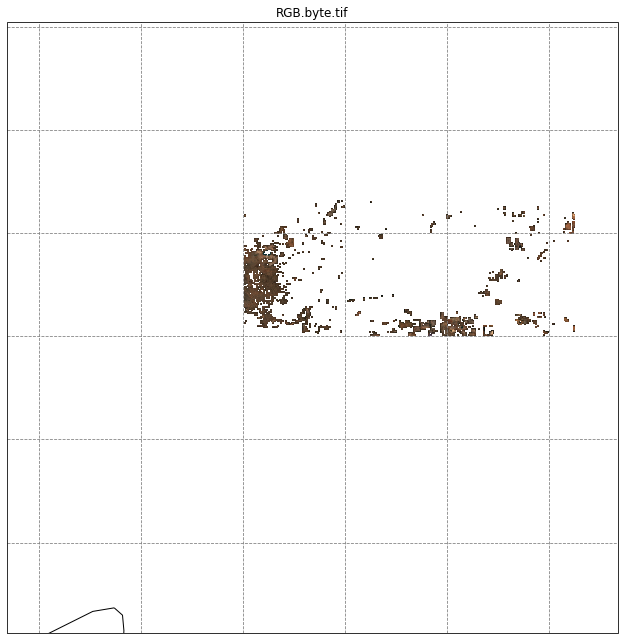

In [7]:
geod = ccrs.Geodetic()

# Set Projection
proj = ccrs.Mercator(central_longitude=0.0, min_latitude=-80.0, max_latitude=84.0, globe=None, latitude_true_scale=0.0)
plt.figure(figsize=(16,9))

# Map bounds
# Entire eastern half of DRC 
#ease_extent = [2500000., 3500000., -1500000., 600000.]
# Zoomed in
# ease_extent = [2750000., 2900000., -1250000., -1150000.]
ease_extent = [2800000., 2900000., -1250000., -1150000.]

# Set projection and boundaries
ax = plt.axes(projection=proj)
ax.set_extent(ease_extent, crs=proj)

# Create a list of all the Geotiffs - Pattern for desired file names in selected directory: ends in 'tif'
os.chdir("/scratch/nason.e/gee/region_geotiffs")
extension = 'tif'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

# Format each image in the list
image_list = []
for f in all_filenames:
    tiff = rasterio.open(f)
    # Get image bounds
    b = tiff.bounds
    # Read the image
    im = tiff.read()
    # Transpose matrix columns to go from rasterio format to cartopy format
    im = np.transpose(im, [1,2,0])
    # Scale the images to the same value range using the max value of the base image
    im = im/max_val
    # Scale this to fit in a 0 to 1 range (above values fall roughly into a 0 to 0.3 range)
    #im = im*(10/3)
    # Apply range limits for each channel. RGB values must be between 0 and 1 - extra check to make sure our scaling kept the values in range
    im = np.clip(im, 0, 1)
    # Add image and bounds to list to be plotted in a loop
    image_list.append((im, b))

# Map each image in the list onto the projection
for image, b in image_list:
    ax.imshow(image, extent=image_bounds(b), transform=proj, origin='upper')

# Set gridlines, country borders, coastlines, title
ax.gridlines(color='gray', linestyle='--')
ax.coastlines()
ax.add_feature(cf.BORDERS)
plt.title('RGB.byte.tif')
# Clip images to fit projected region
plt.tight_layout()